In [4]:
import pandas as pd
import numpy as np
import sqlite3
import datetime
import sklearn
import sqlalchemy as sa
import multiprocessing

In [5]:
from sklearn.model_selection import TimeSeriesSplit

import xgboost as xgb
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_auc_score

import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib.ticker import FormatStrFormatter
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
from sklearn.metrics import precision_recall_curve, auc

import operator

In [6]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_colwidth', -1)

In [7]:
import os
import sys
import re
import networkx as nx
from tqdm import tqdm, tqdm_notebook
import gc

In [8]:
def transform_cols (df, dict_col_types = None):
    # Расширяйте для необходимых столбцов и их явной типизации
    if dict_col_types is None:
        dict_col_types = {
        'amount_original':(float, 0.0),
        'cdf_s_126':(str, u'null'),
        'cdf_s_138':(str, u'null'),
        'channel_indicator_desc':(str, u'null'),
        'event_description':(str, u'null'),
        'cdf_s_294':(int, 0),
        'cdf_s_140':(float, 0.0),
        'data_i_120':(int, 0),
        'cdf_s_218':(str, u'null'),
        'data_s_65':(int, 0),
        'cdf_s_127':(int, 30),
        'cdf_s_135':(int, 30),
        'cdf_s_130':(int, 30),
        'cdf_s_129':(int, 30),
        'cdf_s_134':(int, 30),
        'data_i_154':(float, -150),
        'cdf_s_133':(int, 30),
        'cdf_s_20':(str, u'null'),
        'cdf_s_299':(str, u'null'),
        'short_date':(int, 0)
        }
                
    if df.shape[0] > 0:
        df.replace(u'null', np.nan, inplace=True)

        for i in dict_col_types:
            if i in df.columns:
                df[i] = df[i].fillna(dict_col_types[i][1]).astype(dict_col_types[i][0])
    
    return df

def calc_base_features(data):
    feat_matrix = pd.DataFrame()
    #data = data[data.event_description.isin([u'Перевод частному лицу',u'Оплата услуг',u'Перевод между своими счетами и картами'])]
    
    if data.shape[0] == 0:
        return feat_matrix
    
    # заполняем ряд пропусков
    data.cdf_s_140 = data.cdf_s_140.fillna(0).astype(float)/1000 # кумулятивная сумма опреаций за сутки, если не заполнена, то значит это первая операций, т.е. = 0
    data.data_i_120.fillna(1, inplace=True)

    
    feat_matrix['event_id'] = data.event_id
    feat_matrix['user_id'] = data.user_id

    feat_matrix['custom_mark'] = data.custom_mark    
    feat_matrix['event_time'] = data.event_time

    feat_matrix['amount'] = data.amount_original
    
    feat_matrix['client_age'] = [x.days/360 for x in (data.event_time - data.cdf_s_19)]
  
        
    feat_matrix['cat_new_ip'] = [1 if x == u'ДА' else 0 if x == u'НЕТ' else 2 for x in data.cdf_s_126]
    feat_matrix['cat_new_prov'] =  [1 if x == u'ДА' else 0 if x == u'НЕТ' else 2 for x in data.cdf_s_138]
    feat_matrix['channel_op'] =  [0 if x == u'MOBILE' else 1 if x == u'WEB' else 2 for x in data.channel_indicator_desc]
    feat_matrix['op_type'] = [0 if x == u'Перевод частному лицу' else 1 if x==u'Оплата услуг' else 2 if x ==u'Перевод между своими счетами и картами' else 3 for x in data.event_description]


    feat_matrix ['recip_age'] =  [1 if x == 0 else 0 for x in data.cdf_s_294] # бинарный флаг определяющий наличие возраста получателя (полезен для линейных моделей, менее для деревьев с учетом следующего признака)
    
    feat_matrix['age_diff'] = feat_matrix.client_age - [int(x) if x != 0 else 1000 for x in data.cdf_s_294] # разница возорастов получателей и отправителей, если отсутствует/неприменимо, то padding 500    
  
    
    feat_matrix['cumulative_sum_total'] = data.cdf_s_140 # кумулятивная сумма операций за сутки в каналах web и МП
    
    feat_matrix['data_i_120'] = data.data_i_120 
    
    
    feat_matrix['relative'] = [1 if x == u'ДА' else 0 for x in data.cdf_s_218] # перевод родственнику
    
    feat_matrix['know_recip_power'] = [ x if x is not None else 0 for x in data.data_s_65] # сила связи отправителя и получателя
    

    feat_matrix['cdf_s_127'] = data.cdf_s_127#.apply(lambda x: 1 if x is not None else 0)
    feat_matrix['cdf_s_135'] = data.cdf_s_135#.apply(lambda x: 1 if x is not None else 0)
    feat_matrix['cdf_s_130'] = data.cdf_s_130#.apply(lambda x: 1 if x is not None else 0)
    feat_matrix['cdf_s_129'] = data.cdf_s_129#.apply(lambda x: 1 if x is not None else 0)
    feat_matrix['cdf_s_134'] = data.cdf_s_134#.apply(lambda x: 1 if x is not None else 0)
    feat_matrix['data_i_154'] = [ x if x is not None else -150 for x in data.data_i_154]
    feat_matrix['cdf_s_133'] = data.cdf_s_133#.apply(lambda x: 1 if x is not None else 0)
    feat_matrix['data_i_120'] = data.data_i_120
    feat_matrix['know_recip_card_age'] = [1 if x is not None else 0 for x in data.cdf_s_124]
    
    
    feat_matrix['recip_card_age'] = [x.days if type(x) is not pd.tslib.NaTType else 912321 for x in (data.event_time - data.cdf_s_124)]
    
    # feat_matrix['cat_client_region'] = [x if x.isdigit() else 912321 for x in data.cdf_s_20]
    feat_matrix['one_region'] = (data.cdf_s_20 == data.cdf_s_299).astype(int) # сравнение регионов
    

    #ADD NEW FEATURES
    feat_matrix['krp_pow2'] = (feat_matrix['know_recip_power']) ** 2
    feat_matrix['log_amount'] = np.log(feat_matrix['amount'] + 1)
    feat_matrix['ip_isp'] = np.array([x if x.isdigit() else 912321 for x in data.cdf_s_20], dtype=float)
    feat_matrix['amnt2chnls'] = (data["amount_original"].fillna(0).astype(float) / \
        (data["cdf_s_136"].fillna(0).astype(float) + data["amount_original"].fillna(0).astype(float) + \
            data["amount_original"].fillna(0) + 1))
    return feat_matrix

In [9]:
sys.path.append('/notebooks/')

Словарь с описаниями признаков

In [10]:
feature_descr = {'cdf_s_178_hashed':'реквизит получателя',
                'cdf_s_123': 'региональный признак получателя',
                'cdf_s_124':'дата выдачи карты получателя',
                'cdf_s_294': 'возраст получателя',
                'cdf_s_19': 'ДР клиента',
                 'cdf_s_20':' Тер банк клиента',
                 'cdf_s_299':'Тер банк получателя',
                 'data_i_154':'Признаки устр-ва',
                 'data_i_118':'Признаки устр-ва', 'data_i_119':'Признаки устр-ва',
                 'data_i_120':'Признаки устр-ва', 
                 'cdf_s_136':'cusum_web',
                 'cdf_s_137':'cusum_МП',
                 'cdf_s_140':'cusum_web + МП',
                 'data_s_65':'связь отправитель-получатель',
                 'cdf_s_218':'предположение о родственной связи',
                 'user_acct_number_hashed':' счет отправителя (хэшированный)',
                 'ext_acct_number_hashed':'счет получателя (хэшированный)',
                 'amount_original':'сумма в рублях',
                 'event_description':'описание события',
                 'channel_indicator_desc':'канал проведения операции',
                 'custom_mark':'результат разбора события',
                 'event_id':'уникальный id транзакции',
                 'short_date':'дата (для удобства поиска/агрегации)',
                 'user_id':'уникальный идентификатор клиента',
                 'event_time':'дата и время события'
                }
risk_events = {key:'дней с риск.\n события' for key in ['cdf_s_127', 'cdf_s_135', 'cdf_s_130', 'cdf_s_129', 'cdf_s_134', 'cdf_s_128', 'cdf_s_138', 'cdf_s_126']}
feature_descr.update(risk_events)
new_feat = {'label':'Фрод/не фрод', 'amount':'сумма в рублях', 'client_age':'Возраст\nклиента', 
 'op_type':'Тип операции', 'age_diff':'Разница\nвозрастов', 'cumulative_sum_total':'Кум. сумма\nза сутки', 
 'relative':'Родственники\n или нет', 'know_recip_power':'сила связи\n контрагентов', 
  'know_recip_card_age':'Знаем ли возраст\n принимающего', 'recip_card_age':'Возраст\nпринимающего', 
 'one_region':'Один регион?'}
unknown = {'krp_pow2':'', 'log_amount':'', 'cat_new_ip':'', 'cat_new_prov':'', 'cdf_s_133':'',}
feature_descr.update(new_feat)

In [8]:
def get_data(chunk_name):
    #del feat_test
    feat_test = scr.features_handler(
        chunk_names=[chunk_name],
        calc_feat = scr.calc_base_features,
        query=("event_description in {incl}  and short_date > {start} and short_date < {end}"
               .format(incl=include_channels, start=start_date, end=end_date)))
    return feat_test

In [ ]:
FIRST_N = 100
train_folder = '../../data/raw_splits/train/'
train_files = sorted([x for x in os.listdir(train_folder) if not '.pkl' in x], key = lambda x: int(re.sub('[^0-9]', '', x)))
train_files = [os.path.join(train_folder, x) for x in train_files]
#print(f'Length of train files is {len(train_files)}')
train_files[:FIRST_N]

In [ ]:
test_folder = '../../data/raw_splits/test/'
test_files = sorted([x for x in os.listdir(test_folder) if not '.pkl' in x], key = lambda x: int(re.sub('[^0-9]', '', x)))
test_files = [os.path.join(test_folder, x) for x in test_files]
#print(f'Length of test files is {len(test_files)}')
test_files[:FIRST_N]

In [11]:
# функция получения lable из csutom_mark

def cust_mark_to_class(custom_mark):
    """
    Преобразует входящее значение CUSTOM_MARK в класс
    return:
        1 - фрод
        0 - легитимная
        -1 - неизвестно
    """
    ret = -1
    if custom_mark in ['F','S']:
        ret = 1
    elif custom_mark in ['A','G', 'null', np.nan]:
        ret = 0
    
    return ret

---

In [46]:
train_chunks = []

In [55]:
cat_feats = ['cat_new_ip', 'cat_new_prov', 'op_type', 'relative', 'cdf_s_127', 'cdf_s_135',
             'cdf_s_130', 'cdf_s_129', 'cdf_s_134', 'cdf_s_133', 'know_recip_card_age', 'one_region']
num_feats = ['amount', 'client_age', 'age_diff', 'cumulative_sum_total', 'cumulative_sum_total', 'data_i_120',
             'know_recip_power', 'data_i_120', 'recip_card_age', 'krp_pow2', 'log_amount']
cols = cat_feats + num_feats + ['label']
def load_train(fname):
    chunk = pd.read_feather(fname)
    data = transform_cols(chunk)
    data = calc_base_features(data)
    data.custom_mark = data.custom_mark.apply(cust_mark_to_class)
    data = data[data.custom_mark != -1]
    return data.copy()

def load_test(fname):
    chunk = pd.read_feather(fname)
    return chunk[few_unique].copy()

In [11]:
data_train = pd.read_csv('/nis/hse_nis/data/coms_sep/train_no_cnts.csv')
cat_feats = ['cat_new_ip', 'cat_new_prov', 'op_type', 'relative', 'cdf_s_127', 'cdf_s_135',
             'cdf_s_130', 'cdf_s_129', 'cdf_s_134', 'cdf_s_133', 'know_recip_card_age', 'one_region']
num_feats = ['amount', 'client_age', 'age_diff', 'cumulative_sum_total', 'cumulative_sum_total', 'data_i_120',
             'know_recip_power', 'data_i_120', 'recip_card_age', 'krp_pow2', 'log_amount']
cols = cat_feats + num_feats + ['label']

target = data_train['label']
data_train.drop(set(data_train.columns.values) - set(cols), axis=1, inplace=True)
#data_train.drop(['label'], axis=1, inplace=True)


/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2728: DtypeWarning: Columns (2) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [37]:
data_train.label.value_counts()

0    3802643
1    14012  
Name: label, dtype: int64

In [56]:
%%time
with multiprocessing.Pool(processes=3) as pool:
    train_chunks = pool.map(load_train, tqdm(train_files))

100%|██████████| 51/51 [00:00<00:00, 3871.81it/s]


MaybeEncodingError: Error sending result: '[                                event_id     user_id  custom_mark  \
0        3d47-:ab618959b51:2f0f0145_TRX   10004444    0             
1        7bd2:e5ea4765e51:67d445d5-_TRX   10004444    0             
2        5c03:76eb48a7f51:4b391293_TRX    10004444    0             
3        5523:3dba59ccd51:6f34d2f-_TRX    10004444    0             
4        b525:4b0e7775e51:8cc6d1b6_TRX    10004444    0             
5        30b6:76abdeebf51:3dc02017_TRX    10004444    0             
6        7fe4-:e1315e7df51:4b391293_TRX   10004444    0             
7        daf1:30dfef3bf51:3dc02017_TRX    10004444    0             
8        3e8-:1ae6f096c51:e93a9d6_TRX     10004444    0             
9        b281:3fe5b972f51:1d2c46e6_TRX    10004444    0             
10       1592:c417375af51:3b046184_TRX    10004444    0             
11       3991-:267b9c35d51:64c3b443-_TRX  10004444    0             
12       d33:fc8e1b1ec51:c1acd264_TRX     10004444    0             
13       f372-:23fb943eb51:6daf4b2_TRX    10004444    0             
14       6c87-:f903e196c51:976bd225-_TRX  10004444    0             
15       9e01-:ccf9a808f51:a87507e2_TRX   10004444    0             
16       26a3:bc519eebf51:4b391293_TRX    10004444    0             
17       4fd6:ae154ea0f51:cc816ca-_TRX    10004444    0             
18       e322:e2b657e8e51:5e373c03_TRX    10004444    0             
19       18d4:c7606a6ff51:f19f7627-_TRX   10004444    0             
20       68a5-:f3edc9aac51:5cc9039-_TRX   10004444    0             
21       a2b7:eb2f4901c51:e9ed9cc2-_TRX   10004444    0             
22       d205-:36ca27dec51:19aac576_TRX   10004444    0             
23       4457:70af9096c51:fcd0e313_TRX    10004444    0             
24       b062:de5f57e8e51:7e95dfc5_TRX    10004444    0             
25       6883:2d1c694dc51:c0debc23_TRX    10004444    0             
26       755:241c79abd51:f0a99ed6-_TRX    10004444    0             
27       ab86-:3d01a7dec51:db04f503-_TRX  10004444    0             
28       c6e2:e899b6f9f51:b8b91b43_TRX    10004444    0             
29       b584:ae8ebebef51:e017a6a4_TRX    10004444    0             
30       de12-:3ca4560cd51:e4d60f61-_TRX  10004444    0             
31       1645-:520cdebdf51:dc8ca2e7-_TRX  10004444    0             
32       87d-:005ff94dc51:15030082_TRX    10004444    0             
33       ce84-:de39244ac51:931c8476-_TRX  10004444    0             
34       f934-:7bcdeecdf51:3b046184_TRX   10004444    0             
35       b7e6:9fba778cb51:0c71d921-_TRX   10004444    0             
36       e332-:c968f0a9e51:0e988e-_TRX    10004444    0             
37       ff05-:1c597975e51:40b78a71_TRX   10004444    0             
38       8006-:1914e4cff51:f4907ef6-_TRX  10004444    0             
39       8d95-:28690023e51:7b6fd862-_TRX  10004444    0             
40       af2:8371b74cc51:3ec7bab7-_TRX    10004444    0             
41       3775-:fe9abd7df51:e30ac344-_TRX  10004444    0             
42       5bb-:f9d485b5e51:acc81486-_TRX   10004444    0             
43       a656:e42dbf08c51:45de3ff6_TRX    10004444    0             
44       aae7-:8a70156eb51:f6e80224_TRX   10004444    0             
45       0a81-:e1c3fd43c51:97cec453-_TRX  10004444    0             
46       9514-:529f5c35d51:0914bd9_TRX    10004444    0             
47       07d1:b007b946d51:d798054-_TRX    10004444    0             
48       a813:d36367e8e51:0766a091-_TRX   10004444    0             
49       cb87:936766fac51:c0debc23_TRX    10004444    0             
50       1af7:72c0c708f51:8082da44_TRX    10004444    0             
51       b595:4660a4a3d51:3dc74bc2_TRX    10004444    0             
52       a4c3:e5859ea0f51:fd674c73_TRX    10004444    0             
53       f6e2:ab11613fc51:badb57f4-_TRX   10004444    0             
54       4535:cdab7763e51:ae25b252-_TRX   10004444    0             
55       9653:82147abdf51:70569b87_TRX    10004444    0             
56       1b27:936766fac51:c0debc23_TRX    10004444    0             
57       2655:01f3c2a3f51:247198e_TRX     10004444    0             
58       561:359c8031e51:83945ce1_TRX     10004444    0             
59       7076-:1993e031e51:a3a9f1d3_TRX   10004444    0             
60       6c57:13a2aaa9f51:6369c962_TRX    10004444    0             
61       52a6-:363c2a48e51:cb0211b2-_TRX  10004444    0             
62       c8d5:f023d772f51:05385c66-_TRX   10004444    0             
63       0f73:f9f6591df51:3dc02017_TRX    10004444    0             
64       e172:8b6a9899e51:c65cd996_TRX    10004444    0             
65       33f2-:d69ef815f51:a2bfd242-_TRX  10004444    0             
66       5ef6-:3d01a7dec51:db04f503-_TRX  10004444    0             
67       d0a1:d2053710061:c86d8207-_TRX   10004444    0             
68       90a6-:90abb808f51:3b046184_TRX   10004444    0             
69       a247:38aa5c78d51:dc82a711_TRX    10004444    0             
70       fbd3:e7320539f51:f4907ef6-_TRX   10004444    0             
71       c5d5:3521e3a5d51:7168b3f7_TRX    10004444    0             
72       252-:8371b74cc51:3ec7bab7-_TRX   10004444    0             
73       b172-:cb7d0c35d51:7cbca401_TRX   10004444    0             
74       f52:e638fcabd51:a0813232_TRX     10004444    0             
75       08b6-:2a6bcf83f51:9c09c0d7-_TRX  10004444    0             
76       9065-:252cb95ce51:0e988e-_TRX    10004444    0             
77       b947-:1864d75af51:3b046184_TRX   10004444    0             
78       9762:dcbfb5a1f51:9c09c0d7-_TRX   10004444    0             
79       8905-:c5b95915f51:435e2cf5_TRX   10004444    0             
80       16d5-:549d7476e51:95a11db3-_TRX  10004444    0             
81       3862-:970c3c63d51:fd4919d4_TRX   10004444    0             
82       cfb4-:f3edc9aac51:5cc9039-_TRX   10004444    0             
83       1c07:13a2aaa9f51:6369c962_TRX    10004444    0             
84       f677-:66ac7febf51:e017a6a4_TRX   10004444    0             
85       6db5:8750181df51:f634ff67_TRX    10004444    0             
86       12f6-:82e6f138c51:e8a50be6_TRX   10004444    0             
87       33c4-:7c6b8aa2d51:ae090da3-_TRX  10004444    0             
88       d293-:29df1e35d51:5380161_TRX    10004444    0             
89       da73:39be5b35d51:d4d89901_TRX    10004444    0             
90       dd17:86601f3fc51:15030082_TRX    10004444    0             
91       19b6-:7e38d44ac51:45de3ff6_TRX   10004444    0             
92       91c3-:aeffe37ad51:a0813232_TRX   10004444    0             
93       fa47:b6fa5899e51:fd674c73_TRX    10004444    0             
94       0e81-:d9c0892bf51:b4d76a15-_TRX  10004444    0             
95       d611:97ccd312d51:74ff5e97_TRX    10004444    0             
96       008:3ab89cabd51:f0a99ed6-_TRX    10004444    0             
97       0906-:b82dc775e51:3b3de592_TRX   10004444    0             
98       8455:78627790f51:d5a14707-_TRX   10004444    0             
99       8fb7:faa216a7d51:18ed9583_TRX    10004444    0             
100      f272-:35588a10f51:24eb03d1-_TRX  10004444    0             
101      a925-:d4a9d13fc51:ed831395_TRX   10004444    0             
102      61a2:632474dcf51:dc8ca2e7-_TRX   10004444    0             
103      c285-:9b4501a9e51:cc816ca-_TRX   10004444    0             
104      6451:17696fbef51:70569b87_TRX    10004444    0             
105      8a55-:fc19bb15f51:eca866c6-_TRX  10004444    0             
106      d0f5:e797f772f51:c65cd996_TRX    10004444    0             
107      38e6:f74acf08c51:fa73d19_TRX     10004444    0             
108      8d63-:5b2c4476e51:7bd8b4e5-_TRX  10004444    0             
109      e345:ca00c096c51:070543d3_TRX    10004444    0             
110      4477:38c2a7e1c51:7264ea77_TRX    10004444    0             
111      0b83:05eb46d7e51:80247542_TRX    10004444    0             
112      57e7-:caba0990f51:048c24c-_TRX   10004444    0             
113      c755:933b1870061:e017a6a4_TRX    10004444    0             
114      fb52-:b8d40ae1c51:b3667502_TRX   10004444    0             
115      1fb2:179b0bbdf51:01db2681_TRX    10004444    0             
116      8ff4:37d94770061:01db2681_TRX    10004444    0             
117      1db5:f7e04875e51:1bdedcc1-_TRX   10004444    0             
118      d297-:a5fe9343f51:1b7a1067-_TRX  10004444    0             
119      7ca5-:679016f2c51:265d9392_TRX   10004444    0             
120      73f7:e9aa46dec51:c80b743_TRX     10004444    0             
121      ced1-:272e12a1e51:8f022fd3-_TRX  10004444    0             
122      e175-:c5137343f51:0f32bef3_TRX   10004444    0             
123      e84:94ab4cbdf51:b8b91b43_TRX     10004444    0             
124      9892-:85313901c51:20b33a66-_TRX  10004444    0             
125      98d6-:e7d867dec51:c80b743_TRX    10004444    0             
126      42b3:f3c60d35d51:7168b3f7_TRX    10004444    0             
127      d593-:0ca533a3f51:fd28a5b5-_TRX  10004444    0             
128      212-:11dd1196c51:0dadb49_TRX     10004444    0             
129      3cc4-:80679031e51:28c75776_TRX   10004444    0             
130      83:8c93b78cb51:78147e14-_TRX     10004444    0             
131      8a32-:62e0f6dec51:c0debc23_TRX   10004444    0             
132      daf3-:1324f946d51:482020f2-_TRX  10004444    0             
133      efd6:32be17a7f51:3dc02017_TRX    10004444    0             
134      44f:5dd47196c51:6847ad55-_TRX    10004444    0             
135      47e5:f5dbbc03c51:e93a9d6_TRX     10004444    0             
136      60d1-:d5a8243eb51:1ae52924-_TRX  10004444    0             
137      5cf6-:94a6da5ce51:a2bfd242-_TRX  10004444    0             
138      eef5:1ae6f096c51:e93a9d6_TRX     10004444    0             
139      84a4-:545f1fcdf51:6369c962_TRX   10004444    0             
140      8c53:0ccca3eef51:f4907ef6-_TRX   10004444    0             
141      0d86-:1864d75af51:3b046184_TRX   10004444    0             
142      1664-:e53aaf6ef51:b5beadc6-_TRX  10004444    0             
143      2d56:affd5a13f51:7cb75355_TRX    10004444    0             
144      aad1-:b492f8aed51:ee367dd6_TRX   10004444    0             
145      b967-:24f405cff51:6369c962_TRX   10004444    0             
146      f3c4-:b82dc775e51:3b3de592_TRX   10004444    0             
147      38a-:b3fcc5a1f51:048c24c-_TRX    10004444    0             
148      4f85:85313901c51:20b33a66-_TRX   10004444    0             
149      efd7:f90b7140e51:6e617096_TRX    10004444    0             
150      4f07:fb33437ad51:88970fa6-_TRX   10004444    0             
151      eae4:d6685975e51:1e5d1d67_TRX    10004444    0             
152      f2f5:88620aabd51:a0813232_TRX    10004444    0             
153      3563:44c9645ce51:fd674c73_TRX    10004444    0             
154      6187:4e192790f51:defb4b22_TRX    10004444    0             
155      de14-:85b9fd37d51:54ab8fd2-_TRX  10004444    0             
156      dc21:abf7f096c51:21e86cd5-_TRX   10004444    0             
157      0512:8f143fbef51:f4907ef6-_TRX   10004444    0             
158      66d1-:e8c56108f51:07fb6e55-_TRX  10004444    0             
159      0a35-:cf1d14eef51:e017a6a4_TRX   10004444    0             
160      2276-:9ff457fac51:3ec7bab7-_TRX  10004444    0             
161      5d94-:84aac6b6f51:f5cb5ef6-_TRX  10004444    0             
162      69c3:ad1b6946d51:e998712_TRX     10004444    0             
163      a576:da4edd6ef51:f5cb5ef6-_TRX   10004444    0             
164      75e:904128d7e51:e52e957_TRX      10004444    0             
165      daf5-:664f067ef51:e30ac344-_TRX  10004444    0             
166      0ef6:0e338875e51:8cc6d1b6_TRX    10004444    0             
167      2e15-:894d33a3f51:0f32bef3_TRX   10004444    0             
168      6615-:28690023e51:7b6fd862-_TRX  10004444    0             
169      cd56:f3fddbabd51:06e691a7-_TRX   10004444    0             
170      1857:277ab2eef51:b5beadc6-_TRX   10004444    0             
171      2783:450cbc4ac51:a9e60312-_TRX   10004444    0             
172      ceb3-:5acc34a3c51:e49e81c7-_TRX  10004444    0             
173      1ba5-:72520238c51:8adc6d7-_TRX   10004444    0             
174      d972:73301031e51:c407bf52_TRX    10004444    0             
175      add7:021726a7d51:0914bd9_TRX     10004444    0             
176      e113:4002dc4ac51:5cc9039-_TRX    10004444    0             
177      21c:24de7e43c51:c1c74a56_TRX     10004444    0             
178      ff75:0627e8c7d51:5ab63106-_TRX   10004444    0             
179      1fe6-:7b09ec35d51:19a194b-_TRX   10004444    0             
180      3853:f542df13e51:6ecca417_TRX    10004444    0             
181      6565-:cefa47f9f51:f5cb5ef6-_TRX  10004444    0             
182      6b11-:bb23e376e51:69b7d7d_TRX    10004444    0             
183      bd56:68ab83d7e51:e2b3d66-_TRX    10004444    0             
184      b53:b375bac7d51:e75e8a85-_TRX    10004444    0             
185      24a6:b7e734cff51:c86d8207-_TRX   10004444    0             
186      95e3:8cc538cce51:83ce70b7_TRX    10004444    0             
187      2851:2e6571cef51:e017a6a4_TRX    10004444    0             
188      1091-:fad3be43c51:bc1fb487-_TRX  10004444    0             
189      3c4:bebc19aed51:c68eaeb7_TRX     10004444    0             
190      a562:33a857e8e51:56493497-_TRX   10004444    0             
191      9967:c1993901c51:9e8e20a3_TRX    10004444    0             
192      8394:247903a3f51:d746cc87_TRX    10004444    0             
193      a044:7fc15ecdf51:67942f87-_TRX   10004444    0             
194      a9d1:713eff3bf51:8082da44_TRX    10004444    0             
195      1204-:99fd31a9e51:defb4b22_TRX   10004444    0             
196      d443:13f80d35d51:18ed9583_TRX    10004444    0             
197      8333:2ce855b6f51:f634ff67_TRX    10004444    0             
198      aea4-:de39244ac51:931c8476-_TRX  10004444    0             
199      6797-:41d68c63d51:ae2e6b33_TRX   10004444    0             
200      fcf2-:d2a62a5dd51:dc82a711_TRX   10004444    0             
201      34f5:0d648b35d51:a9147c47-_TRX   10004444    0             
202      10f2-:ef6a1915f51:0e988e-_TRX    10004444    0             
203      5d37:f1b5ca10f51:fd674c73_TRX    10004444    0             
204      8764-:04dfda10f51:a2bfd242-_TRX  10004444    0             
205      a063-:3690b5b5e51:222f39c-_TRX   10004444    0             
206      2f6-:f4540f83f51:0f32bef3_TRX    10004444    0             
207      a06:67d1c639f51:321f0946_TRX     10004444    0             
208      a462-:d7d893cff51:e9a26893_TRX   10004444    0             
209      6333:2ce855b6f51:f634ff67_TRX    10004444    0             
210      2b65-:70218dabd51:88970fa6-_TRX  10004444    0             
211      8da7-:b131f890f51:153749b4-_TRX  10004444    0             
212      4bd6-:453df316e51:471a00a4-_TRX  10004444    0             
213      6517-:9335fe13e51:59b70c21_TRX   10004444    0             
214      ff4-:f92a02c2e51:6ecca417_TRX    10004444    0             
215      4c76:e1dd997bd51:c9e2da01_TRX    10004444    0             
216      c0a7-:2fda4e43c51:e882fff1_TRX   10004444    0             
217      cd96:29758d37d51:dc9787c5-_TRX   10004444    0             
218      c4a6:f97c2765e51:1bdedcc1-_TRX   10004444    0             
219      96e1:223cb3a3c51:c1c74a56_TRX    10004444    0             
220      fee7:cf98f7cce51:480905_TRX      10004444    0             
221      1013-:a10b6d4ac51:db04f503-_TRX  10004444    0             
222      2ca4-:133d247ad51:6f34d2f-_TRX   10004444    0             
223      4a26:cca06ea0f51:153749b4-_TRX   10004444    0             
224      67a6:91efe8bdf51:c86d8207-_TRX   10004444    0             
225      6e42:b6e4a3eef51:b4d76a15-_TRX   10004444    0             
226      8965:c4c0371ec51:5073c013_TRX    10004444    0             
227      44d1:3acfaf13e51:bdc65f33_TRX    10004444    0             
228      c3a5:8750181df51:f634ff67_TRX    10004444    0             
229      7a37-:2133604bf51:f4907ef6-_TRX  10004444    0             
230      ac47-:7b09ec35d51:19a194b-_TRX   10004444    0             
231      01f3-:53c72d78d51:b8776377_TRX   10004444    0             
232      5e75-:eaed8975e51:8cc6d1b6_TRX   10004444    0             
233      7325:1f29caa9f51:70569b87_TRX    10004444    0             
234      7721:3d33bd43c51:3a53d85_TRX     10004444    0             
235      a625:4660a4a3d51:3dc74bc2_TRX    10004444    0             
236      e1c6-:8529daa2d51:94a8ed56-_TRX  10004444    0             
237      8ab4:eb2b3870061:e770dcc5-_TRX   10004444    0             
238      b2d7-:f00a9710061:e770dcc5-_TRX  10004444    0             
239      3764:0a253815f51:d746cc87_TRX    10004444    0             
240      2622:2b61c5f2c51:7b2bd474-_TRX   10004444    0             
241      ed1:9b6b1b6ff51:690b0eb5_TRX     10004444    0             
242      7605-:c08e59aed51:b06176b7_TRX   10004444    0             
243      df24:924cd008f51:3dc02017_TRX    10004444    0             
244      1456-:1fd32118c51:5073c013_TRX   10004444    0             
245      8872:f8ac9c78d51:e75e8a85-_TRX   10004444    0             
246      8c93-:2662c875e51:acc81486-_TRX  10004444    0             
247      3fb1:1a506870061:dc8ca2e7-_TRX   10004444    0             
248      6301-:d7426765e51:18a4a9f2_TRX   10004444    0             
249      bb33-:ae1550cef51:e9a26893_TRX   10004444    0             
...                                 ...        ...   ..             
1715417  8b86:dea21f98d51:18ed9583_TRX    VSP5039077  0             
1715418  a9e6-:80c595b0061:b5beadc6-_TRX  VSP5039077  0             
1715419  2ac2:043084e6d51:94a8ed56-_TRX   VSP5039077  0             
1715420  53b6-:670f9dc0061:fd1bd117_TRX   VSP5039077  0             
1715421  09d5:bdce5344d51:fd206f37_TRX    VSP5039077  0             
1715422  4be6-:a4786c1ce51:fd674c73_TRX   VSP5039077  0             
1715423  ecd-:8019426ee51:6a7ee9b7-_TRX   VSP5039077  0             
1715424  0dc7-:905bf9fac51:19aac576_TRX   VSP5039077  0             
1715425  12e7:3745648be51:53fb1481_TRX    VSP5039077  0             
1715426  32-:5148603fc51:c80b743_TRX      VSP5039077  0             
1715427  b486-:f1571e4cc51:19aac576_TRX   VSP5039077  0             
1715428  ea04-:3cb4f4f9f51:a87507e2_TRX   VSP5039077  0             
1715429  0b73-:846e13e9b51:6c49103_TRX    VSP5039077  0             
1715430  96d2-:203eb19db51:78147e14-_TRX  VSP5039077  0             
1715431  5eb4-:fc802e21e51:c407bf52_TRX   VSP5039077  0             
1715432  24-:6a6f18cad51:1d8c9a8_TRX      VSP5039077  0             
1715433  42b:95d611b9b51:6e5b40f6_TRX     VSP5039077  0             
1715434  5353-:ef10a58ad51:15c27561-_TRX  VSP5039077  0             
1715435  9b42-:bb2dcb8df51:e017a6a4_TRX   VSP5039077  0             
1715436  4c42:a7af61a1e51:8dad7564_TRX    VSP5039077  0             
1715437  5e57-:dd11659dc51:15030082_TRX   VSP5039077  0             
1715438  063-:dc8548d0061:f19f7627-_TRX   VSP5039077  0             
1715439  829:100e44f9f51:70569b87_TRX     VSP5039077  0             
1715440  87f6-:edcd3570d51:69876af4_TRX   VSP5039077  0             
1715441  b3d4:40f68c1ef51:70569b87_TRX    VSP5039077  0             
1715442  0d6:9bd8f3eec51:a9e60312-_TRX    VSP5039077  0             
1715443  1895-:dac66c8cb51:86273731_TRX   VSP5039077  0             
1715444  999-:430d292fe51:153749b4-_TRX   VSP5039077  0             
1715445  18b7-:03de3e21e51:7b15d332-_TRX  VSP5039077  0             
1715446  8de:5c631c63d51:3dc74bc2_TRX     VSP5039077  0             
1715447  ab61-:e7b0dca0061:e017a6a4_TRX   VSP5039077  0             
1715448  b097-:8acb8e0bf51:aa7c4b12-_TRX  VSP5039077  0             
1715449  e191-:4edfde6db51:6daf4b2_TRX    VSP5039077  0             
1715450  2192:07279f72d51:f4f60f14_TRX    VSP5039077  0             
1715451  4d31:b65c2664d51:dc9787c5-_TRX   VSP5039077  0             
1715452  5182-:6138bc60f51:1d2c46e6_TRX   VSP5039077  0             
1715453  cbf-:00f57b8df51:b8b91b43_TRX    VSP5039077  0             
1715454  cea5-:571b8b8df51:e9a26893_TRX   VSP5039077  0             
1715455  4653:f6750aaaf51:3dc02017_TRX    VSP5039077  0             
1715456  1852-:248d4edef51:7caae606_TRX   VSP5039077  0             
1715457  47a7-:9226bbbde51:0e988e-_TRX    VSP5039077  0             
1715458  0b93:83f668c4f51:247198e_TRX     VSP5039077  0             
1715459  e897:857ca16ee51:2b8c05f-_TRX    VSP5039077  0             
1715460  f4b4-:bf751da3d51:18d006f3-_TRX  VSP5039077  0             
1715461  2f02:9019b7b5d51:90a77353-_TRX   VSP5039077  0             
1715462  5c51-:56eed4a9f51:e017a6a4_TRX   VSP5039077  0             
1715463  905:361981d9e51:a7033b9_TRX      VSP5039077  0             
1715464  f977:467ddf5bc51:5bf89247_TRX    VSP5039077  0             
1715465  3686-:f1571e4cc51:19aac576_TRX   VSP5039077  0             
1715466  4683-:c5b8e905d51:faac7a17_TRX   VSP5039077  0             
1715467  4a74-:32499cefd51:e1989546-_TRX  VSP5039077  0             
1715468  58:824fbd21d51:6fc904b_TRX       VSP5039077  0             
1715469  f993-:c5b8e905d51:faac7a17_TRX   VSP5039077  0             
1715470  52a2-:ca0a2b2ce51:a7033b9_TRX    VSP5039077  0             
1715471  6ed7-:546d8805e51:d12241a_TRX    VSP5039077  0             
1715472  b8d1-:3790d2d2e51:28c75776_TRX   VSP5039077  0             
1715473  bf52-:93c2effbd51:40917586-_TRX  VSP5039077  0             
1715474  57d5:990b9cb8f51:321f0946_TRX    VSP5039077  0             
1715475  c785-:c70112a8b51:7967a533_TRX   VSP5039077  0             
1715476  14a-:5278571fe51:480905_TRX      VSP5039077  0             
1715477  06a:aff9840ee51:0e8fa0e2_TRX     VSP5039077  0             
1715478  b1d3:cf7726fbb51:0e35a114-_TRX   VSP5039077  0             
1715479  c387-:40a07e21e51:18ac3165-_TRX  VSP5039077  0             
1715480  ceb-:8019426ee51:6a7ee9b7-_TRX   VSP5039077  0             
1715481  4603:63ba3684f51:153749b4-_TRX   VSP5039077  0             
1715482  5a97-:d39295e6d51:d798054-_TRX   VSP5039077  0             
1715483  8422-:51864fd1e51:28c75776_TRX   VSP5039077  0             
1715484  b3b1:cc025175f51:3777d082_TRX    VSP5039077  0             
1715485  c347-:cae55159f51:67942f87-_TRX  VSP5039077  0             
1715486  d711-:9845ed0bf51:b5beadc6-_TRX  VSP5039077  0             
1715487  0562-:93c2effbd51:40917586-_TRX  VSP5039077  0             
1715488  20e5-:f909d617f51:e30ac344-_TRX  VSP5039077  0             
1715489  b3c3:d017c0aae51:853e5654-_TRX   VSP5039077  0             
1715490  1c22:100e44f9f51:70569b87_TRX    VSP5039077  0             
1715491  0693:83f668c4f51:247198e_TRX     VSP5039077  0             
1715492  8406-:49b1fc60f51:fd674c73_TRX   VSP5039077  0             
1715493  05e4-:66eeb1a5d51:36f83d6-_TRX   VSP5039077  0             
1715494  07c-:ef90183ab51:6c49103_TRX     VSP5039077  0             
1715495  1ec-:4e2dad21e51:83945ce1_TRX    VSP5039077  0             
1715496  e471:4bfd71a1e51:ec81f1a1_TRX    VSP5039077  0             
1715497  f4b2:35e2e8aec51:a7e6bd37_TRX    VSP5039077  0             
1715498  1bd:36b835d3f51:1b959ec2_TRX     VSP5039077  0             
1715499  bcf7-:b3c0ac58c51:430b8ed3-_TRX  VSP5039077  0             
1715500  3c66-:99e795b0061:f19f7627-_TRX  VSP5039077  0             
1715501  d977-:8acb8e0bf51:aa7c4b12-_TRX  VSP5039077  0             
1715502  eef3-:53264684f51:0f32bef3_TRX   VSP5039077  0             
1715503  08c5:96d12bdec51:badb57f4-_TRX   VSP5039077  0             
1715504  a091:100e44f9f51:70569b87_TRX    VSP5039077  0             
1715505  7724-:9072fb63d51:c91ea6c7-_TRX  VSP5039077  0             
1715506  61d-:8019426ee51:6a7ee9b7-_TRX   VSP5039077  0             
1715507  9db7-:44b100cce51:153749b4-_TRX  VSP5039077  0             
1715508  b542:7df051d6c51:e882fff1_TRX    VSP5039077  0             
1715509  b7d2:836f7f98d51:5ab63106-_TRX   VSP5039077  0             
1715510  06a3:60eefa2ce51:7a27f0c1_TRX    VSP5039077  0             
1715511  47b1-:bed44edef51:6a717157-_TRX  VSP5039077  0             
1715512  3d14:20ea74d3f51:0e988e-_TRX     VSP5039077  0             
1715513  6e97:9e75e6b5d51:18ed9583_TRX    VSP5039077  0             
1715514  ace5-:797c21b8c51:5cc9039-_TRX   VSP5039077  0             
1715515  fbf:6ee90fe6d51:b20dda14_TRX     VSP5039077  0             
1715516  1a93:e44abee6d51:94a8ed56-_TRX   VSP5039077  0             
1715517  22f:cebae5dff51:01db2681_TRX     VSP5039077  0             
1715518  16e2:0ae6f16ee51:0e8fa0e2_TRX    VSP5039077  0             
1715519  cdb-:f28222f5d51:e923d152_TRX    VSP5039077  0             
1715520  f837-:76e1abfbf51:8082da44_TRX   VSP5039077  0             
1715521  8492-:19b39318c51:fa73d19_TRX    VSP5039077  0             
1715522  b4a7-:d39295e6d51:d798054-_TRX   VSP5039077  0             
1715523  2b57-:76e1abfbf51:8082da44_TRX   VSP5039077  0             
1715524  7833:b9bafb55e51:07bb2963-_TRX   VSP5039077  0             
1715525  68f6-:edcd3570d51:69876af4_TRX   VSP5039077  0             
1715526  9ac2-:50af8e9ac51:ad9c9d66-_TRX  VSP5039077  0             
1715527  cdf1-:4b8534d0061:b5beadc6-_TRX  VSP5039077  0             
1715528  61d-:e6ae6ffbd51:0feb0cd7_TRX    VSP5039077  0             
1715529  89c2:043084e6d51:94a8ed56-_TRX   VSP5039077  0             
1715530  90d2:836f7f98d51:5ab63106-_TRX   VSP5039077  0             
1715531  7a33:1a4fbb8df51:dc8ca2e7-_TRX   VSP5039077  0             
1715532  9544-:dd9496b5e51:471a00a4-_TRX  VSP5147929  0             
1715533  cb73:589886faf51:dc8ca2e7-_TRX   VSP5147929  0             
1715534  1976:575361ebf51:aa7c4b12-_TRX   VSP5147929  0             
1715535  4da1:52a4d12af51:f4907ef6-_TRX   VSP5147929  0             
1715536  9ea2-:ddaefd49e51:76b4c341_TRX   VSP5147929  0             
1715537  d2a7:cfd300ebf51:3dc02017_TRX    VSP5147929  0             
1715538  ebb3:6f000e3cf51:690b0eb5_TRX    VSP5147929  0             
1715539  3d76:b371b3faf51:e017a6a4_TRX    VSP5147929  0             
1715540  9e92-:ddaefd49e51:76b4c341_TRX   VSP5147929  0             
1715541  ae37-:384e4e0cf51:a87507e2_TRX   VSP5147929  0             
1715542  edd-:c32d75aef51:f5cb5ef6-_TRX   VSP5147929  0             
1715543  9b96-:8ccb2e0cf51:07fb6e55-_TRX  VSP5147929  0             
1715544  7312-:684eddbbf51:f634ff67_TRX   VSP5147929  0             
1715545  0c34-:954d4279f51:67942f87-_TRX  VSP5147929  0             
1715546  ba87-:0c0db7bbf51:f634ff67_TRX   VSP5147929  0             
1715547  8ed4-:82cfb2faf51:f5cb5ef6-_TRX  VSP5147929  0             
1715548  7823:e6d1bdbbf51:6a717157-_TRX   VSP5147929  0             
1715549  3527:b24654faf51:9d038c32_TRX    VSP5147929  0             
1715550  4997-:95e505faf51:67942f87-_TRX  VSP5147929  0             
1715551  fa67:ca25a5b5e51:471a00a4-_TRX   VSP5147929  0             
1715552  2f53-:62dafdbbf51:f5cb5ef6-_TRX  VSP5147929  0             
1715553  c6f1-:b9bcfd0cf51:f4907ef6-_TRX  VSP5147929  0             
1715554  acb3-:c0bac4faf51:3b046184_TRX   VSP5147929  0             
1715555  aa82-:ddaefd49e51:76b4c341_TRX   VSP5147929  0             
1715556  42e3:3e3042faf51:b8b91b43_TRX    VSP5147929  0             
1715557  3e55:2d47f867f51:f634ff67_TRX    VSP5147929  0             
1715558  0fd6:c35395b5e51:2b6b2cf_TRX     VSP5147929  0             
1715559  0104-:75b4ed49e51:56493497-_TRX  VSP5147929  0             
1715560  2454:e1a187faf51:b8b91b43_TRX    VSP5147929  0             
1715561  74e6-:6e454294c51:0dadb49_TRX    VSP5147929  0             
1715562  14f-:31421baef51:67942f87-_TRX   VSP5147929  0             
1715563  2b85:e984e2b5e51:67d445d5-_TRX   VSP5147929  0             
1715564  f744:069027faf51:e30ac344-_TRX   VSP5147929  0             
1715565  3271-:e1a187faf51:b8b91b43_TRX   VSP5147929  0             
1715566  4ef7-:0c0db7bbf51:f634ff67_TRX   VSP5147929  0             
1715567  9767:b24654faf51:9d038c32_TRX    VSP5147929  0             
1715568  7371-:e1a187faf51:b8b91b43_TRX   VSP5147929  0             
1715569  feb6-:ce6237bbf51:f4907ef6-_TRX  VSP5147929  0             
1715570  5892:5867c1ebf51:70569b87_TRX    VSP5147929  0             
1715571  0286:069027faf51:e30ac344-_TRX   VSP5147929  0             
1715572  e931:32b216b5e51:799749a1_TRX    VSP5147929  0             
1715573  6906:04d0cbacf51:fd1bd117_TRX    VSP5147929  0             
1715574  1906-:6047147ff51:7124119_TRX    VSP5147929  0             
1715575  5fe:499a5936f51:e017a6a4_TRX     VSP5147929  0             
1715576  80b6:b371b3faf51:e017a6a4_TRX    VSP5147929  0             
1715577  4c27:341025b5e51:48316165_TRX    VSP5147929  0             
1715578  5481:805843b5e51:222f39c-_TRX    VSP5147929  0             
1715579  2df:499a5936f51:e017a6a4_TRX     VSP5147929  0             
1715580  2287:d503d5faf51:690b0eb5_TRX    VSP5147929  0             
1715581  2f22-:684eddbbf51:f634ff67_TRX   VSP5147929  0             
1715582  c8a1-:f2f1f4faf51:f4907ef6-_TRX  VSP5147929  0             
1715583  d177-:c15286aef51:4b391293_TRX   VSP5147929  0             
1715584  0582-:9bab8936f51:9d038c32_TRX   VSP5147929  0             
1715585  d611:8639474cf51:a87507e2_TRX    VSP5147929  0             
1715586  8db3-:c0bac4faf51:3b046184_TRX   VSP5147929  0             
1715587  30a6:bbe7c3faf51:6a717157-_TRX   VSP5147929  0             
1715588  6a67:ca25a5b5e51:471a00a4-_TRX   VSP5147929  0             
1715589  af04:e4d547faf51:01db2681_TRX    VSP5147929  0             
1715590  7205:90f0e3faf51:67942f87-_TRX   VSP5147929  0             
1715591  7983-:54e32279f51:01db2681_TRX   VSP5147929  0             
1715592  9a34:cc5dbdbbf51:70569b87_TRX    VSP5147929  0             
1715593  41f3-:c0bac4faf51:3b046184_TRX   VSP5147929  0             
1715594  69e:499a5936f51:e017a6a4_TRX     VSP5147929  0             
1715595  ac73-:4b4425faf51:e9a26893_TRX   VSP5147929  0             
1715596  599:9fa27c6ff51:f4907ef6-_TRX    VSP5147929  0             
1715597  4387:d503d5faf51:690b0eb5_TRX    VSP5147929  0             
1715598  01c3:5572b4faf51:fd1bd117_TRX    VSP5147929  0             
1715599  314-:5bc3c37ff51:01db2681_TRX    VSP5147929  0             
1715600  b4e6:b24654faf51:9d038c32_TRX    VSP5147929  0             
1715601  9744-:954d4279f51:67942f87-_TRX  VSP5147929  0             
1715602  a581:805843b5e51:222f39c-_TRX    VSP5147929  0             
1715603  8a05:87e8eda1c51:20b33a66-_TRX   VSP515252   0             
1715604  b0e5:93ce0e30e51:c2246cb3_TRX    VSP515252   0             
1715605  e907:f1528c99e51:152f7606_TRX    VSP515252   0             
1715606  d6f1:6a8d301bc51:cfda85c4_TRX    VSP515252   0             
1715607  ea23-:b2cec98df51:b5beadc6-_TRX  VSP515252   0             
1715608  6f56:6555198df51:690b0eb5_TRX    VSP515252   0             
1715609  fe67-:fb8b1a8df51:f4907ef6-_TRX  VSP515252   0             
1715610  e8c2:a3180b92f51:4c4a3793_TRX    VSP515252   0             
1715611  26e3:d5d7f406d51:0914bd9_TRX     VSP515252   0             
1715612  b917:f1528c99e51:152f7606_TRX    VSP515252   0             
1715613  5621-:4b450df9f51:3b046184_TRX   VSP515252   0             
1715614  0596-:60a1e98df51:690b0eb5_TRX   VSP515252   0             
1715615  95f2-:b3ac6df9f51:67942f87-_TRX  VSP515252   0             
1715616  0f13-:3c1bf98df51:3dc02017_TRX   VSP515252   0             
1715617  0fe1:6a8d301bc51:cfda85c4_TRX    VSP515252   0             
1715618  fd86:6555198df51:690b0eb5_TRX    VSP515252   0             
1715619  8f8-:9d7c698df51:6369c962_TRX    VSP515252   0             
1715620  be72:7ebfac99e51:153749b4-_TRX   VSP515252   0             
1715621  3aa2:a3180b92f51:4c4a3793_TRX    VSP515252   0             
1715622  cee3:d5d7f406d51:0914bd9_TRX     VSP515252   0             
1715623  f1f5:3dde9a92f51:d5a14707-_TRX   VSP515252   0             
1715624  0326:3dde9a92f51:d5a14707-_TRX   VSP515252   0             
1715625  d287-:fb8b1a8df51:f4907ef6-_TRX  VSP515252   0             
1715626  caf5-:9f813d99e51:9c09c0d7-_TRX  VSP515252   0             
1715627  5a85-:fcd33b92f51:853e5654-_TRX  VSP515252   0             
1715628  8813-:fb2bea92f51:365ecc73_TRX   VSP515252   0             
1715629  88d7-:1b897b92f51:8a5f7a92_TRX   VSP515252   0             
1715630  f9a6-:60a1e98df51:690b0eb5_TRX   VSP515252   0             
1715631  4ce:3f3e3e30e51:c3d4af23_TRX     VSP515252   0             
1715632  0a73:f7eaaa92f51:048c24c-_TRX    VSP515252   0             
1715633  8ee5-:9f813d99e51:9c09c0d7-_TRX  VSP515252   0             
1715634  9397-:fb8b1a8df51:f4907ef6-_TRX  VSP515252   0             
1715635  f5d:3f3e3e30e51:c3d4af23_TRX     VSP515252   0             
1715636  35b6-:52715b92f51:c65cd996_TRX   VSP515252   0             
1715637  2ff3:d5d7f406d51:0914bd9_TRX     VSP515252   0             
1715638  b9a6-:52715b92f51:c65cd996_TRX   VSP515252   0             
1715639  1107:f1528c99e51:152f7606_TRX    VSP515252   0             
1715640  0ec7-:1b897b92f51:8a5f7a92_TRX   VSP515252   0             
1715641  f267:bdffbda1c51:596494d1-_TRX   VSP515252   0             
1715642  4ed:3f3e3e30e51:c3d4af23_TRX     VSP515252   0             
1715643  cdd5-:91bbc98df51:aa7c4b12-_TRX  VSP515252   0             
1715644  aed5-:9f813d99e51:9c09c0d7-_TRX  VSP515252   0             
1715645  d4b5-:fcd33b92f51:853e5654-_TRX  VSP515252   0             
1715646  4b43-:b2cec98df51:b5beadc6-_TRX  VSP515252   0             
1715647  e6b6-:60a1e98df51:690b0eb5_TRX   VSP515252   0             
1715648  6d73-:cfcd4ea1c51:e9ed9cc2-_TRX  VSP515252   0             
1715649  1ce5-:91bbc98df51:aa7c4b12-_TRX  VSP515252   0             
1715650  f833-:3c1bf98df51:3dc02017_TRX   VSP515252   0             
1715651  00d1:2275301bc51:15030082_TRX    VSP515252   0             
1715652  5ab:26b1825af51:8082da44_TRX     VSP515252   0             
1715653  c6a5-:fcd33b92f51:853e5654-_TRX  VSP515252   0             
1715654  7206:3dde9a92f51:d5a14707-_TRX   VSP515252   0             
1715655  28b4:c3c9fcf9f51:aa7c4b12-_TRX   VSP515252   0             
1715656  9721-:4b450df9f51:3b046184_TRX   VSP515252   0             
1715657  4e92:a3180b92f51:4c4a3793_TRX    VSP515252   0             
1715658  6553-:b2cec98df51:b5beadc6-_TRX  VSP515252   0             
1715659  bd26:5b736406d51:18ed9583_TRX    VSP515252   0             
1715660  b743-:3c1bf98df51:3dc02017_TRX   VSP515252   0             
1715661  cfb5-:91bbc98df51:aa7c4b12-_TRX  VSP515252   0             
1715662  a713-:fb2bea92f51:365ecc73_TRX   VSP515252   0             
1715663  7643:6c9dfda1c51:60bbe9e2_TRX    VSP515252   0             
1715664  5456:6555198df51:690b0eb5_TRX    VSP515252   0             
1715665  6102:6a8d301bc51:cfda85c4_TRX    VSP515252   0             
1715666  a1b7-:1b897b92f51:8a5f7a92_TRX   VSP515252   0             

                 event_time    amount  client_age  cat_new_ip  cat_new_prov  \
0       2017-04-22 15:18:02  350.00    41.563889   2           2              
1       2017-09-06 12:21:58  500.00    41.944444   0           0              
2       2017-11-02 06:00:26  1426.03   42.102778   0           0              
3       2017-08-10 17:49:58  0.00      41.869444   2           2              
4       2017-09-06 17:08:33  3380.04   41.944444   1           0              
5       2017-11-15 12:18:04  2370.00   42.138889   0           0              
6       2017-11-20 08:31:18  0.00     NaN          2           2              
7       2017-11-13 09:18:01  0.00     NaN          2           2              
8       2017-06-02 16:56:18  0.00      41.677778   2           2              
9       2017-10-17 03:55:36  500.00    42.058333   1           0              
10      2017-11-10 13:29:08  0.00      42.125000   2           2              
11      2017-07-18 06:58:49  0.00      41.805556   2           2              
12      2017-06-26 04:17:35  50.00     41.744444   1           0              
13      2017-05-07 17:34:22  3925.08   41.605556   1           0              
14      2017-06-02 17:03:58  0.00     NaN          2           2              
15      2017-11-03 09:28:26  620.00    42.105556   0           0              
16      2017-11-15 12:09:44  0.00      42.138889   2           2              
17      2017-10-11 13:20:09  3510.00   42.041667   0           0              
18      2017-09-17 09:26:39  0.00      41.975000   2           2              
19      2017-11-26 08:21:27  1000.00   42.169444   1           0              
20      2017-06-15 10:19:29  0.00      41.713889   2           2              
21      2017-05-16 12:42:52  0.00     NaN          2           2              
22      2017-06-28 09:49:19  0.00     NaN          2           2              
23      2017-06-02 17:01:02  0.00     NaN          2           2              
24      2017-09-17 09:27:31  500.00    41.975000   0           0              
25      2017-06-23 14:09:10  350.00    41.736111   2           2              
26      2017-08-07 06:19:02  0.00      41.861111   2           2              
27      2017-06-28 09:55:24  2500.00   41.750000   0           0              
28      2017-11-09 09:25:26  0.00      42.122222   2           2              
29      2017-11-24 06:25:23  0.00      42.163889   2           2              
30      2017-08-08 08:56:22  20.00     41.863889   2           2              
31      2017-11-21 03:35:49  0.00      42.155556   2           2              
32      2017-06-23 14:12:01  1200.00   41.736111   0           0              
33      2017-06-14 04:59:12  0.00     NaN          2           2              
34      2017-11-21 08:02:50  0.00      42.155556   2           2              
35      2017-05-02 12:39:34  0.00      41.591667   2           2              
36      2017-09-19 15:20:54  20000.00  41.980556   1           0              
37      2017-09-06 17:31:56  0.00      41.944444   2           2              
38      2017-11-27 10:10:13  26023.36  42.172222   0           0              
39      2017-08-30 10:20:00  0.00      41.925000   2           2              
40      2017-06-20 10:58:06  0.00     NaN          2           2              
41      2017-11-20 08:20:26  0.00      42.152778   2           2              
42      2017-09-07 11:04:09  0.00      41.947222   2           2              
43      2017-06-07 08:38:51  0.00      41.691667   2           2              
44      2017-05-08 07:28:51  250.00    41.608333   2           2              
45      2017-05-23 13:41:24  4000.00   41.650000   0           0              
46      2017-07-18 06:48:18  0.00      41.805556   2           2              
47      2017-07-21 13:13:42  0.00     NaN          2           2              
48      2017-09-17 09:29:05  2000.00   41.975000   0           0              
49      2017-06-16 08:55:11  1200.00   41.716667   0           0              
50      2017-11-03 09:19:27  0.00      42.105556   2           2              
51      2017-07-13 08:13:35  50.00     41.791667   0           0              
52      2017-10-11 13:19:46  0.00     NaN          2           2              
53      2017-06-29 12:14:26  211.00    41.752778   0           0              
54      2017-08-31 07:32:35  20.00     41.927778   2           2              
55      2017-11-21 03:38:05  0.00     NaN          2           2              
56      2017-06-16 08:54:44  0.00     NaN          2           2              
57      2017-10-20 17:37:28  500.00    42.066667   0           0              
58      2017-08-24 10:06:35  5000.00   41.908333   0           0              
59      2017-08-24 10:05:41  3300.00   41.908333   0           0              
60      2017-11-08 11:18:02  0.00     NaN          2           2              
61      2017-09-15 11:24:32  20.00     41.969444   2           2              
62      2017-10-17 03:50:29  0.00      42.058333   2           2              
63      2017-11-19 04:55:32  0.00     NaN          2           2              
64      2017-09-19 12:57:38  0.00     NaN          2           2              
65      2017-10-25 06:37:43  0.00      42.080556   2           2              
66      2017-06-28 09:54:53  0.00     NaN          2           2              
67      2017-11-28 10:15:03  30000.00  42.175000   0           0              
68      2017-11-03 09:24:02  3959.52   42.105556   0           0              
69      2017-07-28 09:14:50  0.00      41.833333   2           2              
70      2017-11-07 02:55:02  10600.00  42.116667   1           0              
71      2017-07-19 13:00:04  0.00      41.808333   2           2              
72      2017-06-20 10:57:46  0.00      41.727778   2           2              
73      2017-07-18 06:47:03  0.00      41.805556   2           2              
74      2017-08-07 07:09:52  6513.00   41.861111   0           0              
75      2017-10-20 11:54:22  8900.00   42.066667   0           0              
76      2017-09-28 02:41:42  0.00     NaN          2           2              
77      2017-11-10 13:33:23  0.00     NaN          2           2              
78      2017-10-14 13:19:52  0.00     NaN          2           2              
79      2017-10-25 06:38:45  0.00     NaN          2           2              
80      2017-09-09 18:38:47  0.00     NaN          2           2              
81      2017-07-12 15:32:35  50.00     41.788889   1           0              
82      2017-06-15 10:20:21  206.46    41.713889   0           0              
83      2017-11-08 11:17:48  0.00      42.119444   2           2              
84      2017-11-15 12:17:31  0.00     NaN          2           2              
85      2017-11-19 04:56:05  400.00    42.150000   0           0              
86      2017-06-07 18:16:20  0.00      41.691667   2           2              
87      2017-07-10 07:08:50  0.00      41.783333   2           2              
88      2017-07-18 07:17:49  0.00     NaN          2           2              
89      2017-07-18 06:52:44  3000.00   41.805556   0           0              
90      2017-06-29 16:20:07  100.00    41.752778   2           2              
91      2017-06-14 04:59:24  0.00     NaN          2           2              
92      2017-08-03 11:43:53  0.00     NaN          2           2              
93      2017-09-19 12:56:31  0.00      41.980556   2           2              
94      2017-11-13 03:35:11  50.00     42.133333   2           2              
95      2017-07-08 11:19:38  100.00    41.777778   2           2              
96      2017-08-07 07:05:19  3950.00   41.861111   0           0              
97      2017-09-06 17:01:39  0.00      41.944444   2           2              
98      2017-10-11 06:55:04  0.00     NaN          2           2              
99      2017-07-25 18:54:18  200.00    41.825000   0           0              
100     2017-10-09 18:08:51  0.00      42.036111   2           2              
101     2017-06-29 12:13:30  0.00      41.752778   2           2              
102     2017-11-18 07:26:58  50.00     42.147222   2           2              
103     2017-09-19 15:18:03  0.00     NaN          2           2              
104     2017-11-24 06:26:19  0.00     NaN          2           2              
105     2017-10-25 07:17:32  0.00     NaN          2           2              
106     2017-10-17 03:55:02  0.00     NaN          2           2              
107     2017-06-07 08:40:21  50.00     41.691667   0           0              
108     2017-09-09 18:39:21  500.00    41.952778   1           0              
109     2017-06-02 17:01:28  1300.00   41.677778   0           0              
110     2017-05-19 06:13:02  100.00    41.638889   0           0              
111     2017-09-14 03:31:02  0.00     NaN          2           2              
112     2017-10-11 06:53:27  0.00      42.041667   2           2              
113     2017-11-29 14:32:03  0.00      42.177778   2           2              
114     2017-05-19 06:12:33  0.00      41.638889   2           2              
115     2017-11-21 03:40:09  9200.00   42.155556   0           0              
116     2017-11-29 14:15:59  450.00    42.177778   2           2              
117     2017-09-06 17:20:44  0.00      41.944444   2           2              
118     2017-10-19 13:42:31  3745.00   42.063889   0           0              
119     2017-05-22 12:00:50  0.00      41.647222   2           2              
120     2017-06-28 09:49:43  862.50    41.750000   0           0              
121     2017-08-25 19:11:49  30.00     41.911111   2           2              
122     2017-10-19 13:41:21  0.00      42.063889   2           2              
123     2017-11-21 03:38:40  9200.00   42.155556   0           0              
124     2017-05-16 12:30:11  0.00      41.630556   2           2              
125     2017-06-28 09:51:12  450.00    41.750000   0           0              
126     2017-07-18 07:16:52  0.00      41.805556   2           2              
127     2017-10-20 17:36:57  0.00     NaN          2           2              
128     2017-06-02 16:59:27  600.00    41.677778   0           0              
129     2017-08-24 10:02:01  1500.00   41.908333   0           0              
130     2017-05-02 12:34:19  0.00      41.591667   2           2              
131     2017-06-28 09:48:36  0.00      41.750000   2           2              
132     2017-07-21 13:12:37  0.00      41.813889   2           2              
133     2017-11-02 05:58:58  0.00      42.102778   2           2              
134     2017-06-02 17:07:17  1170.00   41.677778   0           0              
135     2017-05-22 18:52:21  100.00    41.647222   2           2              
136     2017-05-07 17:27:56  0.00      41.605556   2           2              
137     2017-09-28 02:42:19  1000.00   42.005556   1           0              
138     2017-06-02 17:04:22  183.00    41.677778   0           0              
139     2017-11-21 08:03:39  400.00    42.155556   0           0              
140     2017-11-24 16:41:29  0.00      42.163889   2           2              
141     2017-11-10 13:33:54  1628.40   42.125000   0           0              
142     2017-11-23 06:53:38  300.00    42.161111   0           0              
143     2017-10-18 21:27:17  0.00      42.061111   2           2              
144     2017-08-16 13:26:02  0.00      41.886111   2           2              
145     2017-11-27 10:11:12  26023.36  42.172222   0           0              
146     2017-09-06 17:03:12  6000.00   41.944444   1           0              
147     2017-10-14 13:19:31  0.00      42.050000   2           2              
148     2017-05-16 12:38:15  0.00     NaN          2           2              
149     2017-08-21 12:32:49  200.00    41.900000   2           2              
150     2017-08-03 11:41:27  0.00      41.850000   2           2              
151     2017-09-06 17:40:08  250.00    41.944444   1           0              
152     2017-08-07 06:43:26  0.00     NaN          2           2              
153     2017-09-28 02:41:03  0.00      42.005556   2           2              
154     2017-10-11 06:55:48  3622.56   42.041667   0           0              
155     2017-07-24 12:17:18  0.00      41.822222   2           2              
156     2017-06-02 16:58:59  0.00     NaN          2           2              
157     2017-11-24 06:24:50  0.00      42.163889   2           2              
158     2017-11-03 07:26:55  0.00      42.105556   2           2              
159     2017-11-24 16:42:53  200.00    42.163889   0           0              
160     2017-06-16 08:53:50  0.00      41.716667   2           2              
161     2017-10-30 07:04:47  0.00      42.094444   2           2              
162     2017-07-21 13:14:05  100.00    41.813889   0           0              
163     2017-11-23 06:52:18  0.00      42.161111   2           2              
164     2017-09-14 03:32:12  500.00    41.966667   0           0              
165     2017-11-23 08:40:56  50.00     42.161111   2           2              
166     2017-09-06 17:28:36  20.00     41.944444   1           0              
167     2017-10-20 17:36:27  0.00      42.066667   2           2              
168     2017-08-30 10:20:34  0.00      41.925000   2           2              
169     2017-08-07 07:09:16  0.00     NaN          2           2              
170     2017-11-24 16:32:25  0.00      42.163889   2           2              
171     2017-06-14 07:32:48  0.00      41.711111   2           2              
172     2017-05-24 14:47:27  200.00    41.652778   0           0              
173     2017-06-07 18:18:41  4498.99   41.691667   1           0              
174     2017-08-24 10:00:43  0.00      41.908333   2           2              
175     2017-07-25 18:53:01  0.00      41.825000   2           2              
176     2017-06-14 07:33:18  50.00     41.711111   0           0              
177     2017-05-23 13:54:37  0.00     NaN          2           2              
178     2017-07-26 05:50:06  0.00      41.827778   2           2              
179     2017-07-18 06:50:02  5000.00   41.805556   0           0              
180     2017-08-30 10:25:53  1212.00   41.925000   0           0              
181     2017-11-09 09:28:01  50.00     42.122222   0           0              
182     2017-09-09 18:36:26  0.00      41.952778   2           2              
183     2017-09-14 03:30:44  0.00      41.966667   2           2              
184     2017-07-26 05:50:54  50.00     41.827778   0           0              
185     2017-11-27 10:08:43  61024.20  42.172222   0           0              
186     2017-09-29 10:33:28  0.00     NaN          2           2              
187     2017-11-24 06:56:36  0.00      42.163889   2           2              
188     2017-05-23 13:55:16  850.00    41.650000   0           0              
189     2017-08-16 13:31:34  5350.00   41.886111   0           0              
190     2017-09-17 09:26:59  0.00     NaN          2           2              
191     2017-05-16 12:40:40  1250.00   41.630556   0           0              
192     2017-10-20 17:46:49  1000.00   42.066667   0           0              
193     2017-11-21 08:03:03  0.00     NaN          2           2              
194     2017-11-13 09:18:33  300.00    42.133333   0           0              
195     2017-09-19 15:22:32  200.00    41.980556   1           0              
196     2017-07-18 07:18:47  2490.00   41.805556   0           0              
197     2017-10-30 07:00:59  0.00     NaN          2           2              
198     2017-06-14 04:58:34  0.00      41.711111   2           2              
199     2017-07-12 15:31:59  0.00      41.788889   2           2              
200     2017-08-12 11:55:27  50.00     41.875000   2           2              
201     2017-07-18 07:00:22  350.00    41.805556   0           0              
202     2017-10-25 06:40:11  200.00    42.080556   0           0              
203     2017-10-09 18:21:23  969.78    42.036111   1           0              
204     2017-10-09 18:12:24  2339.29   42.036111   1           0              
205     2017-09-07 11:04:57  1000.00   41.947222   0           0              
206     2017-10-20 11:53:31  0.00      42.066667   2           2              
207     2017-11-07 02:52:56  0.00      42.116667   2           2              
208     2017-11-27 09:50:47  0.00      42.172222   2           2              
209     2017-10-30 07:00:59  0.00      42.094444   2           2              
210     2017-08-07 07:04:50  0.00     NaN          2           2              
211     2017-10-11 06:52:11  0.00      42.041667   2           2              
212     2017-09-08 14:29:45  90.00     41.950000   2           2              
213     2017-08-30 09:59:45  0.00      41.925000   2           2              
214     2017-08-29 07:12:42  20.00     41.922222   2           2              
215     2017-08-06 16:27:29  700.00    41.858333   0           0              
216     2017-05-23 13:40:44  4000.00   41.650000   0           0              
217     2017-07-24 12:21:34  869.00    41.822222   0           0              
218     2017-09-06 12:21:27  0.00     NaN          2           2              
219     2017-05-24 14:45:25  0.00      41.652778   2           2              
220     2017-09-29 10:32:41  0.00      42.008333   2           2              
221     2017-06-14 07:31:43  50.00     41.711111   2           2              
222     2017-08-03 11:46:43  950.00    41.850000   0           0              
223     2017-10-11 13:18:09  0.00      42.041667   2           2              
224     2017-11-21 03:39:17  0.00     NaN          2           2              
225     2017-11-24 16:41:55  0.00     NaN          2           2              
226     2017-06-26 04:16:44  0.00      41.744444   2           2              
227     2017-08-30 10:22:10  0.00     NaN          2           2              
228     2017-11-19 04:55:11  0.00      42.150000   2           2              
229     2017-11-13 09:17:49  0.00      42.133333   2           2              
230     2017-07-18 06:49:06  5000.00   41.805556   0           0              
231     2017-07-28 09:16:04  0.00     NaN          2           2              
232     2017-09-06 17:33:03  864.64    41.944444   1           0              
233     2017-11-08 11:18:30  300.00    42.119444   1           0              
234     2017-05-23 13:40:01  0.00      41.650000   2           2              
235     2017-07-13 08:12:57  0.00      41.791667   2           2              
236     2017-07-10 07:09:32  50.00     41.783333   0           0              
237     2017-11-29 14:32:27  0.00     NaN          2           2              
238     2017-11-28 10:14:04  399.57    42.175000   0           0              
239     2017-10-25 06:42:35  650.00    42.080556   0           0              
240     2017-05-22 12:02:24  0.00     NaN          2           2              
241     2017-11-26 08:20:36  0.00      42.169444   2           2              
242     2017-08-16 13:30:54  0.00     NaN          2           2              
243     2017-11-03 07:27:43  240.00    42.105556   0           0              
244     2017-06-07 08:43:33  200.00    41.691667   0           0              
245     2017-07-28 09:16:25  2500.00   41.833333   0           0              
246     2017-09-06 17:20:18  350.00    41.944444   2           2              
247     2017-11-29 14:32:56  400.00    42.177778   0           0              
248     2017-09-06 12:19:52  0.00      41.944444   2           2              
249     2017-11-24 06:27:55  1395.30   42.163889   0           0              
...                     ...      ...         ...  ..          ..              
1715417 2017-07-28 19:30:49  0.00      25.177778   2           2              
1715418 2017-11-30 08:16:19  0.00      25.525000   2           2              
1715419 2017-07-23 10:27:38  0.00     NaN          2           2              
1715420 2017-11-30 15:16:07  0.00      25.525000   2           2              
1715421 2017-07-15 06:57:34  1000.00   25.141667   2           2              
1715422 2017-09-27 08:20:43  200.00    25.347222   2           2              
1715423 2017-10-04 09:55:24  20000.00  25.366667   2           2              
1715424 2017-06-16 09:38:29  100.00    25.061111   2           2              
1715425 2017-09-25 12:18:08  1600.00   25.341667   2           2              
1715426 2017-06-29 11:53:45  2500.00   25.097222   2           2              
1715427 2017-06-20 12:43:40  0.00     NaN          2           2              
1715428 2017-11-09 08:49:19  0.00      25.466667   2           2              
1715429 2017-04-24 07:31:01  500.00    24.913889   2           2              
1715430 2017-05-05 18:01:57  300.00    24.944444   2           2              
1715431 2017-08-24 09:19:24  0.00      25.252778   2           2              
1715432 2017-08-04 12:16:58  400.00    25.197222   2           2              
1715433 2017-04-23 17:04:42  3000.00   24.911111   2           2              
1715434 2017-08-03 16:53:53  3000.00   25.194444   2           2              
1715435 2017-11-20 12:27:20  0.00      25.497222   2           2              
1715436 2017-08-25 19:04:16  0.00      25.255556   2           2              
1715437 2017-06-24 12:02:50  0.00      25.083333   2           2              
1715438 2017-11-30 18:28:47  3000.00   25.525000   2           2              
1715439 2017-11-09 08:43:16  0.00      25.466667   2           2              
1715440 2017-07-03 10:23:25  0.00     NaN          2           2              
1715441 2017-11-22 07:03:08  0.00      25.502778   2           2              
1715442 2017-06-28 13:39:44  800.00    25.094444   2           2              
1715443 2017-05-02 13:50:42  0.00     NaN          2           2              
1715444 2017-10-06 19:53:32  30000.00  25.372222   2           2              
1715445 2017-08-24 09:18:18  0.00     NaN          2           2              
1715446 2017-07-12 15:33:07  0.00      25.133333   2           2              
1715447 2017-11-30 06:03:10  2000.00   25.525000   2           2              
1715448 2017-11-12 18:46:41  18000.00  25.475000   2           2              
1715449 2017-05-05 07:55:21  0.00     NaN          2           2              
1715450 2017-07-09 18:50:47  700.00    25.125000   2           2              
1715451 2017-07-15 16:30:44  400.00    25.141667   2           2              
1715452 2017-10-10 18:02:54  0.00      25.383333   2           2              
1715453 2017-11-20 12:21:31  0.00      25.497222   2           2              
1715454 2017-11-20 12:20:03  0.00      25.497222   2           2              
1715455 2017-11-11 13:40:02  400.00    25.472222   2           2              
1715456 2017-11-24 15:03:27  0.00     NaN          2           2              
1715457 2017-10-02 09:17:46  3200.00   25.361111   2           2              
1715458 2017-10-24 07:18:40  0.00     NaN          2           2              
1715459 2017-10-04 09:52:58  0.00      25.366667   2           2              
1715460 2017-07-13 10:24:03  8000.00   25.136111   2           2              
1715461 2017-07-19 18:45:56  0.00      25.152778   2           2              
1715462 2017-11-08 09:32:21  600.00    25.463889   2           2              
1715463 2017-09-20 05:51:54  200.00    25.327778   2           2              
1715464 2017-06-17 15:44:53  100.00    25.063889   2           2              
1715465 2017-06-20 12:43:40  0.00      25.072222   2           2              
1715466 2017-07-17 16:00:26  0.00     NaN          2           2              
1715467 2017-08-20 11:41:58  19800.00  25.241667   2           2              
1715468 2017-07-05 16:15:40  7000.00   25.113889   2           2              
1715469 2017-07-17 16:00:22  0.00     NaN          2           2              
1715470 2017-09-27 12:42:01  0.00      25.347222   2           2              
1715471 2017-09-05 08:35:02  300.00    25.286111   2           2              
1715472 2017-08-29 11:53:30  0.00     NaN          2           2              
1715473 2017-08-08 07:10:30  0.00     NaN          2           2              
1715474 2017-11-05 14:09:33  0.00      25.455556   2           2              
1715475 2017-04-20 09:54:08  500.00    24.902778   2           2              
1715476 2017-10-06 14:39:06  300.00    25.372222   2           2              
1715477 2017-10-03 06:51:52  300.00    25.363889   2           2              
1715478 2017-04-30 18:28:12  2000.00   24.930556   2           2              
1715479 2017-08-24 09:21:59  0.00     NaN          2           2              
1715480 2017-10-04 09:55:30  0.00     NaN          2           2              
1715481 2017-10-23 11:48:37  0.00      25.419444   2           2              
1715482 2017-07-23 10:29:21  0.00     NaN          2           2              
1715483 2017-08-26 12:59:36  300.00    25.258333   2           2              
1715484 2017-10-26 08:22:09  0.00     NaN          2           2              
1715485 2017-11-07 09:06:08  0.00     NaN          2           2              
1715486 2017-11-12 18:48:07  0.00     NaN          2           2              
1715487 2017-08-08 07:10:27  400.00    25.208333   2           2              
1715488 2017-10-31 10:58:43  5000.00   25.441667   2           2              
1715489 2017-09-22 17:56:56  300.00    25.333333   2           2              
1715490 2017-11-09 08:45:06  25000.00  25.466667   2           2              
1715491 2017-10-24 07:18:38  4000.00   25.422222   2           2              
1715492 2017-10-10 18:04:04  0.00     NaN          2           2              
1715493 2017-07-19 12:12:54  0.00      25.152778   2           2              
1715494 2017-04-25 08:18:27  0.00     NaN          2           2              
1715495 2017-08-24 09:16:07  0.00      25.252778   2           2              
1715496 2017-08-25 19:03:22  700.00    25.255556   2           2              
1715497 2017-06-27 20:36:03  0.00      25.091667   2           2              
1715498 2017-10-21 08:21:45  0.00      25.413889   2           2              
1715499 2017-06-08 06:40:31  0.00     NaN          2           2              
1715500 2017-11-30 08:16:59  50000.00  25.525000   2           2              
1715501 2017-11-12 18:46:49  0.00     NaN          2           2              
1715502 2017-10-23 11:44:05  79000.00  25.419444   2           2              
1715503 2017-06-28 11:13:39  1000.00   25.094444   2           2              
1715504 2017-11-09 08:44:25  0.00     NaN          2           2              
1715505 2017-07-12 15:25:24  0.00      25.133333   2           2              
1715506 2017-10-04 09:55:26  0.00     NaN          2           2              
1715507 2017-09-29 07:58:56  0.00     NaN          2           2              
1715508 2017-06-03 11:46:51  2000.00   25.025000   2           2              
1715509 2017-07-28 19:31:51  0.00     NaN          2           2              
1715510 2017-09-27 12:45:19  0.00     NaN          2           2              
1715511 2017-11-24 15:03:24  5700.00   25.508333   2           2              
1715512 2017-10-21 08:22:53  0.00     NaN          2           2              
1715513 2017-07-19 18:46:34  400.00    25.152778   2           2              
1715514 2017-06-09 07:22:17  1000.00   25.041667   2           2              
1715515 2017-07-23 13:28:21  1000.00   25.163889   2           2              
1715516 2017-07-23 13:27:28  0.00      25.163889   2           2              
1715517 2017-11-27 15:12:57  0.00     NaN          2           2              
1715518 2017-10-04 09:53:52  35000.00  25.366667   2           2              
1715519 2017-07-20 11:41:57  0.00     NaN          2           2              
1715520 2017-11-15 15:49:59  0.00     NaN          2           2              
1715521 2017-06-07 09:30:28  0.00     NaN          2           2              
1715522 2017-07-23 10:29:17  0.00     NaN          2           2              
1715523 2017-11-15 15:49:53  0.00     NaN          2           2              
1715524 2017-09-06 09:07:21  0.00     NaN          2           2              
1715525 2017-07-03 10:23:25  0.00      25.108333   2           2              
1715526 2017-06-15 07:11:47  500.00    25.058333   2           2              
1715527 2017-11-30 17:15:56  0.00      25.525000   2           2              
1715528 2017-08-08 07:06:38  0.00      25.208333   2           2              
1715529 2017-07-23 10:27:38  0.00      25.163889   2           2              
1715530 2017-07-28 19:31:48  10000.00  25.177778   2           2              
1715531 2017-11-20 12:29:02  0.00      25.497222   2           2              
1715532 2017-09-07 11:20:15  0.00      43.805556   2           2              
1715533 2017-11-12 11:59:27  0.00      43.988889   2           2              
1715534 2017-11-15 08:28:03  0.00      43.997222   2           2              
1715535 2017-11-09 22:06:19  500.00    43.980556   2           2              
1715536 2017-09-18 15:08:29  1000.00   43.836111   2           2              
1715537 2017-11-15 08:08:54  0.00      43.997222   2           2              
1715538 2017-11-16 11:27:55  0.00      44.000000   2           2              
1715539 2017-11-12 11:14:13  0.00     NaN          2           2              
1715540 2017-09-18 15:08:32  0.00     NaN          2           2              
1715541 2017-11-15 21:17:01  4500.00   43.997222   1           0              
1715542 2017-11-23 22:42:53  0.00      44.019444   2           2              
1715543 2017-11-15 21:15:16  0.00      43.997222   2           2              
1715544 2017-11-14 22:02:11  0.00     NaN          2           2              
1715545 2017-11-07 18:45:18  0.00     NaN          2           2              
1715546 2017-11-14 20:03:31  0.00     NaN          2           2              
1715547 2017-11-12 10:44:07  0.00      43.988889   2           2              
1715548 2017-11-14 22:08:36  7000.00   43.994444   1           1              
1715549 2017-11-12 11:26:27  0.00     NaN          2           2              
1715550 2017-11-12 11:20:29  0.00      43.988889   2           2              
1715551 2017-09-07 11:15:46  0.00     NaN          2           2              
1715552 2017-11-14 21:59:46  0.00      43.994444   2           2              
1715553 2017-11-15 21:17:53  0.00     NaN          2           2              
1715554 2017-11-12 11:20:50  0.00     NaN          2           2              
1715555 2017-09-18 15:08:36  0.00     NaN          2           2              
1715556 2017-11-12 10:45:42  45000.00  43.988889   2           2              
1715557 2017-11-01 11:03:30  100.00    43.958333   2           2              
1715558 2017-09-07 11:11:49  0.00      43.805556   2           2              
1715559 2017-09-18 15:05:49  0.00      43.836111   2           2              
1715560 2017-11-12 12:17:02  0.00     NaN          2           2              
1715561 2017-05-27 12:03:48  100.00   NaN          2           2              
1715562 2017-11-24 00:36:45  0.00      44.022222   2           2              
1715563 2017-09-07 10:29:09  10000.00  43.805556   2           2              
1715564 2017-11-12 12:17:05  0.00      43.988889   2           2              
1715565 2017-11-12 12:10:39  0.00     NaN          2           2              
1715566 2017-11-14 20:02:54  15000.00  43.994444   1           1              
1715567 2017-11-12 11:26:45  0.00     NaN          2           2              
1715568 2017-11-12 12:10:39  0.00      43.988889   2           2              
1715569 2017-11-14 19:54:45  0.00      43.994444   2           2              
1715570 2017-11-15 08:29:27  5000.00   43.997222   1           0              
1715571 2017-11-12 12:20:39  0.00      43.988889   2           2              
1715572 2017-09-07 11:15:28  0.00     NaN          2           2              
1715573 2017-11-17 19:22:22  0.00      44.002778   2           2              
1715574 2017-11-26 10:39:08  0.00      44.027778   2           2              
1715575 2017-10-28 18:39:39  0.00     NaN          2           2              
1715576 2017-11-12 11:14:27  0.00      43.988889   2           2              
1715577 2017-09-07 11:07:52  0.00      43.805556   2           2              
1715578 2017-09-07 10:27:12  0.00      43.805556   2           2              
1715579 2017-10-28 18:39:44  0.00     NaN          2           2              
1715580 2017-11-12 11:52:29  0.00     NaN          2           2              
1715581 2017-11-14 22:01:57  10000.00  43.994444   1           1              
1715582 2017-11-12 11:25:48  0.00      43.988889   2           2              
1715583 2017-11-23 22:45:00  1000.00   44.019444   1           1              
1715584 2017-10-28 18:37:03  0.00      43.947222   2           2              
1715585 2017-11-16 13:59:35  0.00      44.000000   2           2              
1715586 2017-11-12 11:20:50  0.00     NaN          2           2              
1715587 2017-11-12 11:15:54  0.00      43.988889   2           2              
1715588 2017-09-07 11:15:46  0.00     NaN          2           2              
1715589 2017-11-12 12:12:50  200.00    43.988889   1           1              
1715590 2017-11-12 11:16:15  0.00     NaN          2           2              
1715591 2017-11-07 18:42:56  0.00      43.975000   2           2              
1715592 2017-11-14 22:09:01  0.00     NaN          2           2              
1715593 2017-11-12 11:20:36  0.00     NaN          2           2              
1715594 2017-10-28 18:39:36  60000.00  43.947222   2           2              
1715595 2017-11-12 11:28:14  0.00      43.988889   2           2              
1715596 2017-11-26 08:42:14  0.00      44.027778   2           2              
1715597 2017-11-12 11:52:29  0.00     NaN          2           2              
1715598 2017-11-12 11:28:37  0.00     NaN          2           2              
1715599 2017-11-26 10:40:25  2000.00   44.027778   1           0              
1715600 2017-11-12 11:26:09  0.00     NaN          2           2              
1715601 2017-11-07 18:45:15  10000.00  43.975000   2           2              
1715602 2017-09-07 10:27:12  0.00     NaN          2           2              
1715603 2017-05-18 12:33:52  340.00    66.833333   2           2              
1715604 2017-08-21 11:32:00  0.00      67.097222   2           2              
1715605 2017-09-19 14:09:02  0.00     NaN          2           2              
1715606 2017-06-16 16:18:04  0.00     NaN          2           2              
1715607 2017-11-20 11:52:13  0.00     NaN          2           2              
1715608 2017-11-20 11:47:54  0.00     NaN          2           2              
1715609 2017-11-20 11:53:42  0.00     NaN          2           2              
1715610 2017-10-17 12:45:15  0.00     NaN          2           2              
1715611 2017-07-20 17:15:56  340.00    67.008333   2           2              
1715612 2017-09-19 14:09:05  0.00     NaN          2           2              
1715613 2017-11-09 11:12:02  0.00     NaN          2           2              
1715614 2017-11-20 11:50:32  0.00     NaN          2           2              
1715615 2017-11-09 11:16:52  0.00      67.319444   2           2              
1715616 2017-11-20 11:54:53  0.00     NaN          2           2              
1715617 2017-06-16 16:18:02  496.00    66.913889   2           2              
1715618 2017-11-20 11:48:04  0.00     NaN          2           2              
1715619 2017-11-20 11:46:26  0.00      67.350000   2           2              
1715620 2017-09-19 14:08:13  0.00      67.177778   2           2              
1715621 2017-10-17 12:45:09  0.00     NaN          2           2              
1715622 2017-07-20 17:15:58  0.00     NaN          2           2              
1715623 2017-10-17 12:39:01  431.20    67.255556   2           2              
1715624 2017-10-17 12:39:09  0.00     NaN          2           2              
1715625 2017-11-20 11:53:39  0.00     NaN          2           2              
1715626 2017-09-19 14:10:14  1475.25   67.177778   2           2              
1715627 2017-10-17 12:40:42  0.00     NaN          2           2              
1715628 2017-10-17 12:38:01  0.00      67.255556   2           2              
1715629 2017-10-17 12:43:46  350.00    67.255556   2           2              
1715630 2017-11-20 11:50:28  0.00     NaN          2           2              
1715631 2017-08-21 11:33:00  0.00     NaN          2           2              
1715632 2017-10-17 12:42:00  0.00     NaN          2           2              
1715633 2017-09-19 14:10:16  0.00     NaN          2           2              
1715634 2017-11-20 11:53:36  1008.84   67.350000   2           2              
1715635 2017-08-21 11:32:54  340.00    67.097222   2           2              
1715636 2017-10-17 12:41:53  416.50    67.255556   2           2              
1715637 2017-07-20 17:16:02  0.00     NaN          2           2              
1715638 2017-10-17 12:41:56  0.00     NaN          2           2              
1715639 2017-09-19 14:09:00  357.50    67.177778   2           2              
1715640 2017-10-17 12:43:49  0.00     NaN          2           2              
1715641 2017-05-18 12:33:18  0.00      66.833333   2           2              
1715642 2017-08-21 11:32:56  0.00     NaN          2           2              
1715643 2017-11-20 11:49:23  0.00     NaN          2           2              
1715644 2017-09-19 14:10:20  0.00     NaN          2           2              
1715645 2017-10-17 12:40:34  1450.28   67.255556   2           2              
1715646 2017-11-20 11:52:07  0.00     NaN          2           2              
1715647 2017-11-20 11:50:26  1450.28   67.350000   2           2              
1715648 2017-05-18 12:33:58  0.00     NaN          2           2              
1715649 2017-11-20 11:49:21  93.47     67.350000   2           2              
1715650 2017-11-20 11:54:49  0.00     NaN          2           2              
1715651 2017-06-16 16:17:20  0.00      66.913889   2           2              
1715652 2017-11-10 12:05:11  0.00     NaN          2           2              
1715653 2017-10-17 12:40:37  0.00     NaN          2           2              
1715654 2017-10-17 12:39:04  0.00     NaN          2           2              
1715655 2017-11-09 11:15:05  0.00      67.319444   2           2              
1715656 2017-11-09 11:12:02  0.00      67.319444   2           2              
1715657 2017-10-17 12:45:06  340.00    67.255556   2           2              
1715658 2017-11-20 11:52:04  340.00    67.350000   2           2              
1715659 2017-07-20 17:14:31  0.00      67.008333   2           2              
1715660 2017-11-20 11:54:46  262.50    67.350000   2           2              
1715661 2017-11-20 11:49:29  0.00     NaN          2           2              
1715662 2017-10-17 12:38:01  0.00     NaN          2           2              
1715663 2017-05-18 12:33:55  0.00     NaN          2           2              
1715664 2017-11-20 11:47:52  442.96    67.350000   2           2              
1715665 2017-06-16 16:18:07  0.00     NaN          2           2              
1715666 2017-10-17 12:43:54  0.00     NaN          2           2              

         channel_op  op_type  recip_age    age_diff  cumulative_sum_total  \
0        2           3        1         -958.436111  0.000                  
1        2           0        0          7.944444    50.000                 
2        2           1        1         -957.897222  142.603                
3        2           3        1         -958.130556  0.000                  
4        2           1        1         -958.055556  388.004                
5        2           0        0          4.138889    237.000                
6        2           3        1         NaN          0.000                  
7        2           3        1         NaN          0.000                  
8        2           3        1         -958.322222  0.000                  
9        2           1        1         -957.941667  50.000                 
10       2           3        1         -957.875000  0.000                  
11       2           3        1         -958.194444  0.000                  
12       2           1        1         -958.255556  5.000                  
13       2           1        1         -958.394444  392.508                
14       2           3        1         NaN          0.000                  
15       2           1        1         -957.894444  457.952                
16       2           3        1         -957.861111  0.000                  
17       2           0        0          4.041667    713.256                
18       2           3        1         -958.025000  0.000                  
19       2           0        0          10.169444   100.000                
20       2           3        1         -958.286111  0.000                  
21       2           3        1         NaN          0.000                  
22       2           3        1         NaN          0.000                  
23       2           3        1         NaN          0.000                  
24       2           1        1         -958.025000  50.000                 
25       2           3        1         -958.263889  0.000                  
26       2           3        1         -958.138889  0.000                  
27       2           0        0          7.750000    381.250                
28       2           3        1         -957.877778  0.000                  
29       2           3        1         -957.836111  0.000                  
30       2           3        1         -958.136111  0.000                  
31       2           3        1         -957.844444  0.000                  
32       2           2        1         -958.263889  0.000                  
33       2           3        1         NaN          0.000                  
34       2           3        1         -957.844444  0.000                  
35       2           3        1         -958.408333  0.000                  
36       2           0        1         -958.019444  2236.496               
37       2           3        1         -958.055556  0.000                  
38       2           2        1         -957.827778  0.000                  
39       2           3        1         -958.075000  0.000                  
40       2           3        1         NaN          0.000                  
41       2           3        1         -957.847222  0.000                  
42       2           3        1         -958.052778  0.000                  
43       2           3        1         -958.308333  0.000                  
44       2           3        1         -958.391667  0.000                  
45       2           3        1         -958.350000  0.000                  
46       2           3        1         -958.194444  0.000                  
47       2           3        1         NaN          0.000                  
48       2           2        1         -958.025000  0.000                  
49       2           0        1         -958.283333  140.646                
50       2           3        1         -957.894444  0.000                  
51       2           1        1         -958.208333  10.000                 
52       2           3        1         NaN          0.000                  
53       2           0        1         -958.247222  21.100                 
54       2           3        1         -958.072222  0.000                  
55       2           3        1         NaN          0.000                  
56       2           3        1         NaN          0.000                  
57       2           1        1         -957.933333  50.000                 
58       2           3        1         -958.091667  0.000                  
59       2           2        1         -958.091667  0.000                  
60       2           3        1         NaN          0.000                  
61       2           3        1         -958.030556  0.000                  
62       2           3        1         -957.941667  0.000                  
63       2           3        1         NaN          0.000                  
64       2           3        1         NaN          0.000                  
65       2           3        1         -957.919444  0.000                  
66       2           3        1         NaN          0.000                  
67       2           3        1         -957.825000  0.000                  
68       2           1        1         -957.894444  395.952                
69       2           3        1         -958.166667  0.000                  
70       2           0        1         -957.883333  1060.000               
71       2           3        1         -958.191667  0.000                  
72       2           3        1         -958.272222  0.000                  
73       2           3        1         -958.194444  0.000                  
74       2           0        0          7.861111    1116.300               
75       2           2        1         -957.933333  0.000                  
76       2           3        1         NaN          0.000                  
77       2           3        1         NaN          0.000                  
78       2           3        1         NaN          0.000                  
79       2           3        1         NaN          0.000                  
80       2           3        1         NaN          0.000                  
81       2           1        1         -958.211111  5.000                  
82       2           0        1         -958.286111  20.646                 
83       2           3        1         -957.880556  0.000                  
84       2           3        1         NaN          0.000                  
85       2           1        1         -957.850000  40.000                 
86       2           3        1         -958.308333  0.000                  
87       2           3        1         -958.216667  0.000                  
88       2           3        1         NaN          0.000                  
89       2           3        1         -958.194444  0.000                  
90       2           3        1         -958.247222  0.000                  
91       2           3        1         NaN          0.000                  
92       2           3        1         NaN          0.000                  
93       2           3        1         -958.019444  0.000                  
94       2           3        1         -957.866667  0.000                  
95       2           3        1         -958.222222  0.000                  
96       2           0        0          10.861111   465.000                
97       2           3        1         -958.055556  0.000                  
98       2           3        1         NaN          0.000                  
99       2           2        1         -958.175000  0.000                  
100      2           3        1         -957.963889  0.000                  
101      2           3        1         -958.247222  0.000                  
102      2           3        1         -957.852778  0.000                  
103      2           3        1         NaN          0.000                  
104      2           3        1         NaN          0.000                  
105      2           3        1         NaN          0.000                  
106      2           3        1         NaN          0.000                  
107      2           1        1         -958.308333  5.000                  
108      2           1        1         -958.047222  50.000                 
109      2           0        1         -958.322222  190.000                
110      2           1        1         -958.361111  10.000                 
111      2           3        1         NaN          0.000                  
112      2           3        1         -957.958333  0.000                  
113      2           3        1         -957.822222  0.000                  
114      2           3        1         -958.361111  0.000                  
115      2           0        0         -1.844444    1840.000               
116      2           3        1         -957.822222  0.000                  
117      2           3        1         -958.055556  0.000                  
118      2           0        1         -957.936111  374.500                
119      2           3        1         -958.352778  0.000                  
120      2           0        1         -958.250000  86.250                 
121      2           3        1         -958.088889  0.000                  
122      2           3        1         -957.936111  0.000                  
123      2           0        1         -957.844444  920.000                
124      2           3        1         -958.369444  0.000                  
125      2           0        0          10.750000   131.250                
126      2           3        1         -958.194444  0.000                  
127      2           3        1         NaN          0.000                  
128      2           0        1         -958.322222  60.000                 
129      2           2        1         -958.091667  0.000                  
130      2           3        1         -958.408333  0.000                  
131      2           3        1         -958.250000  0.000                  
132      2           3        1         -958.186111  0.000                  
133      2           3        1         -957.897222  0.000                  
134      2           0        1         -958.322222  325.300                
135      2           3        1         -958.352778  0.000                  
136      2           3        1         -958.394444  0.000                  
137      2           1        1         -957.994444  100.000                
138      2           0        1         -958.322222  208.300                
139      2           1        1         -957.844444  1880.000               
140      2           3        1         -957.836111  0.000                  
141      2           0        0          11.125000   162.840                
142      2           1        1         -957.838889  30.000                 
143      2           3        1         -957.938889  0.000                  
144      2           3        1         -958.113889  0.000                  
145      2           3        1         -957.827778  0.000                  
146      2           2        1         -958.055556  0.000                  
147      2           3        1         -957.950000  0.000                  
148      2           3        1         NaN          0.000                  
149      2           3        1         -958.100000  0.000                  
150      2           3        1         -958.150000  0.000                  
151      2           1        1         -958.055556  501.468                
152      2           3        1         NaN          0.000                  
153      2           3        1         -957.994444  0.000                  
154      2           0        0          11.041667   362.256                
155      2           3        1         -958.177778  0.000                  
156      2           3        1         NaN          0.000                  
157      2           3        1         -957.836111  0.000                  
158      2           3        1         -957.894444  0.000                  
159      2           1        1         -957.836111  182.990                
160      2           3        1         -958.283333  0.000                  
161      2           3        1         -957.905556  0.000                  
162      2           0        1         -958.186111  10.000                 
163      2           3        1         -957.838889  0.000                  
164      2           1        1         -958.033333  50.000                 
165      2           3        1         -957.838889  0.000                  
166      2           1        1         -958.055556  390.004                
167      2           3        1         -957.933333  0.000                  
168      2           3        1         -958.075000  0.000                  
169      2           3        1         NaN          0.000                  
170      2           3        1         -957.836111  0.000                  
171      2           3        1         -958.288889  0.000                  
172      2           2        1         -958.347222  0.000                  
173      2           1        1         -958.308333  474.899                
174      2           3        1         -958.091667  0.000                  
175      2           3        1         -958.175000  0.000                  
176      2           1        1         -958.288889  5.000                  
177      2           3        1         NaN          0.000                  
178      2           3        1         -958.172222  0.000                  
179      2           3        1         -958.194444  0.000                  
180      2           0        1         -958.075000  121.200                
181      2           1        1         -957.877778  35.000                 
182      2           3        1         -958.047222  0.000                  
183      2           3        1         -958.033333  0.000                  
184      2           1        1         -958.172222  5.000                  
185      2           3        1         -957.827778  0.000                  
186      2           3        1         NaN          0.000                  
187      2           3        1         -957.836111  0.000                  
188      2           0        1         -958.350000  85.000                 
189      2           0        0          3.886111    535.000                
190      2           3        1         NaN          0.000                  
191      2           0        1         -958.369444  125.000                
192      2           1        1         -957.933333  150.000                
193      2           3        1         NaN          0.000                  
194      2           1        1         -957.866667  30.000                 
195      2           1        1         -958.019444  2256.496               
196      2           0        0          3.805556    284.000                
197      2           3        1         NaN          0.000                  
198      2           3        1         -958.288889  0.000                  
199      2           3        1         -958.211111  0.000                  
200      2           3        1         -958.125000  0.000                  
201      2           1        1         -958.194444  35.000                 
202      2           1        1         -957.919444  20.000                 
203      2           1        1         -957.963889  330.907                
204      2           1        1         -957.963889  233.929                
205      2           1        1         -958.052778  601.468                
206      2           3        1         -957.933333  0.000                  
207      2           3        1         -957.883333  0.000                  
208      2           3        1         -957.827778  0.000                  
209      2           3        1         -957.905556  0.000                  
210      2           3        1         NaN          0.000                  
211      2           3        1         -957.958333  0.000                  
212      2           3        1         -958.050000  0.000                  
213      2           3        1         -958.075000  0.000                  
214      2           3        1         -958.077778  0.000                  
215      2           1        1         -958.141667  70.000                 
216      2           2        1         -958.350000  0.000                  
217      2           0        1         -958.177778  86.900                 
218      2           3        1         NaN          0.000                  
219      2           3        1         -958.347222  0.000                  
220      2           3        1         -957.991667  0.000                  
221      2           3        1         -958.288889  0.000                  
222      2           0        0          10.850000   95.000                 
223      2           3        1         -957.958333  0.000                  
224      2           3        1         NaN          0.000                  
225      2           3        1         NaN          0.000                  
226      2           3        1         -958.255556  0.000                  
227      2           3        1         NaN          0.000                  
228      2           3        1         -957.850000  0.000                  
229      2           3        1         -957.866667  0.000                  
230      2           2        1         -958.194444  0.000                  
231      2           3        1         NaN          0.000                  
232      2           1        1         -958.055556  476.468                
233      2           1        1         -957.880556  30.000                 
234      2           3        1         -958.350000  0.000                  
235      2           3        1         -958.208333  0.000                  
236      2           1        1         -958.216667  5.000                  
237      2           3        1         NaN          0.000                  
238      2           2        1         -957.825000  0.000                  
239      2           2        1         -957.919444  0.000                  
240      2           3        1         NaN          0.000                  
241      2           3        1         -957.830556  0.000                  
242      2           3        1         NaN          0.000                  
243      2           3        1         -957.894444  0.000                  
244      2           1        1         -958.308333  25.000                 
245      2           0        1         -958.166667  250.000                
246      2           3        1         -958.055556  0.000                  
247      2           1        1         -957.822222  40.000                 
248      2           3        1         -958.055556  0.000                  
249      2           0        0          11.163889   192.990                
...     ..          ..       ..                ...       ...                
1715417  2           3        1         -974.822222  0.000                  
1715418  2           3        1         -974.475000  0.000                  
1715419  2           3        1         NaN          0.000                  
1715420  2           3        1         -974.475000  0.000                  
1715421  2           3        1         -974.858333  0.000                  
1715422  2           3        1         -974.652778  0.000                  
1715423  2           0        1         -974.633333  5500.000               
1715424  2           3        1         -974.938889  0.000                  
1715425  2           3        1         -974.658333  0.000                  
1715426  2           3        1         -974.902778  0.000                  
1715427  2           3        1         NaN          0.000                  
1715428  2           3        1         -974.533333  0.000                  
1715429  2           3        1         -975.086111  0.000                  
1715430  2           3        1         -975.055556  0.000                  
1715431  2           3        1         -974.747222  0.000                  
1715432  2           3        1         -974.802778  0.000                  
1715433  2           3        1         -975.088889  0.000                  
1715434  2           3        0          4.194444    0.000                  
1715435  2           3        1         -974.502778  0.000                  
1715436  2           3        1         -974.744444  0.000                  
1715437  2           3        1         -974.916667  0.000                  
1715438  2           3        1         -974.475000  0.000                  
1715439  2           3        1         -974.533333  0.000                  
1715440  2           3        1         NaN          0.000                  
1715441  2           3        1         -974.497222  0.000                  
1715442  2           3        1         -974.905556  0.000                  
1715443  2           3        1         NaN          0.000                  
1715444  2           0        0         -14.627778   3000.000               
1715445  2           3        1         NaN          0.000                  
1715446  2           3        1         -974.866667  0.000                  
1715447  2           3        1         -974.475000  0.000                  
1715448  2           0        0          4.475000    1800.000               
1715449  2           3        1         NaN          0.000                  
1715450  2           3        1         -974.875000  0.000                  
1715451  2           3        1         -974.858333  0.000                  
1715452  2           3        1         -974.616667  0.000                  
1715453  2           3        1         -974.502778  0.000                  
1715454  2           3        1         -974.502778  0.000                  
1715455  2           3        1         -974.527778  0.000                  
1715456  2           3        1         NaN          0.000                  
1715457  2           3        0         -6.638889    0.000                  
1715458  2           3        1         NaN          0.000                  
1715459  2           3        1         -974.633333  0.000                  
1715460  2           3        1         -974.863889  0.000                  
1715461  2           3        1         -974.847222  0.000                  
1715462  2           3        1         -974.536111  0.000                  
1715463  2           3        1         -974.672222  0.000                  
1715464  2           3        1         -974.936111  0.000                  
1715465  2           3        1         -974.927778  0.000                  
1715466  2           3        1         NaN          0.000                  
1715467  2           0        1         -974.758333  3400.000               
1715468  2           0        1         -974.886111  700.000                
1715469  2           3        1         NaN          0.000                  
1715470  2           3        1         -974.652778  0.000                  
1715471  2           3        1         -974.713889  0.000                  
1715472  2           3        1         NaN          0.000                  
1715473  2           3        1         NaN          0.000                  
1715474  2           3        1         -974.544444  0.000                  
1715475  2           3        1         -975.097222  0.000                  
1715476  2           3        1         -974.627778  0.000                  
1715477  2           3        1         -974.636111  0.000                  
1715478  2           3        1         -975.069444  0.000                  
1715479  2           3        1         NaN          0.000                  
1715480  2           3        1         NaN          0.000                  
1715481  2           3        1         -974.580556  0.000                  
1715482  2           3        1         NaN          0.000                  
1715483  2           3        1         -974.741667  0.000                  
1715484  2           3        1         NaN          0.000                  
1715485  2           3        1         NaN          0.000                  
1715486  2           3        1         NaN          0.000                  
1715487  2           1        1         -974.791667  40.000                 
1715488  2           3        1         -974.558333  0.000                  
1715489  2           3        1         -974.666667  0.000                  
1715490  2           0        0         -0.533333    3400.000               
1715491  2           0        0         -11.577778   8300.000               
1715492  2           3        1         NaN          0.000                  
1715493  2           3        1         -974.847222  0.000                  
1715494  2           3        1         NaN          0.000                  
1715495  2           3        1         -974.747222  0.000                  
1715496  2           0        0         -18.744444   70.000                 
1715497  2           3        1         -974.908333  0.000                  
1715498  2           3        1         -974.586111  0.000                  
1715499  2           3        1         NaN          0.000                  
1715500  2           2        1         -974.475000  0.000                  
1715501  2           3        1         NaN          0.000                  
1715502  2           0        1         -974.580556  7900.000               
1715503  2           3        1         -974.905556  0.000                  
1715504  2           3        1         NaN          0.000                  
1715505  2           3        1         -974.866667  0.000                  
1715506  2           3        1         NaN          0.000                  
1715507  2           3        1         NaN          0.000                  
1715508  2           3        1         -974.975000  0.000                  
1715509  2           3        1         NaN          0.000                  
1715510  2           3        1         NaN          0.000                  
1715511  2           0        1         -974.491667  570.000                
1715512  2           3        1         NaN          0.000                  
1715513  2           1        1         -974.847222  1125.000               
1715514  2           3        1         -974.958333  0.000                  
1715515  2           0        1         -974.836111  2738.000               
1715516  2           3        1         -974.836111  0.000                  
1715517  2           3        1         NaN          0.000                  
1715518  2           0        0         -14.633333   3500.000               
1715519  2           3        1         NaN          0.000                  
1715520  2           3        1         NaN          0.000                  
1715521  2           3        1         NaN          0.000                  
1715522  2           3        1         NaN          0.000                  
1715523  2           3        1         NaN          0.000                  
1715524  2           3        1         NaN          0.000                  
1715525  2           3        1         -974.891667  0.000                  
1715526  2           3        1         -974.941667  0.000                  
1715527  2           3        1         -974.475000  0.000                  
1715528  2           3        1         -974.791667  0.000                  
1715529  2           3        1         -974.836111  0.000                  
1715530  2           0        1         -974.822222  1000.000               
1715531  2           3        1         -974.502778  0.000                  
1715532  2           3        1         -956.194444  0.000                  
1715533  2           3        1         -956.011111  0.000                  
1715534  2           3        1         -956.002778  0.000                  
1715535  2           3        1         -956.019444  0.000                  
1715536  2           0        1         -956.163889  100.000                
1715537  2           3        1         -956.002778  0.000                  
1715538  2           3        1         -956.000000  0.000                  
1715539  2           3        1         NaN          0.000                  
1715540  2           3        1         NaN          0.000                  
1715541  2           0        0          6.997222    2650.000               
1715542  2           3        1         -955.980556  0.000                  
1715543  2           3        1         -956.002778  0.000                  
1715544  2           3        1         NaN          0.000                  
1715545  2           3        1         NaN          0.000                  
1715546  2           3        1         NaN          0.000                  
1715547  2           3        1         -956.011111  0.000                  
1715548  2           0        0          6.994444    3200.000               
1715549  2           3        1         NaN          0.000                  
1715550  2           3        1         -956.011111  0.000                  
1715551  2           3        1         NaN          0.000                  
1715552  2           3        1         -956.005556  0.000                  
1715553  2           3        1         NaN          0.000                  
1715554  2           3        1         NaN          0.000                  
1715555  2           3        1         NaN          0.000                  
1715556  2           0        0          26.988889   4500.000               
1715557  2           3        1         -956.041667  0.000                  
1715558  2           3        1         -956.194444  0.000                  
1715559  2           3        1         -956.163889  0.000                  
1715560  2           3        1         NaN          0.000                  
1715561  2           3        1         NaN          0.000                  
1715562  2           3        1         -955.977778  0.000                  
1715563  2           0        0          18.805556   1000.000               
1715564  2           3        1         -956.011111  0.000                  
1715565  2           3        1         NaN          0.000                  
1715566  2           0        0          2.994444    1500.000               
1715567  2           3        1         NaN          0.000                  
1715568  2           3        1         -956.011111  0.000                  
1715569  2           3        1         -956.005556  0.000                  
1715570  2           0        0          6.997222    3700.000               
1715571  2           3        1         -956.011111  0.000                  
1715572  2           3        1         NaN          0.000                  
1715573  2           3        1         -955.997222  0.000                  
1715574  2           3        1         -955.972222  0.000                  
1715575  2           3        1         NaN          0.000                  
1715576  2           3        1         -956.011111  0.000                  
1715577  2           3        1         -956.194444  0.000                  
1715578  2           3        1         -956.194444  0.000                  
1715579  2           3        1         NaN          0.000                  
1715580  2           3        1         NaN          0.000                  
1715581  2           0        0          18.994444   2500.000               
1715582  2           3        1         -956.011111  0.000                  
1715583  2           0        0          27.019444   100.000                
1715584  2           3        1         -956.052778  0.000                  
1715585  2           3        1         -956.000000  0.000                  
1715586  2           3        1         NaN          0.000                  
1715587  2           3        1         -956.011111  0.000                  
1715588  2           3        1         NaN          0.000                  
1715589  2           3        1         -956.011111  0.000                  
1715590  2           3        1         NaN          0.000                  
1715591  2           3        1         -956.025000  0.000                  
1715592  2           3        1         NaN          0.000                  
1715593  2           3        1         NaN          0.000                  
1715594  2           0        0          6.947222    6000.000               
1715595  2           3        1         -956.011111  0.000                  
1715596  2           3        1         -955.972222  0.000                  
1715597  2           3        1         NaN          0.000                  
1715598  2           3        1         NaN          0.000                  
1715599  2           0        0          7.027778    200.000                
1715600  2           3        1         NaN          0.000                  
1715601  2           0        0          26.975000   1000.000               
1715602  2           3        1         NaN          0.000                  
1715603  2           1        1         -933.166667  34.000                 
1715604  2           3        1         -932.902778  0.000                  
1715605  2           3        1         NaN          0.000                  
1715606  2           3        1         NaN          0.000                  
1715607  2           3        1         NaN          0.000                  
1715608  2           3        1         NaN          0.000                  
1715609  2           3        1         NaN          0.000                  
1715610  2           3        1         NaN          0.000                  
1715611  2           1        1         -932.991667  34.000                 
1715612  2           3        1         NaN          0.000                  
1715613  2           3        1         NaN          0.000                  
1715614  2           3        1         NaN          0.000                  
1715615  2           3        1         -932.680556  0.000                  
1715616  2           3        1         NaN          0.000                  
1715617  2           1        1         -933.086111  49.600                 
1715618  2           3        1         NaN          0.000                  
1715619  2           3        1         -932.650000  0.000                  
1715620  2           3        1         -932.822222  0.000                  
1715621  2           3        1         NaN          0.000                  
1715622  2           3        1         NaN          0.000                  
1715623  2           1        1         -932.744444  43.120                 
1715624  2           3        1         NaN          0.000                  
1715625  2           3        1         NaN          0.000                  
1715626  2           1        1         -932.822222  183.275                
1715627  2           3        1         NaN          0.000                  
1715628  2           3        1         -932.744444  0.000                  
1715629  2           1        1         -932.744444  264.798                
1715630  2           3        1         NaN          0.000                  
1715631  2           3        1         NaN          0.000                  
1715632  2           3        1         NaN          0.000                  
1715633  2           3        1         NaN          0.000                  
1715634  2           1        1         -932.650000  333.555                
1715635  2           1        1         -932.902778  34.000                 
1715636  2           1        1         -932.744444  229.798                
1715637  2           3        1         NaN          0.000                  
1715638  2           3        1         NaN          0.000                  
1715639  2           1        1         -932.822222  35.750                 
1715640  2           3        1         NaN          0.000                  
1715641  2           3        1         -933.166667  0.000                  
1715642  2           3        1         NaN          0.000                  
1715643  2           3        1         NaN          0.000                  
1715644  2           3        1         NaN          0.000                  
1715645  2           1        1         -932.744444  188.148                
1715646  2           3        1         NaN          0.000                  
1715647  2           1        1         -932.650000  198.671                
1715648  2           3        1         NaN          0.000                  
1715649  2           1        1         -932.650000  53.643                 
1715650  2           3        1         NaN          0.000                  
1715651  2           3        1         -933.086111  0.000                  
1715652  2           3        1         NaN          0.000                  
1715653  2           3        1         NaN          0.000                  
1715654  2           3        1         NaN          0.000                  
1715655  2           3        1         -932.680556  0.000                  
1715656  2           3        1         -932.680556  0.000                  
1715657  2           1        1         -932.744444  298.798                
1715658  2           1        1         -932.650000  232.671                
1715659  2           3        1         -932.991667  0.000                  
1715660  2           1        1         -932.650000  359.805                
1715661  2           3        1         NaN          0.000                  
1715662  2           3        1         NaN          0.000                  
1715663  2           3        1         NaN          0.000                  
1715664  2           1        1         -932.650000  44.296                 
1715665  2           3        1         NaN          0.000                  
1715666  2           3        1         NaN          0.000                  

         data_i_120  relative  know_recip_power  cdf_s_127  cdf_s_135  \
0        0           0         147               30         30          
1        0           0         250               30         0           
2        0           0         686               30         0           
3        0           0         0                 30         2           
4        0           0         630               30         0           
5        0           0         165               30         2           
6        0           0         0                 30         1           
7        0           0         0                 30         0           
8        0           0         0                 30         30          
9        0           0         40                30         2           
10       0           0         0                 30         1           
11       0           0         0                 30         5           
12       0           0         667               30         0           
13       0           0         508               30         0           
14       0           0         0                 30         30          
15       0           0         818               30         1           
16       0           0         0                 30         2           
17       0           0         130               30         0           
18       0           0         0                 30         1           
19       0           0         0                 30         2           
20       0           0         0                 30         1           
21       0           0         0                 30         30          
22       0           0         0                 30         2           
23       0           0         0                 30         30          
24       0           0         10                30         1           
25       0           0         209               30         30          
26       0           0         0                 30         0           
27       0           0         179               30         2           
28       0           0         0                 30         30          
29       0           0         0                 30         3           
30       0           0         263               30         1           
31       0           0         0                 30         1           
32       0           0         449               30         0           
33       0           0         0                 30         30          
34       0           0         0                 30         2           
35       0           0         0                 30         30          
36       0           1         785               30         4           
37       0           0         0                 30         0           
38       0           0         605               30         4           
39       0           0         0                 30         0           
40       0           0         0                 30         6           
41       0           0         0                 30         1           
42       0           0         0                 30         0           
43       0           0         0                 30         30          
44       0           0         162               30         0           
45       0           0         418               30         0           
46       0           0         0                 30         5           
47       0           0         0                 30         30          
48       0           0         534               30         1           
49       0           1         341               30         2           
50       0           0         0                 30         1           
51       0           0         685               30         0           
52       0           0         0                 30         0           
53       0           0         629               30         3           
54       0           0         285               30         1           
55       0           0         0                 30         1           
56       0           0         0                 30         2           
57       0           0         44                30         1           
58       0           0         510               30         0           
59       0           0         510               30         0           
60       0           0         0                 30         30          
61       0           0         301               30         30          
62       0           0         0                 30         2           
63       0           0         0                 30         0           
64       0           0         0                 30         4           
65       0           0         0                 30         4           
66       0           0         0                 30         2           
67       0           0         0                 30         3           
68       0           0         687               30         1           
69       0           0         0                 30         2           
70       0           1         231               30         30          
71       0           0         0                 30         30          
72       0           0         0                 30         6           
73       0           0         0                 30         5           
74       0           0         219               30         0           
75       0           0         821               30         0           
76       0           0         0                 30         30          
77       0           0         0                 30         0           
78       0           0         0                 30         3           
79       0           0         0                 30         4           
80       0           0         0                 30         3           
81       0           0         684               30         0           
82       0           0         107               30         1           
83       0           0         0                 30         30          
84       0           0         0                 30         2           
85       0           0         73                30         0           
86       0           0         0                 30         0           
87       0           0         0                 30         30          
88       0           0         0                 30         5           
89       0           0         0                 30         5           
90       0           0         0                 30         3           
91       0           0         0                 30         30          
92       0           0         0                 30         30          
93       0           0         0                 30         4           
94       0           0         0                 30         2           
95       0           0         232               30         30          
96       0           0         296               30         0           
97       0           0         0                 30         0           
98       0           0         0                 30         0           
99       0           0         481               30         0           
100      0           0         0                 30         30          
101      0           0         0                 30         3           
102      0           0         5                 30         4           
103      0           0         0                 30         4           
104      0           0         0                 30         3           
105      0           0         0                 30         4           
106      0           0         0                 30         2           
107      0           0         649               30         0           
108      0           0         3                 30         3           
109      0           0         231               30         30          
110      0           0         629               30         30          
111      0           0         0                 30         4           
112      0           0         0                 30         0           
113      0           0         0                 30         4           
114      0           0         0                 30         30          
115      0           1         847               30         1           
116      0           0         26                30         4           
117      0           0         0                 30         0           
118      0           0         0                 30         0           
119      0           0         0                 30         30          
120      0           0         530               30         2           
121      0           0         280               30         1           
122      0           0         0                 30         0           
123      0           1         245               30         1           
124      0           0         0                 30         30          
125      0           0         257               30         2           
126      0           0         0                 30         5           
127      0           0         0                 30         1           
128      0           0         455               30         30          
129      0           0         510               30         0           
130      0           0         0                 30         30          
131      0           0         0                 30         2           
132      0           0         0                 30         30          
133      0           0         0                 30         30          
134      0           0         0                 30         30          
135      0           0         177               30         30          
136      0           0         0                 30         5           
137      0           0         21                30         30          
138      0           0         505               30         30          
139      0           0         75                30         2           
140      0           0         0                 30         4           
141      0           0         392               30         0           
142      0           0         77                30         2           
143      0           0         0                 30         30          
144      0           0         0                 30         4           
145      0           0         605               30         4           
146      0           0         777               30         0           
147      0           0         0                 30         3           
148      0           0         0                 30         30          
149      0           0         145               30         30          
150      0           0         0                 30         30          
151      0           0         760               30         0           
152      0           0         0                 30         0           
153      0           0         0                 30         30          
154      0           0         361               30         0           
155      0           0         0                 30         30          
156      0           0         0                 30         30          
157      0           0         0                 30         3           
158      0           0         0                 30         1           
159      0           0         78                30         4           
160      0           0         0                 30         2           
161      0           0         0                 30         0           
162      0           1         377               30         30          
163      0           0         0                 30         2           
164      0           0         7                 30         4           
165      0           0         10                30         3           
166      0           0         0                 30         0           
167      0           0         0                 30         1           
168      0           0         0                 30         0           
169      0           0         0                 30         0           
170      0           0         0                 30         4           
171      0           0         0                 30         0           
172      0           0         419               30         1           
173      0           0         539               30         0           
174      0           0         0                 30         30          
175      0           0         0                 30         30          
176      0           0         655               30         0           
177      0           0         0                 30         0           
178      0           0         0                 30         0           
179      0           0         473               30         5           
180      0           0         593               30         0           
181      0           0         0                 30         0           
182      0           0         0                 30         3           
183      0           0         0                 30         4           
184      0           0         697               30         0           
185      0           0         132               30         4           
186      0           0         0                 30         0           
187      0           0         0                 30         3           
188      0           0         221               30         0           
189      0           0         74                30         0           
190      0           0         0                 30         1           
191      0           0         214               30         30          
192      0           0         0                 30         1           
193      0           0         0                 30         2           
194      0           0         67                30         0           
195      0           0         773               30         4           
196      0           0         45                30         5           
197      0           0         0                 30         30          
198      0           0         0                 30         30          
199      0           0         0                 30         2           
200      0           0         267               30         1           
201      0           0         164               30         5           
202      0           0         825               30         4           
203      0           0         663               30         30          
204      0           0         663               30         30          
205      0           0         0                 30         0           
206      0           0         0                 30         0           
207      0           0         0                 30         30          
208      0           0         0                 30         4           
209      0           0         0                 30         30          
210      0           0         0                 30         0           
211      0           0         0                 30         30          
212      0           0         0                 30         2           
213      0           0         0                 30         4           
214      0           0         283               30         3           
215      0           0         184               30         30          
216      0           0         418               30         0           
217      0           0         0                 30         30          
218      0           0         0                 30         0           
219      0           0         0                 30         1           
220      0           0         0                 30         30          
221      0           0         0                 30         30          
222      0           0         293               30         30          
223      0           0         0                 30         0           
224      0           0         0                 30         1           
225      0           0         0                 30         4           
226      0           0         0                 30         2           
227      0           0         0                 30         0           
228      0           0         0                 30         5           
229      0           0         0                 30         0           
230      0           0         473               30         5           
231      0           0         0                 30         2           
232      0           0         630               30         0           
233      0           0         62                30         30          
234      0           0         0                 30         0           
235      0           0         0                 30         0           
236      0           0         681               30         0           
237      0           0         0                 30         4           
238      0           0         855               30         3           
239      0           0         572               30         4           
240      0           0         0                 30         30          
241      0           0         0                 30         2           
242      0           0         0                 30         0           
243      0           0         0                 30         1           
244      0           0         669               30         0           
245      0           1         732               30         2           
246      0           0         162               30         0           
247      0           0         83                30         4           
248      0           0         0                 30         30          
249      0           0         405               30         3           
...     ..          ..         ...               ..        ..           
1715417  0           0         0                 30         30          
1715418  0           0         0                 30         30          
1715419  0           0         0                 30         30          
1715420  1           0         0                 30         30          
1715421  0           0         170               30         1           
1715422  0           0         0                 30         30          
1715423  0           0         0                 30         30          
1715424  0           0         209               30         1           
1715425  0           0         0                 30         30          
1715426  0           0         154               30         1           
1715427  0           0         0                 30         30          
1715428  0           0         0                 30         30          
1715429  0           0         155               30         30          
1715430  0           0         167               30         30          
1715431  0           0         0                 30         30          
1715432  0           0         248               30         30          
1715433  0           0         87                30         30          
1715434  0           0         0                 30         30          
1715435  0           0         0                 30         30          
1715436  0           0         0                 30         30          
1715437  0           0         0                 30         30          
1715438  0           0         308               30         30          
1715439  0           0         0                 30         30          
1715440  0           0         0                 30         30          
1715441  0           0         0                 30         30          
1715442  0           0         144               30         0           
1715443  0           0         0                 30         30          
1715444  0           0         0                 30         30          
1715445  0           0         0                 30         30          
1715446  0           0         0                 30         30          
1715447  0           0         308               30         30          
1715448  0           0         0                 30         30          
1715449  0           0         0                 30         30          
1715450  0           0         30                30         6           
1715451  0           0         0                 30         1           
1715452  0           0         0                 30         30          
1715453  0           0         0                 30         30          
1715454  0           0         0                 30         30          
1715455  0           0         54                30         30          
1715456  0           0         0                 30         30          
1715457  0           0         0                 30         30          
1715458  0           0         0                 30         30          
1715459  0           0         0                 30         30          
1715460  0           0         168               30         30          
1715461  0           0         0                 30         5           
1715462  0           0         31                30         30          
1715463  0           0         0                 30         30          
1715464  0           0         210               30         2           
1715465  0           0         0                 30         5           
1715466  0           0         0                 30         3           
1715467  0           0         31                30         30          
1715468  0           0         0                 30         2           
1715469  0           0         0                 30         3           
1715470  0           0         0                 30         30          
1715471  0           0         9                 30         30          
1715472  0           0         0                 30         30          
1715473  0           0         0                 30         30          
1715474  0           0         0                 30         30          
1715475  0           0         152               30         5           
1715476  0           0         0                 30         30          
1715477  0           0         0                 30         30          
1715478  0           0         94                30         5           
1715479  0           0         0                 30         30          
1715480  0           0         0                 30         30          
1715481  0           0         0                 30         30          
1715482  0           0         0                 30         30          
1715483  0           0         270               30         30          
1715484  0           0         0                 30         30          
1715485  0           0         0                 30         30          
1715486  0           0         0                 30         30          
1715487  0           0         0                 30         30          
1715488  0           0         264               30         30          
1715489  0           0         0                 30         30          
1715490  0           0         0                 30         30          
1715491  0           0         0                 30         30          
1715492  0           0         0                 30         30          
1715493  0           0         0                 30         5           
1715494  0           0         0                 30         30          
1715495  0           0         0                 30         30          
1715496  0           0         0                 30         30          
1715497  0           0         0                 30         3           
1715498  0           0         0                 30         30          
1715499  0           0         0                 30         30          
1715500  0           0         2                 30         30          
1715501  0           0         0                 30         30          
1715502  0           0         0                 30         30          
1715503  0           0         153               30         0           
1715504  0           0         0                 30         30          
1715505  0           0         0                 30         30          
1715506  0           0         0                 30         30          
1715507  0           0         0                 30         30          
1715508  0           0         0                 30         30          
1715509  0           0         0                 30         30          
1715510  0           0         0                 30         30          
1715511  0           0         0                 30         30          
1715512  0           0         0                 30         30          
1715513  0           0         0                 30         5           
1715514  0           0         201               30         1           
1715515  0           0         4                 30         30          
1715516  0           0         0                 30         30          
1715517  0           0         0                 30         30          
1715518  0           0         0                 30         30          
1715519  0           0         0                 30         5           
1715520  0           0         0                 30         30          
1715521  0           0         0                 30         30          
1715522  0           0         0                 30         30          
1715523  0           0         0                 30         30          
1715524  0           0         0                 30         30          
1715525  0           0         0                 30         5           
1715526  0           0         198               30         30          
1715527  1           0         0                 30         30          
1715528  0           0         0                 30         30          
1715529  0           0         0                 30         30          
1715530  0           0         9                 30         30          
1715531  0           0         0                 30         30          
1715532  0           0         0                 30         30          
1715533  0           0         0                 30         30          
1715534  0           0         0                 30         2           
1715535  0           0         166               30         30          
1715536  0           1         0                 30         30          
1715537  0           0         0                 30         2           
1715538  0           0         0                 30         3           
1715539  0           0         0                 30         30          
1715540  0           0         0                 30         30          
1715541  1           0         0                 30         3           
1715542  0           0         0                 30         30          
1715543  0           0         0                 30         3           
1715544  1           0         0                 30         2           
1715545  0           0         0                 30         30          
1715546  1           0         0                 30         2           
1715547  0           0         0                 30         30          
1715548  1           1         0                 30         2           
1715549  0           0         0                 30         30          
1715550  0           0         0                 30         30          
1715551  0           0         0                 30         30          
1715552  0           0         0                 30         2           
1715553  1           0         0                 30         3           
1715554  0           0         0                 30         30          
1715555  0           0         0                 30         30          
1715556  0           0         0                 30         30          
1715557  0           0         157               30         30          
1715558  0           0         0                 30         30          
1715559  0           0         0                 30         30          
1715560  0           0         0                 30         0           
1715561  0           0         0                 30         30          
1715562  0           0         0                 30         30          
1715563  0           0         0                 30         30          
1715564  0           0         0                 30         0           
1715565  0           0         0                 30         30          
1715566  1           0         0                 30         2           
1715567  0           0         0                 30         30          
1715568  0           0         0                 30         30          
1715569  0           0         0                 30         2           
1715570  1           1         0                 30         2           
1715571  0           0         0                 30         0           
1715572  0           0         0                 30         30          
1715573  0           0         0                 30         5           
1715574  1           0         0                 30         30          
1715575  0           0         0                 30         30          
1715576  0           0         0                 30         30          
1715577  0           0         0                 30         30          
1715578  0           0         0                 30         30          
1715579  0           0         0                 30         30          
1715580  0           0         0                 30         30          
1715581  1           0         0                 30         2           
1715582  0           0         0                 30         30          
1715583  1           1         0                 30         30          
1715584  0           0         0                 30         30          
1715585  0           0         0                 30         4           
1715586  0           0         0                 30         30          
1715587  0           0         0                 30         30          
1715588  0           0         0                 30         30          
1715589  0           0         0                 30         0           
1715590  0           0         0                 30         30          
1715591  0           0         0                 30         30          
1715592  1           0         0                 30         2           
1715593  0           0         0                 30         30          
1715594  0           1         0                 30         30          
1715595  0           0         0                 30         30          
1715596  1           0         0                 30         30          
1715597  0           0         0                 30         30          
1715598  0           0         0                 30         30          
1715599  1           1         11                30         30          
1715600  0           0         0                 30         30          
1715601  0           1         50                30         30          
1715602  0           0         0                 30         30          
1715603  0           0         149               30         30          
1715604  0           0         0                 30         30          
1715605  0           0         0                 30         30          
1715606  0           0         0                 30         30          
1715607  0           0         0                 30         30          
1715608  0           0         0                 30         30          
1715609  0           0         0                 30         30          
1715610  0           0         0                 30         30          
1715611  0           0         212               30         30          
1715612  0           0         0                 30         30          
1715613  0           0         0                 30         30          
1715614  0           0         0                 30         30          
1715615  0           0         0                 30         30          
1715616  0           0         0                 30         30          
1715617  0           0         178               30         30          
1715618  0           0         0                 30         30          
1715619  0           0         0                 30         30          
1715620  0           0         0                 30         30          
1715621  0           0         0                 30         30          
1715622  0           0         0                 30         30          
1715623  0           0         0                 30         30          
1715624  0           0         0                 30         30          
1715625  0           0         0                 30         30          
1715626  0           0         0                 30         30          
1715627  0           0         0                 30         30          
1715628  0           0         0                 30         30          
1715629  0           0         0                 30         30          
1715630  0           0         0                 30         30          
1715631  0           0         0                 30         30          
1715632  0           0         0                 30         30          
1715633  0           0         0                 30         30          
1715634  0           0         33                30         30          
1715635  0           0         244               30         30          
1715636  0           0         0                 30         30          
1715637  0           0         0                 30         30          
1715638  0           0         0                 30         30          
1715639  0           0         0                 30         30          
1715640  0           0         0                 30         30          
1715641  0           0         0                 30         30          
1715642  0           0         0                 30         30          
1715643  0           0         0                 30         30          
1715644  0           0         0                 30         30          
1715645  0           0         0                 30         30          
1715646  0           0         0                 30         30          
1715647  0           0         335               30         30          
1715648  0           0         0                 30         30          
1715649  0           0         335               30         30          
1715650  0           0         0                 30         30          
1715651  0           0         0                 30         30          
1715652  0           0         0                 30         30          
1715653  0           0         0                 30         30          
1715654  0           0         0                 30         30          
1715655  0           0         0                 30         30          
1715656  0           0         0                 30         30          
1715657  0           0         0                 30         30          
1715658  0           0         335               30         30          
1715659  0           0         0                 30         30          
1715660  0           0         33                30         30          
1715661  0           0         0                 30         30          
1715662  0           0         0                 30         30          
1715663  0           0         0                 30         30          
1715664  0           0         335               30         30          
1715665  0           0         0                 30         30          
1715666  0           0         0                 30         30          

         cdf_s_130  cdf_s_129  cdf_s_134  data_i_154  cdf_s_133  \
0        30         30         30        -150.0       30          
1        30         30         0         -150.0       30          
2        30         2          0         -150.0       30          
3        30         30         3         -150.0       30          
4        30         30         0         -150.0       0           
5        30         30         6         -150.0       30          
6        30         30         4         -150.0       30          
7        30         30         4         -150.0       30          
8        30         30         30        -150.0       30          
9        30         30         5         -150.0       30          
10       30         30         3         -150.0       30          
11       30         30         5         -150.0       30          
12       30         30         5         -150.0       2           
13       30         30         5         -150.0       30          
14       30         30         0         -150.0       30          
15       30         4          1         -150.0       30          
16       30         30         6         -150.0       30          
17       30         30         1         -150.0       30          
18       30         30         7         -150.0       30          
19       30         30         6         -150.0       6           
20       30         30         1         -150.0       30          
21       30         30         0         -150.0       30          
22       30         30         2         -150.0       30          
23       30         30         0         -150.0       30          
24       30         30         7         -150.0       30          
25       30         30         3         -150.0       30          
26       30         30         3         -150.0       30          
27       30         30         2         -150.0       4           
28       30         30         6         -150.0       30          
29       30         30         5         -150.0       30          
30       30         30         5         -150.0       30          
31       30         30         5         -150.0       30          
32       30         30         3         -150.0       30          
33       30         30         0         -150.0       30          
34       30         30         5         -150.0       30          
35       30         30         30        -150.0       30          
36       30         30         5         -150.0       2           
37       30         30         0         -150.0       30          
38       30         30         6         -150.0       30          
39       30         30         6         -150.0       30          
40       30         30         6         -150.0       30          
41       30         30         4         -150.0       30          
42       30         30         1         -150.0       30          
43       30         30         4         -150.0       30          
44       30         30         5         -150.0       30          
45       30         30         4         -150.0       30          
46       30         30         5         -150.0       30          
47       30         30         3         -150.0       30          
48       30         30         7         -150.0       30          
49       30         30         2         -150.0       30          
50       30         30         1         -150.0       30          
51       30         30         3         -150.0       30          
52       30         30         1         -150.0       30          
53       30         30         3         -150.0       6           
54       30         30         1         -150.0       30          
55       30         30         5         -150.0       30          
56       30         30         2         -150.0       30          
57       30         30         6         -150.0       0           
58       30         30         0         -150.0       30          
59       30         30         0         -150.0       30          
60       30         30         6         -150.0       30          
61       30         30         5         -150.0       30          
62       30         30         5         -150.0       30          
63       30         30         5         -150.0       30          
64       30         30         5         -150.0       30          
65       30         30         5         -150.0       30          
66       30         30         2         -150.0       30          
67       30         30         5         -150.0       30          
68       30         4          1         -150.0       30          
69       30         30         3         -150.0       30          
70       30         30         4         -150.0       30          
71       30         30         6         -150.0       30          
72       30         30         6         -150.0       30          
73       30         30         5         -150.0       30          
74       30         30         3         -150.0       3           
75       30         30         5         -150.0       30          
76       30         30         0         -150.0       30          
77       30         30         3         -150.0       30          
78       30         30         4         -150.0       30          
79       30         30         5         -150.0       30          
80       30         30         3         -150.0       30          
81       30         30         2         -150.0       30          
82       30         30         1         -150.0       30          
83       30         30         6         -150.0       30          
84       30         30         6         -150.0       30          
85       30         30         5         -150.0       30          
86       30         30         5         -150.0       30          
87       30         30         30        -150.0       30          
88       30         30         5         -150.0       30          
89       30         30         5         -150.0       30          
90       30         30         3         -150.0       30          
91       30         30         0         -150.0       30          
92       30         30         6         -150.0       30          
93       30         30         5         -150.0       30          
94       30         30         4         -150.0       30          
95       30         30         30        -150.0       30          
96       30         30         3         -150.0       3           
97       30         30         0         -150.0       30          
98       30         30         1         -150.0       30          
99       30         30         6         -150.0       30          
100      30         30         30        -150.0       30          
101      30         30         3         -150.0       30          
102      30         30         4         -150.0       30          
103      30         30         5         -150.0       30          
104      30         30         5         -150.0       30          
105      30         30         5         -150.0       30          
106      30         30         5         -150.0       30          
107      30         30         4         -150.0       30          
108      30         30         3         -150.0       3           
109      30         30         0         -150.0       30          
110      30         30         2         -150.0       30          
111      30         30         6         -150.0       30          
112      30         30         1         -150.0       30          
113      30         30         6         -150.0       30          
114      30         30         2         -150.0       30          
115      30         30         5         -150.0       0           
116      30         30         6         -150.0       30          
117      30         30         0         -150.0       30          
118      30         30         5         -150.0       30          
119      30         30         6         -150.0       30          
120      30         30         2         -150.0       4           
121      30         30         1         -150.0       30          
122      30         30         5         -150.0       30          
123      30         30         5         -150.0       0           
124      30         30         30        -150.0       30          
125      30         30         2         -150.0       4           
126      30         30         5         -150.0       30          
127      30         30         6         -150.0       30          
128      30         30         0         -150.0       30          
129      30         30         0         -150.0       30          
130      30         30         30        -150.0       30          
131      30         30         2         -150.0       30          
132      30         30         3         -150.0       30          
133      30         30         2         -150.0       30          
134      30         30         0         -150.0       30          
135      30         30         6         -150.0       30          
136      30         30         5         -150.0       30          
137      30         30         0         -150.0       30          
138      30         30         0         -150.0       30          
139      30         30         5         -150.0       0           
140      30         30         5         -150.0       30          
141      30         30         3         -150.0       30          
142      30         30         4         -150.0       2           
143      30         30         4         -150.0       30          
144      30         30         5         -150.0       30          
145      30         30         6         -150.0       30          
146      30         30         0         -150.0       30          
147      30         30         4         -150.0       30          
148      30         30         0         -150.0       30          
149      30         30         5         -150.0       30          
150      30         30         6         -150.0       30          
151      30         30         0         -150.0       0           
152      30         30         3         -150.0       30          
153      30         30         30        -150.0       30          
154      30         30         1         -150.0       30          
155      30         30         6         -150.0       30          
156      30         30         0         -150.0       30          
157      30         30         5         -150.0       30          
158      30         30         1         -150.0       30          
159      30         30         5         -150.0       4           
160      30         30         2         -150.0       30          
161      30         30         0         -150.0       30          
162      30         30         3         -150.0       3           
163      30         30         4         -150.0       30          
164      30         30         6         -150.0       30          
165      30         30         4         -150.0       30          
166      30         30         0         -150.0       0           
167      30         30         6         -150.0       30          
168      30         30         6         -150.0       30          
169      30         30         3         -150.0       30          
170      30         30         5         -150.0       30          
171      30         30         0         -150.0       30          
172      30         30         5         -150.0       30          
173      30         30         5         -150.0       30          
174      30         30         30        -150.0       30          
175      30         30         6         -150.0       30          
176      30         30         0         -150.0       30          
177      30         30         4         -150.0       30          
178      30         30         4         -150.0       30          
179      30         30         5         -150.0       30          
180      30         30         6         -150.0       6           
181      30         30         6         -150.0       30          
182      30         30         3         -150.0       30          
183      30         30         6         -150.0       30          
184      30         30         4         -150.0       0           
185      30         30         6         -150.0       30          
186      30         30         1         -150.0       30          
187      30         30         5         -150.0       30          
188      30         30         4         -150.0       0           
189      30         30         5         -150.0       30          
190      30         30         7         -150.0       30          
191      30         30         0         -150.0       30          
192      30         30         6         -150.0       0           
193      30         30         5         -150.0       30          
194      30         30         4         -150.0       30          
195      30         30         5         -150.0       2           
196      30         30         5         -150.0       0           
197      30         30         30        -150.0       30          
198      30         30         30        -150.0       30          
199      30         30         2         -150.0       30          
200      30         30         5         -150.0       30          
201      30         30         5         -150.0       0           
202      30         30         5         -150.0       4           
203      30         30         0         -150.0       30          
204      30         30         0         -150.0       30          
205      30         30         1         -150.0       0           
206      30         30         5         -150.0       30          
207      30         30         4         -150.0       30          
208      30         30         6         -150.0       30          
209      30         30         5         -150.0       30          
210      30         30         3         -150.0       30          
211      30         30         1         -150.0       30          
212      30         30         2         -150.0       30          
213      30         30         6         -150.0       30          
214      30         30         5         -150.0       30          
215      30         30         3         -150.0       3           
216      30         30         4         -150.0       30          
217      30         30         6         -150.0       6           
218      30         30         0         -150.0       30          
219      30         30         5         -150.0       30          
220      30         30         1         -150.0       30          
221      30         30         0         -150.0       30          
222      30         30         6         -150.0       0           
223      30         30         1         -150.0       30          
224      30         30         5         -150.0       30          
225      30         30         5         -150.0       30          
226      30         30         5         -150.0       30          
227      30         30         6         -150.0       30          
228      30         30         5         -150.0       30          
229      30         30         4         -150.0       30          
230      30         30         5         -150.0       30          
231      30         30         3         -150.0       30          
232      30         30         0         -150.0       0           
233      30         30         6         -150.0       30          
234      30         30         4         -150.0       30          
235      30         30         3         -150.0       30          
236      30         30         0         -150.0       30          
237      30         30         30        -150.0       30          
238      30         30         5         -150.0       30          
239      30         30         5         -150.0       30          
240      30         30         6         -150.0       30          
241      30         30         6         -150.0       30          
242      30         30         5         -150.0       30          
243      30         30         1         -150.0       30          
244      30         30         4         -150.0       30          
245      30         30         3         -150.0       2           
246      30         30         0         -150.0       30          
247      30         30         30        -150.0       1           
248      30         30         30        -150.0       30          
249      30         30         5         -150.0       3           
...      ..         ..        ..            ...      ..           
1715417  30         30         5         -150.0       30          
1715418  30         30         5         -150.0       30          
1715419  30         30         30        -150.0       30          
1715420  0          30         0          0.0         30          
1715421  30         30         1         -150.0       30          
1715422  30         30         30        -150.0       30          
1715423  30         30         5         -150.0       30          
1715424  30         30         1         -150.0       30          
1715425  30         30         30        -150.0       30          
1715426  30         30         1         -150.0       30          
1715427  30         30         30        -150.0       30          
1715428  30         30         3         -150.0       30          
1715429  30         30         30        -150.0       30          
1715430  30         30         3         -150.0       30          
1715431  30         30         5         -150.0       30          
1715432  30         30         30        -150.0       30          
1715433  30         30         30        -150.0       30          
1715434  30         30         6         -150.0       30          
1715435  30         30         4         -150.0       30          
1715436  30         30         6         -150.0       30          
1715437  30         30         4          116.0       30          
1715438  0          30         0         -150.0       30          
1715439  30         30         3         -150.0       30          
1715440  30         30         30        -150.0       30          
1715441  30         30         1         -150.0       30          
1715442  30         30         0         -150.0       30          
1715443  30         30         30        -150.0       30          
1715444  30         30         2         -150.0       30          
1715445  30         30         5         -150.0       30          
1715446  30         30         4         -150.0       30          
1715447  30         30         5         -150.0       30          
1715448  30         30         5         -150.0       30          
1715449  30         30         30        -150.0       30          
1715450  30         30         6         -150.0       30          
1715451  30         30         1         -150.0       30          
1715452  30         30         6         -150.0       30          
1715453  30         30         4         -150.0       30          
1715454  30         30         4         -150.0       30          
1715455  30         30         5         -150.0       30          
1715456  30         30         4         -150.0       30          
1715457  30         30         4         -150.0       30          
1715458  30         30         2         -150.0       30          
1715459  30         30         5         -150.0       30          
1715460  30         30         5         -150.0       30          
1715461  30         30         4         -150.0       30          
1715462  30         30         5         -150.0       30          
1715463  30         30         5         -150.0       30          
1715464  30         30         2         -150.0       30          
1715465  30         30         5         -150.0       30          
1715466  30         30         3         -150.0       30          
1715467  30         30         1         -150.0       30          
1715468  30         2          2         -150.0       30          
1715469  30         30         3         -150.0       30          
1715470  30         30         30        -150.0       30          
1715471  30         30         30        -150.0       30          
1715472  30         30         5         -150.0       30          
1715473  30         30         0         -150.0       30          
1715474  30         30         2         -150.0       30          
1715475  30         30         5         -150.0       30          
1715476  30         30         2         -150.0       30          
1715477  30         30         5         -150.0       30          
1715478  30         30         5         -150.0       30          
1715479  30         30         5         -150.0       30          
1715480  30         30         5         -150.0       30          
1715481  30         30         2         -150.0       30          
1715482  30         30         5         -150.0       30          
1715483  30         30         6         -150.0       30          
1715484  30         30         5         -150.0       30          
1715485  30         30         4         -150.0       30          
1715486  30         30         5         -150.0       30          
1715487  30         30         0         -150.0       30          
1715488  30         30         5         -150.0       30          
1715489  30         30         30        -150.0       30          
1715490  30         30         3         -150.0       30          
1715491  30         30         2         -150.0       30          
1715492  30         30         6         -150.0       30          
1715493  30         30         4         -150.0       30          
1715494  30         30         30         56.0        30          
1715495  30         30         5         -150.0       30          
1715496  30         30         6         -150.0       30          
1715497  30         30         3         -150.0       30          
1715498  30         30         30        -150.0       30          
1715499  30         30         30         100.0       30          
1715500  30         30         5         -150.0       30          
1715501  30         30         5         -150.0       30          
1715502  30         30         2         -150.0       30          
1715503  30         30         0         -150.0       30          
1715504  30         30         3         -150.0       30          
1715505  30         30         4         -150.0       30          
1715506  30         30         5         -150.0       30          
1715507  30         30         1         -150.0       30          
1715508  30         30         30        -150.0       30          
1715509  30         30         5         -150.0       30          
1715510  30         30         0         -150.0       30          
1715511  30         30         4         -150.0       30          
1715512  30         30         0         -150.0       30          
1715513  30         30         4         -150.0       30          
1715514  30         30         1         -150.0       30          
1715515  30         30         6         -150.0       30          
1715516  30         30         6         -150.0       30          
1715517  30         30         5         -150.0       30          
1715518  30         30         5         -150.0       30          
1715519  30         30         5         -150.0       30          
1715520  30         30         6         -150.0       30          
1715521  30         30         30        -150.0       30          
1715522  30         30         5         -150.0       30          
1715523  30         30         6         -150.0       30          
1715524  30         30         30        -150.0       30          
1715525  30         30         5         -150.0       30          
1715526  30         30         30        -150.0       30          
1715527  0          30         0          0.0         30          
1715528  30         30         30        -150.0       30          
1715529  30         30         5         -150.0       30          
1715530  30         30         5         -150.0       30          
1715531  30         30         4         -150.0       30          
1715532  30         30         0         -150.0       30          
1715533  30         30         4         -150.0       30          
1715534  2          30         2          0.0         30          
1715535  30         30         2         -150.0       30          
1715536  30         30         0         -150.0       30          
1715537  2          30         2          0.0         30          
1715538  3          30         3          0.0         30          
1715539  30         30         4         -150.0       30          
1715540  30         30         0         -150.0       30          
1715541  3          3          3          1.0         30          
1715542  30         30         6          0.0         30          
1715543  3          30         3          0.0         30          
1715544  2          30         2          0.0         30          
1715545  30         30         0         -150.0       30          
1715546  2          30         2          0.0         30          
1715547  30         30         4         -150.0       30          
1715548  2          2          2          0.0         30          
1715549  30         30         4         -150.0       30          
1715550  30         30         4         -150.0       30          
1715551  30         30         0         -150.0       30          
1715552  2          30         2          0.0         30          
1715553  3          30         3          1.0         30          
1715554  30         30         4         -150.0       30          
1715555  30         30         0         -150.0       30          
1715556  30         30         4         -150.0       30          
1715557  30         30         3         -150.0       30          
1715558  30         30         0         -150.0       30          
1715559  30         30         30        -150.0       30          
1715560  30         30         0          0.0         30          
1715561  30         30         30        -150.0       30          
1715562  30         30         6          0.0         30          
1715563  30         0          0         -150.0       30          
1715564  0          30         0          0.0         30          
1715565  30         30         30         0.0         30          
1715566  2          2          2          0.0         30          
1715567  30         30         4         -150.0       30          
1715568  30         30         4          0.0         30          
1715569  2          30         2          0.0         30          
1715570  2          2          2          0.0         30          
1715571  0          30         0          0.0         30          
1715572  30         30         0         -150.0       30          
1715573  5          30         5          0.0         30          
1715574  30         30         2          11.0        30          
1715575  30         30         0         -150.0       30          
1715576  30         30         4         -150.0       30          
1715577  30         30         0         -150.0       30          
1715578  30         30         30        -150.0       30          
1715579  30         30         0         -150.0       30          
1715580  30         30         4         -150.0       30          
1715581  2          2          2          0.0         30          
1715582  30         30         4         -150.0       30          
1715583  30         30         6          9.0         30          
1715584  30         30         30        -150.0       30          
1715585  4          30         4          0.0         30          
1715586  30         30         4         -150.0       30          
1715587  30         30         4         -150.0       30          
1715588  30         30         0         -150.0       30          
1715589  30         0          0          0.0         30          
1715590  30         30         4         -150.0       30          
1715591  30         30         30        -150.0       30          
1715592  2          30         2          0.0         30          
1715593  30         30         4         -150.0       30          
1715594  30         30         0         -150.0       30          
1715595  30         30         4         -150.0       30          
1715596  30         30         2          11.0        30          
1715597  30         30         4         -150.0       30          
1715598  30         30         4         -150.0       30          
1715599  30         30         2          11.0        30          
1715600  30         30         4         -150.0       30          
1715601  30         30         0         -150.0       30          
1715602  30         30         30        -150.0       30          
1715603  30         30         0         -150.0       30          
1715604  30         30         30        -150.0       30          
1715605  30         30         0         -150.0       30          
1715606  30         30         0         -150.0       30          
1715607  30         30         0         -150.0       30          
1715608  30         30         0         -150.0       30          
1715609  30         30         0         -150.0       30          
1715610  30         30         0         -150.0       30          
1715611  30         30         0         -150.0       30          
1715612  30         30         0         -150.0       30          
1715613  30         30         30        -150.0       30          
1715614  30         30         0         -150.0       30          
1715615  30         30         0         -150.0       30          
1715616  30         30         0         -150.0       30          
1715617  30         30         0         -150.0       30          
1715618  30         30         0         -150.0       30          
1715619  30         30         30        -150.0       30          
1715620  30         30         30        -150.0       30          
1715621  30         30         0         -150.0       30          
1715622  30         30         0         -150.0       30          
1715623  30         30         0         -150.0       30          
1715624  30         30         0         -150.0       30          
1715625  30         30         0         -150.0       30          
1715626  30         30         0         -150.0       30          
1715627  30         30         0         -150.0       30          
1715628  30         30         30        -150.0       30          
1715629  30         30         0         -150.0       30          
1715630  30         30         0         -150.0       30          
1715631  30         30         0         -150.0       30          
1715632  30         30         0         -150.0       30          
1715633  30         30         0         -150.0       30          
1715634  30         30         0         -150.0       30          
1715635  30         30         0         -150.0       30          
1715636  30         30         0         -150.0       30          
1715637  30         30         0         -150.0       30          
1715638  30         30         0         -150.0       30          
1715639  30         30         0         -150.0       30          
1715640  30         30         0         -150.0       30          
1715641  30         30         30        -150.0       30          
1715642  30         30         0         -150.0       30          
1715643  30         30         0         -150.0       30          
1715644  30         30         0         -150.0       30          
1715645  30         30         0         -150.0       30          
1715646  30         30         0         -150.0       30          
1715647  30         30         0         -150.0       30          
1715648  30         30         0         -150.0       30          
1715649  30         30         0         -150.0       30          
1715650  30         30         0         -150.0       30          
1715651  30         30         30        -150.0       30          
1715652  30         30         1         -150.0       30          
1715653  30         30         0         -150.0       30          
1715654  30         30         0         -150.0       30          
1715655  30         30         0         -150.0       30          
1715656  30         30         30        -150.0       30          
1715657  30         30         0         -150.0       30          
1715658  30         30         0         -150.0       30          
1715659  30         30         30        -150.0       30          
1715660  30         30         0         -150.0       30          
1715661  30         30         0         -150.0       30          
1715662  30         30         30        -150.0       30          
1715663  30         30         0         -150.0       30          
1715664  30         30         0         -150.0       30          
1715665  30         30         0         -150.0       30          
1715666  30         30         0         -150.0       30          

         know_recip_card_age  recip_card_age  one_region  krp_pow2  \
0        1                    912321          0           21609      
1        1                    912321          1           62500      
2        1                    912321          0           470596     
3        1                    912321          0           0          
4        1                    912321          0           396900     
5        1                    14136           1           27225      
6        1                    912321          0           0          
7        1                    912321          0           0          
8        1                    912321          0           0          
9        1                    912321          0           1600       
10       1                    912321          0           0          
11       1                    912321          0           0          
12       1                    912321          0           444889     
13       1                    912321          0           258064     
14       1                    912321          0           0          
15       1                    912321          0           669124     
16       1                    912321          0           0          
17       1                    912321          1           16900      
18       1                    912321          0           0          
19       1                    321             1           0          
20       1                    912321          0           0          
21       1                    912321          0           0          
22       1                    912321          0           0          
23       1                    912321          0           0          
24       1                    912321          0           100        
25       1                    912321          0           43681      
26       1                    912321          0           0          
27       1                    912321          1           32041      
28       1                    912321          0           0          
29       1                    912321          0           0          
30       1                    912321          0           69169      
31       1                    912321          0           0          
32       1                    912321          0           201601     
33       1                    912321          0           0          
34       1                    912321          0           0          
35       1                    912321          0           0          
36       1                    912321          0           616225     
37       1                    912321          0           0          
38       1                    912321          0           366025     
39       1                    912321          0           0          
40       1                    912321          0           0          
41       1                    912321          0           0          
42       1                    912321          0           0          
43       1                    912321          0           0          
44       1                    912321          0           26244      
45       1                    912321          0           174724     
46       1                    912321          0           0          
47       1                    912321          0           0          
48       1                    912321          0           285156     
49       1                    912321          0           116281     
50       1                    912321          0           0          
51       1                    912321          0           469225     
52       1                    912321          0           0          
53       1                    912321          0           395641     
54       1                    912321          0           81225      
55       1                    912321          0           0          
56       1                    912321          0           0          
57       1                    912321          0           1936       
58       1                    912321          0           260100     
59       1                    912321          0           260100     
60       1                    912321          0           0          
61       1                    912321          0           90601      
62       1                    912321          0           0          
63       1                    912321          0           0          
64       1                    912321          0           0          
65       1                    912321          0           0          
66       1                    912321          0           0          
67       1                    912321          0           0          
68       1                    912321          0           471969     
69       1                    912321          0           0          
70       1                    912321          0           53361      
71       1                    912321          0           0          
72       1                    912321          0           0          
73       1                    912321          0           0          
74       1                    912321          1           47961      
75       1                    912321          0           674041     
76       1                    912321          0           0          
77       1                    912321          0           0          
78       1                    912321          0           0          
79       1                    912321          0           0          
80       1                    912321          0           0          
81       1                    912321          0           467856     
82       1                    912321          0           11449      
83       1                    912321          0           0          
84       1                    912321          0           0          
85       1                    912321          0           5329       
86       1                    912321          0           0          
87       1                    912321          0           0          
88       1                    912321          0           0          
89       1                    912321          0           0          
90       1                    912321          0           0          
91       1                    912321          0           0          
92       1                    912321          0           0          
93       1                    912321          0           0          
94       1                    912321          0           0          
95       1                    912321          0           53824      
96       1                    912321          1           87616      
97       1                    912321          0           0          
98       1                    912321          0           0          
99       1                    912321          0           231361     
100      1                    912321          0           0          
101      1                    912321          0           0          
102      1                    912321          0           25         
103      1                    912321          0           0          
104      1                    912321          0           0          
105      1                    912321          0           0          
106      1                    912321          0           0          
107      1                    912321          0           421201     
108      1                    912321          0           9          
109      1                    912321          0           53361      
110      1                    912321          0           395641     
111      1                    912321          0           0          
112      1                    912321          0           0          
113      1                    912321          0           0          
114      1                    912321          0           0          
115      1                    36              1           717409     
116      1                    912321          0           676        
117      1                    912321          0           0          
118      1                    912321          0           0          
119      1                    912321          0           0          
120      1                    912321          0           280900     
121      1                    912321          0           78400      
122      1                    912321          0           0          
123      1                    912321          0           60025      
124      1                    912321          0           0          
125      1                    912321          1           66049      
126      1                    912321          0           0          
127      1                    912321          0           0          
128      1                    912321          0           207025     
129      1                    912321          0           260100     
130      1                    912321          0           0          
131      1                    912321          0           0          
132      1                    912321          0           0          
133      1                    912321          0           0          
134      1                    912321          0           0          
135      1                    912321          0           31329      
136      1                    912321          0           0          
137      1                    912321          0           441        
138      1                    912321          0           255025     
139      1                    912321          0           5625       
140      1                    912321          0           0          
141      1                    503             1           153664     
142      1                    912321          0           5929       
143      1                    912321          0           0          
144      1                    912321          0           0          
145      1                    912321          0           366025     
146      1                    912321          0           603729     
147      1                    912321          0           0          
148      1                    912321          0           0          
149      1                    912321          0           21025      
150      1                    912321          0           0          
151      1                    912321          0           577600     
152      1                    912321          0           0          
153      1                    912321          0           0          
154      1                    912321          1           130321     
155      1                    912321          0           0          
156      1                    912321          0           0          
157      1                    912321          0           0          
158      1                    912321          0           0          
159      1                    912321          0           6084       
160      1                    912321          0           0          
161      1                    912321          0           0          
162      1                    912321          0           142129     
163      1                    912321          0           0          
164      1                    912321          0           49         
165      1                    912321          0           100        
166      1                    912321          0           0          
167      1                    912321          0           0          
168      1                    912321          0           0          
169      1                    912321          0           0          
170      1                    912321          0           0          
171      1                    912321          0           0          
172      1                    912321          0           175561     
173      1                    912321          0           290521     
174      1                    912321          0           0          
175      1                    912321          0           0          
176      1                    912321          0           429025     
177      1                    912321          0           0          
178      1                    912321          0           0          
179      1                    912321          0           223729     
180      1                    912321          0           351649     
181      1                    912321          0           0          
182      1                    912321          0           0          
183      1                    912321          0           0          
184      1                    912321          0           485809     
185      1                    912321          0           17424      
186      1                    912321          0           0          
187      1                    912321          0           0          
188      1                    912321          0           48841      
189      1                    912321          1           5476       
190      1                    912321          0           0          
191      1                    912321          0           45796      
192      1                    912321          0           0          
193      1                    912321          0           0          
194      1                    912321          0           4489       
195      1                    912321          0           597529     
196      1                    912321          1           2025       
197      1                    912321          1           0          
198      1                    912321          0           0          
199      1                    912321          0           0          
200      1                    912321          0           71289      
201      1                    912321          0           26896      
202      1                    912321          0           680625     
203      1                    912321          0           439569     
204      1                    912321          0           439569     
205      1                    912321          0           0          
206      1                    912321          0           0          
207      1                    912321          0           0          
208      1                    912321          0           0          
209      1                    912321          0           0          
210      1                    912321          0           0          
211      1                    912321          0           0          
212      1                    912321          0           0          
213      1                    912321          0           0          
214      1                    912321          0           80089      
215      1                    912321          0           33856      
216      1                    912321          0           174724     
217      1                    912321          0           0          
218      1                    912321          0           0          
219      1                    912321          0           0          
220      1                    912321          0           0          
221      1                    912321          0           0          
222      1                    912321          1           85849      
223      1                    912321          0           0          
224      1                    912321          0           0          
225      1                    912321          0           0          
226      1                    912321          0           0          
227      1                    912321          0           0          
228      1                    912321          0           0          
229      1                    912321          0           0          
230      1                    912321          0           223729     
231      1                    912321          0           0          
232      1                    912321          0           396900     
233      1                    912321          0           3844       
234      1                    912321          0           0          
235      1                    912321          0           0          
236      1                    912321          0           463761     
237      1                    912321          0           0          
238      1                    912321          0           731025     
239      1                    912321          0           327184     
240      1                    912321          0           0          
241      1                    912321          0           0          
242      1                    912321          0           0          
243      1                    912321          0           0          
244      1                    912321          0           447561     
245      1                    912321          0           535824     
246      1                    912321          0           26244      
247      1                    912321          0           6889       
248      1                    912321          0           0          
249      1                    517             1           164025     
...     ..                    ...            ..              ...     
1715417  1                    912321          0           0          
1715418  1                    912321          0           0          
1715419  1                    912321          1           0          
1715420  1                    912321          0           0          
1715421  1                    912321          0           28900      
1715422  1                    912321          0           0          
1715423  1                    912321          0           0          
1715424  1                    912321          0           43681      
1715425  1                    912321          0           0          
1715426  1                    912321          0           23716      
1715427  1                    912321          1           0          
1715428  1                    912321          1           0          
1715429  1                    912321          0           24025      
1715430  1                    912321          0           27889      
1715431  1                    912321          0           0          
1715432  1                    912321          0           61504      
1715433  1                    912321          0           7569       
1715434  1                    912321          0           0          
1715435  1                    912321          1           0          
1715436  1                    912321          0           0          
1715437  1                    912321          0           0          
1715438  1                    912321          0           94864      
1715439  1                    912321          0           0          
1715440  1                    912321          1           0          
1715441  1                    912321          0           0          
1715442  1                    912321          0           20736      
1715443  1                    912321          1           0          
1715444  1                    912321          1           0          
1715445  1                    912321          0           0          
1715446  1                    912321          0           0          
1715447  1                    912321          0           94864      
1715448  1                    5               0           0          
1715449  1                    912321          1           0          
1715450  1                    912321          0           900        
1715451  1                    912321          0           0          
1715452  1                    912321          0           0          
1715453  1                    912321          1           0          
1715454  1                    912321          1           0          
1715455  1                    912321          0           2916       
1715456  1                    912321          0           0          
1715457  1                    912321          0           0          
1715458  1                    912321          0           0          
1715459  1                    912321          0           0          
1715460  1                    912321          0           28224      
1715461  1                    912321          0           0          
1715462  1                    912321          0           961        
1715463  1                    912321          0           0          
1715464  1                    912321          0           44100      
1715465  1                    912321          0           0          
1715466  1                    912321          0           0          
1715467  1                    912321          0           961        
1715468  1                    912321          0           0          
1715469  1                    912321          0           0          
1715470  1                    912321          0           0          
1715471  1                    912321          0           81         
1715472  1                    912321          0           0          
1715473  1                    912321          0           0          
1715474  1                    912321          0           0          
1715475  1                    912321          0           23104      
1715476  1                    912321          0           0          
1715477  1                    912321          0           0          
1715478  1                    912321          0           8836       
1715479  1                    912321          0           0          
1715480  1                    912321          0           0          
1715481  1                    912321          1           0          
1715482  1                    912321          0           0          
1715483  1                    912321          0           72900      
1715484  1                    912321          0           0          
1715485  1                    912321          0           0          
1715486  1                    912321          0           0          
1715487  1                    912321          0           0          
1715488  1                    912321          0           69696      
1715489  1                    912321          0           0          
1715490  1                    538             1           0          
1715491  1                    912321          1           0          
1715492  1                    912321          0           0          
1715493  1                    912321          0           0          
1715494  1                    912321          1           0          
1715495  1                    912321          0           0          
1715496  1                    912321          1           0          
1715497  1                    912321          0           0          
1715498  1                    912321          0           0          
1715499  1                    912321          1           0          
1715500  1                    912321          0           4          
1715501  1                    912321          0           0          
1715502  1                    912321          0           0          
1715503  1                    912321          0           23409      
1715504  1                    912321          0           0          
1715505  1                    912321          0           0          
1715506  1                    912321          0           0          
1715507  1                    912321          0           0          
1715508  1                    912321          0           0          
1715509  1                    912321          0           0          
1715510  1                    912321          0           0          
1715511  1                    912321          0           0          
1715512  1                    912321          0           0          
1715513  1                    912321          0           0          
1715514  1                    912321          0           40401      
1715515  1                    912321          0           16         
1715516  1                    912321          0           0          
1715517  1                    912321          0           0          
1715518  1                    912321          1           0          
1715519  1                    912321          0           0          
1715520  1                    912321          0           0          
1715521  1                    912321          1           0          
1715522  1                    912321          0           0          
1715523  1                    912321          0           0          
1715524  1                    912321          1           0          
1715525  1                    912321          0           0          
1715526  1                    912321          0           39204      
1715527  1                    912321          0           0          
1715528  1                    912321          0           0          
1715529  1                    912321          0           0          
1715530  1                    912321          0           81         
1715531  1                    912321          1           0          
1715532  1                    912321          1           0          
1715533  1                    912321          1           0          
1715534  1                    912321          0           0          
1715535  1                    912321          0           27556      
1715536  1                    912321          0           0          
1715537  1                    912321          0           0          
1715538  1                    912321          0           0          
1715539  1                    912321          1           0          
1715540  1                    912321          0           0          
1715541  1                    250             1           0          
1715542  1                    912321          0           0          
1715543  1                    912321          0           0          
1715544  1                    912321          0           0          
1715545  1                    912321          0           0          
1715546  1                    912321          0           0          
1715547  1                    912321          0           0          
1715548  1                    538             1           0          
1715549  1                    912321          1           0          
1715550  1                    912321          1           0          
1715551  1                    912321          1           0          
1715552  1                    912321          0           0          
1715553  1                    912321          0           0          
1715554  1                    912321          1           0          
1715555  1                    912321          0           0          
1715556  1                    20              1           0          
1715557  1                    912321          0           24649      
1715558  1                    912321          1           0          
1715559  1                    912321          0           0          
1715560  1                    912321          0           0          
1715561  1                    912321          0           0          
1715562  1                    912321          0           0          
1715563  1                    912321          0           0          
1715564  1                    912321          0           0          
1715565  1                    912321          1           0          
1715566  1                    99              1           0          
1715567  1                    912321          1           0          
1715568  1                    912321          0           0          
1715569  1                    912321          0           0          
1715570  1                    539             1           0          
1715571  1                    912321          0           0          
1715572  1                    912321          1           0          
1715573  1                    912321          0           0          
1715574  1                    912321          0           0          
1715575  1                    912321          0           0          
1715576  1                    912321          1           0          
1715577  1                    912321          1           0          
1715578  1                    912321          0           0          
1715579  1                    912321          0           0          
1715580  1                    912321          1           0          
1715581  1                    9401            0           0          
1715582  1                    912321          1           0          
1715583  1                    68              0           0          
1715584  1                    912321          0           0          
1715585  1                    912321          0           0          
1715586  1                    912321          1           0          
1715587  1                    912321          1           0          
1715588  1                    912321          1           0          
1715589  1                    912321          0           0          
1715590  1                    912321          1           0          
1715591  1                    912321          0           0          
1715592  1                    912321          0           0          
1715593  1                    912321          1           0          
1715594  1                    521             1           0          
1715595  1                    912321          1           0          
1715596  1                    912321          0           0          
1715597  1                    912321          1           0          
1715598  1                    912321          1           0          
1715599  1                    550             1           121        
1715600  1                    912321          1           0          
1715601  1                    52              0           2500       
1715602  1                    912321          1           0          
1715603  1                    912321          0           22201      
1715604  1                    912321          0           0          
1715605  1                    912321          0           0          
1715606  1                    912321          0           0          
1715607  1                    912321          0           0          
1715608  1                    912321          0           0          
1715609  1                    912321          0           0          
1715610  1                    912321          0           0          
1715611  1                    912321          0           44944      
1715612  1                    912321          0           0          
1715613  1                    912321          1           0          
1715614  1                    912321          0           0          
1715615  1                    912321          0           0          
1715616  1                    912321          0           0          
1715617  1                    912321          0           31684      
1715618  1                    912321          0           0          
1715619  1                    912321          0           0          
1715620  1                    912321          0           0          
1715621  1                    912321          0           0          
1715622  1                    912321          0           0          
1715623  1                    912321          0           0          
1715624  1                    912321          0           0          
1715625  1                    912321          0           0          
1715626  1                    912321          0           0          
1715627  1                    912321          0           0          
1715628  1                    912321          0           0          
1715629  1                    912321          0           0          
1715630  1                    912321          0           0          
1715631  1                    912321          0           0          
1715632  1                    912321          0           0          
1715633  1                    912321          0           0          
1715634  1                    912321          0           1089       
1715635  1                    912321          0           59536      
1715636  1                    912321          0           0          
1715637  1                    912321          0           0          
1715638  1                    912321          0           0          
1715639  1                    912321          0           0          
1715640  1                    912321          0           0          
1715641  1                    912321          0           0          
1715642  1                    912321          0           0          
1715643  1                    912321          0           0          
1715644  1                    912321          0           0          
1715645  1                    912321          0           0          
1715646  1                    912321          0           0          
1715647  1                    912321          0           112225     
1715648  1                    912321          0           0          
1715649  1                    912321          0           112225     
1715650  1                    912321          0           0          
1715651  1                    912321          0           0          
1715652  1                    912321          0           0          
1715653  1                    912321          0           0          
1715654  1                    912321          0           0          
1715655  1                    912321          0           0          
1715656  1                    912321          0           0          
1715657  1                    912321          0           0          
1715658  1                    912321          0           112225     
1715659  1                    912321          0           0          
1715660  1                    912321          0           1089       
1715661  1                    912321          0           0          
1715662  1                    912321          1           0          
1715663  1                    912321          0           0          
1715664  1                    912321          0           112225     
1715665  1                    912321          0           0          
1715666  1                    912321          0           0          

         log_amount    ip_isp  amnt2chnls  
0        5.860786    44.0      0.499287    
1        6.216606    44.0      0.009804    
2        7.263351    44.0      0.009804    
3        0.000000    44.0      0.000000    
4        8.125939    44.0      0.008562    
5        7.771067    44.0      0.009804    
6        0.000000    44.0      0.000000    
7        0.000000    44.0      0.000000    
8        0.000000    44.0      0.000000    
9        6.216606    44.0      0.009804    
10       0.000000    44.0      0.000000    
11       0.000000    44.0      0.000000    
12       3.931826    44.0      0.009802    
13       8.275397    44.0      0.009804    
14       0.000000    44.0      0.000000    
15       6.431331    44.0      0.001350    
16       0.000000    44.0      0.000000    
17       8.163656    44.0      0.004873    
18       0.000000    44.0      0.000000    
19       6.908755    44.0      0.009804    
20       0.000000    44.0      0.000000    
21       0.000000    44.0      0.000000    
22       0.000000    44.0      0.000000    
23       0.000000    44.0      0.000000    
24       6.216606    44.0      0.009804    
25       5.860786    44.0      0.499287    
26       0.000000    44.0      0.000000    
27       7.824446    44.0      0.006472    
28       0.000000    44.0      0.000000    
29       0.000000    44.0      0.000000    
30       3.044522    44.0      0.487805    
31       0.000000    44.0      0.000000    
32       7.090910    44.0      0.499792    
33       0.000000    44.0      0.000000    
34       0.000000    44.0      0.000000    
35       0.000000    44.0      0.000000    
36       9.903538    44.0      0.008785    
37       0.000000    44.0      0.000000    
38       10.166788   44.0      0.499990    
39       0.000000    44.0      0.000000    
40       0.000000    44.0      0.000000    
41       0.000000    44.0      0.000000    
42       0.000000    44.0      0.000000    
43       0.000000    44.0      0.000000    
44       5.525453    44.0      0.499002    
45       8.294300    44.0      0.499938    
46       0.000000    44.0      0.000000    
47       0.000000    44.0      0.000000    
48       7.601402    44.0      0.499875    
49       7.090910    44.0      0.008389    
50       0.000000    44.0      0.000000    
51       3.931826    44.0      0.004950    
52       0.000000    44.0      0.000000    
53       5.356586    44.0      0.009803    
54       3.044522    44.0      0.487805    
55       0.000000    44.0      0.000000    
56       0.000000    44.0      0.000000    
57       6.216606    44.0      0.009804    
58       8.517393    44.0      0.499950    
59       8.101981    44.0      0.499924    
60       0.000000    44.0      0.000000    
61       3.044522    44.0      0.487805    
62       0.000000    44.0      0.000000    
63       0.000000    44.0      0.000000    
64       0.000000    44.0      0.000000    
65       0.000000    44.0      0.000000    
66       0.000000    44.0      0.000000    
67       10.308986   44.0      0.499992    
68       8.284131    44.0      0.009804    
69       0.000000    44.0      0.000000    
70       9.268704    44.0      0.009804    
71       0.000000    44.0      0.000000    
72       0.000000    44.0      0.000000    
73       0.000000    44.0      0.000000    
74       8.781709    44.0      0.005767    
75       9.093919    44.0      0.499972    
76       0.000000    44.0      0.000000    
77       0.000000    44.0      0.000000    
78       0.000000    44.0      0.000000    
79       0.000000    44.0      0.000000    
80       0.000000    44.0      0.000000    
81       3.931826    44.0      0.009802    
82       5.334939    44.0      0.009803    
83       0.000000    44.0      0.000000    
84       0.000000    44.0      0.000000    
85       5.993961    44.0      0.009804    
86       0.000000    44.0      0.000000    
87       0.000000    44.0      0.000000    
88       0.000000    44.0      0.000000    
89       8.006701    44.0      0.499917    
90       4.615121    44.0      0.497512    
91       0.000000    44.0      0.000000    
92       0.000000    44.0      0.000000    
93       0.000000    44.0      0.000000    
94       3.931826    44.0      0.495050    
95       4.615121    44.0      0.497512    
96       8.281724    44.0      0.008353    
97       0.000000    44.0      0.000000    
98       0.000000    44.0      0.000000    
99       5.303305    44.0      0.498753    
100      0.000000    44.0      0.000000    
101      0.000000    44.0      0.000000    
102      3.931826    44.0      0.495050    
103      0.000000    44.0      0.000000    
104      0.000000    44.0      0.000000    
105      0.000000    44.0      0.000000    
106      0.000000    44.0      0.000000    
107      3.931826    44.0      0.009802    
108      6.216606    44.0      0.009804    
109      7.170888    44.0      0.006750    
110      4.615121    44.0      0.009803    
111      0.000000    44.0      0.000000    
112      0.000000    44.0      0.000000    
113      0.000000    44.0      0.000000    
114      0.000000    44.0      0.000000    
115      9.127067    44.0      0.004950    
116      6.111467    44.0      0.499445    
117      0.000000    44.0      0.000000    
118      8.228444    44.0      0.009804    
119      0.000000    44.0      0.000000    
120      6.760994    44.0      0.009804    
121      3.433987    44.0      0.491803    
122      0.000000    44.0      0.000000    
123      9.127067    44.0      0.009804    
124      0.000000    44.0      0.000000    
125      6.111467    44.0      0.003405    
126      0.000000    44.0      0.000000    
127      0.000000    44.0      0.000000    
128      6.398595    44.0      0.009804    
129      7.313887    44.0      0.499833    
130      0.000000    44.0      0.000000    
131      0.000000    44.0      0.000000    
132      0.000000    44.0      0.000000    
133      0.000000    44.0      0.000000    
134      7.065613    44.0      0.003571    
135      4.615121    44.0      0.497512    
136      0.000000    44.0      0.000000    
137      6.908755    44.0      0.009804    
138      5.214936    44.0      0.000877    
139      5.993961    44.0      0.000213    
140      0.000000    44.0      0.000000    
141      7.395967    44.0      0.009804    
142      5.707110    44.0      0.009804    
143      0.000000    44.0      0.000000    
144      0.000000    44.0      0.000000    
145      10.166788   44.0      0.499990    
146      8.699681    44.0      0.499958    
147      0.000000    44.0      0.000000    
148      0.000000    44.0      0.000000    
149      5.303305    44.0      0.498753    
150      0.000000    44.0      0.000000    
151      5.525453    44.0      0.000498    
152      0.000000    44.0      0.000000    
153      0.000000    44.0      0.000000    
154      8.195212    44.0      0.009804    
155      0.000000    44.0      0.000000    
156      0.000000    44.0      0.000000    
157      0.000000    44.0      0.000000    
158      0.000000    44.0      0.000000    
159      5.303305    44.0      0.001091    
160      0.000000    44.0      0.000000    
161      0.000000    44.0      0.000000    
162      4.615121    44.0      0.009803    
163      0.000000    44.0      0.000000    
164      6.216606    44.0      0.009804    
165      3.931826    44.0      0.495050    
166      3.044522    44.0      0.000051    
167      0.000000    44.0      0.000000    
168      0.000000    44.0      0.000000    
169      0.000000    44.0      0.000000    
170      0.000000    44.0      0.000000    
171      0.000000    44.0      0.000000    
172      5.303305    44.0      0.498753    
173      8.411830    44.0      0.009297    
174      0.000000    44.0      0.000000    
175      0.000000    44.0      0.000000    
176      3.931826    44.0      0.009802    
177      0.000000    44.0      0.000000    
178      0.000000    44.0      0.000000    
179      8.517393    44.0      0.499950    
180      7.100852    44.0      0.009804    
181      3.931826    44.0      0.001424    
182      0.000000    44.0      0.000000    
183      0.000000    44.0      0.000000    
184      3.931826    44.0      0.009802    
185      11.019042   44.0      0.499996    
186      0.000000    44.0      0.000000    
187      0.000000    44.0      0.000000    
188      6.746412    44.0      0.009804    
189      8.585039    44.0      0.009804    
190      0.000000    44.0      0.000000    
191      7.131699    44.0      0.009804    
192      6.908755    44.0      0.006579    
193      0.000000    44.0      0.000000    
194      5.707110    44.0      0.009804    
195      5.303305    44.0      0.000089    
196      7.820440    44.0      0.008616    
197      0.000000    912321.0  0.000000    
198      0.000000    44.0      0.000000    
199      0.000000    44.0      0.000000    
200      3.931826    44.0      0.495050    
201      5.860786    44.0      0.009804    
202      5.303305    44.0      0.009803    
203      6.878100    44.0      0.002914    
204      7.758030    44.0      0.009804    
205      6.908755    44.0      0.001657    
206      0.000000    44.0      0.000000    
207      0.000000    44.0      0.000000    
208      0.000000    44.0      0.000000    
209      0.000000    44.0      0.000000    
210      0.000000    44.0      0.000000    
211      0.000000    44.0      0.000000    
212      4.510860    44.0      0.497238    
213      0.000000    44.0      0.000000    
214      3.044522    44.0      0.487805    
215      6.552508    44.0      0.009804    
216      8.294300    44.0      0.499938    
217      6.768493    44.0      0.009804    
218      0.000000    44.0      0.000000    
219      0.000000    44.0      0.000000    
220      0.000000    44.0      0.000000    
221      3.931826    44.0      0.495050    
222      6.857514    44.0      0.009804    
223      0.000000    44.0      0.000000    
224      0.000000    44.0      0.000000    
225      0.000000    44.0      0.000000    
226      0.000000    44.0      0.000000    
227      0.000000    44.0      0.000000    
228      0.000000    44.0      0.000000    
229      0.000000    44.0      0.000000    
230      8.517393    44.0      0.499950    
231      0.000000    44.0      0.000000    
232      6.763469    44.0      0.001808    
233      5.707110    44.0      0.009804    
234      0.000000    44.0      0.000000    
235      0.000000    44.0      0.000000    
236      3.931826    44.0      0.009802    
237      0.000000    44.0      0.000000    
238      5.992889    44.0      0.499375    
239      6.478510    44.0      0.499616    
240      0.000000    44.0      0.000000    
241      0.000000    44.0      0.000000    
242      0.000000    44.0      0.000000    
243      5.484797    44.0      0.498960    
244      5.303305    44.0      0.007874    
245      7.824446    44.0      0.009804    
246      5.860786    44.0      0.499287    
247      5.993961    44.0      0.009804    
248      0.000000    44.0      0.000000    
249      7.241581    44.0      0.007127    
...           ...     ...           ...    
1715417  0.000000    49.0      0.000000    
1715418  0.000000    49.0      0.000000    
1715419  0.000000    912321.0  0.000000    
1715420  0.000000    49.0      0.000000    
1715421  6.908755    44.0      0.499750    
1715422  5.303305    44.0      0.498753    
1715423  9.903538    49.0      0.499988    
1715424  4.615121    44.0      0.497512    
1715425  7.378384    44.0      0.499844    
1715426  7.824446    44.0      0.499900    
1715427  0.000000    912321.0  0.000000    
1715428  0.000000    912321.0  0.000000    
1715429  6.216606    44.0      0.499500    
1715430  5.707110    44.0      0.499168    
1715431  0.000000    49.0      0.000000    
1715432  5.993961    44.0      0.499376    
1715433  8.006701    44.0      0.499917    
1715434  8.006701    44.0      0.499917    
1715435  0.000000    912321.0  0.000000    
1715436  0.000000    49.0      0.000000    
1715437  0.000000    44.0      0.000000    
1715438  8.006701    44.0      0.499917    
1715439  0.000000    49.0      0.000000    
1715440  0.000000    912321.0  0.000000    
1715441  0.000000    49.0      0.000000    
1715442  6.685861    44.0      0.499688    
1715443  0.000000    912321.0  0.000000    
1715444  10.308986   49.0      0.499992    
1715445  0.000000    49.0      0.000000    
1715446  0.000000    44.0      0.000000    
1715447  7.601402    44.0      0.499875    
1715448  9.798183    44.0      0.499986    
1715449  0.000000    912321.0  0.000000    
1715450  6.552508    44.0      0.499643    
1715451  5.993961    44.0      0.499376    
1715452  0.000000    44.0      0.000000    
1715453  0.000000    912321.0  0.000000    
1715454  0.000000    912321.0  0.000000    
1715455  5.993961    44.0      0.499376    
1715456  0.000000    49.0      0.000000    
1715457  8.071219    44.0      0.499922    
1715458  0.000000    49.0      0.000000    
1715459  0.000000    49.0      0.000000    
1715460  8.987322    44.0      0.499969    
1715461  0.000000    44.0      0.000000    
1715462  6.398595    44.0      0.499584    
1715463  5.303305    44.0      0.498753    
1715464  4.615121    44.0      0.497512    
1715465  0.000000    44.0      0.000000    
1715466  0.000000    44.0      0.000000    
1715467  9.893488    49.0      0.499987    
1715468  8.853808    44.0      0.499964    
1715469  0.000000    44.0      0.000000    
1715470  0.000000    49.0      0.000000    
1715471  5.707110    44.0      0.499168    
1715472  0.000000    49.0      0.000000    
1715473  0.000000    49.0      0.000000    
1715474  0.000000    49.0      0.000000    
1715475  6.216606    44.0      0.499500    
1715476  5.707110    44.0      0.499168    
1715477  5.707110    44.0      0.499168    
1715478  7.601402    44.0      0.499875    
1715479  0.000000    49.0      0.000000    
1715480  0.000000    49.0      0.000000    
1715481  0.000000    912321.0  0.000000    
1715482  0.000000    44.0      0.000000    
1715483  5.707110    44.0      0.499168    
1715484  0.000000    49.0      0.000000    
1715485  0.000000    49.0      0.000000    
1715486  0.000000    44.0      0.000000    
1715487  5.993961    49.0      0.499376    
1715488  8.517393    44.0      0.499950    
1715489  5.707110    44.0      0.499168    
1715490  10.126671   49.0      0.499990    
1715491  8.294300    49.0      0.499938    
1715492  0.000000    44.0      0.000000    
1715493  0.000000    44.0      0.000000    
1715494  0.000000    912321.0  0.000000    
1715495  0.000000    49.0      0.000000    
1715496  6.552508    49.0      0.499643    
1715497  0.000000    44.0      0.000000    
1715498  0.000000    49.0      0.000000    
1715499  0.000000    912321.0  0.000000    
1715500  10.819798   49.0      0.499995    
1715501  0.000000    44.0      0.000000    
1715502  11.277216   49.0      0.499997    
1715503  6.908755    44.0      0.499750    
1715504  0.000000    49.0      0.000000    
1715505  0.000000    44.0      0.000000    
1715506  0.000000    49.0      0.000000    
1715507  0.000000    49.0      0.000000    
1715508  7.601402    44.0      0.499875    
1715509  0.000000    49.0      0.000000    
1715510  0.000000    49.0      0.000000    
1715511  8.648397    49.0      0.499956    
1715512  0.000000    49.0      0.000000    
1715513  5.993961    44.0      0.499376    
1715514  6.908755    44.0      0.499750    
1715515  6.908755    44.0      0.499750    
1715516  0.000000    44.0      0.000000    
1715517  0.000000    49.0      0.000000    
1715518  10.463132   49.0      0.499993    
1715519  0.000000    44.0      0.000000    
1715520  0.000000    44.0      0.000000    
1715521  0.000000    912321.0  0.000000    
1715522  0.000000    44.0      0.000000    
1715523  0.000000    44.0      0.000000    
1715524  0.000000    912321.0  0.000000    
1715525  0.000000    49.0      0.000000    
1715526  6.216606    44.0      0.499500    
1715527  0.000000    49.0      0.000000    
1715528  0.000000    49.0      0.000000    
1715529  0.000000    44.0      0.000000    
1715530  9.210440    49.0      0.499975    
1715531  0.000000    912321.0  0.000000    
1715532  0.000000    912321.0  0.000000    
1715533  0.000000    912321.0  0.000000    
1715534  0.000000    52.0      0.000000    
1715535  6.216606    52.0      0.499500    
1715536  6.908755    52.0      0.499750    
1715537  0.000000    52.0      0.000000    
1715538  0.000000    52.0      0.000000    
1715539  0.000000    912321.0  0.000000    
1715540  0.000000    52.0      0.000000    
1715541  8.412055    52.0      0.499944    
1715542  0.000000    52.0      0.000000    
1715543  0.000000    52.0      0.000000    
1715544  0.000000    52.0      0.000000    
1715545  0.000000    52.0      0.000000    
1715546  0.000000    52.0      0.000000    
1715547  0.000000    52.0      0.000000    
1715548  8.853808    52.0      0.499964    
1715549  0.000000    912321.0  0.000000    
1715550  0.000000    912321.0  0.000000    
1715551  0.000000    912321.0  0.000000    
1715552  0.000000    52.0      0.000000    
1715553  0.000000    52.0      0.000000    
1715554  0.000000    912321.0  0.000000    
1715555  0.000000    52.0      0.000000    
1715556  10.714440   52.0      0.499994    
1715557  4.615121    52.0      0.497512    
1715558  0.000000    912321.0  0.000000    
1715559  0.000000    52.0      0.000000    
1715560  0.000000    52.0      0.000000    
1715561  4.615121    912321.0  0.497512    
1715562  0.000000    52.0      0.000000    
1715563  9.210440    52.0      0.499975    
1715564  0.000000    52.0      0.000000    
1715565  0.000000    912321.0  0.000000    
1715566  9.615872    52.0      0.499983    
1715567  0.000000    912321.0  0.000000    
1715568  0.000000    52.0      0.000000    
1715569  0.000000    52.0      0.000000    
1715570  8.517393    52.0      0.499950    
1715571  0.000000    52.0      0.000000    
1715572  0.000000    912321.0  0.000000    
1715573  0.000000    52.0      0.000000    
1715574  0.000000    52.0      0.000000    
1715575  0.000000    52.0      0.000000    
1715576  0.000000    912321.0  0.000000    
1715577  0.000000    912321.0  0.000000    
1715578  0.000000    52.0      0.000000    
1715579  0.000000    52.0      0.000000    
1715580  0.000000    912321.0  0.000000    
1715581  9.210440    52.0      0.499975    
1715582  0.000000    912321.0  0.000000    
1715583  6.908755    52.0      0.499750    
1715584  0.000000    52.0      0.000000    
1715585  0.000000    52.0      0.000000    
1715586  0.000000    912321.0  0.000000    
1715587  0.000000    912321.0  0.000000    
1715588  0.000000    912321.0  0.000000    
1715589  5.303305    52.0      0.498753    
1715590  0.000000    912321.0  0.000000    
1715591  0.000000    52.0      0.000000    
1715592  0.000000    52.0      0.000000    
1715593  0.000000    912321.0  0.000000    
1715594  11.002117   52.0      0.499996    
1715595  0.000000    912321.0  0.000000    
1715596  0.000000    52.0      0.000000    
1715597  0.000000    912321.0  0.000000    
1715598  0.000000    912321.0  0.000000    
1715599  7.601402    52.0      0.499875    
1715600  0.000000    912321.0  0.000000    
1715601  9.210440    52.0      0.499975    
1715602  0.000000    912321.0  0.000000    
1715603  5.831882    55.0      0.499266    
1715604  0.000000    55.0      0.000000    
1715605  0.000000    55.0      0.000000    
1715606  0.000000    55.0      0.000000    
1715607  0.000000    55.0      0.000000    
1715608  0.000000    55.0      0.000000    
1715609  0.000000    55.0      0.000000    
1715610  0.000000    55.0      0.000000    
1715611  5.831882    55.0      0.499266    
1715612  0.000000    55.0      0.000000    
1715613  0.000000    912321.0  0.000000    
1715614  0.000000    55.0      0.000000    
1715615  0.000000    20.0      0.000000    
1715616  0.000000    55.0      0.000000    
1715617  6.208590    55.0      0.499496    
1715618  0.000000    55.0      0.000000    
1715619  0.000000    55.0      0.000000    
1715620  0.000000    55.0      0.000000    
1715621  0.000000    55.0      0.000000    
1715622  0.000000    55.0      0.000000    
1715623  6.068888    55.0      0.499421    
1715624  0.000000    55.0      0.000000    
1715625  0.000000    55.0      0.000000    
1715626  7.297260    55.0      0.499831    
1715627  0.000000    55.0      0.000000    
1715628  0.000000    55.0      0.000000    
1715629  5.860786    55.0      0.499287    
1715630  0.000000    55.0      0.000000    
1715631  0.000000    55.0      0.000000    
1715632  0.000000    55.0      0.000000    
1715633  0.000000    55.0      0.000000    
1715634  6.917547    55.0      0.499752    
1715635  5.831882    55.0      0.499266    
1715636  6.034285    55.0      0.499400    
1715637  0.000000    55.0      0.000000    
1715638  0.000000    55.0      0.000000    
1715639  5.881929    55.0      0.499302    
1715640  0.000000    55.0      0.000000    
1715641  0.000000    55.0      0.000000    
1715642  0.000000    55.0      0.000000    
1715643  0.000000    55.0      0.000000    
1715644  0.000000    55.0      0.000000    
1715645  7.280201    55.0      0.499828    
1715646  0.000000    55.0      0.000000    
1715647  7.280201    55.0      0.499828    
1715648  0.000000    55.0      0.000000    
1715649  4.548282    55.0      0.497340    
1715650  0.000000    55.0      0.000000    
1715651  0.000000    55.0      0.000000    
1715652  0.000000    20.0      0.000000    
1715653  0.000000    55.0      0.000000    
1715654  0.000000    55.0      0.000000    
1715655  0.000000    20.0      0.000000    
1715656  0.000000    55.0      0.000000    
1715657  5.831882    55.0      0.499266    
1715658  5.831882    55.0      0.499266    
1715659  0.000000    55.0      0.000000    
1715660  5.574053    55.0      0.499049    
1715661  0.000000    55.0      0.000000    
1715662  0.000000    912321.0  0.000000    
1715663  0.000000    55.0      0.000000    
1715664  6.095734    55.0      0.499436    
1715665  0.000000    55.0      0.000000    
1715666  0.000000    55.0      0.000000    

[1715458 rows x 30 columns],                                 event_id    user_id  custom_mark  \
0        07d6-:9a585dcbe51:4c4a3793_TRX   10001908   0             
1        26d6-:35460332e51:6ecca417_TRX   10001908   0             
2        5a57:5c6d89cbe51:83ce70b7_TRX    10001908   0             
3        6152-:8a1c49e5d51:94a8ed56-_TRX  10001908   0             
4        6852-:6340798ff51:c86d8207-_TRX  10001908   0             
5        ad06:67a595d6f51:e30ac344-_TRX   10001908   0             
6        3685:f8702473c51:c1c74a56_TRX    10001908   0             
7        5485-:124de5ecf51:e30ac344-_TRX  10001908   0             
8        ae17-:b4b4545ff51:e770dcc5-_TRX  10001908   0             
9        c9f2-:a1d9e3cad51:8c475ce6-_TRX  10001908   0             
10       e861:3918b509f51:e017a6a4_TRX    10001908   0             
11       3872-:2ae01965e51:5d8af326-_TRX  10001908   0             
12       97f4:9480a6ebf51:f634ff67_TRX    10001908   0             
13       9ec2:1c4f28e0061:67942f87-_TRX   10001908   0             
14       b1b4:7b0860a0f51:a2bfd242-_TRX   10001908   0             
15       b961:ec8fc48ef51:e770dcc5-_TRX   10001908   0             
16       d507-:9f5e17dad51:8c475ce6-_TRX  10001908   0             
17       08d1-:6278fae2f51:fd28a5b5-_TRX  10001908   0             
18       6fe6:77618dd2e51:8f022fd3-_TRX   10001908   0             
19       a3d2:8fb92486c51:6847ad55-_TRX   10001908   0             
20       a5a1:f7bb1d98e51:ecb279e_TRX     10001908   0             
21       06f1-:3e32b57de51:153749b4-_TRX  10001908   0             
22       f173-:314bfd8ef51:690b0eb5_TRX   10001908   0             
23       fa22:1d1ed350f51:480905_TRX      10001908   0             
24       2e65:e983dfd0061:e770dcc5-_TRX   10001908   0             
25       3ab:92b07d70061:7caae606_TRX     10001908   0             
26       0995-:51516c35e51:f295f9-_TRX    10001908   0             
27       1f45:837a647de51:83ce70b7_TRX    10001908   0             
28       9914:d024c225c51:821e6313-_TRX   10001908   0             
29       daa1-:25e4fe7ef51:690b0eb5_TRX   10001908   0             
30       7055-:f909f91bb51:0e35a114-_TRX  10001908   0             
31       7673:3b9b32b6c51:fcd2dcb4_TRX    10001908   0             
32       8d77:47b43623e51:5deee9b_TRX     10001908   0             
33       08f4:7ea70948b51:942c07e1_TRX    10001908   0             
34       47e6-:2ccf762ce51:24eb03d1-_TRX  10001908   0             
35       63d5-:92a9ce91e51:18ac3165-_TRX  10001908   0             
36       6487:86517ccbe51:a7033b9_TRX     10001908   0             
37       8a26-:7d47c50af51:a87507e2_TRX   10001908   0             
38       d661-:ac25a8dad51:c9e2da01_TRX   10001908   0             
39       2283-:a141c2a2f51:83ce70b7_TRX   10001908   0             
40       1fd7:9165595eb51:ce864ab4-_TRX   10001908   0             
41       7ae5-:e02ca582e51:59b70c21_TRX   10001908   0             
42       9df4:1d8dd03dc51:9fa6e9b3_TRX    10001908   0             
43       ec04:974c8393e51:7b15d332-_TRX   10001908   0             
44       ee77-:eee23342f51:0f32bef3_TRX   10001908   0             
45       00c4:933fa402c51:e9ed9cc2-_TRX   10001908   0             
46       0846:20cf5769e51:7cbfe8b2-_TRX   10001908   0             
47       1347:2c7fa541d51:abc12e5_TRX     10001908   0             
48       a9d-:25e4fe7ef51:690b0eb5_TRX    10001908   0             
49       abd1:36368f0df51:f5cb5ef6-_TRX   10001908   0             
50       adb5:c4ab252af51:b8b91b43_TRX    10001908   0             
51       5e54:69b339e9e51:cc816ca-_TRX    10001908   0             
52       f9a1-:f06a71c9f51:4b391293_TRX   10001908   0             
53       2392-:7058caf1f51:4c4a3793_TRX   10001908   0             
54       3c52:dc6c79d4e51:48316165_TRX    10001908   0             
55       a1b4:b913ef00f51:edac5276-_TRX   10001908   0             
56       0bf7-:44eea36fe51:24eb03d1-_TRX  10001908   0             
57       302:fffda30bf51:f634ff67_TRX     10001908   0             
58       79b5-:7c40219ff51:7124119_TRX    10001908   0             
59       5bf2:c2596883f51:edac5276-_TRX   10001908   0             
60       a924-:bfdd3a04f51:cc816ca-_TRX   10001908   0             
61       e7e6:3fb09c48e51:8b4d7235-_TRX   10001908   0             
62       e81-:2927b03de51:cc816ca-_TRX    10001908   0             
63       e855:4d7fd180061:6369c962_TRX    10001908   0             
64       74d1-:dc4e776af51:a87507e2_TRX   10001908   0             
65       a6b1:ece2627de51:cc816ca-_TRX    10001908   0             
66       0a05-:fec07fa3f51:d3f9e2a_TRX    10001908   0             
67       3812:b4e5a1baf51:690b0eb5_TRX    10001908   0             
68       8001-:28726e3af51:67942f87-_TRX  10001908   0             
69       b5d7:c185ee3ff51:f4907ef6-_TRX   10001908   0             
70       e19:177774afd51:a9f5c2e3-_TRX    10001908   0             
71       bc42:11b6ba1ff51:01db2681_TRX    10001908   0             
72       c324:53f4c5e6f51:a87507e2_TRX    10001908   0             
73       58d5:3574530cf51:aa7c4b12-_TRX   10001908   0             
74       892-:d6b96dd3c51:0ed74bc4_TRX    10001908   0             
75       9192-:79060069e51:c33fe183_TRX   10001908   0             
76       a1a-:6e39d7f1e51:238bfec5_TRX    10001908   0             
77       8733:a75f01fac51:6ad47165-_TRX   10001908   0             
78       1575-:0f49540be51:b7918d13_TRX   10001908   0             
79       d7b4-:822dbb35e51:07bb2963-_TRX  10001908   0             
80       e463-:b576523dc51:f81ae193-_TRX  10001908   0             
81       f4:db7869c5f51:048c24c-_TRX      10001908   0             
82       c1f5-:e91e4c6de51:152f7606_TRX   10001908   0             
83       6577:ed8a4ac4e51:6e08c22_TRX     10001908   0             
84       b5e3:02fff078f51:70569b87_TRX    10001908   0             
85       3f06:b2e28bb7f51:6a717157-_TRX   10001908   0             
86       5821:a095218ef51:3b046184_TRX    10001908   0             
87       d433-:0915a675f51:6fb048e2-_TRX  10001908   0             
88       f214:0449b0dcd51:6f34d2f-_TRX    10001908   0             
89       0b06:0db37008b51:56535064-_TRX   10001908   0             
90       262:2674d698c51:ad9c9d66-_TRX    10001908   0             
91       6392-:53c7687de51:a7033b9_TRX    10001908   0             
92       a983:17ac72eff51:e017a6a4_TRX    10001908   0             
93       b634:cd4af5cbd51:93109c27-_TRX   10001908   0             
94       2ad1:3170a612d51:18ed9583_TRX    10001908   0             
95       4d5-:6e39d7f1e51:238bfec5_TRX    10001908   0             
96       be65-:6198ef7ae51:048c24c-_TRX   10001908   0             
97       d143-:223439cdd51:e7e9471-_TRX   10001908   0             
98       f65-:2882121de51:defb4b22_TRX    10001908   0             
99       e717-:52becb70061:4b391293_TRX   10001908   0             
100      fe46-:a9ef1f91e51:bdc65f33_TRX   10001908   0             
101      1c95-:ad16ce15c51:e882fff1_TRX   10001908   0             
102      bb03:8b14ac5fe51:0e988e-_TRX     10001908   0             
103      eba6:3072761de51:defb4b22_TRX    10001908   0             
104      75b2-:78c357ebb51:16685e07_TRX   10001908   0             
105      cf31:0bc7c4ffd51:b06176b7_TRX    10001908   0             
106      27d6:86a8598cf51:aa7c4b12-_TRX   10001908   0             
107      37a-:4ee0dd8ef51:67942f87-_TRX   10001908   0             
108      c023:d133657de51:7cb75355_TRX    10001908   0             
109      e8-:89f33d58c51:cfda85c4_TRX     10001908   0             
110      1491:a886f7c3e51:ec81f1a1_TRX    10001908   0             
111      01b-:c258371bb51:404d6b37-_TRX   10001908   0             
112      2482:2430cfbde51:7a27f0c1_TRX    10001908   0             
113      452:8b2ddc7ce51:7cb75355_TRX     10001908   0             
114      2282-:3e4d47a5d51:5380161_TRX    10001908   0             
115      6311-:121fd509f51:e30ac344-_TRX  10001908   0             
116      9f9:c628b4e3f51:defb4b22_TRX     10001908   0             
117      43c7-:136dad98e51:fd93e1c-_TRX   10001908   0             
118      aa24-:ab176a67d51:18ed9583_TRX   10001908   0             
119      f19-:77d3cad7f51:9d038c32_TRX    10001908   0             
120      fba2-:406fde92f51:cb824c57-_TRX  10001908   0             
121      0622:c9d48f68f51:b8b91b43_TRX    10001908   0             
122      3d14-:b798159cf51:fd1bd117_TRX   10001908   0             
123      4df3:8cddc9afd51:442f5726_TRX    10001908   0             
124      7871-:0471b500f51:edac5276-_TRX  10001908   0             
125      7d7-:00b8cddfc51:3f90d8a7_TRX    10001908   0             
126      a477-:0a7de71bd51:1d8c9a8_TRX    10001908   0             
127      a8f2:b4081767d51:faac7a17_TRX    10001908   0             
128      bb43:ccd6bce0d51:a3d58fb5_TRX    10001908   0             
129      025-:540c8a83f51:a2bfd242-_TRX   10001908   0             
130      13a2-:e0a684cad51:88970fa6-_TRX  10001908   0             
131      42a5:e9909d44f51:0e988e-_TRX     10001908   0             
132      7b96-:94299b4ef51:690b0eb5_TRX   10001908   0             
133      8be4-:f91378baf51:07fb6e55-_TRX  10001908   0             
134      ffa1-:d47d888cb51:0c71d921-_TRX  10001908   0             
135      81f3-:d3af9aefd51:756e9927-_TRX  10001908   0             
136      15f1-:57b129f0e51:c407bf52_TRX   10001908   0             
137      3101:a82b5b3ef51:b4d76a15-_TRX   10001908   0             
138      a8d-:224a468ef51:01db2681_TRX    10001908   0             
139      c653:691898b6c51:fcd0e313_TRX    10001908   0             
140      ec22-:289c27ebb51:3de0321-_TRX   10001908   0             
141      d92:725a3bf0f51:1b7a1067-_TRX    10001908   0             
142      7516-:202bc83be51:0e8fa0e2_TRX   10001908   0             
143      6472-:57eca185f51:247198e_TRX    10001908   0             
144      7a73:4ba5aa52c51:a82efc25-_TRX   10001908   0             
145      985-:0b673169e51:42d7b4d1-_TRX   10001908   0             
146      a253:e50f5f68f51:c86d8207-_TRX   10001908   0             
147      19a7-:e7cfa542f51:fd674c73_TRX   10001908   0             
148      a1b3-:2c5654c1d51:e998712_TRX    10001908   0             
149      fc27-:addf3ce1d51:6fc904b_TRX    10001908   0             
150      fce1:8de5470ed51:e4d60f61-_TRX   10001908   0             
151      3653:7ee64fd5e51:799749a1_TRX    10001908   0             
152      a487-:d07ba3feb51:78147e14-_TRX  10001908   0             
153      3ad4:7c64ae7ef51:e770dcc5-_TRX   10001908   0             
154      3b14:84db4b70061:dc8ca2e7-_TRX   10001908   0             
155      bde4:c4ab252af51:b8b91b43_TRX    10001908   0             
156      1357-:e7cfa542f51:fd674c73_TRX   10001908   0             
157      a641-:a9137e3af51:4b391293_TRX   10001908   0             
158      e52:42bb8ddfc51:18ed9583_TRX     10001908   0             
159      25f6:e7281e91e51:8dad7564_TRX    10001908   0             
160      ea9-:0b673169e51:42d7b4d1-_TRX   10001908   0             
161      bc05:79edb7baf51:6369c962_TRX    10001908   0             
162      60a3-:6604a973c51:05971085-_TRX  10001908   0             
163      ae5-:4b263443f51:edac5276-_TRX   10001908   0             
164      d485:53b89402c51:1a29b884_TRX    10001908   0             
165      fdf1-:d29d7011f51:1b7a1067-_TRX  10001908   0             
166      32e4-:38b8c5a9f51:6a717157-_TRX  10001908   0             
167      b2d5:860664ced51:6def6bc4-_TRX   10001908   0             
168      2f13:be3d566af51:b8b91b43_TRX    10001908   0             
169      7187-:a12e5ce6f51:8082da44_TRX   10001908   0             
170      7ad3:989e8b92e51:5deee9b_TRX     10001908   0             
171      1254:581b141bb51:959b0845-_TRX   10001908   0             
172      2dd2-:b798159cf51:fd1bd117_TRX   10001908   0             
173      3c9:1990bd2dd51:4436a134-_TRX    10001908   0             
174      f8f1-:d53c7517c51:458d0e7_TRX    10001908   0             
175      f065:7c364e91e51:83945ce1_TRX    10001908   0             
176      ba21-:ccec6f76c51:0dadb49_TRX    10001908   0             
177      f2b7-:5a6e859bd51:239fa992-_TRX  10001908   0             
178      0f94-:71f37c35e51:12f90517_TRX   10001908   0             
179      64d-:540c8a83f51:a2bfd242-_TRX   10001908   0             
180      79f6:b32b3981e51:a3a9f1d3_TRX    10001908   0             
181      9a72:fce8b66eb51:978885b6_TRX    10001908   0             
182      e426-:eda3d226f51:9d038c32_TRX   10001908   0             
183      4181:86f710e0061:3dc02017_TRX    10001908   0             
184      f547:0fbe3fc8f51:b8b91b43_TRX    10001908   0             
185      b495:c0a217e5d51:e923d152_TRX    10001908   0             
186      b595-:80cd800fe51:048c24c-_TRX   10001908   0             
187      c643:251dc635f51:247198e_TRX     10001908   0             
188      4c24:a94eb4d1e51:5e83eb35_TRX    10001908   0             
189      6d62:dad0445cf51:690b0eb5_TRX    10001908   0             
190      4e52-:1f5416bcd51:fd48f847-_TRX  10001908   0             
191      5d95:ec09fe3ff51:7124119_TRX     10001908   0             
192      7821-:e897b948b51:bc2f8004-_TRX  10001908   0             
193      dd3:67822ee9e51:b7918d13_TRX     10001908   0             
194      ec31-:f06a71c9f51:4b391293_TRX   10001908   0             
195      2d27:e8960759f51:fd1bd117_TRX    10001908   0             
196      d037:0ec1bfd2e51:9ccb5b71_TRX    10001908   0             
197      1c02:86f710e0061:3dc02017_TRX    10001908   0             
198      3e31-:84a02202f51:cbdb0754-_TRX  10001908   0             
199      4493:b76c68c6e51:e4bf35c_TRX     10001908   0             
200      08b4-:d0a8fe3af51:e30ac344-_TRX  10001908   0             
201      4b01:b69f515ef51:4b391293_TRX    10001908   0             
202      5b52:39c5dfd0061:f634ff67_TRX    10001908   0             
203      6a61:993c7a3de51:7a27f0c1_TRX    10001908   0             
204      7032:ba26a37de51:cc816ca-_TRX    10001908   0             
205      0f36-:037394a1e51:7b6fd862-_TRX  10001908   0             
206      cd95-:9a9e9794e51:8cc6d1b6_TRX   10001908   0             
207      0701:ad66ce1af51:b8b91b43_TRX    10001908   0             
208      2687-:4aabe4cad51:15c27561-_TRX  10001908   0             
209      54d4-:4bc46b1ff51:dc8ca2e7-_TRX  10001908   0             
210      56d1-:35851f70061:07fb6e55-_TRX  10001908   0             
211      d3a4:73c59ae9e51:05385c66-_TRX   10001908   0             
212      02d2-:75e480c0f51:365ecc73_TRX   10001908   0             
213      2c25:4e1f1a3de51:480905_TRX      10001908   0             
214      92b7-:5a6e859bd51:239fa992-_TRX  10001908   0             
215      45e5:2b9ad7e0061:e30ac344-_TRX   10001908   0             
216      b315:4d7fd180061:6369c962_TRX    10001908   0             
217      fdd6-:f3821fd2e51:6ecca417_TRX   10001908   0             
218      3e63:07726cedf51:7124119_TRX     10001908   0             
219      abe1:8ff45b90d51:94a8ed56-_TRX   10001908   0             
220      0ef2:158dfd49d51:f0a99ed6-_TRX   10001908   0             
221      2b74-:83e8cf68f51:3dc02017_TRX   10001908   0             
222      cad7:18c2e3a1e51:28c75776_TRX    10001908   0             
223      0f87:2fe1d7cdd51:ed33ba84-_TRX   10001908   0             
224      fed6-:80bd43feb51:46763572_TRX   10001908   0             
225      1e36-:037394a1e51:7b6fd862-_TRX  10001908   0             
226      5132-:3e4d47a5d51:5380161_TRX    10001908   0             
227      c647:e77f744ce51:6a7ee9b7-_TRX   10001908   0             
228      ec11-:93a4cddfc51:74ff5e97_TRX   10001908   0             
229      1671:b97adb6de51:b7918d13_TRX    10001908   0             
230      6c44:4738da4ef51:7124119_TRX     10001908   0             
231      2083:ccd6bce0d51:a3d58fb5_TRX    10001908   0             
232      6815:810454f5f51:d5a14707-_TRX   10001908   0             
233      6fa3-:1970c242f51:1b7a1067-_TRX  10001908   0             
234      9cc5:d1d9da4ef51:e770dcc5-_TRX   10001908   0             
235      d963-:a3cf511df51:dc8ca2e7-_TRX  10001908   0             
236      ef5-:b3ca1867d51:e998712_TRX     10001908   0             
237      5432:4f19a52af51:f4907ef6-_TRX   10001908   0             
238      5b67:5f598242f51:d5a14707-_TRX   10001908   0             
239      4b43:fd9b8008b51:a5037d71_TRX    10001908   0             
240      6613-:1976bde6d51:482020f2-_TRX  10001908   0             
241      3a36-:4d3226f5f51:23ce1151_TRX   10001908   0             
242      5ed7:2e2aa07ee51:defb4b22_TRX    10001908   0             
243      6156:f44de352e51:ec81f1a1_TRX    10001908   0             
244      6712-:6d582bece51:b7918d13_TRX   10001908   0             
245      9255-:1c1f1c2cb51:ecf3d7f5-_TRX  10001908   0             
246      f0c4:0c9d5452e51:5e83eb35_TRX    10001908   0             
247      f315:247170fac51:931c8476-_TRX   10001908   0             
248      08e:4bfcc33ae51:153749b4-_TRX    10001908   0             
249      dad4-:b87127b0f51:0e988e-_TRX    10001908   0             
...                                ...         ...  ..             
1605952  662:27109989e51:cc816ca-_TRX     VSP903865  0             
1605953  5902-:3eeba372f51:853e5654-_TRX  VSP903865  0             
1605954  9a15:7678c108e51:29318644-_TRX   VSP903865  0             
1605955  80e1:66268249d51:15c27561-_TRX   VSP903865  0             
1605956  ae23-:2f8cd831f51:c65cd996_TRX   VSP903865  0             
1605957  f531-:68e1f7dcb51:0c71d921-_TRX  VSP903865  0             
1605958  bb9-:ff5aca23e51:72c3bf05_TRX    VSP903865  0             
1605959  066:a84a60a5e51:1bdedcc1-_TRX    VSP903865  0             
1605960  a26-:f21db6efd51:3ef578f5_TRX    VSP903865  0             
1605961  dc72:83209cefd51:ce5ad892_TRX    VSP903865  0             
1605962  3c23:7d8b3e50c51:2dc43983-_TRX   VSP903865  0             
1605963  62e4-:3cd61f1ef51:67942f87-_TRX  VSP903865  0             
1605964  8262-:fd84aff0061:67942f87-_TRX  VSP903865  0             
1605965  a232:5c58662ef51:b8b91b43_TRX    VSP903865  0             
1605966  b0b5:c697e41bd51:f0a99ed6-_TRX   VSP903865  0             
1605967  5a7:62524c3ae51:7cb75355_TRX     VSP903865  0             
1605968  321:c89a44dbe51:c65cd996_TRX     VSP903865  0             
1605969  6341-:24c8bf42c51:209337d6-_TRX  VSP903865  0             
1605970  a3b1:1205ebdac51:c0debc23_TRX    VSP903865  0             
1605971  df04-:49da4bb5e51:171df855_TRX   VSP903865  0             
1605972  f093:a0aaf08fc51:badb57f4-_TRX   VSP903865  0             
1605973  2361-:1423a516e51:471a00a4-_TRX  VSP903865  0             
1605974  36d1:a628f2e9b51:3de0321-_TRX    VSP903865  0             
1605975  3c-:5f99b0ecb51:691cdce-_TRX     VSP903865  0             
1605976  1c46:529845b5f51:cbdb0754-_TRX   VSP903865  0             
1605977  2281:af8c421dd51:ddeb1a55-_TRX   VSP903865  0             
1605978  d3a3-:68c0f875f51:365ecc73_TRX   VSP903865  0             
1605979  1882:eddad7c4f51:4c4a3793_TRX    VSP903865  0             
1605980  33a6-:7795024cf51:aa7c4b12-_TRX  VSP903865  0             
1605981  6fe5:f9193905d51:94a8ed56-_TRX   VSP903865  0             
1605982  4764:e443cfc9d51:0f498ec1_TRX    VSP903865  0             
1605983  6692-:4d3737afd51:3ef578f5_TRX   VSP903865  0             
1605984  73f1:3008ab81f51:53fb1481_TRX    VSP903865  0             
1605985  e871-:0faa09c4f51:d3f9e2a_TRX    VSP903865  0             
1605986  eca7:be3ac415c51:c38a4983_TRX    VSP903865  0             
1605987  3a01-:64f6ba72e51:8dad7564_TRX   VSP903865  0             
1605988  719:575dc478d51:c37566d6_TRX     VSP903865  0             
1605989  a747-:a2da2a92d51:e4fe6b03-_TRX  VSP903865  0             
1605990  1197-:5701460fe51:153749b4-_TRX  VSP903865  0             
1605991  c697-:ee32e5e1c51:b3667502_TRX   VSP903865  0             
1605992  2152:71078957f51:4b391293_TRX    VSP903865  0             
1605993  6b81-:257a60e3d51:ae090da3-_TRX  VSP903865  0             
1605994  12c6:da3ecf2fc51:8adc6d7-_TRX    VSP903865  0             
1605995  ce45:9d137363e51:18ac3165-_TRX   VSP903865  0             
1605996  de7-:352313fcd51:2b9cb753-_TRX   VSP903865  0             
1605997  0ad-:cb9b965cc51:5073c013_TRX    VSP903865  0             
1605998  0f24:b250998af51:dc8ca2e7-_TRX   VSP903865  0             
1605999  3e51:a8e41de1f51:83ce70b7_TRX    VSP903865  0             
1606000  216:e2899ea0061:e770dcc5-_TRX    VSP903865  0             
1606001  2722:42dc2915c51:19990776_TRX    VSP903865  0             
1606002  6041-:50b0b7d4f51:bdf26a15-_TRX  VSP903865  0             
1606003  ce72:82711659c51:15030082_TRX    VSP903865  0             
1606004  e414-:ee17f2a8e51:4c7760d1-_TRX  VSP903865  0             
1606005  f827:f106ce4fb51:bb4df737-_TRX   VSP903865  0             
1606006  6061-:c8a3dab5f51:65346ef3_TRX   VSP903865  0             
1606007  69e1:e4dcdb18c51:cfda85c4_TRX    VSP903865  0             
1606008  5b75-:cb989f56f51:b8b91b43_TRX   VSP903865  0             
1606009  6791-:0c64e2bad51:06e691a7-_TRX  VSP903865  0             
1606010  7717-:e3efef58c51:7e065793_TRX   VSP903865  0             
1606011  b1f1:ae7cc9f0f51:048c24c-_TRX    VSP903865  0             
1606012  1944-:c840f1c0d51:c91ea6c7-_TRX  VSP903865  0             
1606013  1fe2:0c5ada74e51:6e08c22_TRX     VSP903865  0             
1606014  2551-:2a716820d51:2e4ce174_TRX   VSP903865  0             
1606015  6ac7:0487914cf51:8082da44_TRX    VSP903865  0             
1606016  7f84-:84d682cdf51:e9a26893_TRX   VSP903865  0             
1606017  3b95-:99c982d2c51:543276b2_TRX   VSP903865  0             
1606018  c9c2-:aee607cab51:cfff1901-_TRX  VSP903865  0             
1606019  2aa:ac4b4b55e51:222f39c-_TRX     VSP903865  0             
1606020  3887-:7858ce83d51:74ff5e97_TRX   VSP903865  0             
1606021  595-:486cde10061:7caae606_TRX    VSP903865  0             
1606022  8703:2112d53ac51:97d4d137_TRX    VSP903865  0             
1606023  e837:508c519bb51:a3fd1006_TRX    VSP903865  0             
1606024  9cf6:6c810a70d51:6ccff914_TRX    VSP903865  0             
1606025  61e3-:aac83c15c51:a6786474-_TRX  VSP903865  0             
1606026  9c75:631d0635d51:7168b3f7_TRX    VSP903865  0             
1606027  418:8e304439f51:f634ff67_TRX     VSP903865  0             
1606028  8ba4:ff4eb9abd51:4436a134-_TRX   VSP903865  0             
1606029  bc64-:99acfa72e51:72c3bf05_TRX   VSP903865  0             
1606030  4591-:acfc224cf51:4b391293_TRX   VSP903865  0             
1606031  c671-:3d4cb96cb51:6abd1f73-_TRX  VSP903865  0             
1606032  2d83-:7f889e8bb51:404d6b37-_TRX  VSP903865  0             
1606033  3f9-:ac588ec9d51:0d1ed302_TRX    VSP903865  0             
1606034  7782:4e1eae39f51:4b391293_TRX    VSP903865  0             
1606035  b8f3:fa5cd008e51:61f727d7-_TRX   VSP903865  0             
1606036  ffd2-:ee05fd87b51:51d53ab_TRX    VSP903865  0             
1606037  56a2:910a3567b51:942c07e1_TRX    VSP903865  0             
1606038  b5a-:e40750faf51:c86d8207-_TRX   VSP903865  0             
1606039  ee11-:728b38cbe51:83ce70b7_TRX   VSP903865  0             
1606040  cfd4:f0255357c51:93fe23f2-_TRX   VSP903865  0             
1606041  0e47-:5e31567ef51:07fb6e55-_TRX  VSP903865  0             
1606042  dad-:c8cf61b7e51:bf0643f6-_TRX   VSP903865  0             
1606043  85f5:31e478e7b51:5d399d13-_TRX   VSP903865  0             
1606044  2824-:7d6e8008c51:cfda85c4_TRX   VSP903865  0             
1606045  de63:09a5766cb51:8adde87_TRX     VSP903865  0             
1606046  e243:8cde764fd51:dc82a711_TRX    VSP903865  0             
1606047  f2e4-:252f470ed51:40917586-_TRX  VSP903865  0             
1606048  16e3:e4721015e51:1675ccd2_TRX    VSP903865  0             
1606049  31a3-:8479b883c51:3a53d85_TRX    VSP903865  0             
1606050  9381-:4044d60ac51:e8a50be6_TRX   VSP903865  0             
1606051  9ab7:c3096615e51:1bdedcc1-_TRX   VSP903865  0             
1606052  3ce3:d09d3cc7c51:6a4be532_TRX    VSP903865  0             
1606053  c535-:e26dd0a0061:70569b87_TRX   VSP903865  0             
1606054  d974:7d146a6df51:e017a6a4_TRX    VSP903865  0             
1606055  dfe:a1dc17a0d51:69876af4_TRX     VSP903865  0             
1606056  2087-:3e7bb218f51:9d038c32_TRX   VSP903865  0             
1606057  8a6:f2f0324cf51:b5beadc6-_TRX    VSP903865  0             
1606058  a422:42dc2915c51:19990776_TRX    VSP903865  0             
1606059  1452:2b443dfcd51:dc82a711_TRX    VSP903865  0             
1606060  7034:ed665bd3c51:e49e81c7-_TRX   VSP903865  0             
1606061  c435-:e26dd0a0061:70569b87_TRX   VSP903865  0             
1606062  2956:e9f6d00fe51:defb4b22_TRX    VSP903865  0             
1606063  5b36:e9f6d00fe51:defb4b22_TRX    VSP903865  0             
1606064  c276-:692f0223e51:72c3bf05_TRX   VSP903865  0             
1606065  4ce1:81d32ab5f51:cbdb0754-_TRX   VSP903865  0             
1606066  acf5-:379dc750f51:a7033b9_TRX    VSP903865  0             
1606067  0867-:ffb40af4e51:799749a1_TRX   VSP903865  0             
1606068  3f56-:e2631b57c51:19daabd2-_TRX  VSP903865  0             
1606069  2a24:2f8c7b18c51:c1acd264_TRX    VSP903865  0             
1606070  2a96-:b83fb0c7c51:fb397cb4_TRX   VSP903865  0             
1606071  f577-:13d3bd06e51:954b1da2-_TRX  VSP903865  0             
1606072  2cb4-:0f40975ce51:defb4b22_TRX   VSP903865  0             
1606073  d7d2:898f66cef51:3b046184_TRX    VSP903865  0             
1606074  6b04-:376df20ac51:e793423-_TRX   VSP903865  0             
1606075  9b66:f5014c49e51:f8cd10d1_TRX    VSP903865  0             
1606076  dc63:a5b7f4f4e51:954b1da2-_TRX   VSP903865  0             
1606077  0a96-:f15b6cf8f51:8082da44_TRX   VSP903865  0             
1606078  3c31:97f29bb5f51:1b7a1067-_TRX   VSP903865  0             
1606079  4a57-:8f12c1a0061:e017a6a4_TRX   VSP903865  0             
1606080  0c46-:cb2013ffe51:4c4a3793_TRX   VSP903865  0             
1606081  be05:c525beb4e51:1675ccd2_TRX    VSP903865  0             
1606082  17f6:0515449ec51:54045fc5_TRX    VSP903865  0             
1606083  7c14:56fa80ecb51:6daf4b2_TRX     VSP903865  0             
1606084  8bc6-:aadee748b51:93bad611_TRX   VSP903865  0             
1606085  9835:9d5252e5e51:d12241a_TRX     VSP903865  0             
1606086  cbb3:9b16e341f51:cb824c57-_TRX   VSP903865  0             
1606087  59a6-:09dba10fe51:05385c66-_TRX  VSP903865  0             
1606088  5ca7:5462650fe51:153749b4-_TRX   VSP903865  0             
1606089  f824-:12ae5b8dc51:45de3ff6_TRX   VSP903865  0             
1606090  2a02-:2ef0abbfe51:24eb03d1-_TRX  VSP903865  0             
1606091  d9d5:34e6f7b5f51:048c24c-_TRX    VSP903865  0             
1606092  d54-:d3f82271d51:18d006f3-_TRX   VSP903865  0             
1606093  ea75-:66871d1df51:07fb6e55-_TRX  VSP903865  0             
1606094  fc07:670f403fd51:851a16d4-_TRX   VSP903865  0             
1606095  d9a3:e57279aac51:5bf89247_TRX    VSP903865  0             
1606096  7371-:598a3572e51:c407bf52_TRX   VSP903865  0             
1606097  93a7-:6bac21d9d51:a0813232_TRX   VSP903865  0             
1606098  952-:02b835aff51:b5beadc6-_TRX   VSP903865  0             
1606099  fce6:de9a0031c51:908bba03_TRX    VSP903865  0             
1606100  35c7-:e589c6bcb51:d4787f13_TRX   VSP903865  0             
1606101  6793-:68c0f875f51:365ecc73_TRX   VSP903865  0             
1606102  cba:7f3cde60061:b5beadc6-_TRX    VSP903865  0             
1606103  f874-:68c0f875f51:365ecc73_TRX   VSP903865  0             
1606104  b461:56b3f6e2d51:3b5fb8e6-_TRX   VSP903865  0             
1606105  ecb6:4fa385c1e51:d00740a4_TRX    VSP903865  0             
1606106  3295:95c8f888d51:0feb0cd7_TRX    VSP903865  0             
1606107  aa66-:5e4eef60d51:052b3af3_TRX   VSP903865  0             
1606108  10e2:c65c4156e51:d4ad2547_TRX    VSP903865  0             
1606109  5263-:5c5cbe4cd51:239fa992-_TRX  VSP903865  0             
1606110  b9d5:34e6f7b5f51:048c24c-_TRX    VSP903865  0             
1606111  bd07-:763eb6fee51:24eb03d1-_TRX  VSP903865  0             
1606112  2a41-:75986caad51:e4d60f61-_TRX  VSP903865  0             
1606113  5a85-:0fbbc0f4e51:0b113624-_TRX  VSP903865  0             
1606114  527-:59c06542d51:dc9787c5-_TRX   VSP903865  0             
1606115  89d2:d1be495eb51:62ed55b3_TRX    VSP903865  0             
1606116  ce:528be4ecc51:f81ae193-_TRX     VSP903865  0             
1606117  d983-:301a882ec51:5073c013_TRX   VSP903865  0             
1606118  2577:f8c536a0c51:fce01076-_TRX   VSP903865  0             
1606119  5924:5e41e833d51:e998712_TRX     VSP903865  0             
1606120  6d03-:bde0e6b5c51:2a4cae47_TRX   VSP903865  0             
1606121  f624:13c6f37df51:3dc02017_TRX    VSP903865  0             
1606122  01e7:a6c9041fb51:78147e14-_TRX   VSP903865  0             
1606123  0624-:b2d04229d51:0914bd9_TRX    VSP903865  0             
1606124  4b75-:b616adaee51:7cb75355_TRX   VSP903865  0             
1606125  daa:c8a3dab5f51:65346ef3_TRX     VSP903865  0             
1606126  fe15-:c8149989e51:9a3b4bc-_TRX   VSP903865  0             
1606127  38a4-:0022b549f51:c86d8207-_TRX  VSP903865  0             
1606128  9b45-:27f19ac4e51:3b3de592_TRX   VSP903865  0             
1606129  bc1:4e05c912d51:e998712_TRX      VSP903865  0             
1606130  dfa7:be3ac415c51:c38a4983_TRX    VSP903865  0             
1606131  f6c6-:b4589efbd51:c8e53fb4-_TRX  VSP903865  0             
1606132  4822-:45660a31e51:3b1c7025-_TRX  VSP903865  0             
1606133  6085-:0790f9cab51:a3fd1006_TRX   VSP903865  0             
1606134  6985:17a6f061e51:2afd5a16-_TRX   VSP903865  0             
1606135  c381-:ca45fa15c51:543276b2_TRX   VSP903865  0             
1606136  a7d:3b096c6df51:4b391293_TRX     VSP903865  0             
1606137  cfb3:7f4dff4fb51:b564156_TRX     VSP903865  0             
1606138  1346-:241c79abd51:f0a99ed6-_TRX  VSP903865  0             
1606139  76b4:bd3a88b5f51:eca866c6-_TRX   VSP903865  0             
1606140  83e1:66268249d51:15c27561-_TRX   VSP903865  0             
1606141  8681:a8e41de1f51:83ce70b7_TRX    VSP903865  0             
1606142  bcd4-:375aa446e51:56302882-_TRX  VSP903865  0             
1606143  bdd7:284d6610e51:6e617096_TRX    VSP903865  0             
1606144  d6c4-:3bef4edbc51:5073c013_TRX   VSP903865  0             
1606145  de76-:ab8c570ed51:6f34d2f-_TRX   VSP903865  0             
1606146  ef64-:0340330cd51:6f34d2f-_TRX   VSP903865  0             
1606147  1695-:f2f0324cf51:b5beadc6-_TRX  VSP903865  0             
1606148  df72-:87b78ef3d51:0914bd9_TRX    VSP903865  0             
1606149  5856:b33de04fd51:b06176b7_TRX    VSP903865  0             
1606150  8ad:c8a3dab5f51:65346ef3_TRX     VSP903865  0             
1606151  0c57-:95a81ef0061:6369c962_TRX   VSP903865  0             
1606152  d9e-:0e48f54cf51:3dc02017_TRX    VSP903865  0             
1606153  26e-:20cc95f7c51:c80b743_TRX     VSP903865  0             
1606154  6164-:0be4e54cf51:07fb6e55-_TRX  VSP903865  0             
1606155  b665-:7795024cf51:aa7c4b12-_TRX  VSP903865  0             
1606156  e585:4e5b3aacc51:6ad47165-_TRX   VSP903865  0             
1606157  88d1-:5d4f57bbe51:cc816ca-_TRX   VSP903865  0             
1606158  d3f4:054913d9e51:048c24c-_TRX    VSP903865  0             
1606159  23e7:5f485b21e51:8f022fd3-_TRX   VSP903865  0             
1606160  5413:63b10c5fc51:0f795ac6_TRX    VSP903865  0             
1606161  6307-:9e7f55fcc51:c80b743_TRX    VSP903865  0             
1606162  cf77-:cc0c671bd51:442f5726_TRX   VSP903865  0             
1606163  e1e7-:6aa99943f51:d746cc87_TRX   VSP903865  0             
1606164  3c66-:5b1a28bbe51:1b7a1067-_TRX  VSP903865  0             
1606165  5ec6:9f1be002d51:a9147c47-_TRX   VSP903865  0             
1606166  84f6-:f7117bb5f51:23ce1151_TRX   VSP903865  0             
1606167  d092-:5c2c70d9d51:1d8c9a8_TRX    VSP903865  0             
1606168  ff33-:dbdbf115c51:a6786474-_TRX  VSP903865  0             
1606169  3085:d29a0fd0c51:5798ba-_TRX     VSP903865  0             
1606170  b086-:6af09b38e51:2669aa16-_TRX  VSP903865  0             
1606171  7ea7-:6bac21d9d51:a0813232_TRX   VSP903865  0             
1606172  a032-:eb29340de51:9c09c0d7-_TRX  VSP903865  0             
1606173  64f5:0487914cf51:8082da44_TRX    VSP903865  0             
1606174  bfe1-:b860618fc51:5bf89247_TRX   VSP903865  0             
1606175  9d74:2322869bf51:f5cb5ef6-_TRX   VSP903865  0             
1606176  c996-:8ce65be4c51:070543d3_TRX   VSP903865  0             
1606177  cfe5-:aa074941f51:edac5276-_TRX  VSP903865  0             
1606178  0c02-:25bf372ef51:b4d76a15-_TRX  VSP903865  0             
1606179  21e4-:011154d9e51:9c09c0d7-_TRX  VSP903865  0             
1606180  4be7:765930d9d51:32a0fce7-_TRX   VSP903865  0             
1606181  e741:77fab885c51:fcd2dcb4_TRX    VSP903865  0             
1606182  f573-:24788274f51:247198e_TRX    VSP903865  0             
1606183  7191-:5e2381d0d51:262464e_TRX    VSP903865  0             
1606184  a982-:ddf5d129d51:71c5ad5_TRX    VSP903865  0             
1606185  5704:e443cfc9d51:0f498ec1_TRX    VSP903865  0             
1606186  6846-:56b9281ae51:6a7ee9b7-_TRX  VSP903865  0             
1606187  bf:8ad3f0d4c51:a6786474-_TRX     VSP903865  0             
1606188  0ca7-:3c97cac7c51:0fadd83_TRX    VSP903865  0             
1606189  dd23:b422ac50c51:4e1c251-_TRX    VSP903865  0             
1606190  9816:8f918c6ce51:7a27f0c1_TRX    VSP903865  0             
1606191  c7e3-:3ea8ff79e51:7a27f0c1_TRX   VSP903865  0             
1606192  dad1:e6f950b5d51:247b97e2_TRX    VSP903865  0             
1606193  fdd3-:64c558d0f51:05385c66-_TRX  VSP903865  0             
1606194  3dd3:14c40fede51:480905_TRX      VSP903865  0             
1606195  2082-:d0e55f90061:8082da44_TRX   VSP903865  0             
1606196  ce34:c6005776c51:a1c7386_TRX     VSP903865  0             
1606197  03f5-:40a463afd51:e1989546-_TRX  VSP903865  0             
1606198  74b2-:2beb70d8e51:52ae3437-_TRX  VSP903865  0             
1606199  bcc7-:692cfab5f51:8f0deec2_TRX   VSP903865  0             
1606200  0a16:08182b00061:fd1bd117_TRX    VSP903865  0             
1606201  7ce3:ed4918ddf51:e017a6a4_TRX    VSP903865  0             

                 event_time   amount  client_age  cat_new_ip  cat_new_prov  \
0       2017-09-26 09:18:47  340.0    18.350000   1           0              
1       2017-08-27 13:17:39  0.0      18.266667   2           2              
2       2017-09-26 08:31:13  3710.0   18.350000   1           0              
3       2017-07-20 09:05:57  0.0      18.161111   2           2              
4       2017-11-26 16:56:53  200.0    18.519444   1           0              
5       2017-10-30 16:13:15  0.0      18.444444   2           2              
6       2017-05-24 03:16:19  650.0    18.002778   0           0              
7       2017-11-18 12:07:17  0.0      18.497222   2           2              
8       2017-11-26 01:29:15  3500.0   18.519444   1           0              
9       2017-08-04 11:01:04  0.0      18.202778   2           2              
10      2017-11-06 11:15:46  0.0      18.463889   2           2              
11      2017-09-06 12:46:40  0.0      18.294444   2           2              
12      2017-11-15 10:05:09  0.0      18.488889   2           2              
13      2017-11-30 23:26:50  0.0      18.530556   2           2              
14      2017-10-11 09:14:37  0.0      18.391667   2           2              
15      2017-11-23 13:01:45  0.0      18.511111   2           2              
16      2017-08-04 16:32:51  0.0      18.202778   2           2              
17      2017-10-18 11:57:57  0.0      18.411111   2           2              
18      2017-08-29 15:16:01  0.0      18.272222   2           2              
19      2017-06-02 13:15:53  0.0      18.027778   2           2              
20      2017-09-16 11:43:31  195.0    18.322222   1           0              
21      2017-10-01 13:01:34  0.0      18.363889   2           2              
22      2017-11-23 15:39:24  450.0    18.511111   1           0              
23      2017-10-10 10:52:21  1000.0   18.388889   1           0              
24      2017-11-30 20:51:01  0.0      18.530556   2           2              
25      2017-11-29 16:01:43  500.0    18.527778   1           0              
26      2017-09-05 23:54:02  0.0      18.291667   2           2              
27      2017-10-01 12:48:58  0.0      18.363889   2           2              
28      2017-05-29 06:45:50  0.0      18.016667   2           2              
29      2017-11-23 11:18:30  0.0      18.511111   2           2              
30      2017-04-28 02:30:33  0.0     NaN          2           2              
31      2017-06-03 04:36:09  0.0      18.030556   2           2              
32      2017-08-30 12:25:01  0.0      18.275000   2           2              
33      2017-04-19 08:19:37  1200.0   17.905556   1           0              
34      2017-09-27 11:16:55  0.0      18.352778   2           2              
35      2017-08-25 18:07:21  0.0      18.261111   2           2              
36      2017-09-26 09:18:30  0.0      18.350000   2           2              
37      2017-11-09 13:40:25  0.0      18.472222   2           2              
38      2017-08-04 17:05:29  0.0      18.202778   2           2              
39      2017-10-17 14:56:56  600.0    18.408333   1           0              
40      2017-05-08 06:25:05  0.0      17.958333   2           2              
41      2017-08-28 13:22:01  0.0      18.269444   2           2              
42      2017-06-23 07:21:52  2400.0   18.086111   0           0              
43      2017-08-31 20:12:30  0.0      18.277778   2           2              
44      2017-10-16 11:01:17  0.0     NaN          2           2              
45      2017-05-19 13:53:18  620.0    17.988889   0           0              
46      2017-09-18 23:08:52  0.0      18.327778   2           2              
47      2017-07-06 00:11:04  0.0      18.122222   2           2              
48      2017-11-23 11:19:15  400.0    18.511111   1           0              
49      2017-11-19 01:16:30  0.0      18.500000   2           2              
50      2017-11-09 23:29:50  150.0    18.472222   1           0              
51      2017-09-20 12:26:25  0.0      18.333333   2           2              
52      2017-11-08 17:52:09  0.0      18.469444   2           2              
53      2017-10-15 14:02:37  0.0      18.402778   2           2              
54      2017-09-04 19:09:53  0.0      18.288889   2           2              
55      2017-10-09 15:10:33  0.0      18.386111   2           2              
56      2017-10-07 12:46:53  2995.0   18.380556   0           0              
57      2017-11-12 15:47:21  0.0      18.480556   2           2              
58      2017-11-26 19:07:20  0.0      18.519444   2           2              
59      2017-10-20 09:53:48  0.0      18.416667   2           2              
60      2017-10-21 23:48:51  0.0      18.419444   2           2              
61      2017-09-15 12:17:43  0.0      18.319444   2           2              
62      2017-09-30 16:59:16  0.0      18.361111   2           2              
63      2017-11-29 17:23:31  300.0    18.527778   1           0              
64      2017-11-10 18:12:53  0.0      18.475000   2           2              
65      2017-10-01 12:09:28  40.0     18.363889   1           0              
66      2017-10-20 21:11:18  0.0      18.416667   2           2              
67      2017-11-11 15:53:04  0.0      18.477778   2           2              
68      2017-11-10 06:27:11  3000.0   18.475000   1           0              
69      2017-11-25 19:29:29  30.0     18.516667   1           0              
70      2017-08-19 14:46:46  0.0      18.244444   2           2              
71      2017-11-25 08:50:49  0.0      18.516667   2           2              
72      2017-10-30 21:03:02  0.0      18.444444   2           2              
73      2017-11-15 18:15:13  0.0      18.488889   2           2              
74      2017-05-25 07:36:51  4000.0   18.005556   1           0              
75      2017-09-18 20:50:20  2000.0   18.327778   1           0              
76      2017-08-26 20:19:02  0.0      18.263889   2           2              
77      2017-06-16 07:25:08  0.0      18.066667   2           2              
78      2017-09-23 22:56:24  0.0      18.341667   2           2              
79      2017-09-05 23:46:04  0.0      18.291667   2           2              
80      2017-06-23 07:21:11  0.0      18.086111   2           2              
81      2017-10-27 09:55:27  0.0      18.436111   2           2              
82      2017-10-01 10:12:13  0.0      18.363889   2           2              
83      2017-09-04 14:41:16  0.0      18.288889   2           2              
84      2017-11-04 16:00:29  9998.0   18.458333   1           1              
85      2017-11-02 11:04:40  0.0      18.452778   2           2              
86      2017-11-23 11:59:35  0.0      18.511111   2           2              
87      2017-10-26 09:46:12  0.0      18.433333   2           2              
88      2017-08-10 20:04:14  0.0      18.219444   2           2              
89      2017-04-18 11:03:04  600.0    17.902778   0           0              
90      2017-06-09 00:21:49  100.0    18.047222   0           0              
91      2017-10-01 13:49:58  0.0      18.363889   2           2              
92      2017-11-27 18:58:59  0.0      18.522222   2           2              
93      2017-08-07 14:17:58  1000.0   18.211111   1           0              
94      2017-07-08 12:11:16  0.0      18.127778   2           2              
95      2017-08-26 20:19:37  5740.0   18.263889   1           0              
96      2017-09-22 08:13:51  0.0      18.338889   2           2              
97      2017-08-13 20:19:16  0.0      18.227778   2           2              
98      2017-09-30 08:07:04  0.0      18.361111   2           2              
99      2017-11-29 15:25:57  0.0      18.527778   2           2              
100     2017-08-25 18:13:00  0.0      18.261111   2           2              
101     2017-05-29 05:11:26  0.0      18.016667   2           2              
102     2017-10-07 10:55:51  0.0      18.380556   2           2              
103     2017-09-30 09:27:24  0.0      18.361111   2           2              
104     2017-04-30 13:53:22  2200.0   17.936111   0           0              
105     2017-08-20 14:16:08  0.0      18.247222   2           2              
106     2017-11-17 09:21:25  0.0      18.494444   2           2              
107     2017-11-23 15:38:09  0.0      18.511111   2           2              
108     2017-10-01 13:03:46  300.0    18.363889   1           0              
109     2017-06-08 07:10:35  0.0      18.044444   2           2              
110     2017-09-01 11:20:39  0.0      18.280556   2           2              
111     2017-04-28 02:28:21  5400.0   17.930556   1           0              
112     2017-10-02 10:37:15  0.0      18.366667   2           2              
113     2017-09-28 12:38:38  0.0      18.355556   2           2              
114     2017-07-19 13:52:04  0.0      18.158333   2           2              
115     2017-11-06 11:16:02  225.0    18.463889   1           0              
116     2017-10-21 12:46:13  3000.0   18.419444   1           0              
117     2017-09-16 11:43:09  0.0      18.322222   2           2              
118     2017-07-25 01:52:25  0.0     NaN          2           2              
119     2017-11-02 20:09:13  0.0      18.452778   2           2              
120     2017-10-17 13:48:00  0.0      18.408333   2           2              
121     2017-11-04 15:32:07  0.0      18.458333   2           2              
122     2017-11-17 12:34:02  0.0      18.494444   2           2              
123     2017-08-19 16:29:57  0.0      18.244444   2           2              
124     2017-10-09 12:04:30  0.0      18.386111   2           2              
125     2017-07-01 14:25:58  60.0     18.108333   1           0              
126     2017-08-05 11:25:06  0.0      18.205556   2           2              
127     2017-07-25 01:53:01  425.0    18.175000   1           1              
128     2017-07-04 21:37:40  0.0      18.116667   2           2              
129     2017-10-20 10:27:31  500.0    18.416667   1           0              
130     2017-08-04 11:11:35  0.0      18.202778   2           2              
131     2017-10-22 19:37:59  0.0      18.422222   2           2              
132     2017-11-22 20:16:34  0.0      18.508333   2           2              
133     2017-11-11 17:45:11  1500.0   18.477778   1           0              
134     2017-05-02 12:47:59  300.0    17.941667   0           0              
135     2017-08-20 11:08:17  0.0      18.247222   2           2              
136     2017-08-23 17:56:52  0.0      18.255556   2           2              
137     2017-11-22 15:40:03  0.0      18.508333   2           2              
138     2017-11-23 13:25:40  0.0      18.511111   2           2              
139     2017-06-03 05:48:16  350.0    18.030556   1           0              
140     2017-04-30 13:52:16  0.0      17.936111   2           2              
141     2017-10-12 11:35:22  0.0      18.394444   2           2              
142     2017-09-24 14:05:09  0.0      18.344444   2           2              
143     2017-10-26 13:00:32  0.0      18.433333   2           2              
144     2017-05-20 15:00:32  0.0      17.991667   2           2              
145     2017-09-18 20:49:06  2000.0   18.327778   1           0              
146     2017-11-04 15:30:54  0.0      18.458333   2           2              
147     2017-10-16 11:44:41  0.0      18.405556   2           2              
148     2017-07-07 12:02:31  0.0     NaN          2           2              
149     2017-07-07 23:39:32  640.0    18.125000   0           0              
150     2017-08-14 14:23:28  0.0      18.230556   2           2              
151     2017-09-08 00:00:28  0.0      18.300000   2           2              
152     2017-05-10 01:06:37  0.0      17.963889   2           2              
153     2017-11-23 11:16:37  0.0      18.511111   2           2              
154     2017-11-29 15:25:49  0.0      18.527778   2           2              
155     2017-11-09 23:26:46  0.0      18.472222   2           2              
156     2017-10-16 11:44:59  84.0     18.405556   1           0              
157     2017-11-10 06:26:57  0.0      18.475000   2           2              
158     2017-07-01 14:25:34  0.0      18.108333   2           2              
159     2017-08-25 18:10:07  0.0      18.261111   2           2              
160     2017-09-18 20:48:45  0.0      18.327778   2           2              
161     2017-11-11 17:44:39  0.0      18.477778   2           2              
162     2017-05-24 03:15:38  0.0      18.002778   2           2              
163     2017-10-19 14:00:14  0.0      18.413889   2           2              
164     2017-05-19 13:52:40  0.0      17.988889   2           2              
165     2017-10-12 17:46:17  0.0      18.394444   2           2              
166     2017-11-08 09:44:09  0.0      18.469444   2           2              
167     2017-08-16 21:45:37  0.0      18.236111   2           2              
168     2017-11-10 17:54:56  0.0      18.475000   2           2              
169     2017-10-30 22:34:19  0.0      18.444444   2           2              
170     2017-08-28 19:58:55  0.0      18.269444   2           2              
171     2017-04-28 02:30:13  1000.0   17.930556   1           0              
172     2017-11-17 12:34:57  10.0     18.494444   1           0              
173     2017-08-11 23:21:24  0.0      18.222222   2           2              
174     2017-06-04 07:44:49  400.0    18.033333   0           0              
175     2017-08-25 18:10:56  255.0    18.261111   1           1              
176     2017-06-02 11:48:34  500.0    18.027778   0           0              
177     2017-08-07 00:01:50  0.0      18.211111   2           2              
178     2017-09-06 00:01:03  0.0      18.294444   2           2              
179     2017-10-20 10:27:05  0.0      18.416667   2           2              
180     2017-08-25 12:02:55  200.0    18.261111   1           1              
181     2017-05-08 08:27:23  0.0      17.958333   2           2              
182     2017-10-28 11:53:04  0.0      18.438889   2           2              
183     2017-11-30 20:52:36  0.0      18.530556   2           2              
184     2017-11-05 19:38:31  0.0      18.461111   2           2              
185     2017-07-20 08:41:20  0.0      18.161111   2           2              
186     2017-10-06 07:58:13  0.0      18.377778   2           2              
187     2017-10-25 15:17:01  0.0      18.430556   2           2              
188     2017-08-26 10:06:43  0.0      18.263889   2           2              
189     2017-11-16 17:47:54  0.0      18.491667   2           2              
190     2017-08-10 12:06:58  0.0      18.219444   2           2              
191     2017-11-25 19:28:57  0.0      18.516667   2           2              
192     2017-04-19 08:18:52  0.0      17.905556   2           2              
193     2017-09-20 13:51:25  500.0    18.333333   1           0              
194     2017-11-08 17:52:31  500.0    18.469444   1           0              
195     2017-11-07 10:58:56  0.0      18.466667   2           2              
196     2017-08-29 15:48:04  0.0      18.272222   2           2              
197     2017-11-30 20:53:16  4300.0   18.530556   1           0              
198     2017-10-15 16:16:07  0.0      18.402778   2           2              
199     2017-09-10 19:20:55  0.0      18.305556   2           2              
200     2017-11-10 06:26:51  0.0      18.475000   2           2              
201     2017-11-22 22:12:36  0.0      18.508333   2           2              
202     2017-11-30 20:51:26  4300.0   18.530556   1           0              
203     2017-09-30 19:54:40  0.0      18.361111   2           2              
204     2017-10-01 12:32:12  0.0      18.363889   2           2              
205     2017-08-25 19:48:26  0.0      18.261111   2           2              
206     2017-09-03 23:55:09  0.0      18.286111   2           2              
207     2017-11-09 21:08:17  0.0      18.472222   2           2              
208     2017-08-04 11:14:12  0.0      18.202778   2           2              
209     2017-11-25 08:51:08  2384.0   18.516667   1           0              
210     2017-11-29 16:27:57  500.0    18.527778   1           0              
211     2017-09-20 12:50:29  0.0      18.333333   2           2              
212     2017-10-11 18:28:26  0.0      18.391667   2           2              
213     2017-09-30 19:57:06  0.0      18.361111   2           2              
214     2017-08-07 00:01:50  0.0     NaN          2           2              
215     2017-11-30 23:28:23  0.0      18.530556   2           2              
216     2017-11-29 17:23:16  0.0      18.527778   2           2              
217     2017-08-29 15:23:21  4000.0   18.272222   1           1              
218     2017-11-21 16:41:01  0.0      18.505556   2           2              
219     2017-07-03 21:45:55  0.0      18.113889   2           2              
220     2017-07-30 22:37:00  0.0      18.188889   2           2              
221     2017-11-04 15:29:30  0.0      18.458333   2           2              
222     2017-08-25 19:55:31  2000.0   18.261111   1           0              
223     2017-08-13 20:19:51  2000.0   18.227778   1           0              
224     2017-05-10 01:07:18  170.0    17.963889   0           0              
225     2017-08-25 19:48:26  0.0     NaN          2           2              
226     2017-07-19 13:52:24  600.0    18.158333   1           1              
227     2017-09-27 20:22:03  0.0      18.352778   2           2              
228     2017-07-01 14:24:29  0.0      18.108333   2           2              
229     2017-10-01 10:14:38  1500.0   18.363889   1           0              
230     2017-11-22 20:17:31  0.0      18.508333   2           2              
231     2017-07-04 21:38:15  1700.0   18.116667   1           0              
232     2017-10-27 22:53:52  0.0      18.436111   2           2              
233     2017-10-16 10:56:23  0.0      18.405556   2           2              
234     2017-11-22 20:18:20  2000.0   18.508333   1           0              
235     2017-11-19 01:17:41  0.0      18.500000   2           2              
236     2017-07-25 01:45:24  460.0    18.175000   1           1              
237     2017-11-09 23:28:24  89.0     18.472222   1           0              
238     2017-10-16 11:01:09  1000.0   18.405556   1           0              
239     2017-04-18 11:01:57  0.0      17.902778   2           2              
240     2017-07-23 12:59:02  0.0      18.169444   2           2              
241     2017-10-27 22:55:04  2000.0   18.436111   1           0              
242     2017-10-04 14:19:07  0.0      18.372222   2           2              
243     2017-08-28 00:09:46  1000.0   18.269444   1           0              
244     2017-09-29 20:42:54  0.0      18.358333   2           2              
245     2017-05-01 09:50:16  500.0    17.938889   1           0              
246     2017-08-28 00:09:05  0.0      18.269444   2           2              
247     2017-06-16 07:19:46  0.0      18.066667   2           2              
248     2017-09-21 10:07:43  4500.0   18.336111   1           0              
249     2017-10-11 15:43:07  2500.0   18.391667   1           0              
...                     ...     ...         ...  ..          ..              
1605952 2017-09-19 08:33:17  60.0     32.119444   2           2              
1605953 2017-10-17 01:53:08  100.0    32.197222   2           2              
1605954 2017-09-14 14:29:04  1250.0   32.105556   2           2              
1605955 2017-07-30 19:01:02  10000.0  31.977778   2           2              
1605956 2017-10-13 05:42:38  0.0     NaN          2           2              
1605957 2017-05-03 11:55:22  940.0    31.733333   2           2              
1605958 2017-08-30 13:32:38  400.0    75.630556   2           2              
1605959 2017-09-07 05:29:55  100.0    32.086111   2           2              
1605960 2017-08-20 10:09:15  200.0    32.036111   2           2              
1605961 2017-08-20 11:51:38  100.0    32.036111   2           2              
1605962 2017-05-14 10:57:53  2100.0   31.763889   2           2              
1605963 2017-11-22 07:22:59  100.0    32.297222   2           2              
1605964 2017-12-01 06:06:15  600.0    75.888889   2           2              
1605965 2017-11-22 09:34:00  0.0      32.297222   2           2              
1605966 2017-08-05 10:49:46  150.0    31.994444   2           2              
1605967 2017-09-21 12:37:29  150.0    32.125000   2           2              
1605968 2017-09-26 11:28:45  100.0    75.705556   2           2              
1605969 2017-05-20 11:40:30  100.0    31.780556   2           2              
1605970 2017-06-16 02:18:40  100.0    31.855556   2           2              
1605971 2017-09-07 12:43:04  200.0    32.086111   2           2              
1605972 2017-06-30 11:26:09  500.0    31.894444   2           2              
1605973 2017-09-08 15:03:25  300.0    32.088889   2           2              
1605974 2017-04-24 07:39:26  400.0    31.708333   2           2              
1605975 2017-05-03 14:31:21  1200.0   31.733333   2           2              
1605976 2017-10-27 05:13:54  0.0      75.791667   2           2              
1605977 2017-08-11 15:03:14  200.0    32.011111   2           2              
1605978 2017-10-26 10:26:08  23000.0  75.788889   2           2              
1605979 2017-10-24 07:09:47  300.0    32.216667   2           2              
1605980 2017-11-16 12:20:44  0.0      32.280556   2           2              
1605981 2017-07-17 15:58:20  100.0    31.941667   2           2              
1605982 2017-08-01 12:13:21  3200.0   75.550000   2           2              
1605983 2017-08-19 15:32:07  500.0    32.033333   2           2              
1605984 2017-10-14 06:11:02  300.0    32.188889   2           2              
1605985 2017-10-24 07:20:02  300.0    32.216667   2           2              
1605986 2017-05-29 04:43:04  200.0    31.805556   2           2              
1605987 2017-08-28 10:15:33  0.0      75.625000   2           2              
1605988 2017-07-28 07:06:52  500.0    31.972222   2           2              
1605989 2017-07-10 02:23:51  1500.0   31.922222   2           2              
1605990 2017-10-06 09:34:27  0.0     NaN          2           2              
1605991 2017-05-19 04:44:00  200.0    31.777778   2           2              
1605992 2017-11-01 06:46:35  100.0    75.805556   2           2              
1605993 2017-07-14 02:26:53  360.0    31.933333   2           2              
1605994 2017-06-29 11:51:37  918.0    31.891667   2           2              
1605995 2017-08-31 06:36:27  100.0    75.633333   2           2              
1605996 2017-08-11 06:10:59  150.0    32.011111   2           2              
1605997 2017-06-20 15:19:01  1170.0   31.866667   2           2              
1605998 2017-11-11 05:13:35  5000.0   75.833333   2           2              
1605999 2017-10-15 10:08:11  2000.0   32.191667   2           2              
1606000 2017-11-30 06:34:13  100.0    75.886111   2           2              
1606001 2017-05-29 04:44:50  0.0     NaN          2           2              
1606002 2017-10-24 11:29:21  0.0     NaN          2           2              
1606003 2017-06-11 07:57:32  700.0    31.841667   2           2              
1606004 2017-09-16 13:20:06  1000.0   32.111111   2           2              
1606005 2017-05-11 05:07:21  3000.0   31.755556   2           2              
1606006 2017-10-27 05:57:31  0.0      75.791667   2           2              
1606007 2017-06-07 11:59:33  0.0      31.830556   2           2              
1606008 2017-10-29 05:50:20  100.0    75.797222   2           2              
1606009 2017-08-04 06:22:32  2100.0   31.991667   2           2              
1606010 2017-06-08 07:40:01  100.0    31.833333   2           2              
1606011 2017-10-12 11:14:05  100.0    32.183333   2           2              
1606012 2017-07-04 08:47:07  200.0    31.905556   2           2              
1606013 2017-09-03 15:34:16  100.0    75.641667   2           2              
1606014 2017-07-02 12:09:13  250.0    31.900000   2           2              
1606015 2017-11-16 12:23:03  0.0     NaN          2           2              
1606016 2017-11-21 04:38:28  1000.0   32.294444   2           2              
1606017 2017-05-22 02:09:20  100.0    31.786111   2           2              
1606018 2017-04-27 02:54:11  1000.0   31.716667   2           2              
1606019 2017-09-06 08:50:42  1500.0   32.083333   2           2              
1606020 2017-07-13 01:34:59  2000.0   31.930556   2           2              
1606021 2017-11-28 12:26:58  1612.0   32.313889   2           2              
1606022 2017-06-14 02:18:11  200.0    31.850000   2           2              
1606023 2017-04-29 13:03:48  500.0    31.722222   2           2              
1606024 2017-07-03 12:02:34  100.0    31.902778   2           2              
1606025 2017-05-29 04:42:13  0.0     NaN          2           2              
1606026 2017-07-18 05:51:39  300.0    31.944444   2           2              
1606027 2017-11-07 02:14:05  150.0    75.822222   2           2              
1606028 2017-08-07 06:35:22  627.0    32.000000   2           2              
1606029 2017-08-28 10:16:45  0.0     NaN          2           2              
1606030 2017-11-16 12:27:44  0.0      32.280556   2           2              
1606031 2017-05-02 04:30:41  0.0      75.297222   2           2              
1606032 2017-04-29 11:58:57  1870.0   31.722222   2           2              
1606033 2017-08-01 11:34:57  0.0      31.983333   2           2              
1606034 2017-11-07 04:50:29  100.0    75.822222   2           2              
1606035 2017-09-14 14:14:33  100.0    32.105556   2           2              
1606036 2017-04-17 02:21:32  150.0    31.688889   2           2              
1606037 2017-04-16 13:54:18  150.0    31.686111   2           2              
1606038 2017-11-12 10:07:46  400.0    75.836111   2           2              
1606039 2017-09-26 07:58:34  100.0    75.705556   2           2              
1606040 2017-06-05 03:59:06  1000.0   31.825000   2           2              
1606041 2017-11-23 08:42:08  100.0    32.300000   2           2              
1606042 2017-09-13 15:01:11  500.0    32.102778   2           2              
1606043 2017-04-18 05:21:33  1060.0   31.691667   2           2              
1606044 2017-06-07 04:23:05  0.0      31.830556   2           2              
1606045 2017-05-02 04:31:28  0.0     NaN          2           2              
1606046 2017-08-18 11:21:36  150.0    32.030556   2           2              
1606047 2017-08-14 14:18:50  500.0    32.019444   2           2              
1606048 2017-09-05 10:57:14  250.0    32.080556   2           2              
1606049 2017-05-24 06:53:32  640.0    31.791667   2           2              
1606050 2017-06-13 10:55:30  500.0    31.847222   2           2              
1606051 2017-09-05 12:50:25  100.0    32.080556   2           2              
1606052 2017-06-06 12:49:44  100.0    31.827778   2           2              
1606053 2017-11-30 02:40:23  7500.0   75.886111   2           2              
1606054 2017-11-20 04:13:58  200.0    32.291667   2           2              
1606055 2017-07-04 02:43:16  300.0    31.905556   2           2              
1606056 2017-11-03 12:17:50  100.0    75.811111   2           2              
1606057 2017-11-16 12:28:45  0.0     NaN          2           2              
1606058 2017-05-29 04:44:48  4000.0   75.372222   2           2              
1606059 2017-08-11 08:55:59  1000.0   32.011111   2           2              
1606060 2017-05-25 07:13:58  1500.0   31.794444   2           2              
1606061 2017-11-30 02:40:25  0.0     NaN          2           2              
1606062 2017-10-06 08:17:59  0.0     NaN          2           2              
1606063 2017-10-06 08:17:51  50000.0  32.166667   2           2              
1606064 2017-08-30 10:54:13  200.0    75.630556   2           2              
1606065 2017-10-27 05:57:55  0.0     NaN          2           2              
1606066 2017-10-10 11:54:33  100.0    32.177778   2           2              
1606067 2017-09-05 04:24:33  0.0      32.080556   2           2              
1606068 2017-06-05 03:54:49  0.0     NaN          2           2              
1606069 2017-06-07 11:56:44  0.0      31.830556   2           2              
1606070 2017-06-06 09:17:54  100.0    31.827778   2           2              
1606071 2017-09-08 12:39:10  100.0    32.088889   2           2              
1606072 2017-09-28 02:11:53  150.0    75.711111   2           2              
1606073 2017-11-24 08:16:17  200.0    32.302778   2           2              
1606074 2017-06-13 09:46:03  4000.0   31.847222   2           2              
1606075 2017-09-18 14:47:36  150.0    32.116667   2           2              
1606076 2017-09-05 04:26:33  0.0     NaN          2           2              
1606077 2017-11-06 08:24:26  100.0    75.819444   2           2              
1606078 2017-10-27 06:15:48  0.0      75.791667   2           2              
1606079 2017-11-30 02:34:43  0.0     NaN          2           2              
1606080 2017-10-09 06:36:52  100.0    32.175000   2           2              
1606081 2017-09-04 11:15:39  500.0    32.077778   2           2              
1606082 2017-06-27 14:34:56  200.0    31.886111   2           2              
1606083 2017-05-03 14:31:21  1200.0   31.733333   2           2              
1606084 2017-04-19 07:38:25  1500.0   31.694444   2           2              
1606085 2017-09-08 02:04:10  100.0    32.088889   2           2              
1606086 2017-10-13 08:50:37  150.0    32.186111   2           2              
1606087 2017-10-06 08:15:36  0.0     NaN          2           2              
1606088 2017-10-06 09:33:45  0.0      32.166667   2           2              
1606089 2017-06-24 09:13:22  850.0    31.877778   2           2              
1606090 2017-10-08 14:33:13  100.0    32.172222   2           2              
1606091 2017-10-27 05:44:45  0.0     NaN          2           2              
1606092 2017-07-06 12:10:12  150.0    31.911111   2           2              
1606093 2017-11-19 04:32:06  1000.0   32.288889   2           2              
1606094 2017-08-18 05:49:36  0.0      75.597222   2           2              
1606095 2017-06-15 10:21:51  100.0    31.852778   2           2              
1606096 2017-08-28 08:41:30  500.0    32.058333   2           2              
1606097 2017-08-01 12:14:28  0.0     NaN          2           2              
1606098 2017-11-27 02:06:34  400.0    32.311111   2           2              
1606099 2017-05-17 02:08:06  100.0    31.772222   2           2              
1606100 2017-05-03 02:11:45  100.0    31.733333   2           2              
1606101 2017-10-26 10:26:11  0.0     NaN          2           2              
1606102 2017-11-29 11:45:18  200.0    32.316667   2           2              
1606103 2017-10-26 10:25:22  0.0      75.788889   2           2              
1606104 2017-07-11 02:03:19  100.0    31.925000   2           2              
1606105 2017-08-26 06:32:45  100.0    32.052778   2           2              
1606106 2017-07-28 12:51:15  500.0    31.972222   2           2              
1606107 2017-07-03 08:51:14  200.0    31.902778   2           2              
1606108 2017-09-09 08:37:40  100.0    32.091667   2           2              
1606109 2017-08-09 06:12:33  100.0    32.005556   2           2              
1606110 2017-10-27 05:44:45  0.0      32.225000   2           2              
1606111 2017-10-06 05:07:28  100.0    75.733333   2           2              
1606112 2017-08-04 04:50:02  4000.0   31.991667   2           2              
1606113 2017-09-05 02:11:08  100.0    32.080556   2           2              
1606114 2017-07-09 03:23:43  500.0    31.919444   2           2              
1606115 2017-05-08 05:44:13  100.0    31.747222   2           2              
1606116 2017-06-22 08:49:24  200.0    31.872222   2           2              
1606117 2017-06-26 07:05:41  100.0    31.883333   2           2              
1606118 2017-05-15 08:00:33  100.0    31.766667   2           2              
1606119 2017-07-12 02:24:48  0.0      31.927778   2           2              
1606120 2017-05-31 02:21:43  100.0    75.377778   2           2              
1606121 2017-11-20 06:07:11  500.0    32.291667   2           2              
1606122 2017-05-10 10:42:46  200.0    31.752778   2           2              
1606123 2017-07-30 09:24:51  0.0     NaN          2           2              
1606124 2017-10-05 07:49:44  400.0    75.730556   2           2              
1606125 2017-10-27 06:04:00  0.0     NaN          2           2              
1606126 2017-09-19 08:28:03  130.0    32.119444   2           2              
1606127 2017-11-07 05:54:50  200.0    75.822222   2           2              
1606128 2017-09-04 14:36:27  500.0    32.077778   2           2              
1606129 2017-07-08 13:06:50  200.0    31.916667   2           2              
1606130 2017-05-29 04:43:07  0.0     NaN          2           2              
1606131 2017-08-08 06:38:59  6361.0   32.002778   2           2              
1606132 2017-08-24 12:49:03  7000.0   32.047222   2           2              
1606133 2017-04-27 03:05:04  0.0      31.716667   2           2              
1606134 2017-08-25 02:02:42  100.0    32.050000   2           2              
1606135 2017-05-29 04:41:02  0.0     NaN          2           2              
1606136 2017-11-20 04:15:21  4000.0   32.291667   2           2              
1606137 2017-05-11 05:05:57  100.0    31.755556   2           2              
1606138 2017-08-07 05:55:23  100.0    32.000000   2           2              
1606139 2017-10-27 05:46:21  0.0     NaN          2           2              
1606140 2017-07-30 19:01:03  0.0     NaN          2           2              
1606141 2017-10-15 10:08:22  0.0     NaN          2           2              
1606142 2017-09-09 05:39:47  100.0    32.091667   2           2              
1606143 2017-08-21 02:14:08  150.0    32.038889   2           2              
1606144 2017-06-19 04:30:55  900.0    31.863889   2           2              
1606145 2017-08-14 14:17:54  200.0    32.019444   2           2              
1606146 2017-08-08 08:01:11  500.0    32.002778   2           2              
1606147 2017-11-16 12:24:17  22000.0  32.280556   2           2              
1606148 2017-07-14 10:07:49  100.0    31.933333   2           2              
1606149 2017-08-18 09:51:34  150.0    32.030556   2           2              
1606150 2017-10-27 06:04:32  0.0     NaN          2           2              
1606151 2017-12-01 05:24:17  200.0    75.888889   2           2              
1606152 2017-11-16 13:34:07  0.0      32.280556   2           2              
1606153 2017-06-07 02:14:38  100.0    31.830556   2           2              
1606154 2017-11-16 13:30:31  0.0     NaN          2           2              
1606155 2017-11-16 12:21:41  20000.0  32.280556   2           2              
1606156 2017-06-21 15:48:04  100.0    31.869444   2           2              
1606157 2017-09-26 03:49:21  250.0    75.705556   2           2              
1606158 2017-09-20 06:25:58  400.0    32.122222   2           2              
1606159 2017-08-24 08:52:58  100.0    32.047222   2           2              
1606160 2017-06-30 02:18:10  100.0    31.894444   2           2              
1606161 2017-06-22 13:26:30  3000.0   31.872222   2           2              
1606162 2017-08-05 11:16:09  100.0    31.994444   2           2              
1606163 2017-10-19 15:26:42  300.0    32.202778   2           2              
1606164 2017-09-26 03:21:56  0.0      75.705556   2           2              
1606165 2017-07-08 06:49:56  176.0    31.916667   2           2              
1606166 2017-10-27 05:47:51  0.0      75.791667   2           2              
1606167 2017-08-01 12:11:57  0.0      75.550000   2           2              
1606168 2017-05-29 02:17:09  150.0    31.805556   2           2              
1606169 2017-05-16 02:14:50  100.0    31.769444   2           2              
1606170 2017-09-15 07:10:26  410.0    32.108333   2           2              
1606171 2017-08-01 12:14:24  6900.0   31.983333   2           2              
1606172 2017-09-30 04:34:09  3000.0   75.716667   2           2              
1606173 2017-11-16 12:21:44  0.0     NaN          2           2              
1606174 2017-06-30 11:25:59  200.0    31.894444   2           2              
1606175 2017-11-14 10:31:28  0.0      75.841667   2           2              
1606176 2017-05-28 14:01:28  100.0    31.802778   2           2              
1606177 2017-10-13 10:14:51  500.0    32.186111   2           2              
1606178 2017-11-22 09:46:20  100.0    32.297222   2           2              
1606179 2017-09-20 06:19:46  500.0    32.122222   2           2              
1606180 2017-08-01 12:14:00  0.0      31.983333   2           2              
1606181 2017-05-30 12:00:28  200.0    75.375000   2           2              
1606182 2017-10-23 06:10:12  500.0    32.213889   2           2              
1606183 2017-07-04 13:20:39  200.0    31.905556   2           2              
1606184 2017-07-30 09:21:50  0.0      31.977778   2           2              
1606185 2017-08-01 12:12:56  0.0     NaN          2           2              
1606186 2017-09-21 02:13:50  100.0    32.125000   2           2              
1606187 2017-05-28 07:01:10  150.0    31.802778   2           2              
1606188 2017-06-06 12:11:50  150.0    31.827778   2           2              
1606189 2017-05-14 10:28:25  100.0    31.763889   2           2              
1606190 2017-09-28 08:06:55  2000.0   75.711111   2           2              
1606191 2017-09-19 05:50:22  400.0    32.119444   2           2              
1606192 2017-07-19 16:37:14  3500.0   31.947222   2           2              
1606193 2017-10-12 02:00:58  150.0    32.183333   2           2              
1606194 2017-10-03 02:11:24  150.0    75.725000   2           2              
1606195 2017-11-30 02:39:01  0.0      75.886111   2           2              
1606196 2017-06-02 09:33:16  100.0    75.383333   2           2              
1606197 2017-08-19 14:19:36  1250.0   32.033333   2           2              
1606198 2017-09-17 05:09:43  100.0    32.113889   2           2              
1606199 2017-10-27 05:36:42  780.0    75.791667   2           2              
1606200 2017-11-28 07:08:31  200.0    32.313889   2           2              
1606201 2017-11-21 10:48:17  2000.0   32.294444   2           2              

         channel_op  op_type  recip_age    age_diff  cumulative_sum_total  \
0        2           2        1         -981.650000  0.000                  
1        2           3        1         -981.733333  0.000                  
2        2           0        1         -981.650000  371.000                
3        2           3        1         -981.838889  0.000                  
4        2           2        1         -981.480556  0.000                  
5        2           3        1         -981.555556  0.000                  
6        2           0        1         -981.997222  65.000                 
7        2           3        1         -981.502778  0.000                  
8        2           2        1         -981.480556  0.000                  
9        2           3        1         -981.797222  0.000                  
10       2           3        1         -981.536111  0.000                  
11       2           3        1         -981.705556  0.000                  
12       2           3        1         -981.511111  0.000                  
13       2           3        1         -981.469444  0.000                  
14       2           3        1         -981.608333  0.000                  
15       2           3        1         -981.488889  0.000                  
16       2           3        1         -981.797222  0.000                  
17       2           3        1         -981.588889  0.000                  
18       2           3        1         -981.727778  0.000                  
19       2           3        1         -981.972222  0.000                  
20       2           0        0         -0.677778    19.500                 
21       2           3        1         -981.636111  0.000                  
22       2           2        1         -981.488889  0.000                  
23       2           2        1         -981.611111  0.000                  
24       2           3        1         -981.469444  0.000                  
25       2           2        1         -981.472222  0.000                  
26       2           3        1         -981.708333  0.000                  
27       2           3        1         -981.636111  0.000                  
28       2           3        1         -981.983333  0.000                  
29       2           3        1         -981.488889  0.000                  
30       2           3        1         NaN          0.000                  
31       2           3        1         -981.969444  0.000                  
32       2           3        1         -981.725000  0.000                  
33       2           0        1         -982.094444  180.000                
34       2           3        1         -981.647222  0.000                  
35       2           3        1         -981.738889  0.000                  
36       2           3        1         -981.650000  0.000                  
37       2           3        1         -981.527778  0.000                  
38       2           3        1         -981.797222  0.000                  
39       2           2        1         -981.591667  0.000                  
40       2           3        1         -982.041667  0.000                  
41       2           3        1         -981.730556  0.000                  
42       2           0        1         -981.913889  240.000                
43       2           3        1         -981.722222  0.000                  
44       2           3        1         NaN          0.000                  
45       2           0        1         -982.011111  62.000                 
46       2           3        1         -981.672222  0.000                  
47       2           3        1         -981.877778  0.000                  
48       2           0        0         -10.488889   40.000                 
49       2           3        1         -981.500000  0.000                  
50       2           2        1         -981.527778  0.000                  
51       2           3        1         -981.666667  0.000                  
52       2           3        1         -981.530556  0.000                  
53       2           3        1         -981.597222  0.000                  
54       2           3        1         -981.711111  0.000                  
55       2           3        1         -981.613889  0.000                  
56       2           2        1         -981.619444  0.000                  
57       2           3        1         -981.519444  0.000                  
58       2           3        1         -981.480556  0.000                  
59       2           3        1         -981.583333  0.000                  
60       2           3        1         -981.580556  0.000                  
61       2           3        1         -981.680556  0.000                  
62       2           3        1         -981.638889  0.000                  
63       2           2        1         -981.472222  0.000                  
64       2           3        1         -981.525000  0.000                  
65       2           1        1         -981.636111  154.000                
66       2           3        1         -981.583333  0.000                  
67       2           3        1         -981.522222  0.000                  
68       2           2        1         -981.525000  0.000                  
69       2           2        1         -981.483333  0.000                  
70       2           3        1         -981.755556  0.000                  
71       2           3        1         -981.483333  0.000                  
72       2           3        1         -981.555556  0.000                  
73       2           3        1         -981.511111  0.000                  
74       2           0        1         -981.994444  400.000                
75       2           2        1         -981.672222  0.000                  
76       2           3        1         -981.736111  0.000                  
77       2           3        1         -981.933333  0.000                  
78       2           3        1         -981.658333  0.000                  
79       2           3        1         -981.708333  0.000                  
80       2           3        1         -981.913889  0.000                  
81       2           3        1         -981.563889  0.000                  
82       2           3        1         -981.636111  0.000                  
83       2           3        1         -981.711111  0.000                  
84       2           2        1         -981.541667  0.000                  
85       2           3        1         -981.547222  0.000                  
86       2           3        1         -981.488889  0.000                  
87       2           3        1         -981.566667  0.000                  
88       2           3        1         -981.780556  0.000                  
89       2           0        1         -982.097222  60.000                 
90       2           0        1         -981.952778  130.000                
91       2           3        1         -981.636111  0.000                  
92       2           3        1         -981.477778  0.000                  
93       2           0        1         -981.788889  150.000                
94       2           3        1         -981.872222  0.000                  
95       2           0        0         -12.736111   574.000                
96       2           3        1         -981.661111  0.000                  
97       2           3        1         -981.772222  0.000                  
98       2           3        1         -981.638889  0.000                  
99       2           3        1         -981.472222  0.000                  
100      2           3        1         -981.738889  0.000                  
101      2           3        1         -981.983333  0.000                  
102      2           3        1         -981.619444  0.000                  
103      2           3        1         -981.638889  0.000                  
104      2           0        1         -982.063889  220.000                
105      2           3        1         -981.752778  0.000                  
106      2           3        1         -981.505556  0.000                  
107      2           3        1         -981.488889  0.000                  
108      2           1        1         -981.636111  309.000                
109      2           3        1         -981.955556  0.000                  
110      2           3        1         -981.719444  0.000                  
111      2           0        1         -982.069444  540.000                
112      2           3        1         -981.633333  0.000                  
113      2           3        1         -981.644444  0.000                  
114      2           3        1         -981.841667  0.000                  
115      2           2        1         -981.536111  0.000                  
116      2           2        1         -981.580556  0.000                  
117      2           3        1         -981.677778  0.000                  
118      2           3        1         NaN          0.000                  
119      2           3        1         -981.547222  0.000                  
120      2           3        1         -981.591667  0.000                  
121      2           3        1         -981.541667  0.000                  
122      2           3        1         -981.505556  0.000                  
123      2           3        1         -981.755556  0.000                  
124      2           3        1         -981.613889  0.000                  
125      2           0        1         -981.891667  18.200                 
126      2           3        1         -981.794444  0.000                  
127      2           0        0         -7.825000    88.500                 
128      2           3        1         -981.883333  0.000                  
129      2           2        1         -981.583333  0.000                  
130      2           3        1         -981.797222  0.000                  
131      2           3        1         -981.577778  0.000                  
132      2           3        1         -981.491667  0.000                  
133      2           2        1         -981.522222  0.000                  
134      2           1        1         -982.058333  30.000                 
135      2           3        1         -981.752778  0.000                  
136      2           3        1         -981.744444  0.000                  
137      2           3        1         -981.491667  0.000                  
138      2           3        1         -981.488889  0.000                  
139      2           0        1         -981.969444  105.000                
140      2           3        1         -982.063889  0.000                  
141      2           3        1         -981.605556  0.000                  
142      2           3        1         -981.655556  0.000                  
143      2           3        1         -981.566667  0.000                  
144      2           3        1         -982.008333  0.000                  
145      2           2        1         -981.672222  0.000                  
146      2           3        1         -981.541667  0.000                  
147      2           3        1         -981.594444  0.000                  
148      2           3        1         NaN          0.000                  
149      2           0        1         -981.875000  64.000                 
150      2           3        1         -981.769444  0.000                  
151      2           3        1         -981.700000  0.000                  
152      2           3        1         -982.036111  0.000                  
153      2           3        1         -981.488889  0.000                  
154      2           3        1         -981.472222  0.000                  
155      2           3        1         -981.527778  0.000                  
156      2           2        1         -981.594444  0.000                  
157      2           3        1         -981.525000  0.000                  
158      2           3        1         -981.891667  0.000                  
159      2           3        1         -981.738889  0.000                  
160      2           3        1         -981.672222  0.000                  
161      2           3        1         -981.522222  0.000                  
162      2           3        1         -981.997222  0.000                  
163      2           3        1         -981.586111  0.000                  
164      2           3        1         -982.011111  0.000                  
165      2           3        1         -981.605556  0.000                  
166      2           3        1         -981.530556  0.000                  
167      2           3        1         -981.763889  0.000                  
168      2           3        1         -981.525000  0.000                  
169      2           3        1         -981.555556  0.000                  
170      2           3        1         -981.730556  0.000                  
171      2           1        1         -982.069444  717.000                
172      2           1        1         -981.505556  8.972                  
173      2           3        1         -981.777778  0.000                  
174      2           0        0          0.033333    40.000                 
175      2           1        1         -981.738889  45.500                 
176      2           0        1         -981.972222  50.000                 
177      2           3        1         -981.788889  0.000                  
178      2           3        1         -981.705556  0.000                  
179      2           3        1         -981.583333  0.000                  
180      2           0        0         -2.738889    70.000                 
181      2           3        1         -982.041667  0.000                  
182      2           3        1         -981.561111  0.000                  
183      2           3        1         -981.469444  0.000                  
184      2           3        1         -981.538889  0.000                  
185      2           3        1         -981.838889  0.000                  
186      2           3        1         -981.622222  0.000                  
187      2           3        1         -981.569444  0.000                  
188      2           3        1         -981.736111  0.000                  
189      2           3        1         -981.508333  0.000                  
190      2           3        1         -981.780556  0.000                  
191      2           3        1         -981.483333  0.000                  
192      2           3        1         -982.094444  0.000                  
193      2           1        1         -981.666667  50.000                 
194      2           2        1         -981.530556  0.000                  
195      2           3        1         -981.533333  0.000                  
196      2           3        1         -981.727778  0.000                  
197      2           2        1         -981.469444  0.000                  
198      2           3        1         -981.597222  0.000                  
199      2           3        1         -981.694444  0.000                  
200      2           3        1         -981.525000  0.000                  
201      2           3        1         -981.491667  0.000                  
202      2           2        1         -981.469444  0.000                  
203      2           3        1         -981.638889  0.000                  
204      2           3        1         -981.636111  0.000                  
205      2           3        1         -981.738889  0.000                  
206      2           3        1         -981.713889  0.000                  
207      2           3        1         -981.527778  0.000                  
208      2           3        1         -981.797222  0.000                  
209      2           2        1         -981.483333  0.000                  
210      2           2        1         -981.472222  0.000                  
211      2           3        1         -981.666667  0.000                  
212      2           3        1         -981.608333  0.000                  
213      2           3        1         -981.638889  0.000                  
214      2           3        1         NaN          0.000                  
215      2           3        1         -981.469444  0.000                  
216      2           3        1         -981.472222  0.000                  
217      2           0        1         -981.727778  400.000                
218      2           3        1         -981.494444  0.000                  
219      2           3        1         -981.886111  0.000                  
220      2           3        1         -981.811111  0.000                  
221      2           3        1         -981.541667  0.000                  
222      2           0        1         -981.738889  269.100                
223      2           0        1         -981.772222  200.000                
224      2           0        1         -982.036111  17.000                 
225      2           3        1         NaN          0.000                  
226      2           0        0          1.158333    60.000                 
227      2           3        1         -981.647222  0.000                  
228      2           3        1         -981.891667  0.000                  
229      2           0        0          0.363889    150.000                
230      2           3        1         -981.491667  0.000                  
231      2           0        1         -981.883333  220.000                
232      2           3        1         -981.563889  0.000                  
233      2           3        1         -981.594444  0.000                  
234      2           2        1         -981.491667  0.000                  
235      2           3        1         -981.500000  0.000                  
236      2           0        0         -7.825000    46.000                 
237      2           0        0          1.472222    18.900                 
238      2           1        1         -981.594444  100.000                
239      2           3        1         -982.097222  0.000                  
240      2           3        1         -981.830556  0.000                  
241      2           0        0         -0.563889    200.000                
242      2           3        1         -981.627778  0.000                  
243      2           0        1         -981.730556  100.000                
244      2           3        1         -981.641667  0.000                  
245      2           0        1         -982.061111  270.000                
246      2           3        1         -981.730556  0.000                  
247      2           3        1         -981.933333  0.000                  
248      2           2        1         -981.663889  0.000                  
249      2           0        0          0.391667    250.000                
...     ..          ..       ..               ...        ...                
1605952  2           3        1         -967.880556  0.000                  
1605953  2           3        1         -967.802778  0.000                  
1605954  2           3        0         -7.894444    0.000                  
1605955  2           2        1         -968.022222  0.000                  
1605956  2           3        1         NaN          0.000                  
1605957  2           3        1         -968.266667  0.000                  
1605958  2           3        0          32.630556   0.000                  
1605959  2           3        0         -10.913889   0.000                  
1605960  2           3        0         -10.963889   0.000                  
1605961  2           3        0         -12.963889   0.000                  
1605962  2           3        1         -968.236111  0.000                  
1605963  2           3        0         -10.702778   0.000                  
1605964  2           3        1         -924.111111  0.000                  
1605965  2           3        1         -967.702778  0.000                  
1605966  2           3        0          4.994444    0.000                  
1605967  2           3        0         -10.875000   0.000                  
1605968  2           3        1         -924.294444  0.000                  
1605969  2           3        1         -968.219444  0.000                  
1605970  2           3        1         -968.144444  0.000                  
1605971  2           3        0         -10.913889   0.000                  
1605972  2           3        0         -11.105556   0.000                  
1605973  2           3        0         -10.911111   0.000                  
1605974  2           3        1         -968.291667  0.000                  
1605975  2           3        1         -968.266667  0.000                  
1605976  2           3        1         -924.208333  0.000                  
1605977  2           3        1         -967.988889  0.000                  
1605978  2           0        1         -924.211111  2300.000               
1605979  2           3        0          2.216667    0.000                  
1605980  2           3        1         -967.719444  0.000                  
1605981  2           3        1         -968.058333  0.000                  
1605982  2           2        1         -924.450000  0.000                  
1605983  2           3        1         -967.966667  0.000                  
1605984  2           3        0          2.188889    0.000                  
1605985  2           3        1         -967.783333  0.000                  
1605986  2           1        1         -968.194444  320.000                
1605987  2           3        1         -924.375000  0.000                  
1605988  2           3        1         -968.027778  0.000                  
1605989  2           3        1         -968.077778  0.000                  
1605990  2           3        1         NaN          0.000                  
1605991  2           3        1         -968.222222  0.000                  
1605992  2           3        1         -924.194444  0.000                  
1605993  2           3        0         -11.066667   0.000                  
1605994  2           3        1         -968.108333  0.000                  
1605995  2           3        1         -924.366667  0.000                  
1605996  2           3        0         -7.988889    0.000                  
1605997  2           3        1         -968.133333  0.000                  
1605998  2           3        0          42.833333   0.000                  
1605999  2           0        1         -967.808333  200.000                
1606000  2           3        0          44.886111   0.000                  
1606001  2           3        1         NaN          0.000                  
1606002  2           3        1         NaN          0.000                  
1606003  2           3        1         -968.158333  0.000                  
1606004  2           3        1         -967.888889  0.000                  
1606005  2           3        1         -968.244444  0.000                  
1606006  2           3        1         -924.208333  0.000                  
1606007  2           3        1         -968.169444  0.000                  
1606008  2           3        0          32.797222   0.000                  
1606009  2           3        1         -968.008333  0.000                  
1606010  2           3        0         -11.166667   0.000                  
1606011  2           3        0         -5.816667    0.000                  
1606012  2           3        1         -968.094444  0.000                  
1606013  2           3        1         -924.358333  0.000                  
1606014  2           3        1         -968.100000  0.000                  
1606015  2           3        1         NaN          0.000                  
1606016  2           3        1         -967.705556  0.000                  
1606017  2           3        1         -968.213889  0.000                  
1606018  2           3        1         -968.283333  0.000                  
1606019  2           3        0         -22.916667   0.000                  
1606020  2           3        1         -968.069444  0.000                  
1606021  2           3        1         -967.686111  0.000                  
1606022  2           3        0         -11.150000   0.000                  
1606023  2           3        1         -968.277778  0.000                  
1606024  2           3        0         -11.097222   0.000                  
1606025  2           3        1         NaN          0.000                  
1606026  2           3        1         -968.055556  0.000                  
1606027  2           3        1         -924.177778  0.000                  
1606028  2           3        0         -8.000000    0.000                  
1606029  2           3        1         NaN          0.000                  
1606030  2           3        1         -967.719444  0.000                  
1606031  2           3        1         -924.702778  0.000                  
1606032  2           3        1         -968.277778  0.000                  
1606033  2           3        1         -968.016667  0.000                  
1606034  2           3        1         -924.177778  0.000                  
1606035  2           3        0         -10.894444   0.000                  
1606036  2           3        1         -968.311111  0.000                  
1606037  2           3        1         -968.313889  0.000                  
1606038  2           3        1         -924.163889  0.000                  
1606039  2           3        0          32.705556   0.000                  
1606040  2           0        1         -968.175000  100.000                
1606041  2           3        0          1.300000    0.000                  
1606042  2           3        1         -967.897222  0.000                  
1606043  2           3        1         -968.308333  0.000                  
1606044  2           3        1         -968.169444  0.000                  
1606045  2           3        1         NaN          0.000                  
1606046  2           3        0         -7.969444    0.000                  
1606047  2           3        1         -967.980556  0.000                  
1606048  2           3        0         -10.919444   0.000                  
1606049  2           3        1         -968.208333  0.000                  
1606050  2           3        1         -968.152778  0.000                  
1606051  2           3        0         -10.919444   0.000                  
1606052  2           3        0         -11.172222   0.000                  
1606053  2           0        0          38.886111   2750.000               
1606054  2           3        1         -967.708333  0.000                  
1606055  2           3        0         -24.094444   0.000                  
1606056  2           3        0          35.811111   0.000                  
1606057  2           3        1         NaN          0.000                  
1606058  2           0        1         -924.627778  720.000                
1606059  2           3        0         -1.988889    0.000                  
1606060  2           3        1         -968.205556  0.000                  
1606061  2           3        1         NaN          0.000                  
1606062  2           3        1         NaN          0.000                  
1606063  2           0        1         -967.833333  5000.000               
1606064  2           3        0          32.630556   0.000                  
1606065  2           3        1         NaN          0.000                  
1606066  2           3        0         -10.822222   0.000                  
1606067  2           3        1         -967.919444  0.000                  
1606068  2           3        1         NaN          0.000                  
1606069  2           3        1         -968.169444  0.000                  
1606070  2           3        0         -11.172222   0.000                  
1606071  2           3        0         -10.911111   0.000                  
1606072  2           3        0          35.711111   0.000                  
1606073  2           3        0          1.302778    0.000                  
1606074  2           3        1         -968.152778  0.000                  
1606075  2           3        0         -10.883333   0.000                  
1606076  2           3        1         NaN          0.000                  
1606077  2           3        0          35.819444   0.000                  
1606078  2           3        1         -924.208333  0.000                  
1606079  2           3        1         NaN          0.000                  
1606080  2           3        0         -10.825000   0.000                  
1606081  2           1        1         -967.922222  50.000                 
1606082  2           3        1         -968.113889  0.000                  
1606083  2           3        1         -968.266667  0.000                  
1606084  2           3        1         -968.305556  0.000                  
1606085  2           3        0         -10.911111   0.000                  
1606086  2           3        0         -7.813889    0.000                  
1606087  2           3        1         NaN          0.000                  
1606088  2           3        1         -967.833333  0.000                  
1606089  2           3        0         -11.122222   0.000                  
1606090  2           3        1         -967.827778  0.000                  
1606091  2           3        1         NaN          0.000                  
1606092  2           3        0         -11.088889   0.000                  
1606093  2           3        1         -967.711111  0.000                  
1606094  2           3        1         -924.402778  0.000                  
1606095  2           3        1         -968.147222  0.000                  
1606096  2           3        1         -967.941667  0.000                  
1606097  2           3        1         NaN          0.000                  
1606098  2           3        0          1.311111    0.000                  
1606099  2           3        1         -968.227778  0.000                  
1606100  2           3        1         -968.266667  0.000                  
1606101  2           3        1         NaN          0.000                  
1606102  2           3        0          1.316667    0.000                  
1606103  2           3        1         -924.211111  0.000                  
1606104  2           3        0         -11.075000   0.000                  
1606105  2           3        0         -7.947222    0.000                  
1606106  2           3        1         -968.027778  0.000                  
1606107  2           3        1         -968.097222  0.000                  
1606108  2           3        0         -10.908333   0.000                  
1606109  2           3        0          5.005556    0.000                  
1606110  2           3        1         -967.775000  0.000                  
1606111  2           3        1         -924.266667  0.000                  
1606112  2           3        1         -968.008333  0.000                  
1606113  2           3        0         -10.919444   0.000                  
1606114  2           3        1         -968.080556  0.000                  
1606115  2           3        1         -968.252778  0.000                  
1606116  2           3        1         -968.127778  0.000                  
1606117  2           3        0         -11.116667   0.000                  
1606118  2           3        1         -968.233333  0.000                  
1606119  2           3        1         -968.072222  0.000                  
1606120  2           3        1         -924.622222  0.000                  
1606121  2           3        1         -967.708333  0.000                  
1606122  2           3        1         -968.247222  0.000                  
1606123  2           3        1         NaN          0.000                  
1606124  2           3        0          32.730556   0.000                  
1606125  2           3        1         NaN          0.000                  
1606126  2           3        1         -967.880556  0.000                  
1606127  2           3        1         -924.177778  0.000                  
1606128  2           3        1         -967.922222  0.000                  
1606129  2           3        0         -11.083333   0.000                  
1606130  2           3        1         NaN          0.000                  
1606131  2           3        1         -967.997222  0.000                  
1606132  2           3        1         -967.952778  0.000                  
1606133  2           3        1         -968.283333  0.000                  
1606134  2           3        1         -967.950000  0.000                  
1606135  2           3        1         NaN          0.000                  
1606136  2           3        1         -967.708333  0.000                  
1606137  2           3        1         -968.244444  0.000                  
1606138  2           3        0         -8.000000    0.000                  
1606139  2           3        1         NaN          0.000                  
1606140  2           3        1         NaN          0.000                  
1606141  2           3        1         NaN          0.000                  
1606142  2           3        1         -967.908333  0.000                  
1606143  2           3        0         -7.961111    0.000                  
1606144  2           3        0         -24.136111   0.000                  
1606145  2           3        1         -967.980556  0.000                  
1606146  2           3        0         -2.997222    0.000                  
1606147  2           0        0         -23.719444   5200.000               
1606148  2           3        1         -968.066667  0.000                  
1606149  2           3        0         -7.969444    0.000                  
1606150  2           3        1         NaN          0.000                  
1606151  2           3        0          44.888889   0.000                  
1606152  2           3        1         -967.719444  0.000                  
1606153  2           3        0         -11.169444   0.000                  
1606154  2           3        1         NaN          0.000                  
1606155  2           0        0          1.280556    2000.000               
1606156  2           3        0         -11.130556   0.000                  
1606157  2           3        0          28.705556   0.000                  
1606158  2           3        0         -10.877778   0.000                  
1606159  2           3        0         -7.952778    0.000                  
1606160  2           3        1         -968.105556  0.000                  
1606161  2           3        1         -968.127778  0.000                  
1606162  2           3        0          4.994444    0.000                  
1606163  2           3        0          1.202778    0.000                  
1606164  2           3        1         -924.294444  0.000                  
1606165  2           3        1         -968.083333  0.000                  
1606166  2           3        1         -924.208333  0.000                  
1606167  2           3        1         -924.450000  0.000                  
1606168  2           3        1         -968.194444  0.000                  
1606169  2           3        1         -968.230556  0.000                  
1606170  2           3        0         -14.891667   0.000                  
1606171  2           2        1         -968.016667  0.000                  
1606172  2           3        1         -924.283333  0.000                  
1606173  2           3        1         NaN          0.000                  
1606174  2           3        0         -11.105556   0.000                  
1606175  2           3        1         -924.158333  0.000                  
1606176  2           3        1         -968.197222  0.000                  
1606177  2           3        0         -10.813889   0.000                  
1606178  2           3        0          1.297222    0.000                  
1606179  2           3        1         -967.877778  0.000                  
1606180  2           3        1         -968.016667  0.000                  
1606181  2           3        1         -924.625000  0.000                  
1606182  2           3        1         -967.786111  0.000                  
1606183  2           3        0         -11.094444   0.000                  
1606184  2           3        1         -968.022222  0.000                  
1606185  2           3        1         NaN          0.000                  
1606186  2           3        0         -10.875000   0.000                  
1606187  2           3        1         -968.197222  0.000                  
1606188  2           3        1         -968.172222  0.000                  
1606189  2           3        1         -968.236111  0.000                  
1606190  2           3        1         -924.288889  0.000                  
1606191  2           3        0         -4.880556    0.000                  
1606192  2           3        1         -968.052778  0.000                  
1606193  2           3        1         -967.816667  0.000                  
1606194  2           3        1         -924.275000  0.000                  
1606195  2           3        1         -924.113889  0.000                  
1606196  2           3        1         -924.616667  0.000                  
1606197  2           3        0         -7.966667    0.000                  
1606198  2           3        0         -10.886111   0.000                  
1606199  2           3        0          32.791667   0.000                  
1606200  2           3        0          1.313889    0.000                  
1606201  2           3        1         -967.705556  0.000                  

         data_i_120  relative  know_recip_power  cdf_s_127  cdf_s_135  \
0        1           0         7                 30         30          
1        1           0         0                 30         30          
2        1           0         0                 30         30          
3        1           0         0                 30         30          
4        1           0         68                30         30          
5        1           0         0                 30         30          
6        1           0         0                 30         30          
7        1           0         0                 30         30          
8        1           0         68                30         30          
9        1           0         0                 30         30          
10       1           0         0                 30         30          
11       1           0         0                 30         30          
12       1           0         0                 30         30          
13       1           0         0                 30         30          
14       1           0         0                 30         30          
15       1           0         0                 30         30          
16       1           0         0                 30         30          
17       1           0         0                 30         30          
18       1           0         0                 30         30          
19       1           0         0                 30         30          
20       1           0         0                 30         1           
21       0           0         0                 30         0           
22       1           0         65                30         30          
23       1           0         21                30         30          
24       1           0         0                 30         30          
25       1           0         71                30         30          
26       1           0         0                 30         30          
27       1           0         0                 30         0           
28       1           0         0                 30         30          
29       1           0         0                 30         30          
30       1           0         0                 30         30          
31       1           0         0                 30         30          
32       1           0         0                 30         30          
33       1           0         0                 30         30          
34       1           0         0                 30         30          
35       1           0         0                 30         30          
36       1           0         0                 30         30          
37       1           0         0                 30         30          
38       1           0         0                 30         30          
39       1           0         28                30         30          
40       1           0         0                 30         30          
41       1           0         0                 30         30          
42       1           0         0                 30         30          
43       1           0         0                 30         30          
44       1           0         0                 30         30          
45       1           0         0                 30         30          
46       1           0         0                 30         3           
47       1           0         0                 30         30          
48       1           0         0                 30         30          
49       1           0         0                 30         30          
50       1           0         52                30         30          
51       1           0         0                 30         5           
52       1           0         0                 30         30          
53       1           0         0                 30         30          
54       1           0         0                 30         30          
55       1           0         0                 30         30          
56       1           0         18                6          6           
57       1           0         0                 30         30          
58       1           0         0                 30         30          
59       1           0         0                 30         30          
60       0           0         0                 30         30          
61       0           0         0                 30         30          
62       1           0         0                 30         30          
63       1           0         71                30         30          
64       1           0         0                 30         30          
65       1           0         0                 30         30          
66       1           0         0                 30         30          
67       1           0         0                 30         30          
68       1           0         52                30         30          
69       1           0         67                30         30          
70       1           0         0                 30         30          
71       1           0         0                 30         30          
72       1           0         0                 30         30          
73       1           0         0                 30         30          
74       1           1         23                30         30          
75       1           0         0                 30         3           
76       1           0         0                 30         30          
77       0           0         0                 30         30          
78       1           0         0                 30         30          
79       1           0         0                 30         30          
80       1           0         0                 30         30          
81       1           0         0                 30         30          
82       1           0         0                 30         30          
83       1           0         0                 30         30          
84       1           0         46                30         30          
85       1           0         0                 30         30          
86       1           0         0                 30         30          
87       1           0         0                 30         30          
88       1           0         0                 30         30          
89       1           0         0                 30         30          
90       1           0         0                 30         30          
91       0           0         0                 30         0           
92       1           0         0                 30         30          
93       1           0         66                30         30          
94       1           0         0                 30         30          
95       1           0         0                 30         30          
96       1           0         0                 30         30          
97       1           0         0                 30         30          
98       1           0         0                 30         30          
99       1           0         0                 30         30          
100      1           0         0                 30         30          
101      1           0         0                 30         30          
102      1           0         0                 30         5           
103      1           0         0                 30         30          
104      1           0         0                 30         30          
105      1           0         0                 30         30          
106      1           0         0                 30         30          
107      1           0         0                 30         30          
108      0           0         0                 0          0           
109      1           0         0                 30         30          
110      1           0         0                 30         30          
111      1           0         0                 30         30          
112      1           0         0                 30         0           
113      1           0         0                 30         30          
114      1           0         0                 30         30          
115      1           0         48                30         30          
116      1           0         32                30         30          
117      1           0         0                 30         1           
118      1           0         0                 30         30          
119      1           0         0                 30         30          
120      1           0         0                 30         30          
121      1           0         0                 30         30          
122      1           0         0                 30         30          
123      1           0         0                 30         30          
124      1           0         0                 30         30          
125      1           0         54                30         30          
126      1           0         0                 30         30          
127      1           0         0                 30         30          
128      1           0         0                 30         30          
129      1           0         31                30         30          
130      1           0         0                 30         30          
131      1           0         0                 30         30          
132      1           0         0                 30         30          
133      1           0         53                30         30          
134      1           0         0                 30         30          
135      1           0         0                 30         30          
136      1           0         0                 30         30          
137      1           0         0                 30         30          
138      1           0         0                 30         30          
139      1           0         14                30         30          
140      1           0         0                 30         30          
141      1           0         0                 30         30          
142      1           0         0                 30         30          
143      1           0         0                 30         30          
144      1           0         0                 30         30          
145      1           0         0                 30         3           
146      1           0         0                 30         30          
147      1           0         0                 30         30          
148      1           0         0                 30         30          
149      1           0         0                 30         30          
150      1           0         0                 30         30          
151      1           0         0                 30         30          
152      1           0         0                 30         30          
153      1           0         0                 30         30          
154      1           0         0                 30         30          
155      1           0         0                 30         30          
156      1           0         27                30         30          
157      1           0         0                 30         30          
158      1           0         0                 30         30          
159      1           0         0                 30         30          
160      1           0         0                 30         3           
161      1           0         0                 30         30          
162      1           0         0                 30         30          
163      1           0         0                 30         30          
164      1           0         0                 30         30          
165      1           0         0                 30         30          
166      1           0         0                 30         30          
167      1           0         0                 30         30          
168      1           0         0                 30         30          
169      1           0         0                 30         30          
170      1           0         0                 30         30          
171      1           0         16                30         30          
172      1           0         0                 30         30          
173      1           0         0                 30         30          
174      1           0         0                 30         30          
175      1           0         11                30         30          
176      1           0         0                 30         30          
177      1           0         0                 30         30          
178      1           0         0                 30         30          
179      1           0         0                 30         30          
180      1           0         0                 30         30          
181      1           0         0                 30         30          
182      1           0         0                 30         30          
183      1           0         0                 30         30          
184      1           0         0                 30         30          
185      1           0         0                 30         30          
186      1           0         0                 30         4           
187      1           0         0                 30         30          
188      1           0         0                 30         30          
189      1           0         0                 30         30          
190      1           0         0                 30         30          
191      1           0         0                 30         30          
192      1           0         0                 30         30          
193      1           0         5                 30         5           
194      1           0         50                30         30          
195      1           0         0                 30         30          
196      1           0         0                 30         30          
197      1           0         73                30         30          
198      1           0         0                 30         30          
199      1           0         0                 30         30          
200      1           0         0                 30         30          
201      1           0         0                 30         30          
202      1           0         73                30         30          
203      1           0         0                 30         30          
204      0           0         0                 30         0           
205      1           0         0                 30         30          
206      1           0         0                 30         30          
207      1           0         0                 30         30          
208      1           0         0                 30         30          
209      1           0         67                30         30          
210      1           0         71                30         30          
211      1           0         0                 30         5           
212      1           0         0                 30         30          
213      1           0         0                 30         30          
214      1           0         0                 30         30          
215      1           0         0                 30         30          
216      1           0         0                 30         30          
217      1           0         0                 30         30          
218      1           0         0                 30         30          
219      1           0         0                 30         30          
220      1           0         0                 30         30          
221      1           0         0                 30         30          
222      1           0         0                 30         30          
223      1           0         72                30         30          
224      1           0         39                30         30          
225      1           0         0                 30         30          
226      1           0         0                 30         30          
227      1           0         0                 30         30          
228      1           0         0                 30         30          
229      1           0         0                 30         30          
230      1           0         0                 30         30          
231      1           0         0                 30         30          
232      1           0         0                 30         30          
233      1           0         0                 30         30          
234      1           0         64                30         30          
235      1           0         0                 30         30          
236      1           0         0                 30         30          
237      1           0         43                30         30          
238      1           0         0                 30         30          
239      1           0         0                 30         30          
240      1           0         0                 30         30          
241      1           0         0                 30         30          
242      1           0         0                 30         3           
243      1           0         86                30         30          
244      1           0         0                 30         30          
245      1           1         0                 30         30          
246      1           0         0                 30         30          
247      1           0         0                 30         30          
248      1           0         2                 30         5           
249      1           0         4                 30         30          
...     ..          ..        ..                 ..         ..          
1605952  0           0         0                 30         30          
1605953  0           0         0                 30         30          
1605954  0           0         249               30         30          
1605955  0           0         0                 30         30          
1605956  0           0         0                 30         30          
1605957  0           0         0                 30         30          
1605958  0           0         244               30         30          
1605959  0           0         252               30         30          
1605960  0           0         234               30         30          
1605961  0           0         217               30         30          
1605962  0           0         0                 30         30          
1605963  0           0         328               30         30          
1605964  0           0         0                 30         30          
1605965  0           0         0                 30         30          
1605966  0           0         0                 30         30          
1605967  0           0         0                 30         30          
1605968  0           0         0                 30         30          
1605969  0           0         57                30         30          
1605970  0           0         83                30         30          
1605971  0           0         252               30         30          
1605972  0           0         183               30         30          
1605973  0           0         0                 30         30          
1605974  0           0         0                 30         30          
1605975  0           0         40                30         30          
1605976  0           0         0                 30         30          
1605977  0           0         237               30         30          
1605978  0           0         0                 30         30          
1605979  0           0         0                 30         30          
1605980  0           0         0                 30         30          
1605981  0           0         206               30         30          
1605982  0           0         0                 30         30          
1605983  0           0         276               30         30          
1605984  0           0         0                 30         30          
1605985  0           0         0                 30         30          
1605986  0           0         180               30         30          
1605987  0           0         0                 30         30          
1605988  0           0         252               30         30          
1605989  0           0         107               30         30          
1605990  0           0         0                 30         30          
1605991  0           0         137               30         30          
1605992  0           0         303               30         30          
1605993  0           0         197               30         30          
1605994  0           0         0                 30         30          
1605995  0           0         288               30         30          
1605996  0           0         215               30         30          
1605997  0           0         12                30         30          
1605998  0           0         0                 30         30          
1605999  0           0         0                 30         30          
1606000  0           0         15                30         30          
1606001  0           0         0                 30         30          
1606002  0           0         0                 30         30          
1606003  0           0         205               30         30          
1606004  0           0         2                 30         30          
1606005  0           0         78                30         30          
1606006  0           0         0                 30         30          
1606007  0           0         0                 30         30          
1606008  0           0         0                 30         30          
1606009  0           0         230               30         30          
1606010  0           0         161               30         30          
1606011  0           0         0                 30         30          
1606012  0           0         101               30         30          
1606013  0           0         291               30         30          
1606014  0           0         0                 30         30          
1606015  0           0         0                 30         30          
1606016  0           0         368               30         30          
1606017  0           0         58                30         30          
1606018  0           0         148               30         30          
1606019  0           0         245               30         30          
1606020  0           0         207               30         30          
1606021  0           0         0                 30         30          
1606022  0           0         167               30         30          
1606023  0           0         114               30         30          
1606024  0           0         186               30         30          
1606025  0           0         0                 30         30          
1606026  0           0         0                 30         30          
1606027  0           0         319               30         30          
1606028  0           0         211               30         30          
1606029  0           0         0                 30         30          
1606030  0           0         0                 30         30          
1606031  0           0         0                 30         30          
1606032  0           0         4                 30         30          
1606033  0           0         0                 30         30          
1606034  0           0         320               30         30          
1606035  0           0         259               30         30          
1606036  0           0         116               30         30          
1606037  0           0         115               30         30          
1606038  0           0         265               30         30          
1606039  0           0         0                 30         30          
1606040  0           0         0                 30         30          
1606041  0           0         8                 30         30          
1606042  0           0         0                 30         30          
1606043  0           0         0                 30         30          
1606044  0           0         0                 30         30          
1606045  0           0         0                 30         30          
1606046  0           0         222               30         30          
1606047  0           0         240               30         30          
1606048  0           0         250               30         30          
1606049  0           0         0                 30         30          
1606050  0           0         36                30         30          
1606051  0           0         250               30         30          
1606052  0           0         159               30         30          
1606053  0           0         0                 30         30          
1606054  0           0         322               30         30          
1606055  0           0         50                30         30          
1606056  0           0         299               30         30          
1606057  0           0         0                 30         30          
1606058  0           0         0                 30         30          
1606059  0           0         140               30         30          
1606060  0           0         0                 30         30          
1606061  0           0         0                 30         30          
1606062  0           0         0                 30         30          
1606063  0           1         0                 30         30          
1606064  0           0         244               30         30          
1606065  0           0         0                 30         30          
1606066  0           0         0                 30         30          
1606067  0           0         0                 30         30          
1606068  0           0         0                 30         30          
1606069  0           0         0                 30         30          
1606070  0           0         159               30         30          
1606071  0           0         0                 30         30          
1606072  0           0         0                 30         30          
1606073  0           0         9                 30         30          
1606074  0           0         160               30         30          
1606075  0           0         0                 30         30          
1606076  0           0         0                 30         30          
1606077  0           0         302               30         30          
1606078  0           0         0                 30         30          
1606079  0           0         0                 30         30          
1606080  0           0         0                 30         30          
1606081  0           0         292               30         30          
1606082  0           0         223               30         30          
1606083  0           0         40                30         30          
1606084  0           0         0                 30         30          
1606085  0           0         253               30         30          
1606086  0           0         0                 30         30          
1606087  0           0         0                 30         30          
1606088  0           0         0                 30         30          
1606089  0           0         177               30         30          
1606090  0           0         0                 30         30          
1606091  0           0         0                 30         30          
1606092  0           0         189               30         30          
1606093  0           0         0                 30         30          
1606094  0           0         0                 30         30          
1606095  0           0         211               30         30          
1606096  0           0         271               30         30          
1606097  0           0         0                 30         30          
1606098  0           0         12                30         30          
1606099  0           0         145               30         30          
1606100  0           0         131               30         30          
1606101  0           0         0                 30         30          
1606102  0           0         15                30         30          
1606103  0           0         0                 30         30          
1606104  0           0         194               30         30          
1606105  0           0         230               30         30          
1606106  0           0         240               30         30          
1606107  0           0         231               30         30          
1606108  0           0         254               30         30          
1606109  0           0         3                 30         30          
1606110  0           0         0                 30         30          
1606111  0           0         0                 30         30          
1606112  0           0         230               30         30          
1606113  0           0         250               30         30          
1606114  0           0         233               30         30          
1606115  0           0         173               30         30          
1606116  0           0         89                30         30          
1606117  0           0         179               30         30          
1606118  0           0         180               30         30          
1606119  0           0         0                 30         30          
1606120  0           0         153               30         30          
1606121  0           0         355               30         30          
1606122  0           0         0                 30         30          
1606123  0           0         0                 30         30          
1606124  0           0         0                 30         30          
1606125  0           0         0                 30         30          
1606126  0           0         0                 30         30          
1606127  0           0         180               30         30          
1606128  0           0         0                 30         30          
1606129  0           0         191               30         30          
1606130  0           0         0                 30         30          
1606131  0           0         265               30         30          
1606132  0           0         185               30         30          
1606133  0           0         0                 30         30          
1606134  0           0         0                 30         30          
1606135  0           0         0                 30         30          
1606136  0           0         229               30         30          
1606137  0           0         0                 30         30          
1606138  0           0         211               30         30          
1606139  0           0         0                 30         30          
1606140  0           0         0                 30         30          
1606141  0           0         0                 30         30          
1606142  0           0         0                 30         30          
1606143  0           0         225               30         30          
1606144  0           0         35                30         30          
1606145  0           0         0                 30         30          
1606146  0           0         0                 30         30          
1606147  0           0         0                 30         30          
1606148  0           0         241               30         30          
1606149  0           0         222               30         30          
1606150  0           0         0                 30         30          
1606151  0           0         16                30         30          
1606152  0           0         0                 30         30          
1606153  0           0         160               30         30          
1606154  0           0         0                 30         30          
1606155  0           0         0                 30         30          
1606156  0           0         175               30         30          
1606157  0           0         0                 30         30          
1606158  0           0         0                 30         30          
1606159  0           0         228               30         30          
1606160  0           0         190               30         30          
1606161  0           0         0                 30         30          
1606162  0           0         0                 30         30          
1606163  0           0         0                 30         30          
1606164  0           0         0                 30         30          
1606165  0           0         8                 30         30          
1606166  0           0         0                 30         30          
1606167  0           0         0                 30         30          
1606168  0           0         151               30         30          
1606169  0           0         138               30         30          
1606170  0           0         0                 30         30          
1606171  0           0         2                 30         30          
1606172  0           0         0                 30         30          
1606173  0           0         0                 30         30          
1606174  0           0         183               30         30          
1606175  0           0         0                 30         30          
1606176  0           0         150               30         30          
1606177  0           0         0                 30         30          
1606178  0           0         7                 30         30          
1606179  0           0         0                 30         30          
1606180  0           0         0                 30         30          
1606181  0           0         152               30         30          
1606182  0           0         0                 30         30          
1606183  0           0         187               30         30          
1606184  0           0         0                 30         30          
1606185  0           0         0                 30         30          
1606186  0           0         0                 30         30          
1606187  0           0         150               30         30          
1606188  0           0         74                30         30          
1606189  0           0         3                 30         30          
1606190  0           0         0                 30         30          
1606191  0           0         0                 30         30          
1606192  0           0         0                 30         30          
1606193  0           0         0                 30         30          
1606194  0           0         0                 30         30          
1606195  0           0         0                 30         30          
1606196  0           0         198               30         30          
1606197  0           0         223               30         30          
1606198  0           0         0                 30         30          
1606199  0           0         0                 30         30          
1606200  0           0         13                30         30          
1606201  0           0         0                 30         30          

         cdf_s_130  cdf_s_129  cdf_s_134  data_i_154  cdf_s_133  \
0        30         30         30         178.0       30          
1        30         30         1          149.0       30          
2        30         30         30         178.0       4           
3        30         30         0          110.0       30          
4        30         30         0          240.0       30          
5        30         30         5          213.0       30          
6        30         30         4          53.0        30          
7        30         30         1          232.0       30          
8        30         30         1          239.0       30          
9        30         30         4          125.0       30          
10       30         30         30         220.0       30          
11       30         30         0          159.0       30          
12       30         30         4          228.0       30          
13       30         30         0          244.0       30          
14       30         30         1          193.0       30          
15       30         30         1          237.0       30          
16       30         30         0          126.0       30          
17       30         30         30         201.0       30          
18       30         30         4          151.0       30          
19       30         30         4          63.0        30          
20       30         1          1          169.0       30          
21       30         30         30        -150.0       30          
22       30         30         1          237.0       30          
23       30         30         0          192.0       30          
24       30         30         4          244.0       30          
25       30         30         2          243.0       30          
26       30         30         0          158.0       30          
27       30         30         30         184.0       30          
28       30         30         5          58.0        30          
29       30         30         1          237.0       30          
30       30         30         6          27.0        30          
31       30         30         5          63.0        30          
32       30         30         5          152.0       30          
33       30         30         0          18.0        30          
34       30         30         30         180.0       30          
35       30         30         0          147.0       30          
36       30         30         30         178.0       30          
37       30         30         30         223.0       30          
38       30         30         0          126.0       30          
39       30         30         30         200.0       30          
40       30         30         5          37.0        30          
41       30         30         2          150.0       30          
42       30         30         0          83.0        30          
43       30         30         6          153.0       30          
44       30         30         6          198.0       30          
45       30         30         0          49.0        30          
46       30         30         3          171.0       30          
47       30         30         6          96.0        30          
48       30         30         1          237.0       0           
49       30         30         1          232.0       30          
50       30         30         30         223.0       30          
51       30         30         5          173.0       30          
52       30         30         30         222.0       30          
53       30         30         5          198.0       30          
54       30         30         3          157.0       30          
55       30         30         0          192.0       30          
56       30         30         0          190.0       30          
57       30         30         1          226.0       30          
58       30         30         0          240.0       30          
59       30         30         30         202.0       30          
60       30         30         30        -150.0       30          
61       30         30         6          0.0         30          
62       30         30         30         183.0       30          
63       30         30         3          243.0       30          
64       30         30         0          224.0       30          
65       30         30         30         184.0       0           
66       30         30         30         203.0       30          
67       30         30         0          225.0       30          
68       30         30         30         223.0       30          
69       30         30         1          239.0       30          
70       30         30         2          141.0       30          
71       30         30         0          238.0       30          
72       30         30         5          213.0       30          
73       30         30         0          229.0       30          
74       30         30         5          54.0        30          
75       30         30         3          171.0       30          
76       30         30         0          148.0       30          
77       30         30         0         -150.0       30          
78       30         30         30         176.0       30          
79       30         30         0          158.0       30          
80       30         30         30         83.0        30          
81       30         30         5          209.0       30          
82       30         30         30         183.0       30          
83       30         30         3          157.0       30          
84       30         30         30         218.0       30          
85       30         30         30         215.0       30          
86       30         30         1          237.0       30          
87       30         30         30         208.0       30          
88       30         30         0          132.0       30          
89       30         30         0          17.0        30          
90       30         30         5          69.0        30          
91       30         30         30        -150.0       30          
92       30         30         1          241.0       30          
93       30         0          3          129.0       30          
94       30         30         7          99.0        30          
95       30         30         0          148.0       30          
96       30         30         5          174.0       30          
97       30         30         1          135.0       30          
98       30         30         30         182.0       30          
99       30         30         2          243.0       30          
100      30         30         0          147.0       30          
101      30         30         5          58.0        30          
102      30         30         0          189.0       30          
103      30         30         30         182.0       30          
104      30         30         6          30.0        30          
105      30         30         3          142.0       30          
106      30         30         1          230.0       30          
107      30         30         1          237.0       30          
108      30         0          30        -150.0       0           
109      30         30         5          68.0        30          
110      30         30         30         154.0       30          
111      30         30         6          27.0        30          
112      30         30         0          184.0       30          
113      30         30         30         181.0       30          
114      30         30         30         110.0       30          
115      30         30         30         220.0       30          
116      30         30         30         204.0       30          
117      30         30         1          169.0       30          
118      30         30         0          115.0       30          
119      30         30         30         216.0       30          
120      30         30         30         200.0       30          
121      30         30         30         218.0       30          
122      30         30         2          231.0       30          
123      30         30         2          141.0       30          
124      30         30         2          192.0       30          
125      30         30         1          92.0        30          
126      30         30         1          127.0       30          
127      30         30         0          115.0       30          
128      30         30         5          95.0        30          
129      30         30         30         202.0       30          
130      30         30         0          126.0       30          
131      30         30         30         205.0       30          
132      30         30         1          236.0       30          
133      30         30         0          225.0       30          
134      30         30         0          32.0        30          
135      30         30         3          142.0       30          
136      30         30         5          145.0       30          
137      30         30         0          236.0       30          
138      30         30         1          237.0       30          
139      30         30         5          63.0        30          
140      30         30         6          30.0        30          
141      30         30         2          195.0       30          
142      30         30         30         177.0       30          
143      30         30         30         209.0       30          
144      30         30         1          50.0        30          
145      30         30         3          171.0       30          
146      30         30         30         218.0       30          
147      30         30         6          199.0       30          
148      30         30         6          98.0        30          
149      30         30         6          98.0        30          
150      30         30         2          136.0       30          
151      30         30         2          160.0       30          
152      30         30         1          39.0        30          
153      30         30         1          237.0       30          
154      30         30         2          243.0       30          
155      30         30         30         223.0       30          
156      30         30         6          199.0       30          
157      30         30         30         223.0       30          
158      30         30         1          92.0        30          
159      30         30         0          147.0       30          
160      30         30         3          171.0       30          
161      30         30         0          225.0       30          
162      30         30         4          53.0        30          
163      30         30         30         202.0       30          
164      30         30         30         49.0        30          
165      30         30         2          195.0       30          
166      30         30         30         221.0       30          
167      30         30         5          138.0       30          
168      30         30         0          224.0       30          
169      30         30         30         213.0       30          
170      30         30         2          150.0       30          
171      30         30         6          27.0        30          
172      30         30         2          231.0       2           
173      30         30         1          133.0       30          
174      30         30         6          64.0        30          
175      30         30         0          147.0       30          
176      30         30         4          63.0        30          
177      30         30         2          128.0       30          
178      30         30         0          158.0       30          
179      30         30         30         202.0       30          
180      30         30         0          147.0       30          
181      30         30         0          37.0        30          
182      30         30         6          211.0       30          
183      30         30         0          244.0       30          
184      30         30         30         219.0       30          
185      30         30         0          110.0       30          
186      30         30         4          188.0       30          
187      30         30         30         208.0       30          
188      30         30         0          147.0       30          
189      30         30         1          230.0       30          
190      30         30         30         132.0       30          
191      30         30         1          239.0       30          
192      30         30         1          18.0        30          
193      30         5          5          173.0       1           
194      30         30         30         222.0       30          
195      30         30         30         220.0       30          
196      30         30         4          151.0       30          
197      30         30         0          244.0       30          
198      30         30         5          198.0       30          
199      30         30         1          163.0       30          
200      30         30         30         223.0       30          
201      30         30         1          236.0       30          
202      30         30         0          244.0       30          
203      30         30         30         183.0       30          
204      30         30         30        -150.0       30          
205      30         30         0          147.0       30          
206      30         30         2          156.0       30          
207      30         30         30         223.0       30          
208      30         30         0          126.0       30          
209      30         30         0          238.0       30          
210      30         30         2          243.0       30          
211      30         30         5          173.0       30          
212      30         30         1          194.0       30          
213      30         30         30         183.0       30          
214      30         30         30         128.0       30          
215      30         30         0          244.0       30          
216      30         30         3          243.0       30          
217      30         30         4          151.0       30          
218      30         30         4          235.0       30          
219      30         30         4          94.0        30          
220      30         30         5          121.0       30          
221      30         30         30         218.0       30          
222      30         30         0          147.0       30          
223      30         30         1          135.0       30          
224      30         30         1          39.0        30          
225      30         30         30         147.0       30          
226      30         30         0          110.0       30          
227      30         30         30         180.0       30          
228      30         30         1          92.0        30          
229      30         30         30         183.0       5           
230      30         30         1          236.0       30          
231      30         30         5          95.0        30          
232      30         30         6          210.0       30          
233      30         30         6          198.0       30          
234      30         30         1          236.0       30          
235      30         30         1          232.0       30          
236      30         30         0          115.0       30          
237      30         30         30         223.0       0           
238      30         30         6          198.0       4           
239      30         30         3          17.0        30          
240      30         30         4          114.0       30          
241      30         30         6          210.0       1           
242      30         30         3          187.0       30          
243      30         30         1          149.0       30          
244      30         30         30         182.0       30          
245      30         30         6          30.0        30          
246      30         30         1          149.0       30          
247      30         30         30         76.0        30          
248      30         30         5          173.0       30          
249      30         30         1          194.0       0           
...      ..         ..        ..            ...      ..           
1605952  30         30         30        -150.0       30          
1605953  30         30         3         -150.0       30          
1605954  30         30         30        -150.0       30          
1605955  30         30         6         -150.0       30          
1605956  30         30         0         -150.0       30          
1605957  30         30         1         -150.0       30          
1605958  30         30         2         -150.0       30          
1605959  30         30         2         -150.0       30          
1605960  30         30         2         -150.0       30          
1605961  30         30         2         -150.0       30          
1605962  30         30         30        -150.0       30          
1605963  30         30         5         -150.0       30          
1605964  30         30         1         -150.0       30          
1605965  30         30         5         -150.0       30          
1605966  30         30         6         -150.0       30          
1605967  30         30         30        -150.0       30          
1605968  30         30         0         -150.0       30          
1605969  30         30         30        -150.0       30          
1605970  30         30         30        -150.0       30          
1605971  30         30         3         -150.0       30          
1605972  30         30         30        -150.0       30          
1605973  30         30         4         -150.0       30          
1605974  30         30         5         -150.0       30          
1605975  30         30         1         -150.0       30          
1605976  30         30         2         -150.0       30          
1605977  30         30         30        -150.0       30          
1605978  30         30         1         -150.0       30          
1605979  30         30         30        -150.0       30          
1605980  30         30         2         -150.0       30          
1605981  30         30         30        -150.0       30          
1605982  30         30         2         -150.0       30          
1605983  30         30         1         -150.0       30          
1605984  30         30         1         -150.0       30          
1605985  30         30         30        -150.0       30          
1605986  30         30         0         -150.0       30          
1605987  30         30         30        -150.0       30          
1605988  30         30         3         -150.0       30          
1605989  30         30         30        -150.0       30          
1605990  30         30         0         -150.0       30          
1605991  30         30         30        -150.0       30          
1605992  30         30         5         -150.0       30          
1605993  30         30         30        -150.0       30          
1605994  30         30         30        -150.0       30          
1605995  30         30         2         -150.0       30          
1605996  30         30         30        -150.0       30          
1605997  30         30         30        -150.0       30          
1605998  30         30         30        -150.0       30          
1605999  30         30         2         -150.0       30          
1606000  30         30         0         -150.0       30          
1606001  30         30         0         -150.0       30          
1606002  30         30         0         -150.0       30          
1606003  30         30         6         -150.0       30          
1606004  30         30         30        -150.0       30          
1606005  30         30         30        -150.0       30          
1606006  30         30         2         -150.0       30          
1606007  30         30         2         -150.0       30          
1606008  30         30         4         -150.0       30          
1606009  30         30         5         -150.0       30          
1606010  30         30         3         -150.0       30          
1606011  30         30         6         -150.0       30          
1606012  30         30         30        -150.0       30          
1606013  30         30         6         -150.0       30          
1606014  30         30         30        -150.0       30          
1606015  30         30         2         -150.0       30          
1606016  30         30         4         -150.0       30          
1606017  30         30         30        -150.0       30          
1606018  30         30         30        -150.0       30          
1606019  30         30         2         -150.0       30          
1606020  30         30         30        -150.0       30          
1606021  30         30         6         -150.0       30          
1606022  30         30         7         -150.0       30          
1606023  30         30         30        -150.0       30          
1606024  30         30         30        -150.0       30          
1606025  30         30         0         -150.0       30          
1606026  30         30         30        -150.0       30          
1606027  30         30         30        -150.0       30          
1606028  30         30         5         -150.0       30          
1606029  30         30         0         -150.0       30          
1606030  30         30         2         -150.0       30          
1606031  30         30         30        -150.0       30          
1606032  30         30         30        -150.0       30          
1606033  30         30         2         -150.0       30          
1606034  30         30         30        -150.0       30          
1606035  30         30         30        -150.0       30          
1606036  30         30         30        -150.0       30          
1606037  30         30         30        -150.0       30          
1606038  30         30         30        -150.0       30          
1606039  30         30         0         -150.0       30          
1606040  30         30         0         -150.0       30          
1606041  30         30         0         -150.0       30          
1606042  30         30         30        -150.0       30          
1606043  30         30         30        -150.0       30          
1606044  30         30         2         -150.0       30          
1606045  30         30         0         -150.0       30          
1606046  30         30         0         -150.0       30          
1606047  30         30         30        -150.0       30          
1606048  30         30         1         -150.0       30          
1606049  30         30         30        -150.0       30          
1606050  30         30         6         -150.0       30          
1606051  30         30         1         -150.0       30          
1606052  30         30         1         -150.0       30          
1606053  30         30         0         -150.0       30          
1606054  30         30         5         -150.0       30          
1606055  30         30         30        -150.0       30          
1606056  30         30         30        -150.0       30          
1606057  30         30         2         -150.0       30          
1606058  30         30         0         -150.0       30          
1606059  30         30         30        -150.0       30          
1606060  30         30         30        -150.0       30          
1606061  30         30         0         -150.0       30          
1606062  30         30         0         -150.0       30          
1606063  30         30         0         -150.0       30          
1606064  30         30         2         -150.0       30          
1606065  30         30         2         -150.0       30          
1606066  30         30         4         -150.0       30          
1606067  30         30         0         -150.0       30          
1606068  30         30         30        -150.0       30          
1606069  30         30         2         -150.0       30          
1606070  30         30         1         -150.0       30          
1606071  30         30         4         -150.0       30          
1606072  30         30         1         -150.0       30          
1606073  30         30         1         -150.0       30          
1606074  30         30         6         -150.0       30          
1606075  30         30         30        -150.0       30          
1606076  30         30         0         -150.0       30          
1606077  30         30         30        -150.0       30          
1606078  30         30         2         -150.0       30          
1606079  30         30         0         -150.0       30          
1606080  30         30         2         -150.0       30          
1606081  30         30         0         -150.0       30          
1606082  30         30         30        -150.0       30          
1606083  30         30         1         -150.0       30          
1606084  30         30         0         -150.0       30          
1606085  30         30         3         -150.0       30          
1606086  30         30         0         -150.0       30          
1606087  30         30         30        -150.0       30          
1606088  30         30         0         -150.0       30          
1606089  30         30         30        -150.0       30          
1606090  30         30         2         -150.0       30          
1606091  30         30         30        -150.0       30          
1606092  30         30         30        -150.0       30          
1606093  30         30         4         -150.0       30          
1606094  30         30         30        -150.0       30          
1606095  30         30         30        -150.0       30          
1606096  30         30         30        -150.0       30          
1606097  30         30         2         -150.0       30          
1606098  30         30         4         -150.0       30          
1606099  30         30         30        -150.0       30          
1606100  30         30         1         -150.0       30          
1606101  30         30         1         -150.0       30          
1606102  30         30         30        -150.0       30          
1606103  30         30         1         -150.0       30          
1606104  30         30         30        -150.0       30          
1606105  30         30         30        -150.0       30          
1606106  30         30         4         -150.0       30          
1606107  30         30         30        -150.0       30          
1606108  30         30         5         -150.0       30          
1606109  30         30         30        -150.0       30          
1606110  30         30         2         -150.0       30          
1606111  30         30         30        -150.0       30          
1606112  30         30         4         -150.0       30          
1606113  30         30         0         -150.0       30          
1606114  30         30         30        -150.0       30          
1606115  30         30         6         -150.0       30          
1606116  30         30         30        -150.0       30          
1606117  30         30         30        -150.0       30          
1606118  30         30         30        -150.0       30          
1606119  30         30         30        -150.0       30          
1606120  30         30         2         -150.0       30          
1606121  30         30         5         -150.0       30          
1606122  30         30         30        -150.0       30          
1606123  30         30         5         -150.0       30          
1606124  30         30         30        -150.0       30          
1606125  30         30         2         -150.0       30          
1606126  30         30         30        -150.0       30          
1606127  30         30         30        -150.0       30          
1606128  30         30         0         -150.0       30          
1606129  30         30         30        -150.0       30          
1606130  30         30         0         -150.0       30          
1606131  30         30         30        -150.0       30          
1606132  30         30         6         -150.0       30          
1606133  30         30         30        -150.0       30          
1606134  30         30         6         -150.0       30          
1606135  30         30         30        -150.0       30          
1606136  30         30         5         -150.0       30          
1606137  30         30         30        -150.0       30          
1606138  30         30         5         -150.0       30          
1606139  30         30         2         -150.0       30          
1606140  30         30         6         -150.0       30          
1606141  30         30         2         -150.0       30          
1606142  30         30         4         -150.0       30          
1606143  30         30         2         -150.0       30          
1606144  30         30         30        -150.0       30          
1606145  30         30         30        -150.0       30          
1606146  30         30         30        -150.0       30          
1606147  30         30         2         -150.0       30          
1606148  30         30         30        -150.0       30          
1606149  30         30         0         -150.0       30          
1606150  30         30         2         -150.0       30          
1606151  30         30         1         -150.0       30          
1606152  30         30         2         -150.0       30          
1606153  30         30         2         -150.0       30          
1606154  30         30         2         -150.0       30          
1606155  30         30         2         -150.0       30          
1606156  30         30         30        -150.0       30          
1606157  30         30         0         -150.0       30          
1606158  30         30         30        -150.0       30          
1606159  30         30         6         -150.0       30          
1606160  30         30         30        -150.0       30          
1606161  30         30         30        -150.0       30          
1606162  30         30         6         -150.0       30          
1606163  30         30         6         -150.0       30          
1606164  30         30         30        -150.0       30          
1606165  30         30         30        -150.0       30          
1606166  30         30         2         -150.0       30          
1606167  30         30         2         -150.0       30          
1606168  30         30         30        -150.0       30          
1606169  30         30         30        -150.0       30          
1606170  30         30         30        -150.0       30          
1606171  30         30         2         -150.0       30          
1606172  30         30         4         -150.0       30          
1606173  30         30         2         -150.0       30          
1606174  30         30         30        -150.0       30          
1606175  30         30         30        -150.0       30          
1606176  30         30         30        -150.0       30          
1606177  30         30         0         -150.0       30          
1606178  30         30         5         -150.0       30          
1606179  30         30         30        -150.0       30          
1606180  30         30         2         -150.0       30          
1606181  30         30         1         -150.0       30          
1606182  30         30         30        -150.0       30          
1606183  30         30         30        -150.0       30          
1606184  30         30         5         -150.0       30          
1606185  30         30         2         -150.0       30          
1606186  30         30         30        -150.0       30          
1606187  30         30         30        -150.0       30          
1606188  30         30         1         -150.0       30          
1606189  30         30         30        -150.0       30          
1606190  30         30         2         -150.0       30          
1606191  30         30         30        -150.0       30          
1606192  30         30         30        -150.0       30          
1606193  30         30         5         -150.0       30          
1606194  30         30         6         -150.0       30          
1606195  30         30         0         -150.0       30          
1606196  30         30         4         -150.0       30          
1606197  30         30         1         -150.0       30          
1606198  30         30         30        -150.0       30          
1606199  30         30         2         -150.0       30          
1606200  30         30         5         -150.0       30          
1606201  30         30         4         -150.0       30          

         know_recip_card_age  recip_card_age  one_region  krp_pow2  \
0        1                    912321          0           49         
1        1                    912321          0           0          
2        1                    912321          0           0          
3        1                    912321          0           0          
4        1                    912321          0           4624       
5        1                    912321          0           0          
6        1                    912321          0           0          
7        1                    912321          0           0          
8        1                    912321          0           4624       
9        1                    912321          0           0          
10       1                    912321          0           0          
11       1                    912321          0           0          
12       1                    912321          0           0          
13       1                    912321          0           0          
14       1                    912321          0           0          
15       1                    912321          0           0          
16       1                    912321          0           0          
17       1                    912321          0           0          
18       1                    912321          0           0          
19       1                    912321          0           0          
20       1                    912321          0           0          
21       1                    912321          0           0          
22       1                    912321          0           4225       
23       1                    912321          0           441        
24       1                    912321          0           0          
25       1                    912321          0           5041       
26       1                    912321          0           0          
27       1                    912321          0           0          
28       1                    912321          0           0          
29       1                    912321          0           0          
30       1                    912321          0           0          
31       1                    912321          0           0          
32       1                    912321          0           0          
33       1                    912321          0           0          
34       1                    912321          0           0          
35       1                    912321          0           0          
36       1                    912321          0           0          
37       1                    912321          0           0          
38       1                    912321          0           0          
39       1                    912321          0           784        
40       1                    912321          0           0          
41       1                    912321          0           0          
42       1                    912321          0           0          
43       1                    912321          0           0          
44       1                    912321          0           0          
45       1                    912321          0           0          
46       1                    912321          0           0          
47       1                    912321          0           0          
48       1                    246             0           0          
49       1                    912321          0           0          
50       1                    912321          0           2704       
51       1                    912321          0           0          
52       1                    912321          0           0          
53       1                    912321          0           0          
54       1                    912321          0           0          
55       1                    912321          0           0          
56       1                    912321          0           324        
57       1                    912321          0           0          
58       1                    912321          0           0          
59       1                    912321          0           0          
60       1                    912321          0           0          
61       1                    912321          0           0          
62       1                    912321          0           0          
63       1                    912321          0           5041       
64       1                    912321          0           0          
65       1                    912321          0           0          
66       1                    912321          0           0          
67       1                    912321          0           0          
68       1                    912321          0           2704       
69       1                    912321          0           4489       
70       1                    912321          0           0          
71       1                    912321          0           0          
72       1                    912321          0           0          
73       1                    912321          0           0          
74       1                    912321          0           529        
75       1                    912321          0           0          
76       1                    912321          0           0          
77       1                    912321          0           0          
78       1                    912321          0           0          
79       1                    912321          0           0          
80       1                    912321          0           0          
81       1                    912321          0           0          
82       1                    912321          0           0          
83       1                    912321          0           0          
84       1                    912321          0           2116       
85       1                    912321          0           0          
86       1                    912321          0           0          
87       1                    912321          0           0          
88       1                    912321          0           0          
89       1                    912321          0           0          
90       1                    912321          0           0          
91       1                    912321          0           0          
92       1                    912321          0           0          
93       1                    912321          0           4356       
94       1                    912321          0           0          
95       1                    912321          0           0          
96       1                    912321          0           0          
97       1                    912321          0           0          
98       1                    912321          0           0          
99       1                    912321          0           0          
100      1                    912321          0           0          
101      1                    912321          0           0          
102      1                    912321          0           0          
103      1                    912321          0           0          
104      1                    912321          0           0          
105      1                    912321          0           0          
106      1                    912321          0           0          
107      1                    912321          0           0          
108      1                    912321          0           0          
109      1                    912321          0           0          
110      1                    912321          0           0          
111      1                    912321          0           0          
112      1                    912321          0           0          
113      1                    912321          0           0          
114      1                    912321          0           0          
115      1                    912321          0           2304       
116      1                    912321          0           1024       
117      1                    912321          0           0          
118      1                    912321          0           0          
119      1                    912321          0           0          
120      1                    912321          0           0          
121      1                    912321          0           0          
122      1                    912321          0           0          
123      1                    912321          0           0          
124      1                    912321          0           0          
125      1                    912321          0           2916       
126      1                    912321          0           0          
127      1                    912321          0           0          
128      1                    912321          0           0          
129      1                    912321          0           961        
130      1                    912321          0           0          
131      1                    912321          0           0          
132      1                    912321          0           0          
133      1                    912321          0           2809       
134      1                    912321          0           0          
135      1                    912321          0           0          
136      1                    912321          0           0          
137      1                    912321          0           0          
138      1                    912321          0           0          
139      1                    912321          0           196        
140      1                    912321          0           0          
141      1                    912321          0           0          
142      1                    912321          0           0          
143      1                    912321          0           0          
144      1                    912321          0           0          
145      1                    912321          0           0          
146      1                    912321          0           0          
147      1                    912321          0           0          
148      1                    912321          0           0          
149      1                    912321          0           0          
150      1                    912321          0           0          
151      1                    912321          0           0          
152      1                    912321          0           0          
153      1                    912321          0           0          
154      1                    912321          0           0          
155      1                    912321          0           0          
156      1                    912321          0           729        
157      1                    912321          0           0          
158      1                    912321          0           0          
159      1                    912321          0           0          
160      1                    912321          0           0          
161      1                    912321          0           0          
162      1                    912321          0           0          
163      1                    912321          0           0          
164      1                    912321          0           0          
165      1                    912321          0           0          
166      1                    912321          0           0          
167      1                    912321          0           0          
168      1                    912321          0           0          
169      1                    912321          0           0          
170      1                    912321          0           0          
171      1                    912321          0           256        
172      1                    912321          0           0          
173      1                    912321          0           0          
174      1                    912321          1           0          
175      1                    912321          0           121        
176      1                    912321          0           0          
177      1                    912321          0           0          
178      1                    912321          0           0          
179      1                    912321          0           0          
180      1                    912321          0           0          
181      1                    912321          0           0          
182      1                    912321          0           0          
183      1                    912321          0           0          
184      1                    912321          0           0          
185      1                    912321          0           0          
186      1                    912321          0           0          
187      1                    912321          0           0          
188      1                    912321          0           0          
189      1                    912321          0           0          
190      1                    912321          0           0          
191      1                    912321          0           0          
192      1                    912321          0           0          
193      1                    912321          0           25         
194      1                    912321          0           2500       
195      1                    912321          0           0          
196      1                    912321          0           0          
197      1                    912321          0           5329       
198      1                    912321          0           0          
199      1                    912321          0           0          
200      1                    912321          0           0          
201      1                    912321          0           0          
202      1                    912321          0           5329       
203      1                    912321          0           0          
204      1                    912321          0           0          
205      1                    912321          0           0          
206      1                    912321          0           0          
207      1                    912321          0           0          
208      1                    912321          0           0          
209      1                    912321          0           4489       
210      1                    912321          0           5041       
211      1                    912321          0           0          
212      1                    912321          0           0          
213      1                    912321          0           0          
214      1                    912321          1           0          
215      1                    912321          0           0          
216      1                    912321          0           0          
217      1                    912321          0           0          
218      1                    912321          0           0          
219      1                    912321          0           0          
220      1                    912321          0           0          
221      1                    912321          0           0          
222      1                    912321          1           0          
223      1                    912321          0           5184       
224      1                    912321          0           1521       
225      1                    912321          1           0          
226      1                    912321          0           0          
227      1                    912321          0           0          
228      1                    912321          0           0          
229      1                    912321          0           0          
230      1                    912321          0           0          
231      1                    912321          0           0          
232      1                    912321          0           0          
233      1                    912321          0           0          
234      1                    912321          0           4096       
235      1                    912321          0           0          
236      1                    912321          0           0          
237      1                    512             0           1849       
238      1                    912321          0           0          
239      1                    912321          0           0          
240      1                    912321          0           0          
241      1                    311             0           0          
242      1                    912321          0           0          
243      1                    912321          0           7396       
244      1                    912321          0           0          
245      1                    912321          0           0          
246      1                    912321          0           0          
247      1                    912321          0           0          
248      1                    912321          0           4          
249      1                    912321          0           16         
...     ..                       ...         ..           ..         
1605952  1                    912321          0           0          
1605953  1                    912321          0           0          
1605954  1                    912321          1           62001      
1605955  1                    912321          0           0          
1605956  1                    912321          0           0          
1605957  1                    912321          0           0          
1605958  1                    912321          1           59536      
1605959  1                    912321          1           63504      
1605960  1                    912321          1           54756      
1605961  1                    912321          1           47089      
1605962  1                    912321          0           0          
1605963  1                    912321          1           107584     
1605964  1                    912321          0           0          
1605965  1                    912321          0           0          
1605966  1                    912321          1           0          
1605967  1                    912321          1           0          
1605968  1                    912321          0           0          
1605969  1                    912321          0           3249       
1605970  1                    912321          0           6889       
1605971  1                    912321          1           63504      
1605972  1                    912321          1           33489      
1605973  1                    912321          1           0          
1605974  1                    912321          0           0          
1605975  1                    912321          0           1600       
1605976  1                    912321          0           0          
1605977  1                    912321          0           56169      
1605978  1                    912321          0           0          
1605979  1                    912321          1           0          
1605980  1                    912321          0           0          
1605981  1                    912321          0           42436      
1605982  1                    912321          0           0          
1605983  1                    912321          0           76176      
1605984  1                    912321          1           0          
1605985  1                    912321          0           0          
1605986  1                    912321          0           32400      
1605987  1                    912321          0           0          
1605988  1                    912321          0           63504      
1605989  1                    912321          0           11449      
1605990  1                    912321          0           0          
1605991  1                    912321          0           18769      
1605992  1                    912321          0           91809      
1605993  1                    912321          1           38809      
1605994  1                    912321          0           0          
1605995  1                    912321          0           82944      
1605996  1                    912321          1           46225      
1605997  1                    912321          0           144        
1605998  1                    912321          1           0          
1605999  1                    912321          0           0          
1606000  1                    912321          1           225        
1606001  1                    912321          0           0          
1606002  1                    912321          0           0          
1606003  1                    912321          0           42025      
1606004  1                    912321          0           4          
1606005  1                    912321          0           6084       
1606006  1                    912321          1           0          
1606007  1                    912321          0           0          
1606008  1                    912321          1           0          
1606009  1                    912321          0           52900      
1606010  1                    912321          1           25921      
1606011  1                    912321          1           0          
1606012  1                    912321          0           10201      
1606013  1                    912321          0           84681      
1606014  1                    912321          0           0          
1606015  1                    912321          0           0          
1606016  1                    912321          0           135424     
1606017  1                    912321          0           3364       
1606018  1                    912321          0           21904      
1606019  1                    912321          1           60025      
1606020  1                    912321          0           42849      
1606021  1                    912321          0           0          
1606022  1                    912321          1           27889      
1606023  1                    912321          0           12996      
1606024  1                    912321          1           34596      
1606025  1                    912321          0           0          
1606026  1                    912321          0           0          
1606027  1                    912321          0           101761     
1606028  1                    912321          1           44521      
1606029  1                    912321          0           0          
1606030  1                    912321          0           0          
1606031  1                    912321          0           0          
1606032  1                    912321          0           16         
1606033  1                    912321          0           0          
1606034  1                    912321          0           102400     
1606035  1                    912321          1           67081      
1606036  1                    912321          0           13456      
1606037  1                    912321          0           13225      
1606038  1                    912321          0           70225      
1606039  1                    912321          1           0          
1606040  1                    912321          0           0          
1606041  1                    912321          1           64         
1606042  1                    912321          0           0          
1606043  1                    912321          0           0          
1606044  1                    912321          0           0          
1606045  1                    912321          0           0          
1606046  1                    912321          1           49284      
1606047  1                    912321          0           57600      
1606048  1                    912321          1           62500      
1606049  1                    912321          0           0          
1606050  1                    912321          0           1296       
1606051  1                    912321          1           62500      
1606052  1                    912321          1           25281      
1606053  1                    324             1           0          
1606054  1                    912321          0           103684     
1606055  1                    912321          1           2500       
1606056  1                    912321          1           89401      
1606057  1                    912321          0           0          
1606058  1                    912321          0           0          
1606059  1                    912321          1           19600      
1606060  1                    912321          0           0          
1606061  1                    912321          0           0          
1606062  1                    912321          0           0          
1606063  1                    912321          1           0          
1606064  1                    912321          1           59536      
1606065  1                    912321          1           0          
1606066  1                    912321          1           0          
1606067  1                    912321          0           0          
1606068  1                    912321          1           0          
1606069  1                    912321          0           0          
1606070  1                    912321          1           25281      
1606071  1                    912321          1           0          
1606072  1                    912321          1           0          
1606073  1                    912321          1           81         
1606074  1                    912321          0           25600      
1606075  1                    912321          1           0          
1606076  1                    912321          0           0          
1606077  1                    912321          1           91204      
1606078  1                    912321          1           0          
1606079  1                    912321          0           0          
1606080  1                    912321          1           0          
1606081  1                    912321          0           85264      
1606082  1                    912321          0           49729      
1606083  1                    912321          0           1600       
1606084  1                    912321          0           0          
1606085  1                    912321          1           64009      
1606086  1                    912321          1           0          
1606087  1                    912321          1           0          
1606088  1                    912321          0           0          
1606089  1                    912321          1           31329      
1606090  1                    912321          0           0          
1606091  1                    912321          1           0          
1606092  1                    912321          1           35721      
1606093  1                    912321          0           0          
1606094  1                    912321          0           0          
1606095  1                    912321          0           44521      
1606096  1                    912321          0           73441      
1606097  1                    912321          0           0          
1606098  1                    912321          1           144        
1606099  1                    912321          0           21025      
1606100  1                    912321          0           17161      
1606101  1                    912321          0           0          
1606102  1                    912321          1           225        
1606103  1                    912321          0           0          
1606104  1                    912321          1           37636      
1606105  1                    912321          1           52900      
1606106  1                    912321          0           57600      
1606107  1                    912321          0           53361      
1606108  1                    912321          1           64516      
1606109  1                    912321          1           9          
1606110  1                    912321          0           0          
1606111  1                    912321          0           0          
1606112  1                    912321          0           52900      
1606113  1                    912321          1           62500      
1606114  1                    912321          0           54289      
1606115  1                    912321          0           29929      
1606116  1                    912321          0           7921       
1606117  1                    912321          1           32041      
1606118  1                    912321          0           32400      
1606119  1                    912321          0           0          
1606120  1                    912321          0           23409      
1606121  1                    912321          0           126025     
1606122  1                    912321          0           0          
1606123  1                    912321          0           0          
1606124  1                    912321          1           0          
1606125  1                    912321          1           0          
1606126  1                    912321          0           0          
1606127  1                    912321          0           32400      
1606128  1                    912321          0           0          
1606129  1                    912321          1           36481      
1606130  1                    912321          0           0          
1606131  1                    912321          0           70225      
1606132  1                    912321          0           34225      
1606133  1                    912321          0           0          
1606134  1                    912321          0           0          
1606135  1                    912321          1           0          
1606136  1                    912321          0           52441      
1606137  1                    912321          0           0          
1606138  1                    912321          1           44521      
1606139  1                    912321          0           0          
1606140  1                    912321          0           0          
1606141  1                    912321          0           0          
1606142  1                    912321          0           0          
1606143  1                    912321          1           50625      
1606144  1                    912321          1           1225       
1606145  1                    912321          0           0          
1606146  1                    912321          1           0          
1606147  1                    226             1           0          
1606148  1                    912321          0           58081      
1606149  1                    912321          1           49284      
1606150  1                    912321          1           0          
1606151  1                    912321          1           256        
1606152  1                    912321          1           0          
1606153  1                    912321          1           25600      
1606154  1                    912321          1           0          
1606155  1                    409             1           0          
1606156  1                    912321          1           30625      
1606157  1                    912321          1           0          
1606158  1                    912321          1           0          
1606159  1                    912321          1           51984      
1606160  1                    912321          0           36100      
1606161  1                    912321          0           0          
1606162  1                    912321          1           0          
1606163  1                    912321          1           0          
1606164  1                    912321          0           0          
1606165  1                    912321          0           64         
1606166  1                    912321          0           0          
1606167  1                    912321          0           0          
1606168  1                    912321          0           22801      
1606169  1                    912321          0           19044      
1606170  1                    912321          1           0          
1606171  1                    912321          0           4          
1606172  1                    912321          0           0          
1606173  1                    912321          0           0          
1606174  1                    912321          1           33489      
1606175  1                    912321          0           0          
1606176  1                    912321          0           22500      
1606177  1                    912321          1           0          
1606178  1                    912321          1           49         
1606179  1                    912321          0           0          
1606180  1                    912321          0           0          
1606181  1                    912321          0           23104      
1606182  1                    912321          0           0          
1606183  1                    912321          1           34969      
1606184  1                    912321          0           0          
1606185  1                    912321          0           0          
1606186  1                    912321          1           0          
1606187  1                    912321          0           22500      
1606188  1                    912321          0           5476       
1606189  1                    912321          0           9          
1606190  1                    912321          0           0          
1606191  1                    912321          1           0          
1606192  1                    912321          0           0          
1606193  1                    912321          0           0          
1606194  1                    912321          0           0          
1606195  1                    912321          0           0          
1606196  1                    912321          0           39204      
1606197  1                    912321          1           49729      
1606198  1                    912321          1           0          
1606199  1                    912321          1           0          
1606200  1                    912321          1           169        
1606201  1                    912321          0           0          

         log_amount    ip_isp  amnt2chnls  
0        5.831882    70.0      0.499266    
1        0.000000    70.0      0.000000    
2        8.219057    70.0      0.499933    
3        0.000000    70.0      0.000000    
4        5.303305    70.0      0.498753    
5        0.000000    70.0      0.000000    
6        6.478510    70.0      0.499616    
7        0.000000    70.0      0.000000    
8        8.160804    70.0      0.499929    
9        0.000000    70.0      0.000000    
10       0.000000    70.0      0.000000    
11       0.000000    70.0      0.000000    
12       0.000000    70.0      0.000000    
13       0.000000    70.0      0.000000    
14       0.000000    70.0      0.000000    
15       0.000000    70.0      0.000000    
16       0.000000    70.0      0.000000    
17       0.000000    70.0      0.000000    
18       0.000000    70.0      0.000000    
19       0.000000    70.0      0.000000    
20       5.278115    70.0      0.498721    
21       0.000000    99.0      0.000000    
22       6.111467    70.0      0.499445    
23       6.908755    70.0      0.499750    
24       0.000000    70.0      0.000000    
25       6.216606    70.0      0.499500    
26       0.000000    70.0      0.000000    
27       0.000000    70.0      0.000000    
28       0.000000    70.0      0.000000    
29       0.000000    70.0      0.000000    
30       0.000000    70.0      0.000000    
31       0.000000    70.0      0.000000    
32       0.000000    70.0      0.000000    
33       7.090910    70.0      0.499792    
34       0.000000    70.0      0.000000    
35       0.000000    70.0      0.000000    
36       0.000000    70.0      0.000000    
37       0.000000    70.0      0.000000    
38       0.000000    70.0      0.000000    
39       6.398595    70.0      0.499584    
40       0.000000    70.0      0.000000    
41       0.000000    70.0      0.000000    
42       7.783641    70.0      0.499896    
43       0.000000    70.0      0.000000    
44       0.000000    70.0      0.000000    
45       6.431331    70.0      0.499597    
46       0.000000    70.0      0.000000    
47       0.000000    70.0      0.000000    
48       5.993961    70.0      0.499376    
49       0.000000    70.0      0.000000    
50       5.017280    70.0      0.498339    
51       0.000000    70.0      0.000000    
52       0.000000    70.0      0.000000    
53       0.000000    70.0      0.000000    
54       0.000000    70.0      0.000000    
55       0.000000    70.0      0.000000    
56       8.005033    70.0      0.499917    
57       0.000000    70.0      0.000000    
58       0.000000    70.0      0.000000    
59       0.000000    70.0      0.000000    
60       0.000000    70.0      0.000000    
61       0.000000    99.0      0.000000    
62       0.000000    70.0      0.000000    
63       5.707110    70.0      0.499168    
64       0.000000    70.0      0.000000    
65       3.713572    70.0      0.493827    
66       0.000000    70.0      0.000000    
67       0.000000    70.0      0.000000    
68       8.006701    70.0      0.499917    
69       3.433987    70.0      0.491803    
70       0.000000    70.0      0.000000    
71       0.000000    70.0      0.000000    
72       0.000000    70.0      0.000000    
73       0.000000    70.0      0.000000    
74       8.294300    70.0      0.499938    
75       7.601402    70.0      0.499875    
76       0.000000    70.0      0.000000    
77       0.000000    70.0      0.000000    
78       0.000000    70.0      0.000000    
79       0.000000    70.0      0.000000    
80       0.000000    70.0      0.000000    
81       0.000000    70.0      0.000000    
82       0.000000    70.0      0.000000    
83       0.000000    70.0      0.000000    
84       9.210240    70.0      0.499975    
85       0.000000    70.0      0.000000    
86       0.000000    70.0      0.000000    
87       0.000000    70.0      0.000000    
88       0.000000    70.0      0.000000    
89       6.398595    70.0      0.499584    
90       4.615121    70.0      0.497512    
91       0.000000    99.0      0.000000    
92       0.000000    70.0      0.000000    
93       6.908755    70.0      0.499750    
94       0.000000    70.0      0.000000    
95       8.655389    70.0      0.499956    
96       0.000000    70.0      0.000000    
97       0.000000    70.0      0.000000    
98       0.000000    70.0      0.000000    
99       0.000000    70.0      0.000000    
100      0.000000    70.0      0.000000    
101      0.000000    70.0      0.000000    
102      0.000000    70.0      0.000000    
103      0.000000    70.0      0.000000    
104      7.696667    70.0      0.499886    
105      0.000000    70.0      0.000000    
106      0.000000    70.0      0.000000    
107      0.000000    70.0      0.000000    
108      5.707110    99.0      0.003722    
109      0.000000    70.0      0.000000    
110      0.000000    70.0      0.000000    
111      8.594339    70.0      0.499954    
112      0.000000    70.0      0.000000    
113      0.000000    70.0      0.000000    
114      0.000000    70.0      0.000000    
115      5.420535    70.0      0.498891    
116      8.006701    70.0      0.499917    
117      0.000000    70.0      0.000000    
118      0.000000    70.0      0.000000    
119      0.000000    70.0      0.000000    
120      0.000000    70.0      0.000000    
121      0.000000    70.0      0.000000    
122      0.000000    70.0      0.000000    
123      0.000000    70.0      0.000000    
124      0.000000    70.0      0.000000    
125      4.110874    70.0      0.495868    
126      0.000000    70.0      0.000000    
127      6.054439    70.0      0.499412    
128      0.000000    70.0      0.000000    
129      6.216606    70.0      0.499500    
130      0.000000    70.0      0.000000    
131      0.000000    70.0      0.000000    
132      0.000000    70.0      0.000000    
133      7.313887    70.0      0.499833    
134      5.707110    70.0      0.499168    
135      0.000000    70.0      0.000000    
136      0.000000    70.0      0.000000    
137      0.000000    70.0      0.000000    
138      0.000000    70.0      0.000000    
139      5.860786    70.0      0.499287    
140      0.000000    70.0      0.000000    
141      0.000000    70.0      0.000000    
142      0.000000    70.0      0.000000    
143      0.000000    70.0      0.000000    
144      0.000000    70.0      0.000000    
145      7.601402    70.0      0.499875    
146      0.000000    70.0      0.000000    
147      0.000000    70.0      0.000000    
148      0.000000    70.0      0.000000    
149      6.463029    70.0      0.499610    
150      0.000000    70.0      0.000000    
151      0.000000    70.0      0.000000    
152      0.000000    70.0      0.000000    
153      0.000000    70.0      0.000000    
154      0.000000    70.0      0.000000    
155      0.000000    70.0      0.000000    
156      4.442651    70.0      0.497041    
157      0.000000    70.0      0.000000    
158      0.000000    70.0      0.000000    
159      0.000000    70.0      0.000000    
160      0.000000    70.0      0.000000    
161      0.000000    70.0      0.000000    
162      0.000000    70.0      0.000000    
163      0.000000    70.0      0.000000    
164      0.000000    70.0      0.000000    
165      0.000000    70.0      0.000000    
166      0.000000    70.0      0.000000    
167      0.000000    70.0      0.000000    
168      0.000000    70.0      0.000000    
169      0.000000    70.0      0.000000    
170      0.000000    70.0      0.000000    
171      6.908755    70.0      0.499750    
172      2.397895    70.0      0.476190    
173      0.000000    70.0      0.000000    
174      5.993961    70.0      0.499376    
175      5.545177    70.0      0.499022    
176      6.216606    70.0      0.499500    
177      0.000000    70.0      0.000000    
178      0.000000    70.0      0.000000    
179      0.000000    70.0      0.000000    
180      5.303305    70.0      0.498753    
181      0.000000    70.0      0.000000    
182      0.000000    70.0      0.000000    
183      0.000000    70.0      0.000000    
184      0.000000    70.0      0.000000    
185      0.000000    70.0      0.000000    
186      0.000000    70.0      0.000000    
187      0.000000    70.0      0.000000    
188      0.000000    70.0      0.000000    
189      0.000000    70.0      0.000000    
190      0.000000    70.0      0.000000    
191      0.000000    70.0      0.000000    
192      0.000000    70.0      0.000000    
193      6.216606    70.0      0.499500    
194      6.216606    70.0      0.499500    
195      0.000000    70.0      0.000000    
196      0.000000    70.0      0.000000    
197      8.366603    70.0      0.499942    
198      0.000000    70.0      0.000000    
199      0.000000    70.0      0.000000    
200      0.000000    70.0      0.000000    
201      0.000000    70.0      0.000000    
202      8.366603    70.0      0.499942    
203      0.000000    70.0      0.000000    
204      0.000000    99.0      0.000000    
205      0.000000    70.0      0.000000    
206      0.000000    70.0      0.000000    
207      0.000000    70.0      0.000000    
208      0.000000    70.0      0.000000    
209      7.776954    70.0      0.499895    
210      6.216606    70.0      0.499500    
211      0.000000    70.0      0.000000    
212      0.000000    70.0      0.000000    
213      0.000000    70.0      0.000000    
214      0.000000    912321.0  0.000000    
215      0.000000    70.0      0.000000    
216      0.000000    70.0      0.000000    
217      8.294300    70.0      0.499938    
218      0.000000    70.0      0.000000    
219      0.000000    70.0      0.000000    
220      0.000000    70.0      0.000000    
221      0.000000    70.0      0.000000    
222      7.601402    70.0      0.499875    
223      7.601402    70.0      0.499875    
224      5.141664    70.0      0.498534    
225      0.000000    912321.0  0.000000    
226      6.398595    70.0      0.499584    
227      0.000000    70.0      0.000000    
228      0.000000    70.0      0.000000    
229      7.313887    70.0      0.499833    
230      0.000000    70.0      0.000000    
231      7.438972    70.0      0.499853    
232      0.000000    70.0      0.000000    
233      0.000000    70.0      0.000000    
234      7.601402    70.0      0.499875    
235      0.000000    70.0      0.000000    
236      6.133398    70.0      0.499457    
237      4.499810    70.0      0.497207    
238      6.908755    70.0      0.499750    
239      0.000000    70.0      0.000000    
240      0.000000    70.0      0.000000    
241      7.601402    70.0      0.499875    
242      0.000000    70.0      0.000000    
243      6.908755    70.0      0.499750    
244      0.000000    70.0      0.000000    
245      6.216606    70.0      0.499500    
246      0.000000    70.0      0.000000    
247      0.000000    70.0      0.000000    
248      8.412055    70.0      0.499944    
249      7.824446    70.0      0.499900    
...           ...     ...           ...    
1605952  4.110874    18.0      0.495868    
1605953  4.615121    18.0      0.497512    
1605954  7.131699    18.0      0.499800    
1605955  9.210440    18.0      0.499975    
1605956  0.000000    18.0      0.000000    
1605957  6.846943    18.0      0.499734    
1605958  5.993961    18.0      0.499376    
1605959  4.615121    18.0      0.497512    
1605960  5.303305    18.0      0.498753    
1605961  4.615121    18.0      0.497512    
1605962  7.650169    18.0      0.499881    
1605963  4.615121    18.0      0.497512    
1605964  6.398595    18.0      0.499584    
1605965  0.000000    18.0      0.000000    
1605966  5.017280    18.0      0.498339    
1605967  5.017280    18.0      0.498339    
1605968  4.615121    18.0      0.497512    
1605969  4.615121    18.0      0.497512    
1605970  4.615121    18.0      0.497512    
1605971  5.303305    18.0      0.498753    
1605972  6.216606    18.0      0.499500    
1605973  5.707110    18.0      0.499168    
1605974  5.993961    18.0      0.499376    
1605975  7.090910    18.0      0.499792    
1605976  0.000000    18.0      0.000000    
1605977  5.303305    18.0      0.498753    
1605978  10.043293   18.0      0.499989    
1605979  5.707110    18.0      0.499168    
1605980  0.000000    18.0      0.000000    
1605981  4.615121    18.0      0.497512    
1605982  8.071219    18.0      0.499922    
1605983  6.216606    18.0      0.499500    
1605984  5.707110    18.0      0.499168    
1605985  5.707110    18.0      0.499168    
1605986  5.303305    18.0      0.498753    
1605987  0.000000    18.0      0.000000    
1605988  6.216606    18.0      0.499500    
1605989  7.313887    18.0      0.499833    
1605990  0.000000    18.0      0.000000    
1605991  5.303305    18.0      0.498753    
1605992  4.615121    18.0      0.497512    
1605993  5.888878    18.0      0.499307    
1605994  6.823286    18.0      0.499728    
1605995  4.615121    18.0      0.497512    
1605996  5.017280    18.0      0.498339    
1605997  7.065613    18.0      0.499786    
1605998  8.517393    18.0      0.499950    
1605999  7.601402    18.0      0.499875    
1606000  4.615121    18.0      0.497512    
1606001  0.000000    18.0      0.000000    
1606002  0.000000    18.0      0.000000    
1606003  6.552508    18.0      0.499643    
1606004  6.908755    18.0      0.499750    
1606005  8.006701    18.0      0.499917    
1606006  0.000000    912321.0  0.000000    
1606007  0.000000    18.0      0.000000    
1606008  4.615121    18.0      0.497512    
1606009  7.650169    18.0      0.499881    
1606010  4.615121    18.0      0.497512    
1606011  4.615121    18.0      0.497512    
1606012  5.303305    18.0      0.498753    
1606013  4.615121    18.0      0.497512    
1606014  5.525453    18.0      0.499002    
1606015  0.000000    18.0      0.000000    
1606016  6.908755    18.0      0.499750    
1606017  4.615121    18.0      0.497512    
1606018  6.908755    18.0      0.499750    
1606019  7.313887    18.0      0.499833    
1606020  7.601402    18.0      0.499875    
1606021  7.385851    18.0      0.499845    
1606022  5.303305    18.0      0.498753    
1606023  6.216606    18.0      0.499500    
1606024  4.615121    18.0      0.497512    
1606025  0.000000    18.0      0.000000    
1606026  5.707110    18.0      0.499168    
1606027  5.017280    18.0      0.498339    
1606028  6.442540    18.0      0.499602    
1606029  0.000000    18.0      0.000000    
1606030  0.000000    18.0      0.000000    
1606031  0.000000    18.0      0.000000    
1606032  7.534228    18.0      0.499866    
1606033  0.000000    18.0      0.000000    
1606034  4.615121    18.0      0.497512    
1606035  4.615121    18.0      0.497512    
1606036  5.017280    18.0      0.498339    
1606037  5.017280    18.0      0.498339    
1606038  5.993961    18.0      0.499376    
1606039  4.615121    18.0      0.497512    
1606040  6.908755    18.0      0.499750    
1606041  4.615121    18.0      0.497512    
1606042  6.216606    18.0      0.499500    
1606043  6.966967    18.0      0.499764    
1606044  0.000000    18.0      0.000000    
1606045  0.000000    18.0      0.000000    
1606046  5.017280    18.0      0.498339    
1606047  6.216606    18.0      0.499500    
1606048  5.525453    18.0      0.499002    
1606049  6.463029    18.0      0.499610    
1606050  6.216606    18.0      0.499500    
1606051  4.615121    18.0      0.497512    
1606052  4.615121    18.0      0.497512    
1606053  8.922792    18.0      0.499967    
1606054  5.303305    18.0      0.498753    
1606055  5.707110    18.0      0.499168    
1606056  4.615121    18.0      0.497512    
1606057  0.000000    18.0      0.000000    
1606058  8.294300    18.0      0.499938    
1606059  6.908755    18.0      0.499750    
1606060  7.313887    18.0      0.499833    
1606061  0.000000    18.0      0.000000    
1606062  0.000000    18.0      0.000000    
1606063  10.819798   18.0      0.499995    
1606064  5.303305    18.0      0.498753    
1606065  0.000000    912321.0  0.000000    
1606066  4.615121    18.0      0.497512    
1606067  0.000000    18.0      0.000000    
1606068  0.000000    912321.0  0.000000    
1606069  0.000000    18.0      0.000000    
1606070  4.615121    18.0      0.497512    
1606071  4.615121    18.0      0.497512    
1606072  5.017280    18.0      0.498339    
1606073  5.303305    18.0      0.498753    
1606074  8.294300    18.0      0.499938    
1606075  5.017280    18.0      0.498339    
1606076  0.000000    18.0      0.000000    
1606077  4.615121    18.0      0.497512    
1606078  0.000000    912321.0  0.000000    
1606079  0.000000    18.0      0.000000    
1606080  4.615121    18.0      0.497512    
1606081  6.216606    18.0      0.499500    
1606082  5.303305    18.0      0.498753    
1606083  7.090910    18.0      0.499792    
1606084  7.313887    18.0      0.499833    
1606085  4.615121    18.0      0.497512    
1606086  5.017280    18.0      0.498339    
1606087  0.000000    912321.0  0.000000    
1606088  0.000000    18.0      0.000000    
1606089  6.746412    18.0      0.499706    
1606090  4.615121    18.0      0.497512    
1606091  0.000000    912321.0  0.000000    
1606092  5.017280    18.0      0.498339    
1606093  6.908755    18.0      0.499750    
1606094  0.000000    18.0      0.000000    
1606095  4.615121    18.0      0.497512    
1606096  6.216606    18.0      0.499500    
1606097  0.000000    18.0      0.000000    
1606098  5.993961    18.0      0.499376    
1606099  4.615121    18.0      0.497512    
1606100  4.615121    18.0      0.497512    
1606101  0.000000    18.0      0.000000    
1606102  5.303305    18.0      0.498753    
1606103  0.000000    18.0      0.000000    
1606104  4.615121    18.0      0.497512    
1606105  4.615121    18.0      0.497512    
1606106  6.216606    18.0      0.499500    
1606107  5.303305    18.0      0.498753    
1606108  4.615121    18.0      0.497512    
1606109  4.615121    18.0      0.497512    
1606110  0.000000    18.0      0.000000    
1606111  4.615121    18.0      0.497512    
1606112  8.294300    18.0      0.499938    
1606113  4.615121    18.0      0.497512    
1606114  6.216606    18.0      0.499500    
1606115  4.615121    18.0      0.497512    
1606116  5.303305    18.0      0.498753    
1606117  4.615121    18.0      0.497512    
1606118  4.615121    18.0      0.497512    
1606119  0.000000    18.0      0.000000    
1606120  4.615121    18.0      0.497512    
1606121  6.216606    18.0      0.499500    
1606122  5.303305    18.0      0.498753    
1606123  0.000000    18.0      0.000000    
1606124  5.993961    18.0      0.499376    
1606125  0.000000    912321.0  0.000000    
1606126  4.875197    18.0      0.498084    
1606127  5.303305    18.0      0.498753    
1606128  6.216606    18.0      0.499500    
1606129  5.303305    18.0      0.498753    
1606130  0.000000    18.0      0.000000    
1606131  8.758098    18.0      0.499961    
1606132  8.853808    18.0      0.499964    
1606133  0.000000    18.0      0.000000    
1606134  4.615121    18.0      0.497512    
1606135  0.000000    912321.0  0.000000    
1606136  8.294300    18.0      0.499938    
1606137  4.615121    18.0      0.497512    
1606138  4.615121    18.0      0.497512    
1606139  0.000000    18.0      0.000000    
1606140  0.000000    18.0      0.000000    
1606141  0.000000    18.0      0.000000    
1606142  4.615121    18.0      0.497512    
1606143  5.017280    18.0      0.498339    
1606144  6.803505    18.0      0.499722    
1606145  5.303305    18.0      0.498753    
1606146  6.216606    18.0      0.499500    
1606147  9.998843    18.0      0.499989    
1606148  4.615121    18.0      0.497512    
1606149  5.017280    18.0      0.498339    
1606150  0.000000    912321.0  0.000000    
1606151  5.303305    18.0      0.498753    
1606152  0.000000    912321.0  0.000000    
1606153  4.615121    18.0      0.497512    
1606154  0.000000    912321.0  0.000000    
1606155  9.903538    18.0      0.499988    
1606156  4.615121    18.0      0.497512    
1606157  5.525453    18.0      0.499002    
1606158  5.993961    18.0      0.499376    
1606159  4.615121    18.0      0.497512    
1606160  4.615121    18.0      0.497512    
1606161  8.006701    18.0      0.499917    
1606162  4.615121    18.0      0.497512    
1606163  5.707110    18.0      0.499168    
1606164  0.000000    18.0      0.000000    
1606165  5.176150    18.0      0.498584    
1606166  0.000000    18.0      0.000000    
1606167  0.000000    18.0      0.000000    
1606168  5.017280    18.0      0.498339    
1606169  4.615121    18.0      0.497512    
1606170  6.018593    18.0      0.499391    
1606171  8.839422    18.0      0.499964    
1606172  8.006701    18.0      0.499917    
1606173  0.000000    18.0      0.000000    
1606174  5.303305    18.0      0.498753    
1606175  0.000000    18.0      0.000000    
1606176  4.615121    18.0      0.497512    
1606177  6.216606    18.0      0.499500    
1606178  4.615121    18.0      0.497512    
1606179  6.216606    18.0      0.499500    
1606180  0.000000    18.0      0.000000    
1606181  5.303305    18.0      0.498753    
1606182  6.216606    18.0      0.499500    
1606183  5.303305    18.0      0.498753    
1606184  0.000000    18.0      0.000000    
1606185  0.000000    18.0      0.000000    
1606186  4.615121    18.0      0.497512    
1606187  5.017280    18.0      0.498339    
1606188  5.017280    18.0      0.498339    
1606189  4.615121    18.0      0.497512    
1606190  7.601402    18.0      0.499875    
1606191  5.993961    18.0      0.499376    
1606192  8.160804    18.0      0.499929    
1606193  5.017280    18.0      0.498339    
1606194  5.017280    18.0      0.498339    
1606195  0.000000    18.0      0.000000    
1606196  4.615121    18.0      0.497512    
1606197  7.131699    18.0      0.499800    
1606198  4.615121    18.0      0.497512    
1606199  6.660575    18.0      0.499680    
1606200  5.303305    18.0      0.498753    
1606201  7.601402    18.0      0.499875    

[1605743 rows x 30 columns],                                 event_id     user_id  custom_mark  \
0        0187:2fa3218eb51:97ac43a_TRX     10007290    0             
1        0226:64f35a28c51:7e065793_TRX    10007290    0             
2        4ed7:ac9f756cd51:18420ef_TRX     10007290    0             
3        cfd-:405bc0a7b51:e89c9e04-_TRX   10007290    0             
4        fa54:75e704a5f51:d5a14707-_TRX   10007290    0             
5        3af1:760e0172e51:72c3bf05_TRX    10007290    0             
6        90c4:a31b46edf51:c86d8207-_TRX   10007290    0             
7        d263-:71d5b142f51:defb4b22_TRX   10007290    0             
8        e4f2:3be5cf13d51:6fc904b_TRX     10007290    0             
9        6837:d53049a1e51:18ac3165-_TRX   10007290    0             
10       89a2-:94897b52c51:b3667502_TRX   10007290    0             
11       f824-:a20379a9f51:dc8ca2e7-_TRX  10007290    0             
12       3901:30203a26c51:e882fff1_TRX    10007290    0             
13       7ae4-:e8630c21c51:cf75e172_TRX   10007290    0             
14       ae94-:d846c2f2c51:3a53d85_TRX    10007290    0             
15       3381:db031455d51:0914bd9_TRX     10007290    0             
16       e3c1:62e2ef13d51:6ccff914_TRX    10007290    0             
17       1b45-:2e782860061:b4d76a15-_TRX  10007290    0             
18       f315:1bc58dc9d51:dc82a711_TRX    10007290    0             
19       c0e7:4ed994cfb51:8d9d0951-_TRX   10007290    0             
20       1323-:ba222c54c51:252b17b6_TRX   10007290    0             
21       bf66:269dfd1ac51:e8a50be6_TRX    10007290    0             
22       dd16-:dc8f6ba1f51:defb4b22_TRX   10007290    0             
23       1054:5cb908a1c51:22f69315_TRX    10007290    0             
24       1435-:44362e0ee51:4c4a3793_TRX   10007290    0             
25       c645:a1c07839e51:2749c4d-_TRX    10007290    0             
26       639:770a70ffd51:865815e6-_TRX    10007290    0             
27       9ea2-:2c8c0e6fb51:95aa2c15-_TRX  10007290    0             
28       e6f1-:1cb643a2c51:209337d6-_TRX  10007290    0             
29       1382-:16958c17f51:f5cb5ef6-_TRX  10007290    0             
30       1866-:9a826732e51:28c75776_TRX   10007290    0             
31       4ce7-:c662637fc51:cfda85c4_TRX   10007290    0             
32       70b7-:ab1abc17f51:321f0946_TRX   10007290    0             
33       fe43-:85103732e51:5deee9b_TRX    10007290    0             
34       6c22:28ead408b51:96b587c1_TRX    10007290    0             
35       fa34-:eb295992f51:cbdb0754-_TRX  10007290    0             
36       1334:2dddeaefc51:c91ea6c7-_TRX   10007290    0             
37       6d:2c48a4ede51:7a27f0c1_TRX      10007290    0             
38       c554:6fee8787b51:9d2ec324_TRX    10007290    0             
39       d1a5:ddc27e02f51:defb4b22_TRX    10007290    0             
40       e5f7-:90d85a54d51:fd4919d4_TRX   10007290    0             
41       0e33-:76ab7d84f51:d746cc87_TRX   10007290    0             
42       7a35:69786e58c51:8adc6d7-_TRX    10007290    0             
43       a756:269dfd1ac51:e8a50be6_TRX    10007290    0             
44       78f4-:2e782860061:b4d76a15-_TRX  10007290    0             
45       b985:f3385ce2c51:bc1fb487-_TRX   10007290    0             
46       4617-:045c5c21c51:22f69315_TRX   10007290    0             
47       6a76-:89fb6ab5d51:0914bd9_TRX    10007290    0             
48       cb14-:f65a72f1f51:edac5276-_TRX  10007290    0             
49       f527:f40322f2c51:388aaa26-_TRX   10007290    0             
50       4f66:1af6327fe51:05385c66-_TRX   10007290    0             
51       66f1:af49ad46e51:d4ad2547_TRX    10007290    0             
52       e174:e353fe2be51:c65cd996_TRX    10007290    0             
53       3ac1-:bb079e6fb51:424787a5_TRX   10007290    0             
54       5341-:2430cfbde51:7a27f0c1_TRX   10007290    0             
55       5ca-:72c35bdfc51:262464e_TRX     10007290    0             
56       8203:0a3324c6e51:a4a9e8f_TRX     10007290    0             
57       4ef7:2de11bf1c51:5257ab11-_TRX   10007290    0             
58       3653-:b74adeb1d51:18ed9583_TRX   10007290    0             
59       0cd3:b185afe0e51:c98b0675-_TRX   10007290    0             
60       b2c4-:90d6e93bb51:3de0321-_TRX   10007290    0             
61       8122-:ca93b0eae51:480905_TRX     10007290    0             
62       bc62-:772fac37d51:4aa068e1-_TRX  10007290    0             
63       7892:2e196273e51:6ecca417_TRX    10007290    0             
64       8395-:44362e0ee51:4c4a3793_TRX   10007290    0             
65       8c34-:d266fc24f51:e8184b2_TRX    10007290    0             
66       bf13-:eb897675f51:cbdb0754-_TRX  10007290    0             
67       5d37:46eac320d51:69876af4_TRX    10007290    0             
68       a683-:b74adeb1d51:18ed9583_TRX   10007290    0             
69       3dd7-:c9552c70d51:7168b3f7_TRX   10007290    0             
70       9796:6fda18faf51:690b0eb5_TRX    10007290    0             
71       b1c7-:dadeffdde51:cc816ca-_TRX   10007290    0             
72       1c6:e5cd43d7f51:e017a6a4_TRX     10007290    0             
73       3ea6:63c16dacc51:5cc9039-_TRX    10007290    0             
74       50a6-:dde6ae09c51:8adc6d7-_TRX   10007290    0             
75       63a3-:f30d64b3e51:2afd5a16-_TRX  10007290    0             
76       8d05:7fb724ede51:9c09c0d7-_TRX   10007290    0             
77       b275:7767a2a2c51:ff98a5d4_TRX    10007290    0             
78       7576-:f38b841ee51:edac5276-_TRX  10007290    0             
79       a843:8f32d787b51:5d399d13-_TRX   10007290    0             
80       008:9ecb03e2f51:fd28a5b5-_TRX    10007290    0             
81       3733-:11e85a9de51:7a27f0c1_TRX   10007290    0             
82       3875:c76b39adf51:b8b91b43_TRX    10007290    0             
83       7007-:0ca00bbcc51:5073c013_TRX   10007290    0             
84       a252:a939b2b3e51:128cc6d6_TRX    10007290    0             
85       4b9-:bb049c37d51:faac7a17_TRX    10007290    0             
86       6923:29578827f51:690b0eb5_TRX    10007290    0             
87       9df2-:9d353403c51:0ed74bc4_TRX   10007290    0             
88       4914-:abf4a77db51:8adde87_TRX    10007290    0             
89       01c5-:dc8f6ba1f51:defb4b22_TRX   10007290    0             
90       7f51-:7aba8fcce51:853e5654-_TRX  10007290    0             
91       2637:ae7acedde51:6a7ee9b7-_TRX   10007290    0             
92       0c63-:f221592de51:048c24c-_TRX   10007290    0             
93       11a7:dddbd921d51:c91ea6c7-_TRX   10007290    0             
94       e6c3:3076fc47e51:2e35a4d2_TRX    10007290    0             
95       52e3:510a20a9d51:b8179e76_TRX    10007290    0             
96       6132:3b995d9ab51:868e16a3-_TRX   10007290    0             
97       6d63-:7e3fff13c51:0ed74bc4_TRX   10007290    0             
98       93b-:8c332a87b51:0f1a2604-_TRX   10007290    0             
99       d7c7:c27f09adf51:f4907ef6-_TRX   10007290    0             
100      fce7:ac283326c51:63b8c412_TRX    10007290    0             
101      2bf:d953199de51:b7918d13_TRX     10007290    0             
102      c144-:eaa871a9d51:1d8c9a8_TRX    10007290    0             
103      c78:5bdb2560c51:c695aec-_TRX     10007290    0             
104      0271:469ae670061:3b046184_TRX    10007290    0             
105      5f86:c55e3d93c51:c1c74a56_TRX    10007290    0             
106      68e1-:05a9ad9ab51:ecf3d7f5-_TRX  10007290    0             
107      84c3-:c9421ab5d51:36f83d6-_TRX   10007290    0             
108      cc67-:96f0837ce51:480905_TRX     10007290    0             
109      d3-:226e3a26c51:c5b942e5_TRX     10007290    0             
110      6172-:ab102403c51:7b2bd474-_TRX  10007290    0             
111      b941-:f04543a2c51:e9ed9cc2-_TRX  10007290    0             
112      d395:993806fcc51:2eeccda2-_TRX   10007290    0             
113      69f-:5a1fc987b51:1c80e185_TRX    10007290    0             
114      79a4-:ba94b66ae51:2b8c05f-_TRX   10007290    0             
115      c1b6:6cd23bc5c51:19990776_TRX    10007290    0             
116      20a6-:ee08b37fb51:b823dc51_TRX   10007290    0             
117      9733-:2a2677f6e51:d73e50c1-_TRX  10007290    0             
118      9a82:e5e7a954d51:faac7a17_TRX    10007290    0             
119      e611:ed869ce2c51:97cec453-_TRX   10007290    0             
120      2057-:06a41578c51:fa73d19_TRX    10007290    0             
121      92d3:6957b82de51:7cb75355_TRX    10007290    0             
122      db95:eeb4638ee51:cc816ca-_TRX    10007290    0             
123      2b31:51426ec0c51:cf75e172_TRX    10007290    0             
124      3672:b6b3893bb51:ecf3d7f5-_TRX   10007290    0             
125      7e91-:94897b52c51:b3667502_TRX   10007290    0             
126      c481:d5a082b0c51:4aed4343_TRX    10007290    0             
127      cb21:c179179fc51:5477bb2_TRX     10007290    0             
128      ffa2:611ea9b5d51:7168b3f7_TRX    10007290    0             
129      4c47:c27c630ae51:1b7a1067-_TRX   10007290    0             
130      7bc5:dd987afbb51:828ca605-_TRX   10007290    0             
131      e5d2:f79551e9d51:0914bd9_TRX     10007290    0             
132      25c6-:cbd246a5f51:d3f9e2a_TRX    10007290    0             
133      5377-:a3cce7dfb51:6daf4b2_TRX    10007290    0             
134      b4c:c179179fc51:5477bb2_TRX      10007290    0             
135      504:9ecb03e2f51:fd28a5b5-_TRX    10007290    0             
136      7b87-:a66e93f1f51:853e5654-_TRX  10007290    0             
137      8451:b4122ec4d51:ae2e6b33_TRX    10007290    0             
138      2062:3de6bfe0e51:5deee9b_TRX     10007290    0             
139      30d4:4eb56a3cf51:c86d8207-_TRX   10007290    0             
140      c046:6fda18faf51:690b0eb5_TRX    10007290    0             
141      2654:e894680bc51:c1acd264_TRX    10007290    0             
142      aba1:b9764e13c51:27211253_TRX    10007290    0             
143      ac57:8e662fb7c51:e68ddfd_TRX     10007290    0             
144      3986:5ebec56cd51:c9e2da01_TRX    10007290    0             
145      8c16:666c4980e51:44ec07e7-_TRX   10007290    0             
146      b766-:8cef0a9ff51:f5cb5ef6-_TRX  10007290    0             
147      f462-:0fd5d954d51:18d006f3-_TRX  10007290    0             
148      5563-:6dd421a7b51:0537cc64_TRX   10007290    0             
149      b7b7-:dadeffdde51:cc816ca-_TRX   10007290    0             
150      e3b2-:ca93b0eae51:480905_TRX     10007290    0             
151      29f1:be9dcda7b51:a0da0fd4-_TRX   10007290    0             
152      f5c7-:222f9d87f51:01db2681_TRX   10007290    0             
153      3ce7:ee43532de51:83ce70b7_TRX    10007290    0             
154      8cd7:537106c4e51:8cc6d1b6_TRX    10007290    0             
155      bbd6-:ceaa4f37d51:d798054-_TRX   10007290    0             
156      de54:d151861ff51:4b391293_TRX    10007290    0             
157      ce85:5c7102edf51:70569b87_TRX    10007290    0             
158      6417-:f892a6d1e51:6ecca417_TRX   10007290    0             
159      a452-:2d7d9abcc51:931c8476-_TRX  10007290    0             
160      be63:bfaa5488c51:97d4d137_TRX    10007290    0             
161      d8c3:e894680bc51:c1acd264_TRX    10007290    0             
162      a746-:acd276bbb51:ecf3d7f5-_TRX  10007290    0             
163      ba4-:70167285e51:954b1da2-_TRX   10007290    0             
164      0a84-:31bfecddf51:f4907ef6-_TRX  10007290    0             
165      a2d5-:a43ded90d51:abc12e5_TRX    10007290    0             
166      bed7-:2ef231ceb51:c441a14_TRX    10007290    0             
167      d97:a3dfd668f51:dc8ca2e7-_TRX    10007290    0             
168      e9d6:ae7acedde51:6a7ee9b7-_TRX   10007290    0             
169      24a-:278bf632e51:a3a9f1d3_TRX    10007290    0             
170      c642:b57e65bed51:851a16d4-_TRX   10007290    0             
171      0117:154784a4d51:ae090da3-_TRX   10007290    0             
172      d0d5-:18c12c52c51:e9ed9cc2-_TRX  10007290    0             
173      bb43:92d3be02f51:05385c66-_TRX   10007290    0             
174      33d3-:7b6843dad51:c8e53fb4-_TRX  10007290    0             
175      cde6:0b694727f51:321f0946_TRX    10007290    0             
176      2904-:7b6843dad51:c8e53fb4-_TRX  10007290    0             
177      7b65:f0aeb405d51:e998712_TRX     10007290    0             
178      bf37-:0486d142f51:d5a14707-_TRX  10007290    0             
179      9d17:6ad5dedde51:b7918d13_TRX    10007290    0             
180      d287:cc45a0fdd51:b06176b7_TRX    10007290    0             
181      b7c5:993806fcc51:2eeccda2-_TRX   10007290    0             
182      8ef:18f1e7fbc51:f81ae193-_TRX    10007290    0             
183      9dc7-:a66e93f1f51:853e5654-_TRX  10007290    0             
184      d524-:cbd0f27fc51:54045fc5_TRX   10007290    0             
185      e9f7:68b5927ce51:480905_TRX      10007290    0             
186      79f-:54ae42f1f51:7cb75355_TRX    10007290    0             
187      8871-:278bf632e51:a3a9f1d3_TRX   10007290    0             
188      4153:458c8b70d51:36f83d6-_TRX    10007290    0             
189      96e3:6dfcf89ff51:6a717157-_TRX   10007290    0             
190      e6e7-:c436af02f51:edac5276-_TRX  10007290    0             
191      5061-:79642e50c51:fce01076-_TRX  10007290    0             
192      15e4:1163813ac51:7e065793_TRX    10007290    0             
193      1e9-:fdb451caf51:6369c962_TRX    10007290    0             
194      3c91:38d22aeff51:e770dcc5-_TRX   10007290    0             
195      afb2:0a3324c6e51:a4a9e8f_TRX     10007290    0             
196      85c7:72aac042e51:c407bf52_TRX    10007290    0             
197      a9b5:2e62ce2be51:edac5276-_TRX   10007290    0             
198      e362:dca6d408b51:64bd2495-_TRX   10007290    0             
199      e6a4-:97d1265cb51:86273731_TRX   10007290    0             
200      1b26-:89fb6ab5d51:0914bd9_TRX    10007290    0             
201      8205:4c0b4eead51:45428155-_TRX   10007290    0             
202      a947:cc45a0fdd51:b06176b7_TRX    10007290    0             
203      aa1:c956561ab51:a3fd1006_TRX     10007290    0             
204      ab93-:e8156e98e51:f223e506-_TRX  10007290    0             
205      fd71:24ca6a98e51:d73e50c1-_TRX   10007290    0             
206      2f27:11778f97b51:e72216f5_TRX    10007290    0             
207      d044:0a385f4fe51:0e8fa0e2_TRX    10007290    0             
208      e424-:59c1dfdde51:480905_TRX     10007290    0             
209      d3a-:741186edf51:f5cb5ef6-_TRX   10007290    0             
210      d47:0e7a3ec4d51:dc9787c5-_TRX    10007290    0             
211      e5b:9aee38dfb51:df693ce2-_TRX    10007290    0             
212      13a4:75a67d25c51:070543d3_TRX    10007290    0             
213      dec4:dd0d92fbe51:05385c66-_TRX   10007290    0             
214      e583:38c862fbe51:83ce70b7_TRX    10007290    0             
215      8fc7:82414be2f51:0f32bef3_TRX    10007290    0             
216      f661:ba3fa9b5d51:94a8ed56-_TRX   10007290    0             
217      581:86a3b759f51:70569b87_TRX     10007290    0             
218      a7a6:1af6327fe51:05385c66-_TRX   10007290    0             
219      0835-:e70431fad51:32a0fce7-_TRX  10007290    0             
220      2ee3:1d82f0caf51:fd1bd117_TRX    10007290    0             
221      80e2-:7b70e142e51:c98b0675-_TRX  10007290    0             
222      9ee4-:7d599325e51:12f90517_TRX   10007290    0             
223      e5a2:9b271968b51:142ca2d2_TRX    10007290    0             
224      7df3:7c59c18eb51:86273731_TRX    10007290    0             
225      a102-:2503e69eb51:f6f9959_TRX    10007290    0             
226      e367:d2982687b51:93bad611_TRX    10007290    0             
227      6a71-:1063c38ee51:152f7606_TRX   10007290    0             
228      9d54-:54bc1af1e51:ae25b252-_TRX  10007290    0             
229      d867-:a8294275e51:12f90517_TRX   10007290    0             
230      0ba6-:708d09faf51:f4907ef6-_TRX  10007290    0             
231      8ae5:29a76e02f51:fd28a5b5-_TRX   10007290    0             
232      c335:04e88eb0d51:ae2e6b33_TRX    10007290    0             
233      218-:5ea623a2c51:20b33a66-_TRX   10007290    0             
234      2873:e04c9a12f51:cb824c57-_TRX   10007290    0             
235      9f34-:f1a65390d51:36f83d6-_TRX   10007290    0             
236      9637:18aba8f1e51:83945ce1_TRX    10007290    0             
237      e5f4:6ba8f8a9f51:07fb6e55-_TRX   10007290    0             
238      e414:cc40192ff51:b5beadc6-_TRX   10007290    0             
239      8836:a7a289a1e51:bb1e6c1-_TRX    10007290    0             
240      ade3:ce5cb93ab51:bcbff656-_TRX   10007290    0             
241      d215:04e88eb0d51:ae2e6b33_TRX    10007290    0             
242      2725-:9b7ac1caf51:f4907ef6-_TRX  10007290    0             
243      65d6:bf97e41dd51:e4d60f61-_TRX   10007290    0             
244      d1c6-:504f17cfb51:88b8d8b5_TRX   10007290    0             
245      092:c9dac3f3c51:8afd7e63_TRX     10007290    0             
246      9f6-:418b8fcce51:1b7a1067-_TRX   10007290    0             
247      57f4-:698e8c17f51:fd1bd117_TRX   10007290    0             
248      7073-:c24641a7b51:a9fe0835-_TRX  10007290    0             
249      4953:c5c4779ff51:4b391293_TRX    10007290    0             
...                                ...         ...   ..             
1348988  f462:07e5aa08d51:b8179e76_TRX    VSP9916710  0             
1348989  5225-:8dc13110c51:46763572_TRX   VSP9916710  0             
1348990  5641:023725ace51:05385c66-_TRX   VSP9916710  0             
1348991  65a3-:7379a050d51:18ed9583_TRX   VSP9916710  0             
1348992  2fb7-:04854717d51:d4d89901_TRX   VSP9916710  0             
1348993  5ba4-:e5f01150d51:69876af4_TRX   VSP9916710  0             
1348994  0b57:df4a15cee51:0e8fa0e2_TRX    VSP9916710  0             
1348995  6992:d9c1e05af51:c86d8207-_TRX   VSP9916710  0             
1348996  f5b2:9a7578aab51:bcbff656-_TRX   VSP9916710  0             
1348997  6982:0019660eb51:8adde87_TRX     VSP9916710  0             
1348998  92f5:7f098e75c51:21e86cd5-_TRX   VSP9916710  0             
1348999  9e87-:ebf168aae51:0e8fa0e2_TRX   VSP9916710  0             
1349000  cad6-:947fe0e2f51:048c24c-_TRX   VSP9916710  0             
1349001  cde6-:bebe07cce51:a7033b9_TRX    VSP9916710  0             
1349002  22a6:2a909f6bd51:88970fa6-_TRX   VSP9916710  0             
1349003  ce87:2be83ffdb51:978885b6_TRX    VSP9916710  0             
1349004  d963-:b5e0e9bcd51:442f5726_TRX   VSP9916710  0             
1349005  4343-:5119f444f51:048c24c-_TRX   VSP9916710  0             
1349006  a3c:f933dcafe51:7a27f0c1_TRX     VSP9916710  0             
1349007  c712:c65f518bd51:0d1ed302_TRX    VSP9916710  0             
1349008  2085-:d8f37c9bb51:ecf3d7f5-_TRX  VSP9916710  0             
1349009  d26:fd387b28c51:c80b743_TRX      VSP9916710  0             
1349010  0d53-:c4c61517d51:c37566d6_TRX   VSP9916710  0             
1349011  27d7-:ffb5a2f0d51:3b5fb8e6-_TRX  VSP9916710  0             
1349012  ab51:8501cfc9c51:931c8476-_TRX   VSP9916710  0             
1349013  991-:24358fedb51:49092726_TRX    VSP9916710  0             
1349014  f8e5-:241013ddb51:78147e14-_TRX  VSP9916710  0             
1349015  8341-:481f2b13d51:e998712_TRX    VSP9916710  0             
1349016  9e37-:32ea9e08d51:b8776377_TRX   VSP9916710  0             
1349017  aed7-:441a9e4fc51:8e355407-_TRX  VSP9916710  0             
1349018  e4d3-:b144049bf51:fd1bd117_TRX   VSP9916710  0             
1349019  ee35:d94f00d9c51:8adc6d7-_TRX    VSP9916710  0             
1349020  9705-:7c4f3b99d51:e4d60f61-_TRX  VSP9916710  0             
1349021  19e3:e92c6708d51:7cbca401_TRX    VSP9916710  0             
1349022  4cc5-:a1807896d51:faac7a17_TRX   VSP9916710  0             
1349023  8ab-:2f93ff40d51:ae2e6b33_TRX    VSP9916710  0             
1349024  9fa3-:dd27610db51:2b346475_TRX   VSP9916710  0             
1349025  9924-:da479fe0e51:a3a9f1d3_TRX   VSP9916710  0             
1349026  3f04-:c56c86ddb51:ce864ab4-_TRX  VSP9916710  0             
1349027  6c32:de31410db51:978885b6_TRX    VSP9916710  0             
1349028  0335:72a2d3a4d51:e998712_TRX     VSP9916710  0             
1349029  61e4-:3fed6313d51:7168b3f7_TRX   VSP9916710  0             
1349030  bc84:fd7f9010c51:df693ce2-_TRX   VSP9916710  0             
1349031  f6d5-:0bb43617d51:f9ae25a2_TRX   VSP9916710  0             
1349032  fe13:2c402144f51:3b65c085-_TRX   VSP9916710  0             
1349033  3342-:9c08e2a0d51:ae090da3-_TRX  VSP9916710  0             
1349034  5c3:3baad796d51:c37566d6_TRX     VSP9916710  0             
1349035  5f8-:154784a4d51:ae090da3-_TRX   VSP9916710  0             
1349036  7c6-:172915aaf51:9d038c32_TRX    VSP9916710  0             
1349037  a764:a0bdcdfcb51:978885b6_TRX    VSP9916710  0             
1349038  4894-:f74e8432e51:ec81f1a1_TRX   VSP9916710  0             
1349039  9da4:bfce4796d51:2e4ce174_TRX    VSP9916710  0             
1349040  f875:7903a33fb51:f6e80224_TRX    VSP9916710  0             
1349041  2bb2-:93dc397cd51:e4d60f61-_TRX  VSP9916710  0             
1349042  80f5:343b2ff5d51:4f841565_TRX    VSP9916710  0             
1349043  2214-:88cdd5aaf51:f4907ef6-_TRX  VSP9916710  0             
1349044  756-:1e3dbf4af51:c86d8207-_TRX   VSP9916710  0             
1349045  0941-:4725a2ddb51:ac660e37-_TRX  VSP9916710  0             
1349046  4c35-:743090d9c51:5bf89247_TRX   VSP9916710  0             
1349047  b192-:6ea69585c51:252b17b6_TRX   VSP9916710  0             
1349048  2914-:e2d6883ad51:15c27561-_TRX  VSP9916710  0             
1349049  d0d4:2c55406fe51:7cb75355_TRX    VSP9916710  0             
1349050  d196:757c3669e51:480905_TRX      VSP9916710  0             
1349051  d427:b61ad01fe51:0e988e-_TRX     VSP9916710  0             
1349052  cb4:16e1a0d9c51:97d4d137_TRX     VSP9916710  0             
1349053  6227-:eeb17896d51:6ccff914_TRX   VSP9916710  0             
1349054  2735-:40fc029ee51:0e988e-_TRX    VSP9916710  0             
1349055  8f9-:b69be1a4c51:21e86cd5-_TRX   VSP9916710  0             
1349056  2cb5:4998f8a6e51:c81c6e87_TRX    VSP9916710  0             
1349057  4bd5-:c66f4229f51:a87507e2_TRX   VSP9916710  0             
1349058  be52-:7ed7952dd51:dc82a711_TRX   VSP9916710  0             
1349059  1c95:dc0a16cac51:7e065793_TRX    VSP9916710  0             
1349060  0f4:9f2a4c94d51:18d006f3-_TRX    VSP9916710  0             
1349061  4646:dbd56160c51:46763572_TRX    VSP9916710  0             
1349062  4996-:ce4fc466d51:18ed9583_TRX   VSP9916710  0             
1349063  7077-:58cafbaed51:fd48f847-_TRX  VSP9916710  0             
1349064  5124-:4627a9c3d51:a9147c47-_TRX  VSP9916710  0             
1349065  35a5-:580834ccd51:e7e9471-_TRX   VSP9916710  0             
1349066  6497:4b239931e51:72c3bf05_TRX    VSP9916710  0             
1349067  70c3:0424a217d51:59895206_TRX    VSP9916710  0             
1349068  1784-:ff1d67f0e51:3b1c7025-_TRX  VSP9916710  0             
1349069  dc23:1b024ef3c51:97cec453-_TRX   VSP9916710  0             
1349070  c0a1-:d9939d98d51:0914bd9_TRX    VSP9916710  0             
1349071  e523:5b778f3be51:2b8c05f-_TRX    VSP9916710  0             
1349072  05f2:43bec1eee51:7cb75355_TRX    VSP9916710  0             
1349073  8861:43a56317d51:64c3b443-_TRX   VSP9916710  0             
1349074  eff2:afabff7cb51:f6f9959_TRX     VSP9916710  0             
1349075  fe14-:88cdd5aaf51:f4907ef6-_TRX  VSP9916710  0             
1349076  9c72:bafada79d51:8c475ce6-_TRX   VSP9916710  0             
1349077  e326:d81285c6e51:e4bf35c_TRX     VSP9916710  0             
1349078  cbe-:b051d06fe51:83ce70b7_TRX    VSP9916710  0             
1349079  ed11-:2f93ff40d51:ae2e6b33_TRX   VSP9916710  0             
1349080  d8c7:71e8d751e51:bb1e6c1-_TRX    VSP9916710  0             
1349081  0694-:f0feef34f51:d3f9e2a_TRX    VSP9916710  0             
1349082  be75-:c1ebdeedb51:d4787f13_TRX   VSP9916710  0             
1349083  a9f7-:dcc210ade51:c65cd996_TRX   VSP9916710  0             
1349084  ce71-:bf60de59f51:dc8ca2e7-_TRX  VSP9916710  0             
1349085  1556:0cdd4010c51:145118b5-_TRX   VSP9916710  0             
1349086  853-:30c2ca7ac51:5073c013_TRX    VSP9916710  0             
1349087  fb9-:f284e4c5d51:fd4919d4_TRX    VSP9916710  0             
1349088  5126:9d9cf117d51:18ed9583_TRX    VSP9916710  0             
1349089  e3a4-:61865a31e51:28c75776_TRX   VSP9916710  0             
1349090  2f47-:f904d0c4e51:aa387cc4_TRX   VSP9916710  0             
1349091  6df:9ea8590dc51:5bf89247_TRX     VSP9916710  0             
1349092  b842:0045dde3c51:c03fcc52_TRX    VSP9916710  0             
1349093  7a6:7d176cb7e51:29318644-_TRX    VSP9916710  0             
1349094  87a2:753dc999b51:263c89e3_TRX    VSP9916710  0             
1349095  e642:dd12de3de51:0e8fa0e2_TRX    VSP9916710  0             
1349096  b7a1-:10e1b0fcb51:1ae52924-_TRX  VSP9916710  0             
1349097  c6b2-:dc2c4da4f51:cb824c57-_TRX  VSP9916710  0             
1349098  e6d4-:eed21519f51:dc8ca2e7-_TRX  VSP9916710  0             
1349099  fb65-:8259e517d51:b3e190a-_TRX   VSP9916710  0             
1349100  2116:bebf0ef3c51:35126f04-_TRX   VSP9916710  0             
1349101  2d67:029e9a1af51:e9a26893_TRX    VSP9916710  0             
1349102  6033-:05388e59f51:fd1bd117_TRX   VSP9916710  0             
1349103  6327:624e7908d51:36f83d6-_TRX    VSP9916710  0             
1349104  6873-:a3357af7d51:94a8ed56-_TRX  VSP9916710  0             
1349105  8511-:b3215d98d51:b8776377_TRX   VSP9916710  0             
1349106  e911:1e3dbf4af51:c86d8207-_TRX   VSP9916710  0             
1349107  9ad6:df4a15cee51:0e8fa0e2_TRX    VSP9916710  0             
1349108  9834:b112052dd51:18420ef_TRX     VSP9916710  0             
1349109  e126:ebee601af51:f634ff67_TRX    VSP9916710  0             
1349110  0551:4c8912a0d51:c81b7bb3-_TRX   VSP9916710  0             
1349111  8b6-:172915aaf51:9d038c32_TRX    VSP9916710  0             
1349112  8bc4:513c4eacd51:58039a04_TRX    VSP9916710  0             
1349113  ab44:90b6931cf51:f5cb5ef6-_TRX   VSP9916710  0             
1349114  b482-:d7bf7eaab51:0e35a114-_TRX  VSP9916710  0             
1349115  41b7:2da6d2edc51:f81ae193-_TRX   VSP9916710  0             
1349116  51e5-:a1807896d51:faac7a17_TRX   VSP9916710  0             
1349117  72a4-:0bea6260c51:f6f9959_TRX    VSP9916710  0             
1349118  ade:68400f4af51:b4d76a15-_TRX    VSP9916710  0             
1349119  4c84:2eb9bf42c51:99110135_TRX    VSP9916710  0             
1349120  4e34-:09979466d51:b20dda14_TRX   VSP9916710  0             
1349121  5896-:6c9a1f59f51:01db2681_TRX   VSP9916710  0             
1349122  656:1c9c4ff5d51:d4d89901_TRX     VSP9916710  0             
1349123  43b5:7a2119c3d51:3a6c5045_TRX    VSP9916710  0             
1349124  4b06-:89af7150d51:6fc904b_TRX    VSP9916710  0             
1349125  461:c25ae160c51:d4787f13_TRX     VSP9916710  0             
1349126  4ba3:af1e669bc51:a9e60312-_TRX   VSP9916710  0             
1349127  4dd2:d17cf5ddb51:6daf4b2_TRX     VSP9916710  0             
1349128  a1f5-:d11da681d51:18d006f3-_TRX  VSP9916710  0             
1349129  8f95:1c51e784e51:d7ea0e95_TRX    VSP9916710  0             
1349130  b503-:16b5d298c51:430b8ed3-_TRX  VSP9916710  0             
1349131  43c-:265be9e2d51:262464e_TRX     VSP9916710  0             
1349132  7155-:7afcc0b0f51:b7918d13_TRX   VSP9916710  0             
1349133  75f6-:1a694999d51:dc82a711_TRX   VSP9916710  0             
1349134  0e21:434d1006d51:c37566d6_TRX    VSP9916710  0             
1349135  33c1-:924d2050d51:bcee3434_TRX   VSP9916710  0             
1349136  7283-:02cb455af51:a87507e2_TRX   VSP9916710  0             
1349137  df44-:5a6db9c3d51:fd206f37_TRX   VSP9916710  0             
1349138  e624:936227cad51:3de37926-_TRX   VSP9916710  0             
1349139  1c6:f67ccf4af51:4b391293_TRX     VSP9916710  0             
1349140  dc01:b87379e8c51:459adb91_TRX    VSP9916710  0             
1349141  50d1-:dc99df09c51:5bf89247_TRX   VSP9916710  0             
1349142  b06:5633af09c51:5cc9039-_TRX     VSP9916710  0             
1349143  2ea5:90ca33a6e51:e2b3d66-_TRX    VSP9916710  0             
1349144  f171:c13092f0e51:2afd5a16-_TRX   VSP9916710  0             
1349145  6f3-:1537e010c51:8d9d0951-_TRX   VSP9916710  0             
1349146  1c6:06ba183ad51:1d8c9a8_TRX      VSP9916710  0             
1349147  7383:77eba9a6e51:db2004d5-_TRX   VSP9916710  0             
1349148  1fa2:4c5db331e51:bb1e6c1-_TRX    VSP9916710  0             
1349149  5d36-:8c9b7150d51:74ff5e97_TRX   VSP9916710  0             
1349150  adf3:61b9b332e51:d00740a4_TRX    VSP9916710  0             
1349151  bd65:73c120c4e51:33c240e7-_TRX   VSP9916710  0             
1349152  d8b5:8a43c6bcd51:c813d605_TRX    VSP9916710  0             
1349153  38d1-:8daff42dd51:40917586-_TRX  VSP9916710  0             
1349154  5af5:d755f927e51:bf0643f6-_TRX   VSP9916710  0             
1349155  7603-:82a38597d51:7cbca401_TRX   VSP9916710  0             
1349156  8522:8110a7ccd51:f888a775_TRX    VSP9916710  0             
1349157  9aa6-:41261d7db51:97ac43a_TRX    VSP9916710  0             
1349158  1536:76cc6dc1d51:e4fe6b03-_TRX   VSP9916710  0             
1349159  46a-:eb13c1ccd51:c813d605_TRX    VSP9916710  0             
1349160  e536-:e8936ed2e51:238bfec5_TRX   VSP9916710  0             
1349161  9f11:f933dcafe51:7a27f0c1_TRX    VSP9916710  0             
1349162  a376-:9df2dd87d51:c4ea7027-_TRX  VSP9916710  0             
1349163  2455-:6ae28052c51:f0eacf13_TRX   VSP9916710  0             
1349164  811:01c27897d51:4aa068e1-_TRX    VSP9916710  0             
1349165  b036-:c8f0a52dd51:c9e2da01_TRX   VSP9916710  0             
1349166  72b5-:0774719dc51:07213bd6-_TRX  VSP9916710  0             
1349167  88c-:00b23b13d51:3f90d8a7_TRX    VSP9916710  0             
1349168  9fa3:9a2b39c3d51:e4fe6b03-_TRX   VSP9916710  0             
1349169  d641:9d58105af51:b5beadc6-_TRX   VSP9916710  0             
1349170  dd12-:df593a25d51:5380161_TRX    VSP9916710  0             
1349171  f606-:94b79139c51:15030082_TRX   VSP9916710  0             
1349172  06a:0f3d0314d51:19a194b-_TRX     VSP9916710  0             
1349173  288-:daa7b9a6e51:45ad2c3-_TRX    VSP9916710  0             
1349174  4e55-:126d4139c51:6ad47165-_TRX  VSP9916710  0             
1349175  a3a2-:f81b4314d51:18ed9583_TRX   VSP9916710  0             
1349176  cbf5:16df232af51:9d038c32_TRX    VSP9916710  0             
1349177  11f:c3489bb9b51:d480aa15_TRX     VSP9916710  0             
1349178  2493-:89af7150d51:6fc904b_TRX    VSP9916710  0             
1349179  7e86:a2b6ee75c51:19990776_TRX    VSP9916710  0             
1349180  0453-:f74e8432e51:ec81f1a1_TRX   VSP9916710  0             
1349181  0ea3:dd63de45d51:4f841565_TRX    VSP9916710  0             
1349182  27e7:d12b807ad51:0d1ed302_TRX    VSP9916710  0             
1349183  7b82-:bcf5c07af51:67942f87-_TRX  VSP9916710  0             
1349184  0f2-:f6ae0e2ad51:93109c27-_TRX   VSP9916710  0             
1349185  1d1-:7944e0d9c51:54045fc5_TRX    VSP9916710  0             
1349186  6441-:47194c94d51:18ed9583_TRX   VSP9916710  0             
1349187  6e45:6db88c7db51:691cdce-_TRX    VSP9916710  0             
1349188  dca-:0f568788c51:54045fc5_TRX    VSP9916710  0             
1349189  18d6:a1f4e3c5d51:7168b3f7_TRX    VSP9916710  0             
1349190  8a81:6d572319e51:52ae3437-_TRX   VSP9916710  0             
1349191  b043-:9642303cd51:e4d60f61-_TRX  VSP9916710  0             
1349192  7e56-:6c9a1f59f51:01db2681_TRX   VSP9916710  0             
1349193  f353:8592707fe51:cc816ca-_TRX    VSP9916710  0             
1349194  7ba3-:02cb455af51:a87507e2_TRX   VSP9916710  0             
1349195  3032-:4b072f4ce51:480905_TRX     VSP9916710  0             
1349196  3812-:ba94b66ae51:2b8c05f-_TRX   VSP9916710  0             
1349197  4f13:bcf368aab51:d480aa15_TRX    VSP9916710  0             
1349198  336:d7bcf01af51:f5cb5ef6-_TRX    VSP9916710  0             
1349199  6e41:513b119dc51:cfda85c4_TRX    VSP9916710  0             
1349200  b3d-:ff0c4eedb51:f6f9959_TRX     VSP9916710  0             
1349201  592-:7d9e2fb4e51:c3634093-_TRX   VSP9916710  0             
1349202  7854-:81c313a0d51:c91ea6c7-_TRX  VSP9916710  0             
1349203  e932-:7d3fdbddb51:2b346475_TRX   VSP9916710  0             
1349204  b9f7-:a864e4f6d51:dc9787c5-_TRX  VSP9916710  0             
1349205  be47-:845d1ea4f51:0f32bef3_TRX   VSP9916710  0             
1349206  c2f5:288f11a0d51:bcee3434_TRX    VSP9916710  0             
1349207  9c36:5b4c00d9c51:5073c013_TRX    VSP9916710  0             
1349208  a7e4:57bc61a0d51:ae2e6b33_TRX    VSP9916710  0             
1349209  d085:dc0a16cac51:7e065793_TRX    VSP9916710  0             
1349210  ee24:ebfaa5c6e51:45ad2c3-_TRX    VSP9916710  0             
1349211  3e56-:46daaf96d51:c37566d6_TRX   VSP9916710  0             
1349212  4856:47855581d51:abc12e5_TRX     VSP9916710  0             
1349213  d8a5:0768f927e51:803c36c6-_TRX   VSP9916710  0             
1349214  0954-:7d69b6cac51:54045fc5_TRX   VSP9916710  0             
1349215  9977:e7f1c15db51:d4787f13_TRX    VSP9916710  0             
1349216  e405:f9746da6e51:a830ead4_TRX    VSP9916710  0             
1349217  f194:db526a7ac51:a9e60312-_TRX   VSP9916710  0             
1349218  5072:0ca84864d51:3dc74bc2_TRX    VSP9916710  0             
1349219  d741:6fb57519f51:a87507e2_TRX    VSP9916710  0             
1349220  f323-:ebd20896d51:18ed9583_TRX   VSP9916710  0             
1349221  01d:d6efbe77e51:e2b3d66-_TRX     VSP9916710  0             
1349222  3301-:354deb48b51:371cb8b7-_TRX  VSP9916710  0             
1349223  8282:7a1cd5c6e51:9c69f8c5-_TRX   VSP9916710  0             
1349224  95a1-:74fa1a9db51:86273731_TRX   VSP9916710  0             
1349225  0622-:05388e59f51:fd1bd117_TRX   VSP9916710  0             
1349226  1ca2:9ba2bfc8c51:45de3ff6_TRX    VSP9916710  0             
1349227  618:a51ab796d51:ef4ac4f5-_TRX    VSP9916710  0             
1349228  ea81:6d572319e51:52ae3437-_TRX   VSP9916710  0             
1349229  1023:b8b9ec98d51:840e8d16_TRX    VSP9916710  0             
1349230  9d83-:fbd8e1f0d51:69876af4_TRX   VSP9916710  0             
1349231  9ff3:d8b93bd8c51:c0debc23_TRX    VSP9916710  0             
1349232  3361:fd387b28c51:c80b743_TRX     VSP9916710  0             
1349233  36b-:19014eedb51:2b346475_TRX    VSP9916710  0             
1349234  37b7:b6f85fd2f51:d5a14707-_TRX   VSP9916710  0             
1349235  bd7:96154bfdb51:1ae52924-_TRX    VSP9916710  0             
1349236  74f7-:441a9e4fc51:8e355407-_TRX  VSP9916710  0             
1349237  bff3:d96d4f4af51:e017a6a4_TRX    VSP9916710  0             

                 event_time    amount  client_age  cat_new_ip  cat_new_prov  \
0       2017-05-08 16:14:48  0.0      NaN          2           2              
1       2017-06-07 16:19:43  0.0       20.875000   2           2              
2       2017-08-09 12:52:31  0.0       21.050000   2           2              
3       2017-04-17 07:12:31  100.0     20.733333   0           0              
4       2017-10-26 23:41:06  300.0     21.266667   1           0              
5       2017-08-28 07:39:27  100.0     21.102778   0           0              
6       2017-11-21 14:53:30  600.0     21.338889   1           0              
7       2017-10-16 10:38:20  100.0     21.238889   0           0              
8       2017-07-11 17:23:33  0.0       20.969444   2           2              
9       2017-08-25 21:39:27  10.0      21.094444   1           0              
10      2017-05-20 15:05:41  0.0       20.825000   2           2              
11      2017-11-08 10:48:19  0.0       21.302778   2           2              
12      2017-06-01 11:00:54  0.0       20.858333   2           2              
13      2017-05-16 22:42:05  0.0      NaN          2           2              
14      2017-05-22 11:04:05  0.0      NaN          2           2              
15      2017-07-18 13:41:07  860.0     20.988889   1           0              
16      2017-07-11 17:24:21  150.0     20.969444   1           0              
17      2017-11-29 09:44:34  0.0       21.361111   2           2              
18      2017-08-01 11:22:06  0.0       21.027778   2           2              
19      2017-05-12 14:07:18  0.0       20.802778   2           2              
20      2017-05-26 20:24:35  0.0       20.841667   2           2              
21      2017-06-13 17:50:28  100.0     20.891667   2           2              
22      2017-10-14 14:50:50  0.0       21.233333   2           2              
23      2017-05-18 10:54:24  100.0     20.819444   1           1              
24      2017-10-03 09:21:42  100.0     21.202778   0           0              
25      2017-09-18 09:01:06  100.0     21.161111   1           0              
26      2017-08-20 12:57:44  50.0      21.080556   0           0              
27      2017-05-11 12:45:41  0.0       20.800000   2           2              
28      2017-05-21 12:01:35  0.0      NaN          2           2              
29      2017-10-31 12:38:51  100.0     21.280556   1           0              
30      2017-08-27 14:34:11  0.0       21.100000   2           2              
31      2017-06-30 07:15:50  0.0       20.938889   2           2              
32      2017-10-31 12:38:32  0.0       21.280556   2           2              
33      2017-08-27 14:35:35  0.0       21.100000   2           2              
34      2017-04-18 12:15:03  0.0       20.736111   2           2              
35      2017-10-17 12:09:27  100.0     21.241667   1           0              
36      2017-07-01 18:27:00  0.0       20.941667   2           2              
37      2017-10-02 21:27:20  150.0     21.200000   0           0              
38      2017-04-17 01:42:34  0.0       20.733333   2           2              
39      2017-10-15 19:59:50  100.0     21.236111   1           0              
40      2017-07-15 12:47:46  0.0       20.980556   2           2              
41      2017-10-23 13:51:50  0.0       21.258333   2           2              
42      2017-06-08 07:39:53  0.0       20.877778   2           2              
43      2017-06-13 17:50:20  100.0     20.891667   1           0              
44      2017-11-29 09:44:54  100.0     21.361111   1           0              
45      2017-05-22 09:23:10  100.0     20.830556   0           0              
46      2017-05-16 22:42:07  0.0       20.813889   2           2              
47      2017-07-19 19:22:46  0.0       20.991667   2           2              
48      2017-10-15 11:36:17  100.0     21.236111   0           0              
49      2017-05-22 11:03:51  0.0       20.830556   2           2              
50      2017-10-07 17:22:29  0.0       21.213889   2           2              
51      2017-09-09 07:39:21  0.0       21.136111   2           2              
52      2017-09-24 11:26:42  0.0       21.177778   2           2              
53      2017-05-11 12:56:00  200.0     20.800000   1           0              
54      2017-10-02 10:33:46  0.0       21.200000   2           2              
55      2017-07-01 13:42:04  60.0      20.941667   1           0              
56      2017-09-10 18:04:16  25.0      21.138889   0           0              
57      2017-05-19 11:07:32  0.0       20.822222   2           2              
58      2017-07-07 10:28:01  100.0     20.958333   0           0              
59      2017-08-23 15:15:54  100.0     21.088889   0           0              
60      2017-04-28 11:15:58  0.0       20.763889   2           2              
61      2017-09-23 12:29:08  50.0      21.175000   1           0              
62      2017-07-24 11:56:39  100.0     21.005556   1           0              
63      2017-08-31 10:29:07  0.0       21.111111   2           2              
64      2017-10-03 09:21:13  0.0       21.202778   2           2              
65      2017-10-22 09:45:46  100.0     21.255556   1           0              
66      2017-10-26 09:43:18  0.0       21.266667   2           2              
67      2017-07-02 11:02:52  0.0       20.944444   2           2              
68      2017-07-07 10:27:48  0.0       20.958333   2           2              
69      2017-07-03 12:22:50  0.0       20.947222   2           2              
70      2017-11-12 12:33:25  7.0       21.313889   1           0              
71      2017-10-02 19:51:50  0.0      NaN          2           2              
72      2017-11-02 17:57:20  2000.0    21.286111   0           0              
73      2017-06-21 16:45:23  0.0       20.913889   2           2              
74      2017-06-10 10:33:39  50.0      20.883333   1           0              
75      2017-09-01 05:46:47  25.0      21.113889   0           0              
76      2017-10-02 21:27:01  0.0       21.200000   2           2              
77      2017-05-21 12:02:45  0.0      NaN          2           2              
78      2017-10-03 11:11:31  500.0     21.202778   0           0              
79      2017-04-17 01:38:57  0.0       20.733333   2           2              
80      2017-10-18 09:42:07  100.0     21.244444   0           0              
81      2017-10-02 00:02:04  2.0       21.200000   1           0              
82      2017-11-20 21:14:23  100.0     21.336111   1           0              
83      2017-06-21 20:27:04  0.0       20.913889   2           2              
84      2017-09-01 05:46:27  0.0       21.113889   2           2              
85      2017-07-24 11:55:52  0.0       21.005556   2           2              
86      2017-10-31 16:13:37  1000.0    21.280556   1           0              
87      2017-05-22 16:11:30  50.0      20.830556   0           0              
88      2017-05-05 10:22:59  25.0      20.783333   1           0              
89      2017-10-14 14:51:15  4000.0    21.233333   1           0              
90      2017-09-29 12:35:31  0.0       21.191667   2           2              
91      2017-10-02 19:51:19  0.0      NaN          2           2              
92      2017-09-30 14:45:11  70.0      21.194444   1           0              
93      2017-07-05 15:15:04  0.0       20.952778   2           2              
94      2017-09-12 09:57:46  25.0      21.144444   0           0              
95      2017-07-31 22:23:05  0.0       21.025000   2           2              
96      2017-04-26 13:48:51  0.0       20.758333   2           2              
97      2017-05-23 00:47:08  200.0     20.833333   0           0              
98      2017-04-17 01:40:38  0.0       20.733333   2           2              
99      2017-11-20 21:13:58  0.0       21.336111   2           2              
100     2017-06-01 09:09:59  0.0       20.858333   2           2              
101     2017-10-01 23:59:35  0.0       21.197222   2           2              
102     2017-07-31 22:28:49  0.0       21.025000   2           2              
103     2017-05-14 12:54:03  100.0     20.808333   1           0              
104     2017-11-29 14:09:41  0.0       21.361111   2           2              
105     2017-05-24 12:57:10  0.0       20.836111   2           2              
106     2017-04-26 13:49:17  100.0     20.758333   1           0              
107     2017-07-19 19:21:37  0.0       20.991667   2           2              
108     2017-09-28 09:42:10  100.0     21.188889   1           0              
109     2017-06-01 11:01:11  500.0     20.858333   1           0              
110     2017-05-22 16:10:28  0.0       20.830556   2           2              
111     2017-05-21 12:03:16  6000.0    20.827778   1           0              
112     2017-06-22 14:06:14  0.0       20.916667   2           2              
113     2017-04-17 01:41:19  100.0     20.733333   1           0              
114     2017-09-22 01:24:20  0.0       21.172222   2           2              
115     2017-05-31 07:43:18  0.0       20.855556   2           2              
116     2017-05-11 14:20:05  0.0       20.800000   2           2              
117     2017-09-11 08:49:04  50.0      21.141667   1           0              
118     2017-07-15 12:49:05  1100.0    20.980556   1           0              
119     2017-05-22 09:22:27  0.0       20.830556   2           2              
120     2017-06-08 13:48:35  0.0       20.877778   2           2              
121     2017-09-30 14:44:27  0.0       21.194444   2           2              
122     2017-10-04 19:44:03  50.0      21.205556   1           0              
123     2017-05-15 19:28:30  200.0     20.811111   2           2              
124     2017-04-28 11:16:42  50.0      20.763889   1           0              
125     2017-05-20 15:07:20  10000.0   20.825000   1           0              
126     2017-05-15 11:18:39  0.0       20.811111   2           2              
127     2017-06-30 17:51:06  15.0      20.938889   1           0              
128     2017-07-19 19:21:57  0.0       20.991667   2           2              
129     2017-09-20 20:13:25  0.0       21.166667   2           2              
130     2017-04-30 19:47:08  200.0     20.769444   1           0              
131     2017-08-01 17:08:59  0.0       21.027778   2           2              
132     2017-10-26 23:40:17  0.0       21.266667   2           2              
133     2017-05-12 19:30:37  0.0       20.802778   2           2              
134     2017-06-30 17:50:35  0.0       20.938889   2           2              
135     2017-10-18 09:41:54  0.0       21.244444   2           2              
136     2017-10-15 11:50:41  10000.0   21.236111   1           0              
137     2017-07-16 23:02:30  8000.0    20.983333   0           0              
138     2017-08-23 15:15:42  0.0       21.088889   2           2              
139     2017-11-16 10:15:41  0.0       21.325000   2           2              
140     2017-11-12 12:33:00  0.0       21.313889   2           2              
141     2017-06-16 14:03:56  7000.0    20.900000   0           0              
142     2017-05-23 00:47:57  150.0     20.833333   0           0              
143     2017-06-06 09:08:32  100.0     20.872222   1           0              
144     2017-08-09 12:52:59  50.0      21.050000   1           0              
145     2017-08-22 09:28:08  25.0      21.086111   1           0              
146     2017-11-26 21:43:16  200.0     21.352778   0           0              
147     2017-07-15 12:47:07  0.0       20.980556   2           2              
148     2017-04-17 07:12:14  0.0       20.733333   2           2              
149     2017-10-02 19:51:54  0.0      NaN          2           2              
150     2017-09-23 12:28:26  0.0       21.175000   2           2              
151     2017-04-17 10:53:48  0.0       20.733333   2           2              
152     2017-11-01 21:31:30  0.0       21.283333   2           2              
153     2017-09-30 13:13:28  100.0     21.194444   1           0              
154     2017-09-04 13:31:22  0.0       21.122222   2           2              
155     2017-07-24 12:38:10  100.0     21.005556   1           0              
156     2017-11-25 07:50:38  100.0     21.350000   1           0              
157     2017-11-21 13:38:52  500.0     21.338889   1           0              
158     2017-08-26 10:22:00  25.0      21.097222   0           0              
159     2017-06-21 20:27:28  100.0     20.913889   1           0              
160     2017-06-08 18:32:13  2000.0    20.877778   1           0              
161     2017-06-16 14:03:22  0.0       20.900000   2           2              
162     2017-04-29 23:39:15  0.0       20.766667   2           2              
163     2017-09-06 20:16:52  100.0     21.127778   1           0              
164     2017-11-21 12:03:38  100.0     21.338889   1           0              
165     2017-07-03 22:18:01  300.0     20.947222   1           0              
166     2017-05-09 10:19:09  0.0       20.794444   2           2              
167     2017-11-04 12:57:24  0.0       21.291667   2           2              
168     2017-10-02 19:50:53  0.0      NaN          2           2              
169     2017-08-27 14:36:17  10000.0   21.100000   0           0              
170     2017-08-16 17:12:30  1000.0    21.069444   1           0              
171     2017-07-16 10:48:55  50.0      20.983333   1           0              
172     2017-05-20 15:12:05  0.0       20.825000   2           2              
173     2017-10-15 20:00:40  100.0     21.236111   1           0              
174     2017-08-04 15:29:15  100.0     21.036111   1           0              
175     2017-10-31 15:58:43  0.0       21.280556   2           2              
176     2017-08-04 15:29:02  0.0       21.036111   2           2              
177     2017-07-17 14:41:59  60.0      20.986111   0           0              
178     2017-10-16 10:37:43  0.0       21.238889   2           2              
179     2017-10-02 19:50:03  0.0       21.200000   2           2              
180     2017-08-14 08:02:49  25.0      21.063889   1           0              
181     2017-06-22 14:06:33  25.0      20.916667   0           0              
182     2017-06-19 11:45:48  50.0      20.908333   0           0              
183     2017-10-15 11:50:23  0.0       21.236111   2           2              
184     2017-06-30 07:16:12  100.0     20.938889   1           0              
185     2017-09-28 09:41:31  0.0       21.188889   2           2              
186     2017-10-15 11:36:03  0.0       21.236111   2           2              
187     2017-08-27 14:34:57  1000.0    21.100000   0           0              
188     2017-07-03 12:23:30  50.0      20.947222   1           0              
189     2017-11-26 21:46:17  60.0      21.352778   0           0              
190     2017-10-15 20:00:11  0.0       21.236111   2           2              
191     2017-05-14 10:46:40  100.0     20.808333   1           0              
192     2017-06-14 00:13:51  0.0       20.894444   2           2              
193     2017-11-11 20:28:27  0.0       21.311111   2           2              
194     2017-11-27 21:13:49  0.0       21.355556   2           2              
195     2017-09-10 18:03:51  0.0       21.138889   2           2              
196     2017-08-27 17:44:18  500.0     21.100000   0           0              
197     2017-09-24 11:26:54  100.0     21.177778   0           0              
198     2017-04-18 12:17:00  70.0      20.736111   0           0              
199     2017-05-01 22:10:04  250.0     20.772222   1           0              
200     2017-07-19 19:23:10  100.0     20.991667   1           0              
201     2017-08-05 00:23:31  0.0       21.038889   2           2              
202     2017-08-14 08:02:29  0.0       21.063889   2           2              
203     2017-04-24 22:42:37  0.0       20.752778   2           2              
204     2017-09-16 12:00:33  0.0       21.155556   2           2              
205     2017-09-16 10:57:11  0.0       21.155556   2           2              
206     2017-04-17 07:13:58  0.0       20.733333   2           2              
207     2017-10-07 07:25:21  50.0      21.213889   1           0              
208     2017-10-02 19:53:53  250.0     21.200000   1           0              
209     2017-11-21 14:53:16  0.0       21.338889   2           2              
210     2017-07-16 23:01:52  0.0       20.983333   2           2              
211     2017-05-12 19:47:06  100.0     20.802778   1           0              
212     2017-05-29 09:31:14  0.0       20.850000   2           2              
213     2017-09-26 20:26:10  5000.0    21.183333   0           0              
214     2017-09-26 20:25:07  0.0       21.183333   2           2              
215     2017-10-18 12:10:49  1200.0    21.244444   0           0              
216     2017-07-19 19:20:57  0.0       20.991667   2           2              
217     2017-11-07 11:02:56  0.0       21.300000   2           2              
218     2017-10-07 17:22:49  100.0     21.213889   1           0              
219     2017-08-05 00:23:42  100.0     21.038889   1           0              
220     2017-11-11 20:28:33  0.0       21.311111   2           2              
221     2017-08-27 17:43:43  0.0       21.100000   2           2              
222     2017-09-05 16:30:19  0.0       21.125000   2           2              
223     2017-04-19 17:28:46  0.0       20.738889   2           2              
224     2017-05-08 16:14:50  0.0       20.791667   2           2              
225     2017-05-08 22:22:30  0.0       20.791667   2           2              
226     2017-04-17 01:40:54  100.0     20.733333   1           0              
227     2017-10-04 19:41:34  0.0       21.205556   2           2              
228     2017-08-26 20:48:56  50.0      21.097222   1           1              
229     2017-09-06 15:23:22  25.0      21.127778   0           0              
230     2017-11-12 12:31:53  0.0       21.313889   2           2              
231     2017-10-15 19:59:21  100.0     21.236111   1           0              
232     2017-07-04 08:06:38  100.0     20.950000   0           0              
233     2017-05-21 12:01:42  0.0       20.827778   2           2              
234     2017-10-16 00:05:44  0.0       21.238889   2           2              
235     2017-07-03 19:13:25  50.0      20.947222   1           0              
236     2017-08-26 20:48:07  0.0       21.097222   2           2              
237     2017-11-08 10:48:36  100.0     21.302778   1           0              
238     2017-11-25 12:59:19  0.0       21.350000   2           2              
239     2017-08-25 21:39:03  0.0       21.094444   2           2              
240     2017-04-25 08:53:51  0.0       20.755556   2           2              
241     2017-07-04 08:06:26  0.0       20.950000   2           2              
242     2017-11-11 20:29:11  0.0       21.311111   2           2              
243     2017-08-11 15:51:45  0.0       21.055556   2           2              
244     2017-05-12 14:37:30  0.0      NaN          2           2              
245     2017-05-25 14:01:40  0.0       20.838889   2           2              
246     2017-09-29 12:36:12  700.0     21.191667   0           0              
247     2017-10-31 12:38:07  0.0       21.280556   2           2              
248     2017-04-17 07:14:36  150.0     20.733333   0           0              
249     2017-11-26 21:23:01  0.0       21.352778   2           2              
...                     ...  ...             ...  ..          ..              
1348988 2017-07-27 01:06:20  0.0       25.366667   2           2              
1348989 2017-05-13 12:14:24  0.0       25.158333   2           2              
1348990 2017-09-29 01:26:09  20.0      25.544444   2           2              
1348991 2017-07-03 00:07:07  200.0     25.300000   1           0              
1348992 2017-07-24 00:59:39  0.0      NaN          2           2              
1348993 2017-07-03 00:09:19  0.0      NaN          2           2              
1348994 2017-10-05 14:52:27  16000.0   25.561111   1           0              
1348995 2017-11-10 11:37:50  0.0       25.661111   2           2              
1348996 2017-04-26 17:05:25  0.0       25.111111   2           2              
1348997 2017-05-07 05:46:22  50.0      25.141667   2           2              
1348998 2017-05-30 09:11:24  0.0       25.211111   2           2              
1348999 2017-09-22 19:58:28  0.0      NaN          2           2              
1349000 2017-10-18 08:58:45  0.0       25.597222   2           2              
1349001 2017-09-29 10:02:37  50.0      25.544444   2           2              
1349002 2017-08-06 13:20:57  0.0       25.394444   2           2              
1349003 2017-05-07 05:02:48  50.0      25.141667   2           2              
1349004 2017-08-10 13:12:18  0.0       25.405556   2           2              
1349005 2017-10-22 16:46:26  0.0       25.608333   2           2              
1349006 2017-10-08 10:17:01  0.0      NaN          2           2              
1349007 2017-08-06 18:26:20  19.0      25.394444   2           2              
1349008 2017-04-29 15:59:26  0.0      NaN          2           2              
1349009 2017-06-07 16:31:37  0.0       25.227778   2           2              
1349010 2017-07-24 00:58:21  0.0      NaN          2           2              
1349011 2017-07-04 22:54:09  0.0       25.302778   2           2              
1349012 2017-06-12 19:05:05  0.0       25.241667   2           2              
1349013 2017-05-06 21:42:55  19000.0   25.138889   1           0              
1349014 2017-05-06 13:00:06  2000.0    25.138889   1           0              
1349015 2017-07-11 15:58:26  100.0     25.322222   0           0              
1349016 2017-07-27 01:06:37  0.0       25.366667   2           2              
1349017 2017-06-29 20:33:03  0.0      NaN          2           2              
1349018 2017-11-14 09:42:23  50.0      25.672222   2           2              
1349019 2017-06-12 19:18:50  0.0       25.241667   2           2              
1349020 2017-07-31 20:35:35  500.0     25.377778   1           0              
1349021 2017-07-26 23:39:01  0.0       25.363889   2           2              
1349022 2017-07-22 12:03:43  0.0      NaN          2           2              
1349023 2017-07-03 00:08:24  0.0      NaN          2           2              
1349024 2017-05-04 00:18:18  100.0     25.133333   2           2              
1349025 2017-08-23 15:07:17  0.0      NaN          2           2              
1349026 2017-05-06 14:04:18  0.0       25.138889   2           2              
1349027 2017-05-04 00:54:40  100.0     25.133333   2           2              
1349028 2017-07-16 10:36:33  0.0       25.336111   2           2              
1349029 2017-07-11 13:37:24  200.0     25.322222   0           0              
1349030 2017-05-13 12:17:00  1150.0    25.158333   1           0              
1349031 2017-07-24 00:58:56  0.0      NaN          2           2              
1349032 2017-10-22 15:47:37  0.0       25.608333   2           2              
1349033 2017-07-04 00:07:58  100.0     25.302778   1           1              
1349034 2017-07-22 12:01:13  0.0       25.352778   2           2              
1349035 2017-07-16 10:36:22  0.0       25.336111   2           2              
1349036 2017-11-11 12:09:32  0.0       25.663889   2           2              
1349037 2017-05-03 23:34:06  100.0     25.130556   2           2              
1349038 2017-08-27 13:47:33  0.0       25.452778   2           2              
1349039 2017-07-22 12:00:29  0.0       25.352778   2           2              
1349040 2017-05-10 19:54:59  50.0      25.150000   2           2              
1349041 2017-08-09 18:25:08  0.0       25.402778   2           2              
1349042 2017-07-20 15:35:39  0.0       25.347222   2           2              
1349043 2017-11-11 12:19:57  0.0      NaN          2           2              
1349044 2017-11-10 11:16:17  500000.0  25.661111   1           0              
1349045 2017-05-06 12:59:21  0.0       25.138889   2           2              
1349046 2017-06-12 19:06:17  0.0      NaN          2           2              
1349047 2017-05-30 11:01:00  0.0       25.205556   2           2              
1349048 2017-08-02 18:25:14  0.0       25.383333   2           2              
1349049 2017-10-07 12:04:48  7000.0    25.566667   1           0              
1349050 2017-09-18 22:42:26  95.0      25.513889   2           2              
1349051 2017-10-06 13:11:26  0.0       25.563889   2           2              
1349052 2017-06-12 19:18:38  0.0       25.241667   2           2              
1349053 2017-07-22 12:02:02  0.0      NaN          2           2              
1349054 2017-10-04 23:59:18  0.0       25.558333   2           2              
1349055 2017-05-27 16:49:21  50.0      25.197222   2           2              
1349056 2017-09-10 10:16:36  0.0       25.491667   2           2              
1349057 2017-11-06 19:26:55  0.0       25.650000   2           2              
1349058 2017-08-11 20:39:24  0.0      NaN          2           2              
1349059 2017-06-15 18:47:41  0.0      NaN          2           2              
1349060 2017-07-16 08:22:58  0.0      NaN          2           2              
1349061 2017-05-14 11:55:10  0.0      NaN          2           2              
1349062 2017-07-21 21:00:55  0.0       25.350000   2           2              
1349063 2017-08-16 14:14:11  0.0      NaN          2           2              
1349064 2017-07-13 18:50:26  0.0       25.327778   2           2              
1349065 2017-08-10 16:11:25  0.0       25.405556   2           2              
1349066 2017-08-24 12:52:00  0.0       25.444444   2           2              
1349067 2017-07-24 00:57:14  0.0      NaN          2           2              
1349068 2017-08-23 17:23:41  0.0       25.441667   2           2              
1349069 2017-05-25 17:09:40  0.0       25.191667   2           2              
1349070 2017-07-28 18:47:14  100.0     25.369444   1           0              
1349071 2017-09-24 16:16:29  0.0       25.530556   2           2              
1349072 2017-10-05 23:38:48  0.0       25.561111   2           2              
1349073 2017-07-24 00:57:54  0.0      NaN          2           2              
1349074 2017-05-02 10:21:59  0.0      NaN          2           2              
1349075 2017-11-11 12:19:54  0.0       25.663889   2           2              
1349076 2017-07-31 11:15:05  0.0       25.377778   2           2              
1349077 2017-09-10 18:33:25  0.0       25.491667   2           2              
1349078 2017-10-07 12:04:20  0.0      NaN          2           2              
1349079 2017-07-03 00:06:10  0.0       25.300000   2           2              
1349080 2017-08-24 21:57:12  0.0       25.444444   2           2              
1349081 2017-10-22 15:16:23  0.0       25.608333   2           2              
1349082 2017-05-06 21:09:20  0.0       25.138889   2           2              
1349083 2017-10-02 01:14:41  0.0       25.552778   2           2              
1349084 2017-11-07 13:05:36  0.0       25.652778   2           2              
1349085 2017-05-13 12:14:07  0.0       25.158333   2           2              
1349086 2017-06-14 20:46:57  300.0     25.247222   2           2              
1349087 2017-07-19 22:43:17  0.0       25.344444   2           2              
1349088 2017-07-24 00:56:53  0.0      NaN          2           2              
1349089 2017-08-24 12:52:18  0.0       25.444444   2           2              
1349090 2017-09-04 11:42:04  11.0      25.475000   1           0              
1349091 2017-06-22 19:27:32  1000.0    25.269444   1           0              
1349092 2017-05-25 12:19:13  0.0      NaN          2           2              
1349093 2017-09-13 18:14:37  100.0     25.500000   2           2              
1349094 2017-04-23 10:19:44  0.0       25.102778   2           2              
1349095 2017-09-30 21:17:40  18.0      25.547222   2           2              
1349096 2017-05-03 19:09:40  0.0      NaN          2           2              
1349097 2017-10-23 23:21:04  3.4       25.611111   1           0              
1349098 2017-11-06 15:35:44  0.0       25.650000   2           2              
1349099 2017-07-24 00:56:11  0.0       25.358333   2           2              
1349100 2017-05-25 17:09:56  0.0       25.191667   2           2              
1349101 2017-11-09 20:02:10  19500.0   25.658333   1           0              
1349102 2017-11-07 13:01:03  0.0       25.652778   2           2              
1349103 2017-07-27 01:06:27  0.0       25.366667   2           2              
1349104 2017-07-26 19:14:04  0.0       25.363889   2           2              
1349105 2017-07-28 18:44:06  0.0       25.369444   2           2              
1349106 2017-11-10 11:17:13  400000.0  25.661111   1           0              
1349107 2017-10-05 14:51:54  0.0      NaN          2           2              
1349108 2017-08-11 20:40:03  0.0      NaN          2           2              
1349109 2017-11-09 17:02:21  0.0       25.658333   2           2              
1349110 2017-07-04 00:08:58  0.0      NaN          2           2              
1349111 2017-11-11 12:09:32  0.0      NaN          2           2              
1349112 2017-08-10 09:57:14  0.0       25.405556   2           2              
1349113 2017-11-15 23:20:47  430.0     25.675000   1           0              
1349114 2017-04-26 18:44:00  0.0       25.111111   2           2              
1349115 2017-06-25 11:03:19  0.0       25.277778   2           2              
1349116 2017-07-22 12:03:36  1550.0    25.352778   1           0              
1349117 2017-05-14 11:55:39  1150.0    25.161111   1           0              
1349118 2017-11-10 11:07:51  0.0      NaN          2           2              
1349119 2017-05-20 11:49:06  80.0      25.177778   1           0              
1349120 2017-07-21 21:01:05  0.0       25.350000   2           2              
1349121 2017-11-07 13:07:04  13000.0   25.652778   1           0              
1349122 2017-07-20 15:35:53  0.0       25.347222   2           2              
1349123 2017-07-13 18:52:01  0.0      NaN          2           2              
1349124 2017-07-03 00:08:57  0.0      NaN          2           2              
1349125 2017-05-14 11:54:40  0.0       25.161111   2           2              
1349126 2017-06-18 07:55:19  30.0      25.258333   1           0              
1349127 2017-05-06 14:05:08  10000.0   25.138889   1           0              
1349128 2017-07-06 18:03:14  0.0       25.308333   2           2              
1349129 2017-09-03 19:28:22  0.0       25.472222   2           2              
1349130 2017-06-08 22:41:49  0.0       25.230556   2           2              
1349131 2017-07-11 02:44:22  0.0       25.322222   2           2              
1349132 2017-10-11 13:51:38  100.0     25.577778   1           0              
1349133 2017-07-31 19:58:44  0.0       25.377778   2           2              
1349134 2017-07-20 15:47:42  0.0       25.347222   2           2              
1349135 2017-07-03 00:07:14  0.0      NaN          2           2              
1349136 2017-11-10 12:53:20  0.0      NaN          2           2              
1349137 2017-07-13 18:51:46  0.0      NaN          2           2              
1349138 2017-08-04 12:06:28  0.0       25.388889   2           2              
1349139 2017-11-10 11:18:05  50000.0   25.661111   1           0              
1349140 2017-06-10 00:26:40  0.0       25.236111   2           2              
1349141 2017-06-10 11:00:36  500.0     25.236111   1           0              
1349142 2017-06-10 10:59:43  0.0       25.236111   2           2              
1349143 2017-09-10 08:41:57  100.0     25.491667   2           2              
1349144 2017-08-23 16:08:37  0.0       25.441667   2           2              
1349145 2017-05-13 12:15:46  0.0      NaN          2           2              
1349146 2017-08-02 18:23:47  0.0       25.383333   2           2              
1349147 2017-09-10 10:20:56  3000.0    25.491667   2           2              
1349148 2017-08-24 11:03:36  0.0      NaN          2           2              
1349149 2017-07-03 00:07:36  0.0      NaN          2           2              
1349150 2017-08-27 13:48:11  0.0       25.452778   2           2              
1349151 2017-09-04 11:41:28  0.0       25.475000   2           2              
1349152 2017-08-10 12:27:21  0.0       25.405556   2           2              
1349153 2017-08-11 20:31:11  0.0       25.408333   2           2              
1349154 2017-09-12 00:48:07  0.0       25.497222   2           2              
1349155 2017-07-25 13:48:00  0.0       25.361111   2           2              
1349156 2017-08-10 17:18:10  0.0       25.405556   2           2              
1349157 2017-05-05 11:55:40  0.0       25.136111   2           2              
1349158 2017-07-07 14:51:40  1000.0    25.311111   1           0              
1349159 2017-08-10 15:33:13  0.0       25.405556   2           2              
1349160 2017-08-29 15:12:37  15.0      25.458333   1           0              
1349161 2017-10-08 10:17:29  5000.0    25.569444   1           0              
1349162 2017-07-25 11:30:30  500.0     25.361111   1           0              
1349163 2017-05-20 11:48:44  0.0      NaN          2           2              
1349164 2017-07-25 14:42:46  0.0       25.361111   2           2              
1349165 2017-08-11 20:34:19  0.0      NaN          2           2              
1349166 2017-06-24 10:56:37  0.0       25.275000   2           2              
1349167 2017-07-11 15:57:43  0.0       25.322222   2           2              
1349168 2017-07-13 18:52:25  100.0     25.327778   0           0              
1349169 2017-11-10 11:25:34  0.0       25.661111   2           2              
1349170 2017-07-18 02:23:26  0.0       25.341667   2           2              
1349171 2017-06-10 20:46:53  8000.0    25.236111   1           0              
1349172 2017-07-14 16:12:17  0.0       25.330556   2           2              
1349173 2017-09-10 10:16:11  0.0       25.491667   2           2              
1349174 2017-06-10 20:43:05  0.0       25.236111   2           2              
1349175 2017-07-14 16:12:00  0.0       25.330556   2           2              
1349176 2017-11-09 22:44:44  500.0     25.658333   2           2              
1349177 2017-04-23 20:16:55  0.0       25.102778   2           2              
1349178 2017-07-03 00:25:46  0.0       25.300000   2           2              
1349179 2017-05-30 09:16:36  300.0     25.205556   2           2              
1349180 2017-08-27 13:49:31  38.0      25.452778   1           0              
1349181 2017-07-18 12:10:25  0.0       25.341667   2           2              
1349182 2017-08-03 10:56:59  0.0       25.386111   2           2              
1349183 2017-11-10 20:55:59  0.0       25.661111   2           2              
1349184 2017-08-02 15:26:10  0.0       25.383333   2           2              
1349185 2017-06-12 19:23:02  1000.0    25.241667   1           1              
1349186 2017-07-16 08:23:09  0.0       25.336111   2           2              
1349187 2017-05-05 11:56:38  0.0      NaN          2           2              
1349188 2017-06-08 19:21:15  0.0       25.230556   2           2              
1349189 2017-07-19 22:43:08  0.0       25.344444   2           2              
1349190 2017-09-17 22:24:04  0.0      NaN          2           2              
1349191 2017-08-08 21:10:40  0.0       25.400000   2           2              
1349192 2017-11-07 13:07:14  0.0      NaN          2           2              
1349193 2017-10-07 16:46:31  0.0       25.566667   2           2              
1349194 2017-11-10 12:53:10  15000.0   25.661111   1           0              
1349195 2017-09-27 23:31:59  50.0      25.538889   2           2              
1349196 2017-09-22 01:54:02  300.0     25.525000   2           2              
1349197 2017-04-26 17:05:32  0.0       25.111111   2           2              
1349198 2017-11-09 17:01:47  0.0      NaN          2           2              
1349199 2017-06-24 11:00:06  1000.0    25.275000   1           0              
1349200 2017-05-06 21:11:01  0.0      NaN          2           2              
1349201 2017-09-04 11:19:35  0.0       25.475000   2           2              
1349202 2017-07-04 00:00:56  0.0       25.302778   2           2              
1349203 2017-05-06 15:41:03  100.0     25.138889   2           2              
1349204 2017-07-23 14:56:30  0.0       25.355556   2           2              
1349205 2017-10-23 23:19:38  0.0       25.611111   2           2              
1349206 2017-07-04 00:08:06  0.0      NaN          2           2              
1349207 2017-06-12 19:22:12  0.0       25.241667   2           2              
1349208 2017-07-04 00:12:02  0.0      NaN          2           2              
1349209 2017-06-15 18:47:34  400.0     25.250000   1           0              
1349210 2017-09-10 18:35:24  0.0       25.491667   2           2              
1349211 2017-07-22 14:09:25  0.0       25.352778   2           2              
1349212 2017-07-06 18:04:27  500.0     25.308333   1           0              
1349213 2017-09-12 00:49:04  1050.0    25.497222   2           2              
1349214 2017-06-15 18:46:50  0.0       25.250000   2           2              
1349215 2017-05-05 00:43:41  100.0     25.136111   2           2              
1349216 2017-09-10 11:26:41  550.0     25.491667   2           2              
1349217 2017-06-14 20:47:47  100.0     25.247222   2           2              
1349218 2017-07-15 17:09:09  0.0      NaN          2           2              
1349219 2017-11-06 15:51:05  0.0       25.650000   2           2              
1349220 2017-07-22 12:02:27  0.0       25.352778   2           2              
1349221 2017-09-13 01:30:14  150.0     25.500000   2           2              
1349222 2017-04-19 08:55:48  0.0       25.091667   2           2              
1349223 2017-09-10 18:34:14  500.0     25.491667   1           0              
1349224 2017-05-05 20:31:22  100.0     25.136111   2           2              
1349225 2017-11-07 13:02:10  0.0       25.652778   2           2              
1349226 2017-06-09 16:21:07  0.0       25.233333   2           2              
1349227 2017-07-22 12:00:18  0.0       25.352778   2           2              
1349228 2017-09-17 22:24:04  0.0      NaN          2           2              
1349229 2017-07-28 18:43:55  0.0       25.369444   2           2              
1349230 2017-07-04 22:53:58  0.0       25.302778   2           2              
1349231 2017-06-09 19:49:06  0.0       25.233333   2           2              
1349232 2017-06-07 16:32:53  0.0      NaN          2           2              
1349233 2017-05-06 21:10:52  9500.0    25.138889   1           0              
1349234 2017-10-18 08:47:15  0.0       25.597222   2           2              
1349235 2017-05-07 03:00:34  50.0      25.141667   2           2              
1349236 2017-06-29 20:32:55  0.0      NaN          2           2              
1349237 2017-11-10 11:13:36  0.0       25.661111   2           2              

         channel_op  op_type  recip_age    age_diff  cumulative_sum_total  \
0        2           3        1         NaN          0.00                   
1        2           3        1         -979.125000  0.00                   
2        2           3        1         -978.950000  0.00                   
3        2           1        1         -979.266667  60.00                  
4        2           0        1         -978.733333  40.00                  
5        2           1        1         -978.897222  1160.00                
6        2           0        0         -26.661111   130.00                 
7        2           0        1         -978.761111  1050.00                
8        2           3        1         -979.030556  0.00                   
9        2           1        1         -978.905556  1.00                   
10       2           3        1         -979.175000  0.00                   
11       2           3        1         -978.697222  0.00                   
12       2           3        1         -979.141667  0.00                   
13       2           3        1         NaN          0.00                   
14       2           3        1         NaN          0.00                   
15       2           0        1         -979.011111  92.00                  
16       2           0        0         -0.030556    15.00                  
17       2           3        1         -978.638889  0.00                   
18       2           3        1         -978.972222  0.00                   
19       2           3        1         -979.197222  0.00                   
20       2           3        1         -979.158333  0.00                   
21       2           3        1         -979.108333  0.00                   
22       2           3        1         -978.766667  0.00                   
23       2           1        1         -979.180556  10.00                  
24       2           1        1         -978.797222  60.00                  
25       2           1        1         -978.838889  10.00                  
26       2           1        1         -978.919444  5.00                   
27       2           3        1         -979.200000  0.00                   
28       2           3        1         NaN          0.00                   
29       2           1        1         -978.719444  10.00                  
30       2           3        1         -978.900000  0.00                   
31       2           3        1         -979.061111  0.00                   
32       2           3        1         -978.719444  0.00                   
33       2           3        1         -978.900000  0.00                   
34       2           3        1         -979.263889  0.00                   
35       2           1        1         -978.758333  10.00                  
36       2           3        1         -979.058333  0.00                   
37       2           1        1         -978.800000  50.20                  
38       2           3        1         -979.266667  0.00                   
39       2           1        1         -978.763889  1030.00                
40       2           3        1         -979.019444  0.00                   
41       2           3        1         -978.741667  0.00                   
42       2           3        1         -979.122222  0.00                   
43       2           1        1         -979.108333  10.00                  
44       2           1        1         -978.638889  10.00                  
45       2           1        1         -979.169444  610.00                 
46       2           3        1         -979.186111  0.00                   
47       2           3        1         -979.008333  0.00                   
48       2           1        1         -978.763889  410.00                 
49       2           3        1         -979.169444  0.00                   
50       2           3        1         -978.786111  0.00                   
51       2           3        1         -978.863889  0.00                   
52       2           3        1         -978.822222  0.00                   
53       2           1        1         -979.200000  20.00                  
54       2           3        1         -978.800000  0.00                   
55       2           1        1         -979.058333  7.50                   
56       2           1        1         -978.861111  2.50                   
57       2           3        1         -979.177778  0.00                   
58       2           1        1         -979.041667  10.00                  
59       2           1        1         -978.911111  10.00                  
60       2           3        1         -979.236111  0.00                   
61       2           1        1         -978.825000  15.00                  
62       2           1        1         -978.994444  10.00                  
63       2           3        1         -978.888889  0.00                   
64       2           3        1         -978.797222  0.00                   
65       2           1        1         -978.744444  10.00                  
66       2           3        1         -978.733333  0.00                   
67       2           3        1         -979.055556  0.00                   
68       2           3        1         -979.041667  0.00                   
69       2           3        1         -979.052778  0.00                   
70       2           1        1         -978.686111  6.70                   
71       2           3        1         NaN          0.00                   
72       2           0        0         -0.713889    300.00                 
73       2           3        1         -979.086111  0.00                   
74       2           1        1         -979.116667  5.00                   
75       2           1        1         -978.886111  7.50                   
76       2           3        1         -978.800000  0.00                   
77       2           3        1         NaN          0.00                   
78       2           1        1         -978.797222  110.00                 
79       2           3        1         -979.266667  0.00                   
80       2           1        1         -978.755556  20.00                  
81       2           1        1         -978.800000  0.20                   
82       2           0        0         -0.663889    10.00                  
83       2           3        1         -979.086111  0.00                   
84       2           3        1         -978.886111  0.00                   
85       2           3        1         -978.994444  0.00                   
86       2           0        1         -978.719444  570.00                 
87       2           1        1         -979.169444  715.00                 
88       2           1        1         -979.216667  2.50                   
89       2           0        0         -9.766667    400.00                 
90       2           3        1         -978.808333  0.00                   
91       2           3        1         NaN          0.00                   
92       2           1        1         -978.805556  17.00                  
93       2           3        1         -979.047222  0.00                   
94       2           1        1         -978.855556  2.50                   
95       2           3        1         -978.975000  0.00                   
96       2           3        1         -979.241667  0.00                   
97       2           1        1         -979.166667  735.00                 
98       2           3        1         -979.266667  0.00                   
99       2           3        1         -978.663889  0.00                   
100      2           3        1         -979.141667  0.00                   
101      2           3        1         -978.802778  0.00                   
102      2           3        1         -978.975000  0.00                   
103      2           1        1         -979.191667  30.00                  
104      2           3        1         -978.638889  0.00                   
105      2           3        1         -979.163889  0.00                   
106      2           0        1         -979.241667  114.00                 
107      2           3        1         -979.008333  0.00                   
108      2           1        1         -978.811111  10.00                  
109      2           0        1         -979.141667  50.00                  
110      2           3        1         -979.169444  0.00                   
111      2           0        1         -979.172222  1600.00                
112      2           3        1         -979.083333  0.00                   
113      2           1        1         -979.266667  40.00                  
114      2           3        1         -978.827778  0.00                   
115      2           3        1         -979.144444  0.00                   
116      2           3        1         -979.200000  0.00                   
117      2           1        1         -978.858333  7.50                   
118      2           0        1         -979.019444  110.00                 
119      2           3        1         -979.169444  0.00                   
120      2           3        1         -979.122222  0.00                   
121      2           3        1         -978.805556  0.00                   
122      2           1        1         -978.794444  10.00                  
123      2           1        1         -979.188889  825.00                 
124      2           1        1         -979.236111  5.00                   
125      2           0        1         -979.175000  1000.00                
126      2           3        1         -979.188889  0.00                   
127      2           1        1         -979.061111  11.50                  
128      2           3        1         -979.008333  0.00                   
129      2           3        1         -978.833333  0.00                   
130      2           0        1         -979.230556  20.00                  
131      2           3        1         -978.972222  0.00                   
132      2           3        1         -978.733333  0.00                   
133      2           3        1         -979.197222  0.00                   
134      2           3        1         -979.061111  0.00                   
135      2           3        1         -978.755556  0.00                   
136      2           0        0          0.236111    1410.00                
137      2           0        0          0.983333    805.00                 
138      2           3        1         -978.911111  0.00                   
139      2           3        1         -978.675000  0.00                   
140      2           3        1         -978.686111  0.00                   
141      2           0        0         -0.100000    700.00                 
142      2           1        1         -979.166667  750.00                 
143      2           1        1         -979.127778  10.00                  
144      2           1        1         -978.950000  5.00                   
145      2           1        1         -978.913889  2.50                   
146      2           1        1         -978.647222  41.10                  
147      2           3        1         -979.019444  0.00                   
148      2           3        1         -979.266667  0.00                   
149      2           3        1         NaN          0.00                   
150      2           3        1         -978.825000  0.00                   
151      2           3        1         -979.266667  0.00                   
152      2           3        1         -978.716667  0.00                   
153      2           1        1         -978.805556  10.00                  
154      2           3        1         -978.877778  0.00                   
155      2           1        1         -978.994444  20.00                  
156      2           1        1         -978.650000  10.00                  
157      2           0        0         -26.661111   70.00                  
158      2           1        1         -978.902778  3.50                   
159      2           1        1         -979.086111  12.50                  
160      2           0        0          0.877778    200.00                 
161      2           3        1         -979.100000  0.00                   
162      2           3        1         -979.233333  0.00                   
163      2           1        1         -978.872222  12.50                  
164      2           1        1         -978.661111  20.00                  
165      2           0        0         -0.052778    40.00                  
166      2           3        1         -979.205556  0.00                   
167      2           3        1         -978.708333  0.00                   
168      2           3        1         NaN          0.00                   
169      2           0        0          1.100000    1105.00                
170      2           0        0         -9.930556    1200.00                
171      2           1        1         -979.016667  115.00                 
172      2           3        1         -979.175000  0.00                   
173      2           1        1         -978.763889  1040.00                
174      2           1        1         -978.963889  10.00                  
175      2           3        1         -978.719444  0.00                   
176      2           3        1         -978.963889  0.00                   
177      2           1        1         -979.013889  806.00                 
178      2           3        1         -978.761111  0.00                   
179      2           3        1         -978.800000  0.00                   
180      2           1        1         -978.936111  5.00                   
181      2           1        1         -979.083333  12.50                  
182      2           1        1         -979.091667  55.00                  
183      2           3        1         -978.763889  0.00                   
184      2           1        1         -979.061111  10.00                  
185      2           3        1         -978.811111  0.00                   
186      2           3        1         -978.763889  0.00                   
187      2           0        0         -9.900000    105.00                 
188      2           1        1         -979.052778  5.00                   
189      2           1        1         -978.647222  47.10                  
190      2           3        1         -978.763889  0.00                   
191      2           1        1         -979.191667  10.00                  
192      2           3        1         -979.105556  0.00                   
193      2           3        1         -978.688889  0.00                   
194      2           3        1         -978.644444  0.00                   
195      2           3        1         -978.861111  0.00                   
196      2           0        0          0.100000    1155.00                
197      2           1        1         -978.822222  25.00                  
198      2           1        1         -979.263889  7.00                   
199      2           1        1         -979.227778  25.00                  
200      2           1        1         -979.008333  10.00                  
201      2           3        1         -978.961111  0.00                   
202      2           3        1         -978.936111  0.00                   
203      2           3        1         -979.247222  0.00                   
204      2           3        1         -978.844444  0.00                   
205      2           3        1         -978.844444  0.00                   
206      2           3        1         -979.266667  0.00                   
207      2           1        1         -978.786111  5.00                   
208      2           1        1         -978.800000  35.20                  
209      2           3        1         -978.661111  0.00                   
210      2           3        1         -979.016667  0.00                   
211      2           1        1         -979.197222  10.00                  
212      2           3        1         -979.150000  0.00                   
213      2           0        1         -978.816667  500.00                 
214      2           3        1         -978.816667  0.00                   
215      2           0        1         -978.755556  130.00                 
216      2           3        1         -979.008333  0.00                   
217      2           3        1         -978.700000  0.00                   
218      2           1        1         -978.786111  15.00                  
219      2           1        1         -978.961111  20.00                  
220      2           3        1         -978.688889  0.00                   
221      2           3        1         -978.900000  0.00                   
222      2           3        1         -978.875000  0.00                   
223      2           3        1         -979.261111  0.00                   
224      2           3        1         -979.208333  0.00                   
225      2           3        1         -979.208333  0.00                   
226      2           1        1         -979.266667  30.00                  
227      2           3        1         -978.794444  0.00                   
228      2           1        1         -978.902778  8.50                   
229      2           1        1         -978.872222  2.50                   
230      2           3        1         -978.686111  0.00                   
231      2           1        1         -978.763889  1020.00                
232      2           1        1         -979.050000  50.00                  
233      2           3        1         -979.172222  0.00                   
234      2           3        1         -978.761111  0.00                   
235      2           1        1         -979.052778  10.00                  
236      2           3        1         -978.902778  0.00                   
237      2           1        1         -978.697222  10.00                  
238      2           3        1         -978.650000  0.00                   
239      2           3        1         -978.905556  0.00                   
240      2           3        1         -979.244444  0.00                   
241      2           3        1         -979.050000  0.00                   
242      2           3        1         -978.688889  0.00                   
243      2           3        1         -978.944444  0.00                   
244      2           3        1         NaN          0.00                   
245      2           3        1         -979.161111  0.00                   
246      2           0        0         -3.808333    70.00                  
247      2           3        1         -978.719444  0.00                   
248      2           1        1         -979.266667  75.00                  
249      2           3        1         -978.647222  0.00                   
...     ..          ..       ..                 ...   ...                   
1348988  2           3        1         -974.633333  0.00                   
1348989  2           3        1         -974.841667  0.00                   
1348990  2           3        1         -974.455556  0.00                   
1348991  2           2        1         -974.700000  0.00                   
1348992  2           3        1         NaN          0.00                   
1348993  2           3        1         NaN          0.00                   
1348994  2           0        0         -6.438889    1600.00                
1348995  2           3        1         -974.338889  0.00                   
1348996  2           3        1         -974.888889  0.00                   
1348997  2           3        1         -974.858333  0.00                   
1348998  2           3        1         -974.788889  0.00                   
1348999  2           3        1         NaN          0.00                   
1349000  2           3        1         -974.402778  0.00                   
1349001  2           3        1         -974.455556  0.00                   
1349002  2           3        1         -974.605556  0.00                   
1349003  2           3        1         -974.858333  0.00                   
1349004  2           3        1         -974.594444  0.00                   
1349005  2           3        1         -974.391667  0.00                   
1349006  2           3        1         NaN          0.00                   
1349007  2           3        1         -974.605556  0.00                   
1349008  2           3        1         NaN          0.00                   
1349009  2           3        1         -974.772222  0.00                   
1349010  2           3        1         NaN          0.00                   
1349011  2           3        1         -974.697222  0.00                   
1349012  2           3        1         -974.758333  0.00                   
1349013  2           0        1         -974.861111  4050.00                
1349014  2           0        1         -974.861111  200.00                 
1349015  2           1        1         -974.677778  130.00                 
1349016  2           3        1         -974.633333  0.00                   
1349017  2           3        1         NaN          0.00                   
1349018  2           3        1         -974.327778  0.00                   
1349019  2           3        1         -974.758333  0.00                   
1349020  2           2        1         -974.622222  0.00                   
1349021  2           3        1         -974.636111  0.00                   
1349022  2           3        1         NaN          0.00                   
1349023  2           3        1         NaN          0.00                   
1349024  2           3        1         -974.866667  0.00                   
1349025  2           3        1         NaN          0.00                   
1349026  2           3        1         -974.861111  0.00                   
1349027  2           3        1         -974.866667  0.00                   
1349028  2           3        1         -974.663889  0.00                   
1349029  2           1        1         -974.677778  120.00                 
1349030  2           0        1         -974.841667  115.00                 
1349031  2           3        1         NaN          0.00                   
1349032  2           3        1         -974.391667  0.00                   
1349033  2           2        1         -974.697222  0.00                   
1349034  2           3        1         -974.647222  0.00                   
1349035  2           3        1         -974.663889  0.00                   
1349036  2           3        1         -974.336111  0.00                   
1349037  2           3        1         -974.869444  0.00                   
1349038  2           3        1         -974.547222  0.00                   
1349039  2           3        1         -974.647222  0.00                   
1349040  2           3        1         -974.850000  0.00                   
1349041  2           3        1         -974.597222  0.00                   
1349042  2           3        1         -974.652778  0.00                   
1349043  2           3        1         NaN          0.00                   
1349044  2           0        0         -20.338889   51950.00               
1349045  2           3        1         -974.861111  0.00                   
1349046  2           3        1         NaN          0.00                   
1349047  2           3        1         -974.794444  0.00                   
1349048  2           3        1         -974.616667  0.00                   
1349049  2           0        0         -6.433333    700.00                 
1349050  2           3        1         -974.486111  0.00                   
1349051  2           3        1         -974.436111  0.00                   
1349052  2           3        1         -974.758333  0.00                   
1349053  2           3        1         NaN          0.00                   
1349054  2           3        1         -974.441667  0.00                   
1349055  2           3        1         -974.802778  0.00                   
1349056  2           3        1         -974.508333  0.00                   
1349057  2           3        1         -974.350000  0.00                   
1349058  2           3        1         NaN          0.00                   
1349059  2           3        1         NaN          0.00                   
1349060  2           3        1         NaN          0.00                   
1349061  2           3        1         NaN          0.00                   
1349062  2           3        1         -974.650000  0.00                   
1349063  2           3        1         NaN          0.00                   
1349064  2           3        1         -974.672222  0.00                   
1349065  2           3        1         -974.594444  0.00                   
1349066  2           3        1         -974.555556  0.00                   
1349067  2           3        1         NaN          0.00                   
1349068  2           3        1         -974.558333  0.00                   
1349069  2           3        1         -974.808333  0.00                   
1349070  2           1        1         -974.630556  10.00                  
1349071  2           3        1         -974.469444  0.00                   
1349072  2           3        1         -974.438889  0.00                   
1349073  2           3        1         NaN          0.00                   
1349074  2           3        1         NaN          0.00                   
1349075  2           3        1         -974.336111  0.00                   
1349076  2           3        1         -974.622222  0.00                   
1349077  2           3        1         -974.508333  0.00                   
1349078  2           3        1         NaN          0.00                   
1349079  2           3        1         -974.700000  0.00                   
1349080  2           3        1         -974.555556  0.00                   
1349081  2           3        1         -974.391667  0.00                   
1349082  2           3        1         -974.861111  0.00                   
1349083  2           3        1         -974.447222  0.00                   
1349084  2           3        1         -974.347222  0.00                   
1349085  2           3        1         -974.841667  0.00                   
1349086  2           3        1         -974.752778  0.00                   
1349087  2           3        1         -974.655556  0.00                   
1349088  2           3        1         NaN          0.00                   
1349089  2           3        1         -974.555556  0.00                   
1349090  2           1        1         -974.525000  1.10                   
1349091  2           0        0         -6.730556    100.00                 
1349092  2           3        1         NaN          0.00                   
1349093  2           3        1         -974.500000  0.00                   
1349094  2           3        1         -974.897222  0.00                   
1349095  2           3        1         -974.452778  0.00                   
1349096  2           3        1         NaN          0.00                   
1349097  2           1        1         -974.388889  0.34                   
1349098  2           3        1         -974.350000  0.00                   
1349099  2           3        1         -974.641667  0.00                   
1349100  2           3        1         -974.808333  0.00                   
1349101  2           0        1         -974.341667  1950.00                
1349102  2           3        1         -974.347222  0.00                   
1349103  2           3        1         -974.633333  0.00                   
1349104  2           3        1         -974.636111  0.00                   
1349105  2           3        1         -974.630556  0.00                   
1349106  2           0        0         -20.338889   91950.00               
1349107  2           3        1         NaN          0.00                   
1349108  2           3        1         NaN          0.00                   
1349109  2           3        1         -974.341667  0.00                   
1349110  2           3        1         NaN          0.00                   
1349111  2           3        1         NaN          0.00                   
1349112  2           3        1         -974.594444  0.00                   
1349113  2           0        0         -10.325000   43.00                  
1349114  2           3        1         -974.888889  0.00                   
1349115  2           3        1         -974.722222  0.00                   
1349116  2           1        1         -974.647222  155.00                 
1349117  2           0        1         -974.838889  230.00                 
1349118  2           3        1         NaN          0.00                   
1349119  2           1        1         -974.822222  8.00                   
1349120  2           3        1         -974.650000  0.00                   
1349121  2           0        1         -974.347222  1300.00                
1349122  2           3        1         -974.652778  0.00                   
1349123  2           3        1         NaN          0.00                   
1349124  2           3        1         NaN          0.00                   
1349125  2           3        1         -974.838889  0.00                   
1349126  2           1        1         -974.741667  3.00                   
1349127  2           0        1         -974.861111  1200.00                
1349128  2           3        1         -974.691667  0.00                   
1349129  2           3        1         -974.527778  0.00                   
1349130  2           3        1         -974.769444  0.00                   
1349131  2           3        1         -974.677778  0.00                   
1349132  2           1        1         -974.422222  10.00                  
1349133  2           3        1         -974.622222  0.00                   
1349134  2           3        1         -974.652778  0.00                   
1349135  2           3        1         NaN          0.00                   
1349136  2           3        1         NaN          0.00                   
1349137  2           3        1         NaN          0.00                   
1349138  2           3        1         -974.611111  0.00                   
1349139  2           0        0         -20.338889   96950.00               
1349140  2           3        1         -974.763889  0.00                   
1349141  2           1        1         -974.763889  90.00                  
1349142  2           3        1         -974.763889  0.00                   
1349143  2           3        1         -974.508333  0.00                   
1349144  2           3        1         -974.558333  0.00                   
1349145  2           3        1         NaN          0.00                   
1349146  2           3        1         -974.616667  0.00                   
1349147  2           3        0         -3.508333    0.00                   
1349148  2           3        1         NaN          0.00                   
1349149  2           3        1         NaN          0.00                   
1349150  2           3        1         -974.547222  0.00                   
1349151  2           3        1         -974.525000  0.00                   
1349152  2           3        1         -974.594444  0.00                   
1349153  2           3        1         -974.591667  0.00                   
1349154  2           3        1         -974.502778  0.00                   
1349155  2           3        1         -974.638889  0.00                   
1349156  2           3        1         -974.594444  0.00                   
1349157  2           3        1         -974.863889  0.00                   
1349158  2           0        0         -6.688889    150.00                 
1349159  2           3        1         -974.594444  0.00                   
1349160  2           1        1         -974.541667  1.50                   
1349161  2           0        0         -6.430556    1200.00                
1349162  2           3        1         -974.638889  0.00                   
1349163  2           3        1         NaN          0.00                   
1349164  2           3        1         -974.638889  0.00                   
1349165  2           3        1         NaN          0.00                   
1349166  2           3        1         -974.725000  0.00                   
1349167  2           3        1         -974.677778  0.00                   
1349168  2           1        1         -974.672222  10.00                  
1349169  2           3        1         -974.338889  0.00                   
1349170  2           3        1         -974.658333  0.00                   
1349171  2           0        1         -974.763889  860.00                 
1349172  2           3        1         -974.669444  0.00                   
1349173  2           3        1         -974.508333  0.00                   
1349174  2           3        1         -974.763889  0.00                   
1349175  2           3        1         -974.669444  0.00                   
1349176  2           3        1         -974.341667  0.00                   
1349177  2           3        1         -974.897222  0.00                   
1349178  2           3        1         -974.700000  0.00                   
1349179  2           3        1         -974.794444  0.00                   
1349180  2           1        1         -974.547222  3.80                   
1349181  2           3        1         -974.658333  0.00                   
1349182  2           3        1         -974.613889  0.00                   
1349183  2           3        1         -974.338889  0.00                   
1349184  2           3        1         -974.616667  0.00                   
1349185  2           1        1         -974.758333  156.00                 
1349186  2           3        1         -974.663889  0.00                   
1349187  2           3        1         NaN          0.00                   
1349188  2           3        1         -974.769444  0.00                   
1349189  2           3        1         -974.655556  0.00                   
1349190  2           3        1         NaN          0.00                   
1349191  2           3        1         -974.600000  0.00                   
1349192  2           3        1         NaN          0.00                   
1349193  2           3        1         -974.433333  0.00                   
1349194  2           0        1         -974.338889  98450.00               
1349195  2           3        1         -974.461111  0.00                   
1349196  2           3        1         -974.475000  0.00                   
1349197  2           3        1         -974.888889  0.00                   
1349198  2           3        1         NaN          0.00                   
1349199  2           0        0          4.275000    100.00                 
1349200  2           3        1         NaN          0.00                   
1349201  2           3        1         -974.525000  0.00                   
1349202  2           3        1         -974.697222  0.00                   
1349203  2           3        1         -974.861111  0.00                   
1349204  2           3        1         -974.644444  0.00                   
1349205  2           3        1         -974.388889  0.00                   
1349206  2           3        1         NaN          0.00                   
1349207  2           3        1         -974.758333  0.00                   
1349208  2           3        1         NaN          0.00                   
1349209  2           0        0         -6.750000    40.00                  
1349210  2           3        1         -974.508333  0.00                   
1349211  2           3        1         -974.647222  0.00                   
1349212  2           1        1         -974.691667  50.00                  
1349213  2           1        1         -974.502778  105.00                 
1349214  2           3        1         -974.750000  0.00                   
1349215  2           3        1         -974.863889  0.00                   
1349216  2           3        1         -974.508333  0.00                   
1349217  2           3        1         -974.752778  0.00                   
1349218  2           3        1         NaN          0.00                   
1349219  2           3        1         -974.350000  0.00                   
1349220  2           3        1         -974.647222  0.00                   
1349221  2           3        1         -974.500000  0.00                   
1349222  2           3        1         -974.908333  0.00                   
1349223  2           0        0         -6.508333    50.00                  
1349224  2           3        1         -974.863889  0.00                   
1349225  2           3        1         -974.347222  0.00                   
1349226  2           3        1         -974.766667  0.00                   
1349227  2           3        1         -974.647222  0.00                   
1349228  2           3        1         NaN          0.00                   
1349229  2           3        1         -974.630556  0.00                   
1349230  2           3        1         -974.697222  0.00                   
1349231  2           3        1         -974.766667  0.00                   
1349232  2           3        1         NaN          0.00                   
1349233  2           0        1         -974.861111  2150.00                
1349234  2           3        1         -974.402778  0.00                   
1349235  2           3        1         -974.858333  0.00                   
1349236  2           3        1         NaN          0.00                   
1349237  2           3        1         -974.338889  0.00                   

         data_i_120  relative  know_recip_power  cdf_s_127  cdf_s_135  \
0        1           0         0                 30         30          
1        1           0         0                 30         30          
2        1           0         0                 30         30          
3        1           0         617               30         0           
4        1           0         515               30         30          
5        1           0         750               30         30          
6        1           1         375               30         30          
7        1           0         505               30         30          
8        1           0         0                 30         30          
9        1           0         550               30         30          
10       0           0         0                 30         5           
11       0           0         0                 30         3           
12       1           0         0                 30         30          
13       1           0         0                 30         1           
14       1           0         0                 30         1           
15       1           1         503               30         30          
16       1           0         75                30         30          
17       0           0         0                 30         30          
18       0           0         0                 30         0           
19       1           0         0                 30         1           
20       1           0         0                 30         6           
21       1           0         245               30         30          
22       0           0         0                 30         30          
23       0           0         648               30         3           
24       1           0         786               30         30          
25       1           0         771               30         30          
26       1           0         742               30         30          
27       0           0         0                 30         2           
28       540         0         0                 30         5           
29       1           0         814               30         30          
30       1           0         0                 30         30          
31       1           0         0                 30         30          
32       1           0         0                 30         30          
33       1           0         0                 30         30          
34       1           0         0                 30         1           
35       1           0         602               30         30          
36       1           0         0                 30         30          
37       1           0         70                30         30          
38       0           0         0                 30         30          
39       1           0         22                30         30          
40       1           0         0                 30         30          
41       0           0         0                 30         30          
42       1           0         0                 30         30          
43       1           0         245               30         30          
44       1           0         843               30         30          
45       1           0         652               30         1           
46       1           0         0                 30         1           
47       1           0         0                 30         30          
48       1           0         798               30         30          
49       1           0         0                 30         1           
50       0           0         0                 30         4           
51       1           0         0                 30         30          
52       0           0         0                 30         30          
53       0           0         130               30         0           
54       0           0         0                 30         30          
55       1           0         263               30         30          
56       1           0         764               30         30          
57       1           0         0                 30         4           
58       1           0         698               30         30          
59       1           0         746               30         30          
60       1           0         0                 30         30          
61       1           0         0                 30         30          
62       1           0         517               30         30          
63       1           0         0                 30         30          
64       0           0         0                 30         30          
65       1           0         805               30         30          
66       0           0         0                 30         30          
67       1           0         0                 30         30          
68       1           0         0                 30         30          
69       1           0         0                 30         30          
70       1           0         826               30         30          
71       1           0         0                 30         30          
72       0           0         2                 30         2           
73       1           0         0                 30         30          
74       1           0         671               30         30          
75       1           0         754               30         30          
76       0           0         0                 30         30          
77       558         0         0                 30         5           
78       0           0         0                 30         0           
79       1           0         0                 30         30          
80       1           0         801               30         30          
81       1           0         785               30         30          
82       1           0         0                 30         30          
83       1           0         0                 30         30          
84       1           0         0                 30         30          
85       1           0         0                 30         30          
86       0           1         608               30         0           
87       1           0         454               30         2           
88       0           0         635               30         0           
89       1           0         0                 30         30          
90       0           0         0                 30         30          
91       1           0         0                 30         30          
92       1           0         0                 30         30          
93       1           0         0                 30         30          
94       1           0         765               30         30          
95       0           0         0                 30         30          
96       1           0         0                 30         30          
97       1           0         223               30         2           
98       1           0         0                 30         30          
99       0           0         0                 30         30          
100      1           0         0                 30         30          
101      0           0         0                 30         30          
102      1           0         0                 30         0           
103      0           0         446               30         3           
104      0           0         0                 30         30          
105      1           0         0                 30         4           
106      1           0         0                 30         30          
107      1           0         0                 30         30          
108      1           0         781               30         30          
109      1           1         456               30         30          
110      1           0         0                 30         2           
111      556         1         26                30         5           
112      1           0         0                 30         30          
113      1           0         617               30         30          
114      0           0         0                 30         30          
115      1           0         0                 30         30          
116      1           0         0                 30         0           
117      1           0         764               30         30          
118      1           1         500               30         30          
119      1           0         0                 30         1           
120      1           0         0                 30         30          
121      0           0         0                 30         30          
122      1           0         11                30         1           
123      0           0         182               30         0           
124      1           0         199               30         30          
125      0           0         0                 30         5           
126      0           0         0                 30         4           
127      1           0         262               30         30          
128      1           0         0                 30         30          
129      0           0         0                 30         30          
130      1           0         336               30         30          
131      1           0         0                 30         0           
132      0           0         0                 30         30          
133      1           0         0                 30         1           
134      1           0         0                 30         30          
135      0           0         0                 30         30          
136      1           0         171               30         30          
137      1           1         82                30         30          
138      1           0         0                 30         30          
139      0           0         0                 30         30          
140      0           0         0                 30         30          
141      1           0         0                 30         30          
142      1           0         223               30         2           
143      1           0         238               30         30          
144      1           0         731               30         30          
145      1           0         744               30         30          
146      1           0         643               30         30          
147      1           0         0                 30         30          
148      1           0         0                 30         0           
149      1           0         0                 30         30          
150      0           0         0                 30         30          
151      1           0         0                 30         0           
152      0           0         0                 30         1           
153      1           0         0                 30         30          
154      1           0         0                 30         30          
155      1           0         0                 30         30          
156      1           0         839               30         30          
157      1           1         375               30         30          
158      1           0         748               30         30          
159      1           0         485               30         30          
160      1           1         44                30         30          
161      1           0         0                 30         30          
162      1           0         0                 30         30          
163      1           0         330               30         30          
164      1           0         835               30         30          
165      1           0         68                30         30          
166      1           0         0                 30         0           
167      1           0         0                 30         3           
168      1           0         0                 30         30          
169      1           1         124               30         30          
170      1           0         0                 30         30          
171      1           0         707               30         30          
172      1           0         0                 30         5           
173      1           0         288               30         30          
174      1           0         528               30         3           
175      0           0         0                 30         30          
176      1           0         0                 30         3           
177      1           0         279               30         30          
178      0           0         0                 30         30          
179      0           0         0                 30         30          
180      1           0         736               30         30          
181      1           0         683               30         30          
182      1           0         482               30         30          
183      0           0         0                 30         30          
184      1           0         691               30         30          
185      0           0         0                 30         30          
186      0           0         0                 30         30          
187      1           0         10                30         30          
188      1           0         265               30         30          
189      1           0         643               30         30          
190      0           0         0                 30         30          
191      1           0         644               30         3           
192      1           0         0                 30         30          
193      0           0         0                 30         30          
194      0           0         0                 30         30          
195      1           0         0                 30         30          
196      1           0         0                 30         30          
197      1           0         777               30         30          
198      1           0         189               30         1           
199      1           0         202               30         30          
200      1           0         512               30         30          
201      1           0         0                 30         4           
202      1           0         0                 30         30          
203      1           0         0                 30         30          
204      0           0         0                 30         30          
205      0           0         0                 30         30          
206      1           0         0                 30         0           
207      1           0         790               30         3           
208      1           0         275               30         30          
209      0           0         0                 30         30          
210      1           0         0                 30         30          
211      1           0         213               30         1           
212      1           0         0                 30         30          
213      1           0         0                 30         30          
214      0           0         0                 30         30          
215      1           1         595               30         30          
216      1           0         0                 30         30          
217      0           0         0                 30         2           
218      1           0         592               30         4           
219      1           0         727               30         4           
220      0           0         0                 30         30          
221      1           0         0                 30         30          
222      1           0         0                 30         30          
223      1           0         0                 30         2           
224      1           0         0                 30         0           
225      1           0         0                 30         0           
226      1           0         617               30         30          
227      0           0         0                 30         1           
228      1           0         749               30         30          
229      1           0         760               30         30          
230      0           0         0                 30         30          
231      1           0         0                 30         30          
232      1           0         695               30         30          
233      545         0         0                 30         5           
234      0           0         0                 30         30          
235      1           0         496               30         30          
236      1           0         0                 30         30          
237      1           0         822               30         3           
238      0           0         0                 30         30          
239      1           0         0                 30         30          
240      1           0         0                 30         30          
241      1           0         0                 30         30          
242      0           0         0                 30         30          
243      1           0         0                 30         30          
244      1           0         0                 30         1           
245      1           0         0                 30         5           
246      1           0         0                 30         30          
247      1           0         0                 30         30          
248      1           0         187               30         0           
249      0           0         0                 30         30          
...     ..          ..        ..                 ..         ..          
1348988  2           0         0                 30         30          
1348989  1           0         0                 30         30          
1348990  0           0         0                 30         30          
1348991  1           0         25                30         30          
1348992  1           0         0                 30         30          
1348993  1           0         0                 30         30          
1348994  1           0         156               30         30          
1348995  0           0         0                 30         0           
1348996  1           0         0                 30         30          
1348997  0           0         172               30         30          
1348998  1           0         0                 30         30          
1348999  1           0         0                 30         4           
1349000  0           0         0                 30         30          
1349001  0           0         0                 30         30          
1349002  1           0         0                 30         30          
1349003  0           0         172               30         30          
1349004  2           0         0                 30         30          
1349005  0           0         0                 30         30          
1349006  1           0         0                 30         30          
1349007  0           0         263               30         30          
1349008  1           0         0                 30         30          
1349009  1           0         0                 30         30          
1349010  1           0         0                 30         30          
1349011  1           0         0                 30         30          
1349012  1           0         0                 30         30          
1349013  1           0         0                 30         30          
1349014  1           0         0                 30         30          
1349015  2           0         103               30         30          
1349016  2           0         0                 30         30          
1349017  1           0         0                 30         30          
1349018  0           0         24                30         2           
1349019  1           0         0                 30         30          
1349020  1           0         54                30         30          
1349021  2           0         0                 30         30          
1349022  1           0         0                 30         30          
1349023  1           0         0                 30         30          
1349024  0           0         169               30         30          
1349025  0           0         0                 30         30          
1349026  1           0         0                 30         30          
1349027  0           0         169               30         30          
1349028  1           0         0                 30         30          
1349029  2           0         16                30         30          
1349030  1           0         6                 30         30          
1349031  1           0         0                 30         30          
1349032  0           0         0                 30         30          
1349033  1           0         26                30         30          
1349034  1           0         0                 30         30          
1349035  1           0         0                 30         30          
1349036  0           0         0                 30         0           
1349037  0           0         169               30         30          
1349038  1           0         0                 30         30          
1349039  1           0         0                 30         30          
1349040  0           0         175               30         30          
1349041  2           0         0                 30         30          
1349042  1           0         0                 30         30          
1349043  1286        0         0                 30         0           
1349044  1           1         334               30         0           
1349045  1           0         0                 30         30          
1349046  1           0         0                 30         30          
1349047  1           0         0                 30         30          
1349048  1           0         0                 30         30          
1349049  1           0         158               30         30          
1349050  0           0         0                 30         1           
1349051  0           0         0                 30         30          
1349052  1           0         0                 30         30          
1349053  1           0         0                 30         30          
1349054  0           0         0                 30         30          
1349055  0           0         58                30         30          
1349056  1           0         0                 30         30          
1349057  0           0         0                 30         30          
1349058  1           0         0                 30         30          
1349059  2           0         0                 30         30          
1349060  1           0         0                 30         30          
1349061  1           0         0                 30         30          
1349062  1           0         0                 30         30          
1349063  2           0         0                 30         30          
1349064  1           0         0                 30         30          
1349065  2           0         0                 30         30          
1349066  1           0         0                 30         30          
1349067  1           0         0                 30         30          
1349068  1           0         0                 30         30          
1349069  1           0         0                 30         30          
1349070  1           0         0                 30         30          
1349071  0           0         0                 30         30          
1349072  0           0         0                 30         30          
1349073  1           0         0                 30         30          
1349074  1           0         0                 30         30          
1349075  0           0         0                 30         0           
1349076  1           0         0                 30         30          
1349077  2           0         0                 30         30          
1349078  1           0         0                 30         30          
1349079  1           0         0                 30         30          
1349080  1           0         0                 30         30          
1349081  0           0         0                 30         30          
1349082  1           0         0                 30         30          
1349083  0           0         0                 30         30          
1349084  0           0         0                 30         30          
1349085  1           0         0                 30         30          
1349086  0           0         0                 30         30          
1349087  1           0         0                 30         30          
1349088  1           0         0                 30         30          
1349089  1           0         0                 30         30          
1349090  1           0         292               30         30          
1349091  2           0         51                30         30          
1349092  1           0         0                 30         30          
1349093  0           0         187               30         30          
1349094  0           0         0                 30         30          
1349095  0           0         0                 30         30          
1349096  1           0         0                 30         30          
1349097  1           0         342               30         30          
1349098  0           0         0                 30         30          
1349099  1           0         0                 30         30          
1349100  1           0         0                 30         30          
1349101  1           0         2                 30         0           
1349102  0           0         0                 30         30          
1349103  2           0         0                 30         30          
1349104  2           0         0                 30         30          
1349105  1           0         0                 30         30          
1349106  1           1         334               30         0           
1349107  1           0         0                 30         30          
1349108  1           0         0                 30         30          
1349109  0           0         0                 30         0           
1349110  1           0         0                 30         30          
1349111  0           0         0                 30         30          
1349112  2           0         0                 30         30          
1349113  1           0         0                 4          4           
1349114  1           0         0                 30         30          
1349115  1           0         0                 30         30          
1349116  1           0         248               30         30          
1349117  1           0         7                 30         30          
1349118  0           0         0                 30         30          
1349119  1           0         51                30         30          
1349120  1           0         0                 30         30          
1349121  1           0         0                 30         30          
1349122  1           0         0                 30         30          
1349123  1           0         0                 30         30          
1349124  1           0         0                 30         30          
1349125  1           0         0                 30         30          
1349126  2           0         7                 30         30          
1349127  1           0         0                 30         30          
1349128  1           0         0                 30         30          
1349129  1           0         0                 30         30          
1349130  1           0         0                 30         30          
1349131  1           0         0                 30         30          
1349132  1           0         0                 30         30          
1349133  1           0         0                 30         30          
1349134  1           0         0                 30         30          
1349135  1           0         0                 30         30          
1349136  1           0         0                 30         0           
1349137  1           0         0                 30         30          
1349138  1           0         0                 30         30          
1349139  1           1         334               30         0           
1349140  1           0         0                 30         30          
1349141  1           0         0                 30         30          
1349142  1           0         0                 30         30          
1349143  0           0         298               30         30          
1349144  1           0         0                 30         30          
1349145  1           0         0                 30         30          
1349146  1           0         0                 30         30          
1349147  0           0         0                 30         30          
1349148  0           0         0                 30         30          
1349149  1           0         0                 30         30          
1349150  1           0         0                 30         30          
1349151  1           0         0                 30         30          
1349152  2           0         0                 30         30          
1349153  1           0         0                 30         30          
1349154  0           0         0                 30         30          
1349155  2           0         0                 30         30          
1349156  1           0         0                 30         30          
1349157  1           0         0                 30         30          
1349158  1           0         66                30         30          
1349159  2           0         0                 30         30          
1349160  1           0         286               30         30          
1349161  1           0         158               30         30          
1349162  2           0         184               30         30          
1349163  1           0         0                 30         30          
1349164  2           0         0                 30         30          
1349165  1           0         0                 30         30          
1349166  1           0         0                 30         30          
1349167  2           0         0                 30         30          
1349168  1           0         105               30         30          
1349169  0           0         0                 30         0           
1349170  1           0         0                 30         30          
1349171  1           0         0                 30         30          
1349172  1           0         0                 30         30          
1349173  1           0         0                 30         30          
1349174  1           0         0                 30         30          
1349175  1           0         0                 30         30          
1349176  0           0         20                30         0           
1349177  1           0         0                 30         30          
1349178  1           0         0                 30         30          
1349179  0           0         61                30         30          
1349180  1           0         284               30         30          
1349181  1           0         0                 30         30          
1349182  2           0         0                 30         30          
1349183  0           0         0                 30         1           
1349184  1           0         0                 30         30          
1349185  1           0         208               30         30          
1349186  1           0         0                 30         30          
1349187  1           0         0                 30         30          
1349188  1           0         0                 30         30          
1349189  1           0         0                 30         30          
1349190  0           0         0                 30         30          
1349191  1           0         0                 30         30          
1349192  1           0         0                 30         30          
1349193  0           0         0                 30         30          
1349194  1           0         0                 30         0           
1349195  0           0         0                 30         30          
1349196  0           0         0                 30         4           
1349197  1           0         0                 30         30          
1349198  0           0         0                 30         30          
1349199  1           0         13                30         30          
1349200  1           0         0                 30         30          
1349201  1           0         0                 30         30          
1349202  1           0         0                 30         30          
1349203  0           0         171               30         30          
1349204  1           0         0                 30         30          
1349205  0           0         0                 30         30          
1349206  1           0         0                 30         30          
1349207  1           0         0                 30         30          
1349208  1           0         0                 30         30          
1349209  2           0         44                30         30          
1349210  2           0         0                 30         30          
1349211  2           0         0                 30         30          
1349212  1           0         232               30         30          
1349213  0           0         300               30         30          
1349214  2           0         0                 30         30          
1349215  0           0         170               30         30          
1349216  0           0         298               30         30          
1349217  0           0         3                 30         30          
1349218  1           0         0                 30         30          
1349219  0           0         0                 30         30          
1349220  1           0         0                 30         30          
1349221  0           0         301               30         30          
1349222  1           0         0                 30         30          
1349223  2           0         131               30         30          
1349224  0           0         170               30         30          
1349225  0           0         0                 30         30          
1349226  1           0         0                 30         30          
1349227  1           0         0                 30         30          
1349228  0           0         0                 30         30          
1349229  1           0         0                 30         30          
1349230  1           0         0                 30         30          
1349231  1           0         0                 30         30          
1349232  1           0         0                 30         30          
1349233  1           0         0                 30         30          
1349234  0           0         0                 30         30          
1349235  0           0         172               30         30          
1349236  1           0         0                 30         30          
1349237  0           0         0                 30         0           

         cdf_s_130  cdf_s_129  cdf_s_134  data_i_154  cdf_s_133  \
0        30         30         3          0.0         30          
1        30         30         6          14.0        30          
2        30         30         5          76.0        30          
3        30         30         4          422.0       30          
4        30         30         0          155.0       30          
5        30         30         6          95.0        30          
6        30         30         5          181.0       30          
7        30         30         1          144.0       30          
8        30         30         6          48.0        30          
9        30         30         6          93.0        30          
10       30         30         2         -150.0       30          
11       30         30         5          0.0         30          
12       30         30         5          7.0         30          
13       30         30         1          4.0         30          
14       30         30         4          0.0         30          
15       30         30         2          55.0        30          
16       30         30         0          48.0        30          
17       30         30         4          0.0         30          
18       30         30         3         -150.0       30          
19       30         30         4          3.0         30          
20       30         30         30         2.0         30          
21       30         30         6          20.0        30          
22       30         30         30         0.0         30          
23       1          30         0          6.0         30          
24       30         30         30         131.0       30          
25       30         30         5          116.0       30          
26       30         30         6          88.0        30          
27       30         30         6          0.0         30          
28       30         30         3          0.0         30          
29       30         30         4          171.0       30          
30       30         30         5          95.0        30          
31       30         30         1          36.0        30          
32       30         30         4          171.0       30          
33       30         30         5          95.0        30          
34       30         30         6          424.0       30          
35       30         30         2          145.0       30          
36       30         30         3          38.0        30          
37       30         30         30         131.0       30          
38       30         30         4          0.0         30          
39       30         30         1          144.0       30          
40       30         30         0          51.0        30          
41       30         30         6          0.0         30          
42       30         30         2          14.0        30          
43       30         30         6          20.0        30          
44       30         30         4          188.0       30          
45       1          30         4          0.0         30          
46       30         30         1          4.0         30          
47       30         30         3          56.0        30          
48       30         30         0          143.0       30          
49       30         30         4          0.0         30          
50       30         30         30         0.0         30          
51       30         30         4          107.0       30          
52       30         30         3          0.0         30          
53       2          30         6          0.0         30          
54       30         30         5          0.0         30          
55       30         30         3          38.0        30          
56       30         30         6          109.0       30          
57       30         30         1          6.0         30          
58       30         30         5          43.0        30          
59       30         30         6          91.0        30          
60       30         30         3          434.0       30          
61       30         30         2          121.0       30          
62       30         30         0          60.0        30          
63       30         30         5          98.0        30          
64       30         30         4          0.0         30          
65       30         30         5          150.0       30          
66       30         30         6          0.0         30          
67       30         30         4          38.0        30          
68       30         30         5          43.0        30          
69       30         30         5          39.0        30          
70       30         30         5          171.0       30          
71       30         30         5          131.0       30          
72       30         30         2         -150.0       30          
73       30         30         0          28.0        30          
74       30         30         4          16.0        30          
75       30         30         5          99.0        30          
76       30         30         6          0.0         30          
77       30         30         3          0.0         30          
78       30         30         30        -150.0       30          
79       30         30         4          422.0       30          
80       30         30         30         146.0       30          
81       30         30         5          130.0       30          
82       30         30         4          180.0       30          
83       30         30         0          28.0        30          
84       30         30         5          99.0        30          
85       30         30         6          60.0        30          
86       30         30         4         -150.0       30          
87       1          30         4          0.0         30          
88       30         30         5         -150.0       30          
89       30         30         0          143.0       30          
90       30         30         6          0.0         30          
91       30         30         5          131.0       30          
92       30         30         6          129.0       30          
93       30         30         5          42.0        30          
94       30         30         5          110.0       30          
95       30         30         2         -150.0       30          
96       30         30         1          432.0       30          
97       1          30         4          0.0         30          
98       30         30         4          422.0       30          
99       30         30         4          0.0         30          
100      30         30         5          7.0         30          
101      30         30         5          0.0         30          
102      30         30         2          68.0        30          
103      2          30         30         3.0         30          
104      30         30         4          0.0         30          
105      30         30         5          0.0         30          
106      30         30         1          432.0       30          
107      30         30         3          56.0        30          
108      30         30         4          126.0       30          
109      30         30         5          7.0         30          
110      30         30         4          0.0         30          
111      0          30         3          0.0         30          
112      30         30         1          29.0        30          
113      30         30         4          422.0       30          
114      30         30         1          0.0         30          
115      30         30         5          6.0         30          
116      30         30         6          2.0         30          
117      30         30         6          109.0       30          
118      30         30         0          51.0        30          
119      30         30         4          0.0         30          
120      30         30         2          15.0        30          
121      30         30         6          0.0         30          
122      30         30         30         133.0       30          
123      3          30         0         -150.0       30          
124      30         30         3          434.0       30          
125      3          30         2         -150.0       30          
126      30         30         30        -150.0       30          
127      30         30         2          37.0        30          
128      30         30         3          56.0        30          
129      30         30         6          0.0         30          
130      30         30         5          436.0       30          
131      30         30         0          69.0        30          
132      30         30         6          0.0         30          
133      30         30         4          0.0         30          
134      30         30         2          37.0        30          
135      30         30         3          0.0         30          
136      30         30         0          143.0       30          
137      30         30         0          53.0        30          
138      30         30         6          91.0        30          
139      30         30         4          0.0         30          
140      30         30         5          0.0         30          
141      30         30         6          23.0        30          
142      1          30         4          0.0         30          
143      30         30         6          12.0        30          
144      30         30         0          76.0        30          
145      30         30         6          89.0        30          
146      30         30         30         186.0       30          
147      30         30         3          51.0        30          
148      30         30         4          422.0       30          
149      30         30         5          131.0       30          
150      30         30         2          0.0         30          
151      30         30         5          423.0       30          
152      30         30         5         -150.0       30          
153      30         30         6          129.0       30          
154      30         30         4          103.0       30          
155      30         30         0          60.0        30          
156      30         30         4          184.0       30          
157      30         30         5          181.0       30          
158      30         30         6          93.0        30          
159      30         30         0          28.0        30          
160      30         30         2          15.0        30          
161      30         30         6          23.0        30          
162      30         30         4          435.0       30          
163      30         30         6          105.0       30          
164      30         30         5          180.0       30          
165      30         30         5          40.0        30          
166      30         30         4          0.0         30          
167      30         30         4          175.0       30          
168      30         30         5          131.0       30          
169      30         30         5          95.0        30          
170      30         30         2          84.0        30          
171      30         30         0          52.0        30          
172      30         30         2          8.0         30          
173      30         30         1          144.0       30          
174      30         30         3          72.0        30          
175      30         30         4         -150.0       30          
176      30         30         3          72.0        30          
177      30         30         1          54.0        30          
178      30         30         1          0.0         30          
179      30         30         5          0.0         30          
180      30         30         0          81.0        30          
181      30         30         1          29.0        30          
182      30         30         5          25.0        30          
183      30         30         0          0.0         30          
184      30         30         1          36.0        30          
185      30         30         4          0.0         30          
186      30         30         0          0.0         30          
187      30         30         5          95.0        30          
188      30         30         5          39.0        30          
189      30         30         30         186.0       30          
190      30         30         1          0.0         30          
191      1          30         30         1.0         30          
192      30         30         6          20.0        30          
193      30         30         4          0.0         30          
194      30         30         30         0.0         30          
195      30         30         6          109.0       30          
196      30         30         5          95.0        30          
197      30         30         3          122.0       30          
198      30         30         6          424.0       30          
199      30         30         6          437.0       30          
200      30         30         3          56.0        30          
201      30         30         3          72.0        30          
202      30         30         0          81.0        30          
203      30         30         3          430.0       30          
204      30         30         7          0.0         30          
205      30         30         7          0.0         30          
206      30         30         4          422.0       30          
207      30         30         30         135.0       30          
208      30         30         5          131.0       30          
209      30         30         5          0.0         30          
210      30         30         0          53.0        30          
211      0          30         30         0.0         30          
212      30         30         4          4.0         30          
213      30         30         4          125.0       30          
214      30         30         4          0.0         30          
215      30         30         30         146.0       30          
216      30         30         3          56.0        30          
217      30         30         5          0.0         30          
218      30         30         30         136.0       30          
219      30         30         3          72.0        30          
220      30         30         4          0.0         30          
221      30         30         5          95.0        30          
222      30         30         5          104.0       30          
223      30         30         4          425.0       30          
224      30         30         3          0.0         30          
225      30         30         3          0.0         30          
226      30         30         4          422.0       30          
227      30         30         30         0.0         30          
228      30         30         6          94.0        30          
229      30         30         6          105.0       30          
230      30         30         5          0.0         30          
231      30         30         1          144.0       30          
232      30         30         30         40.0        30          
233      30         30         3          0.0         30          
234      30         30         1          0.0         30          
235      30         30         5          40.0        30          
236      30         30         6          94.0        30          
237      30         30         5          167.0       30          
238      30         30         4          0.0         30          
239      30         30         6          93.0        30          
240      30         30         0          431.0       30          
241      30         30         6          40.0        30          
242      30         30         4          0.0         30          
243      30         30         2          79.0        30          
244      30         30         4          0.0         30          
245      30         30         30         1.0         30          
246      30         30         6          127.0       30          
247      30         30         4          171.0       30          
248      30         30         4          422.0       30          
249      30         30         6          0.0         30          
...      ..         ..        ..          ...         ..          
1348988  30         30         6          166.0       30          
1348989  30         30         0          91.0        30          
1348990  30         30         6         -150.0       30          
1348991  30         30         3          94.0        30          
1348992  30         30         1          163.0       30          
1348993  30         30         3          94.0        30          
1348994  30         30         0          17.0        30          
1348995  30         30         0          0.0         30          
1348996  30         30         5          27.0        30          
1348997  30         30         4         -150.0       30          
1348998  30         30         4          60.0        30          
1348999  30         30         4          4.0         30          
1349000  30         30         0          0.0         30          
1349001  30         30         4         -150.0       30          
1349002  30         30         30         176.0       30          
1349003  30         30         4         -150.0       30          
1349004  30         30         30         180.0       30          
1349005  30         30         2          0.0         30          
1349006  30         30         0          20.0        30          
1349007  30         30         30        -150.0       30          
1349008  30         30         5          77.0        30          
1349009  30         30         0          116.0       30          
1349010  30         30         1          163.0       30          
1349011  30         30         1          96.0        30          
1349012  30         30         5          74.0        30          
1349013  30         30         4          85.0        30          
1349014  30         30         4          84.0        30          
1349015  30         30         4          150.0       30          
1349016  30         30         6          166.0       30          
1349017  30         30         5          139.0       30          
1349018  2          30         4         -150.0       30          
1349019  30         30         5          74.0        30          
1349020  30         30         30         171.0       30          
1349021  30         30         6          166.0       30          
1349022  30         30         30         4.0         30          
1349023  30         30         3          94.0        30          
1349024  30         30         4         -150.0       30          
1349025  30         30         30        -150.0       30          
1349026  30         30         4          84.0        30          
1349027  30         30         4         -150.0       30          
1349028  30         30         2          108.0       30          
1349029  30         30         4          150.0       30          
1349030  30         30         0          91.0        30          
1349031  30         30         1          163.0       30          
1349032  30         30         2          0.0         30          
1349033  30         30         0          95.0        30          
1349034  30         30         4          4.0         30          
1349035  30         30         2          108.0       30          
1349036  0          30         1          0.0         30          
1349037  30         30         4         -150.0       30          
1349038  30         30         4          197.0       30          
1349039  30         30         4          4.0         30          
1349040  30         30         5         -150.0       30          
1349041  30         30         6          180.0       30          
1349042  30         30         6          2.0         30          
1349043  0          30         1          0.0         30          
1349044  30         0          0          23.0        30          
1349045  30         30         4          84.0        30          
1349046  30         30         5          74.0        30          
1349047  30         30         5          108.0       30          
1349048  30         30         30         173.0       30          
1349049  30         30         2          19.0        30          
1349050  30         30         1         -150.0       30          
1349051  30         30         1          0.0         30          
1349052  30         30         5          74.0        30          
1349053  30         30         30         4.0         30          
1349054  30         30         2          0.0         30          
1349055  30         30         2         -150.0       30          
1349056  30         30         30         211.0       30          
1349057  30         30         0          0.0         30          
1349058  30         30         1          182.0       30          
1349059  30         30         0          125.0       30          
1349060  30         30         30         107.0       30          
1349061  30         30         1          92.0        30          
1349062  30         30         6          3.0         30          
1349063  30         30         30         186.0       30          
1349064  30         30         6          105.0       30          
1349065  30         30         30         180.0       30          
1349066  30         30         0          194.0       30          
1349067  30         30         1          163.0       30          
1349068  30         30         0          193.0       30          
1349069  30         30         5          103.0       30          
1349070  30         30         6          168.0       30          
1349071  30         30         1          0.0         30          
1349072  30         30         0          0.0         30          
1349073  30         30         1          163.0       30          
1349074  30         30         5          80.0        30          
1349075  0          30         1          0.0         30          
1349076  30         30         6          170.0       30          
1349077  30         30         30         212.0       30          
1349078  30         30         2          19.0        30          
1349079  30         30         3          94.0        30          
1349080  30         30         1          195.0       30          
1349081  30         30         2          0.0         30          
1349082  30         30         4          85.0        30          
1349083  30         30         30         0.0         30          
1349084  30         30         0          0.0         30          
1349085  30         30         30         91.0        30          
1349086  30         30         6         -150.0       30          
1349087  30         30         6          1.0         30          
1349088  30         30         1          163.0       30          
1349089  30         30         0          194.0       30          
1349090  30         30         30         205.0       30          
1349091  30         30         4          132.0       30          
1349092  30         30         30         103.0       30          
1349093  30         30         1         -150.0       30          
1349094  30         30         4         -150.0       30          
1349095  30         30         6         -150.0       30          
1349096  30         30         4          82.0        30          
1349097  30         30         3          5.0         30          
1349098  30         30         1          0.0         30          
1349099  30         30         1          163.0       30          
1349100  30         30         5          103.0       30          
1349101  30         0          0          22.0        30          
1349102  30         30         0          0.0         30          
1349103  30         30         6          166.0       30          
1349104  30         30         4          166.0       30          
1349105  30         30         6          168.0       30          
1349106  30         0          0          23.0        30          
1349107  30         30         0          17.0        30          
1349108  30         30         1          182.0       30          
1349109  30         30         0          0.0         30          
1349110  30         30         0          95.0        30          
1349111  30         30         30         0.0         30          
1349112  30         30         6          180.0       30          
1349113  4          4          6          52.0        30          
1349114  30         30         5          27.0        30          
1349115  30         30         3          134.0       30          
1349116  30         6          30         4.0         30          
1349117  30         30         1          92.0        30          
1349118  30         30         30         0.0         30          
1349119  30         30         0          98.0        30          
1349120  30         30         6          3.0         30          
1349121  30         30         0          20.0        30          
1349122  30         30         6          2.0         30          
1349123  30         30         0          105.0       30          
1349124  30         30         3          94.0        30          
1349125  30         30         1          92.0        30          
1349126  30         30         2          127.0       30          
1349127  30         30         4          84.0        30          
1349128  30         30         2          98.0        30          
1349129  30         30         5          205.0       30          
1349130  30         30         0          70.0        30          
1349131  30         30         3          150.0       30          
1349132  30         30         3          16.0        30          
1349133  30         30         30         171.0       30          
1349134  30         30         6          2.0         30          
1349135  30         30         3          94.0        30          
1349136  30         30         0          23.0        30          
1349137  30         30         0          105.0       30          
1349138  30         30         30         174.0       30          
1349139  30         0          0          23.0        30          
1349140  30         30         1          71.0        30          
1349141  30         1          1          119.0       2           
1349142  30         30         1          119.0       30          
1349143  30         30         6         -150.0       30          
1349144  30         30         0          193.0       30          
1349145  30         30         0          91.0        30          
1349146  30         30         5          173.0       30          
1349147  30         30         30        -150.0       30          
1349148  30         30         0         -150.0       30          
1349149  30         30         3          94.0        30          
1349150  30         30         4          197.0       30          
1349151  30         30         5          205.0       30          
1349152  30         30         6          180.0       30          
1349153  30         30         1          182.0       30          
1349154  30         30         4         -150.0       30          
1349155  30         30         3          164.0       30          
1349156  30         30         30         180.0       30          
1349157  30         30         5          83.0        30          
1349158  30         30         3          99.0        3           
1349159  30         30         30         180.0       30          
1349160  30         6          6          199.0       30          
1349161  30         30         0          20.0        30          
1349162  30         30         3          164.0       30          
1349163  30         30         0          98.0        30          
1349164  30         30         3          164.0       30          
1349165  30         30         1          182.0       30          
1349166  30         30         6          133.0       30          
1349167  30         30         4          150.0       30          
1349168  30         30         0          105.0       30          
1349169  30         30         0          0.0         30          
1349170  30         30         4          0.0         30          
1349171  30         2          4          72.0        3           
1349172  30         30         1          106.0       30          
1349173  30         30         6          211.0       30          
1349174  30         30         2          72.0        30          
1349175  30         30         1          106.0       30          
1349176  30         30         0         -150.0       30          
1349177  30         30         4          24.0        30          
1349178  30         30         3          142.0       30          
1349179  30         30         4         -150.0       30          
1349180  30         4          4          197.0       30          
1349181  30         30         4          0.0         30          
1349182  30         30         30         173.0       30          
1349183  30         30         1          0.0         30          
1349184  30         30         5          172.0       30          
1349185  30         4          5          74.0        5           
1349186  30         30         2          107.0       30          
1349187  30         30         5          83.0        30          
1349188  30         30         0          70.0        30          
1349189  30         30         6          1.0         30          
1349190  30         30         5          417.0       30          
1349191  30         30         6          179.0       30          
1349192  30         30         0          20.0        30          
1349193  30         30         2          0.0         30          
1349194  30         0          0          23.0        30          
1349195  30         30         5         -150.0       30          
1349196  30         30         4         -150.0       30          
1349197  30         30         5          27.0        30          
1349198  30         30         30         0.0         30          
1349199  30         30         6          133.0       30          
1349200  30         30         4          85.0        30          
1349201  30         30         5          205.0       30          
1349202  30         30         1          95.0        30          
1349203  30         30         4         -150.0       30          
1349204  30         30         1          162.0       30          
1349205  30         30         3          0.0         30          
1349206  30         30         0          95.0        30          
1349207  30         30         5          74.0        30          
1349208  30         30         0          95.0        30          
1349209  30         30         0          125.0       30          
1349210  30         30         30         212.0       30          
1349211  30         30         0          161.0       30          
1349212  30         30         2          98.0        2           
1349213  30         30         0         -150.0       30          
1349214  30         30         30         125.0       30          
1349215  30         30         5         -150.0       30          
1349216  30         30         30        -150.0       30          
1349217  30         30         6         -150.0       30          
1349218  30         30         2          107.0       30          
1349219  30         30         0          0.0         30          
1349220  30         30         30         4.0         30          
1349221  30         30         1         -150.0       30          
1349222  30         30         5          19.0        30          
1349223  30         30         30         212.0       30          
1349224  30         30         6         -150.0       30          
1349225  30         30         0          0.0         30          
1349226  30         30         1          71.0        30          
1349227  30         30         4          4.0         30          
1349228  30         30         30         417.0       30          
1349229  30         30         6          168.0       30          
1349230  30         30         1          96.0        30          
1349231  30         30         1          71.0        30          
1349232  30         30         0          116.0       30          
1349233  30         30         4          85.0        30          
1349234  30         30         1          0.0         30          
1349235  30         30         4         -150.0       30          
1349236  30         30         5          139.0       30          
1349237  30         30         0          0.0         30          

         know_recip_card_age  recip_card_age  one_region  krp_pow2  \
0        1                    912321          0           0          
1        1                    912321          0           0          
2        1                    912321          0           0          
3        1                    912321          0           380689     
4        1                    912321          0           265225     
5        1                    912321          0           562500     
6        1                    390             0           140625     
7        1                    912321          0           255025     
8        1                    912321          0           0          
9        1                    912321          0           302500     
10       1                    912321          0           0          
11       1                    912321          0           0          
12       1                    912321          0           0          
13       1                    912321          0           0          
14       1                    912321          0           0          
15       1                    912321          0           253009     
16       1                    912321          0           5625       
17       1                    912321          0           0          
18       1                    912321          0           0          
19       1                    912321          0           0          
20       1                    912321          0           0          
21       1                    912321          0           60025      
22       1                    912321          0           0          
23       1                    912321          0           419904     
24       1                    912321          0           617796     
25       1                    912321          0           594441     
26       1                    912321          0           550564     
27       1                    912321          0           0          
28       1                    912321          0           0          
29       1                    912321          0           662596     
30       1                    912321          0           0          
31       1                    912321          0           0          
32       1                    912321          0           0          
33       1                    912321          0           0          
34       1                    912321          0           0          
35       1                    912321          0           362404     
36       1                    912321          0           0          
37       1                    912321          0           4900       
38       1                    912321          0           0          
39       1                    912321          0           484        
40       1                    912321          0           0          
41       1                    912321          0           0          
42       1                    912321          0           0          
43       1                    912321          0           60025      
44       1                    912321          0           710649     
45       1                    912321          0           425104     
46       1                    912321          0           0          
47       1                    912321          0           0          
48       1                    912321          0           636804     
49       1                    912321          0           0          
50       1                    912321          0           0          
51       1                    912321          0           0          
52       1                    912321          0           0          
53       1                    912321          0           16900      
54       1                    912321          0           0          
55       1                    912321          0           69169      
56       1                    912321          0           583696     
57       1                    912321          0           0          
58       1                    912321          0           487204     
59       1                    912321          0           556516     
60       1                    912321          0           0          
61       1                    912321          0           0          
62       1                    912321          0           267289     
63       1                    912321          0           0          
64       1                    912321          0           0          
65       1                    912321          0           648025     
66       1                    912321          0           0          
67       1                    912321          0           0          
68       1                    912321          0           0          
69       1                    912321          0           0          
70       1                    912321          0           682276     
71       1                    912321          0           0          
72       1                    420             0           4          
73       1                    912321          0           0          
74       1                    912321          0           450241     
75       1                    912321          0           568516     
76       1                    912321          0           0          
77       1                    912321          0           0          
78       1                    912321          0           0          
79       1                    912321          0           0          
80       1                    912321          0           641601     
81       1                    912321          0           616225     
82       1                    27              0           0          
83       1                    912321          0           0          
84       1                    912321          0           0          
85       1                    912321          0           0          
86       1                    912321          0           369664     
87       1                    912321          0           206116     
88       1                    912321          0           403225     
89       1                    912321          0           0          
90       1                    912321          0           0          
91       1                    912321          0           0          
92       1                    912321          0           0          
93       1                    912321          0           0          
94       1                    912321          0           585225     
95       1                    912321          0           0          
96       1                    912321          0           0          
97       1                    912321          0           49729      
98       1                    912321          0           0          
99       1                    912321          0           0          
100      1                    912321          0           0          
101      1                    912321          0           0          
102      1                    912321          0           0          
103      1                    912321          0           198916     
104      1                    912321          0           0          
105      1                    912321          0           0          
106      1                    912321          0           0          
107      1                    912321          0           0          
108      1                    912321          0           609961     
109      1                    912321          0           207936     
110      1                    912321          0           0          
111      1                    912321          0           676        
112      1                    912321          0           0          
113      1                    912321          0           380689     
114      1                    912321          0           0          
115      1                    912321          0           0          
116      1                    912321          0           0          
117      1                    912321          0           583696     
118      1                    912321          0           250000     
119      1                    912321          0           0          
120      1                    912321          0           0          
121      1                    912321          0           0          
122      1                    912321          0           121        
123      1                    912321          0           33124      
124      1                    912321          0           39601      
125      1                    912321          0           0          
126      1                    912321          0           0          
127      1                    912321          0           68644      
128      1                    912321          0           0          
129      1                    912321          0           0          
130      1                    912321          0           112896     
131      1                    912321          0           0          
132      1                    912321          0           0          
133      1                    912321          0           0          
134      1                    912321          0           0          
135      1                    912321          0           0          
136      1                    912321          0           29241      
137      1                    912321          0           6724       
138      1                    912321          0           0          
139      1                    912321          0           0          
140      1                    912321          0           0          
141      1                    912321          0           0          
142      1                    912321          0           49729      
143      1                    912321          0           56644      
144      1                    912321          0           534361     
145      1                    912321          0           553536     
146      1                    912321          0           413449     
147      1                    912321          0           0          
148      1                    912321          0           0          
149      1                    912321          0           0          
150      1                    912321          0           0          
151      1                    912321          0           0          
152      1                    912321          0           0          
153      1                    912321          0           0          
154      1                    912321          0           0          
155      1                    912321          0           0          
156      1                    912321          0           703921     
157      1                    390             0           140625     
158      1                    912321          0           559504     
159      1                    912321          0           235225     
160      1                    912321          0           1936       
161      1                    912321          0           0          
162      1                    912321          0           0          
163      1                    912321          0           108900     
164      1                    912321          0           697225     
165      1                    912321          0           4624       
166      1                    912321          0           0          
167      1                    912321          0           0          
168      1                    912321          0           0          
169      1                    912321          0           15376      
170      1                    912321          0           0          
171      1                    912321          0           499849     
172      1                    912321          0           0          
173      1                    912321          0           82944      
174      1                    912321          0           278784     
175      1                    912321          0           0          
176      1                    912321          0           0          
177      1                    912321          0           77841      
178      1                    912321          0           0          
179      1                    912321          0           0          
180      1                    912321          0           541696     
181      1                    912321          0           466489     
182      1                    912321          0           232324     
183      1                    912321          0           0          
184      1                    912321          0           477481     
185      1                    912321          0           0          
186      1                    912321          0           0          
187      1                    912321          0           100        
188      1                    912321          0           70225      
189      1                    912321          0           413449     
190      1                    912321          0           0          
191      1                    912321          0           414736     
192      1                    912321          0           0          
193      1                    912321          0           0          
194      1                    912321          0           0          
195      1                    912321          0           0          
196      1                    912321          1           0          
197      1                    912321          0           603729     
198      1                    912321          0           35721      
199      1                    912321          0           40804      
200      1                    912321          0           262144     
201      1                    912321          0           0          
202      1                    912321          0           0          
203      1                    912321          0           0          
204      1                    912321          0           0          
205      1                    912321          0           0          
206      1                    912321          0           0          
207      1                    912321          0           624100     
208      1                    912321          0           75625      
209      1                    912321          0           0          
210      1                    912321          0           0          
211      1                    912321          0           45369      
212      1                    912321          0           0          
213      1                    912321          0           0          
214      1                    912321          0           0          
215      1                    912321          0           354025     
216      1                    912321          0           0          
217      1                    912321          0           0          
218      1                    912321          0           350464     
219      1                    912321          0           528529     
220      1                    912321          0           0          
221      1                    912321          0           0          
222      1                    912321          0           0          
223      1                    912321          0           0          
224      1                    912321          0           0          
225      1                    912321          0           0          
226      1                    912321          0           380689     
227      1                    912321          0           0          
228      1                    912321          0           561001     
229      1                    912321          0           577600     
230      1                    912321          0           0          
231      1                    912321          0           0          
232      1                    912321          0           483025     
233      1                    912321          0           0          
234      1                    912321          0           0          
235      1                    912321          0           246016     
236      1                    912321          0           0          
237      1                    912321          0           675684     
238      1                    912321          0           0          
239      1                    912321          0           0          
240      1                    912321          0           0          
241      1                    912321          0           0          
242      1                    912321          0           0          
243      1                    912321          0           0          
244      1                    912321          0           0          
245      1                    912321          0           0          
246      1                    912321          0           0          
247      1                    912321          0           0          
248      1                    912321          0           34969      
249      1                    912321          0           0          
...     ..                       ...         ..          ..          
1348988  1                    912321          0           0          
1348989  1                    912321          0           0          
1348990  1                    912321          0           0          
1348991  1                    912321          0           625        
1348992  1                    912321          0           0          
1348993  1                    912321          0           0          
1348994  1                    912321          0           24336      
1348995  1                    912321          0           0          
1348996  1                    912321          0           0          
1348997  1                    912321          0           29584      
1348998  1                    912321          0           0          
1348999  1                    912321          0           0          
1349000  1                    912321          0           0          
1349001  1                    912321          0           0          
1349002  1                    912321          0           0          
1349003  1                    912321          0           29584      
1349004  1                    912321          0           0          
1349005  1                    912321          0           0          
1349006  1                    912321          0           0          
1349007  1                    912321          0           69169      
1349008  1                    912321          0           0          
1349009  1                    912321          0           0          
1349010  1                    912321          0           0          
1349011  1                    912321          0           0          
1349012  1                    912321          0           0          
1349013  1                    912321          0           0          
1349014  1                    912321          0           0          
1349015  1                    912321          0           10609      
1349016  1                    912321          0           0          
1349017  1                    912321          0           0          
1349018  1                    912321          0           576        
1349019  1                    912321          0           0          
1349020  1                    912321          0           2916       
1349021  1                    912321          0           0          
1349022  1                    912321          0           0          
1349023  1                    912321          0           0          
1349024  1                    912321          0           28561      
1349025  1                    912321          1           0          
1349026  1                    912321          0           0          
1349027  1                    912321          0           28561      
1349028  1                    912321          0           0          
1349029  1                    912321          0           256        
1349030  1                    912321          0           36         
1349031  1                    912321          0           0          
1349032  1                    912321          0           0          
1349033  1                    912321          0           676        
1349034  1                    912321          0           0          
1349035  1                    912321          0           0          
1349036  1                    912321          0           0          
1349037  1                    912321          0           28561      
1349038  1                    912321          0           0          
1349039  1                    912321          0           0          
1349040  1                    912321          0           30625      
1349041  1                    912321          0           0          
1349042  1                    912321          0           0          
1349043  1                    912321          0           0          
1349044  1                    350             0           111556     
1349045  1                    912321          0           0          
1349046  1                    912321          0           0          
1349047  1                    912321          0           0          
1349048  1                    912321          0           0          
1349049  1                    912321          0           24964      
1349050  1                    912321          0           0          
1349051  1                    912321          0           0          
1349052  1                    912321          0           0          
1349053  1                    912321          0           0          
1349054  1                    912321          0           0          
1349055  1                    912321          0           3364       
1349056  1                    912321          0           0          
1349057  1                    912321          0           0          
1349058  1                    912321          0           0          
1349059  1                    912321          0           0          
1349060  1                    912321          1           0          
1349061  1                    912321          0           0          
1349062  1                    912321          0           0          
1349063  1                    912321          1           0          
1349064  1                    912321          0           0          
1349065  1                    912321          0           0          
1349066  1                    912321          0           0          
1349067  1                    912321          0           0          
1349068  1                    912321          0           0          
1349069  1                    912321          0           0          
1349070  1                    912321          0           0          
1349071  1                    912321          0           0          
1349072  1                    912321          0           0          
1349073  1                    912321          0           0          
1349074  1                    912321          0           0          
1349075  1                    912321          0           0          
1349076  1                    912321          0           0          
1349077  1                    912321          0           0          
1349078  1                    912321          0           0          
1349079  1                    912321          0           0          
1349080  1                    912321          0           0          
1349081  1                    912321          0           0          
1349082  1                    912321          0           0          
1349083  1                    912321          0           0          
1349084  1                    912321          0           0          
1349085  1                    912321          0           0          
1349086  1                    912321          0           0          
1349087  1                    912321          0           0          
1349088  1                    912321          0           0          
1349089  1                    912321          0           0          
1349090  1                    912321          0           85264      
1349091  1                    912321          0           2601       
1349092  1                    912321          1           0          
1349093  1                    912321          0           34969      
1349094  1                    912321          0           0          
1349095  1                    912321          0           0          
1349096  1                    912321          0           0          
1349097  1                    912321          0           116964     
1349098  1                    912321          0           0          
1349099  1                    912321          0           0          
1349100  1                    912321          0           0          
1349101  1                    912321          0           4          
1349102  1                    912321          0           0          
1349103  1                    912321          0           0          
1349104  1                    912321          0           0          
1349105  1                    912321          0           0          
1349106  1                    350             0           111556     
1349107  1                    912321          0           0          
1349108  1                    912321          0           0          
1349109  1                    912321          0           0          
1349110  1                    912321          0           0          
1349111  1                    912321          1           0          
1349112  1                    912321          0           0          
1349113  1                    482             0           0          
1349114  1                    912321          0           0          
1349115  1                    912321          0           0          
1349116  1                    912321          0           61504      
1349117  1                    912321          0           49         
1349118  1                    912321          1           0          
1349119  1                    912321          0           2601       
1349120  1                    912321          0           0          
1349121  1                    912321          0           0          
1349122  1                    912321          0           0          
1349123  1                    912321          0           0          
1349124  1                    912321          0           0          
1349125  1                    912321          0           0          
1349126  1                    912321          0           49         
1349127  1                    912321          0           0          
1349128  1                    912321          0           0          
1349129  1                    912321          0           0          
1349130  1                    912321          0           0          
1349131  1                    912321          0           0          
1349132  1                    912321          0           0          
1349133  1                    912321          0           0          
1349134  1                    912321          0           0          
1349135  1                    912321          0           0          
1349136  1                    912321          0           0          
1349137  1                    912321          0           0          
1349138  1                    912321          0           0          
1349139  1                    350             0           111556     
1349140  1                    912321          0           0          
1349141  1                    912321          0           0          
1349142  1                    912321          0           0          
1349143  1                    912321          0           88804      
1349144  1                    912321          0           0          
1349145  1                    912321          0           0          
1349146  1                    912321          0           0          
1349147  1                    912321          1           0          
1349148  1                    912321          0           0          
1349149  1                    912321          0           0          
1349150  1                    912321          0           0          
1349151  1                    912321          0           0          
1349152  1                    912321          0           0          
1349153  1                    912321          0           0          
1349154  1                    912321          0           0          
1349155  1                    912321          0           0          
1349156  1                    912321          0           0          
1349157  1                    912321          0           0          
1349158  1                    912321          0           4356       
1349159  1                    912321          0           0          
1349160  1                    912321          0           81796      
1349161  1                    912321          0           24964      
1349162  1                    912321          0           33856      
1349163  1                    912321          0           0          
1349164  1                    912321          0           0          
1349165  1                    912321          0           0          
1349166  1                    912321          0           0          
1349167  1                    912321          0           0          
1349168  1                    912321          0           11025      
1349169  1                    912321          0           0          
1349170  1                    912321          0           0          
1349171  1                    912321          0           0          
1349172  1                    912321          0           0          
1349173  1                    912321          0           0          
1349174  1                    912321          0           0          
1349175  1                    912321          0           0          
1349176  1                    912321          0           400        
1349177  1                    912321          0           0          
1349178  1                    912321          0           0          
1349179  1                    912321          0           3721       
1349180  1                    912321          0           80656      
1349181  1                    912321          0           0          
1349182  1                    912321          0           0          
1349183  1                    912321          0           0          
1349184  1                    912321          0           0          
1349185  1                    912321          0           43264      
1349186  1                    912321          0           0          
1349187  1                    912321          0           0          
1349188  1                    912321          0           0          
1349189  1                    912321          0           0          
1349190  1                    912321          0           0          
1349191  1                    912321          0           0          
1349192  1                    912321          0           0          
1349193  1                    912321          0           0          
1349194  1                    912321          0           0          
1349195  1                    912321          0           0          
1349196  1                    912321          0           0          
1349197  1                    912321          0           0          
1349198  1                    912321          1           0          
1349199  1                    912321          1           169        
1349200  1                    912321          0           0          
1349201  1                    912321          0           0          
1349202  1                    912321          0           0          
1349203  1                    912321          0           29241      
1349204  1                    912321          0           0          
1349205  1                    912321          0           0          
1349206  1                    912321          0           0          
1349207  1                    912321          0           0          
1349208  1                    912321          0           0          
1349209  1                    912321          0           1936       
1349210  1                    912321          0           0          
1349211  1                    912321          0           0          
1349212  1                    912321          0           53824      
1349213  1                    912321          0           90000      
1349214  1                    912321          0           0          
1349215  1                    912321          0           28900      
1349216  1                    912321          0           88804      
1349217  1                    912321          0           9          
1349218  1                    912321          0           0          
1349219  1                    912321          0           0          
1349220  1                    912321          0           0          
1349221  1                    912321          0           90601      
1349222  1                    912321          0           0          
1349223  1                    912321          0           17161      
1349224  1                    912321          0           28900      
1349225  1                    912321          0           0          
1349226  1                    912321          0           0          
1349227  1                    912321          0           0          
1349228  1                    912321          1           0          
1349229  1                    912321          0           0          
1349230  1                    912321          0           0          
1349231  1                    912321          0           0          
1349232  1                    912321          0           0          
1349233  1                    912321          0           0          
1349234  1                    912321          0           0          
1349235  1                    912321          0           29584      
1349236  1                    912321          0           0          
1349237  1                    912321          0           0          

         log_amount    ip_isp  amnt2chnls  
0        0.000000    99.0      0.000000    
1        0.000000    99.0      0.000000    
2        0.000000    99.0      0.000000    
3        4.615121    99.0      0.497512    
4        5.707110    99.0      0.499168    
5        4.615121    99.0      0.497512    
6        6.398595    99.0      0.499584    
7        4.615121    99.0      0.497512    
8        0.000000    99.0      0.000000    
9        2.397895    99.0      0.476190    
10       0.000000    99.0      0.000000    
11       0.000000    99.0      0.000000    
12       0.000000    99.0      0.000000    
13       0.000000    99.0      0.000000    
14       0.000000    99.0      0.000000    
15       6.758095    99.0      0.499709    
16       5.017280    99.0      0.498339    
17       0.000000    99.0      0.000000    
18       0.000000    99.0      0.000000    
19       0.000000    99.0      0.000000    
20       0.000000    99.0      0.000000    
21       4.615121    99.0      0.497512    
22       0.000000    99.0      0.000000    
23       4.615121    99.0      0.009803    
24       4.615121    99.0      0.497512    
25       4.615121    99.0      0.497512    
26       3.931826    99.0      0.495050    
27       0.000000    99.0      0.000000    
28       0.000000    99.0      0.000000    
29       4.615121    99.0      0.497512    
30       0.000000    99.0      0.000000    
31       0.000000    99.0      0.000000    
32       0.000000    99.0      0.000000    
33       0.000000    99.0      0.000000    
34       0.000000    99.0      0.000000    
35       4.615121    99.0      0.497512    
36       0.000000    99.0      0.000000    
37       5.017280    99.0      0.498339    
38       0.000000    99.0      0.000000    
39       4.615121    99.0      0.497512    
40       0.000000    99.0      0.000000    
41       0.000000    99.0      0.000000    
42       0.000000    99.0      0.000000    
43       4.615121    99.0      0.497512    
44       4.615121    99.0      0.497512    
45       4.615121    99.0      0.497512    
46       0.000000    99.0      0.000000    
47       0.000000    99.0      0.000000    
48       4.615121    99.0      0.497512    
49       0.000000    99.0      0.000000    
50       0.000000    99.0      0.000000    
51       0.000000    99.0      0.000000    
52       0.000000    99.0      0.000000    
53       5.303305    99.0      0.009803    
54       0.000000    99.0      0.000000    
55       4.110874    99.0      0.495868    
56       3.258097    99.0      0.490196    
57       0.000000    99.0      0.000000    
58       4.615121    99.0      0.497512    
59       4.615121    99.0      0.497512    
60       0.000000    99.0      0.000000    
61       3.931826    99.0      0.495050    
62       4.615121    99.0      0.497512    
63       0.000000    99.0      0.000000    
64       0.000000    99.0      0.000000    
65       4.615121    99.0      0.497512    
66       0.000000    99.0      0.000000    
67       0.000000    99.0      0.000000    
68       0.000000    99.0      0.000000    
69       0.000000    99.0      0.000000    
70       2.079442    99.0      0.466667    
71       0.000000    99.0      0.000000    
72       7.601402    99.0      0.006579    
73       0.000000    99.0      0.000000    
74       3.931826    99.0      0.495050    
75       3.258097    99.0      0.490196    
76       0.000000    99.0      0.000000    
77       0.000000    99.0      0.000000    
78       6.216606    99.0      0.009804    
79       0.000000    99.0      0.000000    
80       4.615121    99.0      0.497512    
81       1.098612    99.0      0.400000    
82       4.615121    99.0      0.497512    
83       0.000000    99.0      0.000000    
84       0.000000    99.0      0.000000    
85       0.000000    99.0      0.000000    
86       6.908755    99.0      0.001779    
87       3.931826    99.0      0.495050    
88       3.258097    99.0      0.009800    
89       8.294300    99.0      0.499938    
90       0.000000    99.0      0.000000    
91       0.000000    99.0      0.000000    
92       4.262680    99.0      0.496454    
93       0.000000    99.0      0.000000    
94       3.258097    99.0      0.490196    
95       0.000000    99.0      0.000000    
96       0.000000    99.0      0.000000    
97       5.303305    99.0      0.498753    
98       0.000000    99.0      0.000000    
99       0.000000    99.0      0.000000    
100      0.000000    99.0      0.000000    
101      0.000000    99.0      0.000000    
102      0.000000    99.0      0.000000    
103      4.615121    99.0      0.009803    
104      0.000000    99.0      0.000000    
105      0.000000    99.0      0.000000    
106      4.615121    99.0      0.497512    
107      0.000000    99.0      0.000000    
108      4.615121    99.0      0.497512    
109      6.216606    99.0      0.499500    
110      0.000000    99.0      0.000000    
111      8.699681    99.0      0.499958    
112      0.000000    99.0      0.000000    
113      4.615121    99.0      0.497512    
114      0.000000    99.0      0.000000    
115      0.000000    99.0      0.000000    
116      0.000000    99.0      0.000000    
117      3.931826    99.0      0.495050    
118      7.003974    99.0      0.499773    
119      0.000000    99.0      0.000000    
120      0.000000    99.0      0.000000    
121      0.000000    99.0      0.000000    
122      3.931826    99.0      0.495050    
123      5.303305    99.0      0.498753    
124      3.931826    99.0      0.495050    
125      9.210440    99.0      0.009804    
126      0.000000    99.0      0.000000    
127      2.772589    99.0      0.483871    
128      0.000000    99.0      0.000000    
129      0.000000    99.0      0.000000    
130      5.303305    99.0      0.498753    
131      0.000000    99.0      0.000000    
132      0.000000    99.0      0.000000    
133      0.000000    99.0      0.000000    
134      0.000000    99.0      0.000000    
135      0.000000    99.0      0.000000    
136      9.210440    99.0      0.499975    
137      8.987322    99.0      0.499969    
138      0.000000    99.0      0.000000    
139      0.000000    99.0      0.000000    
140      0.000000    99.0      0.000000    
141      8.853808    99.0      0.499964    
142      5.017280    99.0      0.498339    
143      4.615121    99.0      0.497512    
144      3.931826    99.0      0.495050    
145      3.258097    99.0      0.490196    
146      5.303305    99.0      0.498753    
147      0.000000    99.0      0.000000    
148      0.000000    99.0      0.000000    
149      0.000000    99.0      0.000000    
150      0.000000    99.0      0.000000    
151      0.000000    99.0      0.000000    
152      0.000000    99.0      0.000000    
153      4.615121    99.0      0.497512    
154      0.000000    99.0      0.000000    
155      4.615121    99.0      0.497512    
156      4.615121    99.0      0.497512    
157      6.216606    99.0      0.499500    
158      3.258097    99.0      0.490196    
159      4.615121    99.0      0.497512    
160      7.601402    99.0      0.499875    
161      0.000000    99.0      0.000000    
162      0.000000    99.0      0.000000    
163      4.615121    99.0      0.497512    
164      4.615121    99.0      0.497512    
165      5.707110    99.0      0.499168    
166      0.000000    99.0      0.000000    
167      0.000000    99.0      0.000000    
168      0.000000    99.0      0.000000    
169      9.210440    99.0      0.499975    
170      6.908755    99.0      0.499750    
171      3.931826    99.0      0.495050    
172      0.000000    99.0      0.000000    
173      4.615121    99.0      0.497512    
174      4.615121    99.0      0.497512    
175      0.000000    99.0      0.000000    
176      0.000000    99.0      0.000000    
177      4.110874    99.0      0.495868    
178      0.000000    99.0      0.000000    
179      0.000000    99.0      0.000000    
180      3.258097    99.0      0.490196    
181      3.258097    99.0      0.490196    
182      3.931826    99.0      0.495050    
183      0.000000    99.0      0.000000    
184      4.615121    99.0      0.497512    
185      0.000000    99.0      0.000000    
186      0.000000    99.0      0.000000    
187      6.908755    99.0      0.499750    
188      3.931826    99.0      0.495050    
189      4.110874    99.0      0.495868    
190      0.000000    99.0      0.000000    
191      4.615121    99.0      0.497512    
192      0.000000    99.0      0.000000    
193      0.000000    99.0      0.000000    
194      0.000000    99.0      0.000000    
195      0.000000    99.0      0.000000    
196      6.216606    99.0      0.499500    
197      4.615121    99.0      0.497512    
198      4.262680    99.0      0.496454    
199      5.525453    99.0      0.499002    
200      4.615121    99.0      0.497512    
201      0.000000    99.0      0.000000    
202      0.000000    99.0      0.000000    
203      0.000000    99.0      0.000000    
204      0.000000    99.0      0.000000    
205      0.000000    99.0      0.000000    
206      0.000000    99.0      0.000000    
207      3.931826    99.0      0.495050    
208      5.525453    99.0      0.499002    
209      0.000000    99.0      0.000000    
210      0.000000    99.0      0.000000    
211      4.615121    99.0      0.497512    
212      0.000000    99.0      0.000000    
213      8.517393    99.0      0.499950    
214      0.000000    99.0      0.000000    
215      7.090910    99.0      0.499792    
216      0.000000    99.0      0.000000    
217      0.000000    99.0      0.000000    
218      4.615121    99.0      0.497512    
219      4.615121    99.0      0.497512    
220      0.000000    99.0      0.000000    
221      0.000000    99.0      0.000000    
222      0.000000    99.0      0.000000    
223      0.000000    99.0      0.000000    
224      0.000000    99.0      0.000000    
225      0.000000    99.0      0.000000    
226      4.615121    99.0      0.497512    
227      0.000000    99.0      0.000000    
228      3.931826    99.0      0.495050    
229      3.258097    99.0      0.490196    
230      0.000000    99.0      0.000000    
231      4.615121    99.0      0.497512    
232      4.615121    99.0      0.497512    
233      0.000000    99.0      0.000000    
234      0.000000    99.0      0.000000    
235      3.931826    99.0      0.495050    
236      0.000000    99.0      0.000000    
237      4.615121    99.0      0.497512    
238      0.000000    99.0      0.000000    
239      0.000000    99.0      0.000000    
240      0.000000    99.0      0.000000    
241      0.000000    99.0      0.000000    
242      0.000000    99.0      0.000000    
243      0.000000    99.0      0.000000    
244      0.000000    99.0      0.000000    
245      0.000000    99.0      0.000000    
246      6.552508    99.0      0.499643    
247      0.000000    99.0      0.000000    
248      5.017280    99.0      0.498339    
249      0.000000    99.0      0.000000    
...           ...     ...           ...    
1348988  0.000000    55.0      0.000000    
1348989  0.000000    55.0      0.000000    
1348990  3.044522    55.0      0.487805    
1348991  5.303305    55.0      0.498753    
1348992  0.000000    55.0      0.000000    
1348993  0.000000    55.0      0.000000    
1348994  9.680406    55.0      0.499984    
1348995  0.000000    55.0      0.000000    
1348996  0.000000    55.0      0.000000    
1348997  3.931826    55.0      0.495050    
1348998  0.000000    55.0      0.000000    
1348999  0.000000    55.0      0.000000    
1349000  0.000000    55.0      0.000000    
1349001  3.931826    55.0      0.495050    
1349002  0.000000    55.0      0.000000    
1349003  3.931826    55.0      0.495050    
1349004  0.000000    55.0      0.000000    
1349005  0.000000    55.0      0.000000    
1349006  0.000000    55.0      0.000000    
1349007  2.995732    55.0      0.487179    
1349008  0.000000    55.0      0.000000    
1349009  0.000000    55.0      0.000000    
1349010  0.000000    55.0      0.000000    
1349011  0.000000    55.0      0.000000    
1349012  0.000000    55.0      0.000000    
1349013  9.852247    55.0      0.499987    
1349014  7.601402    55.0      0.499875    
1349015  4.615121    55.0      0.497512    
1349016  0.000000    55.0      0.000000    
1349017  0.000000    55.0      0.000000    
1349018  3.931826    52.0      0.495050    
1349019  0.000000    55.0      0.000000    
1349020  6.216606    55.0      0.499500    
1349021  0.000000    55.0      0.000000    
1349022  0.000000    55.0      0.000000    
1349023  0.000000    55.0      0.000000    
1349024  4.615121    55.0      0.497512    
1349025  0.000000    912321.0  0.000000    
1349026  0.000000    55.0      0.000000    
1349027  4.615121    55.0      0.497512    
1349028  0.000000    55.0      0.000000    
1349029  5.303305    55.0      0.498753    
1349030  7.048386    55.0      0.499783    
1349031  0.000000    55.0      0.000000    
1349032  0.000000    55.0      0.000000    
1349033  4.615121    55.0      0.497512    
1349034  0.000000    55.0      0.000000    
1349035  0.000000    55.0      0.000000    
1349036  0.000000    52.0      0.000000    
1349037  4.615121    55.0      0.497512    
1349038  0.000000    55.0      0.000000    
1349039  0.000000    55.0      0.000000    
1349040  3.931826    55.0      0.495050    
1349041  0.000000    55.0      0.000000    
1349042  0.000000    55.0      0.000000    
1349043  0.000000    52.0      0.000000    
1349044  13.122365   55.0      0.500000    
1349045  0.000000    55.0      0.000000    
1349046  0.000000    55.0      0.000000    
1349047  0.000000    55.0      0.000000    
1349048  0.000000    55.0      0.000000    
1349049  8.853808    55.0      0.499964    
1349050  4.564348    55.0      0.497382    
1349051  0.000000    55.0      0.000000    
1349052  0.000000    55.0      0.000000    
1349053  0.000000    55.0      0.000000    
1349054  0.000000    55.0      0.000000    
1349055  3.931826    55.0      0.495050    
1349056  0.000000    55.0      0.000000    
1349057  0.000000    55.0      0.000000    
1349058  0.000000    55.0      0.000000    
1349059  0.000000    55.0      0.000000    
1349060  0.000000    912321.0  0.000000    
1349061  0.000000    55.0      0.000000    
1349062  0.000000    55.0      0.000000    
1349063  0.000000    912321.0  0.000000    
1349064  0.000000    55.0      0.000000    
1349065  0.000000    55.0      0.000000    
1349066  0.000000    55.0      0.000000    
1349067  0.000000    55.0      0.000000    
1349068  0.000000    55.0      0.000000    
1349069  0.000000    55.0      0.000000    
1349070  4.615121    55.0      0.497512    
1349071  0.000000    55.0      0.000000    
1349072  0.000000    55.0      0.000000    
1349073  0.000000    55.0      0.000000    
1349074  0.000000    55.0      0.000000    
1349075  0.000000    52.0      0.000000    
1349076  0.000000    55.0      0.000000    
1349077  0.000000    55.0      0.000000    
1349078  0.000000    55.0      0.000000    
1349079  0.000000    55.0      0.000000    
1349080  0.000000    55.0      0.000000    
1349081  0.000000    55.0      0.000000    
1349082  0.000000    55.0      0.000000    
1349083  0.000000    55.0      0.000000    
1349084  0.000000    55.0      0.000000    
1349085  0.000000    55.0      0.000000    
1349086  5.707110    55.0      0.499168    
1349087  0.000000    55.0      0.000000    
1349088  0.000000    55.0      0.000000    
1349089  0.000000    55.0      0.000000    
1349090  2.484907    55.0      0.478261    
1349091  6.908755    55.0      0.499750    
1349092  0.000000    912321.0  0.000000    
1349093  4.615121    55.0      0.497512    
1349094  0.000000    55.0      0.000000    
1349095  2.944439    55.0      0.486486    
1349096  0.000000    55.0      0.000000    
1349097  1.481605    55.0      0.435897    
1349098  0.000000    55.0      0.000000    
1349099  0.000000    55.0      0.000000    
1349100  0.000000    55.0      0.000000    
1349101  9.878221    55.0      0.499987    
1349102  0.000000    55.0      0.000000    
1349103  0.000000    55.0      0.000000    
1349104  0.000000    55.0      0.000000    
1349105  0.000000    55.0      0.000000    
1349106  12.899222   55.0      0.499999    
1349107  0.000000    55.0      0.000000    
1349108  0.000000    55.0      0.000000    
1349109  0.000000    55.0      0.000000    
1349110  0.000000    55.0      0.000000    
1349111  0.000000    912321.0  0.000000    
1349112  0.000000    55.0      0.000000    
1349113  6.066108    55.0      0.499419    
1349114  0.000000    55.0      0.000000    
1349115  0.000000    55.0      0.000000    
1349116  7.346655    55.0      0.499839    
1349117  7.048386    55.0      0.499783    
1349118  0.000000    912321.0  0.000000    
1349119  4.394449    55.0      0.496894    
1349120  0.000000    55.0      0.000000    
1349121  9.472782    55.0      0.499981    
1349122  0.000000    55.0      0.000000    
1349123  0.000000    55.0      0.000000    
1349124  0.000000    55.0      0.000000    
1349125  0.000000    55.0      0.000000    
1349126  3.433987    55.0      0.491803    
1349127  9.210440    55.0      0.499975    
1349128  0.000000    55.0      0.000000    
1349129  0.000000    55.0      0.000000    
1349130  0.000000    55.0      0.000000    
1349131  0.000000    55.0      0.000000    
1349132  4.615121    55.0      0.497512    
1349133  0.000000    55.0      0.000000    
1349134  0.000000    55.0      0.000000    
1349135  0.000000    55.0      0.000000    
1349136  0.000000    55.0      0.000000    
1349137  0.000000    55.0      0.000000    
1349138  0.000000    55.0      0.000000    
1349139  10.819798   55.0      0.499995    
1349140  0.000000    55.0      0.000000    
1349141  6.216606    55.0      0.499500    
1349142  0.000000    55.0      0.000000    
1349143  4.615121    55.0      0.497512    
1349144  0.000000    55.0      0.000000    
1349145  0.000000    55.0      0.000000    
1349146  0.000000    55.0      0.000000    
1349147  8.006701    55.0      0.499917    
1349148  0.000000    55.0      0.000000    
1349149  0.000000    55.0      0.000000    
1349150  0.000000    55.0      0.000000    
1349151  0.000000    55.0      0.000000    
1349152  0.000000    55.0      0.000000    
1349153  0.000000    55.0      0.000000    
1349154  0.000000    55.0      0.000000    
1349155  0.000000    55.0      0.000000    
1349156  0.000000    55.0      0.000000    
1349157  0.000000    55.0      0.000000    
1349158  6.908755    55.0      0.499750    
1349159  0.000000    55.0      0.000000    
1349160  2.772589    55.0      0.483871    
1349161  8.517393    55.0      0.499950    
1349162  6.216606    55.0      0.499500    
1349163  0.000000    55.0      0.000000    
1349164  0.000000    55.0      0.000000    
1349165  0.000000    55.0      0.000000    
1349166  0.000000    55.0      0.000000    
1349167  0.000000    55.0      0.000000    
1349168  4.615121    55.0      0.497512    
1349169  0.000000    55.0      0.000000    
1349170  0.000000    55.0      0.000000    
1349171  8.987322    55.0      0.499969    
1349172  0.000000    55.0      0.000000    
1349173  0.000000    55.0      0.000000    
1349174  0.000000    55.0      0.000000    
1349175  0.000000    55.0      0.000000    
1349176  6.216606    52.0      0.499500    
1349177  0.000000    55.0      0.000000    
1349178  0.000000    55.0      0.000000    
1349179  5.707110    55.0      0.499168    
1349180  3.663562    55.0      0.493506    
1349181  0.000000    55.0      0.000000    
1349182  0.000000    55.0      0.000000    
1349183  0.000000    55.0      0.000000    
1349184  0.000000    55.0      0.000000    
1349185  6.908755    55.0      0.499750    
1349186  0.000000    55.0      0.000000    
1349187  0.000000    55.0      0.000000    
1349188  0.000000    55.0      0.000000    
1349189  0.000000    55.0      0.000000    
1349190  0.000000    55.0      0.000000    
1349191  0.000000    55.0      0.000000    
1349192  0.000000    55.0      0.000000    
1349193  0.000000    55.0      0.000000    
1349194  9.615872    55.0      0.499983    
1349195  3.931826    55.0      0.495050    
1349196  5.707110    55.0      0.499168    
1349197  0.000000    55.0      0.000000    
1349198  0.000000    912321.0  0.000000    
1349199  6.908755    55.0      0.499750    
1349200  0.000000    55.0      0.000000    
1349201  0.000000    55.0      0.000000    
1349202  0.000000    55.0      0.000000    
1349203  4.615121    55.0      0.497512    
1349204  0.000000    55.0      0.000000    
1349205  0.000000    55.0      0.000000    
1349206  0.000000    55.0      0.000000    
1349207  0.000000    55.0      0.000000    
1349208  0.000000    55.0      0.000000    
1349209  5.993961    55.0      0.499376    
1349210  0.000000    55.0      0.000000    
1349211  0.000000    55.0      0.000000    
1349212  6.216606    55.0      0.499500    
1349213  6.957497    55.0      0.499762    
1349214  0.000000    55.0      0.000000    
1349215  4.615121    55.0      0.497512    
1349216  6.311735    55.0      0.499546    
1349217  4.615121    55.0      0.497512    
1349218  0.000000    55.0      0.000000    
1349219  0.000000    55.0      0.000000    
1349220  0.000000    55.0      0.000000    
1349221  5.017280    55.0      0.498339    
1349222  0.000000    55.0      0.000000    
1349223  6.216606    55.0      0.499500    
1349224  4.615121    55.0      0.497512    
1349225  0.000000    55.0      0.000000    
1349226  0.000000    55.0      0.000000    
1349227  0.000000    55.0      0.000000    
1349228  0.000000    912321.0  0.000000    
1349229  0.000000    55.0      0.000000    
1349230  0.000000    55.0      0.000000    
1349231  0.000000    55.0      0.000000    
1349232  0.000000    55.0      0.000000    
1349233  9.159152    55.0      0.499974    
1349234  0.000000    55.0      0.000000    
1349235  3.931826    55.0      0.495050    
1349236  0.000000    55.0      0.000000    
1349237  0.000000    55.0      0.000000    

[1348978 rows x 30 columns],                                 event_id     user_id  custom_mark  \
0        7f97:3c651c49f51:3dc02017_TRX    10014359    0             
1        6454-:715d1d49f51:3b046184_TRX   10014359    0             
2        ee12-:c1ad020cc51:c1acd264_TRX   10014359    0             
3        6676:a8da0df0f51:53fb1481_TRX    10014359    0             
4        7d46:204d218be51:05385c66-_TRX   10014359    0             
5        dd26:204d218be51:05385c66-_TRX   10014359    0             
6        3f32-:df2894f5e51:12f90517_TRX   10014359    0             
7        9601-:6d12fc49f51:6369c962_TRX   10014359    0             
8        d1a:5ed82251f51:d5a14707-_TRX    10014359    0             
9        297:5ed82251f51:d5a14707-_TRX    10014359    0             
10       9ce7-:51025b14d51:94a8ed56-_TRX  10014359    0             
11       4a73-:d5faae8ec51:f81ae193-_TRX  10014359    0             
12       9742-:df2894f5e51:12f90517_TRX   10014359    0             
13       6c51:9d8b810cc51:3ec7bab7-_TRX   10014359    0             
14       40d3:d673e5acc51:e8a50be6_TRX    10014359    0             
15       0cc2:17165df0f51:365ecc73_TRX    10014359    0             
16       2861-:35a41463d51:3f90d8a7_TRX   10014359    0             
17       3131:3de69bfbc51:e8a50be6_TRX    10014359    0             
18       a897:3c651c49f51:3dc02017_TRX    10014359    0             
19       1ff6-:4bdcb84ed51:ddeb1a55-_TRX  10014359    0             
20       c162:2c22684ed51:c68eaeb7_TRX    10014359    0             
21       98c7-:51025b14d51:94a8ed56-_TRX  10014359    0             
22       5c16:204d218be51:05385c66-_TRX   10014359    0             
23       1685:528e72bac51:5cc9039-_TRX    10014359    0             
24       d383-:c546dc8df51:3dc02017_TRX   10014359    0             
25       83c7-:bbcdcdbac51:e8a50be6_TRX   10014359    0             
26       b845-:6f96dc8df51:690b0eb5_TRX   10014359    0             
27       6ae2:2bb34e8ec51:db04f503-_TRX   10014359    0             
28       5985-:6f96dc8df51:690b0eb5_TRX   10014359    0             
29       8f63-:d5faae8ec51:f81ae193-_TRX  10014359    0             
30       a92-:8307d10cc51:15030082_TRX    10014359    0             
31       cc67:9d8b810cc51:3ec7bab7-_TRX   10014359    0             
32       4327:42da42bac51:c1acd264_TRX    10014359    0             
33       d4a6:a8da0df0f51:53fb1481_TRX    10014359    0             
34       dcf2:3eaf5fa0f51:152f7606_TRX    10014359    0             
35       a25:27f18c8df51:e017a6a4_TRX     10014359    0             
36       7c27:2500d151f51:853e5654-_TRX   10014359    0             
37       3624:95d24e8ec51:5b3a1eb_TRX     10014359    0             
38       6c66:a8da0df0f51:53fb1481_TRX    10014359    0             
39       c1e7-:51025b14d51:94a8ed56-_TRX  10014359    0             
40       8e85:528e72bac51:5cc9039-_TRX    10014359    0             
41       0dd6-:730f6251f51:853e5654-_TRX  10014359    0             
42       8ea3-:44d7e151f51:defb4b22_TRX   10014359    0             
43       ac32:2c22684ed51:c68eaeb7_TRX    10014359    0             
44       d742:2c22684ed51:c68eaeb7_TRX    10014359    0             
45       f7a5:528e72bac51:5cc9039-_TRX    10014359    0             
46       fa42-:df2894f5e51:12f90517_TRX   10014359    0             
47       9de4-:74b8818be51:0e988e-_TRX    10014359    0             
48       0fe5:0d1c32f5e51:18a4a9f2_TRX    10014359    0             
49       9a75-:6f96dc8df51:690b0eb5_TRX   10014359    0             
50       f317-:c7453b14d51:faac7a17_TRX   10014359    0             
51       973-:e5181a5ab51:868e16a3-_TRX   10014594    0             
52       e145-:4bd645c9d51:0d1ed302_TRX   10014594    0             
53       0c41:0cbd19a5e51:d12241a_TRX     10014594    0             
54       3775-:f7d7acf9e51:853e5654-_TRX  10014594    0             
55       3ed7-:91d8af2ef51:b8b91b43_TRX   10014594    0             
56       83b2:92450e71e51:4b0096f7_TRX    10014594    0             
57       9926:a0115f5ab51:404d6b37-_TRX   10014594    0             
58       072:4f73840af51:b8b91b43_TRX     10014594    0             
59       6573-:68e4c849e51:257380b6_TRX   10014594    0             
60       7c63:b5bd6e9cc51:3ec7bab7-_TRX   10014594    0             
61       d6d5:9e1e003ef51:70569b87_TRX    10014594    0             
62       1b06:f6884144c51:35126f04-_TRX   10014594    0             
63       3a32:b708bd50f51:53fb1481_TRX    10014594    0             
64       4771-:6c9e83c6e51:803c36c6-_TRX  10014594    0             
65       418:7a3ba2d2e51:a3a9f1d3_TRX     10014594    0             
66       7827:629c40cfb51:8d9d0951-_TRX   10014594    0             
67       8a93-:af303decb51:1ae52924-_TRX  10014594    0             
68       66f2-:dfeb03d6f51:e9a26893_TRX   10014594    0             
69       8f96-:e72799a9c51:e793423-_TRX   10014594    0             
70       f732:67f4c61ed51:c813d605_TRX    10014594    0             
71       1002:bd220752f51:cc816ca-_TRX    10014594    0             
72       1fc1-:f0c37dc7b51:e89c9e04-_TRX  10014594    0             
73       99f4:409250cfb51:46763572_TRX    10014594    0             
74       b3d5-:461df344c51:7b2bd474-_TRX  10014594    0             
75       8ac3-:e9b2efb7c51:c80a3f13_TRX   10014594    0             
76       c0a6-:ca8daba0c51:df693ce2-_TRX  10014594    0             
77       f801-:b0d91094f51:cbdb0754-_TRX  10014594    0             
78       9d6:abef321dd51:c68eaeb7_TRX     10014594    0             
79       87d2-:132f0880e51:6e617096_TRX   10014594    0             
80       4054-:c435dce2c51:b7cca3d1-_TRX  10014594    0             
81       1f07:3d8d6194f51:048c24c-_TRX    10014594    0             
82       4c62:710e5880e51:0dc284a4_TRX    10014594    0             
83       2437:519fff3bb51:a3fd1006_TRX    10014594    0             
84       76a3-:e6c0618cb51:ce9d5d01_TRX   10014594    0             
85       87f:bd220752f51:cc816ca-_TRX     10014594    0             
86       06b2-:eaed6884e51:d12241a_TRX    10014594    0             
87       55a4-:fe097071d51:dc9787c5-_TRX  10014594    0             
88       90f7-:4994474dd51:a0813232_TRX   10014594    0             
89       07d1-:fc154a86c51:0dadb49_TRX    10014594    0             
90       2101-:1f709197e51:29318644-_TRX  10014594    0             
91       42f-:1f532773e51:bdc65f33_TRX    10014594    0             
92       0117:c8e4d8ffe51:a2bfd242-_TRX   10014594    0             
93       6c36:a2cef44cf51:9d038c32_TRX    10014594    0             
94       7196-:99ebde03d51:262464e_TRX    10014594    0             
95       a582:79535e50f51:048c24c-_TRX    10014594    0             
96       aee7-:f3dd2eb7c51:458d0e7_TRX    10014594    0             
97       1456-:1efec880e51:756e9927-_TRX  10014594    0             
98       85e5:5c1e0318b51:bc2f8004-_TRX   10014594    0             
99       ea75:98819cecb51:978885b6_TRX    10014594    0             
100      21b5:cf23b746d51:b3e190a-_TRX    10014594    0             
101      a9b7:bf94605bc51:db04f503-_TRX   10014594    0             
102      cdf1-:8315b4efd51:ef454f54-_TRX  10014594    0             
103      f195-:004a0128d51:d798054-_TRX   10014594    0             
104      58f5-:a3b22787c51:12f2b812-_TRX  10014594    0             
105      bb31:dbf1f688c51:19aac576_TRX    10014594    0             
106      ce12-:4993a411d51:15f08f84-_TRX  10014594    0             
107      f097:1535da2ec51:54045fc5_TRX    10014594    0             
108      5e-:334f595cc51:c80b743_TRX      10014594    0             
109      a406:aeb6c746d51:3dc74bc2_TRX    10014594    0             
110      d4c5-:563329a9c51:931c8476-_TRX  10014594    0             
111      4221-:eb4726d9e51:153749b4-_TRX  10014594    0             
112      42f2-:9d8388a9c51:c0debc23_TRX   10014594    0             
113      5ef6-:d219dee6c51:10fe37e6-_TRX  10014594    0             
114      de16:5891d861d51:3dc74bc2_TRX    10014594    0             
115      b36:503f3799e51:defb4b22_TRX     10014594    0             
116      4527-:a00eb8b1f51:1b7a1067-_TRX  10014594    0             
117      bd1-:2446e88cb51:fce01076-_TRX   10014594    0             
118      12b-:9a26b04bb51:54df7666-_TRX   10014594    0             
119      6ee2-:1c06efddf51:e9a26893_TRX   10014594    0             
120      bb22:781a1b58c51:ad9c9d66-_TRX   10014594    0             
121      3c57-:d95b00c7c51:cfdfb867-_TRX  10014594    0             
122      e561:be31f097e51:a830ead4_TRX    10014594    0             
123      d964-:8a4cfaa4e51:d12241a_TRX    10014594    0             
124      edd2-:6fd9ad9bb51:33389035-_TRX  10014594    0             
125      8c45:45df4c0af51:690b0eb5_TRX    10014594    0             
126      99f3-:0ce8b40af51:b4d76a15-_TRX  10014594    0             
127      bba4-:4bc2b626c51:a138e745_TRX   10014594    0             
128      c933:86d43071d51:abc12e5_TRX     10014594    0             
129      40c2:16951e9cc51:5bf89247_TRX    10014594    0             
130      5803:24250799e51:c65cd996_TRX    10014594    0             
131      bd7-:05bed144c51:a6786474-_TRX   10014594    0             
132      2a57:0c88191bd51:45428155-_TRX   10014594    0             
133      65d1-:e2eac7b8f51:6369c962_TRX   10014594    0             
134      9c74-:a623fc3ae51:fd674c73_TRX   10014594    0             
135      ce43-:eb6b7d49f51:4b391293_TRX   10014594    0             
136      0d07-:d8ca0affc51:94a8ed56-_TRX  10014594    0             
137      b064-:5416db3de51:1b7a1067-_TRX  10014594    0             
138      4436:62ef5207e51:e22dc9a2-_TRX   10014594    0             
139      be5:c5497799e51:53fb1481_TRX     10014594    0             
140      e514-:f5f8a4c9d51:48853293_TRX   10014594    0             
141      b32-:839698f9c51:ad9c9d66-_TRX   10014594    0             
142      16c3:2802182fb51:b564156_TRX     10014594    0             
143      3393:20c4e64cc51:e793423-_TRX    10014594    0             
144      3eb5-:60eafc2db51:f485fcb3_TRX   10014594    0             
145      8ff6:96964b3de51:d5a14707-_TRX   10014594    0             
146      d592-:dc51164dd51:72b93826_TRX   10014594    0             
147      feb5-:e9bd2e26c51:252b17b6_TRX   10014594    0             
148      9c25:43a764c9d51:0feb0cd7_TRX    10014594    0             
149      55f5-:8a6b9177b51:889692b7-_TRX  10014594    0             
150      0ee:51719028d51:51d08fb6_TRX     10014594    0             
151      1e62:d309853de51:9c09c0d7-_TRX   10014594    0             
152      62e-:462ce53ec51:c80b743_TRX     10014594    0             
153      981:d9c84d49f51:f4907ef6-_TRX    10014594    0             
154      f7a5-:c81c9ff3f51:6fb048e2-_TRX  10014594    0             
155      cf71-:503f3799e51:defb4b22_TRX   10014594    0             
156      da9-:c1e7d967c51:07b0aa47_TRX    10014594    0             
157      ef9-:60678fddf51:e30ac344-_TRX   10014594    0             
158      b7e-:0f0a6dc7b51:bc2f8004-_TRX   10014594    0             
159      a4e3-:63472a33c51:543276b2_TRX   10014594    0             
160      ac73-:946ee2a9e51:4c4a3793_TRX   10014594    0             
161      1c01:9d8687b8f51:07fb6e55-_TRX   10014594    0             
162      adb1-:0298d967c51:6bd59073_TRX   10014594    0             
163      1c22-:792cac43c51:976bd225-_TRX  10014594    0             
164      4385-:6719a082e51:bdc65f33_TRX   10014594    0             
165      6cb:79595553f51:05385c66-_TRX    10014594    0             
166      c523-:53161ba8f51:f5cb5ef6-_TRX  10014594    0             
167      9c35-:d630400cd51:0f498ec1_TRX   10014594    0             
168      a933:99595f00f51:53fb1481_TRX    10014594    0             
169      dba:ed1c9720f51:a7033b9_TRX      10014594    0             
170      9072:dcd6bb3de51:cc816ca-_TRX    10014594    0             
171      32d2-:961b39ffc51:bcee3434_TRX   10014594    0             
172      b12:e9ee474af51:a87507e2_TRX     10014594    0             
173      ca73-:1f73a6b0061:6369c962_TRX   10014594    0             
174      29b:7d695aebc51:e793423-_TRX     10014594    0             
175      5a65:e37e6f84f51:6fb048e2-_TRX   10014594    0             
176      4f01-:ae18b569b51:cfff1901-_TRX  10014594    0             
177      c497-:d630400cd51:0f498ec1_TRX   10014594    0             
178      d7c6:2795d64af51:70569b87_TRX    10014594    0             
179      8cc2:1000940af51:dc8ca2e7-_TRX   10014594    0             
180      b7d7:81f26270d51:3dc74bc2_TRX    10014594    0             
181      0f86-:a58de849e51:ddfaab32-_TRX  10014594    0             
182      2df5:d668c94bf51:8082da44_TRX    10014594    0             
183      b9f4:4b3d991bd51:c9e2da01_TRX    10014594    0             
184      9175:4f9dad87e51:a2a1ffc-_TRX    10014594    0             
185      1743-:40e3ce49f51:01db2681_TRX   10014594    0             
186      ceb1:2b1e664af51:4b391293_TRX    10014594    0             
187      42e:aec3d82ac51:ed831395_TRX     10014594    0             
188      f8e3-:b68229f9c51:c80b743_TRX    10014594    0             
189      b4b3-:8aa58c3ae51:b7918d13_TRX   10014594    0             
190      4394:72b4f792c51:91183254-_TRX   10014594    0             
191      dbc7-:54f4315bb51:a3fd1006_TRX   10014594    0             
192      8721:c990c018f51:e017a6a4_TRX    10014594    0             
193      524:6ada79ffe51:152f7606_TRX     10014594    0             
194      642:06d73c3de51:153749b4-_TRX    10014594    0             
195      9992-:dc51164dd51:72b93826_TRX   10014594    0             
196      b627:1a0c0953f51:9c09c0d7-_TRX   10014594    0             
197      c7a3:3fe3c2c6e51:d73e50c1-_TRX   10014594    0             
198      ec64-:7acafa7ad51:4436a134-_TRX  10014594    0             
199      3167-:99ebde03d51:262464e_TRX    10014594    0             
200      2365:61d3ec49f51:dc8ca2e7-_TRX   10014594    0             
201      cde7-:ee9d0fe9b51:d377465-_TRX   10014594    0             
202      0953:4b1c1206c51:265d9392_TRX    10014594    0             
203      6532-:cca7bc3ae51:a2bfd242-_TRX  10014594    0             
204      eac4-:329860c9f51:e30ac344-_TRX  10014594    0             
205      7f92-:d4561ff3f51:cbdb0754-_TRX  10014594    0             
206      4e7-:5d62bc2db51:8adde87_TRX     10014594    0             
207      9036-:e04b56f4c51:fcd2dcb4_TRX   10014594    0             
208      b2a2-:a6b41ea6e51:d73e50c1-_TRX  10014594    0             
209      0d31:264952a9e51:1b7a1067-_TRX   10014594    0             
210      635:424c7a19c51:ed831395_TRX     10014594    0             
211      19a2:2805c861d51:94a8ed56-_TRX   10014594    0             
212      efd7-:49c0ed6db51:8adde87_TRX    10014594    0             
213      f8b6:59ef5d71e51:7b15d332-_TRX   10014594    0             
214      3177:d8493d4cc51:19aac576_TRX    10014594    0             
215      3f-:334f595cc51:c80b743_TRX      10014594    0             
216      0484-:d273f077b51:969e29f3_TRX   10014594    0             
217      1641:f5ef3c5ee51:b7918d13_TRX    10014594    0             
218      1905-:cd4fe8bdb51:bb4df737-_TRX  10014594    0             
219      6a14:5428704bb51:16685e07_TRX    10014594    0             
220      2961-:a150d89cc51:5073c013_TRX   10014594    0             
221      3d31-:d1561b7ad51:93109c27-_TRX  10014594    0             
222      3262-:ca9cf94bf51:690b0eb5_TRX   10014594    0             
223      acc5-:d887c63cc51:c1acd264_TRX   10014594    0             
224      b224-:16e99d6ee51:048c24c-_TRX   10014594    0             
225      d7c4-:1fc2bc85c51:6847ad55-_TRX  10014594    0             
226      1c14-:380e6f2ef51:e017a6a4_TRX   10014594    0             
227      2832:43a764c9d51:0feb0cd7_TRX    10014594    0             
228      57e4-:920c2307e51:e2b3d66-_TRX   10014594    0             
229      be15-:a0bd8880e51:ef454f54-_TRX  10014594    0             
230      0d87:86d99867c51:0fadd83_TRX     10014594    0             
231      7bc5-:397ef194f51:0f32bef3_TRX   10014594    0             
232      c6d4-:550bb40af51:aa7c4b12-_TRX  10014594    0             
233      83a-:442a5e50f51:fd674c73_TRX    10014594    0             
234      8f21-:a4429967c51:060585e4_TRX   10014594    0             
235      4bf6:d7986d26c51:c5b942e5_TRX    10014594    0             
236      8ef7:513d0669b51:0baabb64_TRX    10014594    0             
237      4aa6-:188e2b7ad51:48853293_TRX   10014594    0             
238      4d9-:37100846d51:71c5ad5_TRX     10014594    0             
239      80a3-:6303ac73e51:ae25b252-_TRX  10014594    0             
240      d275:5cc2a688c51:c0debc23_TRX    10014594    0             
241      2f54:51641307e51:c56299e1_TRX    10014594    0             
242      8a12:16951e9cc51:5bf89247_TRX    10014594    0             
243      9815-:d41a30c9f51:9d038c32_TRX   10014594    0             
244      ad73:d77c38ffc51:15f08f84-_TRX   10014594    0             
245      d1e4:bf68995ab51:33389035-_TRX   10014594    0             
246      ec45-:2ebf315bc51:e8a50be6_TRX   10014594    0             
247      23a1-:ec0fbbfcd51:93109c27-_TRX  10014594    0             
248      43f7-:32aad4cee51:83ce70b7_TRX   10014594    0             
249      a8d1:26b5a2a6d51:e923d152_TRX    10014594    0             
...                                ...         ...   ..             
1354103  2bf5:0899cdb7b51:a5037d71_TRX    VSP4328065  0             
1354104  5743:c1864fa7f51:67942f87-_TRX   VSP4328065  0             
1354105  b9f4-:a8fbdd03c51:35126f04-_TRX  VSP4328065  0             
1354106  d1a6-:37a4d29df51:aa7c4b12-_TRX  VSP4328065  0             
1354107  ad9-:3f50a551e51:a3a9f1d3_TRX    VSP4328065  0             
1354108  5b34-:01fd039df51:f19f7627-_TRX  VSP4328065  0             
1354109  1ac3-:c0353a2db51:f6f9959_TRX    VSP4328065  0             
1354110  2865-:01fd039df51:f19f7627-_TRX  VSP4328065  0             
1354111  5d62-:c5823d30e51:73ceb0e6_TRX   VSP4328065  0             
1354112  88b2:6cd8ed37e51:803c36c6-_TRX   VSP4328065  0             
1354113  f0b1:5a0c01d7c51:5e2a3794-_TRX   VSP4328065  0             
1354114  1e26:46e36f90f51:cb824c57-_TRX   VSP4328065  0             
1354115  2166:938ef68ef51:b5beadc6-_TRX   VSP4328065  0             
1354116  8876:938ef68ef51:b5beadc6-_TRX   VSP4328065  0             
1354117  676:2a9de577c51:cfdfb867-_TRX    VSP4328065  0             
1354118  c226:3b1a90f7e51:9c69f8c5-_TRX   VSP4328065  0             
1354119  a4b1-:6dc5c453f51:153749b4-_TRX  VSP4328065  0             
1354120  03-:8f391190d51:ae090da3-_TRX    VSP4328065  0             
1354121  6224-:ab2eefa7f51:b8b91b43_TRX   VSP4328065  0             
1354122  d453-:332a7f63d51:2e4ce174_TRX   VSP4328065  0             
1354123  10c5:c8fa17c8f51:3b046184_TRX    VSP4328065  0             
1354124  b4c1-:17a50c50c51:ce864ab4-_TRX  VSP4328065  0             
1354125  e6f6-:c468e946d51:ae2e6b33_TRX   VSP4328065  0             
1354126  5061:a17fd2c0061:f4907ef6-_TRX   VSP4328065  0             
1354127  589-:8706ae01f51:a2bfd242-_TRX   VSP4328065  0             
1354128  da81:1449a29df51:f5cb5ef6-_TRX   VSP4328065  0             
1354129  699-:06de3602c51:20b33a66-_TRX   VSP4328065  0             
1354130  8304-:5b9b064cf51:8082da44_TRX   VSP4328065  0             
1354131  d651:99f104acb51:8adde87_TRX     VSP4328065  0             
1354132  fd1-:8e7c7cb2d51:18ed9583_TRX    VSP4328065  0             
1354133  5171-:4fd831d7c51:adb22481-_TRX  VSP4328065  0             
1354134  71b5:0e2c1fa3f51:cbdb0754-_TRX   VSP4328065  0             
1354135  8ab7-:0c87568ae51:9c09c0d7-_TRX  VSP4328065  0             
1354136  d244-:36761a2db51:86273731_TRX   VSP4328065  0             
1354137  e0d5-:871c5ab2d51:fd206f37_TRX   VSP4328065  0             
1354138  fe23:c1864fa7f51:67942f87-_TRX   VSP4328065  0             
1354139  0fe-:8aed901bd51:e32bb224_TRX    VSP4328065  0             
1354140  71c5:f4086049d51:8c475ce6-_TRX   VSP4328065  0             
1354141  f3a2-:5f1e9946d51:b20dda14_TRX   VSP4328065  0             
1354142  ffb5-:e683f92db51:6abd1f73-_TRX  VSP4328065  0             
1354143  6d15-:37a4d29df51:aa7c4b12-_TRX  VSP4328065  0             
1354144  7f:1fb0056ad51:c8e53fb4-_TRX     VSP4328065  0             
1354145  6b93:ba4eba20d51:3f90d8a7_TRX    VSP4328065  0             
1354146  cd8:c107d5dde51:b7918d13_TRX     VSP4328065  0             
1354147  fec6:0b45895ed51:ed33ba84-_TRX   VSP4328065  0             
1354148  0b84:3cb8afb7b51:97c9b887-_TRX   VSP4328065  0             
1354149  6793:f68dbf52f51:4c4a3793_TRX    VSP4328065  0             
1354150  dae-:523a5defc51:bcee3434_TRX    VSP4328065  0             
1354151  e932-:16a5e3e7c51:fb397cb4_TRX   VSP4328065  0             
1354152  1d15-:50273e00061:e017a6a4_TRX   VSP4328065  0             
1354153  7666-:ffd0e679f51:07fb6e55-_TRX  VSP4328065  0             
1354154  9d25:35ae018bd51:c9e2da01_TRX    VSP4328065  0             
1354155  d433:c1864fa7f51:67942f87-_TRX   VSP4328065  0             
1354156  3c6:290410c7b51:cfb8d804-_TRX    VSP4328065  0             
1354157  f8a2-:a28b4418c51:97d4d137_TRX   VSP4328065  0             
1354158  81c2-:0edcacb2d51:3f90d8a7_TRX   VSP4328065  0             
1354159  978-:191470f7e51:8b4d7235-_TRX   VSP4328065  0             
1354160  2931:3b1a90f7e51:9c69f8c5-_TRX   VSP4328065  0             
1354161  5a61:ad5f6508b51:942c07e1_TRX    VSP4328065  0             
1354162  9615-:d886f7b1c51:b2828307_TRX   VSP4328065  0             
1354163  d417-:a3439148d51:94a8ed56-_TRX  VSP4328065  0             
1354164  d4a1:a17fd2c0061:f4907ef6-_TRX   VSP4328065  0             
1354165  eea:33170418c51:e8a50be6_TRX     VSP4328065  0             
1354166  2d86-:b24f893df51:321f0946_TRX   VSP4328065  0             
1354167  8566-:ffd0e679f51:07fb6e55-_TRX  VSP4328065  0             
1354168  5251:3b1a90f7e51:9c69f8c5-_TRX   VSP4328065  0             
1354169  7934-:00dfee85f51:a2bfd242-_TRX  VSP4328065  0             
1354170  b743-:8b882b9ab51:d480aa15_TRX   VSP4328065  0             
1354171  6aa1-:c756399ab51:0be686f7-_TRX  VSP4328065  0             
1354172  24c2:a54d04acb51:62ed55b3_TRX    VSP4328065  0             
1354173  7121:191470f7e51:8b4d7235-_TRX   VSP4328065  0             
1354174  8ab5-:2bf89c50c51:fce01076-_TRX  VSP4328065  0             
1354175  0962-:f07aacf1e51:ec81f1a1_TRX   VSP4328065  0             
1354176  4fd5:938ef68ef51:b5beadc6-_TRX   VSP4328065  0             
1354177  8f02-:fe4d7048e51:a2a1ffc-_TRX   VSP4328065  0             
1354178  9167:e3aac846d51:e923d152_TRX    VSP4328065  0             
1354179  0d61:2fcb8150f51:048c24c-_TRX    VSP4328065  0             
1354180  2ad2:35a27d6eb51:8adde87_TRX     VSP4328065  0             
1354181  25f3-:5553c508b51:1c80e185_TRX   VSP4328065  0             
1354182  90e2-:291b0062f51:0e8fa0e2_TRX   VSP4328065  0             
1354183  a352:afcb4c30e51:2b9cb753-_TRX   VSP4328065  0             
1354184  e693-:8611b508b51:7967a533_TRX   VSP4328065  0             
1354185  f6c7-:54b13d30e51:e1989546-_TRX  VSP4328065  0             
1354186  2175:160b0937c51:0392e203_TRX    VSP4328065  0             
1354187  6677:d754ec03c51:a6786474-_TRX   VSP4328065  0             
1354188  7ff2-:2d344c50c51:424787a5_TRX   VSP4328065  0             
1354189  2351:94c500c7b51:64bd2495-_TRX   VSP4328065  0             
1354190  2a15-:02783d30e51:ce5ad892_TRX   VSP4328065  0             
1354191  dc92-:98bb0685e51:35c085a2_TRX   VSP4328065  0             
1354192  2961:1449a29df51:f5cb5ef6-_TRX   VSP4328065  0             
1354193  8e34-:44415272e51:5e83eb35_TRX   VSP4328065  0             
1354194  dd02:a63cdf39d51:6f34d2f-_TRX    VSP4328065  0             
1354195  7034:2522a186c51:a1c7386_TRX     VSP4328065  0             
1354196  7a16:3b1a90f7e51:9c69f8c5-_TRX   VSP4328065  0             
1354197  a605-:38239957d51:59895206_TRX   VSP4328065  0             
1354198  f203:2a20ac13d51:18ed9583_TRX    VSP4328065  0             
1354199  4ea:33170418c51:e8a50be6_TRX     VSP4328065  0             
1354200  32b5:61cb68cef51:7124119_TRX     VSP4328065  0             
1354201  b844-:01fd039df51:f19f7627-_TRX  VSP4328065  0             
1354202  b141:2d353198d51:076ffb2-_TRX    VSP4328065  0             
1354203  0a72-:924df577c51:113e9811-_TRX  VSP4328065  0             
1354204  55c5-:871c5ab2d51:fd206f37_TRX   VSP4328065  0             
1354205  efe6:60384069b51:ecf3d7f5-_TRX   VSP4328065  0             
1354206  a8f2-:617ea785e51:35c085a2_TRX   VSP4328065  0             
1354207  ba24-:368184b5e51:1bdedcc1-_TRX  VSP4328065  0             
1354208  cd52:db3ba92db51:6daf4b2_TRX     VSP4328065  0             
1354209  ce07-:4fd873e7f51:e30ac344-_TRX  VSP4328065  0             
1354210  50e7-:823f699ab51:33389035-_TRX  VSP4328065  0             
1354211  59e:8164b5dde51:83ce70b7_TRX     VSP4328065  0             
1354212  1b93-:37a4d29df51:aa7c4b12-_TRX  VSP4328065  0             
1354213  9ee6-:c468e946d51:ae2e6b33_TRX   VSP4328065  0             
1354214  fb72-:5b9ef150f51:152f7606_TRX   VSP4328065  0             
1354215  1af5:0899cdb7b51:a5037d71_TRX    VSP4328065  0             
1354216  20b1-:5f74c92db51:fce01076-_TRX  VSP4328065  0             
1354217  a885-:01fd039df51:f19f7627-_TRX  VSP4328065  0             
1354218  da17:0bcda150f51:153749b4-_TRX   VSP4328065  0             
1354219  b906-:5f045a2db51:ce864ab4-_TRX  VSP4328065  0             
1354220  c4f:c90b5ea0f51:365ecc73_TRX     VSP4328065  0             
1354221  08e3-:6dafccdde51:152f7606_TRX   VSP4328065  0             
1354222  46e:75b661b3d51:15f08f84-_TRX    VSP4328065  0             
1354223  a976-:23cb0d30e51:3c9c46c3_TRX   VSP4328065  0             
1354224  66e3-:e8d51250f51:c65cd996_TRX   VSP4328065  0             
1354225  2063-:c5823d30e51:73ceb0e6_TRX   VSP4328065  0             
1354226  b6c6-:fe97f01bd51:48853293_TRX   VSP4328065  0             
1354227  3134:c4e970f7e51:a830ead4_TRX    VSP4328065  0             
1354228  d9d2:35a27d6eb51:8adde87_TRX     VSP4328065  0             
1354229  f6d4-:6c40468ae51:2b8c05f-_TRX   VSP4328065  0             
1354230  3714:6c1b729df51:9d038c32_TRX    VSP4328065  0             
1354231  3d7-:b0daed6eb51:49092726_TRX    VSP4328065  0             
1354232  fa2:bd2fd757d51:ef4ac4f5-_TRX    VSP4328065  0             
1354233  f0e2-:291b0062f51:0e8fa0e2_TRX   VSP4328065  0             
1354234  8845-:02783d30e51:ce5ad892_TRX   VSP4328065  0             
1354235  ca93:ba4eba20d51:3f90d8a7_TRX    VSP4328065  0             
1354236  6cf4-:5b9ef150f51:152f7606_TRX   VSP4328065  0             
1354237  8af5-:6d13dcdde51:7cb75355_TRX   VSP4328065  0             
1354238  2815-:1080449ae51:853e5654-_TRX  VSP4328065  0             
1354239  4a44:c99b118bd51:dc82a711_TRX    VSP4328065  0             
1354240  a117-:4fd873e7f51:e30ac344-_TRX  VSP4328065  0             
1354241  b916:556bf83df51:aa7c4b12-_TRX   VSP4328065  0             
1354242  6666-:076be577c51:0fadd83_TRX    VSP4328065  0             
1354243  e451:80727937c51:a1bd60f2_TRX    VSP4328065  0             
1354244  0dc:f3ef8e52d51:18d006f3-_TRX    VSP4328065  0             
1354245  29c:7461d46ad51:f0a99ed6-_TRX    VSP4328065  0             
1354246  0404:f23385dde51:6a7ee9b7-_TRX   VSP4328065  0             
1354247  0b21:bc682946d51:d4d89901_TRX    VSP4328065  0             
1354248  1d05-:b88729cef51:f5cb5ef6-_TRX  VSP4328065  0             
1354249  6c61:2fcb8150f51:048c24c-_TRX    VSP4328065  0             
1354250  d056:0e7a3c5ab51:836bea85_TRX    VSP4328065  0             
1354251  7436:3b1a90f7e51:9c69f8c5-_TRX   VSP4328065  0             
1354252  9944:c99b118bd51:dc82a711_TRX    VSP4328065  0             
1354253  08d7-:5fe1405ae51:153749b4-_TRX  VSP4328065  0             
1354254  b2c2-:5673d92db51:4e1c251-_TRX   VSP4328065  0             
1354255  c2f1-:419b7fa7f51:01db2681_TRX   VSP4328065  0             
1354256  d4a5:5c83fcd3e51:5f3b6596_TRX    VSP4328065  0             
1354257  ffe5:59531d00061:3b046184_TRX    VSP4328065  0             
1354258  d296-:d3155b68b51:0537cc64_TRX   VSP4328065  0             
1354259  7731:191470f7e51:8b4d7235-_TRX   VSP4328065  0             
1354260  bfb5-:e683f92db51:6abd1f73-_TRX  VSP4328065  0             
1354261  c1b7:456a03e7c51:adb22481-_TRX   VSP4328065  0             
1354262  2597:ce5d60f7e51:d3cf76a5_TRX    VSP4328065  0             
1354263  7836:1414fa07e51:4c7760d1-_TRX   VSP4328065  0             
1354264  0e12-:b184d7c8f51:f5cb5ef6-_TRX  VSP4328065  0             
1354265  4781:82546b50c51:4d8c6531_TRX    VSP4328065  0             
1354266  c103-:50d8a78ef51:f19f7627-_TRX  VSP4328065  0             
1354267  d68-:18bccc13d51:3dc74bc2_TRX    VSP4328065  0             
1354268  6a06-:1debd604d51:faac7a17_TRX   VSP4328065  0             
1354269  9fd-:523a5defc51:bcee3434_TRX    VSP4328065  0             
1354270  1d64:3a73fdb7b51:bc2f8004-_TRX   VSP4328065  0             
1354271  2de1-:419b7fa7f51:01db2681_TRX   VSP4328065  0             
1354272  bc66:1ec7ab60f51:853e5654-_TRX   VSP4328065  0             
1354273  b702-:fe4d7048e51:a2a1ffc-_TRX   VSP4328065  0             
1354274  b5a3-:3185793df51:b8b91b43_TRX   VSP4328065  0             
1354275  6641:bc682946d51:d4d89901_TRX    VSP4328065  0             
1354276  6ae2-:4669156ad51:e4d60f61-_TRX  VSP4328065  0             
1354277  0ac2:7bfc5abdd51:ed33ba84-_TRX   VSP4328065  0             
1354278  d457:e7bf3577c51:31327b67-_TRX   VSP4328065  0             
1354279  1681-:d7211272e51:18ac3165-_TRX  VSP4328065  0             
1354280  2ca-:362dfb07e51:45ad2c3-_TRX    VSP4328065  0             
1354281  3e03-:50d8a78ef51:f19f7627-_TRX  VSP4328065  0             
1354282  4d85:68e84069b51:6e5b40f6_TRX    VSP4328065  0             
1354283  1ad1:bd92e090d51:36f83d6-_TRX    VSP4328065  0             
1354284  8e56:1ec7ab60f51:853e5654-_TRX   VSP4328065  0             
1354285  c734:6c1b729df51:9d038c32_TRX    VSP4328065  0             
1354286  44a6:6543892db51:49092726_TRX    VSP4328065  0             
1354287  6eb3:70c91cb1c51:cb448a15_TRX    VSP4328065  0             
1354288  e331:bc682946d51:d4d89901_TRX    VSP4328065  0             
1354289  e804-:7c5d0b68b51:9d2ec324_TRX   VSP4328065  0             
1354290  f9:1fb0056ad51:c8e53fb4-_TRX     VSP4328065  0             
1354291  6356-:42ef3885e51:171df855_TRX   VSP4328065  0             
1354292  8b21:cca06ea0f51:153749b4-_TRX   VSP4328065  0             
1354293  d4b6-:871c5ab2d51:fd206f37_TRX   VSP4328065  0             
1354294  0677:d754ec03c51:a6786474-_TRX   VSP4328065  0             
1354295  49d1:bd92e090d51:36f83d6-_TRX    VSP4328065  0             
1354296  9a42-:a06e91b3d51:7168b3f7_TRX   VSP4328065  0             
1354297  c5c6-:fe97f01bd51:48853293_TRX   VSP4328065  0             
1354298  c9a7-:c02ea2c0d51:36f83d6-_TRX   VSP4328065  0             
1354299  9d04:6c1b729df51:9d038c32_TRX    VSP4328065  0             
1354300  cae2-:50d8a78ef51:f19f7627-_TRX  VSP4328065  0             
1354301  0113:938e53e7c51:ba3f2fe3_TRX    VSP4328065  0             
1354302  4ca1:8e30c548b51:e72216f5_TRX    VSP4328065  0             
1354303  8844:291b0062f51:0e8fa0e2_TRX    VSP4328065  0             
1354304  fc92-:98bb0685e51:35c085a2_TRX   VSP4328065  0             
1354305  bc62:c65f518bd51:0d1ed302_TRX    VSP4328065  0             
1354306  8ce4-:37a4d29df51:aa7c4b12-_TRX  VSP4328065  0             
1354307  e876:4123692db51:62ed55b3_TRX    VSP4328065  0             
1354308  3913-:054d9f02c51:b96de0e1_TRX   VSP4328065  0             
1354309  c4c1-:e3ac3b76e51:ec306b86_TRX   VSP4328065  0             
1354310  80a6:fa3f9d42e51:a3a9f1d3_TRX    VSP4328065  0             
1354311  a972-:924df577c51:113e9811-_TRX  VSP4328065  0             
1354312  3225-:16de5286c51:19990776_TRX   VSP4328065  0             
1354313  965:849c20c7b51:1c80e185_TRX     VSP4328065  0             
1354314  99d1-:ffa3a4bdd51:6f34d2f-_TRX   VSP4328065  0             
1354315  c3a2:612acea7f51:6a717157-_TRX   VSP4328065  0             
1354316  5d01-:4c2eec13d51:fd4919d4_TRX   VSP4328065  0             
1354317  7ec6-:90036bd0061:690b0eb5_TRX   VSP4328065  0             
1354318  95b4-:941632cff51:8082da44_TRX   VSP4328065  0             
1354319  486:5673d92db51:4e1c251-_TRX     VSP4328065  0             
1354320  5f06:ed5ede90f51:0e988e-_TRX     VSP4328065  0             
1354321  70d4-:5b9ef150f51:152f7606_TRX   VSP4328065  0             
1354322  c7e:75b661b3d51:15f08f84-_TRX    VSP4328065  0             
1354323  03c7-:2bf221a8e51:1586da12_TRX   VSP9914034  0             
1354324  6724-:c1455e38d51:e998712_TRX    VSP9914034  0             
1354325  6567:afc1cae9b51:a3fd1006_TRX    VSP9914034  0             
1354326  2593:fd73b394f51:435e2cf5_TRX    VSP9914034  0             
1354327  7667:44acaae9b51:263c89e3_TRX    VSP9914034  0             
1354328  f0d7-:2bf221a8e51:1586da12_TRX   VSP9914034  0             
1354329  67b7:5300b220061:b4d76a15-_TRX   VSP9914034  0             
1354330  08d7-:2bf221a8e51:1586da12_TRX   VSP9914034  0             
1354331  b0b3:3454c83ef51:7124119_TRX     VSP9914034  0             
1354332  6761:7136dae9b51:2f0f0145_TRX    VSP9914034  0             
1354333  aa64:de3ca83ef51:f634ff67_TRX    VSP9914034  0             
1354334  ca67-:9b40a901f51:a7033b9_TRX    VSP9914034  0             
1354335  a184:de3ca83ef51:f634ff67_TRX    VSP9914034  0             
1354336  0847-:a5cdbe38d51:c4ea7027-_TRX  VSP9914034  0             
1354337  9073:fd73b394f51:435e2cf5_TRX    VSP9914034  0             
1354338  1057-:a5cdbe38d51:c4ea7027-_TRX  VSP9914034  0             
1354339  1423-:801b9261c51:ae948f22_TRX   VSP9914034  0             
1354340  7474:de3ca83ef51:f634ff67_TRX    VSP9914034  0             
1354341  ddd-:4516d220061:8082da44_TRX    VSP9914034  0             
1354342  eba3:33690261c51:5257ab11-_TRX   VSP9914034  0             
1354343  1837-:a5cdbe38d51:c4ea7027-_TRX  VSP9914034  0             
1354344  e1c-:b950a0a8e51:fd93e1c-_TRX    VSP9914034  0             
1354345  f272:c0a01be9b51:d377465-_TRX    VSP9914034  0             
1354346  7b73:fd73b394f51:435e2cf5_TRX    VSP9914034  0             
1354347  8f4-:a0ae6261c51:d6f391c7_TRX    VSP9914034  0             
1354348  75f-:2a287261c51:ff98a5d4_TRX    VSP9914034  0             
1354349  fbd4:2bce9220061:f19f7627-_TRX   VSP9914034  0             
1354350  8ed-:4516d220061:8082da44_TRX    VSP9914034  0             
1354351  99e6:1b32d220061:07fb6e55-_TRX   VSP9914034  0             
1354352  a161:4c108394f51:d746cc87_TRX    VSP9914034  0             

                 event_time     amount  client_age  cat_new_ip  cat_new_prov  \
0       2017-11-07 07:59:30  0.00      NaN          2           2              
1       2017-11-07 07:58:19  0.00       64.238889   2           2              
2       2017-06-19 14:40:10  0.00       63.847222   2           2              
3       2017-10-12 12:16:31  0.00      NaN          2           2              
4       2017-09-25 11:17:14  0.00      NaN          2           2              
5       2017-09-25 11:17:08  0.00      NaN          2           2              
6       2017-09-08 05:42:27  0.00      NaN          2           2              
7       2017-11-07 07:59:39  0.00      NaN          2           2              
8       2017-10-13 12:54:11  0.00      NaN          2           2              
9       2017-10-13 12:54:05  0.00      NaN          2           2              
10      2017-07-14 18:26:21  100.00     63.916667   2           2              
11      2017-06-27 12:44:36  100.00     63.869444   2           2              
12      2017-09-08 05:42:21  0.00      NaN          2           2              
13      2017-06-19 14:34:16  0.00       63.847222   2           2              
14      2017-06-21 14:29:28  0.00       63.852778   2           2              
15      2017-10-12 12:14:35  0.00       64.166667   2           2              
16      2017-07-12 13:10:02  0.00       63.911111   2           2              
17      2017-06-19 12:49:27  0.00       63.847222   2           2              
18      2017-11-07 07:59:26  100.00     64.238889   2           2              
19      2017-08-15 09:20:35  0.00       64.005556   2           2              
20      2017-08-15 09:22:29  0.00      NaN          2           2              
21      2017-07-14 18:26:30  0.00      NaN          2           2              
22      2017-09-25 11:17:04  100.00     64.119444   2           2              
23      2017-06-15 13:02:56  100.00     63.836111   2           2              
24      2017-11-20 12:44:05  0.00       64.275000   2           2              
25      2017-06-15 16:06:51  0.00      NaN          2           2              
26      2017-11-20 12:43:10  0.00      NaN          2           2              
27      2017-06-27 12:43:28  0.00       63.869444   2           2              
28      2017-11-20 12:42:57  100.00     64.275000   2           2              
29      2017-06-27 12:44:39  0.00      NaN          2           2              
30      2017-06-19 14:37:55  0.00      NaN          2           2              
31      2017-06-19 14:40:28  0.00       63.847222   2           2              
32      2017-06-15 13:00:56  0.00       63.836111   2           2              
33      2017-10-12 12:16:41  0.00      NaN          2           2              
34      2017-10-11 13:32:07  0.00       64.163889   2           2              
35      2017-11-20 12:41:47  0.00       64.275000   2           2              
36      2017-10-13 12:52:41  0.00       64.169444   2           2              
37      2017-06-27 12:44:46  0.00      NaN          2           2              
38      2017-10-12 12:16:29  100.00     64.166667   2           2              
39      2017-07-14 18:26:24  0.00      NaN          2           2              
40      2017-06-15 13:02:59  0.00      NaN          2           2              
41      2017-10-13 12:54:01  100.00     64.169444   2           2              
42      2017-10-13 12:47:02  0.00       64.169444   2           2              
43      2017-08-15 09:22:21  100.00     64.005556   2           2              
44      2017-08-15 09:22:24  0.00      NaN          2           2              
45      2017-06-15 13:03:06  0.00      NaN          2           2              
46      2017-09-08 05:42:18  100.00     64.072222   2           2              
47      2017-09-25 11:16:01  0.00       64.119444   2           2              
48      2017-09-08 05:41:08  0.00       64.072222   2           2              
49      2017-11-20 12:43:01  0.00      NaN          2           2              
50      2017-07-14 18:25:15  0.00       63.916667   2           2              
51      2017-04-25 18:11:05  35.48      61.825000   0           0              
52      2017-08-01 08:49:27  150.00     62.097222   1           0              
53      2017-09-07 07:37:49  0.00       62.200000   2           2              
54      2017-09-20 17:59:01  0.00       62.236111   2           2              
55      2017-11-22 12:06:35  5000.00    62.411111   0           0              
56      2017-08-25 08:45:00  2500.00    62.163889   1           0              
57      2017-04-25 19:54:34  0.00       61.825000   2           2              
58      2017-11-09 13:22:39  0.00       62.375000   2           2              
59      2017-09-18 13:36:20  0.00       62.230556   2           2              
60      2017-06-21 12:17:38  0.00       61.983333   2           2              
61      2017-11-22 12:23:54  140.00     62.411111   0           0              
62      2017-05-26 12:42:04  0.00       61.911111   2           2              
63      2017-10-10 13:45:55  0.00       62.291667   2           2              
64      2017-09-10 17:48:54  0.00      NaN          2           2              
65      2017-08-29 11:55:35  37.00      62.175000   0           0              
66      2017-05-12 12:51:23  0.00       61.872222   2           2              
67      2017-05-03 18:05:04  0.00       61.847222   2           2              
68      2017-10-30 15:14:50  0.00       62.347222   2           2              
69      2017-06-12 07:44:19  650.00     61.958333   1           0              
70      2017-08-14 18:59:14  0.00       62.133333   2           2              
71      2017-10-16 16:56:04  1100.00    62.308333   1           0              
72      2017-04-17 20:05:24  0.00       61.802778   2           2              
73      2017-05-12 12:50:09  448.00     61.872222   2           2              
74      2017-05-26 13:16:29  0.00       61.911111   2           2              
75      2017-06-06 09:06:34  100.00     61.941667   0           0              
76      2017-05-15 09:12:15  0.00       61.880556   2           2              
77      2017-10-23 14:47:16  0.00       62.327778   2           2              
78      2017-08-11 15:00:40  0.00       62.125000   2           2              
79      2017-08-22 08:59:02  0.00       62.155556   2           2              
80      2017-05-22 09:21:09  0.00       61.900000   2           2              
81      2017-10-23 15:09:06  11842.50   62.327778   0           0              
82      2017-08-22 09:10:07  300.00     62.155556   0           0              
83      2017-04-28 13:15:45  0.00       61.833333   2           2              
84      2017-05-02 10:39:54  202.00     61.844444   1           0              
85      2017-10-16 16:55:07  0.00       62.308333   2           2              
86      2017-09-03 19:24:21  0.00       62.188889   2           2              
87      2017-07-06 11:36:19  0.00       62.025000   2           2              
88      2017-08-12 06:19:49  0.00       62.127778   2           2              
89      2017-06-02 14:57:51  0.00       61.930556   2           2              
90      2017-09-13 06:01:17  448.00     62.216667   0           0              
91      2017-08-31 11:46:22  0.00       62.180556   2           2              
92      2017-10-09 08:32:10  0.00       62.288889   2           2              
93      2017-11-16 13:27:53  0.00       62.394444   2           2              
94      2017-07-11 12:15:50  448.00     62.038889   0           0              
95      2017-10-10 13:56:41  66.46      62.291667   1           0              
96      2017-06-06 08:31:29  0.00       61.941667   2           2              
97      2017-08-22 09:08:24  54.19      62.155556   0           0              
98      2017-04-18 16:30:47  12.00      61.805556   1           0              
99      2017-05-03 18:05:15  0.00       61.847222   2           2              
100     2017-07-21 12:42:38  2600.00    62.066667   0           0              
101     2017-06-17 11:09:00  300.00     61.972222   1           0              
102     2017-08-20 09:29:13  0.00       62.150000   2           2              
103     2017-07-27 06:29:56  0.00       62.083333   2           2              
104     2017-06-05 16:31:47  0.00       61.938889   2           2              
105     2017-06-08 19:13:18  0.00       61.947222   2           2              
106     2017-07-05 08:54:58  0.00       62.022222   2           2              
107     2017-06-26 08:04:37  500.00     61.997222   0           0              
108     2017-06-20 16:07:31  0.00      NaN          2           2              
109     2017-07-21 12:43:28  11842.53   62.066667   0           0              
110     2017-06-12 07:39:37  0.00       61.958333   2           2              
111     2017-09-20 06:57:34  0.00       62.236111   2           2              
112     2017-06-12 07:39:22  0.00       61.958333   2           2              
113     2017-06-03 20:10:22  0.00       61.933333   2           2              
114     2017-07-06 09:34:47  300.00     62.025000   0           0              
115     2017-09-19 12:31:04  2000.00    62.233333   0           0              
116     2017-10-14 18:42:25  400.00     62.302778   1           0              
117     2017-05-02 12:55:05  1896.00    61.844444   0           0              
118     2017-04-28 13:19:10  50.00      61.833333   0           0              
119     2017-11-21 12:56:17  52.42      62.408333   1           0              
120     2017-06-08 06:44:44  0.00       61.947222   2           2              
121     2017-06-06 09:04:48  100.00     61.941667   0           0              
122     2017-09-13 05:59:54  1000.00    62.216667   0           0              
123     2017-09-04 05:34:14  0.00       62.191667   2           2              
124     2017-04-29 16:26:29  0.00       61.836111   2           2              
125     2017-11-09 15:43:58  0.00       62.375000   2           2              
126     2017-11-09 13:24:22  700.00     62.375000   1           0              
127     2017-06-01 09:54:27  250.00     61.927778   1           0              
128     2017-07-06 11:40:12  950.00     62.025000   0           0              
129     2017-06-21 12:11:08  11842.53   61.983333   0           0              
130     2017-09-19 12:30:15  325.00     62.233333   0           0              
131     2017-05-26 12:45:44  3124.36    61.911111   0           0              
132     2017-08-05 12:09:49  0.00       62.108333   2           2              
133     2017-11-05 12:30:14  1000.00    62.363889   1           0              
134     2017-09-21 12:43:33  300.00     62.238889   0           0              
135     2017-11-07 08:05:11  0.00       62.369444   2           2              
136     2017-07-01 22:32:01  250.00     62.011111   1           0              
137     2017-09-30 20:08:42  0.00       62.263889   2           2              
138     2017-09-11 12:05:20  0.00      NaN          2           2              
139     2017-09-19 12:35:40  250.00     62.233333   0           0              
140     2017-08-01 08:40:02  0.00       62.097222   2           2              
141     2017-06-13 07:00:56  448.00     61.961111   0           0              
142     2017-05-10 16:28:16  0.00       61.866667   2           2              
143     2017-06-20 10:47:36  0.00       61.980556   2           2              
144     2017-05-04 12:36:53  0.00       61.850000   2           2              
145     2017-09-30 20:18:55  0.00       62.263889   2           2              
146     2017-08-12 06:20:52  0.00      NaN          2           2              
147     2017-06-01 12:03:19  0.00       61.927778   2           2              
148     2017-08-01 08:47:02  0.00       62.097222   2           2              
149     2017-04-16 17:14:48  100.00     61.800000   1           0              
150     2017-07-27 06:41:08  250.00     62.083333   0           0              
151     2017-09-30 18:30:38  0.00       62.263889   2           2              
152     2017-06-26 10:55:43  0.00       61.997222   2           2              
153     2017-11-07 08:06:25  400.00     62.369444   0           0              
154     2017-10-21 20:31:50  200.00     62.322222   0           0              
155     2017-09-19 12:29:31  0.00       62.233333   2           2              
156     2017-06-05 08:10:27  6.33       61.938889   0           0              
157     2017-11-21 12:53:07  11842.53   62.408333   1           0              
158     2017-04-17 20:06:29  150.00     61.802778   1           0              
159     2017-05-23 07:55:33  0.00       61.902778   2           2              
160     2017-09-19 15:52:51  0.00      NaN          2           2              
161     2017-11-05 12:29:04  0.00       62.363889   2           2              
162     2017-06-05 08:08:39  300.00     61.938889   0           0              
163     2017-05-23 13:18:40  0.00       61.902778   2           2              
164     2017-08-28 11:54:48  0.00       62.172222   2           2              
165     2017-10-19 19:01:12  0.00       62.316667   2           2              
166     2017-11-05 08:50:32  0.00       62.363889   2           2              
167     2017-08-08 07:10:29  1000.00    62.116667   0           0              
168     2017-10-09 14:58:48  3750.00    62.288889   1           0              
169     2017-10-09 22:08:51  0.00       62.288889   2           2              
170     2017-09-30 20:18:18  1700.00    62.263889   0           0              
171     2017-07-01 22:30:33  0.00       62.011111   2           2              
172     2017-11-10 08:52:29  35.66      62.377778   2           2              
173     2017-11-30 08:38:12  0.00       62.433333   2           2              
174     2017-06-19 07:55:06  200.00     61.977778   0           0              
175     2017-10-23 14:31:16  0.00       62.327778   2           2              
176     2017-04-22 19:04:46  3000.00    61.816667   0           0              
177     2017-08-08 07:05:27  448.00     62.116667   0           0              
178     2017-11-10 08:50:22  35.66      62.377778   0           0              
179     2017-11-09 13:25:33  200.00     62.375000   1           0              
180     2017-07-03 09:48:31  0.00       62.016667   2           2              
181     2017-09-18 13:36:51  300.00     62.230556   1           0              
182     2017-11-13 12:10:59  600.00     62.386111   0           0              
183     2017-08-05 12:11:17  350.00     62.108333   1           0              
184     2017-09-13 05:33:14  7000.00    62.216667   1           0              
185     2017-11-07 08:26:26  350.00     62.369444   0           0              
186     2017-11-10 08:41:03  0.00       62.377778   2           2              
187     2017-06-13 20:56:18  0.00       61.961111   2           2              
188     2017-06-13 07:00:09  0.00       61.961111   2           2              
189     2017-09-21 12:39:37  0.00       62.238889   2           2              
190     2017-05-21 09:04:38  0.00       61.897222   2           2              
191     2017-04-28 18:00:13  0.00       61.833333   2           2              
192     2017-11-03 11:50:36  12465.00   62.358333   1           0              
193     2017-10-09 08:34:09  200.00     62.288889   1           0              
194     2017-09-30 20:23:20  160.00     62.263889   1           0              
195     2017-08-12 06:20:50  630.00     62.127778   2           2              
196     2017-10-19 20:14:50  450.00     62.316667   1           0              
197     2017-09-10 17:46:28  0.00       62.208333   2           2              
198     2017-08-03 13:46:33  0.00       62.102778   2           2              
199     2017-07-11 12:15:07  0.00       62.038889   2           2              
200     2017-11-07 08:07:50  400.00     62.369444   0           0              
201     2017-04-24 10:50:39  0.00       61.822222   2           2              
202     2017-05-31 23:57:10  0.00       61.925000   2           2              
203     2017-09-21 12:41:12  11842.53   62.238889   0           0              
204     2017-11-08 17:29:39  3000.00    62.372222   1           0              
205     2017-10-21 20:31:19  0.00       62.322222   2           2              
206     2017-05-04 12:37:09  0.00       61.850000   2           2              
207     2017-05-28 17:14:51  0.00       61.916667   2           2              
208     2017-09-10 11:30:56  600.00     62.208333   1           0              
209     2017-09-19 15:46:22  0.00      NaN          2           2              
210     2017-06-10 14:10:43  0.00       61.952778   2           2              
211     2017-07-06 09:30:10  0.00       62.025000   2           2              
212     2017-05-05 07:28:59  0.00       61.852778   2           2              
213     2017-08-25 08:41:02  0.00       62.163889   2           2              
214     2017-06-20 12:41:38  0.00      NaN          2           2              
215     2017-06-20 16:07:31  0.00       61.980556   2           2              
216     2017-04-16 17:06:25  0.00       61.800000   2           2              
217     2017-10-04 08:16:05  0.00       62.275000   2           2              
218     2017-05-06 05:36:45  0.00       61.855556   2           2              
219     2017-04-28 13:19:58  200.00     61.833333   0           0              
220     2017-06-21 10:36:14  0.00       61.983333   2           2              
221     2017-08-03 13:50:26  50.00      62.102778   0           0              
222     2017-11-13 12:09:29  0.00       62.386111   2           2              
223     2017-06-20 06:02:25  0.00       61.980556   2           2              
224     2017-10-04 13:10:53  0.00       62.275000   2           2              
225     2017-05-30 13:02:30  0.00       61.922222   2           2              
226     2017-11-22 12:06:07  0.00       62.411111   2           2              
227     2017-08-01 08:43:19  0.00       62.097222   2           2              
228     2017-09-11 12:11:32  294.32     62.211111   1           0              
229     2017-08-22 09:05:58  11842.53   62.155556   0           0              
230     2017-06-05 08:05:44  0.00       61.938889   2           2              
231     2017-10-23 15:07:38  0.00       62.327778   2           2              
232     2017-11-09 13:23:25  2501.00    62.375000   1           0              
233     2017-10-10 13:52:44  275.73     62.291667   1           0              
234     2017-06-05 08:06:03  200.00     61.938889   0           0              
235     2017-06-01 12:04:34  84.28      61.927778   0           0              
236     2017-04-22 19:30:22  0.00       61.816667   2           2              
237     2017-08-03 13:46:54  300.00     62.102778   0           0              
238     2017-07-21 12:41:44  0.00       62.066667   2           2              
239     2017-08-31 13:20:11  250.00     62.180556   1           0              
240     2017-06-08 19:13:34  0.00       61.947222   2           2              
241     2017-09-11 12:16:19  200.00     62.211111   1           0              
242     2017-06-21 12:10:28  0.00       61.983333   2           2              
243     2017-11-08 17:26:39  0.00       62.372222   2           2              
244     2017-07-01 22:30:42  0.00       62.011111   2           2              
245     2017-04-25 18:09:24  0.00       61.825000   2           2              
246     2017-06-17 11:07:02  0.00       61.972222   2           2              
247     2017-08-11 08:27:24  0.00       62.125000   2           2              
248     2017-10-05 14:31:10  0.00       62.277778   2           2              
249     2017-07-22 15:17:35  0.00       62.069444   2           2              
...                     ...   ...             ...  ..          ..              
1354103 2017-04-17 15:44:12  0.00      NaN          2           2              
1354104 2017-11-02 07:39:36  0.00      NaN          2           2              
1354105 2017-05-22 18:58:16  1000.00    39.911111   0           0              
1354106 2017-11-20 14:26:47  0.00       41.627778   2           2              
1354107 2017-08-24 20:58:10  0.00      NaN          2           2              
1354108 2017-11-20 14:32:18  0.00      NaN          2           2              
1354109 2017-05-04 11:50:15  0.00      NaN          2           2              
1354110 2017-11-20 14:31:29  0.00      NaN          2           2              
1354111 2017-08-21 11:10:26  0.00      NaN          2           2              
1354112 2017-09-12 05:55:22  100.00     40.225000   0           0              
1354113 2017-06-06 14:12:28  5400.00    39.952778   1           0              
1354114 2017-10-11 08:58:43  0.00       40.305556   2           2              
1354115 2017-11-23 13:47:58  0.00      NaN          2           2              
1354116 2017-11-23 13:48:03  0.00      NaN          2           2              
1354117 2017-06-05 11:37:12  0.00      NaN          2           2              
1354118 2017-09-14 09:30:19  0.00      NaN          2           2              
1354119 2017-10-19 17:54:34  0.00       40.327778   2           2              
1354120 2017-07-03 18:38:48  100.00     40.027778   1           0              
1354121 2017-11-02 07:37:36  0.00       41.577778   2           2              
1354122 2017-07-12 16:29:44  25000.00   41.263889   2           2              
1354123 2017-11-05 17:10:30  0.00       40.375000   2           2              
1354124 2017-05-14 10:09:12  0.00       39.888889   2           2              
1354125 2017-07-21 13:09:30  600.00     41.288889   2           2              
1354126 2017-11-30 12:14:56  14520.00   40.444444   0           0              
1354127 2017-10-12 17:16:29  0.00       40.308333   2           2              
1354128 2017-11-20 14:29:18  0.00      NaN          2           2              
1354129 2017-05-19 14:14:50  0.00       41.113889   2           2              
1354130 2017-11-16 13:32:32  0.00       40.405556   2           2              
1354131 2017-05-02 20:55:30  0.00       39.855556   2           2              
1354132 2017-07-10 12:25:06  0.00      NaN          2           2              
1354133 2017-06-06 14:11:20  0.00      NaN          2           2              
1354134 2017-10-20 21:23:02  0.00       40.330556   2           2              
1354135 2017-09-22 10:03:13  0.00       40.252778   2           2              
1354136 2017-05-04 11:47:54  0.00      NaN          2           2              
1354137 2017-07-10 11:40:01  30000.00   41.258333   2           2              
1354138 2017-11-02 07:39:27  40523.00   41.577778   2           2              
1354139 2017-08-05 09:27:09  100.00     40.119444   0           0              
1354140 2017-07-30 18:32:03  0.00       40.102778   2           2              
1354141 2017-07-21 13:07:54  0.00      NaN          2           2              
1354142 2017-05-04 11:43:54  0.00       41.072222   2           2              
1354143 2017-11-20 14:27:59  1217.00    41.627778   2           2              
1354144 2017-08-03 07:34:49  0.00      NaN          2           2              
1354145 2017-07-02 12:58:32  0.00      NaN          2           2              
1354146 2017-10-02 17:02:46  100000.00  40.280556   2           2              
1354147 2017-08-15 14:28:14  0.00       40.147222   2           2              
1354148 2017-04-17 16:09:46  0.00       41.025000   2           2              
1354149 2017-10-16 19:33:31  0.00      NaN          2           2              
1354150 2017-07-01 19:00:35  0.00      NaN          2           2              
1354151 2017-06-06 19:39:28  540.00     39.952778   1           0              
1354152 2017-11-28 07:35:02  0.00       40.438889   2           2              
1354153 2017-11-07 20:03:46  0.00       41.591667   2           2              
1354154 2017-08-06 18:26:55  0.00      NaN          2           2              
1354155 2017-11-02 07:39:30  0.00      NaN          2           2              
1354156 2017-04-17 16:11:52  0.00      NaN          2           2              
1354157 2017-06-07 09:43:03  100000.00  41.166667   2           2              
1354158 2017-07-10 12:23:02  0.00       40.047222   2           2              
1354159 2017-09-14 09:25:17  0.00       41.441667   2           2              
1354160 2017-09-14 09:26:09  0.00      NaN          2           2              
1354161 2017-04-18 12:25:15  750.00     41.027778   2           2              
1354162 2017-05-18 15:21:41  0.00      NaN          2           2              
1354163 2017-07-27 15:51:31  0.00      NaN          2           2              
1354164 2017-11-30 12:15:09  0.00      NaN          2           2              
1354165 2017-06-07 09:42:17  0.00      NaN          2           2              
1354166 2017-11-19 12:27:32  0.00       40.413889   2           2              
1354167 2017-11-07 20:03:46  0.00      NaN          2           2              
1354168 2017-09-14 09:26:14  0.00      NaN          2           2              
1354169 2017-10-26 16:36:55  0.00       40.347222   2           2              
1354170 2017-04-26 13:04:09  0.00       39.838889   2           2              
1354171 2017-04-26 12:32:11  0.00       39.838889   2           2              
1354172 2017-05-02 20:58:27  0.00      NaN          2           2              
1354173 2017-09-14 09:27:31  852.00     41.441667   2           2              
1354174 2017-05-14 10:12:27  18600.00   39.888889   1           0              
1354175 2017-08-26 21:40:33  100000.00  41.388889   2           2              
1354176 2017-11-23 13:47:29  0.00       40.425000   2           2              
1354177 2017-09-15 08:39:59  40000.00   41.444444   2           2              
1354178 2017-07-21 13:06:37  0.00      NaN          2           2              
1354179 2017-10-10 10:11:31  0.00      NaN          2           2              
1354180 2017-05-08 10:15:51  0.00      NaN          2           2              
1354181 2017-04-18 12:24:07  0.00      NaN          2           2              
1354182 2017-10-16 19:32:39  0.00      NaN          2           2              
1354183 2017-08-21 11:01:46  0.00       40.163889   2           2              
1354184 2017-04-18 12:23:14  0.00       41.027778   2           2              
1354185 2017-08-21 11:05:30  1332.62    40.163889   1           0              
1354186 2017-06-04 18:12:59  150.00     39.947222   1           0              
1354187 2017-05-22 18:57:45  0.00      NaN          2           2              
1354188 2017-05-14 10:11:12  1000.00    39.888889   1           0              
1354189 2017-04-17 16:12:54  0.00       41.025000   2           2              
1354190 2017-08-21 11:07:56  0.00      NaN          2           2              
1354191 2017-09-06 21:17:37  0.00      NaN          2           2              
1354192 2017-11-20 14:29:11  0.00      NaN          2           2              
1354193 2017-08-28 07:48:17  0.00       41.394444   2           2              
1354194 2017-07-30 18:14:43  0.00       40.102778   2           2              
1354195 2017-06-02 12:32:38  0.00       39.941667   2           2              
1354196 2017-09-14 09:30:17  346.00     41.441667   2           2              
1354197 2017-07-24 20:20:38  0.00       40.086111   2           2              
1354198 2017-07-11 16:28:34  1800.00    40.050000   0           0              
1354199 2017-06-07 09:42:17  0.00       41.166667   2           2              
1354200 2017-11-24 08:50:31  0.00       41.638889   2           2              
1354201 2017-11-20 14:32:16  690.00     41.627778   2           2              
1354202 2017-07-28 15:13:57  0.00       40.097222   2           2              
1354203 2017-06-05 11:35:22  0.00       41.161111   2           2              
1354204 2017-07-10 11:40:04  0.00      NaN          2           2              
1354205 2017-04-22 17:44:10  0.00       39.827778   2           2              
1354206 2017-09-06 21:46:24  0.00      NaN          2           2              
1354207 2017-09-07 10:43:27  0.00       40.211111   2           2              
1354208 2017-05-04 11:46:51  0.00      NaN          2           2              
1354209 2017-11-02 22:33:53  0.00      NaN          2           2              
1354210 2017-04-26 12:28:22  0.00       39.838889   2           2              
1354211 2017-10-02 17:03:02  0.00      NaN          2           2              
1354212 2017-11-20 14:29:09  562.00     41.627778   2           2              
1354213 2017-07-21 13:09:32  0.00      NaN          2           2              
1354214 2017-10-10 10:15:40  0.00       41.513889   2           2              
1354215 2017-04-17 15:44:12  0.00       41.025000   2           2              
1354216 2017-05-04 11:44:39  0.00       41.072222   2           2              
1354217 2017-11-20 14:31:23  0.00      NaN          2           2              
1354218 2017-10-10 10:18:43  0.00      NaN          2           2              
1354219 2017-05-04 11:50:11  0.00      NaN          2           2              
1354220 2017-10-11 13:12:51  0.00       40.305556   2           2              
1354221 2017-10-02 19:00:18  0.00      NaN          2           2              
1354222 2017-07-13 11:43:50  0.00       40.055556   2           2              
1354223 2017-08-21 11:03:59  0.00       40.163889   2           2              
1354224 2017-10-10 10:16:27  303.00     41.513889   2           2              
1354225 2017-08-21 11:09:34  0.00       40.163889   2           2              
1354226 2017-08-05 09:24:35  0.00       40.119444   2           2              
1354227 2017-09-14 09:29:32  0.00      NaN          2           2              
1354228 2017-05-08 10:15:51  0.00       39.872222   2           2              
1354229 2017-09-22 10:04:07  820.00     40.252778   1           0              
1354230 2017-11-20 14:30:24  0.00      NaN          2           2              
1354231 2017-05-08 10:16:51  1250.00    39.872222   1           0              
1354232 2017-07-24 19:57:47  0.00       40.086111   2           2              
1354233 2017-10-16 19:32:39  0.00       41.530556   2           2              
1354234 2017-08-21 11:07:49  430.35     40.163889   1           0              
1354235 2017-07-02 12:58:32  0.00       41.236111   2           2              
1354236 2017-10-10 10:13:51  495.00     41.513889   2           2              
1354237 2017-10-02 18:58:21  0.00       40.280556   2           2              
1354238 2017-09-22 14:08:32  1900.00    40.252778   1           0              
1354239 2017-08-06 18:26:01  0.00      NaN          2           2              
1354240 2017-11-02 22:33:51  807.74     41.577778   2           2              
1354241 2017-11-19 12:32:39  1500.00    40.413889   0           0              
1354242 2017-06-05 11:30:21  0.00       39.950000   2           2              
1354243 2017-06-04 18:11:36  350.00     39.947222   1           0              
1354244 2017-07-09 09:17:06  0.00       40.044444   2           2              
1354245 2017-08-03 07:33:19  0.00       41.325000   2           2              
1354246 2017-10-02 17:00:37  0.00       40.280556   2           2              
1354247 2017-07-21 13:05:25  534.00     41.288889   2           2              
1354248 2017-11-24 08:52:03  0.00      NaN          2           2              
1354249 2017-10-10 10:11:31  0.00       41.513889   2           2              
1354250 2017-04-25 18:58:37  0.00       39.836111   2           2              
1354251 2017-09-14 09:30:23  0.00      NaN          2           2              
1354252 2017-08-06 18:26:01  0.00       41.333333   2           2              
1354253 2017-09-21 18:17:52  0.00       40.250000   2           2              
1354254 2017-05-04 11:45:34  0.00      NaN          2           2              
1354255 2017-11-02 07:34:07  3252.00    41.577778   2           2              
1354256 2017-09-01 17:33:39  0.00      NaN          2           2              
1354257 2017-11-28 07:35:34  12000.00   40.438889   1           0              
1354258 2017-04-19 17:56:32  0.00      NaN          2           2              
1354259 2017-09-14 09:27:37  0.00      NaN          2           2              
1354260 2017-05-04 11:43:54  0.00      NaN          2           2              
1354261 2017-06-06 19:38:32  0.00       39.952778   2           2              
1354262 2017-09-14 09:28:33  1066.00    41.441667   2           2              
1354263 2017-09-11 14:38:32  0.00       41.433333   2           2              
1354264 2017-11-05 17:11:05  300.00     40.375000   1           0              
1354265 2017-05-14 10:04:43  0.00       39.888889   2           2              
1354266 2017-11-23 13:48:37  0.00      NaN          2           2              
1354267 2017-07-11 16:25:50  0.00       40.050000   2           2              
1354268 2017-07-14 12:30:14  150.00     40.058333   0           0              
1354269 2017-07-01 19:00:40  0.00      NaN          2           2              
1354270 2017-04-17 15:45:20  0.00      NaN          2           2              
1354271 2017-11-02 07:34:09  0.00      NaN          2           2              
1354272 2017-10-10 17:50:59  0.00      NaN          2           2              
1354273 2017-09-15 08:40:01  0.00      NaN          2           2              
1354274 2017-11-19 12:28:47  0.00       40.413889   2           2              
1354275 2017-07-21 13:05:32  0.00      NaN          2           2              
1354276 2017-08-03 07:30:08  0.00      NaN          2           2              
1354277 2017-08-13 16:26:23  200.00     40.141667   0           0              
1354278 2017-06-05 11:32:53  0.00      NaN          2           2              
1354279 2017-08-28 07:48:56  100000.00  41.394444   2           2              
1354280 2017-09-11 14:48:47  49000.00   41.433333   1           0              
1354281 2017-11-23 13:48:34  120.00     40.425000   2           2              
1354282 2017-04-22 17:44:00  0.00       39.827778   2           2              
1354283 2017-07-03 18:37:46  0.00      NaN          2           2              
1354284 2017-10-10 17:50:56  20000.00   41.513889   2           2              
1354285 2017-11-20 14:30:30  0.00      NaN          2           2              
1354286 2017-05-04 11:48:53  0.00      NaN          2           2              
1354287 2017-05-18 16:44:35  0.00      NaN          2           2              
1354288 2017-07-21 13:05:27  0.00      NaN          2           2              
1354289 2017-04-19 17:54:49  0.00       39.819444   2           2              
1354290 2017-08-03 07:34:47  50000.00   41.325000   2           2              
1354291 2017-09-06 21:50:30  30000.00   41.419444   1           0              
1354292 2017-10-11 13:13:51  1170.00    40.305556   0           0              
1354293 2017-07-10 11:39:06  0.00       41.258333   2           2              
1354294 2017-05-22 18:57:45  0.00       39.911111   2           2              
1354295 2017-07-03 18:37:46  0.00       40.027778   2           2              
1354296 2017-07-13 11:44:31  700.00     40.055556   0           0              
1354297 2017-08-05 09:24:35  0.00      NaN          2           2              
1354298 2017-07-04 08:55:50  350.00     40.030556   1           0              
1354299 2017-11-20 14:30:22  293.00     41.627778   2           2              
1354300 2017-11-23 13:48:42  0.00      NaN          2           2              
1354301 2017-06-06 19:38:21  0.00       39.952778   2           2              
1354302 2017-04-19 07:21:18  0.00      NaN          2           2              
1354303 2017-10-16 19:43:24  0.00       40.319444   2           2              
1354304 2017-09-06 21:17:37  0.00       40.208333   2           2              
1354305 2017-08-06 18:27:03  0.00      NaN          2           2              
1354306 2017-11-20 14:28:09  0.00      NaN          2           2              
1354307 2017-05-04 11:46:39  420.00     41.072222   2           2              
1354308 2017-05-19 16:57:06  0.00       41.113889   2           2              
1354309 2017-09-09 20:45:44  20000.00   41.427778   1           0              
1354310 2017-08-27 21:34:34  0.00       41.391667   2           2              
1354311 2017-06-05 11:35:22  0.00      NaN          2           2              
1354312 2017-06-02 12:35:20  50000.00   39.941667   1           0              
1354313 2017-04-17 16:13:31  0.00      NaN          2           2              
1354314 2017-08-13 14:21:43  0.00      NaN          2           2              
1354315 2017-11-02 07:32:28  0.00       41.577778   2           2              
1354316 2017-07-11 16:28:01  0.00      NaN          2           2              
1354317 2017-11-30 19:16:43  0.00      NaN          2           2              
1354318 2017-11-27 09:24:31  310.00     40.436111   1           0              
1354319 2017-05-04 11:48:51  741.00     41.072222   2           2              
1354320 2017-10-11 08:59:21  25000.00   40.305556   1           0              
1354321 2017-10-10 10:13:59  0.00      NaN          2           2              
1354322 2017-07-13 11:43:50  0.00      NaN          2           2              
1354323 2017-09-16 12:43:37  0.00      NaN          2           2              
1354324 2017-07-27 14:59:45  0.00       57.430556   2           2              
1354325 2017-04-24 09:52:49  0.00      NaN          2           2              
1354326 2017-10-23 15:44:40  0.00      NaN          2           2              
1354327 2017-04-24 09:52:45  0.00      NaN          2           2              
1354328 2017-09-16 12:43:33  0.00      NaN          2           2              
1354329 2017-11-28 13:46:01  0.00       57.775000   2           2              
1354330 2017-09-16 12:43:31  853.00     57.572222   2           2              
1354331 2017-11-22 14:56:19  0.00       57.758333   2           2              
1354332 2017-04-24 09:49:36  0.00       57.169444   2           2              
1354333 2017-11-22 14:57:38  897.00     57.758333   2           2              
1354334 2017-10-12 15:41:17  0.00       57.644444   2           2              
1354335 2017-11-22 14:57:44  0.00      NaN          2           2              
1354336 2017-07-27 15:01:43  0.00      NaN          2           2              
1354337 2017-10-23 15:44:33  710.00     57.675000   2           2              
1354338 2017-07-27 15:01:41  964.00     57.430556   2           2              
1354339 2017-05-17 14:32:54  625.00     57.233333   2           2              
1354340 2017-11-22 14:57:40  0.00      NaN          2           2              
1354341 2017-11-28 13:35:57  0.00      NaN          2           2              
1354342 2017-05-17 14:30:27  0.00       57.233333   2           2              
1354343 2017-07-27 15:01:47  0.00      NaN          2           2              
1354344 2017-09-16 12:42:09  0.00       57.572222   2           2              
1354345 2017-04-24 09:52:43  836.00     57.169444   2           2              
1354346 2017-10-23 15:44:35  0.00      NaN          2           2              
1354347 2017-05-17 14:33:00  0.00      NaN          2           2              
1354348 2017-05-17 14:32:56  0.00      NaN          2           2              
1354349 2017-11-28 13:39:09  100000.00  57.775000   1           1              
1354350 2017-11-28 13:35:57  0.00       57.775000   2           2              
1354351 2017-11-28 13:41:23  118600.00  57.775000   1           1              
1354352 2017-10-23 15:42:16  0.00       57.675000   2           2              

         channel_op  op_type  recip_age    age_diff  cumulative_sum_total  \
0        2           3        1         NaN          0.000                  
1        2           3        1         -935.761111  0.000                  
2        2           3        1         -936.152778  0.000                  
3        2           3        1         NaN          0.000                  
4        2           3        1         NaN          0.000                  
5        2           3        1         NaN          0.000                  
6        2           3        1         NaN          0.000                  
7        2           3        1         NaN          0.000                  
8        2           3        1         NaN          0.000                  
9        2           3        1         NaN          0.000                  
10       2           1        1         -936.083333  10.000                 
11       2           1        1         -936.130556  10.000                 
12       2           3        1         NaN          0.000                  
13       2           3        1         -936.152778  0.000                  
14       2           3        1         -936.147222  0.000                  
15       2           3        1         -935.833333  0.000                  
16       2           3        1         -936.088889  0.000                  
17       2           3        1         -936.152778  0.000                  
18       2           1        1         -935.761111  10.000                 
19       2           3        1         -935.994444  0.000                  
20       2           3        1         NaN          0.000                  
21       2           3        1         NaN          0.000                  
22       2           1        1         -935.880556  10.000                 
23       2           1        1         -936.163889  10.000                 
24       2           3        1         -935.725000  0.000                  
25       2           3        1         NaN          0.000                  
26       2           3        1         NaN          0.000                  
27       2           3        1         -936.130556  0.000                  
28       2           1        1         -935.725000  10.000                 
29       2           3        1         NaN          0.000                  
30       2           3        1         NaN          0.000                  
31       2           3        1         -936.152778  0.000                  
32       2           3        1         -936.163889  0.000                  
33       2           3        1         NaN          0.000                  
34       2           3        1         -935.836111  0.000                  
35       2           3        1         -935.725000  0.000                  
36       2           3        1         -935.830556  0.000                  
37       2           3        1         NaN          0.000                  
38       2           1        1         -935.833333  10.000                 
39       2           3        1         NaN          0.000                  
40       2           3        1         NaN          0.000                  
41       2           1        1         -935.830556  10.000                 
42       2           3        1         -935.830556  0.000                  
43       2           1        1         -935.994444  10.000                 
44       2           3        1         NaN          0.000                  
45       2           3        1         NaN          0.000                  
46       2           1        1         -935.927778  10.000                 
47       2           3        1         -935.880556  0.000                  
48       2           3        1         -935.927778  0.000                  
49       2           3        1         NaN          0.000                  
50       2           3        1         -936.083333  0.000                  
51       2           1        1         -938.175000  3.548                  
52       2           0        1         -937.902778  15.000                 
53       2           3        1         -937.800000  0.000                  
54       2           3        1         -937.763889  0.000                  
55       2           2        1         -937.588889  0.000                  
56       2           0        0          47.163889   250.000                
57       2           3        1         -938.175000  0.000                  
58       2           3        1         -937.625000  0.000                  
59       2           3        1         -937.769444  0.000                  
60       2           3        1         -938.016667  0.000                  
61       2           1        1         -937.588889  78.633                 
62       2           3        1         -938.088889  0.000                  
63       2           3        1         -937.708333  0.000                  
64       2           3        1         NaN          0.000                  
65       2           1        1         -937.825000  3.700                  
66       2           3        1         -938.127778  0.000                  
67       2           3        1         -938.152778  0.000                  
68       2           3        1         -937.652778  0.000                  
69       2           1        1         -938.041667  65.000                 
70       2           3        1         -937.866667  0.000                  
71       2           0        1         -937.691667  110.000                
72       2           3        1         -938.197222  0.000                  
73       2           3        1         -938.127778  0.000                  
74       2           3        1         -938.088889  0.000                  
75       2           0        1         -938.058333  20.000                 
76       2           3        1         -938.119444  0.000                  
77       2           3        1         -937.672222  0.000                  
78       2           3        1         -937.875000  0.000                  
79       2           3        1         -937.844444  0.000                  
80       2           3        1         -938.100000  0.000                  
81       2           2        1         -937.672222  0.000                  
82       2           1        1         -937.844444  35.419                 
83       2           3        1         -938.166667  0.000                  
84       2           1        1         -938.155556  20.200                 
85       2           3        1         -937.691667  0.000                  
86       2           3        1         -937.811111  0.000                  
87       2           3        1         -937.975000  0.000                  
88       2           3        1         -937.872222  0.000                  
89       2           3        1         -938.069444  0.000                  
90       2           1        1         -937.783333  844.800                
91       2           3        1         -937.819444  0.000                  
92       2           3        1         -937.711111  0.000                  
93       2           3        1         -937.605556  0.000                  
94       2           1        1         -937.961111  44.800                 
95       2           1        1         -937.708333  514.019                
96       2           3        1         -938.058333  0.000                  
97       2           1        1         -937.844444  5.419                  
98       2           1        1         -938.194444  16.200                 
99       2           3        1         -938.152778  0.000                  
100      2           2        1         -937.933333  0.000                  
101      2           0        1         -938.027778  30.000                 
102      2           3        1         -937.850000  0.000                  
103      2           3        1         -937.916667  0.000                  
104      2           3        1         -938.061111  0.000                  
105      2           3        1         -938.052778  0.000                  
106      2           3        1         -937.977778  0.000                  
107      2           1        1         -938.002778  50.000                 
108      2           3        1         NaN          0.000                  
109      2           2        1         -937.933333  0.000                  
110      2           3        1         -938.041667  0.000                  
111      2           3        1         -937.763889  0.000                  
112      2           3        1         -938.041667  0.000                  
113      2           3        1         -938.066667  0.000                  
114      2           1        1         -937.975000  40.925                 
115      2           2        1         -937.766667  0.000                  
116      2           0        1         -937.697222  40.000                 
117      2           1        1         -938.155556  209.800                
118      2           1        1         -938.166667  5.000                  
119      2           1        1         -937.591667  35.242                 
120      2           3        1         -938.052778  0.000                  
121      2           1        1         -938.058333  10.000                 
122      2           0        0          47.216667   800.000                
123      2           3        1         -937.808333  0.000                  
124      2           3        1         -938.163889  0.000                  
125      2           3        1         -937.625000  0.000                  
126      2           2        1         -937.625000  0.000                  
127      2           1        1         -938.072222  25.000                 
128      2           1        1         -937.975000  135.925                
129      2           2        1         -938.016667  0.000                  
130      2           2        1         -937.766667  0.000                  
131      2           2        1         -938.088889  0.000                  
132      2           3        1         -937.891667  0.000                  
133      2           1        1         -937.636111  100.000                
134      2           1        1         -937.761111  30.000                 
135      2           3        1         -937.630556  0.000                  
136      2           1        1         -937.988889  25.000                 
137      2           3        1         -937.736111  0.000                  
138      2           3        1         NaN          0.000                  
139      2           1        1         -937.766667  55.000                 
140      2           3        1         -937.902778  0.000                  
141      2           1        1         -938.038889  109.800                
142      2           3        1         -938.133333  0.000                  
143      2           3        1         -938.019444  0.000                  
144      2           3        1         -938.150000  0.000                  
145      2           3        1         -937.736111  0.000                  
146      2           3        1         NaN          0.000                  
147      2           3        1         -938.072222  0.000                  
148      2           3        1         -937.902778  0.000                  
149      2           0        1         -938.200000  10.000                 
150      2           1        1         -937.916667  25.000                 
151      2           3        1         -937.736111  0.000                  
152      2           3        1         -938.002778  0.000                  
153      2           1        1         -937.630556  40.000                 
154      2           1        1         -937.677778  20.000                 
155      2           3        1         -937.766667  0.000                  
156      2           1        1         -938.061111  50.633                 
157      2           2        1         -937.591667  0.000                  
158      2           1        1         -938.197222  15.000                 
159      2           3        1         -938.097222  0.000                  
160      2           3        1         NaN          0.000                  
161      2           3        1         -937.636111  0.000                  
162      2           1        1         -938.061111  50.000                 
163      2           3        1         -938.097222  0.000                  
164      2           3        1         -937.827778  0.000                  
165      2           3        1         -937.683333  0.000                  
166      2           3        1         -937.636111  0.000                  
167      2           2        1         -937.883333  0.000                  
168      2           0        0          11.288889   595.000                
169      2           3        1         -937.711111  0.000                  
170      2           2        1         -937.736111  0.000                  
171      2           3        1         -937.988889  0.000                  
172      2           3        1         -937.622222  0.000                  
173      2           3        1         -937.566667  0.000                  
174      2           1        1         -938.022222  20.000                 
175      2           3        1         -937.672222  0.000                  
176      2           2        1         -938.183333  0.000                  
177      2           1        1         -937.883333  44.800                 
178      2           1        1         -937.622222  68.366                 
179      2           1        1         -937.625000  320.000                
180      2           3        1         -937.983333  0.000                  
181      2           1        1         -937.769444  30.000                 
182      2           0        1         -937.613889  60.000                 
183      2           1        1         -937.891667  35.000                 
184      2           0        0          47.216667   700.000                
185      2           1        1         -937.630556  150.000                
186      2           3        1         -937.622222  0.000                  
187      2           3        1         -938.038889  0.000                  
188      2           3        1         -938.038889  0.000                  
189      2           3        1         -937.761111  0.000                  
190      2           3        1         -938.102778  0.000                  
191      2           3        1         -938.166667  0.000                  
192      2           2        1         -937.641667  0.000                  
193      2           1        1         -937.711111  220.000                
194      2           1        1         -937.736111  16.000                 
195      2           1        1         -937.872222  93.000                 
196      2           0        0          47.316667   45.000                 
197      2           3        1         -937.791667  0.000                  
198      2           3        1         -937.897222  0.000                  
199      2           3        1         -937.961111  0.000                  
200      2           1        1         -937.630556  80.000                 
201      2           3        1         -938.177778  0.000                  
202      2           3        1         -938.075000  0.000                  
203      2           2        1         -937.761111  0.000                  
204      2           0        1         -937.627778  300.000                
205      2           3        1         -937.677778  0.000                  
206      2           3        1         -938.150000  0.000                  
207      2           3        1         -938.083333  0.000                  
208      2           1        1         -937.791667  60.000                 
209      2           3        1         NaN          0.000                  
210      2           3        1         -938.047222  0.000                  
211      2           3        1         -937.975000  0.000                  
212      2           3        1         -938.147222  0.000                  
213      2           3        1         -937.836111  0.000                  
214      2           3        1         NaN          0.000                  
215      2           3        1         -938.019444  0.000                  
216      2           3        1         -938.200000  0.000                  
217      2           3        1         -937.725000  0.000                  
218      2           3        1         -938.144444  0.000                  
219      2           1        1         -938.166667  25.000                 
220      2           3        1         -938.016667  0.000                  
221      2           1        1         -937.897222  35.000                 
222      2           3        1         -937.613889  0.000                  
223      2           3        1         -938.019444  0.000                  
224      2           3        1         -937.725000  0.000                  
225      2           3        1         -938.077778  0.000                  
226      2           3        1         -937.588889  0.000                  
227      2           3        1         -937.902778  0.000                  
228      2           1        1         -937.788889  109.432                
229      2           2        1         -937.844444  0.000                  
230      2           3        1         -938.061111  0.000                  
231      2           3        1         -937.672222  0.000                  
232      2           2        1         -937.625000  0.000                  
233      2           1        1         -937.708333  507.373                
234      2           1        1         -938.061111  20.000                 
235      2           1        1         -938.072222  33.428                 
236      2           3        1         -938.183333  0.000                  
237      2           1        1         -937.897222  30.000                 
238      2           3        1         -937.933333  0.000                  
239      2           1        1         -937.819444  25.000                 
240      2           3        1         -938.052778  0.000                  
241      2           1        1         -937.788889  134.007                
242      2           3        1         -938.016667  0.000                  
243      2           3        1         -937.627778  0.000                  
244      2           3        1         -937.988889  0.000                  
245      2           3        1         -938.175000  0.000                  
246      2           3        1         -938.027778  0.000                  
247      2           3        1         -937.875000  0.000                  
248      2           3        1         -937.722222  0.000                  
249      2           3        1         -937.930556  0.000                  
...     ..          ..       ..                 ...    ...                  
1354103  2           3        1         NaN          0.000                  
1354104  2           3        1         NaN          0.000                  
1354105  2           0        1         -960.088889  100.000                
1354106  2           3        1         -958.372222  0.000                  
1354107  2           3        1         NaN          0.000                  
1354108  2           3        1         NaN          0.000                  
1354109  2           3        1         NaN          0.000                  
1354110  2           3        1         NaN          0.000                  
1354111  2           3        1         NaN          0.000                  
1354112  2           1        1         -959.775000  4910.000               
1354113  2           0        1         -960.047222  540.000                
1354114  2           3        1         -959.694444  0.000                  
1354115  2           3        1         NaN          0.000                  
1354116  2           3        1         NaN          0.000                  
1354117  2           3        1         NaN          0.000                  
1354118  2           3        1         NaN          0.000                  
1354119  2           3        1         -959.672222  0.000                  
1354120  2           0        0          23.027778   10.000                 
1354121  2           3        1         -958.422222  0.000                  
1354122  2           0        0          3.263889    2500.000               
1354123  2           3        1         -959.625000  0.000                  
1354124  2           3        1         -960.111111  0.000                  
1354125  2           1        1         -958.711111  259.400                
1354126  2           0        1         -959.555556  1452.000               
1354127  2           3        1         -959.691667  0.000                  
1354128  2           3        1         NaN          0.000                  
1354129  2           3        1         -958.886111  0.000                  
1354130  2           3        1         -959.594444  0.000                  
1354131  2           3        1         -960.144444  0.000                  
1354132  2           3        1         NaN          0.000                  
1354133  2           3        1         NaN          0.000                  
1354134  2           3        1         -959.669444  0.000                  
1354135  2           3        1         -959.747222  0.000                  
1354136  2           3        1         NaN          0.000                  
1354137  2           0        1         -958.741667  3000.000               
1354138  2           1        1         -958.422222  4738.700               
1354139  2           1        1         -959.880556  55.000                 
1354140  2           3        1         -959.897222  0.000                  
1354141  2           3        1         NaN          0.000                  
1354142  2           3        1         -958.927778  0.000                  
1354143  2           1        1         -958.372222  121.700                
1354144  2           3        1         NaN          0.000                  
1354145  2           3        1         NaN          0.000                  
1354146  2           0        0          20.280556   10000.000              
1354147  2           3        1         -959.852778  0.000                  
1354148  2           3        1         -958.975000  0.000                  
1354149  2           3        1         NaN          0.000                  
1354150  2           3        1         NaN          0.000                  
1354151  2           0        1         -960.047222  594.000                
1354152  2           3        1         -959.561111  0.000                  
1354153  2           3        1         -958.408333  0.000                  
1354154  2           3        1         NaN          0.000                  
1354155  2           3        1         NaN          0.000                  
1354156  2           3        1         NaN          0.000                  
1354157  2           0        0         -10.833333   10594.000              
1354158  2           3        1         -959.952778  0.000                  
1354159  2           3        1         -958.558333  0.000                  
1354160  2           3        1         NaN          0.000                  
1354161  2           1        1         -958.972222  4702.300               
1354162  2           3        1         NaN          0.000                  
1354163  2           3        1         NaN          0.000                  
1354164  2           3        1         NaN          0.000                  
1354165  2           3        1         NaN          0.000                  
1354166  2           3        1         -959.586111  0.000                  
1354167  2           3        1         NaN          0.000                  
1354168  2           3        1         NaN          0.000                  
1354169  2           3        1         -959.652778  0.000                  
1354170  2           3        1         -960.161111  0.000                  
1354171  2           3        1         -960.161111  0.000                  
1354172  2           3        1         NaN          0.000                  
1354173  2           1        1         -958.558333  205.200                
1354174  2           0        1         -960.111111  1960.000               
1354175  2           0        1         -958.611111  10000.000              
1354176  2           3        1         -959.575000  0.000                  
1354177  2           0        1         -958.555556  4397.900               
1354178  2           3        1         NaN          0.000                  
1354179  2           3        1         NaN          0.000                  
1354180  2           3        1         NaN          0.000                  
1354181  2           3        1         NaN          0.000                  
1354182  2           3        1         NaN          0.000                  
1354183  2           3        1         -959.836111  0.000                  
1354184  2           3        1         -958.972222  0.000                  
1354185  2           1        1         -959.836111  133.262                
1354186  2           1        1         -960.052778  50.000                 
1354187  2           3        1         NaN          0.000                  
1354188  2           0        1         -960.111111  100.000                
1354189  2           3        1         -958.975000  0.000                  
1354190  2           3        1         NaN          0.000                  
1354191  2           3        1         NaN          0.000                  
1354192  2           3        1         NaN          0.000                  
1354193  2           3        1         -958.605556  0.000                  
1354194  2           3        1         -959.897222  0.000                  
1354195  2           3        1         -960.058333  0.000                  
1354196  2           1        1         -958.558333  397.900                
1354197  2           3        1         -959.913889  0.000                  
1354198  2           0        0         -3.950000    180.000                
1354199  2           3        1         -958.833333  0.000                  
1354200  2           3        1         -958.361111  0.000                  
1354201  2           1        1         -958.372222  349.200                
1354202  2           3        1         -959.902778  0.000                  
1354203  2           3        1         -958.838889  0.000                  
1354204  2           3        1         NaN          0.000                  
1354205  2           3        1         -960.172222  0.000                  
1354206  2           3        1         NaN          0.000                  
1354207  2           3        1         -959.788889  0.000                  
1354208  2           3        1         NaN          0.000                  
1354209  2           3        1         NaN          0.000                  
1354210  2           3        1         -960.161111  0.000                  
1354211  2           3        1         NaN          0.000                  
1354212  2           1        1         -958.372222  177.900                
1354213  2           3        1         NaN          0.000                  
1354214  2           3        1         -958.486111  0.000                  
1354215  2           3        1         -958.975000  0.000                  
1354216  2           3        1         -958.927778  0.000                  
1354217  2           3        1         NaN          0.000                  
1354218  2           3        1         NaN          0.000                  
1354219  2           3        1         NaN          0.000                  
1354220  2           3        1         -959.694444  0.000                  
1354221  2           3        1         NaN          0.000                  
1354222  2           3        1         -959.944444  0.000                  
1354223  2           3        1         -959.836111  0.000                  
1354224  2           1        1         -958.486111  169.200                
1354225  2           3        1         -959.836111  0.000                  
1354226  2           3        1         -959.880556  0.000                  
1354227  2           3        1         NaN          0.000                  
1354228  2           3        1         -960.127778  0.000                  
1354229  2           0        0         -0.747222    582.000                
1354230  2           3        1         NaN          0.000                  
1354231  2           0        1         -960.127778  125.000                
1354232  2           3        1         -959.913889  0.000                  
1354233  2           3        1         -958.469444  0.000                  
1354234  2           1        1         -959.836111  176.297                
1354235  2           3        1         -958.763889  0.000                  
1354236  2           1        1         -958.486111  138.900                
1354237  2           3        1         -959.719444  0.000                  
1354238  2           0        0         -3.747222    772.000                
1354239  2           3        1         NaN          0.000                  
1354240  2           1        1         -958.422222  4819.474               
1354241  2           0        0          4.413889    150.000                
1354242  2           3        1         -960.050000  0.000                  
1354243  2           1        1         -960.052778  35.000                 
1354244  2           3        1         -959.955556  0.000                  
1354245  2           3        1         -958.675000  0.000                  
1354246  2           3        1         -959.719444  0.000                  
1354247  2           1        1         -958.711111  53.400                 
1354248  2           3        1         NaN          0.000                  
1354249  2           3        1         -958.486111  0.000                  
1354250  2           3        1         -960.163889  0.000                  
1354251  2           3        1         NaN          0.000                  
1354252  2           3        1         -958.666667  0.000                  
1354253  2           3        1         -959.750000  0.000                  
1354254  2           3        1         NaN          0.000                  
1354255  2           1        1         -958.422222  686.400                
1354256  2           3        1         NaN          0.000                  
1354257  2           0        0         -12.561111   1231.000               
1354258  2           3        1         NaN          0.000                  
1354259  2           3        1         NaN          0.000                  
1354260  2           3        1         NaN          0.000                  
1354261  2           3        1         -960.047222  0.000                  
1354262  2           1        1         -958.558333  311.800                
1354263  2           3        1         -958.566667  0.000                  
1354264  2           1        1         -959.625000  30.000                 
1354265  2           3        1         -960.111111  0.000                  
1354266  2           3        1         NaN          0.000                  
1354267  2           3        1         -959.950000  0.000                  
1354268  2           1        1         -959.941667  15.000                 
1354269  2           3        1         NaN          0.000                  
1354270  2           3        1         NaN          0.000                  
1354271  2           3        1         NaN          0.000                  
1354272  2           3        1         NaN          0.000                  
1354273  2           3        1         NaN          0.000                  
1354274  2           3        1         -959.586111  0.000                  
1354275  2           3        1         NaN          0.000                  
1354276  2           3        1         NaN          0.000                  
1354277  2           1        1         -959.858333  3020.000               
1354278  2           3        1         NaN          0.000                  
1354279  2           0        1         -958.605556  10000.000              
1354280  2           0        1         -958.566667  4900.000               
1354281  2           1        1         -959.575000  40.200                 
1354282  2           3        1         -960.172222  0.000                  
1354283  2           3        1         NaN          0.000                  
1354284  2           0        0          3.513889    2318.200               
1354285  2           3        1         NaN          0.000                  
1354286  2           3        1         NaN          0.000                  
1354287  2           3        1         NaN          0.000                  
1354288  2           3        1         NaN          0.000                  
1354289  2           3        1         -960.180556  0.000                  
1354290  2           0        1         -958.675000  5000.000               
1354291  2           0        1         -958.580556  3000.000               
1354292  2           0        0          1.305556    4617.000               
1354293  2           3        1         -958.741667  0.000                  
1354294  2           3        1         -960.088889  0.000                  
1354295  2           3        1         -959.972222  0.000                  
1354296  2           0        0         -3.944444    2570.000               
1354297  2           3        1         NaN          0.000                  
1354298  2           1        1         -959.969444  45.000                 
1354299  2           1        1         -958.372222  207.200                
1354300  2           3        1         NaN          0.000                  
1354301  2           3        1         -960.047222  0.000                  
1354302  2           3        1         NaN          0.000                  
1354303  2           3        1         -959.680556  0.000                  
1354304  2           3        1         -959.791667  0.000                  
1354305  2           3        1         NaN          0.000                  
1354306  2           3        1         NaN          0.000                  
1354307  2           1        1         -958.927778  102.000                
1354308  2           3        1         -958.886111  0.000                  
1354309  2           0        0          3.427778    2000.000               
1354310  2           3        1         -958.608333  0.000                  
1354311  2           3        1         NaN          0.000                  
1354312  2           0        1         -960.058333  5000.000               
1354313  2           3        1         NaN          0.000                  
1354314  2           3        1         NaN          0.000                  
1354315  2           3        1         -958.422222  0.000                  
1354316  2           3        1         NaN          0.000                  
1354317  2           3        1         NaN          0.000                  
1354318  2           0        0         -1.563889    31.000                 
1354319  2           1        1         -958.927778  321.200                
1354320  2           0        1         -959.694444  4818.200               
1354321  2           3        1         NaN          0.000                  
1354322  2           3        1         NaN          0.000                  
1354323  2           3        1         NaN          0.000                  
1354324  2           3        1         -942.569444  0.000                  
1354325  2           3        1         NaN          0.000                  
1354326  2           3        1         NaN          0.000                  
1354327  2           3        1         NaN          0.000                  
1354328  2           3        1         NaN          0.000                  
1354329  2           3        1         -942.225000  0.000                  
1354330  2           1        1         -942.427778  85.300                 
1354331  2           3        1         -942.241667  0.000                  
1354332  2           3        1         -942.830556  0.000                  
1354333  2           1        1         -942.241667  89.700                 
1354334  2           3        1         -942.355556  0.000                  
1354335  2           3        1         NaN          0.000                  
1354336  2           3        1         NaN          0.000                  
1354337  2           1        1         -942.325000  71.000                 
1354338  2           1        1         -942.569444  96.400                 
1354339  2           1        1         -942.766667  62.500                 
1354340  2           3        1         NaN          0.000                  
1354341  2           3        1         NaN          0.000                  
1354342  2           3        1         -942.766667  0.000                  
1354343  2           3        1         NaN          0.000                  
1354344  2           3        1         -942.427778  0.000                  
1354345  2           1        1         -942.830556  83.600                 
1354346  2           3        1         NaN          0.000                  
1354347  2           3        1         NaN          0.000                  
1354348  2           3        1         NaN          0.000                  
1354349  2           2        1         -942.225000  0.000                  
1354350  2           3        1         -942.225000  0.000                  
1354351  2           0        1         -942.225000  11860.000              
1354352  2           3        1         -942.325000  0.000                  

         data_i_120  relative  know_recip_power  cdf_s_127  cdf_s_135  \
0        0           0         0                 30         30          
1        0           0         0                 30         30          
2        0           0         0                 30         30          
3        0           0         0                 30         30          
4        0           0         0                 30         30          
5        0           0         0                 30         30          
6        0           0         0                 30         30          
7        0           0         0                 30         30          
8        0           0         0                 30         30          
9        0           0         0                 30         30          
10       0           0         96                30         30          
11       0           0         78                30         30          
12       0           0         0                 30         30          
13       0           0         0                 30         30          
14       0           0         0                 30         30          
15       0           0         0                 30         30          
16       0           0         0                 30         30          
17       0           0         0                 30         30          
18       0           0         42                30         30          
19       0           0         0                 30         30          
20       0           0         0                 30         30          
21       0           0         0                 30         30          
22       0           0         0                 30         30          
23       0           0         0                 30         30          
24       0           0         0                 30         30          
25       0           0         0                 30         30          
26       0           0         0                 30         30          
27       0           0         0                 30         30          
28       0           0         56                30         30          
29       0           0         0                 30         30          
30       0           0         0                 30         30          
31       0           0         0                 30         30          
32       0           0         0                 30         30          
33       0           0         0                 30         30          
34       0           0         0                 30         30          
35       0           0         0                 30         30          
36       0           0         0                 30         30          
37       0           0         0                 30         30          
38       0           0         0                 30         30          
39       0           0         0                 30         30          
40       0           0         0                 30         30          
41       0           0         0                 30         30          
42       0           0         0                 30         30          
43       0           0         127               30         30          
44       0           0         0                 30         30          
45       0           0         0                 30         30          
46       0           0         151               30         30          
47       0           0         0                 30         30          
48       0           0         0                 30         30          
49       0           0         0                 30         30          
50       0           0         0                 30         30          
51       0           0         613               30         1           
52       1           1         112               30         0           
53       0           0         0                 30         30          
54       0           0         0                 30         1           
55       0           0         794               30         0           
56       1           0         342               30         3           
57       1           0         0                 30         1           
58       0           0         0                 30         4           
59       0           0         0                 30         5           
60       0           0         0                 30         1           
61       0           0         76                30         0           
62       0           0         0                 30         3           
63       0           0         0                 30         4           
64       1           0         0                 30         3           
65       0           0         739               30         0           
66       1           0         0                 30         0           
67       1           0         0                 30         5           
68       0           0         0                 30         30          
69       1           0         167               30         6           
70       1           0         0                 30         3           
71       1           1         398               30         1           
72       1           0         0                 30         1           
73       0           0         29                30         0           
74       0           0         0                 30         3           
75       0           0         623               30         0           
76       1           0         0                 30         2           
77       0           0         0                 30         3           
78       0           0         0                 30         3           
79       0           0         0                 30         30          
80       1           0         0                 30         3           
81       0           0         796               30         3           
82       0           0         752               30         0           
83       0           0         0                 30         4           
84       1           0         126               30         3           
85       0           0         0                 30         1           
86       0           0         0                 30         5           
87       1           0         0                 30         3           
88       0           0         0                 30         0           
89       1           0         0                 30         1           
90       0           0         153               30         2           
91       0           0         0                 30         2           
92       0           0         0                 30         3           
93       0           0         0                 30         3           
94       0           0         89                30         0           
95       0           0         781               30         4           
96       1           0         0                 30         4           
97       0           0         732               30         0           
98       1           0         300               30         2           
99       1           0         0                 30         5           
100      0           0         113               30         30          
101      1           1         67                30         4           
102      1           0         0                 30         30          
103      0           0         0                 30         4           
104      1           0         0                 30         4           
105      1           0         0                 30         2           
106      0           0         0                 30         2           
107      0           0         0                 30         4           
108      0           0         0                 30         30          
109      0           0         702               30         30          
110      1           0         0                 30         6           
111      0           0         0                 30         0           
112      1           0         0                 30         6           
113      1           0         0                 30         2           
114      0           0         705               30         3           
115      0           0         173               30         6           
116      1           1         187               30         5           
117      0           0         39                30         3           
118      0           0         616               30         0           
119      0           0         823               30         0           
120      1           0         0                 30         2           
121      0           0         0                 30         0           
122      0           0         361               30         2           
123      0           0         0                 30         3           
124      1           0         0                 30         1           
125      0           0         0                 30         4           
126      0           0         781               30         4           
127      1           0         156               30         3           
128      1           0         191               30         3           
129      0           0         672               30         1           
130      0           0         730               30         6           
131      0           0         646               30         3           
132      1           0         0                 30         2           
133      1           0         313               30         0           
134      0           0         782               30         1           
135      0           0         0                 30         1           
136      1           0         186               30         5           
137      0           0         0                 30         30          
138      0           0         0                 30         1           
139      0           0         0                 30         6           
140      1           0         0                 30         30          
141      0           0         61                30         5           
142      1           0         0                 30         5           
143      0           0         0                 30         1           
144      1           0         0                 30         5           
145      0           0         0                 30         0           
146      0           0         0                 30         0           
147      0           0         0                 30         3           
148      1           0         0                 30         0           
149      1           0         91                30         4           
150      0           0         0                 30         4           
151      0           0         0                 30         30          
152      1           0         0                 30         4           
153      0           0         0                 30         1           
154      0           0         807               30         1           
155      0           0         0                 30         6           
156      0           0         654               30         3           
157      0           0         825               30         0           
158      1           0         38                30         1           
159      0           0         0                 30         3           
160      0           0         0                 30         6           
161      0           0         0                 30         0           
162      0           0         674               30         3           
163      1           0         0                 30         4           
164      1           0         0                 30         3           
165      0           0         0                 30         30          
166      0           0         0                 30         30          
167      0           0         131               30         0           
168      1           0         0                 30         4           
169      0           0         0                 30         4           
170      0           0         694               30         0           
171      1           0         0                 30         5           
172      0           0         841               30         3           
173      0           0         0                 30         30          
174      0           0         683               30         0           
175      0           0         0                 30         3           
176      0           0         24                30         0           
177      0           0         117               30         0           
178      0           0         841               30         3           
179      0           0         826               30         4           
180      0           0         0                 30         30          
181      0           0         774               30         5           
182      0           1         425               30         4           
183      1           0         221               30         2           
184      1           0         361               30         2           
185      0           0         315               30         1           
186      0           0         0                 30         3           
187      1           0         0                 30         5           
188      0           0         0                 30         5           
189      0           0         0                 30         1           
190      1           0         0                 30         1           
191      1           0         0                 30         0           
192      0           0         775               30         30          
193      0           0         795               30         3           
194      1           0         277               30         0           
195      0           0         227               30         0           
196      1           0         398               30         0           
197      0           0         0                 30         3           
198      0           0         0                 30         30          
199      0           0         0                 30         5           
200      0           0         0                 30         1           
201      1           0         0                 30         1           
202      1           0         0                 30         3           
203      0           0         764               30         1           
204      1           1         211               30         3           
205      0           0         0                 30         1           
206      1           0         0                 30         5           
207      1           0         0                 30         5           
208      1           0         257               30         3           
209      0           0         0                 30         6           
210      1           0         0                 30         4           
211      0           0         0                 30         3           
212      0           0         0                 30         2           
213      1           0         0                 30         3           
214      0           0         0                 30         0           
215      0           0         0                 30         0           
216      1           0         0                 30         4           
217      0           0         0                 30         3           
218      1           0         0                 30         1           
219      0           0         631               30         0           
220      0           0         0                 30         1           
221      0           0         713               30         0           
222      0           0         0                 30         4           
223      0           0         0                 30         1           
224      0           0         0                 30         3           
225      1           0         0                 30         1           
226      0           0         0                 30         0           
227      1           0         0                 30         0           
228      0           0         781               30         1           
229      0           0         734               30         0           
230      0           0         0                 30         3           
231      0           0         0                 30         3           
232      0           0         781               30         4           
233      0           0         811               30         4           
234      0           0         669               30         3           
235      0           0         679               30         3           
236      0           0         0                 30         0           
237      0           0         733               30         0           
238      0           0         0                 30         30          
239      1           0         247               30         2           
240      1           0         0                 30         2           
241      0           0         772               30         1           
242      0           0         0                 30         1           
243      0           0         0                 30         3           
244      1           0         0                 30         5           
245      0           0         0                 30         1           
246      1           0         0                 30         4           
247      1           0         0                 30         3           
248      0           0         0                 30         4           
249      1           0         0                 30         30          
...     ..          ..        ..                 ..         ..          
1354103  0           0         0                 30         30          
1354104  0           0         0                 30         30          
1354105  1           0         81                30         30          
1354106  0           0         0                 30         30          
1354107  1           0         0                 30         30          
1354108  0           0         0                 30         30          
1354109  0           0         0                 30         30          
1354110  0           0         0                 30         30          
1354111  1           0         0                 30         30          
1354112  1           0         99                30         0           
1354113  1           0         47                30         30          
1354114  0           0         0                 30         30          
1354115  0           0         0                 30         30          
1354116  0           0         0                 30         30          
1354117  0           0         0                 30         30          
1354118  0           0         0                 30         2           
1354119  0           0         0                 30         30          
1354120  1           0         0                 30         1           
1354121  0           0         0                 30         30          
1354122  0           0         0                 30         30          
1354123  0           0         0                 30         30          
1354124  1           0         0                 30         30          
1354125  0           0         94                30         30          
1354126  1           0         0                 30         30          
1354127  0           0         0                 30         30          
1354128  0           0         0                 30         30          
1354129  0           0         0                 30         30          
1354130  0           0         0                 30         30          
1354131  1           0         0                 30         30          
1354132  1           0         0                 30         30          
1354133  1           0         0                 30         30          
1354134  0           0         0                 30         30          
1354135  0           0         0                 30         30          
1354136  0           0         0                 30         30          
1354137  0           1         0                 30         30          
1354138  0           0         0                 30         30          
1354139  1           0         61                30         30          
1354140  1           0         0                 30         30          
1354141  0           0         0                 30         30          
1354142  0           0         0                 30         30          
1354143  0           0         41                30         30          
1354144  0           0         0                 30         30          
1354145  0           0         0                 30         30          
1354146  0           0         0                 30         30          
1354147  1           0         0                 30         30          
1354148  0           0         0                 30         30          
1354149  0           0         0                 30         30          
1354150  0           0         0                 30         30          
1354151  1           0         48                30         30          
1354152  0           0         0                 30         30          
1354153  0           0         0                 30         30          
1354154  0           0         0                 30         30          
1354155  0           0         0                 30         30          
1354156  0           0         0                 30         30          
1354157  0           0         4                 30         30          
1354158  1           0         0                 30         30          
1354159  0           0         0                 30         2           
1354160  0           0         0                 30         2           
1354161  0           0         0                 30         30          
1354162  0           0         0                 30         30          
1354163  0           0         0                 30         30          
1354164  1           0         0                 30         30          
1354165  0           0         0                 30         30          
1354166  0           0         0                 30         30          
1354167  0           0         0                 30         30          
1354168  0           0         0                 30         2           
1354169  0           0         0                 30         30          
1354170  1           0         0                 30         30          
1354171  1           0         0                 30         30          
1354172  1           0         0                 30         30          
1354173  0           0         149               30         2           
1354174  1           0         0                 30         30          
1354175  0           1         211               30         30          
1354176  0           0         0                 30         30          
1354177  0           1         230               30         3           
1354178  0           0         0                 30         30          
1354179  0           0         0                 30         30          
1354180  1           0         0                 30         30          
1354181  0           0         0                 30         30          
1354182  0           0         0                 30         30          
1354183  1           0         0                 30         30          
1354184  0           0         0                 30         30          
1354185  1           0         0                 30         30          
1354186  1           0         0                 30         30          
1354187  1           0         0                 30         30          
1354188  1           0         0                 30         30          
1354189  0           0         0                 30         30          
1354190  1           0         0                 30         30          
1354191  1           0         0                 30         30          
1354192  0           0         0                 30         30          
1354193  0           0         0                 30         30          
1354194  1           0         0                 30         30          
1354195  1           0         0                 30         30          
1354196  0           0         149               30         2           
1354197  1           0         0                 30         30          
1354198  1           0         130               30         30          
1354199  0           0         0                 30         30          
1354200  0           0         0                 30         30          
1354201  0           0         41                30         30          
1354202  1           0         0                 30         30          
1354203  0           0         0                 30         30          
1354204  0           0         0                 30         30          
1354205  1           0         0                 30         30          
1354206  0           0         0                 30         30          
1354207  0           0         0                 30         0           
1354208  0           0         0                 30         30          
1354209  0           0         0                 30         30          
1354210  1           0         0                 30         30          
1354211  0           0         0                 30         30          
1354212  0           0         41                30         30          
1354213  0           0         0                 30         30          
1354214  0           0         0                 30         30          
1354215  0           0         0                 30         30          
1354216  0           0         0                 30         30          
1354217  0           0         0                 30         30          
1354218  0           0         0                 30         30          
1354219  0           0         0                 30         30          
1354220  0           0         0                 30         30          
1354221  1           0         0                 30         30          
1354222  1           0         0                 30         30          
1354223  1           0         0                 30         30          
1354224  0           0         0                 30         30          
1354225  1           0         0                 30         30          
1354226  1           0         0                 30         30          
1354227  0           0         0                 30         2           
1354228  1           0         0                 30         30          
1354229  1           0         0                 30         30          
1354230  0           0         0                 30         30          
1354231  1           0         0                 30         30          
1354232  1           0         0                 30         30          
1354233  0           0         0                 30         30          
1354234  1           0         0                 30         30          
1354235  0           0         0                 30         30          
1354236  0           0         0                 30         30          
1354237  0           0         0                 30         30          
1354238  1           0         203               30         30          
1354239  0           0         0                 30         30          
1354240  0           0         0                 30         30          
1354241  1           0         0                 30         30          
1354242  1           0         0                 30         30          
1354243  1           0         98                30         30          
1354244  1           0         0                 30         30          
1354245  0           0         0                 30         30          
1354246  0           0         0                 30         30          
1354247  0           0         94                30         30          
1354248  0           0         0                 30         30          
1354249  0           0         0                 30         30          
1354250  1           0         0                 30         30          
1354251  0           0         0                 30         2           
1354252  0           0         0                 30         30          
1354253  0           0         0                 30         30          
1354254  0           0         0                 30         30          
1354255  0           0         0                 30         30          
1354256  1           0         0                 30         30          
1354257  1           0         266               30         30          
1354258  1           0         0                 30         30          
1354259  0           0         0                 30         2           
1354260  0           0         0                 30         30          
1354261  1           0         0                 30         30          
1354262  0           0         149               30         2           
1354263  0           0         0                 30         4           
1354264  1           0         153               30         30          
1354265  1           0         0                 30         30          
1354266  0           0         0                 30         30          
1354267  1           0         0                 30         30          
1354268  1           0         39                30         30          
1354269  0           0         0                 30         30          
1354270  0           0         0                 30         30          
1354271  0           0         0                 30         30          
1354272  0           0         0                 30         30          
1354273  0           0         0                 30         3           
1354274  0           0         0                 30         30          
1354275  0           0         0                 30         30          
1354276  0           0         0                 30         30          
1354277  1           0         69                30         30          
1354278  1           0         0                 30         30          
1354279  0           1         212               30         30          
1354280  0           0         0                 30         0           
1354281  0           0         21                30         30          
1354282  1           0         0                 30         30          
1354283  1           0         0                 30         30          
1354284  0           0         0                 30         30          
1354285  0           0         0                 30         30          
1354286  0           0         0                 30         30          
1354287  1           0         0                 30         30          
1354288  0           0         0                 30         30          
1354289  1           0         0                 30         30          
1354290  0           1         0                 30         30          
1354291  0           0         169               30         0           
1354292  1           0         0                 30         30          
1354293  0           0         0                 30         30          
1354294  1           0         0                 30         30          
1354295  1           0         0                 30         1           
1354296  1           0         132               30         30          
1354297  1           0         0                 30         30          
1354298  1           0         127               30         1           
1354299  0           0         41                30         30          
1354300  0           0         0                 30         30          
1354301  1           0         0                 30         30          
1354302  1           0         0                 30         30          
1354303  0           0         0                 30         30          
1354304  1           0         0                 30         1           
1354305  0           0         0                 30         30          
1354306  0           0         0                 30         30          
1354307  0           0         16                30         30          
1354308  0           0         0                 30         30          
1354309  0           0         0                 30         3           
1354310  0           0         0                 30         30          
1354311  0           0         0                 30         30          
1354312  1           0         0                 30         30          
1354313  0           0         0                 30         30          
1354314  0           0         0                 30         30          
1354315  0           0         0                 30         30          
1354316  1           0         0                 30         30          
1354317  0           0         0                 30         30          
1354318  1           0         0                 30         30          
1354319  0           0         16                30         30          
1354320  1           0         29                30         30          
1354321  0           0         0                 30         30          
1354322  1           0         0                 30         30          
1354323  0           0         0                 30         30          
1354324  0           0         0                 30         30          
1354325  0           0         0                 30         30          
1354326  0           0         0                 30         30          
1354327  0           0         0                 30         30          
1354328  0           0         0                 30         30          
1354329  0           0         0                 30         0           
1354330  0           0         274               30         30          
1354331  0           0         0                 30         30          
1354332  0           0         0                 30         30          
1354333  0           0         341               30         30          
1354334  0           0         0                 30         30          
1354335  0           0         0                 30         30          
1354336  0           0         0                 30         30          
1354337  0           0         0                 30         30          
1354338  0           0         223               30         30          
1354339  0           0         152               30         30          
1354340  0           0         0                 30         30          
1354341  0           0         0                 30         30          
1354342  0           0         0                 30         30          
1354343  0           0         0                 30         30          
1354344  0           0         0                 30         30          
1354345  0           0         128               30         30          
1354346  0           0         0                 30         30          
1354347  0           0         0                 30         30          
1354348  0           0         0                 30         30          
1354349  0           0         0                 30         0           
1354350  0           0         0                 30         30          
1354351  0           1         0                 30         0           
1354352  0           0         0                 30         30          

         cdf_s_130  cdf_s_129  cdf_s_134  data_i_154  cdf_s_133  \
0        30         30         0         -150.0       30          
1        30         30         30        -150.0       30          
2        30         30         4         -150.0       30          
3        30         30         0         -150.0       30          
4        30         30         0         -150.0       30          
5        30         30         0         -150.0       30          
6        30         30         0         -150.0       30          
7        30         30         0         -150.0       30          
8        30         30         1         -150.0       30          
9        30         30         1         -150.0       30          
10       30         30         2         -150.0       30          
11       30         30         6         -150.0       30          
12       30         30         0         -150.0       30          
13       30         30         4         -150.0       30          
14       30         30         6         -150.0       30          
15       30         30         0         -150.0       30          
16       30         30         30        -150.0       30          
17       30         30         4         -150.0       30          
18       30         30         0         -150.0       30          
19       30         30         30        -150.0       30          
20       30         30         0         -150.0       30          
21       30         30         2         -150.0       30          
22       30         30         0         -150.0       30          
23       30         30         0         -150.0       30          
24       30         30         0         -150.0       30          
25       30         30         0         -150.0       30          
26       30         30         0         -150.0       30          
27       30         30         6         -150.0       30          
28       30         30         0         -150.0       30          
29       30         30         6         -150.0       30          
30       30         30         4         -150.0       30          
31       30         30         4         -150.0       30          
32       30         30         30        -150.0       30          
33       30         30         0         -150.0       30          
34       30         30         30        -150.0       30          
35       30         30         30        -150.0       30          
36       30         30         1         -150.0       30          
37       30         30         6         -150.0       30          
38       30         30         0         -150.0       30          
39       30         30         2         -150.0       30          
40       30         30         0         -150.0       30          
41       30         30         1         -150.0       30          
42       30         30         1         -150.0       30          
43       30         30         0         -150.0       30          
44       30         30         0         -150.0       30          
45       30         30         0         -150.0       30          
46       30         30         0         -150.0       30          
47       30         30         30        -150.0       30          
48       30         30         30        -150.0       30          
49       30         30         0         -150.0       30          
50       30         30         2         -150.0       30          
51       30         30         1         -150.0       3           
52       30         30         0          166.0       30          
53       30         30         3         -150.0       30          
54       30         30         0          0.0         30          
55       30         30         0         -150.0       30          
56       30         30         3          190.0       3           
57       30         30         1          69.0        30          
58       30         30         4         -150.0       30          
59       30         30         5         -150.0       30          
60       30         30         0         -150.0       30          
61       30         30         0         -150.0       0           
62       30         30         3         -150.0       30          
63       30         30         1         -150.0       30          
64       30         30         0          206.0       30          
65       30         30         0         -150.0       0           
66       30         30         0          85.0        30          
67       30         30         5          76.0        30          
68       30         30         0         -150.0       30          
69       30         30         6          11.0        30          
70       30         30         2          179.0       30          
71       30         30         0          242.0       30          
72       30         30         1          61.0        30          
73       30         30         0         -150.0       30          
74       30         30         3         -150.0       30          
75       30         30         2         -150.0       30          
76       30         30         2          88.0        30          
77       30         30         3         -150.0       30          
78       30         30         0         -150.0       30          
79       30         30         2         -150.0       30          
80       30         30         3          95.0        30          
81       30         30         3         -150.0       30          
82       30         30         0         -150.0       0           
83       30         30         2         -150.0       30          
84       30         30         3          75.0        30          
85       30         30         1          0.0         30          
86       30         30         3          0.0         30          
87       30         30         3          140.0       30          
88       30         30         0         -150.0       30          
89       30         30         1          1.0         30          
90       30         30         1         -150.0       6           
91       30         30         2          0.0         30          
92       30         30         0         -150.0       30          
93       30         30         3          0.0         30          
94       30         30         6         -150.0       30          
95       30         30         0         -150.0       30          
96       30         30         2          110.0       30          
97       30         30         0         -150.0       0           
98       30         30         2          61.0        4           
99       30         30         5          76.0        30          
100      30         30         0         -150.0       30          
101      30         30         4          121.0       30          
102      30         30         5          185.0       30          
103      30         30         4         -150.0       30          
104      30         30         1          4.0         30          
105      30         30         3          112.0       30          
106      30         30         2         -150.0       30          
107      30         5          5         -150.0       4           
108      30         30         30        -150.0       30          
109      30         30         0         -150.0       30          
110      30         30         6          11.0        30          
111      30         30         0         -150.0       30          
112      30         30         6          11.0        30          
113      30         30         2          2.0         30          
114      30         30         3         -150.0       30          
115      30         30         6         -150.0       30          
116      30         30         0          240.0       30          
117      30         30         3         -150.0       30          
118      30         30         2         -150.0       5           
119      30         30         0         -150.0       0           
120      30         30         3          112.0       30          
121      30         30         2         -150.0       30          
122      30         30         1         -150.0       6           
123      30         30         0          0.0         30          
124      30         30         3          72.0        30          
125      30         30         0          0.0         30          
126      30         30         0         -150.0       30          
127      30         30         3          0.0         6           
128      30         30         3          140.0       30          
129      30         30         0         -150.0       30          
130      30         30         6         -150.0       30          
131      30         30         3         -150.0       30          
132      30         30         2          170.0       30          
133      30         30         0          262.0       2           
134      30         30         1         -150.0       0           
135      30         30         1         -150.0       30          
136      30         30         5          136.0       30          
137      30         30         0         -150.0       30          
138      30         30         0         -150.0       30          
139      30         30         6         -150.0       0           
140      30         30         5          166.0       30          
141      30         30         5         -150.0       30          
142      30         30         5          83.0        30          
143      30         30         5          0.0         30          
144      30         30         5          77.0        30          
145      30         30         0          0.0         30          
146      30         30         0         -150.0       30          
147      30         30         3         -150.0       30          
148      30         30         0          166.0       30          
149      30         30         4          59.0        2           
150      30         30         4         -150.0       5           
151      30         30         30         0.0         30          
152      30         30         5          130.0       30          
153      30         30         1         -150.0       3           
154      30         30         2         -150.0       1           
155      30         30         6         -150.0       30          
156      30         30         1         -150.0       30          
157      30         30         0         -150.0       30          
158      30         30         1          61.0        3           
159      30         30         3         -150.0       30          
160      30         30         0         -150.0       30          
161      30         30         0          0.0         30          
162      30         30         1         -150.0       30          
163      30         30         4          96.0        30          
164      30         30         3          193.0       30          
165      30         30         3         -150.0       30          
166      30         30         1          0.0         30          
167      30         30         2         -150.0       30          
168      30         30         0          235.0       30          
169      30         30         0          0.0         30          
170      30         30         0         -150.0       30          
171      30         30         5          136.0       30          
172      30         30         0         -150.0       30          
173      30         30         1         -150.0       30          
174      30         30         5         -150.0       30          
175      30         30         3         -150.0       30          
176      30         30         0         -150.0       30          
177      30         30         2         -150.0       30          
178      30         30         0         -150.0       0           
179      30         30         0         -150.0       0           
180      30         30         1         -150.0       30          
181      30         30         5         -150.0       30          
182      30         30         3         -150.0       3           
183      30         30         0          170.0       30          
184      30         30         1          209.0       6           
185      30         30         1         -150.0       3           
186      30         30         0         -150.0       30          
187      30         30         5          118.0       30          
188      30         30         5         -150.0       30          
189      30         30         1         -150.0       30          
190      30         30         1          94.0        30          
191      30         30         3          71.0        30          
192      30         30         0         -150.0       30          
193      30         30         0         -150.0       30          
194      30         30         0          227.0       0           
195      30         30         0         -150.0       4           
196      30         30         0          246.0       0           
197      30         30         0          0.0         30          
198      30         30         1         -150.0       30          
199      30         30         6         -150.0       30          
200      30         30         1         -150.0       3           
201      30         30         1          67.0        30          
202      30         30         3          0.0         30          
203      30         30         1         -150.0       30          
204      30         30         3          265.0       5           
205      30         30         2         -150.0       30          
206      30         30         5          77.0        30          
207      30         30         5          101.0       30          
208      30         30         0          206.0       3           
209      30         30         0         -150.0       30          
210      30         30         5          114.0       30          
211      30         30         3         -150.0       30          
212      30         30         2         -150.0       30          
213      30         30         3          190.0       30          
214      30         30         0         -150.0       30          
215      30         30         0         -150.0       30          
216      30         30         4          59.0        30          
217      30         30         3          0.0         30          
218      30         30         3          79.0        30          
219      30         30         2         -150.0       5           
220      30         30         0         -150.0       30          
221      30         30         0         -150.0       30          
222      30         30         3         -150.0       30          
223      30         30         4         -150.0       30          
224      30         30         0          0.0         30          
225      30         30         1          103.0       30          
226      30         30         0         -150.0       30          
227      30         30         0          166.0       30          
228      30         30         0         -150.0       4           
229      30         30         0         -150.0       30          
230      30         30         1         -150.0       30          
231      30         30         3         -150.0       30          
232      30         30         0         -150.0       30          
233      30         30         0         -150.0       30          
234      30         30         1         -150.0       30          
235      30         30         3         -150.0       6           
236      30         30         0         -150.0       30          
237      30         30         0         -150.0       30          
238      30         30         30        -150.0       30          
239      30         30         2          196.0       2           
240      30         30         3          112.0       30          
241      30         30         0         -150.0       4           
242      30         30         0         -150.0       30          
243      30         30         3          0.0         30          
244      30         30         5          136.0       30          
245      30         30         1         -150.0       30          
246      30         30         4          121.0       30          
247      30         30         3          176.0       30          
248      30         30         1         -150.0       30          
249      30         30         1          156.0       30          
...      ..         ..        ..            ...       ..          
1354103  30         30         30        -150.0       30          
1354104  30         30         0         -150.0       30          
1354105  30         30         4          104.0       30          
1354106  30         30         1         -150.0       30          
1354107  30         30         0          199.0       30          
1354108  30         30         0         -150.0       30          
1354109  30         30         0         -150.0       30          
1354110  30         30         0         -150.0       30          
1354111  30         30         0          195.0       30          
1354112  30         30         0          217.0       30          
1354113  30         30         1          119.0       30          
1354114  30         30         0          0.0         30          
1354115  30         30         2         -150.0       30          
1354116  30         30         2         -150.0       30          
1354117  30         30         0         -150.0       30          
1354118  30         30         0         -150.0       30          
1354119  30         30         2         -150.0       30          
1354120  30         30         2          146.0       30          
1354121  30         30         0         -150.0       30          
1354122  30         30         2         -150.0       30          
1354123  30         30         1          0.0         30          
1354124  30         30         0          96.0        30          
1354125  30         30         0         -150.0       30          
1354126  30         30         2          58.0        30          
1354127  30         30         1          0.0         30          
1354128  30         30         0         -150.0       30          
1354129  30         30         1         -150.0       30          
1354130  30         30         30         0.0         30          
1354131  30         30         6          85.0        30          
1354132  30         30         0          153.0       30          
1354133  30         30         30         119.0       30          
1354134  30         30         4          0.0         30          
1354135  30         30         0          0.0         30          
1354136  30         30         0         -150.0       30          
1354137  30         30         0         -150.0       30          
1354138  30         30         0         -150.0       30          
1354139  30         30         2          179.0       30          
1354140  30         30         2          173.0       30          
1354141  30         30         30        -150.0       30          
1354142  30         30         1         -150.0       30          
1354143  30         30         0         -150.0       30          
1354144  30         30         0         -150.0       30          
1354145  30         30         30         145.0       30          
1354146  30         30         0         -150.0       30          
1354147  30         30         2          189.0       30          
1354148  30         30         0         -150.0       30          
1354149  30         30         5         -150.0       30          
1354150  30         30         0         -150.0       30          
1354151  30         30         1          119.0       30          
1354152  30         30         0          0.0         30          
1354153  30         30         3         -150.0       30          
1354154  30         30         1         -150.0       30          
1354155  30         30         0         -150.0       30          
1354156  30         30         0         -150.0       30          
1354157  30         30         2         -150.0       30          
1354158  30         30         0          153.0       30          
1354159  30         30         2         -150.0       30          
1354160  30         30         0         -150.0       30          
1354161  30         30         0         -150.0       30          
1354162  30         30         3         -150.0       30          
1354163  30         30         30        -150.0       30          
1354164  30         30         2          58.0        30          
1354165  30         30         30        -150.0       30          
1354166  30         30         2          0.0         30          
1354167  30         30         30        -150.0       30          
1354168  30         30         0         -150.0       30          
1354169  30         30         5         -150.0       30          
1354170  30         30         0          78.0        30          
1354171  30         30         0          78.0        30          
1354172  30         30         6          85.0        30          
1354173  30         30         0         -150.0       30          
1354174  30         30         0          96.0        30          
1354175  30         30         0         -150.0       30          
1354176  30         30         2         -150.0       30          
1354177  30         30         1         -150.0       30          
1354178  30         30         30        -150.0       30          
1354179  30         30         30        -150.0       30          
1354180  30         30         30         90.0        30          
1354181  30         30         0         -150.0       30          
1354182  30         30         30        -150.0       30          
1354183  30         30         5          195.0       30          
1354184  30         30         0         -150.0       30          
1354185  30         30         0          195.0       30          
1354186  30         30         2          117.0       30          
1354187  30         30         30         104.0       30          
1354188  30         30         0          96.0        30          
1354189  30         30         0         -150.0       30          
1354190  30         30         0          195.0       30          
1354191  30         30         30         212.0       30          
1354192  30         30         0         -150.0       30          
1354193  30         30         1         -150.0       30          
1354194  30         30         2          173.0       30          
1354195  30         30         30         115.0       30          
1354196  30         30         0         -150.0       30          
1354197  30         30         0          168.0       30          
1354198  30         30         1          154.0       30          
1354199  30         30         2         -150.0       30          
1354200  30         30         3         -150.0       30          
1354201  30         30         0         -150.0       30          
1354202  30         30         1          171.0       30          
1354203  30         30         3         -150.0       30          
1354204  30         30         0         -150.0       30          
1354205  30         30         1          74.0        30          
1354206  30         30         30         212.0       30          
1354207  30         30         5         -150.0       30          
1354208  30         30         0         -150.0       30          
1354209  30         30         0         -150.0       30          
1354210  30         30         0          78.0        30          
1354211  30         30         0         -150.0       30          
1354212  30         30         0         -150.0       30          
1354213  30         30         0         -150.0       30          
1354214  30         30         0         -150.0       30          
1354215  30         30         2         -150.0       30          
1354216  30         30         0         -150.0       30          
1354217  30         30         0         -150.0       30          
1354218  30         30         0         -150.0       30          
1354219  30         30         0         -150.0       30          
1354220  30         30         0          0.0         30          
1354221  30         30         0          0.0         30          
1354222  30         30         3          156.0       30          
1354223  30         30         0          195.0       30          
1354224  30         30         0         -150.0       30          
1354225  30         30         0          195.0       30          
1354226  30         30         2          179.0       30          
1354227  30         30         0         -150.0       30          
1354228  30         30         4          90.0        30          
1354229  30         30         0          227.0       30          
1354230  30         30         0         -150.0       30          
1354231  30         30         0          90.0        30          
1354232  30         30         3          168.0       30          
1354233  30         30         5         -150.0       30          
1354234  30         30         0          195.0       30          
1354235  30         30         0          145.0       30          
1354236  30         30         0         -150.0       30          
1354237  30         30         0          0.0         30          
1354238  30         30         0          227.0       30          
1354239  30         30         30        -150.0       30          
1354240  30         30         0         -150.0       30          
1354241  30         30         0          47.0        30          
1354242  30         30         3          118.0       30          
1354243  30         30         2          117.0       30          
1354244  30         30         5          152.0       30          
1354245  30         30         0         -150.0       30          
1354246  30         30         30        -150.0       30          
1354247  30         30         30        -150.0       30          
1354248  30         30         3         -150.0       30          
1354249  30         30         30        -150.0       30          
1354250  30         30         4          77.0        30          
1354251  30         30         0         -150.0       30          
1354252  30         30         1         -150.0       30          
1354253  30         30         6          0.0         30          
1354254  30         30         0         -150.0       30          
1354255  30         30         0         -150.0       30          
1354256  30         30         30         206.0       30          
1354257  30         30         0          56.0        30          
1354258  30         30         0          71.0        30          
1354259  30         30         0         -150.0       30          
1354260  30         30         30        -150.0       30          
1354261  30         30         1          119.0       30          
1354262  30         30         0         -150.0       30          
1354263  30         30         6          0.0         30          
1354264  30         30         1          33.0        30          
1354265  30         30         6          96.0        30          
1354266  30         30         2         -150.0       30          
1354267  30         30         1          154.0       30          
1354268  30         30         4          157.0       30          
1354269  30         30         0         -150.0       30          
1354270  30         30         0         -150.0       30          
1354271  30         30         0         -150.0       30          
1354272  30         30         0         -150.0       30          
1354273  30         30         1         -150.0       30          
1354274  30         30         0          0.0         30          
1354275  30         30         30        -150.0       30          
1354276  30         30         30        -150.0       30          
1354277  30         30         0          187.0       30          
1354278  30         30         3          118.0       30          
1354279  30         30         1         -150.0       30          
1354280  30         30         6          0.0         30          
1354281  30         30         2         -150.0       30          
1354282  30         30         1          74.0        30          
1354283  30         30         30         146.0       30          
1354284  30         30         0         -150.0       30          
1354285  30         30         0         -150.0       30          
1354286  30         30         0         -150.0       30          
1354287  30         30         30         100.0       30          
1354288  30         30         30        -150.0       30          
1354289  30         30         0          71.0        30          
1354290  30         30         0         -150.0       30          
1354291  30         30         5          212.0       30          
1354292  30         30         0          8.0         30          
1354293  30         30         1         -150.0       30          
1354294  30         30         4          104.0       30          
1354295  30         30         2          146.0       30          
1354296  30         30         3          156.0       30          
1354297  30         30         30         179.0       30          
1354298  30         30         2          147.0       30          
1354299  30         30         0         -150.0       30          
1354300  30         30         2         -150.0       30          
1354301  30         30         1          119.0       30          
1354302  30         30         30         71.0        30          
1354303  30         30         5          0.0         30          
1354304  30         30         5          212.0       30          
1354305  30         30         1         -150.0       30          
1354306  30         30         0         -150.0       30          
1354307  30         30         0         -150.0       30          
1354308  30         30         1         -150.0       30          
1354309  30         30         4          215.0       30          
1354310  30         30         1         -150.0       30          
1354311  30         30         30        -150.0       30          
1354312  30         30         0          115.0       30          
1354313  30         30         0         -150.0       30          
1354314  30         30         0         -150.0       30          
1354315  30         30         30        -150.0       30          
1354316  30         30         1          154.0       30          
1354317  30         30         2         -150.0       30          
1354318  30         30         3          55.0        30          
1354319  30         30         0         -150.0       30          
1354320  30         30         0          8.0         30          
1354321  30         30         0         -150.0       30          
1354322  30         30         30         156.0       30          
1354323  30         30         0         -150.0       30          
1354324  30         30         30        -150.0       30          
1354325  30         30         0         -150.0       30          
1354326  30         30         0         -150.0       30          
1354327  30         30         0         -150.0       30          
1354328  30         30         0         -150.0       30          
1354329  30         30         0         -150.0       30          
1354330  30         30         0         -150.0       30          
1354331  30         30         30        -150.0       30          
1354332  30         30         30        -150.0       30          
1354333  30         30         0         -150.0       30          
1354334  30         30         30        -150.0       30          
1354335  30         30         0         -150.0       30          
1354336  30         30         0         -150.0       30          
1354337  30         30         0         -150.0       30          
1354338  30         30         0         -150.0       30          
1354339  30         30         0         -150.0       30          
1354340  30         30         0         -150.0       30          
1354341  30         30         30         0.0         30          
1354342  30         30         30        -150.0       30          
1354343  30         30         0         -150.0       30          
1354344  30         30         30        -150.0       30          
1354345  30         30         0         -150.0       30          
1354346  30         30         0         -150.0       30          
1354347  30         30         0         -150.0       30          
1354348  30         30         0         -150.0       30          
1354349  30         0          0          0.0         30          
1354350  30         30         5          0.0         30          
1354351  30         0          0          0.0         0           
1354352  30         30         30        -150.0       30          

         know_recip_card_age  recip_card_age  one_region  krp_pow2  \
0        1                    912321          0           0          
1        1                    912321          0           0          
2        1                    912321          0           0          
3        1                    912321          0           0          
4        1                    912321          0           0          
5        1                    912321          0           0          
6        1                    912321          0           0          
7        1                    912321          0           0          
8        1                    912321          0           0          
9        1                    912321          0           0          
10       1                    912321          0           9216       
11       1                    912321          0           6084       
12       1                    912321          0           0          
13       1                    912321          0           0          
14       1                    912321          0           0          
15       1                    912321          0           0          
16       1                    912321          0           0          
17       1                    912321          0           0          
18       1                    912321          0           1764       
19       1                    912321          0           0          
20       1                    912321          0           0          
21       1                    912321          0           0          
22       1                    912321          0           0          
23       1                    912321          0           0          
24       1                    912321          0           0          
25       1                    912321          0           0          
26       1                    912321          0           0          
27       1                    912321          0           0          
28       1                    912321          0           3136       
29       1                    912321          0           0          
30       1                    912321          0           0          
31       1                    912321          0           0          
32       1                    912321          0           0          
33       1                    912321          0           0          
34       1                    912321          0           0          
35       1                    912321          0           0          
36       1                    912321          0           0          
37       1                    912321          0           0          
38       1                    912321          0           0          
39       1                    912321          0           0          
40       1                    912321          0           0          
41       1                    912321          0           0          
42       1                    912321          0           0          
43       1                    912321          0           16129      
44       1                    912321          0           0          
45       1                    912321          0           0          
46       1                    912321          0           22801      
47       1                    912321          0           0          
48       1                    912321          0           0          
49       1                    912321          0           0          
50       1                    912321          0           0          
51       1                    912321          0           375769     
52       1                    912321          0           12544      
53       1                    912321          0           0          
54       1                    912321          0           0          
55       1                    912321          0           630436     
56       1                    912321          0           116964     
57       1                    912321          0           0          
58       1                    912321          0           0          
59       1                    912321          0           0          
60       1                    912321          0           0          
61       1                    912321          0           5776       
62       1                    912321          0           0          
63       1                    912321          0           0          
64       1                    912321          0           0          
65       1                    912321          0           546121     
66       1                    912321          0           0          
67       1                    912321          0           0          
68       1                    912321          0           0          
69       1                    912321          0           27889      
70       1                    912321          0           0          
71       1                    912321          0           158404     
72       1                    912321          0           0          
73       1                    912321          0           841        
74       1                    912321          0           0          
75       1                    912321          0           388129     
76       1                    912321          0           0          
77       1                    912321          0           0          
78       1                    912321          0           0          
79       1                    912321          0           0          
80       1                    912321          0           0          
81       1                    912321          0           633616     
82       1                    912321          0           565504     
83       1                    912321          0           0          
84       1                    912321          0           15876      
85       1                    912321          0           0          
86       1                    912321          0           0          
87       1                    912321          0           0          
88       1                    912321          0           0          
89       1                    912321          0           0          
90       1                    912321          0           23409      
91       1                    912321          0           0          
92       1                    912321          0           0          
93       1                    912321          0           0          
94       1                    912321          0           7921       
95       1                    912321          0           609961     
96       1                    912321          0           0          
97       1                    912321          0           535824     
98       1                    912321          0           90000      
99       1                    912321          0           0          
100      1                    912321          0           12769      
101      1                    912321          0           4489       
102      1                    912321          0           0          
103      1                    912321          0           0          
104      1                    912321          0           0          
105      1                    912321          0           0          
106      1                    912321          0           0          
107      1                    912321          0           0          
108      1                    912321          1           0          
109      1                    912321          0           492804     
110      1                    912321          0           0          
111      1                    912321          0           0          
112      1                    912321          0           0          
113      1                    912321          0           0          
114      1                    912321          0           497025     
115      1                    912321          0           29929      
116      1                    912321          0           34969      
117      1                    912321          0           1521       
118      1                    912321          0           379456     
119      1                    912321          0           677329     
120      1                    912321          0           0          
121      1                    912321          0           0          
122      1                    912321          0           130321     
123      1                    912321          0           0          
124      1                    912321          0           0          
125      1                    912321          0           0          
126      1                    912321          0           609961     
127      1                    912321          0           24336      
128      1                    912321          0           36481      
129      1                    912321          0           451584     
130      1                    912321          0           532900     
131      1                    912321          0           417316     
132      1                    912321          0           0          
133      1                    912321          0           97969      
134      1                    912321          0           611524     
135      1                    912321          0           0          
136      1                    912321          0           34596      
137      1                    912321          0           0          
138      1                    912321          0           0          
139      1                    912321          0           0          
140      1                    912321          0           0          
141      1                    912321          0           3721       
142      1                    912321          0           0          
143      1                    912321          0           0          
144      1                    912321          0           0          
145      1                    912321          0           0          
146      1                    912321          0           0          
147      1                    912321          0           0          
148      1                    912321          0           0          
149      1                    912321          0           8281       
150      1                    912321          0           0          
151      1                    912321          0           0          
152      1                    912321          0           0          
153      1                    912321          0           0          
154      1                    912321          0           651249     
155      1                    912321          0           0          
156      1                    912321          0           427716     
157      1                    912321          0           680625     
158      1                    912321          0           1444       
159      1                    912321          0           0          
160      1                    912321          0           0          
161      1                    912321          0           0          
162      1                    912321          0           454276     
163      1                    912321          0           0          
164      1                    912321          0           0          
165      1                    912321          0           0          
166      1                    912321          0           0          
167      1                    912321          0           17161      
168      1                    912321          1           0          
169      1                    912321          0           0          
170      1                    912321          0           481636     
171      1                    912321          0           0          
172      1                    912321          0           707281     
173      1                    912321          0           0          
174      1                    912321          0           466489     
175      1                    912321          0           0          
176      1                    912321          0           576        
177      1                    912321          0           13689      
178      1                    912321          0           707281     
179      1                    912321          0           682276     
180      1                    912321          0           0          
181      1                    912321          0           599076     
182      1                    912321          0           180625     
183      1                    912321          0           48841      
184      1                    912321          0           130321     
185      1                    912321          0           99225      
186      1                    912321          0           0          
187      1                    912321          0           0          
188      1                    912321          0           0          
189      1                    912321          0           0          
190      1                    912321          0           0          
191      1                    912321          0           0          
192      1                    912321          0           600625     
193      1                    912321          0           632025     
194      1                    912321          0           76729      
195      1                    912321          0           51529      
196      1                    912321          0           158404     
197      1                    912321          0           0          
198      1                    912321          0           0          
199      1                    912321          0           0          
200      1                    912321          0           0          
201      1                    912321          0           0          
202      1                    912321          0           0          
203      1                    912321          0           583696     
204      1                    912321          0           44521      
205      1                    912321          0           0          
206      1                    912321          0           0          
207      1                    912321          0           0          
208      1                    912321          0           66049      
209      1                    912321          0           0          
210      1                    912321          0           0          
211      1                    912321          0           0          
212      1                    912321          0           0          
213      1                    912321          0           0          
214      1                    912321          0           0          
215      1                    912321          0           0          
216      1                    912321          0           0          
217      1                    912321          0           0          
218      1                    912321          0           0          
219      1                    912321          0           398161     
220      1                    912321          0           0          
221      1                    912321          0           508369     
222      1                    912321          0           0          
223      1                    912321          0           0          
224      1                    912321          0           0          
225      1                    912321          0           0          
226      1                    912321          0           0          
227      1                    912321          0           0          
228      1                    912321          0           609961     
229      1                    912321          0           538756     
230      1                    912321          0           0          
231      1                    912321          0           0          
232      1                    912321          0           609961     
233      1                    912321          0           657721     
234      1                    912321          0           447561     
235      1                    912321          0           461041     
236      1                    912321          0           0          
237      1                    912321          0           537289     
238      1                    912321          0           0          
239      1                    912321          0           61009      
240      1                    912321          0           0          
241      1                    912321          0           595984     
242      1                    912321          0           0          
243      1                    912321          0           0          
244      1                    912321          0           0          
245      1                    912321          0           0          
246      1                    912321          0           0          
247      1                    912321          0           0          
248      1                    912321          0           0          
249      1                    912321          0           0          
...     ..                       ...         ..          ..          
1354103  1                    912321          1           0          
1354104  1                    912321          0           0          
1354105  1                    912321          0           6561       
1354106  1                    912321          0           0          
1354107  1                    912321          0           0          
1354108  1                    912321          0           0          
1354109  1                    912321          0           0          
1354110  1                    912321          0           0          
1354111  1                    912321          0           0          
1354112  1                    912321          0           9801       
1354113  1                    912321          0           2209       
1354114  1                    912321          0           0          
1354115  1                    912321          0           0          
1354116  1                    912321          0           0          
1354117  1                    912321          0           0          
1354118  1                    912321          0           0          
1354119  1                    912321          0           0          
1354120  1                    912321          1           0          
1354121  1                    912321          0           0          
1354122  1                    912321          1           0          
1354123  1                    912321          0           0          
1354124  1                    912321          0           0          
1354125  1                    912321          0           8836       
1354126  1                    912321          0           0          
1354127  1                    912321          0           0          
1354128  1                    912321          0           0          
1354129  1                    912321          0           0          
1354130  1                    912321          0           0          
1354131  1                    912321          0           0          
1354132  1                    912321          0           0          
1354133  1                    912321          1           0          
1354134  1                    912321          0           0          
1354135  1                    912321          0           0          
1354136  1                    912321          0           0          
1354137  1                    912321          0           0          
1354138  1                    912321          0           0          
1354139  1                    912321          0           3721       
1354140  1                    912321          0           0          
1354141  1                    912321          1           0          
1354142  1                    912321          0           0          
1354143  1                    912321          0           1681       
1354144  1                    912321          0           0          
1354145  1                    912321          1           0          
1354146  1                    912321          1           0          
1354147  1                    912321          0           0          
1354148  1                    912321          0           0          
1354149  1                    912321          0           0          
1354150  1                    912321          0           0          
1354151  1                    912321          0           2304       
1354152  1                    912321          0           0          
1354153  1                    912321          0           0          
1354154  1                    912321          0           0          
1354155  1                    912321          0           0          
1354156  1                    912321          0           0          
1354157  1                    912321          1           16         
1354158  1                    912321          0           0          
1354159  1                    912321          0           0          
1354160  1                    912321          0           0          
1354161  1                    912321          0           0          
1354162  1                    912321          0           0          
1354163  1                    912321          1           0          
1354164  1                    912321          0           0          
1354165  1                    912321          1           0          
1354166  1                    912321          0           0          
1354167  1                    912321          1           0          
1354168  1                    912321          0           0          
1354169  1                    912321          0           0          
1354170  1                    912321          0           0          
1354171  1                    912321          0           0          
1354172  1                    912321          0           0          
1354173  1                    912321          0           22201      
1354174  1                    912321          0           0          
1354175  1                    912321          0           44521      
1354176  1                    912321          0           0          
1354177  1                    912321          0           52900      
1354178  1                    912321          0           0          
1354179  1                    912321          1           0          
1354180  1                    912321          1           0          
1354181  1                    912321          0           0          
1354182  1                    912321          1           0          
1354183  1                    912321          0           0          
1354184  1                    912321          0           0          
1354185  1                    912321          0           0          
1354186  1                    912321          0           0          
1354187  1                    912321          1           0          
1354188  1                    912321          0           0          
1354189  1                    912321          0           0          
1354190  1                    912321          0           0          
1354191  1                    912321          1           0          
1354192  1                    912321          0           0          
1354193  1                    912321          0           0          
1354194  1                    912321          0           0          
1354195  1                    912321          0           0          
1354196  1                    912321          0           22201      
1354197  1                    912321          0           0          
1354198  1                    912321          1           16900      
1354199  1                    912321          0           0          
1354200  1                    912321          0           0          
1354201  1                    912321          0           1681       
1354202  1                    912321          0           0          
1354203  1                    912321          0           0          
1354204  1                    912321          0           0          
1354205  1                    912321          0           0          
1354206  1                    912321          1           0          
1354207  1                    912321          1           0          
1354208  1                    912321          0           0          
1354209  1                    912321          0           0          
1354210  1                    912321          0           0          
1354211  1                    912321          0           0          
1354212  1                    912321          0           1681       
1354213  1                    912321          0           0          
1354214  1                    912321          0           0          
1354215  1                    912321          0           0          
1354216  1                    912321          0           0          
1354217  1                    912321          0           0          
1354218  1                    912321          0           0          
1354219  1                    912321          0           0          
1354220  1                    912321          0           0          
1354221  1                    912321          0           0          
1354222  1                    912321          0           0          
1354223  1                    912321          0           0          
1354224  1                    912321          0           0          
1354225  1                    912321          0           0          
1354226  1                    912321          0           0          
1354227  1                    912321          0           0          
1354228  1                    912321          0           0          
1354229  1                    912321          1           0          
1354230  1                    912321          0           0          
1354231  1                    912321          0           0          
1354232  1                    912321          0           0          
1354233  1                    912321          0           0          
1354234  1                    912321          0           0          
1354235  1                    912321          0           0          
1354236  1                    912321          0           0          
1354237  1                    912321          0           0          
1354238  1                    912321          1           41209      
1354239  1                    912321          1           0          
1354240  1                    912321          0           0          
1354241  1                    234             1           0          
1354242  1                    912321          0           0          
1354243  1                    912321          0           9604       
1354244  1                    912321          0           0          
1354245  1                    912321          0           0          
1354246  1                    912321          0           0          
1354247  1                    912321          0           8836       
1354248  1                    912321          0           0          
1354249  1                    912321          0           0          
1354250  1                    912321          0           0          
1354251  1                    912321          0           0          
1354252  1                    912321          0           0          
1354253  1                    912321          0           0          
1354254  1                    912321          0           0          
1354255  1                    912321          0           0          
1354256  1                    912321          1           0          
1354257  1                    446             1           70756      
1354258  1                    912321          0           0          
1354259  1                    912321          0           0          
1354260  1                    912321          1           0          
1354261  1                    912321          0           0          
1354262  1                    912321          0           22201      
1354263  1                    912321          0           0          
1354264  1                    912321          0           23409      
1354265  1                    912321          0           0          
1354266  1                    912321          0           0          
1354267  1                    912321          0           0          
1354268  1                    912321          0           1521       
1354269  1                    912321          0           0          
1354270  1                    912321          0           0          
1354271  1                    912321          0           0          
1354272  1                    912321          0           0          
1354273  1                    912321          0           0          
1354274  1                    912321          0           0          
1354275  1                    912321          0           0          
1354276  1                    912321          1           0          
1354277  1                    912321          0           4761       
1354278  1                    912321          0           0          
1354279  1                    912321          0           44944      
1354280  1                    912321          0           0          
1354281  1                    912321          0           441        
1354282  1                    912321          0           0          
1354283  1                    912321          1           0          
1354284  1                    912321          1           0          
1354285  1                    912321          0           0          
1354286  1                    912321          0           0          
1354287  1                    912321          1           0          
1354288  1                    912321          0           0          
1354289  1                    912321          0           0          
1354290  1                    912321          0           0          
1354291  1                    912321          0           28561      
1354292  1                    912321          1           0          
1354293  1                    912321          0           0          
1354294  1                    912321          0           0          
1354295  1                    912321          0           0          
1354296  1                    912321          1           17424      
1354297  1                    912321          1           0          
1354298  1                    912321          0           16129      
1354299  1                    912321          0           1681       
1354300  1                    912321          0           0          
1354301  1                    912321          0           0          
1354302  1                    912321          1           0          
1354303  1                    912321          0           0          
1354304  1                    912321          0           0          
1354305  1                    912321          0           0          
1354306  1                    912321          0           0          
1354307  1                    912321          0           256        
1354308  1                    912321          0           0          
1354309  1                    912321          1           0          
1354310  1                    912321          0           0          
1354311  1                    912321          1           0          
1354312  1                    912321          0           0          
1354313  1                    912321          0           0          
1354314  1                    912321          0           0          
1354315  1                    912321          0           0          
1354316  1                    912321          0           0          
1354317  1                    912321          0           0          
1354318  1                    422             1           0          
1354319  1                    912321          0           256        
1354320  1                    912321          0           841        
1354321  1                    912321          0           0          
1354322  1                    912321          1           0          
1354323  1                    912321          0           0          
1354324  1                    912321          0           0          
1354325  1                    912321          0           0          
1354326  1                    912321          0           0          
1354327  1                    912321          0           0          
1354328  1                    912321          0           0          
1354329  1                    912321          1           0          
1354330  1                    912321          0           75076      
1354331  1                    912321          0           0          
1354332  1                    912321          0           0          
1354333  1                    912321          0           116281     
1354334  1                    912321          0           0          
1354335  1                    912321          0           0          
1354336  1                    912321          0           0          
1354337  1                    912321          0           0          
1354338  1                    912321          0           49729      
1354339  1                    912321          0           23104      
1354340  1                    912321          0           0          
1354341  1                    912321          1           0          
1354342  1                    912321          0           0          
1354343  1                    912321          0           0          
1354344  1                    912321          0           0          
1354345  1                    912321          0           16384      
1354346  1                    912321          0           0          
1354347  1                    912321          0           0          
1354348  1                    912321          0           0          
1354349  1                    912321          0           0          
1354350  1                    912321          0           0          
1354351  1                    912321          0           0          
1354352  1                    912321          0           0          

         log_amount    ip_isp  amnt2chnls  
0        0.000000    54.0      0.000000    
1        0.000000    54.0      0.000000    
2        0.000000    54.0      0.000000    
3        0.000000    54.0      0.000000    
4        0.000000    54.0      0.000000    
5        0.000000    54.0      0.000000    
6        0.000000    54.0      0.000000    
7        0.000000    54.0      0.000000    
8        0.000000    54.0      0.000000    
9        0.000000    54.0      0.000000    
10       4.615121    54.0      0.497512    
11       4.615121    54.0      0.497512    
12       0.000000    54.0      0.000000    
13       0.000000    54.0      0.000000    
14       0.000000    54.0      0.000000    
15       0.000000    54.0      0.000000    
16       0.000000    54.0      0.000000    
17       0.000000    54.0      0.000000    
18       4.615121    54.0      0.497512    
19       0.000000    54.0      0.000000    
20       0.000000    54.0      0.000000    
21       0.000000    54.0      0.000000    
22       4.615121    54.0      0.497512    
23       4.615121    54.0      0.497512    
24       0.000000    54.0      0.000000    
25       0.000000    56.0      0.000000    
26       0.000000    54.0      0.000000    
27       0.000000    54.0      0.000000    
28       4.615121    54.0      0.497512    
29       0.000000    54.0      0.000000    
30       0.000000    54.0      0.000000    
31       0.000000    54.0      0.000000    
32       0.000000    54.0      0.000000    
33       0.000000    54.0      0.000000    
34       0.000000    54.0      0.000000    
35       0.000000    54.0      0.000000    
36       0.000000    54.0      0.000000    
37       0.000000    54.0      0.000000    
38       4.615121    54.0      0.497512    
39       0.000000    54.0      0.000000    
40       0.000000    54.0      0.000000    
41       4.615121    54.0      0.497512    
42       0.000000    54.0      0.000000    
43       4.615121    54.0      0.497512    
44       0.000000    54.0      0.000000    
45       0.000000    54.0      0.000000    
46       4.615121    54.0      0.497512    
47       0.000000    54.0      0.000000    
48       0.000000    54.0      0.000000    
49       0.000000    54.0      0.000000    
50       0.000000    54.0      0.000000    
51       3.596764    16.0      0.009801    
52       5.017280    16.0      0.498339    
53       0.000000    16.0      0.000000    
54       0.000000    16.0      0.000000    
55       8.517393    16.0      0.499950    
56       7.824446    16.0      0.499900    
57       0.000000    16.0      0.000000    
58       0.000000    16.0      0.000000    
59       0.000000    16.0      0.000000    
60       0.000000    16.0      0.000000    
61       4.948760    16.0      0.001774    
62       0.000000    16.0      0.000000    
63       0.000000    16.0      0.000000    
64       0.000000    16.0      0.000000    
65       3.637586    16.0      0.009801    
66       0.000000    16.0      0.000000    
67       0.000000    16.0      0.000000    
68       0.000000    16.0      0.000000    
69       6.478510    16.0      0.499616    
70       0.000000    16.0      0.000000    
71       7.003974    16.0      0.499773    
72       0.000000    16.0      0.000000    
73       6.107023    16.0      0.499443    
74       0.000000    16.0      0.000000    
75       4.615121    16.0      0.004950    
76       0.000000    16.0      0.000000    
77       0.000000    16.0      0.000000    
78       0.000000    16.0      0.000000    
79       0.000000    16.0      0.000000    
80       0.000000    16.0      0.000000    
81       9.379534    16.0      0.499979    
82       5.707110    16.0      0.008329    
83       0.000000    16.0      0.000000    
84       5.313206    16.0      0.498765    
85       0.000000    16.0      0.000000    
86       0.000000    16.0      0.000000    
87       0.000000    16.0      0.000000    
88       0.000000    16.0      0.000000    
89       0.000000    16.0      0.000000    
90       6.107023    16.0      0.003075    
91       0.000000    16.0      0.000000    
92       0.000000    16.0      0.000000    
93       0.000000    16.0      0.000000    
94       6.107023    16.0      0.009804    
95       4.211535    16.0      0.000840    
96       0.000000    16.0      0.000000    
97       4.010782    16.0      0.009802    
98       2.564949    16.0      0.480000    
99       0.000000    16.0      0.000000    
100      7.863651    16.0      0.499904    
101      5.707110    16.0      0.499168    
102      0.000000    16.0      0.000000    
103      0.000000    16.0      0.000000    
104      0.000000    16.0      0.000000    
105      0.000000    16.0      0.000000    
106      0.000000    16.0      0.000000    
107      6.216606    16.0      0.009804    
108      0.000000    912321.0  0.000000    
109      9.379537    16.0      0.499979    
110      0.000000    16.0      0.000000    
111      0.000000    16.0      0.000000    
112      0.000000    16.0      0.000000    
113      0.000000    16.0      0.000000    
114      5.707110    16.0      0.007224    
115      7.601402    16.0      0.499875    
116      5.993961    16.0      0.499376    
117      7.548029    16.0      0.009804    
118      3.931826    16.0      0.009802    
119      3.978185    16.0      0.001483    
120      0.000000    16.0      0.000000    
121      4.615121    16.0      0.009803    
122      6.908755    16.0      0.009804    
123      0.000000    16.0      0.000000    
124      0.000000    16.0      0.000000    
125      0.000000    16.0      0.000000    
126      6.552508    16.0      0.499643    
127      5.525453    16.0      0.499002    
128      6.857514    16.0      0.499737    
129      9.379537    16.0      0.499979    
130      5.786897    16.0      0.499232    
131      8.047305    16.0      0.499920    
132      0.000000    16.0      0.000000    
133      6.908755    16.0      0.499750    
134      5.707110    16.0      0.009804    
135      0.000000    16.0      0.000000    
136      5.525453    16.0      0.499002    
137      0.000000    16.0      0.000000    
138      0.000000    16.0      0.000000    
139      5.525453    16.0      0.004504    
140      0.000000    16.0      0.000000    
141      6.107023    16.0      0.009804    
142      0.000000    16.0      0.000000    
143      0.000000    16.0      0.000000    
144      0.000000    16.0      0.000000    
145      0.000000    16.0      0.000000    
146      0.000000    16.0      0.000000    
147      0.000000    16.0      0.000000    
148      0.000000    16.0      0.000000    
149      4.615121    16.0      0.497512    
150      5.525453    16.0      0.009804    
151      0.000000    16.0      0.000000    
152      0.000000    16.0      0.000000    
153      5.993961    16.0      0.009804    
154      5.303305    16.0      0.009803    
155      0.000000    16.0      0.000000    
156      1.991976    16.0      0.000125    
157      9.379537    16.0      0.499979    
158      5.017280    16.0      0.498339    
159      0.000000    16.0      0.000000    
160      0.000000    16.0      0.000000    
161      0.000000    16.0      0.000000    
162      5.707110    16.0      0.005929    
163      0.000000    16.0      0.000000    
164      0.000000    16.0      0.000000    
165      0.000000    16.0      0.000000    
166      0.000000    16.0      0.000000    
167      6.908755    16.0      0.499750    
168      8.229778    16.0      0.499933    
169      0.000000    16.0      0.000000    
170      7.438972    16.0      0.499853    
171      0.000000    16.0      0.000000    
172      3.601686    16.0      0.493086    
173      0.000000    16.0      0.000000    
174      5.303305    16.0      0.009803    
175      0.000000    16.0      0.000000    
176      8.006701    16.0      0.499917    
177      6.107023    16.0      0.009804    
178      3.601686    16.0      0.000521    
179      5.303305    16.0      0.009803    
180      0.000000    16.0      0.000000    
181      5.707110    16.0      0.009804    
182      6.398595    16.0      0.009804    
183      5.860786    16.0      0.499287    
184      8.853808    16.0      0.499964    
185      5.860786    16.0      0.002322    
186      0.000000    16.0      0.000000    
187      0.000000    16.0      0.000000    
188      0.000000    16.0      0.000000    
189      0.000000    16.0      0.000000    
190      0.000000    16.0      0.000000    
191      0.000000    16.0      0.000000    
192      9.430760    16.0      0.499980    
193      5.303305    16.0      0.009803    
194      5.081404    16.0      0.498442    
195      6.447306    16.0      0.499603    
196      6.111467    16.0      0.499445    
197      0.000000    16.0      0.000000    
198      0.000000    16.0      0.000000    
199      0.000000    16.0      0.000000    
200      5.993961    16.0      0.004950    
201      0.000000    16.0      0.000000    
202      0.000000    16.0      0.000000    
203      9.379537    16.0      0.499979    
204      8.006701    16.0      0.499917    
205      0.000000    16.0      0.000000    
206      0.000000    16.0      0.000000    
207      0.000000    16.0      0.000000    
208      6.398595    16.0      0.499584    
209      0.000000    16.0      0.000000    
210      0.000000    16.0      0.000000    
211      0.000000    16.0      0.000000    
212      0.000000    16.0      0.000000    
213      0.000000    16.0      0.000000    
214      0.000000    16.0      0.000000    
215      0.000000    16.0      0.000000    
216      0.000000    16.0      0.000000    
217      0.000000    16.0      0.000000    
218      0.000000    16.0      0.000000    
219      5.303305    16.0      0.007874    
220      0.000000    16.0      0.000000    
221      3.931826    16.0      0.001424    
222      0.000000    16.0      0.000000    
223      0.000000    16.0      0.000000    
224      0.000000    16.0      0.000000    
225      0.000000    16.0      0.000000    
226      0.000000    16.0      0.000000    
227      0.000000    16.0      0.000000    
228      5.688060    16.0      0.004904    
229      9.379537    16.0      0.499979    
230      0.000000    16.0      0.000000    
231      0.000000    16.0      0.000000    
232      7.824846    16.0      0.499900    
233      5.623042    16.0      0.003781    
234      5.303305    16.0      0.009803    
235      4.445940    16.0      0.009803    
236      0.000000    16.0      0.000000    
237      5.707110    16.0      0.009804    
238      0.000000    16.0      0.000000    
239      5.525453    16.0      0.499002    
240      0.000000    16.0      0.000000    
241      5.303305    16.0      0.002369    
242      0.000000    16.0      0.000000    
243      0.000000    16.0      0.000000    
244      0.000000    16.0      0.000000    
245      0.000000    16.0      0.000000    
246      0.000000    16.0      0.000000    
247      0.000000    16.0      0.000000    
248      0.000000    16.0      0.000000    
249      0.000000    16.0      0.000000    
...           ...     ...           ...    
1354103  0.000000    912321.0  0.000000    
1354104  0.000000    67.0      0.000000    
1354105  6.908755    67.0      0.499750    
1354106  0.000000    67.0      0.000000    
1354107  0.000000    67.0      0.000000    
1354108  0.000000    67.0      0.000000    
1354109  0.000000    67.0      0.000000    
1354110  0.000000    67.0      0.000000    
1354111  0.000000    67.0      0.000000    
1354112  4.615121    67.0      0.497512    
1354113  8.594339    67.0      0.499954    
1354114  0.000000    67.0      0.000000    
1354115  0.000000    67.0      0.000000    
1354116  0.000000    67.0      0.000000    
1354117  0.000000    67.0      0.000000    
1354118  0.000000    67.0      0.000000    
1354119  0.000000    67.0      0.000000    
1354120  4.615121    67.0      0.497512    
1354121  0.000000    67.0      0.000000    
1354122  10.126671   67.0      0.499990    
1354123  0.000000    67.0      0.000000    
1354124  0.000000    67.0      0.000000    
1354125  6.398595    67.0      0.499584    
1354126  9.583351    67.0      0.499983    
1354127  0.000000    67.0      0.000000    
1354128  0.000000    67.0      0.000000    
1354129  0.000000    67.0      0.000000    
1354130  0.000000    67.0      0.000000    
1354131  0.000000    67.0      0.000000    
1354132  0.000000    67.0      0.000000    
1354133  0.000000    912321.0  0.000000    
1354134  0.000000    67.0      0.000000    
1354135  0.000000    67.0      0.000000    
1354136  0.000000    67.0      0.000000    
1354137  10.308986   67.0      0.499992    
1354138  10.609650   67.0      0.499994    
1354139  4.615121    67.0      0.497512    
1354140  0.000000    67.0      0.000000    
1354141  0.000000    912321.0  0.000000    
1354142  0.000000    67.0      0.000000    
1354143  7.104965    67.0      0.499795    
1354144  0.000000    67.0      0.000000    
1354145  0.000000    912321.0  0.000000    
1354146  11.512935   67.0      0.499998    
1354147  0.000000    67.0      0.000000    
1354148  0.000000    67.0      0.000000    
1354149  0.000000    67.0      0.000000    
1354150  0.000000    67.0      0.000000    
1354151  6.293419    67.0      0.499537    
1354152  0.000000    67.0      0.000000    
1354153  0.000000    67.0      0.000000    
1354154  0.000000    67.0      0.000000    
1354155  0.000000    67.0      0.000000    
1354156  0.000000    67.0      0.000000    
1354157  11.512935   67.0      0.499998    
1354158  0.000000    67.0      0.000000    
1354159  0.000000    67.0      0.000000    
1354160  0.000000    67.0      0.000000    
1354161  6.621406    67.0      0.499667    
1354162  0.000000    67.0      0.000000    
1354163  0.000000    912321.0  0.000000    
1354164  0.000000    67.0      0.000000    
1354165  0.000000    912321.0  0.000000    
1354166  0.000000    67.0      0.000000    
1354167  0.000000    912321.0  0.000000    
1354168  0.000000    67.0      0.000000    
1354169  0.000000    67.0      0.000000    
1354170  0.000000    67.0      0.000000    
1354171  0.000000    67.0      0.000000    
1354172  0.000000    67.0      0.000000    
1354173  6.748760    67.0      0.499707    
1354174  9.830971    67.0      0.499987    
1354175  11.512935   67.0      0.499998    
1354176  0.000000    67.0      0.000000    
1354177  10.596660   67.0      0.499994    
1354178  0.000000    67.0      0.000000    
1354179  0.000000    912321.0  0.000000    
1354180  0.000000    912321.0  0.000000    
1354181  0.000000    67.0      0.000000    
1354182  0.000000    912321.0  0.000000    
1354183  0.000000    67.0      0.000000    
1354184  0.000000    67.0      0.000000    
1354185  7.195652    67.0      0.499812    
1354186  5.017280    67.0      0.498339    
1354187  0.000000    912321.0  0.000000    
1354188  6.908755    67.0      0.499750    
1354189  0.000000    67.0      0.000000    
1354190  0.000000    67.0      0.000000    
1354191  0.000000    912321.0  0.000000    
1354192  0.000000    67.0      0.000000    
1354193  0.000000    67.0      0.000000    
1354194  0.000000    67.0      0.000000    
1354195  0.000000    67.0      0.000000    
1354196  5.849325    67.0      0.499278    
1354197  0.000000    67.0      0.000000    
1354198  7.496097    67.0      0.499861    
1354199  0.000000    67.0      0.000000    
1354200  0.000000    67.0      0.000000    
1354201  6.538140    67.0      0.499638    
1354202  0.000000    67.0      0.000000    
1354203  0.000000    67.0      0.000000    
1354204  0.000000    67.0      0.000000    
1354205  0.000000    67.0      0.000000    
1354206  0.000000    912321.0  0.000000    
1354207  0.000000    912321.0  0.000000    
1354208  0.000000    67.0      0.000000    
1354209  0.000000    67.0      0.000000    
1354210  0.000000    67.0      0.000000    
1354211  0.000000    67.0      0.000000    
1354212  6.333280    67.0      0.499556    
1354213  0.000000    67.0      0.000000    
1354214  0.000000    67.0      0.000000    
1354215  0.000000    67.0      0.000000    
1354216  0.000000    67.0      0.000000    
1354217  0.000000    67.0      0.000000    
1354218  0.000000    67.0      0.000000    
1354219  0.000000    67.0      0.000000    
1354220  0.000000    67.0      0.000000    
1354221  0.000000    67.0      0.000000    
1354222  0.000000    67.0      0.000000    
1354223  0.000000    67.0      0.000000    
1354224  5.717028    67.0      0.499176    
1354225  0.000000    67.0      0.000000    
1354226  0.000000    67.0      0.000000    
1354227  0.000000    67.0      0.000000    
1354228  0.000000    67.0      0.000000    
1354229  6.710523    67.0      0.499695    
1354230  0.000000    67.0      0.000000    
1354231  7.131699    67.0      0.499800    
1354232  0.000000    67.0      0.000000    
1354233  0.000000    67.0      0.000000    
1354234  6.066920    67.0      0.499420    
1354235  0.000000    67.0      0.000000    
1354236  6.206576    67.0      0.499495    
1354237  0.000000    67.0      0.000000    
1354238  7.550135    67.0      0.499868    
1354239  0.000000    912321.0  0.000000    
1354240  6.695477    67.0      0.499691    
1354241  7.313887    67.0      0.499833    
1354242  0.000000    67.0      0.000000    
1354243  5.860786    67.0      0.499287    
1354244  0.000000    67.0      0.000000    
1354245  0.000000    67.0      0.000000    
1354246  0.000000    67.0      0.000000    
1354247  6.282267    67.0      0.499532    
1354248  0.000000    67.0      0.000000    
1354249  0.000000    67.0      0.000000    
1354250  0.000000    67.0      0.000000    
1354251  0.000000    67.0      0.000000    
1354252  0.000000    67.0      0.000000    
1354253  0.000000    67.0      0.000000    
1354254  0.000000    67.0      0.000000    
1354255  8.087333    67.0      0.499923    
1354256  0.000000    912321.0  0.000000    
1354257  9.392745    67.0      0.499979    
1354258  0.000000    67.0      0.000000    
1354259  0.000000    67.0      0.000000    
1354260  0.000000    912321.0  0.000000    
1354261  0.000000    67.0      0.000000    
1354262  6.972606    67.0      0.499766    
1354263  0.000000    67.0      0.000000    
1354264  5.707110    67.0      0.499168    
1354265  0.000000    67.0      0.000000    
1354266  0.000000    67.0      0.000000    
1354267  0.000000    67.0      0.000000    
1354268  5.017280    67.0      0.498339    
1354269  0.000000    67.0      0.000000    
1354270  0.000000    67.0      0.000000    
1354271  0.000000    67.0      0.000000    
1354272  0.000000    67.0      0.000000    
1354273  0.000000    67.0      0.000000    
1354274  0.000000    67.0      0.000000    
1354275  0.000000    67.0      0.000000    
1354276  0.000000    912321.0  0.000000    
1354277  5.303305    67.0      0.498753    
1354278  0.000000    67.0      0.000000    
1354279  11.512935   67.0      0.499998    
1354280  10.799596   67.0      0.009804    
1354281  4.795791    67.0      0.497925    
1354282  0.000000    67.0      0.000000    
1354283  0.000000    912321.0  0.000000    
1354284  9.903538    67.0      0.499988    
1354285  0.000000    67.0      0.000000    
1354286  0.000000    67.0      0.000000    
1354287  0.000000    912321.0  0.000000    
1354288  0.000000    67.0      0.000000    
1354289  0.000000    67.0      0.000000    
1354290  10.819798   67.0      0.499995    
1354291  10.308986   67.0      0.009804    
1354292  7.065613    67.0      0.499786    
1354293  0.000000    67.0      0.000000    
1354294  0.000000    67.0      0.000000    
1354295  0.000000    67.0      0.000000    
1354296  6.552508    67.0      0.499643    
1354297  0.000000    912321.0  0.000000    
1354298  5.860786    67.0      0.499287    
1354299  5.683580    67.0      0.499148    
1354300  0.000000    67.0      0.000000    
1354301  0.000000    67.0      0.000000    
1354302  0.000000    912321.0  0.000000    
1354303  0.000000    67.0      0.000000    
1354304  0.000000    67.0      0.000000    
1354305  0.000000    67.0      0.000000    
1354306  0.000000    67.0      0.000000    
1354307  6.042633    67.0      0.499405    
1354308  0.000000    67.0      0.000000    
1354309  9.903538    67.0      0.009804    
1354310  0.000000    67.0      0.000000    
1354311  0.000000    912321.0  0.000000    
1354312  10.819798   67.0      0.499995    
1354313  0.000000    67.0      0.000000    
1354314  0.000000    67.0      0.000000    
1354315  0.000000    67.0      0.000000    
1354316  0.000000    67.0      0.000000    
1354317  0.000000    67.0      0.000000    
1354318  5.739793    67.0      0.499195    
1354319  6.609349    67.0      0.499663    
1354320  10.126671   67.0      0.499990    
1354321  0.000000    67.0      0.000000    
1354322  0.000000    912321.0  0.000000    
1354323  0.000000    99.0      0.000000    
1354324  0.000000    99.0      0.000000    
1354325  0.000000    99.0      0.000000    
1354326  0.000000    99.0      0.000000    
1354327  0.000000    99.0      0.000000    
1354328  0.000000    99.0      0.000000    
1354329  0.000000    912321.0  0.000000    
1354330  6.749931    99.0      0.499707    
1354331  0.000000    99.0      0.000000    
1354332  0.000000    99.0      0.000000    
1354333  6.800170    99.0      0.499721    
1354334  0.000000    99.0      0.000000    
1354335  0.000000    99.0      0.000000    
1354336  0.000000    99.0      0.000000    
1354337  6.566672    99.0      0.499648    
1354338  6.872128    99.0      0.499741    
1354339  6.439350    99.0      0.499600    
1354340  0.000000    99.0      0.000000    
1354341  0.000000    912321.0  0.000000    
1354342  0.000000    99.0      0.000000    
1354343  0.000000    99.0      0.000000    
1354344  0.000000    99.0      0.000000    
1354345  6.729824    99.0      0.499701    
1354346  0.000000    99.0      0.000000    
1354347  0.000000    99.0      0.000000    
1354348  0.000000    99.0      0.000000    
1354349  11.512935   99.0      0.499998    
1354350  0.000000    99.0      0.000000    
1354351  11.683520   99.0      0.009804    
1354352  0.000000    99.0      0.000000    

[1354021 rows x 30 columns],                                 event_id     user_id  custom_mark  \
0        04:823b8278b51:e89c9e04-_TRX     10037313    0             
1        1401-:a7c67fdfb51:88b8d8b5_TRX   10037313    0             
2        4807-:92bd0005f51:6fb048e2-_TRX  10037313    0             
3        0c45-:29a2799bf51:b5beadc6-_TRX  10037313    0             
4        4c24:42155ef5e51:1bdedcc1-_TRX   10037313    0             
5        6b61-:f9a1046fd51:c3d4af23_TRX   10037313    0             
6        ae11:25bdf1f0d51:74ff5e97_TRX    10037313    0             
7        d196-:16d63586e51:1f951815_TRX   10037313    0             
8        db73:265093b7d51:18ed9583_TRX    10037313    0             
9        3a01-:449c65a3f51:edac5276-_TRX  10037313    0             
10       4261:dd9ef1eef51:e9a26893_TRX    10037313    0             
11       2bc1:48e66a83d51:ae090da3-_TRX   10037313    0             
12       9261-:fc9e951ab51:54df7666-_TRX  10037313    0             
13       c3f1:ab6b1fdfb51:424787a5_TRX    10037313    0             
14       2a65:68e3617de51:a7033b9_TRX     10037313    0             
15       4326:51831f30e51:73ceb0e6_TRX    10037313    0             
16       1b43-:882a87f3f51:d3f9e2a_TRX    10037313    0             
17       2f33:55112272e51:8f022fd3-_TRX   10037313    0             
18       0e27-:ca943879d51:8c475ce6-_TRX  10037313    0             
19       7c02-:20182b27c51:adb22481-_TRX  10037313    0             
20       a3d3:2d3dc900c51:4aed4343_TRX    10037313    0             
21       f355-:e192f278b51:96b587c1_TRX   10037313    0             
22       0516-:64837a89e51:cc816ca-_TRX   10037313    0             
23       4614-:f9730dc3d51:3a6c5045_TRX   10037313    0             
24       b7c3:1c17da79d51:aaba9d43-_TRX   10037313    0             
25       ed55:39926fcfb51:f6e80224_TRX    10037313    0             
26       6fe4:707da88ce51:9c09c0d7-_TRX   10037313    0             
27       2a31-:e2044cfbf51:3b046184_TRX   10037313    0             
28       97d:408382acb51:ce9d5d01_TRX     10037313    0             
29       c6e7-:85924668c51:15030082_TRX   10037313    0             
30       d4e3:34a5fdefb51:46763572_TRX    10037313    0             
31       e3d4:dcf8a6d0c51:e9ed9cc2-_TRX   10037313    0             
32       69b4:8d7fa1e4c51:2a4cae47_TRX    10037313    0             
33       9861:d8724757d51:0914bd9_TRX     10037313    0             
34       b6c7:a1863532e51:2afd5a16-_TRX   10037313    0             
35       4f34:6716f278b51:a5037d71_TRX    10037313    0             
36       5b-:c32dfa83d51:7168b3f7_TRX     10037313    0             
37       8997:21f7a0e8f51:b4d76a15-_TRX   10037313    0             
38       e766:162b8e0ac51:c0debc23_TRX    10037313    0             
39       ea66-:c12de220061:e770dcc5-_TRX  10037313    0             
40       0381:1b4a9febf51:3dc02017_TRX    10037313    0             
41       1b94:cba75378b51:51d53ab_TRX     10037313    0             
42       54d6:223d431ed51:3de37926-_TRX   10037313    0             
43       6135:dc820beab51:404d6b37-_TRX   10037313    0             
44       f287:7587a221d51:18d006f3-_TRX   10037313    0             
45       2f75:8912d816e51:33ef36c3-_TRX   10037313    0             
46       47f1-:a9de50fbf51:f4907ef6-_TRX  10037313    0             
47       6961:05e0abd5f51:ff372ca-_TRX    10037313    0             
48       b302:e77170d9f51:e30ac344-_TRX   10037313    0             
49       8a1:3646ea2fb51:145118b5-_TRX    10037313    0             
50       27f6-:fbb8c6c4e51:1675ccd2_TRX   10037313    0             
51       7175-:d5095089d51:15c27561-_TRX  10037313    0             
52       a3f3-:78322bf5d51:faac7a17_TRX   10037313    0             
53       d7b-:4f14558cb51:f6f9959_TRX     10037313    0             
54       69b6:a976e23bb51:54df7666-_TRX   10037313    0             
55       c713:542c82bfe51:153749b4-_TRX   10037313    0             
56       2422-:89132b4ce51:a2bfd242-_TRX  10037313    0             
57       8a51:e3c8db4dc51:db04f503-_TRX   10037313    0             
58       d715:26e37561c51:9e8e20a3_TRX    10037313    0             
59       0207:96e7b6c1c51:eb0bfc7-_TRX    10037313    0             
60       be57-:e7cf435ac51:7e065793_TRX   10037313    0             
61       27b4-:130d7ebdd51:48853293_TRX   10037313    0             
62       d825-:5b052d2fb51:bb4df737-_TRX  10037313    0             
63       eea1-:d72d86bdd51:18420ef_TRX    10037313    0             
64       2e9-:1fb00d38c51:c1acd264_TRX    10037313    0             
65       3d3:e8566fccd51:88970fa6-_TRX    10037313    0             
66       67d1:8098458cb51:fce01076-_TRX   10037313    0             
67       9904:8d736569e51:42d7b4d1-_TRX   10037313    0             
68       92a5:64c57ef6e51:cb0211b2-_TRX   10037313    0             
69       b5e5:6999375ec51:ed831395_TRX    10037313    0             
70       e9c4:162f2b59b51:54df7666-_TRX   10037313    0             
71       5bc1:3af74108d51:076ffb2-_TRX    10037313    0             
72       5d71:c8cceb8cf51:b8b91b43_TRX    10037313    0             
73       7de2-:14936f21c51:9a18c53-_TRX   10037313    0             
74       b186:878c7816e51:c9fa14f7_TRX    10037313    0             
75       0aa-:74bb1a8ae51:4c4a3793_TRX    10037313    0             
76       22a5-:62f6e632e51:bdc65f33_TRX   10037313    0             
77       255:232d5378b51:a9fe0835-_TRX    10037313    0             
78       34d1-:52589cbcc51:5cc9039-_TRX   10037313    0             
79       5475:f1767880e51:b06176b7_TRX    10037313    0             
80       6876:3b51232de51:0e988e-_TRX     10037313    0             
81       6ed6-:bf3f3d64d51:6ccff914_TRX   10037313    0             
82       fda2:5afa925ac51:931c8476-_TRX   10037313    0             
83       7ed1-:8ef0ca77c51:205cbc81-_TRX  10037313    0             
84       c5d1-:da8a242ee51:152f7606_TRX   10037313    0             
85       e726-:6f7f19faf51:6a717157-_TRX  10037313    0             
86       2bd2-:f64e4482e51:238bfec5_TRX   10037313    0             
87       8541-:9a53e5ffd51:3c9c46c3_TRX   10037313    0             
88       2df1:178f8c4fc51:5477bb2_TRX     10037313    0             
89       e533:1dac9e55e51:faf4b96_TRX     10037313    0             
90       0822:a8f5f9adc51:c80b743_TRX     10037313    0             
91       38d1-:de6ec8fab51:0e35a114-_TRX  10037313    0             
92       c753:a8fe575ec51:d0aa8e14-_TRX   10037313    0             
93       8db1-:1931d858b51:e72216f5_TRX   10037313    0             
94       5cb3-:348ddbd5f51:8f0deec2_TRX   10037313    0             
95       d1d4:52d0186ab51:836bea85_TRX    10037313    0             
96       eb53:56a3a393e51:bb1e6c1-_TRX    10037313    0             
97       2185:7fca3d10f51:0e8fa0e2_TRX    10037313    0             
98       3c05-:5c8ec278b51:942c07e1_TRX   10037313    0             
99       c714:d74dc86cc51:459adb91_TRX    10037313    0             
100      f223:1a77ff8df51:f19f7627-_TRX   10037313    0             
101      c783:7c3fd777e51:c2797fb1_TRX    10037313    0             
102      1e83:3f79fd04d51:3dc74bc2_TRX    10037313    0             
103      e486-:f529be5af51:690b0eb5_TRX   10037313    0             
104      1401:b7e8abd5f51:435e2cf5_TRX    10037313    0             
105      4364:787ae5c4e51:35c085a2_TRX    10037313    0             
106      a665-:02204672c51:cb448a15_TRX   10037313    0             
107      e555:a1115db5e51:aa387cc4_TRX    10037313    0             
108      f492:912e258cb51:978885b6_TRX    10037313    0             
109      fe43-:e68e696cc51:db04f503-_TRX  10037313    0             
110      15c1-:4d83d611c51:65975d51_TRX   10037313    0             
111      4756:4d9cd66ab51:ecf3d7f5-_TRX   10037313    0             
112      fcb2-:55af0977e51:80247542_TRX   10037313    0             
113      219-:7aff2028b51:51d53ab_TRX     10037313    0             
114      6824:6479cec9f51:fd1bd117_TRX    10037313    0             
115      c843-:92feb0efb51:95aa2c15-_TRX  10037313    0             
116      5a8-:4a36d1e4c51:821e6313-_TRX   10037313    0             
117      ebf1:997e3cb3c51:97cec453-_TRX   10037313    0             
118      1632-:5a4582f0d51:dc9787c5-_TRX  10037313    0             
119      7785-:e62c2aefd51:d2c8a73-_TRX   10037313    0             
120      c6d1-:102f2b45c51:7e32b1c5-_TRX  10037313    0             
121      1375:5061029ce51:1b7a1067-_TRX   10037313    0             
122      7613:80d6fc38c51:fa73d19_TRX     10037313    0             
123      9106-:1e4ade05d51:a9147c47-_TRX  10037313    0             
124      b3b1-:42beab83d51:c81b7bb3-_TRX  10037313    0             
125      2a66:5da88f6db51:fce01076-_TRX   10037313    0             
126      4483-:bcdb135ac51:430b8ed3-_TRX  10037313    0             
127      83c4:aa8dca22e51:18ac3165-_TRX   10037313    0             
128      b606:0c31e55ae51:0e988e-_TRX     10037313    0             
129      2c44-:a48e3daed51:3de37926-_TRX  10037313    0             
130      34b4-:55dfc378b51:889692b7-_TRX  10037313    0             
131      6ce7:973ff245c51:21e86cd5-_TRX   10037313    0             
132      7aa6-:6ff575caf51:70569b87_TRX   10037313    0             
133      09a-:bc2d6c6af51:e9a26893_TRX    10037313    0             
134      5c57-:5fda339cf51:fd1bd117_TRX   10037313    0             
135      5b06-:7f1c4276f51:fd1bd117_TRX   10037313    0             
136      ab52:a46a1351f51:cc816ca-_TRX    10037313    0             
137      50d3-:f6575f87f51:3dc02017_TRX   10037313    0             
138      5bb1:62c313e1e51:a3a9f1d3_TRX    10037313    0             
139      9fa7:0703919db51:2b346475_TRX    10037313    0             
140      aa76-:2cc4166dc51:db04f503-_TRX  10037313    0             
141      df12-:de72460af51:01db2681_TRX   10037313    0             
142      1204:92e965e2f51:cc816ca-_TRX    10037313    0             
143      1d71:d1589cc3d51:dc9787c5-_TRX   10037313    0             
144      28c7:9980f6fdc51:c80b743_TRX     10037313    0             
145      91f2-:0b8e7cbcc51:5073c013_TRX   10037313    0             
146      8b65-:29b77a8ae51:9c09c0d7-_TRX  10037313    0             
147      36a-:7c120ab0c51:c441a14_TRX     10037313    0             
148      5e54:bb94dd83e51:4b0096f7_TRX    10037313    0             
149      51b7:7d38b183e51:59b70c21_TRX    10037313    0             
150      a411:acde17f3f51:0e988e-_TRX     10037313    0             
151      bb55:67e1b2dbe51:b7918d13_TRX    10037313    0             
152      c2b5-:d16598d2d51:94a8ed56-_TRX  10037313    0             
153      9192:f0fbd17de51:defb4b22_TRX    10037313    0             
154      d97:a6e16203c51:0dadb49_TRX      10037313    0             
155      6461:46788da6e51:c81c6e87_TRX    10037313    0             
156      7f02-:6ed7605ef51:8082da44_TRX   10037313    0             
157      7f37-:8e05e9efb51:c441a14_TRX    10037313    0             
158      4b36-:851c8b6ac51:5bf89247_TRX   10037313    0             
159      82a5-:375c96fcf51:a87507e2_TRX   10037313    0             
160      9127-:463cfb80061:f19f7627-_TRX  10037313    0             
161      d693:fc0788faf51:b8b91b43_TRX    10037313    0             
162      dbf5:64250151f51:cb824c57-_TRX   10037313    0             
163      f523-:f11cb03ae51:a7033b9_TRX    10037313    0             
164      76b2:f9dd3488c51:8adc6d7-_TRX    10037313    0             
165      9e83-:9c86ab22e51:bdc65f33_TRX   10037313    0             
166      5ce7:43c12054d51:a9147c47-_TRX   10037313    0             
167      0447:49479d0ed51:72b93826_TRX    10037313    0             
168      bb66:a1dc8851e51:5e83eb35_TRX    10037313    0             
169      db82:6e944269c51:ed831395_TRX    10037313    0             
170      4c65:822d08e3c51:8afd7e63_TRX    10037313    0             
171      68a3-:4461c927c51:a1c285b5_TRX   10037313    0             
172      b657-:4db80711c51:47342894_TRX   10037313    0             
173      11c1:4db28378b51:a0da0fd4-_TRX   10037313    0             
174      58f5-:bd2fd757d51:ef4ac4f5-_TRX  10037313    0             
175      9f05-:f529be5af51:690b0eb5_TRX   10037313    0             
176      a53-:fd5806c2e51:9ccb5b71_TRX    10037313    0             
177      c744:c8b1cefcc51:ad9c9d66-_TRX   10037313    0             
178      d7a2-:330650ebe51:d5a14707-_TRX  10037313    0             
179      5773-:f377e497c51:bda784b1_TRX   10037313    0             
180      7dc5:6344bb85c51:63b8c412_TRX    10037313    0             
181      9d71-:2e5387d0c51:518ffea7-_TRX  10037313    0             
182      e015-:44524046d51:64c3b443-_TRX  10037313    0             
183      3344:24628b06e51:35c085a2_TRX    10037313    0             
184      14d3-:b9be80b3c51:8afd7e63_TRX   10037313    0             
185      2cf5-:96acce05d51:64c3b443-_TRX  10037313    0             
186      9f42-:85dc834ae51:153749b4-_TRX  10037313    0             
187      eeb4:5061029ce51:1b7a1067-_TRX   10037313    0             
188      fcc5-:37829bb1d51:ae2e6b33_TRX   10037313    0             
189      5872:8ba5142ee51:defb4b22_TRX    10037313    0             
190      693-:379be6f6e51:a830ead4_TRX    10037313    0             
191      3275:813e2d67b51:ad1a1874_TRX    10037313    0             
192      2a13:306e6bfbf51:70569b87_TRX    10037313    0             
193      35f-:8b4128bcd51:239fa992-_TRX   10037313    0             
194      48a3-:eba9ffebf51:6a717157-_TRX  10037313    0             
195      6037:ac48b883d51:a9147c47-_TRX   10037313    0             
196      13a3-:30724155d51:19a194b-_TRX   10037313    0             
197      7f45-:dd113670d51:c81b7bb3-_TRX  10037313    0             
198      c144:d7bf7eaab51:0e35a114-_TRX   10037313    0             
199      e224:6905b40bb51:a3fd1006_TRX    10037313    0             
200      b491-:44d7e151f51:defb4b22_TRX   10037313    0             
201      48c-:aface70ff51:f4907ef6-_TRX   10037313    0             
202      9373-:aa5d6739e51:0845d1f5_TRX   10037313    0             
203      cba5:6643a07ce51:a7033b9_TRX     10037313    0             
204      de25-:a1c9f72af51:dc8ca2e7-_TRX  10037313    0             
205      e181:940a5208e51:c6198de_TRX     10037313    0             
206      e9d5-:04ec8b45c51:63b8c412_TRX   10037313    0             
207      493-:6226e0d6e51:c56299e1_TRX    10037313    0             
208      5e06:4d9cd66ab51:ecf3d7f5-_TRX   10037313    0             
209      9af2-:8d2c7cbcc51:f81ae193-_TRX  10037313    0             
210      acd1:ed57ea2fb51:f6e80224_TRX    10037313    0             
211      d167:9193c5c4e51:954b1da2-_TRX   10037313    0             
212      de72-:6d78eae4f51:cc816ca-_TRX   10037313    0             
213      2097:f3bcd916e51:33ef36c3-_TRX   10037313    0             
214      853:8ee6fa2dd51:0feb0cd7_TRX     10037313    0             
215      ac53:c7816d10f51:853e5654-_TRX   10037313    0             
216      1817:078b6ec7f51:f5cb5ef6-_TRX   10037313    0             
217      6412:ae40a1b7e51:4c7760d1-_TRX   10037313    0             
218      4f52:9a073a83d51:e998712_TRX     10037313    0             
219      a677-:ebab7729d51:f9ae25a2_TRX   10037313    0             
220      44a3-:597c8632e51:7b6fd862-_TRX  10037313    0             
221      b5f7:57dd3eaab51:404d6b37-_TRX   10037313    0             
222      c316-:8153ee7ec51:19aac576_TRX   10037313    0             
223      cd3-:85d9331dc51:5073c013_TRX    10037313    0             
224      5f5-:b63c6e05d51:ae090da3-_TRX   10037313    0             
225      c4c2-:6ebf80b3c51:7b2bd474-_TRX  10037313    0             
226      ff:9905df93c51:27211253_TRX      10037313    0             
227      0227-:ebd1d1dfe51:480905_TRX     10037313    0             
228      0446:e355d89be51:4c4a3793_TRX    10037313    0             
229      6226-:56e6d015e51:67d445d5-_TRX  10037313    0             
230      a06:a76188faf51:a87507e2_TRX     10037313    0             
231      dc51:bf3a388fb51:4e1c251-_TRX    10037313    0             
232      6ab1-:57999cb3c51:976bd225-_TRX  10037313    0             
233      7326-:fae268bcd51:40917586-_TRX  10037313    0             
234      7017:4746abe4f51:d746cc87_TRX    10037313    0             
235      3304:b969c7d2d51:37b37af_TRX     10037313    0             
236      c585-:da0660fbf51:aa7c4b12-_TRX  10037313    0             
237      74e-:b5eca03ae51:2b8c05f-_TRX    10037313    0             
238      b092-:5d25cfcfb51:df693ce2-_TRX  10037313    0             
239      c6d4:4f722467b51:9d2ec324_TRX    10037313    0             
240      1ca7-:000943f5c51:252b17b6_TRX   10037313    0             
241      58e4-:31171c80061:f4907ef6-_TRX  10037313    0             
242      5b67:35342272e51:28c75776_TRX    10037313    0             
243      f9b3-:588f8d96c51:19990776_TRX   10037313    0             
244      c525:844883e8e51:6c1eaa23-_TRX   10037313    0             
245      ff34:f73908faf51:f4907ef6-_TRX   10037313    0             
246      0c04:8cd5e12bc51:e793423-_TRX    10037313    0             
247      1f25:04b6f15bc51:f81ae193-_TRX   10037313    0             
248      6757-:74b162efb51:49332745_TRX   10037313    0             
249      c987:7a0efe0cc51:19aac576_TRX    10037313    0             
...                                ...         ...   ..             
1488539  ff23-:89887edab51:868e16a3-_TRX  VSP3590248  0             
1488540  dae3:cf28d86af51:4b391293_TRX    VSP3590248  0             
1488541  aa03-:4428c352f51:153749b4-_TRX  VSP3590248  0             
1488542  69e:05d9b615c51:e882fff1_TRX     VSP3590248  0             
1488543  0377:4065adf3c51:a6786474-_TRX   VSP3590248  0             
1488544  00b7-:7a7f03edb51:4e1c251-_TRX   VSP3590248  0             
1488545  eb73:e5aea457b51:969e29f3_TRX    VSP3590248  0             
1488546  ee47:11e1b4abf51:b8b91b43_TRX    VSP3590248  0             
1488547  0142-:85c2d9dde51:edac5276-_TRX  VSP3590248  0             
1488548  8955-:b555aa1db51:1ae52924-_TRX  VSP3590248  0             
1488549  96e-:acc47a2ac51:8adc6d7-_TRX    VSP3590248  0             
1488550  3dc3:80291a74f51:1b7a1067-_TRX   VSP3590248  0             
1488551  3f07-:ff5255abf51:e9a26893_TRX   VSP3590248  0             
1488552  e26-:d12fd07bd51:4436a134-_TRX   VSP3590248  0             
1488553  5334-:983514c1c51:f0eacf13_TRX   VSP3590248  0             
1488554  2af2:3259dee1e51:4b0096f7_TRX    VSP3590248  0             
1488555  9386:e46da527b51:7cc068c3-_TRX   VSP3590248  0             
1488556  b3e3:d7580c8bb51:404d6b37-_TRX   VSP3590248  0             
1488557  6444:312f368de51:53fb1481_TRX    VSP4859978  0             
1488558  0846:55322195c51:c38a4983_TRX    VSP4859978  0             
1488559  3a05-:1d8dd394c51:7b2bd474-_TRX  VSP4859978  0             
1488560  1e46-:707d895ab51:54df7666-_TRX  VSP4859978  0             
1488561  2934-:53ac0df2c51:27211253_TRX   VSP4859978  0             
1488562  ef2:3111392fc51:db04f503-_TRX    VSP4859978  0             
1488563  0506-:521bf168b51:96b587c1_TRX   VSP4859978  0             
1488564  29b4:7dbc4713c51:0ed74bc4_TRX    VSP4859978  0             
1488565  35f5:10bbbd69b51:43c96c31-_TRX   VSP4859978  0             
1488566  f7d2-:23b4ffeec51:54045fc5_TRX   VSP4859978  0             
1488567  a145-:2dfd792fc51:0f0798f1_TRX   VSP4859978  0             
1488568  bb02-:35055604c51:35126f04-_TRX  VSP4859978  0             
1488569  c1d2-:ec91b5c7e51:45ad2c3-_TRX   VSP4859978  0             
1488570  ec62:bebae804c51:976bd225-_TRX   VSP4859978  0             
1488571  40f5-:644a797bd51:e4d60f61-_TRX  VSP4859978  0             
1488572  28b4:2945de15e51:0b113624-_TRX   VSP4859978  0             
1488573  2b36-:d9171fcbe51:53fb1481_TRX   VSP4859978  0             
1488574  c387-:a26aa504c51:3a53d85_TRX    VSP4859978  0             
1488575  1fb5:db9d685ab51:6c49103_TRX     VSP4859978  0             
1488576  6a83:cc40192ff51:b5beadc6-_TRX   VSP4859978  0             
1488577  9313-:6d270fcbe51:defb4b22_TRX   VSP4859978  0             
1488578  7f45:a25db458d51:b8776377_TRX    VSP4859978  0             
1488579  a8b2-:2aec870bc51:459adb91_TRX   VSP4859978  0             
1488580  ac87-:60895b22e51:5e83eb35_TRX   VSP4859978  0             
1488581  28d2-:c0be4edbe51:153749b4-_TRX  VSP4859978  0             
1488582  b3d1-:7610f61de51:048c24c-_TRX   VSP4859978  0             
1488583  9c23:4da6859ef51:f4907ef6-_TRX   VSP4859978  0             
1488584  a171-:448092e2d51:7168b3f7_TRX   VSP4859978  0             
1488585  e84-:74761904c51:35126f04-_TRX   VSP4859978  0             
1488586  6b43:6664b4a7b51:7967a533_TRX    VSP4859978  0             
1488587  2037:e909e82ff51:dc8ca2e7-_TRX   VSP4859978  0             
1488588  b8b:40a040bed51:3de37926-_TRX    VSP4859978  0             
1488589  2367-:611b158ee51:fd674c73_TRX   VSP4859978  0             
1488590  7ee3-:4ef85280061:f19f7627-_TRX  VSP4859978  0             
1488591  d943:3c3ae519f51:690b0eb5_TRX    VSP4859978  0             
1488592  aad3-:0f7d7fedc51:07213bd6-_TRX  VSP4859978  0             
1488593  b222-:7cd1073ec51:a9e60312-_TRX  VSP4859978  0             
1488594  69a-:e85a3b42f51:0e988e-_TRX     VSP4859978  0             
1488595  55b1:d8f8bc59f51:8082da44_TRX    VSP4859978  0             
1488596  7894-:e1dd997bd51:c9e2da01_TRX   VSP4859978  0             
1488597  d712-:3111392fc51:db04f503-_TRX  VSP4859978  0             
1488598  7b6-:9ef2ea55c51:c38a4983_TRX    VSP4859978  0             
1488599  3377:3a81cecbe51:9c09c0d7-_TRX   VSP4859978  0             
1488600  73d1:8ebaeb8be51:0e8fa0e2_TRX    VSP4859978  0             
1488601  2447:394c959ef51:7caae606_TRX    VSP4859978  0             
1488602  92a5-:f396d8e6f51:3b046184_TRX   VSP4859978  0             
1488603  469-:2ddde404c51:27211253_TRX    VSP4859978  0             
1488604  51c3-:c0511dc0d51:94a8ed56-_TRX  VSP4859978  0             
1488605  4931:2dec292ff51:7caae606_TRX    VSP4859978  0             
1488606  9fb5-:d9171fcbe51:53fb1481_TRX   VSP4859978  0             
1488607  aba6:759c8e84e51:2b6b2cf_TRX     VSP4859978  0             
1488608  6b24:0182b0f6d51:840e8d16_TRX    VSP4859978  0             
1488609  31b4-:dada763ec51:5b3a1eb_TRX    VSP4859978  0             
1488610  dd65:5f11c85ab51:8795e0d-_TRX    VSP4859978  0             
1488611  48c1:2dec292ff51:7caae606_TRX    VSP4859978  0             
1488612  7386:ea37bbfdd51:88970fa6-_TRX   VSP4859978  0             
1488613  e0f5-:dada763ec51:5b3a1eb_TRX    VSP4859978  0             
1488614  9bd3-:f4776fedc51:2091f377_TRX   VSP4859978  0             
1488615  1103:9526732af51:07fb6e55-_TRX   VSP4859978  0             
1488616  9241-:e6c6a59be51:0e988e-_TRX    VSP4859978  0             
1488617  a7c2:4dbd04d7f51:6a717157-_TRX   VSP4859978  0             
1488618  10e1:594a7d0dc51:91b52963_TRX    VSP4859978  0             
1488619  c982-:fba5ba5ab51:54df7666-_TRX  VSP4859978  0             
1488620  6d55:c27434f6d51:d4d89901_TRX    VSP4859978  0             
1488621  4744:0371a63ec51:5073c013_TRX    VSP4859978  0             
1488622  4822:0ecd8c57d51:4f841565_TRX    VSP4859978  0             
1488623  8c86-:c81c2c22e51:59b70c21_TRX   VSP4859978  0             
1488624  13e:d74f7280061:7124119_TRX      VSP4859978  0             
1488625  d245:68fed231d51:dc9787c5-_TRX   VSP4859978  0             
1488626  3c55-:d86ae48ee51:153749b4-_TRX  VSP4859978  0             
1488627  151-:43cca704c51:35126f04-_TRX   VSP4859978  0             
1488628  5183-:8d396c22e51:fb7a5ec7-_TRX  VSP4859978  0             
1488629  9c72:fbc2f6eef51:7caae606_TRX    VSP4859978  0             
1488630  f68-:b5ccb68de51:d5a14707-_TRX   VSP4859978  0             
1488631  6fb1:f4837c17e51:8b4d7235-_TRX   VSP4859978  0             
1488632  f583:8e091b22e51:ae25b252-_TRX   VSP4859978  0             
1488633  8463:ca560280061:e9a26893_TRX    VSP4859978  0             
1488634  a1e3-:04748fedc51:42686cf5_TRX   VSP4859978  0             
1488635  6ee-:64798e84e51:33c240e7-_TRX   VSP4859978  0             
1488636  253-:d77e8be3f51:defb4b22_TRX    VSP4859978  0             
1488637  8ea4-:56839b55c51:070543d3_TRX   VSP4859978  0             
1488638  9077:2931ca5ab51:6c49103_TRX     VSP4859978  0             
1488639  dfa2-:76a6073ec51:c80b743_TRX    VSP4859978  0             
1488640  e265:e288a7e6f51:b8b91b43_TRX    VSP4859978  0             
1488641  002:76c7606ae51:152f7606_TRX     VSP4859978  0             
1488642  a1a3-:8c71ebd7f51:f634ff67_TRX   VSP4859978  0             
1488643  dad6:856a2a6cc51:54045fc5_TRX    VSP4859978  0             
1488644  946-:9b11950ed51:ed33ba84-_TRX   VSP4859978  0             
1488645  a162:9eb244d7f51:6369c962_TRX    VSP4859978  0             
1488646  e31:3111392fc51:db04f503-_TRX    VSP4859978  0             
1488647  f384:576b4be3f51:bdf26a15-_TRX   VSP4859978  0             
1488648  08a1-:6a23192fc51:8ca3d9d4_TRX   VSP4859978  0             
1488649  99b2-:644a797bd51:e4d60f61-_TRX  VSP4859978  0             
1488650  bdb4:68fed231d51:dc9787c5-_TRX   VSP4859978  0             
1488651  7812:12b83713c51:bc1fb487-_TRX   VSP4859978  0             
1488652  add4:add5448ee51:7cb75355_TRX    VSP4859978  0             
1488653  d011:c24d04d7f51:aa7c4b12-_TRX   VSP4859978  0             
1488654  33c2-:14f34721c51:5058fbf6-_TRX  VSP4859978  0             
1488655  c587-:e5164625f51:1b959ec2_TRX   VSP4859978  0             
1488656  1397:3a81cecbe51:9c09c0d7-_TRX   VSP4859978  0             
1488657  d7f6:2ef533fcc51:6ad47165-_TRX   VSP4859978  0             
1488658  f201-:c308bfeec51:c0debc23_TRX   VSP4859978  0             
1488659  3bf5:30bd9404c51:a138e745_TRX    VSP4859978  0             
1488660  6e56-:1dd3bad7d51:b3e190a-_TRX   VSP4859978  0             
1488661  c933:ca560280061:e9a26893_TRX    VSP4859978  0             
1488662  1321-:13f20a1de51:83ce70b7_TRX   VSP4859978  0             
1488663  e193-:cefe4280061:7caae606_TRX   VSP4859978  0             
1488664  ed56-:64ab6d57d51:6ccff914_TRX   VSP4859978  0             
1488665  3612-:461fbecbe51:0e988e-_TRX    VSP4859978  0             
1488666  465-:0eef2f84e51:aa387cc4_TRX    VSP4859978  0             
1488667  3293-:4ef85280061:f19f7627-_TRX  VSP4859978  0             
1488668  9985:9816a302e51:bdc65f33_TRX    VSP4859978  0             
1488669  0e62:0ecd8c57d51:4f841565_TRX    VSP4859978  0             
1488670  a991-:2a93f975f51:23ce1151_TRX   VSP4859978  0             
1488671  3733-:c0be4edbe51:153749b4-_TRX  VSP4859978  0             
1488672  c973-:f966892ff51:6a717157-_TRX  VSP4859978  0             
1488673  69f1-:2a93f975f51:23ce1151_TRX   VSP4859978  0             
1488674  b403-:e3202211f51:7cb75355_TRX   VSP4859978  0             
1488675  6ff4:1bddddeae51:edac5276-_TRX   VSP4859978  0             
1488676  81f7-:e06f1268b51:969e29f3_TRX   VSP4859978  0             
1488677  2336-:130b278de51:defb4b22_TRX   VSP4859978  0             
1488678  6616:16939a79d51:57e3eca-_TRX    VSP4859978  0             
1488679  9c71:e6373f87f51:67942f87-_TRX   VSP4859978  0             
1488680  a5b3-:d0aef575f51:247198e_TRX    VSP4859978  0             
1488681  30e1-:2e5cbe69b51:263c89e3_TRX   VSP4859978  0             
1488682  94b-:438f21bed51:c68eaeb7_TRX    VSP4859978  0             
1488683  fdd5-:a084afedc51:ad9c9d66-_TRX  VSP4859978  0             
1488684  3445:2e5c2d0dc51:ed831395_TRX    VSP4859978  0             
1488685  5a85:7f519a79d51:48853293_TRX    VSP4859978  0             
1488686  4193:5e566bd8f51:07fb6e55-_TRX   VSP4859978  0             
1488687  65c-:ebe1179be51:0e8fa0e2_TRX    VSP4859978  0             
1488688  d486-:5073c8e6f51:8082da44_TRX   VSP4859978  0             
1488689  36a6:4c705feec51:175a4557-_TRX   VSP4859978  0             
1488690  e7e:4dbd04d7f51:6a717157-_TRX    VSP4859978  0             
1488691  6ae7:7dd7cb8be51:9c09c0d7-_TRX   VSP4859978  0             
1488692  1132:594a7d0dc51:91b52963_TRX    VSP4859978  0             
1488693  1342:d53e5804c51:a138e745_TRX    VSP4859978  0             
1488694  8bc1:d324e3ebe51:05385c66-_TRX   VSP4859978  0             
1488695  e607:e39ede83c51:252b17b6_TRX    VSP4859978  0             
1488696  1e02-:407c3721c51:ff98a5d4_TRX   VSP4859978  0             
1488697  2ce3-:0f7d7fedc51:07213bd6-_TRX  VSP4859978  0             
1488698  3ac1:5b0e6f7ab51:6e5b40f6_TRX    VSP4859978  0             
1488699  7b75:0129adebe51:853e5654-_TRX   VSP4859978  0             
1488700  fc86-:effffc59f51:f634ff67_TRX   VSP4859978  0             
1488701  1f83:5844885ab51:828ca605-_TRX   VSP4859978  0             
1488702  e6b3-:b5b0cf87f51:b8b91b43_TRX   VSP4859978  0             
1488703  0301:1ae52c22e51:7b15d332-_TRX   VSP4859978  0             
1488704  57a1:cade0f0ac51:19aac576_TRX    VSP4859978  0             
1488705  2664:2ad96bd7f51:3dc02017_TRX    VSP4859978  0             
1488706  0517:c260ac4bf51:e9a26893_TRX    VSP4859978  0             
1488707  0b07-:bb813135c51:252b17b6_TRX   VSP4859978  0             
1488708  e6f:fd724f84e51:3b3de592_TRX     VSP4859978  0             
1488709  6415-:8481e035c51:c38a4983_TRX   VSP4859978  0             
1488710  aee1:e4be64f6d51:7cbca401_TRX    VSP4859978  0             
1488711  d3e6:06112195c51:a138e745_TRX    VSP4859978  0             
1488712  4595-:424f0658d51:0890cb1_TRX    VSP4859978  0             
1488713  6e12:62aed85ab51:868e16a3-_TRX   VSP4859978  0             
1488714  de32:51c49c4be51:2b8c05f-_TRX    VSP4859978  0             
1488715  f832:e8fcbbfdd51:44ec07e7-_TRX   VSP4859978  0             
1488716  3955:760cab44c51:21e86cd5-_TRX   VSP4859978  0             
1488717  bb9-:d9c17704c51:252b17b6_TRX    VSP4859978  0             
1488718  2aa7-:b77dc06ae51:048c24c-_TRX   VSP4859978  0             
1488719  6022-:683a568be51:6a7ee9b7-_TRX  VSP4859978  0             
1488720  e686:39d32035c51:543276b2_TRX    VSP4859978  0             
1488721  c522:656bfecbe51:480905_TRX      VSP4859978  0             
1488722  33c7:97706575f51:23ce1151_TRX    VSP4859978  0             
1488723  9193-:d1c67619f51:e9a26893_TRX   VSP4859978  0             
1488724  80b5:9270c0bed51:851a16d4-_TRX   VSP4859978  0             
1488725  fc84:be95b06ac51:97d4d137_TRX    VSP4859978  0             
1488726  6e97:a29d785ab51:5d3b3b21_TRX    VSP4859978  0             
1488727  c453:d057c404c51:7b2bd474-_TRX   VSP4859978  0             
1488728  f2f:d74f7280061:7124119_TRX      VSP4859978  0             
1488729  8356-:dada763ec51:5b3a1eb_TRX    VSP4859978  0             
1488730  83a7-:3fce389cf51:01db2681_TRX   VSP4859978  0             
1488731  86f5:3193950ed51:44ec07e7-_TRX   VSP4859978  0             
1488732  f566-:5073c8e6f51:8082da44_TRX   VSP4859978  0             
1488733  e317:0d473cf7d51:b8776377_TRX    VSP4859978  0             
1488734  6811:a44c69c8f51:b8b91b43_TRX    VSP4859978  0             
1488735  74f4:7f519a79d51:48853293_TRX    VSP4859978  0             
1488736  2604:5e70b621c51:596494d1-_TRX   VSP4859978  0             
1488737  6937-:b7f9495ab51:ecf3d7f5-_TRX  VSP4859978  0             
1488738  0012:6801b52fe51:fd674c73_TRX    VSP4859978  0             
1488739  2c81-:05186eeae51:9c09c0d7-_TRX  VSP4859978  0             
1488740  5a4:14b2406ae51:b7918d13_TRX     VSP4859978  0             
1488741  83a3-:c0be4edbe51:153749b4-_TRX  VSP4859978  0             
1488742  daa2-:644a797bd51:e4d60f61-_TRX  VSP4859978  0             
1488743  398-:5ae8d575f51:b7918d13_TRX    VSP4859978  0             
1488744  0a73-:a6a4f08ab51:263c89e3_TRX   VSP4859978  0             
1488745  fd16-:043b2097f51:690b0eb5_TRX   VSP4859978  0             
1488746  0fa-:6537e91de51:153749b4-_TRX   VSP4859978  0             
1488747  7f45:b24aab44c51:070543d3_TRX    VSP4859978  0             
1488748  bdd7:cbeab043f51:1b959ec2_TRX    VSP4859978  0             
1488749  63d-:d9e6fcf7d51:482020f2-_TRX   VSP4859978  0             
1488750  69a1:193ec61de51:7a27f0c1_TRX    VSP4859978  0             
1488751  f506:394c959ef51:7caae606_TRX    VSP4859978  0             
1488752  651:97d8c61de51:0e8fa0e2_TRX     VSP4859978  0             
1488753  6372:4dbd04d7f51:6a717157-_TRX   VSP4859978  0             
1488754  43e2:46923cc0c51:ff98a5d4_TRX    VSP4859978  0             
1488755  98b6:16939a79d51:57e3eca-_TRX    VSP4859978  0             
1488756  0cc3:08f9787bd51:f0a99ed6-_TRX   VSP4859978  0             
1488757  3803:2e4044f4d51:7168b3f7_TRX    VSP4859978  0             
1488758  b021:d8f8bc59f51:8082da44_TRX    VSP4859978  0             
1488759  0ff5-:1dd3bad7d51:b3e190a-_TRX   VSP4859978  0             
1488760  8497:6b994404c51:b7cca3d1-_TRX   VSP4859978  0             
1488761  aa63-:6036afbad51:dc82a711_TRX   VSP4859978  0             
1488762  02:16ad7c15e51:43354aa5-_TRX     VSP4859978  0             
1488763  0377-:a58ab9abc51:5cc9039-_TRX   VSP4946597  0             
1488764  78f3-:6352247ec51:19aac576_TRX   VSP4946597  0             
1488765  a5a3-:7cecf82cf51:01db2681_TRX   VSP4946597  0             
1488766  3eb6-:06ce36ecf51:fd1bd117_TRX   VSP4946597  0             
1488767  8d64-:878fca9fb51:d4787f13_TRX   VSP4946597  0             
1488768  ef6-:dee91b41d51:94a8ed56-_TRX   VSP4946597  0             
1488769  28b2-:9b4712fcf51:aa7c4b12-_TRX  VSP4946597  0             
1488770  9056-:281c069ee51:c65cd996_TRX   VSP4946597  0             
1488771  f142-:9c82d78cf51:3b046184_TRX   VSP4946597  0             
1488772  13a3-:8e236521d51:2e4ce174_TRX   VSP4946597  0             
1488773  bf46-:281c069ee51:c65cd996_TRX   VSP4946597  0             
1488774  efb5:b3bf393cf51:fd1bd117_TRX    VSP4946597  0             
1488775  2da3:788a03f8e51:76b4c341_TRX    VSP4946597  0             
1488776  b6f-:0ade2735f51:048c24c-_TRX    VSP4946597  0             
1488777  fd13-:db34f6ecf51:67942f87-_TRX  VSP4946597  0             
1488778  0435:0f62b8abc51:db04f503-_TRX   VSP4946597  0             
1488779  f727-:e7be51fcf51:01db2681_TRX   VSP4946597  0             
1488780  97d3:3cab693cf51:3dc02017_TRX    VSP4946597  0             
1488781  f8c6:7c1f619ee51:defb4b22_TRX    VSP4946597  0             
1488782  6894-:f02511ebc51:459adb91_TRX   VSP4946597  0             
1488783  b304-:f668a0ebc51:3ec7bab7-_TRX  VSP4946597  0             
1488784  fff:b30629abc51:f81ae193-_TRX    VSP4946597  0             
1488785  1fd1:de21cedbc51:19aac576_TRX    VSP4946597  0             
1488786  e867-:22c7969ee51:2b8c05f-_TRX   VSP4946597  0             
1488787  bcd1:de21cedbc51:19aac576_TRX    VSP4946597  0             
1488788  c8b3-:59b3a49ee51:7cb75355_TRX   VSP4946597  0             

                 event_time    amount  client_age  cat_new_ip  cat_new_prov  \
0       2017-04-19 20:13:25  0.00     NaN          2           2              
1       2017-05-12 21:55:23  0.00      38.141667   2           2              
2       2017-10-24 23:12:11  0.00      38.600000   2           2              
3       2017-11-14 11:15:51  3500.00   38.658333   1           0              
4       2017-09-08 08:24:44  179.00    38.472222   2           2              
5       2017-08-18 19:58:25  5000.00   38.413889   1           0              
6       2017-07-04 23:11:01  5000.00   38.288889   1           0              
7       2017-09-09 23:34:37  0.00      38.475000   2           2              
8       2017-07-25 22:59:56  0.00      38.347222   2           2              
9       2017-10-20 18:18:25  200.00    38.588889   2           2              
10      2017-11-24 16:10:53  200.00    38.686111   2           2              
11      2017-07-13 01:32:00  0.00      38.313889   2           2              
12      2017-04-24 22:22:36  0.00      38.091667   2           2              
13      2017-05-12 21:54:37  0.00      38.141667   2           2              
14      2017-10-01 12:00:50  2000.00   38.536111   1           0              
15      2017-08-21 11:55:14  0.00      38.422222   2           2              
16      2017-10-21 18:12:56  0.00      38.591667   2           2              
17      2017-08-28 08:05:07  1000.00   38.441667   1           0              
18      2017-07-31 10:19:59  0.00      38.363889   2           2              
19      2017-06-04 13:52:53  300.00    38.205556   2           2              
20      2017-05-13 10:16:13  300.00    38.144444   2           2              
21      2017-04-19 20:11:56  0.00      38.077778   2           2              
22      2017-09-19 08:42:31  0.00      38.502778   2           2              
23      2017-07-13 19:43:00  0.00      38.313889   2           2              
24      2017-07-31 11:20:53  1200.00   38.363889   2           2              
25      2017-05-12 17:13:52  3000.00   38.141667   0           0              
26      2017-09-28 16:06:47  2300.00   38.527778   1           0              
27      2017-11-15 16:05:38  1900.23   38.661111   1           0              
28      2017-05-02 20:29:14  300.00    38.113889   2           2              
29      2017-06-08 09:28:56  3000.00   38.216667   1           0              
30      2017-05-13 03:51:30  300.00    38.144444   2           2              
31      2017-05-15 22:08:47  0.00      38.150000   2           2              
32      2017-05-28 11:32:29  200.00    38.186111   2           2              
33      2017-07-24 19:48:44  0.00      38.344444   2           2              
34      2017-08-27 14:28:18  3000.00   38.438889   1           0              
35      2017-04-19 20:29:22  2000.00   38.077778   1           0              
36      2017-07-13 01:32:31  1000.00   38.313889   1           0              
37      2017-11-06 03:01:00  531.00    38.636111   2           2              
38      2017-06-13 13:17:35  300.00    38.230556   2           2              
39      2017-11-28 13:33:08  1500.00   38.697222   1           0              
40      2017-11-15 12:26:49  4000.00   38.661111   1           0              
41      2017-04-19 20:37:14  1000.00   38.077778   1           0              
42      2017-08-14 18:09:51  5000.00   38.402778   1           0              
43      2017-04-27 12:28:37  300.00    38.100000   2           2              
44      2017-07-05 13:11:32  1000.00   38.291667   2           2              
45      2017-09-08 16:06:46  0.00     NaN          2           2              
46      2017-11-15 12:36:58  0.00      38.661111   2           2              
47      2017-10-27 15:14:00  0.00      38.608333   2           2              
48      2017-11-08 22:29:29  0.00      38.641667   2           2              
49      2017-05-10 17:14:09  300.00    38.136111   2           2              
50      2017-09-04 13:26:28  93.00     38.461111   2           2              
51      2017-07-31 12:43:57  5000.00   38.363889   2           2              
52      2017-07-20 14:15:28  0.00      38.333333   2           2              
53      2017-05-02 11:51:40  95.00     38.113889   2           2              
54      2017-04-28 09:27:24  117.00    38.102778   2           2              
55      2017-10-08 11:59:30  0.00      38.555556   2           2              
56      2017-09-27 22:17:53  0.00      38.525000   2           2              
57      2017-06-23 14:47:19  0.00      38.258333   2           2              
58      2017-05-17 15:32:04  0.00      38.155556   2           2              
59      2017-05-18 19:59:26  0.00      38.158333   2           2              
60      2017-06-14 09:06:23  5700.00   38.233333   0           0              
61      2017-08-13 17:09:42  0.00      38.400000   2           2              
62      2017-05-10 17:48:13  0.00      38.136111   2           2              
63      2017-08-13 14:54:55  2200.00   38.400000   2           2              
64      2017-06-07 21:43:19  0.00      38.213889   2           2              
65      2017-08-10 19:34:12  350.00    38.391667   2           2              
66      2017-05-02 11:53:37  0.00      38.113889   2           2              
67      2017-09-18 22:17:42  0.00      38.500000   2           2              
68      2017-09-11 10:58:36  0.00      38.480556   2           2              
69      2017-06-26 20:53:21  2000.00   38.266667   2           2              
70      2017-04-22 16:09:16  0.00      38.086111   2           2              
71      2017-07-26 21:24:27  0.00      38.350000   2           2              
72      2017-11-17 09:58:43  0.00      38.666667   2           2              
73      2017-05-16 23:59:12  1000.00   38.152778   2           2              
74      2017-09-08 16:17:42  2000.00   38.472222   0           0              
75      2017-09-22 11:16:01  500.00    38.511111   2           2              
76      2017-08-27 14:27:34  0.00      38.438889   2           2              
77      2017-04-19 20:28:54  0.00      38.077778   2           2              
78      2017-06-21 21:04:01  0.00      38.252778   2           2              
79      2017-08-22 09:20:52  500.00    38.425000   2           2              
80      2017-09-30 13:16:46  1200.00   38.533333   2           2              
81      2017-07-15 18:20:12  500.00    38.319444   2           2              
82      2017-06-14 09:05:49  0.00      38.233333   2           2              
83      2017-06-05 12:59:34  0.00      38.208333   2           2              
84      2017-10-03 15:48:40  8000.00   38.541667   0           0              
85      2017-11-12 12:33:37  300.00    38.652778   2           2              
86      2017-08-28 13:02:01  0.00      38.441667   2           2              
87      2017-08-20 14:29:52  100.00    38.419444   2           2              
88      2017-06-29 20:13:24  5000.00   38.275000   0           0              
89      2017-09-06 09:49:24  0.00      38.466667   2           2              
90      2017-06-24 18:21:30  0.00      38.261111   2           2              
91      2017-04-27 16:22:43  0.00      38.100000   2           2              
92      2017-06-26 20:52:03  0.00      38.266667   2           2              
93      2017-04-19 12:38:14  300.00    38.077778   2           2              
94      2017-10-27 15:15:41  3000.00   38.608333   1           0              
95      2017-04-25 22:39:45  0.00      38.094444   2           2              
96      2017-08-31 20:12:36  0.00      38.450000   2           2              
97      2017-10-09 19:04:15  0.00      38.558333   2           2              
98      2017-04-19 20:10:38  0.00      38.077778   2           2              
99      2017-06-20 20:47:14  0.00      38.250000   2           2              
100     2017-11-20 13:42:54  0.00      38.675000   2           2              
101     2017-09-12 22:36:35  10000.00  38.483333   1           0              
102     2017-07-14 14:42:39  0.00      38.316667   2           2              
103     2017-11-10 15:34:28  0.00      38.647222   2           2              
104     2017-10-27 15:14:21  0.00      38.608333   2           2              
105     2017-09-04 13:21:26  0.00      38.461111   2           2              
106     2017-05-20 22:54:56  474.00    38.163889   2           2              
107     2017-09-07 13:26:58  1000.00   38.469444   1           0              
108     2017-05-02 11:53:48  0.00      38.113889   2           2              
109     2017-06-20 20:47:06  0.00      38.250000   2           2              
110     2017-05-16 16:30:07  472.00    38.152778   0           0              
111     2017-04-25 22:17:02  20000.00  38.094444   1           1              
112     2017-09-12 22:43:30  95000.00  38.483333   1           0              
113     2017-04-18 20:14:27  0.00      38.075000   2           2              
114     2017-11-08 22:01:27  0.00      38.641667   2           2              
115     2017-05-12 22:15:06  38.00     38.141667   1           0              
116     2017-05-28 11:30:38  200.00    38.186111   2           2              
117     2017-05-24 22:02:44  500.00    38.175000   1           0              
118     2017-07-04 23:10:25  0.00      38.288889   2           2              
119     2017-08-20 10:58:50  500.00    38.419444   2           2              
120     2017-05-29 18:02:34  0.00      38.188889   2           2              
121     2017-09-28 18:50:12  3500.00   38.527778   0           0              
122     2017-06-07 21:49:01  0.00      38.213889   2           2              
123     2017-07-17 17:24:39  100.00    38.325000   1           0              
124     2017-07-13 01:33:25  3000.00   38.313889   1           0              
125     2017-05-05 08:15:59  0.00      38.122222   2           2              
126     2017-06-14 09:07:07  5200.00   38.233333   0           0              
127     2017-08-27 11:15:22  500.00    38.438889   1           0              
128     2017-09-21 20:15:25  0.00      38.508333   2           2              
129     2017-08-16 14:41:45  0.00      38.408333   2           2              
130     2017-04-19 20:28:47  0.00      38.077778   2           2              
131     2017-05-29 15:50:35  0.00      38.188889   2           2              
132     2017-11-11 21:31:25  0.00      38.650000   2           2              
133     2017-11-10 19:39:55  300.00    38.647222   2           2              
134     2017-11-17 11:59:18  0.00      38.666667   2           2              
135     2017-10-29 11:03:02  300.00    38.613889   2           2              
136     2017-10-13 13:12:48  0.00      38.569444   2           2              
137     2017-11-01 22:09:22  300.00    38.622222   2           2              
138     2017-08-26 14:11:47  0.00      38.436111   2           2              
139     2017-05-05 18:11:07  500.00    38.122222   2           2              
140     2017-06-23 22:19:05  0.00      38.258333   2           2              
141     2017-11-09 13:51:25  500.00    38.644444   2           2              
142     2017-10-18 10:26:28  0.00      38.583333   2           2              
143     2017-07-13 19:43:23  5000.00   38.313889   1           0              
144     2017-06-25 16:57:19  0.00      38.263889   2           2              
145     2017-06-21 21:00:04  0.00      38.252778   2           2              
146     2017-09-22 11:17:14  500.00    38.511111   2           2              
147     2017-05-15 13:27:29  30000.00  38.150000   0           0              
148     2017-08-31 18:30:26  0.00      38.450000   2           2              
149     2017-08-31 14:59:30  0.00      38.450000   2           2              
150     2017-10-21 18:14:20  200.00    38.591667   2           2              
151     2017-09-26 11:07:15  300.00    38.522222   2           2              
152     2017-07-10 20:28:59  0.00      38.305556   2           2              
153     2017-10-01 12:00:10  0.00      38.536111   2           2              
154     2017-05-22 15:42:41  0.00      38.169444   2           2              
155     2017-09-10 11:26:57  0.00      38.477778   2           2              
156     2017-11-22 21:48:54  0.00      38.680556   2           2              
157     2017-05-13 00:50:35  300.00    38.144444   2           2              
158     2017-06-14 16:10:59  0.00      38.233333   2           2              
159     2017-11-18 16:59:14  0.00      38.669444   2           2              
160     2017-11-29 20:09:03  350.00    38.700000   2           2              
161     2017-11-12 12:34:11  1000.00   38.652778   2           2              
162     2017-10-13 12:38:36  300.00    38.569444   2           2              
163     2017-09-21 09:11:42  0.00      38.508333   2           2              
164     2017-06-08 18:27:16  300.00    38.216667   2           2              
165     2017-08-27 11:14:47  0.00      38.438889   2           2              
166     2017-07-15 10:09:35  0.00      38.319444   2           2              
167     2017-08-14 16:19:20  0.00      38.402778   2           2              
168     2017-08-24 22:13:32  0.00      38.430556   2           2              
169     2017-06-11 11:11:13  0.00      38.225000   2           2              
170     2017-05-25 10:42:36  221.00    38.177778   2           2              
171     2017-06-04 13:25:36  0.00      38.205556   2           2              
172     2017-05-16 16:27:31  0.00      38.152778   2           2              
173     2017-04-19 20:34:35  896.02    38.077778   1           0              
174     2017-07-24 19:49:09  1000.00   38.344444   1           0              
175     2017-11-10 15:35:29  1308.60   38.647222   1           0              
176     2017-08-29 08:15:55  0.00      38.444444   2           2              
177     2017-06-22 16:25:46  200.00    38.255556   2           2              
178     2017-09-26 14:54:32  3000.00   38.522222   1           0              
179     2017-06-05 20:37:03  0.00      38.208333   2           2              
180     2017-05-30 12:57:07  100.00    38.191667   2           2              
181     2017-05-15 22:09:44  0.00      38.150000   2           2              
182     2017-07-21 10:22:53  0.00      38.336111   2           2              
183     2017-09-08 12:10:06  100.00    38.472222   2           2              
184     2017-05-24 18:24:18  0.00      38.175000   2           2              
185     2017-07-17 17:24:08  100.00    38.325000   1           0              
186     2017-09-21 14:40:10  5000.00   38.508333   2           2              
187     2017-09-28 18:49:24  0.00      38.527778   2           2              
188     2017-07-07 09:27:36  0.00      38.297222   2           2              
189     2017-10-03 15:51:19  0.00     NaN          2           2              
190     2017-09-11 08:43:38  200.00    38.480556   2           2              
191     2017-04-16 16:21:34  0.00      38.069444   2           2              
192     2017-11-15 15:53:34  0.00      38.661111   2           2              
193     2017-08-10 12:43:28  300.00    38.391667   2           2              
194     2017-11-15 12:28:44  25.00     38.661111   1           0              
195     2017-07-13 01:31:48  0.00      38.313889   2           2              
196     2017-07-18 12:49:05  0.00      38.327778   2           2              
197     2017-07-03 10:41:17  0.00      38.286111   2           2              
198     2017-04-26 18:53:33  0.00      38.097222   2           2              
199     2017-04-27 20:02:00  300.00    38.100000   2           2              
200     2017-10-13 12:48:28  0.00      38.569444   2           2              
201     2017-11-25 04:08:15  0.00      38.688889   2           2              
202     2017-09-18 08:35:23  0.00      38.500000   2           2              
203     2017-09-28 09:08:10  0.00      38.527778   2           2              
204     2017-11-09 23:48:14  500.00    38.644444   1           0              
205     2017-09-14 14:37:08  0.00      38.488889   2           2              
206     2017-05-29 18:03:02  7000.00   38.188889   1           0              
207     2017-09-10 21:48:38  0.00      38.477778   2           2              
208     2017-04-25 22:16:17  0.00      38.094444   2           2              
209     2017-06-21 21:00:10  0.00      38.252778   2           2              
210     2017-05-10 17:15:46  200.00    38.136111   2           2              
211     2017-09-04 13:22:39  236.00    38.461111   0           0              
212     2017-10-24 17:05:02  3000.00   38.600000   0           0              
213     2017-09-08 16:24:37  1500.00   38.472222   2           2              
214     2017-08-11 22:24:02  300.00    38.394444   2           2              
215     2017-10-09 19:03:35  0.00      38.558333   2           2              
216     2017-11-02 16:36:31  0.00      38.625000   2           2              
217     2017-09-13 15:07:38  3000.00   38.486111   1           0              
218     2017-07-13 01:33:42  0.00      38.313889   2           2              
219     2017-07-30 10:49:19  300.00    38.361111   2           2              
220     2017-08-27 14:26:19  0.00      38.438889   2           2              
221     2017-04-26 18:53:39  0.00      38.097222   2           2              
222     2017-06-27 08:06:03  0.00      38.269444   2           2              
223     2017-06-22 22:24:59  300.00    38.255556   2           2              
224     2017-07-17 17:23:45  5000.00   38.325000   1           0              
225     2017-05-24 18:24:34  0.00     NaN          2           2              
226     2017-05-24 13:34:29  300.00    38.175000   2           2              
227     2017-10-08 20:53:21  300.00    38.555556   2           2              
228     2017-09-25 18:14:54  0.00      38.519444   2           2              
229     2017-09-05 11:01:37  0.00      38.463889   2           2              
230     2017-11-12 12:30:53  0.00      38.652778   2           2              
231     2017-05-11 20:31:43  0.00      38.138889   2           2              
232     2017-05-24 22:01:31  0.00      38.175000   2           2              
233     2017-08-10 12:44:11  0.00      38.391667   2           2              
234     2017-10-24 17:27:03  2500.00   38.600000   2           2              
235     2017-07-10 20:27:28  300.00    38.305556   2           2              
236     2017-11-15 12:35:08  0.00      38.661111   2           2              
237     2017-09-21 09:12:07  0.00      38.508333   2           2              
238     2017-05-12 17:13:00  2200.00   38.141667   0           0              
239     2017-04-16 13:39:33  377.00    38.069444   2           2              
240     2017-05-31 18:51:52  300.00    38.194444   2           2              
241     2017-11-29 20:13:12  0.00      38.700000   2           2              
242     2017-08-28 08:04:38  0.00      38.441667   2           2              
243     2017-06-02 20:34:57  500.00    38.200000   2           2              
244     2017-09-17 08:33:11  200.00    38.497222   2           2              
245     2017-11-12 12:26:07  3200.00   38.652778   2           2              
246     2017-06-16 21:38:47  0.00      38.238889   2           2              
247     2017-06-17 11:33:13  300.00    38.241667   2           2              
248     2017-05-12 22:34:26  2306.14   38.141667   1           0              
249     2017-06-19 18:38:22  200.00    38.247222   2           2              
...                     ...     ...          ...  ..          ..              
1488539 2017-04-27 08:41:32  500.00   NaN          2           2              
1488540 2017-11-10 18:40:48  100.00    41.830556   2           2              
1488541 2017-10-16 15:54:55  0.00     NaN          2           2              
1488542 2017-05-29 04:08:43  50.00    NaN          2           2              
1488543 2017-05-25 17:05:08  4800.00  NaN          2           2              
1488544 2017-05-06 17:37:12  4000.00  NaN          2           2              
1488545 2017-04-16 09:10:30  100.00   NaN          2           2              
1488546 2017-11-14 14:40:35  0.00      41.841667   2           2              
1488547 2017-10-02 18:10:28  100.00   NaN          2           2              
1488548 2017-05-04 07:19:19  2000.00  NaN          2           2              
1488549 2017-06-13 21:23:53  250.00   NaN          2           2              
1488550 2017-10-23 08:22:46  500.00    41.780556   2           2              
1488551 2017-11-14 14:41:43  0.00     NaN          2           2              
1488552 2017-08-06 13:32:55  10.00    NaN          2           2              
1488553 2017-05-18 18:56:31  350.00   NaN          2           2              
1488554 2017-08-26 17:46:43  3000.00  NaN          2           2              
1488555 2017-04-15 19:33:08  600.00   NaN          2           2              
1488556 2017-04-29 11:24:41  1000.00  NaN          2           2              
1488557 2017-10-01 18:02:01  0.00     NaN          2           2              
1488558 2017-05-30 14:33:17  0.00      45.841667   2           2              
1488559 2017-05-27 12:34:37  0.00      45.833333   2           2              
1488560 2017-04-25 17:53:52  0.00     NaN          2           2              
1488561 2017-05-22 14:04:12  0.00      45.819444   2           2              
1488562 2017-06-29 09:48:52  0.00     NaN          2           2              
1488563 2017-04-19 15:13:39  0.00      45.727778   2           2              
1488564 2017-05-22 22:05:52  200.00    45.819444   0           0              
1488565 2017-04-22 21:50:56  900.00    45.736111   1           0              
1488566 2017-06-28 17:05:30  100.00    45.922222   1           0              
1488567 2017-06-29 09:47:56  2500.00   45.925000   0           0              
1488568 2017-05-25 19:25:29  0.00      45.827778   2           2              
1488569 2017-09-13 20:57:01  0.00      46.136111   2           2              
1488570 2017-05-25 20:17:08  0.00     NaN          2           2              
1488571 2017-08-06 15:53:07  0.00      46.030556   2           2              
1488572 2017-09-05 15:17:59  0.00      46.113889   2           2              
1488573 2017-09-26 09:50:19  0.00      46.172222   2           2              
1488574 2017-05-25 19:05:39  10000.00  45.827778   0           0              
1488575 2017-04-25 17:49:38  3000.00   45.744444   0           0              
1488576 2017-11-25 12:58:43  1500.00   46.338889   0           0              
1488577 2017-09-26 09:51:37  0.00     NaN          2           2              
1488578 2017-07-27 21:54:46  350.00    46.002778   0           0              
1488579 2017-06-16 13:40:38  0.00      45.888889   2           2              
1488580 2017-08-27 11:02:00  0.00      46.088889   2           2              
1488581 2017-09-26 14:19:17  37500.00  46.172222   1           1              
1488582 2017-09-30 09:26:31  200.00    46.183333   0           0              
1488583 2017-11-23 17:57:35  0.00      46.333333   2           2              
1488584 2017-07-10 23:44:43  0.00      45.955556   2           2              
1488585 2017-05-25 20:16:52  5000.00   45.827778   0           0              
1488586 2017-04-17 08:20:56  0.00      45.722222   2           2              
1488587 2017-11-25 12:57:11  15000.00  46.338889   0           0              
1488588 2017-08-16 15:43:25  0.00      46.058333   2           2              
1488589 2017-10-04 19:57:46  0.00      46.194444   2           2              
1488590 2017-11-29 17:23:25  0.00      46.350000   2           2              
1488591 2017-11-06 16:01:05  0.00      46.286111   2           2              
1488592 2017-06-25 14:24:14  0.00     NaN          2           2              
1488593 2017-06-26 11:13:06  0.00     NaN          2           2              
1488594 2017-10-16 13:28:13  0.00      46.227778   2           2              
1488595 2017-11-07 12:31:27  8700.00   46.288889   0           0              
1488596 2017-08-06 15:58:04  1500.00   46.030556   0           0              
1488597 2017-06-29 09:46:13  0.00     NaN          2           2              
1488598 2017-05-29 22:52:43  2000.00   45.838889   0           0              
1488599 2017-09-26 09:57:11  0.00     NaN          2           2              
1488600 2017-09-25 14:26:41  0.00      46.169444   2           2              
1488601 2017-11-23 18:02:06  300.00    46.333333   0           0              
1488602 2017-10-30 21:34:47  2200.00   46.266667   0           0              
1488603 2017-05-25 19:02:53  0.00      45.827778   2           2              
1488604 2017-07-04 12:01:03  0.00      45.938889   2           2              
1488605 2017-11-25 12:55:57  0.00      46.338889   2           2              
1488606 2017-09-26 09:50:48  0.00     NaN          2           2              
1488607 2017-09-03 21:33:17  2000.00   46.108333   1           1              
1488608 2017-07-23 14:03:11  0.00      45.991667   2           2              
1488609 2017-06-26 11:00:44  3600.00   45.916667   0           0              
1488610 2017-04-25 17:54:20  37000.00  45.744444   0           0              
1488611 2017-11-25 12:56:29  0.00     NaN          2           2              
1488612 2017-08-14 11:03:52  3900.00   46.052778   0           0              
1488613 2017-06-26 10:59:28  0.00     NaN          2           2              
1488614 2017-06-25 14:23:12  0.00      45.913889   2           2              
1488615 2017-11-09 22:41:32  0.00      46.294444   2           2              
1488616 2017-09-25 17:13:32  0.00      46.169444   2           2              
1488617 2017-11-02 18:12:58  0.00     NaN          2           2              
1488618 2017-06-22 20:43:17  0.00      45.905556   2           2              
1488619 2017-04-25 18:18:54  0.00      45.744444   2           2              
1488620 2017-07-23 15:07:13  350.00    45.991667   0           0              
1488621 2017-06-26 11:15:15  10000.00  45.916667   0           0              
1488622 2017-07-24 21:25:05  0.00      45.994444   2           2              
1488623 2017-08-27 11:17:50  35000.00  46.088889   1           0              
1488624 2017-11-29 17:30:39  0.00     NaN          2           2              
1488625 2017-07-05 17:51:17  300.00    45.941667   0           0              
1488626 2017-10-04 19:57:57  0.00      46.194444   2           2              
1488627 2017-05-25 19:52:20  3600.00   45.827778   0           0              
1488628 2017-08-27 11:26:25  0.00      46.088889   2           2              
1488629 2017-11-24 17:39:12  0.00      46.336111   2           2              
1488630 2017-10-01 18:02:26  15000.00  46.186111   0           0              
1488631 2017-09-11 19:42:52  0.00      46.130556   2           2              
1488632 2017-08-27 11:15:21  0.00      46.088889   2           2              
1488633 2017-11-29 17:24:48  0.00     NaN          2           2              
1488634 2017-06-25 14:24:45  14000.00  45.913889   0           0              
1488635 2017-09-03 21:16:47  0.00      46.108333   2           2              
1488636 2017-10-21 14:45:57  0.00      46.241667   2           2              
1488637 2017-05-29 22:51:25  0.00      45.838889   2           2              
1488638 2017-04-25 18:32:59  0.00      45.744444   2           2              
1488639 2017-06-26 11:12:30  0.00      45.916667   2           2              
1488640 2017-10-30 21:31:43  0.00      46.266667   2           2              
1488641 2017-09-21 23:32:34  0.00      46.158333   2           2              
1488642 2017-11-02 20:26:11  0.00     NaN          2           2              
1488643 2017-06-20 21:17:15  0.00      45.900000   2           2              
1488644 2017-08-14 13:54:46  0.00      46.052778   2           2              
1488645 2017-11-02 18:16:07  2755.00   46.275000   1           0              
1488646 2017-06-29 09:48:43  0.00     NaN          2           2              
1488647 2017-10-21 14:46:35  500.00    46.241667   0           0              
1488648 2017-06-29 09:45:14  0.00      45.925000   2           2              
1488649 2017-08-06 15:59:03  0.00     NaN          2           2              
1488650 2017-07-05 17:50:41  0.00      45.941667   2           2              
1488651 2017-05-22 22:05:21  0.00      45.819444   2           2              
1488652 2017-10-04 19:58:36  3200.00   46.194444   1           0              
1488653 2017-11-02 18:11:19  0.00      46.275000   2           2              
1488654 2017-05-16 21:20:31  0.00      45.802778   2           2              
1488655 2017-10-25 10:17:33  0.00      46.252778   2           2              
1488656 2017-09-26 09:57:19  0.00     NaN          2           2              
1488657 2017-06-22 13:04:11  0.00      45.905556   2           2              
1488658 2017-06-28 17:03:56  0.00      45.922222   2           2              
1488659 2017-05-25 19:05:13  0.00     NaN          2           2              
1488660 2017-07-26 09:54:31  0.00      46.000000   2           2              
1488661 2017-11-29 17:24:38  2000.00   46.350000   1           1              
1488662 2017-09-30 10:18:54  1800.00   46.183333   0           0              
1488663 2017-11-29 17:22:49  0.00      46.350000   2           2              
1488664 2017-07-24 21:26:16  45000.00  45.994444   0           0              
1488665 2017-09-26 09:51:20  17000.00  46.172222   0           0              
1488666 2017-09-03 21:32:21  0.00      46.108333   2           2              
1488667 2017-11-29 17:23:45  0.00     NaN          2           2              
1488668 2017-08-27 00:58:48  0.00      46.088889   2           2              
1488669 2017-07-24 21:25:35  0.00     NaN          2           2              
1488670 2017-10-26 10:49:05  20000.00  46.255556   0           0              
1488671 2017-09-26 14:18:56  0.00     NaN          2           2              
1488672 2017-11-25 12:58:10  0.00     NaN          2           2              
1488673 2017-10-26 10:48:37  0.00     NaN          2           2              
1488674 2017-10-12 18:14:11  0.00      46.216667   2           2              
1488675 2017-09-23 16:32:36  600.00    46.163889   0           0              
1488676 2017-04-19 15:13:48  0.00      45.727778   2           2              
1488677 2017-10-01 18:01:43  0.00      46.186111   2           2              
1488678 2017-07-31 11:14:06  0.00      46.013889   2           2              
1488679 2017-11-01 22:18:16  300.00    46.272222   0           0              
1488680 2017-10-26 09:35:12  0.00      46.255556   2           2              
1488681 2017-04-22 21:49:24  0.00      45.736111   2           2              
1488682 2017-08-16 15:52:11  1000.00   46.058333   0           0              
1488683 2017-06-25 14:23:22  0.00      45.913889   2           2              
1488684 2017-06-22 20:43:07  0.00      45.905556   2           2              
1488685 2017-07-31 11:16:57  100.00    46.013889   0           0              
1488686 2017-11-05 23:33:12  0.00      46.283333   2           2              
1488687 2017-09-25 17:36:29  0.00      46.169444   2           2              
1488688 2017-10-30 21:32:03  0.00     NaN          2           2              
1488689 2017-06-28 17:06:35  250.00    45.922222   1           0              
1488690 2017-11-02 18:11:07  0.00      46.275000   2           2              
1488691 2017-09-25 14:27:24  500.00    46.169444   0           0              
1488692 2017-06-22 20:43:50  300.00    45.905556   0           0              
1488693 2017-05-25 20:07:10  0.00      45.827778   2           2              
1488694 2017-09-26 16:01:48  0.00      46.172222   2           2              
1488695 2017-05-24 08:49:48  0.00      45.825000   2           2              
1488696 2017-05-16 21:20:23  0.00      45.802778   2           2              
1488697 2017-06-25 14:24:06  0.00     NaN          2           2              
1488698 2017-04-26 05:42:32  2000.00   45.747222   0           0              
1488699 2017-09-26 18:57:26  0.00      46.172222   2           2              
1488700 2017-11-07 12:30:38  0.00      46.288889   2           2              
1488701 2017-04-25 17:48:29  0.00     NaN          2           2              
1488702 2017-11-01 22:17:21  0.00      46.272222   2           2              
1488703 2017-08-27 11:28:26  600.00    46.088889   1           0              
1488704 2017-06-13 13:21:41  0.00      45.880556   2           2              
1488705 2017-11-02 20:26:07  0.00      46.275000   2           2              
1488706 2017-11-13 13:01:53  0.00      46.305556   2           2              
1488707 2017-05-29 10:20:42  700.00    45.838889   0           0              
1488708 2017-09-03 21:34:25  600.00    46.108333   1           1              
1488709 2017-05-29 10:17:30  0.00      45.838889   2           2              
1488710 2017-07-23 15:05:59  0.00      45.991667   2           2              
1488711 2017-05-30 14:33:53  300.00    45.841667   0           0              
1488712 2017-07-27 21:53:30  0.00      46.002778   2           2              
1488713 2017-04-25 17:53:22  2000.00   45.744444   0           0              
1488714 2017-09-24 20:05:13  0.00      46.166667   2           2              
1488715 2017-08-14 11:00:56  0.00      46.052778   2           2              
1488716 2017-05-26 16:01:18  0.00      45.830556   2           2              
1488717 2017-05-25 19:46:40  0.00      45.827778   2           2              
1488718 2017-09-21 23:08:06  0.00      46.158333   2           2              
1488719 2017-09-25 12:42:27  0.00      46.169444   2           2              
1488720 2017-05-29 10:17:50  0.00     NaN          2           2              
1488721 2017-09-26 09:56:43  1800.00   46.172222   0           0              
1488722 2017-10-26 09:36:43  3100.00   46.255556   0           0              
1488723 2017-11-06 16:02:05  700.00    46.286111   0           0              
1488724 2017-08-16 15:53:14  200.00    46.058333   0           0              
1488725 2017-06-14 13:14:00  0.00      45.883333   2           2              
1488726 2017-04-25 17:52:54  0.00     NaN          2           2              
1488727 2017-05-25 19:04:35  800.00    45.827778   0           0              
1488728 2017-11-29 17:30:43  0.00     NaN          2           2              
1488729 2017-06-26 10:59:03  0.00      45.916667   2           2              
1488730 2017-11-17 13:26:44  0.00      46.316667   2           2              
1488731 2017-08-14 13:56:54  3436.00   46.052778   1           0              
1488732 2017-10-30 21:32:12  0.00     NaN          2           2              
1488733 2017-07-26 20:01:37  0.00      46.000000   2           2              
1488734 2017-11-05 17:44:10  0.00      46.283333   2           2              
1488735 2017-07-31 11:16:13  300.00    46.013889   0           0              
1488736 2017-05-16 21:21:17  500.00    45.802778   0           0              
1488737 2017-04-25 17:48:09  0.00      45.744444   2           2              
1488738 2017-10-06 18:54:00  0.00      46.200000   2           2              
1488739 2017-09-23 16:31:10  0.00      46.163889   2           2              
1488740 2017-09-21 23:33:40  800.00    46.158333   0           0              
1488741 2017-09-26 14:18:30  0.00      46.172222   2           2              
1488742 2017-08-06 15:59:10  0.00     NaN          2           2              
1488743 2017-10-26 09:35:41  0.00     NaN          2           2              
1488744 2017-04-26 05:40:50  0.00      45.747222   2           2              
1488745 2017-11-01 22:19:43  250.00    46.272222   0           0              
1488746 2017-09-30 10:17:43  0.00      46.183333   2           2              
1488747 2017-05-26 16:01:52  200.00    45.830556   1           0              
1488748 2017-10-19 12:34:41  0.00      46.236111   2           2              
1488749 2017-07-26 20:02:11  250.00    46.000000   0           0              
1488750 2017-09-30 09:27:24  100.00    46.183333   0           0              
1488751 2017-11-23 18:00:58  100.00    46.333333   0           0              
1488752 2017-09-30 09:25:14  0.00      46.183333   2           2              
1488753 2017-11-02 18:12:40  2755.00   46.275000   1           0              
1488754 2017-05-15 18:51:48  0.00      45.800000   2           2              
1488755 2017-07-31 11:14:44  300.00    46.013889   0           0              
1488756 2017-08-06 15:53:51  0.00     NaN          2           2              
1488757 2017-07-17 09:48:32  0.00      45.975000   2           2              
1488758 2017-11-07 12:31:02  0.00     NaN          2           2              
1488759 2017-07-26 09:54:58  0.00     NaN          2           2              
1488760 2017-05-25 19:03:30  20000.00  45.827778   0           0              
1488761 2017-08-04 09:46:08  0.00      46.025000   2           2              
1488762 2017-09-05 14:31:07  0.00      46.113889   2           2              
1488763 2017-06-18 12:50:34  100.00    23.816667   2           2              
1488764 2017-06-27 05:17:07  500.00    23.841667   2           2              
1488765 2017-11-16 05:18:59  800.00    24.236111   2           2              
1488766 2017-11-18 12:10:42  500.00    24.241667   2           2              
1488767 2017-05-12 02:24:08  1000.00   23.713889   2           2              
1488768 2017-07-06 01:54:43  900.00    23.866667   2           2              
1488769 2017-11-18 15:40:17  0.00      24.241667   2           2              
1488770 2017-10-05 01:09:41  4900.00   24.119444   2           2              
1488771 2017-11-17 08:45:46  500.00    24.238889   2           2              
1488772 2017-07-05 13:47:08  1000.00   23.863889   2           2              
1488773 2017-10-05 01:09:43  0.00     NaN          2           2              
1488774 2017-11-16 09:57:16  500.00    24.236111   2           2              
1488775 2017-09-17 12:50:44  1900.00   24.069444   2           2              
1488776 2017-10-25 15:17:14  0.00      24.175000   2           2              
1488777 2017-11-18 12:26:30  500.00    24.241667   2           2              
1488778 2017-06-18 12:54:10  500.00    23.816667   2           2              
1488779 2017-11-18 15:24:19  0.00      24.241667   2           2              
1488780 2017-11-16 09:58:25  1000.00   24.236111   2           2              
1488781 2017-10-05 01:09:49  0.00     NaN          2           2              
1488782 2017-06-19 05:15:08  0.00     NaN          2           2              
1488783 2017-06-19 05:11:54  0.00      23.819444   2           2              
1488784 2017-06-18 12:54:30  800.00    23.816667   2           2              
1488785 2017-06-19 05:14:59  0.00     NaN          2           2              
1488786 2017-10-05 01:08:30  0.00      24.119444   2           2              
1488787 2017-06-19 05:14:56  9500.00   23.819444   2           2              
1488788 2017-10-05 01:05:14  0.00      24.119444   2           2              

         channel_op  op_type  recip_age    age_diff  cumulative_sum_total  \
0        2           3        1         NaN          0.000                  
1        2           3        1         -961.858333  0.000                  
2        2           3        1         -961.400000  0.000                  
3        2           2        1         -961.341667  0.000                  
4        2           3        1         -961.527778  0.000                  
5        2           2        1         -961.586111  0.000                  
6        2           2        1         -961.711111  0.000                  
7        2           3        1         -961.525000  0.000                  
8        2           3        1         -961.652778  0.000                  
9        2           3        1         -961.411111  0.000                  
10       2           3        1         -961.313889  0.000                  
11       2           3        1         -961.686111  0.000                  
12       2           3        1         -961.908333  0.000                  
13       2           3        1         -961.858333  0.000                  
14       2           2        1         -961.463889  0.000                  
15       2           3        1         -961.577778  0.000                  
16       2           3        1         -961.408333  0.000                  
17       2           2        1         -961.558333  0.000                  
18       2           3        1         -961.636111  0.000                  
19       2           3        1         -961.794444  0.000                  
20       2           3        1         -961.855556  0.000                  
21       2           3        1         -961.922222  0.000                  
22       2           3        1         -961.497222  0.000                  
23       2           3        1         -961.686111  0.000                  
24       2           3        0          5.363889    0.000                  
25       2           2        1         -961.858333  0.000                  
26       2           2        1         -961.472222  0.000                  
27       2           1        1         -961.338889  219.943                
28       2           3        1         -961.886111  0.000                  
29       2           0        1         -961.783333  300.000                
30       2           3        1         -961.855556  0.000                  
31       2           3        1         -961.850000  0.000                  
32       2           3        1         -961.813889  0.000                  
33       2           3        1         -961.655556  0.000                  
34       2           2        1         -961.561111  0.000                  
35       2           2        1         -961.922222  0.000                  
36       2           2        1         -961.686111  0.000                  
37       2           3        1         -961.363889  0.000                  
38       2           3        1         -961.769444  0.000                  
39       2           0        0          19.697222   150.000                
40       2           2        1         -961.338889  0.000                  
41       2           2        1         -961.922222  0.000                  
42       2           2        1         -961.597222  0.000                  
43       2           3        1         -961.900000  0.000                  
44       2           3        0          12.291667   0.000                  
45       2           3        1         NaN          0.000                  
46       2           3        1         -961.338889  0.000                  
47       2           3        1         -961.391667  0.000                  
48       2           3        1         -961.358333  0.000                  
49       2           3        1         -961.863889  0.000                  
50       2           3        0          2.461111    0.000                  
51       2           3        0          19.363889   0.000                  
52       2           3        1         -961.666667  0.000                  
53       2           3        1         -961.886111  0.000                  
54       2           3        1         -961.897222  0.000                  
55       2           3        1         -961.444444  0.000                  
56       2           3        1         -961.475000  0.000                  
57       2           3        1         -961.741667  0.000                  
58       2           3        1         -961.844444  0.000                  
59       2           3        1         -961.841667  0.000                  
60       2           2        1         -961.766667  0.000                  
61       2           3        1         -961.600000  0.000                  
62       2           3        1         -961.863889  0.000                  
63       2           3        0          19.400000   0.000                  
64       2           3        1         -961.786111  0.000                  
65       2           3        1         -961.608333  0.000                  
66       2           3        1         -961.886111  0.000                  
67       2           3        1         -961.500000  0.000                  
68       2           3        1         -961.519444  0.000                  
69       2           3        0          19.266667   0.000                  
70       2           3        1         -961.913889  0.000                  
71       2           3        1         -961.650000  0.000                  
72       2           3        1         -961.333333  0.000                  
73       2           3        1         -961.847222  0.000                  
74       2           2        1         -961.527778  0.000                  
75       2           3        1         -961.488889  0.000                  
76       2           3        1         -961.561111  0.000                  
77       2           3        1         -961.922222  0.000                  
78       2           3        1         -961.747222  0.000                  
79       2           3        1         -961.575000  0.000                  
80       2           3        0          19.533333   0.000                  
81       2           3        1         -961.680556  0.000                  
82       2           3        1         -961.766667  0.000                  
83       2           3        1         -961.791667  0.000                  
84       2           0        1         -961.458333  800.000                
85       2           3        1         -961.347222  0.000                  
86       2           3        1         -961.558333  0.000                  
87       2           3        1         -961.580556  0.000                  
88       2           2        1         -961.725000  0.000                  
89       2           3        1         -961.533333  0.000                  
90       2           3        1         -961.738889  0.000                  
91       2           3        1         -961.900000  0.000                  
92       2           3        1         -961.733333  0.000                  
93       2           3        1         -961.922222  0.000                  
94       2           2        1         -961.391667  0.000                  
95       2           3        1         -961.905556  0.000                  
96       2           3        1         -961.550000  0.000                  
97       2           3        1         -961.441667  0.000                  
98       2           3        1         -961.922222  0.000                  
99       2           3        1         -961.750000  0.000                  
100      2           3        1         -961.325000  0.000                  
101      2           2        1         -961.516667  0.000                  
102      2           3        1         -961.683333  0.000                  
103      2           3        1         -961.352778  0.000                  
104      2           3        1         -961.391667  0.000                  
105      2           3        1         -961.538889  0.000                  
106      2           3        1         -961.836111  0.000                  
107      2           3        1         -961.530556  0.000                  
108      2           3        1         -961.886111  0.000                  
109      2           3        1         -961.750000  0.000                  
110      2           0        1         -961.847222  47.200                 
111      2           2        1         -961.905556  0.000                  
112      2           2        1         -961.516667  0.000                  
113      2           3        1         -961.925000  0.000                  
114      2           3        1         -961.358333  0.000                  
115      2           1        1         -961.858333  255.625                
116      2           3        1         -961.813889  0.000                  
117      2           0        1         -961.825000  150.000                
118      2           3        1         -961.711111  0.000                  
119      2           3        1         -961.580556  0.000                  
120      2           3        1         -961.811111  0.000                  
121      2           2        1         -961.472222  0.000                  
122      2           3        1         -961.786111  0.000                  
123      2           2        1         -961.675000  0.000                  
124      2           2        1         -961.686111  0.000                  
125      2           3        1         -961.877778  0.000                  
126      2           2        1         -961.766667  0.000                  
127      2           2        1         -961.561111  0.000                  
128      2           3        1         -961.491667  0.000                  
129      2           3        1         -961.591667  0.000                  
130      2           3        1         -961.922222  0.000                  
131      2           3        1         -961.811111  0.000                  
132      2           3        1         -961.350000  0.000                  
133      2           3        1         -961.352778  0.000                  
134      2           3        1         -961.333333  0.000                  
135      2           3        1         -961.386111  0.000                  
136      2           3        1         -961.430556  0.000                  
137      2           3        1         -961.377778  0.000                  
138      2           3        1         -961.563889  0.000                  
139      2           3        1         -961.877778  0.000                  
140      2           3        1         -961.741667  0.000                  
141      2           3        0          11.644444   0.000                  
142      2           3        1         -961.416667  0.000                  
143      2           2        1         -961.686111  0.000                  
144      2           3        1         -961.736111  0.000                  
145      2           3        1         -961.747222  0.000                  
146      2           3        1         -961.488889  0.000                  
147      2           2        1         -961.850000  0.000                  
148      2           3        1         -961.550000  0.000                  
149      2           3        1         -961.550000  0.000                  
150      2           3        1         -961.408333  0.000                  
151      2           3        1         -961.477778  0.000                  
152      2           3        1         -961.694444  0.000                  
153      2           3        1         -961.463889  0.000                  
154      2           3        1         -961.830556  0.000                  
155      2           3        1         -961.522222  0.000                  
156      2           3        1         -961.319444  0.000                  
157      2           3        1         -961.855556  0.000                  
158      2           3        1         -961.766667  0.000                  
159      2           3        1         -961.330556  0.000                  
160      2           3        1         -961.300000  0.000                  
161      2           3        0          19.652778   0.000                  
162      2           3        1         -961.430556  0.000                  
163      2           3        1         -961.491667  0.000                  
164      2           3        1         -961.783333  0.000                  
165      2           3        1         -961.561111  0.000                  
166      2           3        1         -961.680556  0.000                  
167      2           3        1         -961.597222  0.000                  
168      2           3        1         -961.569444  0.000                  
169      2           3        1         -961.775000  0.000                  
170      2           3        1         -961.822222  0.000                  
171      2           3        1         -961.794444  0.000                  
172      2           3        1         -961.847222  0.000                  
173      2           1        1         -961.922222  99.602                 
174      2           2        1         -961.655556  0.000                  
175      2           0        1         -961.352778  130.860                
176      2           3        1         -961.555556  0.000                  
177      2           3        0          5.255556    0.000                  
178      2           2        1         -961.477778  0.000                  
179      2           3        1         -961.791667  0.000                  
180      2           3        1         -961.808333  0.000                  
181      2           3        1         -961.850000  0.000                  
182      2           3        1         -961.663889  0.000                  
183      2           3        1         -961.527778  0.000                  
184      2           3        1         -961.825000  0.000                  
185      2           2        1         -961.675000  0.000                  
186      2           3        1         -961.491667  0.000                  
187      2           3        1         -961.472222  0.000                  
188      2           3        1         -961.702778  0.000                  
189      2           3        1         NaN          0.000                  
190      2           3        1         -961.519444  0.000                  
191      2           3        1         -961.930556  0.000                  
192      2           3        1         -961.338889  0.000                  
193      2           3        1         -961.608333  0.000                  
194      2           0        1         -961.338889  2.500                  
195      2           3        1         -961.686111  0.000                  
196      2           3        1         -961.672222  0.000                  
197      2           3        1         -961.713889  0.000                  
198      2           3        1         -961.902778  0.000                  
199      2           3        1         -961.900000  0.000                  
200      2           3        1         -961.430556  0.000                  
201      2           3        1         -961.311111  0.000                  
202      2           3        1         -961.500000  0.000                  
203      2           3        1         -961.472222  0.000                  
204      2           2        1         -961.355556  0.000                  
205      2           3        1         -961.511111  0.000                  
206      2           2        1         -961.811111  0.000                  
207      2           3        1         -961.522222  0.000                  
208      2           3        1         -961.905556  0.000                  
209      2           3        1         -961.747222  0.000                  
210      2           3        1         -961.863889  0.000                  
211      2           0        1         -961.538889  23.600                 
212      2           2        1         -961.400000  0.000                  
213      2           3        0          12.472222   0.000                  
214      2           3        1         -961.605556  0.000                  
215      2           3        1         -961.441667  0.000                  
216      2           3        1         -961.375000  0.000                  
217      2           2        1         -961.513889  0.000                  
218      2           3        1         -961.686111  0.000                  
219      2           3        1         -961.638889  0.000                  
220      2           3        1         -961.561111  0.000                  
221      2           3        1         -961.902778  0.000                  
222      2           3        1         -961.730556  0.000                  
223      2           3        1         -961.744444  0.000                  
224      2           2        1         -961.675000  0.000                  
225      2           3        1         NaN          0.000                  
226      2           3        1         -961.825000  0.000                  
227      2           3        1         -961.444444  0.000                  
228      2           3        1         -961.480556  0.000                  
229      2           3        1         -961.536111  0.000                  
230      2           3        1         -961.347222  0.000                  
231      2           3        1         -961.861111  0.000                  
232      2           3        1         -961.825000  0.000                  
233      2           3        1         -961.608333  0.000                  
234      2           3        0          10.600000   0.000                  
235      2           3        1         -961.694444  0.000                  
236      2           3        1         -961.338889  0.000                  
237      2           3        1         -961.491667  0.000                  
238      2           2        1         -961.858333  0.000                  
239      2           3        1         -961.930556  0.000                  
240      2           3        1         -961.805556  0.000                  
241      2           3        1         -961.300000  0.000                  
242      2           3        1         -961.558333  0.000                  
243      2           3        1         -961.800000  0.000                  
244      2           3        1         -961.502778  0.000                  
245      2           3        0          19.652778   0.000                  
246      2           3        1         -961.761111  0.000                  
247      2           3        1         -961.758333  0.000                  
248      2           1        1         -961.858333  486.239                
249      2           3        1         -961.752778  0.000                  
...     ..          ..       ..                 ...    ...                  
1488539  2           3        1         NaN          0.000                  
1488540  2           3        1         -958.169444  0.000                  
1488541  2           3        1         NaN          0.000                  
1488542  2           3        1         NaN          0.000                  
1488543  2           3        1         NaN          0.000                  
1488544  2           3        1         NaN          0.000                  
1488545  2           3        1         NaN          0.000                  
1488546  2           3        1         -958.158333  0.000                  
1488547  2           3        1         NaN          0.000                  
1488548  2           3        1         NaN          0.000                  
1488549  2           3        1         NaN          0.000                  
1488550  2           3        1         -958.219444  0.000                  
1488551  2           3        1         NaN          0.000                  
1488552  2           3        1         NaN          0.000                  
1488553  2           3        1         NaN          0.000                  
1488554  2           3        0         NaN          0.000                  
1488555  2           3        1         NaN          0.000                  
1488556  2           3        1         NaN          0.000                  
1488557  2           3        1         NaN          0.000                  
1488558  2           3        1         -954.158333  0.000                  
1488559  2           3        1         -954.166667  0.000                  
1488560  2           3        1         NaN          0.000                  
1488561  2           3        1         -954.180556  0.000                  
1488562  2           3        1         NaN          0.000                  
1488563  2           3        1         -954.272222  0.000                  
1488564  2           1        1         -954.180556  20.000                 
1488565  2           0        1         -954.263889  90.000                 
1488566  2           1        1         -954.077778  10.000                 
1488567  2           1        1         -954.075000  285.000                
1488568  2           3        1         -954.172222  0.000                  
1488569  2           3        1         -953.863889  0.000                  
1488570  2           3        1         NaN          0.000                  
1488571  2           3        1         -953.969444  0.000                  
1488572  2           3        1         -953.886111  0.000                  
1488573  2           3        1         -953.827778  0.000                  
1488574  2           0        1         -954.172222  3080.000               
1488575  2           0        1         -954.255556  300.000                
1488576  2           0        1         -953.661111  1650.000               
1488577  2           3        1         NaN          0.000                  
1488578  2           1        1         -953.997222  35.000                 
1488579  2           3        1         -954.111111  0.000                  
1488580  2           3        1         -953.911111  0.000                  
1488581  2           0        0          4.172222    5680.000               
1488582  2           1        1         -953.816667  20.000                 
1488583  2           3        1         -953.666667  0.000                  
1488584  2           3        1         -954.044444  0.000                  
1488585  2           1        1         -954.172222  3940.000               
1488586  2           3        1         -954.277778  0.000                  
1488587  2           0        1         -953.661111  1500.000               
1488588  2           3        1         -953.941667  0.000                  
1488589  2           3        1         -953.805556  0.000                  
1488590  2           3        1         -953.650000  0.000                  
1488591  2           3        1         -953.713889  0.000                  
1488592  2           3        1         NaN          0.000                  
1488593  2           3        1         NaN          0.000                  
1488594  2           3        1         -953.772222  0.000                  
1488595  2           0        1         -953.711111  940.000                
1488596  2           1        1         -953.969444  150.000                
1488597  2           3        1         NaN          0.000                  
1488598  2           0        1         -954.161111  270.000                
1488599  2           3        1         NaN          0.000                  
1488600  2           3        1         -953.830556  0.000                  
1488601  2           1        1         -953.666667  40.000                 
1488602  2           1        1         -953.733333  220.000                
1488603  2           3        1         -954.172222  0.000                  
1488604  2           3        1         -954.061111  0.000                  
1488605  2           3        1         -953.661111  0.000                  
1488606  2           3        1         NaN          0.000                  
1488607  2           1        1         -953.891667  200.000                
1488608  2           3        1         -954.008333  0.000                  
1488609  2           0        1         -954.083333  1760.000               
1488610  2           0        1         -954.255556  4200.000               
1488611  2           3        1         NaN          0.000                  
1488612  2           0        1         -953.947222  390.000                
1488613  2           3        1         NaN          0.000                  
1488614  2           3        1         -954.086111  0.000                  
1488615  2           3        1         -953.705556  0.000                  
1488616  2           3        1         -953.830556  0.000                  
1488617  2           3        1         NaN          0.000                  
1488618  2           3        1         -954.094444  0.000                  
1488619  2           3        1         -954.255556  0.000                  
1488620  2           1        1         -954.008333  35.000                 
1488621  2           0        1         -954.083333  2760.000               
1488622  2           3        1         -954.005556  0.000                  
1488623  2           0        0          4.088889    3500.000               
1488624  2           3        1         NaN          0.000                  
1488625  2           1        1         -954.058333  30.000                 
1488626  2           3        1         -953.805556  0.000                  
1488627  2           0        1         -954.172222  3440.000               
1488628  2           3        1         -953.911111  0.000                  
1488629  2           3        1         -953.663889  0.000                  
1488630  2           0        0          1.186111    1500.000               
1488631  2           3        1         -953.869444  0.000                  
1488632  2           3        1         -953.911111  0.000                  
1488633  2           3        1         NaN          0.000                  
1488634  2           0        1         -954.086111  1400.000               
1488635  2           3        1         -953.891667  0.000                  
1488636  2           3        1         -953.758333  0.000                  
1488637  2           3        1         -954.161111  0.000                  
1488638  2           3        1         -954.255556  0.000                  
1488639  2           3        1         -954.083333  0.000                  
1488640  2           3        1         -953.733333  0.000                  
1488641  2           3        1         -953.841667  0.000                  
1488642  2           3        1         NaN          0.000                  
1488643  2           3        1         -954.100000  0.000                  
1488644  2           3        1         -953.947222  0.000                  
1488645  2           0        1         -953.725000  606.000                
1488646  2           3        1         NaN          0.000                  
1488647  2           1        1         -953.758333  50.000                 
1488648  2           3        1         -954.075000  0.000                  
1488649  2           3        1         NaN          0.000                  
1488650  2           3        1         -954.058333  0.000                  
1488651  2           3        1         -954.180556  0.000                  
1488652  2           0        1         -953.805556  320.000                
1488653  2           3        1         -953.725000  0.000                  
1488654  2           3        1         -954.197222  0.000                  
1488655  2           3        1         -953.747222  0.000                  
1488656  2           3        1         NaN          0.000                  
1488657  2           3        1         -954.094444  0.000                  
1488658  2           3        1         -954.077778  0.000                  
1488659  2           3        1         NaN          0.000                  
1488660  2           3        1         -954.000000  0.000                  
1488661  2           1        1         -953.650000  200.000                
1488662  2           0        0          1.183333    210.000                
1488663  2           3        1         -953.650000  0.000                  
1488664  2           0        1         -954.005556  4500.000               
1488665  2           0        1         -953.827778  1750.000               
1488666  2           3        1         -953.891667  0.000                  
1488667  2           3        1         NaN          0.000                  
1488668  2           3        1         -953.911111  0.000                  
1488669  2           3        1         NaN          0.000                  
1488670  2           0        1         -953.744444  2310.000               
1488671  2           3        1         NaN          0.000                  
1488672  2           3        1         NaN          0.000                  
1488673  2           3        1         NaN          0.000                  
1488674  2           3        1         -953.783333  0.000                  
1488675  2           0        1         -953.836111  60.000                 
1488676  2           3        1         -954.272222  0.000                  
1488677  2           3        1         -953.813889  0.000                  
1488678  2           3        1         -953.986111  0.000                  
1488679  2           1        1         -953.727778  30.000                 
1488680  2           3        1         -953.744444  0.000                  
1488681  2           3        1         -954.263889  0.000                  
1488682  2           1        1         -953.941667  100.000                
1488683  2           3        1         -954.086111  0.000                  
1488684  2           3        1         -954.094444  0.000                  
1488685  2           1        1         -953.986111  70.000                 
1488686  2           3        1         -953.716667  0.000                  
1488687  2           3        1         -953.830556  0.000                  
1488688  2           3        1         NaN          0.000                  
1488689  2           1        1         -954.077778  35.000                 
1488690  2           3        1         -953.725000  0.000                  
1488691  2           1        1         -953.830556  50.000                 
1488692  2           1        1         -954.094444  30.000                 
1488693  2           3        1         -954.172222  0.000                  
1488694  2           3        1         -953.827778  0.000                  
1488695  2           3        1         -954.175000  0.000                  
1488696  2           3        1         -954.197222  0.000                  
1488697  2           3        1         NaN          0.000                  
1488698  2           1        1         -954.252778  4400.000               
1488699  2           3        1         -953.827778  0.000                  
1488700  2           3        1         -953.711111  0.000                  
1488701  2           3        1         NaN          0.000                  
1488702  2           3        1         -953.727778  0.000                  
1488703  2           1        1         -953.911111  3560.000               
1488704  2           3        1         -954.119444  0.000                  
1488705  2           3        1         -953.725000  0.000                  
1488706  2           3        1         -953.694444  0.000                  
1488707  2           1        1         -954.161111  70.000                 
1488708  2           1        1         -953.891667  260.000                
1488709  2           3        1         -954.161111  0.000                  
1488710  2           3        1         -954.008333  0.000                  
1488711  2           1        1         -954.158333  230.000                
1488712  2           3        1         -953.997222  0.000                  
1488713  2           0        1         -954.255556  500.000                
1488714  2           3        1         -953.833333  0.000                  
1488715  2           3        1         -953.947222  0.000                  
1488716  2           3        1         -954.169444  0.000                  
1488717  2           3        1         -954.172222  0.000                  
1488718  2           3        1         -953.841667  0.000                  
1488719  2           3        1         -953.830556  0.000                  
1488720  2           3        1         NaN          0.000                  
1488721  2           1        1         -953.827778  1930.000               
1488722  2           1        1         -953.744444  310.000                
1488723  2           0        0         -0.713889    70.000                 
1488724  2           1        1         -953.941667  120.000                
1488725  2           3        1         -954.116667  0.000                  
1488726  2           3        1         NaN          0.000                  
1488727  2           1        1         -954.172222  2080.000               
1488728  2           3        1         NaN          0.000                  
1488729  2           3        1         -954.083333  0.000                  
1488730  2           3        1         -953.683333  0.000                  
1488731  2           0        1         -953.947222  733.600                
1488732  2           3        1         NaN          0.000                  
1488733  2           3        1         -954.000000  0.000                  
1488734  2           3        1         -953.716667  0.000                  
1488735  2           1        1         -953.986111  60.000                 
1488736  2           1        1         -954.197222  50.000                 
1488737  2           3        1         -954.255556  0.000                  
1488738  2           3        1         -953.800000  0.000                  
1488739  2           3        1         -953.836111  0.000                  
1488740  2           1        1         -953.841667  80.000                 
1488741  2           3        1         -953.827778  0.000                  
1488742  2           3        1         NaN          0.000                  
1488743  2           3        1         NaN          0.000                  
1488744  2           3        1         -954.252778  0.000                  
1488745  2           1        1         -953.727778  55.000                 
1488746  2           3        1         -953.816667  0.000                  
1488747  2           1        1         -954.169444  3960.000               
1488748  2           3        1         -953.763889  0.000                  
1488749  2           1        1         -954.000000  25.000                 
1488750  2           1        1         -953.816667  30.000                 
1488751  2           1        1         -953.666667  10.000                 
1488752  2           3        1         -953.816667  0.000                  
1488753  2           1        1         -953.725000  330.500                
1488754  2           3        1         -954.200000  0.000                  
1488755  2           1        1         -953.986111  30.000                 
1488756  2           3        1         NaN          0.000                  
1488757  2           3        1         -954.025000  0.000                  
1488758  2           3        1         NaN          0.000                  
1488759  2           3        1         NaN          0.000                  
1488760  2           0        1         -954.172222  2000.000               
1488761  2           3        1         -953.975000  0.000                  
1488762  2           3        1         -953.886111  0.000                  
1488763  2           3        1         -976.183333  0.000                  
1488764  2           3        0          0.841667    0.000                  
1488765  2           3        1         -975.763889  0.000                  
1488766  2           3        1         -975.758333  0.000                  
1488767  2           3        1         -976.286111  0.000                  
1488768  2           3        1         -976.133333  0.000                  
1488769  2           3        1         -975.758333  0.000                  
1488770  2           0        1         -975.880556  490.000                
1488771  2           3        1         -975.761111  0.000                  
1488772  2           3        1         -976.136111  0.000                  
1488773  2           3        1         NaN          0.000                  
1488774  2           3        1         -975.763889  0.000                  
1488775  2           3        1         -975.930556  0.000                  
1488776  2           3        1         -975.825000  0.000                  
1488777  2           3        1         -975.758333  0.000                  
1488778  2           3        1         -976.183333  0.000                  
1488779  2           3        1         -975.758333  0.000                  
1488780  2           3        0         -20.763889   0.000                  
1488781  2           3        1         NaN          0.000                  
1488782  2           3        1         NaN          0.000                  
1488783  2           3        1         -976.180556  0.000                  
1488784  2           3        1         -976.183333  0.000                  
1488785  2           3        1         NaN          0.000                  
1488786  2           3        1         -975.880556  0.000                  
1488787  2           0        1         -976.180556  950.000                
1488788  2           3        1         -975.880556  0.000                  

         data_i_120  relative  know_recip_power  cdf_s_127  cdf_s_135  \
0        0           0         0                 30         0           
1        0           0         0                 30         0           
2        0           0         0                 30         30          
3        1           0         531               30         30          
4        0           0         0                 30         0           
5        1           0         735               30         1           
6        1           0         690               30         30          
7        1           0         0                 30         2           
8        1           0         0                 30         30          
9        0           0         0                 30         30          
10       0           0         284               30         30          
11       1           0         0                 30         30          
12       1           0         0                 30         5           
13       0           0         0                 30         30          
14       1           0         487               30         30          
15       1           0         0                 30         3           
16       0           0         0                 30         30          
17       1           0         744               30         30          
18       1           0         0                 30         30          
19       0           0         193               30         30          
20       0           0         170               30         0           
21       0           0         0                 30         0           
22       0           0         0                 30         30          
23       1           0         0                 30         30          
24       0           0         234               30         30          
25       1           0         637               30         30          
26       1           0         484               30         30          
27       0           0         186               30         0           
28       0           0         160               30         30          
29       1           0         0                 30         30          
30       0           0         151               30         0           
31       1           0         0                 30         3           
32       0           0         0                 30         30          
33       1           0         0                 30         30          
34       1           0         744               30         30          
35       1           0         614               30         0           
36       1           0         698               30         30          
37       0           0         0                 30         30          
38       0           0         202               30         30          
39       1           0         394               30         30          
40       1           0         824               30         30          
41       0           0         614               30         0           
42       1           0         731               30         30          
43       0           0         136               30         30          
44       0           0         212               30         30          
45       1           0         0                 30         1           
46       0           0         0                 30         30          
47       0           0         0                 30         30          
48       0           0         0                 30         30          
49       0           0         168               30         30          
50       0           0         129               30         30          
51       0           0         219               30         30          
52       1           0         0                 30         30          
53       0           0         144               30         30          
54       0           0         0                 30         30          
55       0           0         0                 30         30          
56       0           0         0                 30         30          
57       1           0         0                 30         30          
58       1           0         0                 30         4           
59       1           0         0                 30         6           
60       1           0         378               30         30          
61       1           0         0                 30         30          
62       1           0         0                 30         30          
63       0           0         232               30         30          
64       1           0         0                 30         30          
65       0           0         260               30         30          
66       1           0         0                 30         30          
67       0           0         0                 30         5           
68       1           0         0                 30         4           
69       0           0         184               30         30          
70       1           0         0                 30         2           
71       1           0         0                 30         30          
72       0           0         0                 30         1           
73       0           0         143               30         4           
74       1           0         756               30         1           
75       0           0         0                 30         30          
76       1           0         0                 30         30          
77       1           0         0                 30         0           
78       1           0         0                 30         30          
79       0           0         253               30         4           
80       0           0         0                 30         30          
81       0           0         241               30         30          
82       1           0         0                 30         30          
83       1           0         0                 30         30          
84       1           0         0                 30         30          
85       0           0         335               30         30          
86       1           0         0                 30         30          
87       0           0         0                 30         2           
88       1           0         685               30         30          
89       1           0         0                 30         30          
90       1           0         0                 30         30          
91       1           0         0                 30         30          
92       1           0         0                 30         30          
93       0           0         128               30         30          
94       1           0         805               30         30          
95       1           0         0                 30         6           
96       1           0         0                 30         30          
97       0           0         0                 30         30          
98       0           0         0                 30         30          
99       1           0         0                 30         30          
100      0           0         0                 30         4           
101      0           0         760               30         0           
102      1           0         0                 30         30          
103      0           0         0                 30         30          
104      0           0         0                 30         30          
105      1           0         0                 30         30          
106      0           0         169               30         30          
107      0           0         755               30         0           
108      1           0         0                 30         30          
109      1           0         0                 30         30          
110      1           0         383               30         3           
111      1           0         620               30         6           
112      0           0         0                 30         0           
113      1           0         0                 30         30          
114      0           0         0                 30         30          
115      0           0         0                 30         0           
116      0           0         94                30         30          
117      1           0         0                 30         30          
118      1           0         0                 30         30          
119      0           0         276               30         2           
120      1           0         0                 30         30          
121      1           0         776               30         30          
122      1           0         0                 30         30          
123      1           0         703               30         30          
124      1           0         407               30         30          
125      1           0         0                 30         30          
126      1           0         669               30         30          
127      1           0         452               30         30          
128      0           0         0                 30         30          
129      1           0         0                 30         30          
130      1           0         0                 30         0           
131      1           0         0                 30         30          
132      0           0         0                 30         30          
133      0           0         333               30         30          
134      0           0         0                 30         1           
135      0           0         0                 30         30          
136      0           0         0                 30         30          
137      0           0         324               30         30          
138      1           0         0                 30         30          
139      0           0         151               30         30          
140      1           0         0                 30         30          
141      0           0         41                30         30          
142      0           0         0                 30         30          
143      1           0         699               30         30          
144      1           0         0                 30         30          
145      1           0         0                 30         30          
146      0           0         0                 30         30          
147      1           0         640               30         2           
148      1           0         0                 30         30          
149      1           0         0                 30         30          
150      0           0         0                 30         30          
151      0           0         0                 30         30          
152      1           0         0                 30         30          
153      0           0         0                 30         30          
154      1           0         0                 30         30          
155      1           0         0                 30         3           
156      0           0         0                 30         30          
157      0           0         151               30         0           
158      1           0         0                 30         30          
159      0           0         0                 30         3           
160      0           0         371               30         30          
161      0           0         323               30         30          
162      0           0         0                 30         30          
163      0           0         0                 30         30          
164      0           0         178               30         30          
165      1           0         0                 30         30          
166      1           0         0                 30         30          
167      1           0         0                 30         30          
168      1           0         0                 30         30          
169      1           0         0                 30         30          
170      0           0         174               30         30          
171      1           0         0                 30         30          
172      1           0         0                 30         3           
173      0           0         0                 30         0           
174      1           0         419               30         30          
175      1           0         271               30         30          
176      1           0         0                 30         30          
177      0           0         195               30         30          
178      1           0         482               30         30          
179      1           0         0                 30         30          
180      0           0         65                30         30          
181      1           0         0                 30         3           
182      1           0         0                 30         30          
183      0           0         162               30         1           
184      1           0         0                 30         30          
185      1           0         411               30         30          
186      0           0         0                 30         30          
187      0           0         0                 30         30          
188      1           0         0                 30         30          
189      1           0         0                 30         30          
190      0           0         273               30         3           
191      1           0         0                 30         30          
192      0           0         0                 30         30          
193      0           0         241               30         30          
194      1           0         276               30         30          
195      1           0         0                 30         30          
196      1           0         0                 30         30          
197      1           0         0                 30         30          
198      1           0         0                 30         30          
199      0           0         155               30         30          
200      0           0         0                 30         30          
201      0           0         0                 30         30          
202      0           0         0                 30         5           
203      0           0         0                 30         30          
204      1           0         527               30         30          
205      1           0         0                 30         1           
206      1           0         362               30         30          
207      1           0         0                 30         3           
208      1           0         0                 30         6           
209      1           0         0                 30         30          
210      0           0         86                30         30          
211      1           0         0                 30         30          
212      1           0         802               30         30          
213      0           0         277               30         1           
214      0           0         242               30         30          
215      0           0         0                 30         30          
216      0           0         0                 30         30          
217      1           0         469               30         0           
218      1           0         0                 30         30          
219      0           0         248               30         30          
220      1           0         0                 30         30          
221      1           0         0                 30         30          
222      1           0         0                 30         30          
223      0           0         192               30         30          
224      1           0         703               30         30          
225      1           0         0                 30         30          
226      0           0         163               30         30          
227      0           0         0                 30         30          
228      0           0         0                 30         30          
229      1           0         0                 30         30          
230      0           0         0                 30         30          
231      1           0         0                 30         30          
232      1           0         0                 30         30          
233      1           0         0                 30         30          
234      0           0         0                 30         30          
235      0           0         229               30         30          
236      0           0         0                 30         30          
237      0           0         0                 30         30          
238      1           0         345               30         30          
239      0           0         0                 30         30          
240      0           0         170               30         30          
241      1           0         0                 30         30          
242      1           0         0                 30         30          
243      0           0         160               30         30          
244      0           0         0                 30         4           
245      0           0         323               30         30          
246      1           0         0                 30         30          
247      0           0         205               30         30          
248      0           0         0                 30         0           
249      0           0         81                30         30          
...     ..          ..         ..                ..         ..          
1488539  0           0         0                 30         30          
1488540  0           0         39                30         30          
1488541  0           0         0                 30         30          
1488542  0           0         141               30         30          
1488543  0           0         0                 30         30          
1488544  0           0         0                 30         30          
1488545  0           0         0                 30         30          
1488546  0           0         0                 30         30          
1488547  0           0         0                 30         30          
1488548  0           0         125               30         30          
1488549  0           0         96                30         30          
1488550  0           0         0                 30         30          
1488551  0           0         0                 30         30          
1488552  0           0         0                 30         30          
1488553  0           0         0                 30         30          
1488554  0           0         0                 30         30          
1488555  0           0         131               30         30          
1488556  0           0         53                30         30          
1488557  1           0         0                 30         30          
1488558  1           0         0                 30         30          
1488559  1           0         0                 30         30          
1488560  1           0         0                 30         30          
1488561  1           0         0                 30         30          
1488562  1           0         0                 30         30          
1488563  1           0         0                 30         30          
1488564  1           0         182               30         30          
1488565  1           0         0                 30         30          
1488566  1           0         218               30         30          
1488567  1           0         34                30         30          
1488568  1           0         0                 30         30          
1488569  1           0         0                 30         30          
1488570  1           0         0                 30         30          
1488571  1           0         0                 30         30          
1488572  1           0         0                 30         30          
1488573  1           0         0                 30         30          
1488574  1           0         176               30         30          
1488575  1           0         139               30         30          
1488576  1           0         360               30         30          
1488577  1           0         0                 30         30          
1488578  1           0         248               30         30          
1488579  1           0         0                 30         30          
1488580  1           0         0                 30         30          
1488581  1           0         30                30         30          
1488582  1           0         312               30         30          
1488583  1           0         0                 30         30          
1488584  1           0         0                 30         30          
1488585  1           0         0                 30         30          
1488586  1           0         0                 30         30          
1488587  1           0         360               30         30          
1488588  1           0         0                 30         30          
1488589  1           0         0                 30         30          
1488590  1           0         0                 30         30          
1488591  1           0         0                 30         30          
1488592  1           0         0                 30         30          
1488593  1           0         0                 30         30          
1488594  1           0         0                 30         30          
1488595  1           0         342               30         30          
1488596  1           0         72                30         30          
1488597  1           0         0                 30         30          
1488598  1           0         0                 30         30          
1488599  1           0         0                 30         30          
1488600  1           0         0                 30         30          
1488601  1           0         367               30         30          
1488602  1           0         158               30         30          
1488603  1           0         0                 30         30          
1488604  1           0         0                 30         30          
1488605  1           0         0                 30         30          
1488606  1           0         0                 30         30          
1488607  1           0         286               30         30          
1488608  1           0         0                 30         30          
1488609  1           1         31                30         30          
1488610  1           0         146               30         30          
1488611  1           0         0                 30         30          
1488612  1           0         0                 30         30          
1488613  1           0         0                 30         30          
1488614  1           0         0                 30         30          
1488615  1           0         0                 30         30          
1488616  1           0         0                 30         30          
1488617  1           0         0                 30         30          
1488618  1           0         0                 30         30          
1488619  1           0         0                 30         30          
1488620  1           0         243               30         30          
1488621  1           0         0                 30         30          
1488622  1           0         0                 30         30          
1488623  1           0         0                 30         30          
1488624  1           0         0                 30         30          
1488625  1           0         226               30         30          
1488626  1           0         0                 30         30          
1488627  1           1         0                 30         30          
1488628  1           0         0                 30         30          
1488629  1           0         0                 30         30          
1488630  1           0         161               30         30          
1488631  1           0         0                 30         30          
1488632  1           0         0                 30         30          
1488633  1           0         0                 30         30          
1488634  1           0         207               30         30          
1488635  1           0         0                 30         30          
1488636  1           0         0                 30         30          
1488637  1           0         0                 30         30          
1488638  1           0         0                 30         30          
1488639  1           0         0                 30         30          
1488640  1           0         0                 30         30          
1488641  1           0         0                 30         30          
1488642  1           0         0                 30         30          
1488643  1           0         0                 30         30          
1488644  1           0         0                 30         30          
1488645  1           0         0                 30         30          
1488646  1           0         0                 30         30          
1488647  1           0         333               30         30          
1488648  1           0         0                 30         30          
1488649  1           0         0                 30         30          
1488650  1           0         0                 30         30          
1488651  1           0         0                 30         30          
1488652  1           0         0                 30         30          
1488653  1           0         0                 30         30          
1488654  1           0         0                 30         30          
1488655  1           0         0                 30         30          
1488656  1           0         0                 30         30          
1488657  1           0         0                 30         30          
1488658  1           0         0                 30         30          
1488659  1           0         0                 30         30          
1488660  1           0         0                 30         30          
1488661  1           0         187               30         30          
1488662  1           0         160               30         30          
1488663  1           0         0                 30         30          
1488664  1           0         236               30         30          
1488665  1           0         299               30         30          
1488666  1           0         0                 30         30          
1488667  1           0         0                 30         30          
1488668  1           0         0                 30         30          
1488669  1           0         0                 30         30          
1488670  1           0         329               30         30          
1488671  1           0         0                 30         30          
1488672  1           0         0                 30         30          
1488673  1           0         0                 30         30          
1488674  1           0         0                 30         30          
1488675  1           0         0                 30         30          
1488676  1           0         0                 30         30          
1488677  1           0         0                 30         30          
1488678  1           0         0                 30         30          
1488679  1           0         345               30         30          
1488680  1           0         0                 30         30          
1488681  1           0         0                 30         30          
1488682  1           0         267               30         30          
1488683  1           0         0                 30         30          
1488684  1           0         0                 30         30          
1488685  1           0         242               30         30          
1488686  1           0         0                 30         30          
1488687  1           0         0                 30         30          
1488688  1           0         0                 30         30          
1488689  1           0         218               30         30          
1488690  1           0         0                 30         30          
1488691  1           0         307               30         30          
1488692  1           0         213               30         30          
1488693  1           0         0                 30         30          
1488694  1           0         0                 30         30          
1488695  1           0         0                 30         30          
1488696  1           0         0                 30         30          
1488697  1           0         0                 30         30          
1488698  1           0         155               30         30          
1488699  1           0         0                 30         30          
1488700  1           0         0                 30         30          
1488701  1           0         0                 30         30          
1488702  1           0         0                 30         30          
1488703  1           0         278               30         30          
1488704  1           0         0                 30         30          
1488705  1           0         0                 30         30          
1488706  1           0         0                 30         30          
1488707  1           0         188               30         30          
1488708  1           0         286               30         30          
1488709  1           0         0                 30         30          
1488710  1           0         0                 30         30          
1488711  1           0         189               30         30          
1488712  1           0         0                 30         30          
1488713  1           0         52                30         30          
1488714  1           0         0                 30         30          
1488715  1           0         0                 30         30          
1488716  1           0         0                 30         30          
1488717  1           0         0                 30         30          
1488718  1           0         0                 30         30          
1488719  1           0         0                 30         30          
1488720  1           0         0                 30         30          
1488721  1           0         123               30         30          
1488722  1           0         153               30         30          
1488723  1           0         0                 30         30          
1488724  1           0         259               30         30          
1488725  1           0         0                 30         30          
1488726  1           0         0                 30         30          
1488727  1           0         0                 30         30          
1488728  1           0         0                 30         30          
1488729  1           0         0                 30         30          
1488730  1           0         0                 30         30          
1488731  1           0         0                 30         30          
1488732  1           0         0                 30         30          
1488733  1           0         0                 30         30          
1488734  1           0         0                 30         30          
1488735  1           0         251               30         30          
1488736  1           0         176               30         30          
1488737  1           0         0                 30         30          
1488738  1           0         0                 30         30          
1488739  1           0         0                 30         30          
1488740  1           0         304               30         30          
1488741  1           0         0                 30         30          
1488742  1           0         0                 30         30          
1488743  1           0         0                 30         30          
1488744  1           0         0                 30         30          
1488745  1           0         345               30         30          
1488746  1           0         0                 30         30          
1488747  1           0         185               30         30          
1488748  0           0         0                 30         30          
1488749  1           0         247               30         30          
1488750  1           0         303               30         30          
1488751  1           0         367               30         30          
1488752  1           0         0                 30         30          
1488753  1           0         0                 30         30          
1488754  1           0         0                 30         30          
1488755  1           0         251               30         30          
1488756  1           0         0                 30         30          
1488757  1           0         0                 30         30          
1488758  1           0         0                 30         30          
1488759  1           0         0                 30         30          
1488760  1           0         82                30         30          
1488761  1           0         0                 30         30          
1488762  1           0         0                 30         30          
1488763  0           0         195               30         30          
1488764  0           0         0                 30         30          
1488765  0           0         0                 30         30          
1488766  0           0         0                 30         30          
1488767  0           0         118               30         30          
1488768  0           0         173               30         30          
1488769  0           0         0                 30         30          
1488770  0           0         0                 30         30          
1488771  0           0         1                 30         30          
1488772  0           0         0                 30         30          
1488773  0           0         0                 30         30          
1488774  0           0         0                 30         30          
1488775  0           0         0                 30         30          
1488776  0           0         0                 30         30          
1488777  0           0         0                 30         30          
1488778  0           0         195               30         30          
1488779  0           0         0                 30         30          
1488780  0           0         0                 30         30          
1488781  0           0         0                 30         30          
1488782  0           0         0                 30         30          
1488783  0           0         0                 30         30          
1488784  0           0         195               30         30          
1488785  0           0         0                 30         30          
1488786  0           0         0                 30         30          
1488787  0           0         0                 30         30          
1488788  0           0         0                 30         30          

         cdf_s_130  cdf_s_129  cdf_s_134  data_i_154  cdf_s_133  \
0        30         30         3         -150.0       30          
1        30         30         3         -150.0       30          
2        30         30         3          0.0         30          
3        30         30         3          11.0        30          
4        30         30         0         -150.0       30          
5        30         30         1          485.0       30          
6        30         30         0          440.0       30          
7        30         30         2          507.0       30          
8        30         30         2          461.0       30          
9        30         30         1         -150.0       30          
10       30         30         1         -150.0       30          
11       30         30         0          448.0       30          
12       30         30         2          369.0       30          
13       30         30         3         -150.0       30          
14       30         30         3          528.0       30          
15       30         30         3          487.0       30          
16       30         30         2          0.0         30          
17       30         30         0          494.0       30          
18       30         30         4          466.0       30          
19       30         30         0         -150.0       30          
20       30         30         3         -150.0       30          
21       30         30         3         -150.0       30          
22       30         30         5          0.0         30          
23       30         30         0          449.0       30          
24       30         30         4         -150.0       30          
25       30         30         2          386.0       30          
26       30         30         0          525.0       30          
27       30         30         0         -150.0       0           
28       30         30         5         -150.0       30          
29       30         30         2          413.0       0           
30       30         30         3         -150.0       30          
31       30         30         6          390.0       30          
32       30         30         5         -150.0       30          
33       30         30         1          460.0       30          
34       30         30         1          493.0       30          
35       30         30         3          364.0       30          
36       30         30         0          448.0       30          
37       30         30         6         -150.0       30          
38       30         30         4         -150.0       30          
39       30         30         5          25.0        30          
40       30         30         0          12.0        30          
41       30         30         3         -150.0       30          
42       30         30         1          481.0       30          
43       30         30         2         -150.0       30          
44       30         30         0         -150.0       30          
45       30         30         1          505.0       30          
46       30         30         0          0.0         30          
47       30         30         2          0.0         30          
48       30         30         0          0.0         30          
49       30         30         4         -150.0       30          
50       30         30         3         -150.0       30          
51       30         30         4         -150.0       30          
52       30         30         2          455.0       30          
53       30         30         4         -150.0       30          
54       30         30         0         -150.0       30          
55       30         30         5         -150.0       30          
56       30         30         2          0.0         30          
57       30         30         2          428.0       30          
58       30         30         4          391.0       30          
59       30         30         6          393.0       30          
60       30         30         5          419.0       30          
61       30         30         0          479.0       30          
62       30         30         4          384.0       30          
63       30         30         0         -150.0       30          
64       30         30         2          413.0       30          
65       30         30         0         -150.0       30          
66       30         30         4          376.0       30          
67       30         30         5          0.0         30          
68       30         30         1          508.0       30          
69       30         30         3         -150.0       30          
70       30         30         2          366.0       30          
71       30         30         1          462.0       30          
72       30         30         0          0.0         30          
73       30         30         4         -150.0       30          
74       30         30         1          505.0       30          
75       30         30         0         -150.0       30          
76       30         30         1          493.0       30          
77       30         30         3          364.0       30          
78       30         30         1          427.0       30          
79       30         30         4         -150.0       30          
80       30         30         2         -150.0       30          
81       30         30         2         -150.0       30          
82       30         30         5          419.0       30          
83       30         30         1          410.0       30          
84       30         30         5          530.0       0           
85       30         30         1         -150.0       30          
86       30         30         1          494.0       30          
87       30         30         2         -150.0       30          
88       30         30         3          435.0       30          
89       30         30         5          503.0       30          
90       30         30         0          430.0       30          
91       30         30         2          371.0       30          
92       30         30         3          432.0       30          
93       30         30         2         -150.0       30          
94       30         30         2          554.0       30          
95       30         30         3          370.0       30          
96       30         30         5          498.0       30          
97       30         30         0          0.0         30          
98       30         30         3         -150.0       30          
99       30         30         0          426.0       30          
100      30         30         3          0.0         30          
101      30         30         3         -150.0       30          
102      30         30         1          449.0       30          
103      30         30         1          0.0         30          
104      30         30         2          0.0         30          
105      30         30         3          501.0       30          
106      30         30         2         -150.0       30          
107      30         30         0         -150.0       30          
108      30         30         4          376.0       30          
109      30         30         6          426.0       30          
110      30         30         3          390.0       1           
111      30         30         3          370.0       30          
112      30         30         3         -150.0       30          
113      30         30         6          363.0       30          
114      30         30         6          0.0         30          
115      30         30         3         -150.0       0           
116      30         30         5         -150.0       30          
117      30         30         2          399.0       0           
118      30         30         5          440.0       30          
119      30         30         2         -150.0       30          
120      30         30         0          404.0       30          
121      30         30         0          526.0       30          
122      30         30         2          413.0       30          
123      30         30         2          452.0       30          
124      30         30         0          448.0       30          
125      30         30         2          379.0       30          
126      30         30         5          419.0       30          
127      30         30         1          493.0       30          
128      30         30         6          0.0         30          
129      30         30         3          482.0       30          
130      30         30         3          364.0       30          
131      30         30         5          403.0       30          
132      30         30         2          0.0         30          
133      30         30         1         -150.0       30          
134      30         30         0          0.0         30          
135      30         30         4         -150.0       30          
136      30         30         3          0.0         30          
137      30         30         6         -150.0       30          
138      30         30         1          492.0       30          
139      30         30         3         -150.0       30          
140      30         30         3          429.0       30          
141      30         30         0         -150.0       30          
142      30         30         2          0.0         30          
143      30         30         0          449.0       30          
144      30         30         1          430.0       30          
145      30         30         1          427.0       30          
146      30         30         0         -150.0       30          
147      30         30         5          389.0       30          
148      30         30         4          498.0       30          
149      30         30         4          497.0       30          
150      30         30         2         -150.0       30          
151      30         30         0         -150.0       30          
152      30         30         3          446.0       30          
153      30         30         3          0.0         30          
154      30         30         1          396.0       30          
155      30         30         0          507.0       30          
156      30         30         2          0.0         30          
157      30         30         3         -150.0       30          
158      30         30         6          419.0       30          
159      30         30         1          0.0         30          
160      30         30         4         -150.0       30          
161      30         30         1         -150.0       30          
162      30         30         3         -150.0       30          
163      30         30         5          0.0         30          
164      30         30         3         -150.0       30          
165      30         30         1          493.0       30          
166      30         30         2          450.0       30          
167      30         30         1          480.0       30          
168      30         30         6          491.0       30          
169      30         30         5          416.0       30          
170      30         30         2         -150.0       30          
171      30         30         6          409.0       30          
172      30         30         3          390.0       30          
173      30         30         3         -150.0       0           
174      30         30         1          460.0       30          
175      30         30         1          7.0         0           
176      30         30         2          495.0       30          
177      30         30         1         -150.0       30          
178      30         30         0          523.0       30          
179      30         30         0          411.0       30          
180      30         30         1         -150.0       30          
181      30         30         6          390.0       30          
182      30         30         3          456.0       30          
183      30         30         1         -150.0       30          
184      30         30         2          399.0       30          
185      30         30         2          452.0       30          
186      30         30         6         -150.0       30          
187      30         30         0          0.0         30          
188      30         30         2          442.0       30          
189      30         30         5          530.0       30          
190      30         30         1         -150.0       30          
191      30         30         4          360.0       30          
192      30         30         0         -150.0       30          
193      30         30         30        -150.0       30          
194      30         30         0          12.0        0           
195      30         30         5          448.0       30          
196      30         30         3          453.0       30          
197      30         30         6          438.0       30          
198      30         30         1          371.0       30          
199      30         30         0         -150.0       30          
200      30         30         3          0.0         30          
201      30         30         2          0.0         30          
202      30         30         4          0.0         30          
203      30         30         0          0.0         30          
204      30         30         1          7.0         30          
205      30         30         4          511.0       30          
206      30         30         0          404.0       30          
207      30         30         1          508.0       30          
208      30         30         3          370.0       30          
209      30         30         1          427.0       30          
210      30         30         4         -150.0       30          
211      30         30         3          501.0       3           
212      30         30         2          551.0       30          
213      30         30         1         -150.0       30          
214      30         30         1         -150.0       30          
215      30         30         6          0.0         30          
216      30         30         6          0.0         30          
217      30         30         3          510.0       30          
218      30         30         0          448.0       30          
219      30         30         3         -150.0       30          
220      30         30         1          493.0       30          
221      30         30         1          371.0       30          
222      30         30         0          432.0       30          
223      30         30         2         -150.0       30          
224      30         30         2          452.0       30          
225      30         30         2          399.0       30          
226      30         30         2         -150.0       30          
227      30         30         6         -150.0       30          
228      30         30         3          0.0         30          
229      30         30         4          502.0       30          
230      30         30         1          0.0         30          
231      30         30         6          386.0       30          
232      30         30         2          399.0       30          
233      30         30         30         476.0       30          
234      30         30         2         -150.0       30          
235      30         30         3         -150.0       30          
236      30         30         0          0.0         30          
237      30         30         5          0.0         30          
238      30         30         2          386.0       30          
239      30         30         3         -150.0       30          
240      30         30         2         -150.0       30          
241      30         30         4          27.0        30          
242      30         30         0          494.0       30          
243      30         30         4         -150.0       30          
244      30         30         6         -150.0       30          
245      30         30         1         -150.0       30          
246      30         30         3          422.0       30          
247      30         30         4         -150.0       30          
248      30         30         3         -150.0       0           
249      30         30         5         -150.0       30          
...      ..         ..        ..            ...       ..          
1488539  30         30         30        -150.0       30          
1488540  30         30         30        -150.0       30          
1488541  30         30         0         -150.0       30          
1488542  30         30         30        -150.0       30          
1488543  30         30         30        -150.0       30          
1488544  30         30         30        -150.0       30          
1488545  30         30         30        -150.0       30          
1488546  30         30         30        -150.0       30          
1488547  30         30         30        -150.0       30          
1488548  30         30         30        -150.0       30          
1488549  30         30         30        -150.0       30          
1488550  30         30         30        -150.0       30          
1488551  30         30         0         -150.0       30          
1488552  30         30         30        -150.0       30          
1488553  30         30         30        -150.0       30          
1488554  30         30         30        -150.0       30          
1488555  30         30         30        -150.0       30          
1488556  30         30         30        -150.0       30          
1488557  30         30         5          255.0       30          
1488558  30         30         6          131.0       30          
1488559  30         30         5          127.0       30          
1488560  30         30         0          96.0        30          
1488561  30         30         5          122.0       30          
1488562  30         30         3          160.0       30          
1488563  30         30         2          90.0        30          
1488564  30         30         6          123.0       30          
1488565  30         30         3          93.0        30          
1488566  30         30         6          160.0       30          
1488567  30         30         3          160.0       30          
1488568  30         30         3          126.0       30          
1488569  30         30         2          237.0       30          
1488570  30         30         3          126.0       30          
1488571  30         30         6          199.0       30          
1488572  30         30         0          229.0       30          
1488573  30         30         4          249.0       30          
1488574  30         30         3          126.0       30          
1488575  30         30         0          96.0        30          
1488576  30         30         1          309.0       30          
1488577  30         30         4          249.0       30          
1488578  30         30         4          189.0       30          
1488579  30         30         3          147.0       30          
1488580  30         30         0          219.0       30          
1488581  30         30         30         250.0       30          
1488582  30         30         3          253.0       30          
1488583  30         30         6          308.0       30          
1488584  30         30         6          172.0       30          
1488585  30         30         3          126.0       30          
1488586  30         30         5          87.0        30          
1488587  30         30         1          309.0       30          
1488588  30         30         2          209.0       30          
1488589  30         30         4          258.0       30          
1488590  30         30         0          314.0       30          
1488591  30         30         4          291.0       30          
1488592  30         30         4          157.0       30          
1488593  30         30         5          157.0       30          
1488594  30         30         3          269.0       30          
1488595  30         30         5          291.0       30          
1488596  30         30         6          199.0       30          
1488597  30         30         3          160.0       30          
1488598  30         30         5          130.0       30          
1488599  30         30         4          249.0       30          
1488600  30         30         3          249.0       30          
1488601  30         30         6          308.0       30          
1488602  30         30         5          284.0       30          
1488603  30         30         3          126.0       30          
1488604  30         30         5          165.0       30          
1488605  30         30         1          309.0       30          
1488606  30         30         4          249.0       30          
1488607  30         30         0          227.0       30          
1488608  30         30         6          184.0       30          
1488609  30         30         5          157.0       30          
1488610  30         30         0          96.0        30          
1488611  30         30         1          309.0       30          
1488612  30         30         0          206.0       30          
1488613  30         30         5          157.0       30          
1488614  30         30         4          157.0       30          
1488615  30         30         4          294.0       30          
1488616  30         30         3          249.0       30          
1488617  30         30         2          287.0       30          
1488618  30         30         6          154.0       30          
1488619  30         30         0          96.0        30          
1488620  30         30         6          185.0       30          
1488621  30         30         5          157.0       30          
1488622  30         30         1          186.0       30          
1488623  30         30         0          219.0       30          
1488624  30         30         0          314.0       30          
1488625  30         30         6          167.0       30          
1488626  30         30         4          258.0       30          
1488627  30         30         3          126.0       30          
1488628  30         30         0          219.0       30          
1488629  30         30         0          309.0       30          
1488630  30         30         5          255.0       30          
1488631  30         30         6          235.0       30          
1488632  30         30         0          219.0       30          
1488633  30         30         0          314.0       30          
1488634  30         30         4          157.0       30          
1488635  30         30         30         227.0       30          
1488636  30         30         5          275.0       30          
1488637  30         30         5          130.0       30          
1488638  30         30         0          96.0        30          
1488639  30         30         5          157.0       30          
1488640  30         30         5          284.0       30          
1488641  30         30         0          245.0       30          
1488642  30         30         2          287.0       30          
1488643  30         30         6          152.0       30          
1488644  30         30         0          206.0       30          
1488645  30         30         2          287.0       30          
1488646  30         30         3          160.0       30          
1488647  30         30         5          275.0       30          
1488648  30         30         3          160.0       30          
1488649  30         30         6          199.0       30          
1488650  30         30         6          167.0       30          
1488651  30         30         6          123.0       30          
1488652  30         30         0          258.0       30          
1488653  30         30         2          287.0       30          
1488654  30         30         1          117.0       30          
1488655  30         30         3          278.0       30          
1488656  30         30         4          249.0       30          
1488657  30         30         6          153.0       30          
1488658  30         30         6          160.0       30          
1488659  30         30         3          126.0       30          
1488660  30         30         2          187.0       30          
1488661  30         30         0          314.0       30          
1488662  30         30         3          253.0       30          
1488663  30         30         5          314.0       30          
1488664  30         30         1          186.0       30          
1488665  30         30         4          249.0       30          
1488666  30         30         0          227.0       30          
1488667  30         30         0          314.0       30          
1488668  30         30         30         219.0       30          
1488669  30         30         1          186.0       30          
1488670  30         30         4          279.0       30          
1488671  30         30         30         250.0       30          
1488672  30         30         1          309.0       30          
1488673  30         30         4          279.0       30          
1488674  30         30         5          266.0       30          
1488675  30         30         1          247.0       30          
1488676  30         30         2          90.0        30          
1488677  30         30         5          255.0       30          
1488678  30         30         5          192.0       30          
1488679  30         30         6          286.0       30          
1488680  30         30         4          279.0       30          
1488681  30         30         3          93.0        30          
1488682  30         30         2          209.0       30          
1488683  30         30         4          157.0       30          
1488684  30         30         6          154.0       30          
1488685  30         30         5          192.0       30          
1488686  30         30         6          290.0       30          
1488687  30         30         3          249.0       30          
1488688  30         30         5          284.0       30          
1488689  30         30         6          160.0       30          
1488690  30         30         2          287.0       30          
1488691  30         30         3          249.0       30          
1488692  30         30         6          154.0       30          
1488693  30         30         3          126.0       30          
1488694  30         30         30         250.0       30          
1488695  30         30         1          124.0       30          
1488696  30         30         1          117.0       30          
1488697  30         30         4          157.0       30          
1488698  30         30         0          96.0        30          
1488699  30         30         0          250.0       30          
1488700  30         30         5          291.0       30          
1488701  30         30         0          96.0        30          
1488702  30         30         6          286.0       30          
1488703  30         30         0          219.0       30          
1488704  30         30         30         144.0       30          
1488705  30         30         2          287.0       30          
1488706  30         30         6          297.0       30          
1488707  30         30         5          129.0       30          
1488708  30         30         0          227.0       30          
1488709  30         30         5          129.0       30          
1488710  30         30         6          185.0       30          
1488711  30         30         30         131.0       30          
1488712  30         30         4          189.0       30          
1488713  30         30         0          96.0        30          
1488714  30         30         2          248.0       30          
1488715  30         30         30         206.0       30          
1488716  30         30         4          127.0       30          
1488717  30         30         3          126.0       30          
1488718  30         30         30         245.0       30          
1488719  30         30         3          248.0       30          
1488720  30         30         5          129.0       30          
1488721  30         30         4          249.0       30          
1488722  30         30         4          279.0       30          
1488723  30         30         4          291.0       30          
1488724  30         30         2          209.0       30          
1488725  30         30         1          145.0       30          
1488726  30         30         0          96.0        30          
1488727  30         30         3          126.0       30          
1488728  30         30         0          314.0       30          
1488729  30         30         5          157.0       30          
1488730  30         30         4          301.0       30          
1488731  30         30         0          206.0       30          
1488732  30         30         5          284.0       30          
1488733  30         30         3          188.0       30          
1488734  30         30         5          290.0       30          
1488735  30         30         5          192.0       30          
1488736  30         30         1          117.0       30          
1488737  30         30         6          96.0        30          
1488738  30         30         1          260.0       30          
1488739  30         30         1          247.0       30          
1488740  30         30         0          245.0       30          
1488741  30         30         4          250.0       30          
1488742  30         30         6          199.0       30          
1488743  30         30         4          279.0       30          
1488744  30         30         0          96.0        30          
1488745  30         30         6          286.0       30          
1488746  30         30         3          253.0       30          
1488747  30         30         4          127.0       30          
1488748  30         30         2         -150.0       30          
1488749  30         30         3          188.0       30          
1488750  30         30         3          253.0       30          
1488751  30         30         6          308.0       30          
1488752  30         30         3          253.0       30          
1488753  30         30         2          287.0       30          
1488754  30         30         30         116.0       30          
1488755  30         30         5          192.0       30          
1488756  30         30         6          199.0       30          
1488757  30         30         30         178.0       30          
1488758  30         30         5          291.0       30          
1488759  30         30         2          187.0       30          
1488760  30         30         3          126.0       30          
1488761  30         30         4          196.0       30          
1488762  30         30         1          229.0       30          
1488763  30         30         30        -150.0       30          
1488764  30         30         30        -150.0       30          
1488765  30         30         30        -150.0       30          
1488766  30         30         30        -150.0       30          
1488767  30         30         30        -150.0       30          
1488768  30         30         30        -150.0       30          
1488769  30         30         30        -150.0       30          
1488770  30         30         0         -150.0       30          
1488771  30         30         30        -150.0       30          
1488772  30         30         30        -150.0       30          
1488773  30         30         0         -150.0       30          
1488774  30         30         30        -150.0       30          
1488775  30         30         30        -150.0       30          
1488776  30         30         30        -150.0       30          
1488777  30         30         30        -150.0       30          
1488778  30         30         30        -150.0       30          
1488779  30         30         30        -150.0       30          
1488780  30         30         30        -150.0       30          
1488781  30         30         0         -150.0       30          
1488782  30         30         0         -150.0       30          
1488783  30         30         30        -150.0       30          
1488784  30         30         30        -150.0       30          
1488785  30         30         0         -150.0       30          
1488786  30         30         0         -150.0       30          
1488787  30         30         0         -150.0       30          
1488788  30         30         30        -150.0       30          

         know_recip_card_age  recip_card_age  one_region  krp_pow2  \
0        1                    912321          0           0          
1        1                    912321          0           0          
2        1                    912321          0           0          
3        1                    912321          0           281961     
4        1                    912321          0           0          
5        1                    912321          0           540225     
6        1                    912321          0           476100     
7        1                    912321          0           0          
8        1                    912321          0           0          
9        1                    912321          0           0          
10       1                    912321          0           80656      
11       1                    912321          0           0          
12       1                    912321          0           0          
13       1                    912321          0           0          
14       1                    912321          0           237169     
15       1                    912321          0           0          
16       1                    912321          0           0          
17       1                    912321          0           553536     
18       1                    912321          0           0          
19       1                    912321          0           37249      
20       1                    912321          0           28900      
21       1                    912321          0           0          
22       1                    912321          0           0          
23       1                    912321          0           0          
24       1                    912321          1           54756      
25       1                    912321          0           405769     
26       1                    912321          0           234256     
27       1                    912321          0           34596      
28       1                    912321          0           25600      
29       1                    912321          0           0          
30       1                    912321          0           22801      
31       1                    912321          0           0          
32       1                    912321          0           0          
33       1                    912321          0           0          
34       1                    912321          0           553536     
35       1                    912321          0           376996     
36       1                    912321          0           487204     
37       1                    912321          0           0          
38       1                    912321          0           40804      
39       1                    418             1           155236     
40       1                    912321          0           678976     
41       1                    912321          0           376996     
42       1                    912321          0           534361     
43       1                    912321          0           18496      
44       1                    912321          1           44944      
45       1                    912321          0           0          
46       1                    912321          0           0          
47       1                    912321          0           0          
48       1                    912321          0           0          
49       1                    912321          0           28224      
50       1                    912321          1           16641      
51       1                    912321          1           47961      
52       1                    912321          0           0          
53       1                    912321          0           20736      
54       1                    912321          0           0          
55       1                    912321          0           0          
56       1                    912321          0           0          
57       1                    912321          0           0          
58       1                    912321          0           0          
59       1                    912321          0           0          
60       1                    912321          0           142884     
61       1                    912321          0           0          
62       1                    912321          0           0          
63       1                    912321          1           53824      
64       1                    912321          0           0          
65       1                    912321          0           67600      
66       1                    912321          0           0          
67       1                    912321          0           0          
68       1                    912321          0           0          
69       1                    912321          1           33856      
70       1                    912321          0           0          
71       1                    912321          0           0          
72       1                    912321          0           0          
73       1                    912321          0           20449      
74       1                    912321          0           571536     
75       1                    912321          0           0          
76       1                    912321          0           0          
77       1                    912321          0           0          
78       1                    912321          0           0          
79       1                    912321          0           64009      
80       1                    912321          1           0          
81       1                    912321          0           58081      
82       1                    912321          0           0          
83       1                    912321          0           0          
84       1                    912321          0           0          
85       1                    912321          0           112225     
86       1                    912321          0           0          
87       1                    912321          0           0          
88       1                    912321          0           469225     
89       1                    912321          0           0          
90       1                    912321          0           0          
91       1                    912321          0           0          
92       1                    912321          0           0          
93       1                    912321          0           16384      
94       1                    912321          0           648025     
95       1                    912321          0           0          
96       1                    912321          0           0          
97       1                    912321          0           0          
98       1                    912321          0           0          
99       1                    912321          0           0          
100      1                    912321          0           0          
101      1                    912321          0           577600     
102      1                    912321          0           0          
103      1                    912321          0           0          
104      1                    912321          0           0          
105      1                    912321          0           0          
106      1                    912321          0           28561      
107      1                    912321          0           570025     
108      1                    912321          0           0          
109      1                    912321          0           0          
110      1                    912321          0           146689     
111      1                    912321          0           384400     
112      1                    912321          0           0          
113      1                    912321          0           0          
114      1                    912321          0           0          
115      1                    912321          0           0          
116      1                    912321          0           8836       
117      1                    912321          0           0          
118      1                    912321          0           0          
119      1                    912321          0           76176      
120      1                    912321          0           0          
121      1                    912321          0           602176     
122      1                    912321          0           0          
123      1                    912321          0           494209     
124      1                    912321          0           165649     
125      1                    912321          0           0          
126      1                    912321          0           447561     
127      1                    912321          0           204304     
128      1                    912321          0           0          
129      1                    912321          0           0          
130      1                    912321          0           0          
131      1                    912321          0           0          
132      1                    912321          0           0          
133      1                    912321          0           110889     
134      1                    912321          0           0          
135      1                    912321          0           0          
136      1                    912321          0           0          
137      1                    912321          0           104976     
138      1                    912321          0           0          
139      1                    912321          0           22801      
140      1                    912321          0           0          
141      1                    912321          1           1681       
142      1                    912321          0           0          
143      1                    912321          0           488601     
144      1                    912321          0           0          
145      1                    912321          0           0          
146      1                    912321          0           0          
147      1                    912321          0           409600     
148      1                    912321          0           0          
149      1                    912321          0           0          
150      1                    912321          0           0          
151      1                    912321          0           0          
152      1                    912321          0           0          
153      1                    912321          0           0          
154      1                    912321          0           0          
155      1                    912321          0           0          
156      1                    912321          0           0          
157      1                    912321          0           22801      
158      1                    912321          0           0          
159      1                    912321          0           0          
160      1                    912321          0           137641     
161      1                    912321          1           104329     
162      1                    912321          0           0          
163      1                    912321          0           0          
164      1                    912321          0           31684      
165      1                    912321          0           0          
166      1                    912321          0           0          
167      1                    912321          0           0          
168      1                    912321          0           0          
169      1                    912321          0           0          
170      1                    912321          0           30276      
171      1                    912321          0           0          
172      1                    912321          0           0          
173      1                    912321          0           0          
174      1                    912321          0           175561     
175      1                    912321          0           73441      
176      1                    912321          0           0          
177      1                    912321          1           38025      
178      1                    912321          0           232324     
179      1                    912321          0           0          
180      1                    912321          0           4225       
181      1                    912321          0           0          
182      1                    912321          0           0          
183      1                    912321          0           26244      
184      1                    912321          0           0          
185      1                    912321          0           168921     
186      1                    912321          0           0          
187      1                    912321          0           0          
188      1                    912321          0           0          
189      1                    912321          0           0          
190      1                    912321          0           74529      
191      1                    912321          0           0          
192      1                    912321          0           0          
193      1                    912321          0           58081      
194      1                    912321          0           76176      
195      1                    912321          0           0          
196      1                    912321          0           0          
197      1                    912321          0           0          
198      1                    912321          0           0          
199      1                    912321          0           24025      
200      1                    912321          0           0          
201      1                    912321          0           0          
202      1                    912321          0           0          
203      1                    912321          0           0          
204      1                    912321          0           277729     
205      1                    912321          0           0          
206      1                    912321          0           131044     
207      1                    912321          0           0          
208      1                    912321          0           0          
209      1                    912321          0           0          
210      1                    912321          0           7396       
211      1                    912321          0           0          
212      1                    912321          0           643204     
213      1                    912321          1           76729      
214      1                    912321          0           58564      
215      1                    912321          0           0          
216      1                    912321          0           0          
217      1                    912321          0           219961     
218      1                    912321          0           0          
219      1                    912321          0           61504      
220      1                    912321          0           0          
221      1                    912321          0           0          
222      1                    912321          0           0          
223      1                    912321          0           36864      
224      1                    912321          0           494209     
225      1                    912321          0           0          
226      1                    912321          0           26569      
227      1                    912321          0           0          
228      1                    912321          0           0          
229      1                    912321          0           0          
230      1                    912321          0           0          
231      1                    912321          0           0          
232      1                    912321          0           0          
233      1                    912321          0           0          
234      1                    912321          1           0          
235      1                    912321          0           52441      
236      1                    912321          0           0          
237      1                    912321          0           0          
238      1                    912321          0           119025     
239      1                    912321          0           0          
240      1                    912321          0           28900      
241      1                    912321          0           0          
242      1                    912321          0           0          
243      1                    912321          0           25600      
244      1                    912321          0           0          
245      1                    912321          1           104329     
246      1                    912321          0           0          
247      1                    912321          0           42025      
248      1                    912321          0           0          
249      1                    912321          0           6561       
...     ..                       ...         ..            ...       
1488539  1                    912321          0           0          
1488540  1                    912321          0           1521       
1488541  1                    912321          0           0          
1488542  1                    912321          0           19881      
1488543  1                    912321          0           0          
1488544  1                    912321          0           0          
1488545  1                    912321          0           0          
1488546  1                    912321          0           0          
1488547  1                    912321          0           0          
1488548  1                    912321          0           15625      
1488549  1                    912321          0           9216       
1488550  1                    912321          0           0          
1488551  1                    912321          0           0          
1488552  1                    912321          0           0          
1488553  1                    912321          0           0          
1488554  1                    912321          0           0          
1488555  1                    912321          0           17161      
1488556  1                    912321          0           2809       
1488557  1                    912321          0           0          
1488558  1                    912321          0           0          
1488559  1                    912321          0           0          
1488560  1                    912321          0           0          
1488561  1                    912321          0           0          
1488562  1                    912321          0           0          
1488563  1                    912321          0           0          
1488564  1                    912321          0           33124      
1488565  1                    912321          0           0          
1488566  1                    912321          0           47524      
1488567  1                    912321          0           1156       
1488568  1                    912321          0           0          
1488569  1                    912321          0           0          
1488570  1                    912321          0           0          
1488571  1                    912321          0           0          
1488572  1                    912321          0           0          
1488573  1                    912321          0           0          
1488574  1                    912321          0           30976      
1488575  1                    912321          0           19321      
1488576  1                    912321          0           129600     
1488577  1                    912321          0           0          
1488578  1                    912321          0           61504      
1488579  1                    912321          0           0          
1488580  1                    912321          0           0          
1488581  1                    912321          1           900        
1488582  1                    912321          0           97344      
1488583  1                    912321          0           0          
1488584  1                    912321          0           0          
1488585  1                    912321          0           0          
1488586  1                    912321          0           0          
1488587  1                    912321          0           129600     
1488588  1                    912321          0           0          
1488589  1                    912321          0           0          
1488590  1                    912321          0           0          
1488591  1                    912321          0           0          
1488592  1                    912321          0           0          
1488593  1                    912321          0           0          
1488594  1                    912321          0           0          
1488595  1                    912321          0           116964     
1488596  1                    912321          0           5184       
1488597  1                    912321          0           0          
1488598  1                    912321          0           0          
1488599  1                    912321          0           0          
1488600  1                    912321          0           0          
1488601  1                    912321          0           134689     
1488602  1                    912321          0           24964      
1488603  1                    912321          0           0          
1488604  1                    912321          0           0          
1488605  1                    912321          0           0          
1488606  1                    912321          0           0          
1488607  1                    912321          0           81796      
1488608  1                    912321          0           0          
1488609  1                    912321          0           961        
1488610  1                    912321          0           21316      
1488611  1                    912321          0           0          
1488612  1                    912321          0           0          
1488613  1                    912321          0           0          
1488614  1                    912321          0           0          
1488615  1                    912321          0           0          
1488616  1                    912321          0           0          
1488617  1                    912321          0           0          
1488618  1                    912321          0           0          
1488619  1                    912321          0           0          
1488620  1                    912321          0           59049      
1488621  1                    912321          0           0          
1488622  1                    912321          0           0          
1488623  1                    912321          1           0          
1488624  1                    912321          0           0          
1488625  1                    912321          0           51076      
1488626  1                    912321          0           0          
1488627  1                    912321          0           0          
1488628  1                    912321          0           0          
1488629  1                    912321          0           0          
1488630  1                    912321          0           25921      
1488631  1                    912321          0           0          
1488632  1                    912321          0           0          
1488633  1                    912321          0           0          
1488634  1                    912321          0           42849      
1488635  1                    912321          0           0          
1488636  1                    912321          0           0          
1488637  1                    912321          0           0          
1488638  1                    912321          0           0          
1488639  1                    912321          0           0          
1488640  1                    912321          0           0          
1488641  1                    912321          0           0          
1488642  1                    912321          0           0          
1488643  1                    912321          0           0          
1488644  1                    912321          0           0          
1488645  1                    912321          0           0          
1488646  1                    912321          0           0          
1488647  1                    912321          0           110889     
1488648  1                    912321          0           0          
1488649  1                    912321          0           0          
1488650  1                    912321          0           0          
1488651  1                    912321          0           0          
1488652  1                    912321          0           0          
1488653  1                    912321          0           0          
1488654  1                    912321          0           0          
1488655  1                    912321          0           0          
1488656  1                    912321          0           0          
1488657  1                    912321          0           0          
1488658  1                    912321          0           0          
1488659  1                    912321          0           0          
1488660  1                    912321          0           0          
1488661  1                    912321          0           34969      
1488662  1                    912321          0           25600      
1488663  1                    912321          0           0          
1488664  1                    912321          0           55696      
1488665  1                    912321          0           89401      
1488666  1                    912321          0           0          
1488667  1                    912321          0           0          
1488668  1                    912321          0           0          
1488669  1                    912321          0           0          
1488670  1                    912321          0           108241     
1488671  1                    912321          0           0          
1488672  1                    912321          0           0          
1488673  1                    912321          0           0          
1488674  1                    912321          0           0          
1488675  1                    912321          0           0          
1488676  1                    912321          0           0          
1488677  1                    912321          0           0          
1488678  1                    912321          0           0          
1488679  1                    912321          0           119025     
1488680  1                    912321          0           0          
1488681  1                    912321          0           0          
1488682  1                    912321          0           71289      
1488683  1                    912321          0           0          
1488684  1                    912321          0           0          
1488685  1                    912321          0           58564      
1488686  1                    912321          0           0          
1488687  1                    912321          0           0          
1488688  1                    912321          0           0          
1488689  1                    912321          0           47524      
1488690  1                    912321          0           0          
1488691  1                    912321          0           94249      
1488692  1                    912321          0           45369      
1488693  1                    912321          0           0          
1488694  1                    912321          0           0          
1488695  1                    912321          0           0          
1488696  1                    912321          0           0          
1488697  1                    912321          0           0          
1488698  1                    912321          0           24025      
1488699  1                    912321          0           0          
1488700  1                    912321          0           0          
1488701  1                    912321          0           0          
1488702  1                    912321          0           0          
1488703  1                    912321          0           77284      
1488704  1                    912321          0           0          
1488705  1                    912321          0           0          
1488706  1                    912321          0           0          
1488707  1                    912321          0           35344      
1488708  1                    912321          0           81796      
1488709  1                    912321          0           0          
1488710  1                    912321          0           0          
1488711  1                    912321          0           35721      
1488712  1                    912321          0           0          
1488713  1                    912321          0           2704       
1488714  1                    912321          0           0          
1488715  1                    912321          0           0          
1488716  1                    912321          0           0          
1488717  1                    912321          0           0          
1488718  1                    912321          0           0          
1488719  1                    912321          0           0          
1488720  1                    912321          0           0          
1488721  1                    912321          0           15129      
1488722  1                    912321          0           23409      
1488723  1                    17456           1           0          
1488724  1                    912321          0           67081      
1488725  1                    912321          0           0          
1488726  1                    912321          0           0          
1488727  1                    912321          0           0          
1488728  1                    912321          0           0          
1488729  1                    912321          0           0          
1488730  1                    912321          0           0          
1488731  1                    912321          0           0          
1488732  1                    912321          0           0          
1488733  1                    912321          0           0          
1488734  1                    912321          0           0          
1488735  1                    912321          0           63001      
1488736  1                    912321          0           30976      
1488737  1                    912321          0           0          
1488738  1                    912321          0           0          
1488739  1                    912321          0           0          
1488740  1                    912321          0           92416      
1488741  1                    912321          0           0          
1488742  1                    912321          0           0          
1488743  1                    912321          0           0          
1488744  1                    912321          0           0          
1488745  1                    912321          0           119025     
1488746  1                    912321          0           0          
1488747  1                    912321          0           34225      
1488748  1                    912321          0           0          
1488749  1                    912321          0           61009      
1488750  1                    912321          0           91809      
1488751  1                    912321          0           134689     
1488752  1                    912321          0           0          
1488753  1                    912321          0           0          
1488754  1                    912321          0           0          
1488755  1                    912321          0           63001      
1488756  1                    912321          0           0          
1488757  1                    912321          0           0          
1488758  1                    912321          0           0          
1488759  1                    912321          0           0          
1488760  1                    912321          0           6724       
1488761  1                    912321          0           0          
1488762  1                    912321          0           0          
1488763  1                    912321          0           38025      
1488764  1                    912321          1           0          
1488765  1                    912321          0           0          
1488766  1                    912321          0           0          
1488767  1                    912321          0           13924      
1488768  1                    912321          0           29929      
1488769  1                    912321          0           0          
1488770  1                    912321          0           0          
1488771  1                    912321          0           1          
1488772  1                    912321          0           0          
1488773  1                    912321          0           0          
1488774  1                    912321          0           0          
1488775  1                    912321          0           0          
1488776  1                    912321          0           0          
1488777  1                    912321          0           0          
1488778  1                    912321          0           38025      
1488779  1                    912321          0           0          
1488780  1                    912321          1           0          
1488781  1                    912321          0           0          
1488782  1                    912321          0           0          
1488783  1                    912321          0           0          
1488784  1                    912321          0           38025      
1488785  1                    912321          0           0          
1488786  1                    912321          0           0          
1488787  1                    912321          0           0          
1488788  1                    912321          0           0          

         log_amount    ip_isp  amnt2chnls  
0        0.000000    55.0      0.000000    
1        0.000000    55.0      0.000000    
2        0.000000    55.0      0.000000    
3        8.160804    55.0      0.499929    
4        5.192957    55.0      0.498607    
5        8.517393    55.0      0.499950    
6        8.517393    55.0      0.499950    
7        0.000000    55.0      0.000000    
8        0.000000    55.0      0.000000    
9        5.303305    55.0      0.498753    
10       5.303305    55.0      0.498753    
11       0.000000    55.0      0.000000    
12       0.000000    55.0      0.000000    
13       0.000000    55.0      0.000000    
14       7.601402    55.0      0.499875    
15       0.000000    55.0      0.000000    
16       0.000000    55.0      0.000000    
17       6.908755    55.0      0.499750    
18       0.000000    55.0      0.000000    
19       5.707110    55.0      0.499168    
20       5.707110    55.0      0.499168    
21       0.000000    55.0      0.000000    
22       0.000000    55.0      0.000000    
23       0.000000    55.0      0.000000    
24       7.090910    55.0      0.499792    
25       8.006701    55.0      0.499917    
26       7.741099    55.0      0.499891    
27       7.550256    55.0      0.008589    
28       5.707110    55.0      0.499168    
29       8.006701    55.0      0.499917    
30       5.707110    55.0      0.499168    
31       0.000000    55.0      0.000000    
32       5.303305    55.0      0.498753    
33       0.000000    55.0      0.000000    
34       8.006701    55.0      0.499917    
35       7.601402    55.0      0.499875    
36       6.908755    55.0      0.499750    
37       6.276643    55.0      0.499530    
38       5.707110    55.0      0.499168    
39       7.313887    55.0      0.499833    
40       8.294300    55.0      0.499938    
41       6.908755    55.0      0.499750    
42       8.517393    55.0      0.499950    
43       5.707110    55.0      0.499168    
44       6.908755    55.0      0.499750    
45       0.000000    55.0      0.000000    
46       0.000000    55.0      0.000000    
47       0.000000    55.0      0.000000    
48       0.000000    55.0      0.000000    
49       5.707110    55.0      0.499168    
50       4.543295    55.0      0.497326    
51       8.517393    55.0      0.499950    
52       0.000000    55.0      0.000000    
53       4.564348    55.0      0.497382    
54       4.770685    55.0      0.497872    
55       0.000000    55.0      0.000000    
56       0.000000    55.0      0.000000    
57       0.000000    55.0      0.000000    
58       0.000000    55.0      0.000000    
59       0.000000    55.0      0.000000    
60       8.648397    55.0      0.499956    
61       0.000000    55.0      0.000000    
62       0.000000    55.0      0.000000    
63       7.696667    55.0      0.499886    
64       0.000000    55.0      0.000000    
65       5.860786    55.0      0.499287    
66       0.000000    55.0      0.000000    
67       0.000000    55.0      0.000000    
68       0.000000    55.0      0.000000    
69       7.601402    55.0      0.499875    
70       0.000000    55.0      0.000000    
71       0.000000    55.0      0.000000    
72       0.000000    55.0      0.000000    
73       6.908755    55.0      0.499750    
74       7.601402    55.0      0.499875    
75       6.216606    55.0      0.499500    
76       0.000000    55.0      0.000000    
77       0.000000    55.0      0.000000    
78       0.000000    55.0      0.000000    
79       6.216606    55.0      0.499500    
80       7.090910    55.0      0.499792    
81       6.216606    55.0      0.499500    
82       0.000000    55.0      0.000000    
83       0.000000    55.0      0.000000    
84       8.987322    55.0      0.499969    
85       5.707110    55.0      0.499168    
86       0.000000    55.0      0.000000    
87       4.615121    55.0      0.497512    
88       8.517393    55.0      0.499950    
89       0.000000    55.0      0.000000    
90       0.000000    55.0      0.000000    
91       0.000000    55.0      0.000000    
92       0.000000    55.0      0.000000    
93       5.707110    55.0      0.499168    
94       8.006701    55.0      0.499917    
95       0.000000    55.0      0.000000    
96       0.000000    55.0      0.000000    
97       0.000000    55.0      0.000000    
98       0.000000    55.0      0.000000    
99       0.000000    55.0      0.000000    
100      0.000000    55.0      0.000000    
101      9.210440    55.0      0.499975    
102      0.000000    55.0      0.000000    
103      0.000000    55.0      0.000000    
104      0.000000    55.0      0.000000    
105      0.000000    55.0      0.000000    
106      6.163315    55.0      0.499473    
107      6.908755    55.0      0.499750    
108      0.000000    55.0      0.000000    
109      0.000000    55.0      0.000000    
110      6.159095    55.0      0.499471    
111      9.903538    55.0      0.499988    
112      11.461643   55.0      0.499997    
113      0.000000    55.0      0.000000    
114      0.000000    55.0      0.000000    
115      3.663562    55.0      0.000149    
116      5.303305    55.0      0.498753    
117      6.216606    55.0      0.499500    
118      0.000000    55.0      0.000000    
119      6.216606    55.0      0.499500    
120      0.000000    55.0      0.000000    
121      8.160804    55.0      0.499929    
122      0.000000    55.0      0.000000    
123      4.615121    55.0      0.497512    
124      8.006701    55.0      0.499917    
125      0.000000    55.0      0.000000    
126      8.556606    55.0      0.499952    
127      6.216606    55.0      0.499500    
128      0.000000    55.0      0.000000    
129      0.000000    55.0      0.000000    
130      0.000000    55.0      0.000000    
131      0.000000    55.0      0.000000    
132      0.000000    55.0      0.000000    
133      5.707110    55.0      0.499168    
134      0.000000    55.0      0.000000    
135      5.707110    55.0      0.499168    
136      0.000000    55.0      0.000000    
137      5.707110    55.0      0.499168    
138      0.000000    55.0      0.000000    
139      6.216606    55.0      0.499500    
140      0.000000    55.0      0.000000    
141      6.216606    55.0      0.499500    
142      0.000000    55.0      0.000000    
143      8.517393    55.0      0.499950    
144      0.000000    55.0      0.000000    
145      0.000000    55.0      0.000000    
146      6.216606    55.0      0.499500    
147      10.308986   55.0      0.499992    
148      0.000000    55.0      0.000000    
149      0.000000    55.0      0.000000    
150      5.303305    55.0      0.498753    
151      5.707110    55.0      0.499168    
152      0.000000    55.0      0.000000    
153      0.000000    55.0      0.000000    
154      0.000000    55.0      0.000000    
155      0.000000    55.0      0.000000    
156      0.000000    55.0      0.000000    
157      5.707110    55.0      0.499168    
158      0.000000    55.0      0.000000    
159      0.000000    55.0      0.000000    
160      5.860786    55.0      0.499287    
161      6.908755    55.0      0.499750    
162      5.707110    55.0      0.499168    
163      0.000000    55.0      0.000000    
164      5.707110    55.0      0.499168    
165      0.000000    55.0      0.000000    
166      0.000000    55.0      0.000000    
167      0.000000    55.0      0.000000    
168      0.000000    55.0      0.000000    
169      0.000000    55.0      0.000000    
170      5.402677    55.0      0.498871    
171      0.000000    55.0      0.000000    
172      0.000000    55.0      0.000000    
173      6.799078    55.0      0.008837    
174      6.908755    55.0      0.499750    
175      7.177477    55.0      0.499809    
176      0.000000    55.0      0.000000    
177      5.303305    55.0      0.498753    
178      8.006701    55.0      0.499917    
179      0.000000    55.0      0.000000    
180      4.615121    55.0      0.497512    
181      0.000000    55.0      0.000000    
182      0.000000    55.0      0.000000    
183      4.615121    55.0      0.497512    
184      0.000000    55.0      0.000000    
185      4.615121    55.0      0.497512    
186      8.517393    55.0      0.499950    
187      0.000000    55.0      0.000000    
188      0.000000    55.0      0.000000    
189      0.000000    55.0      0.000000    
190      5.303305    55.0      0.498753    
191      0.000000    55.0      0.000000    
192      0.000000    55.0      0.000000    
193      5.707110    55.0      0.499168    
194      3.258097    55.0      0.490196    
195      0.000000    55.0      0.000000    
196      0.000000    55.0      0.000000    
197      0.000000    55.0      0.000000    
198      0.000000    55.0      0.000000    
199      5.707110    55.0      0.499168    
200      0.000000    55.0      0.000000    
201      0.000000    55.0      0.000000    
202      0.000000    55.0      0.000000    
203      0.000000    55.0      0.000000    
204      6.216606    55.0      0.499500    
205      0.000000    55.0      0.000000    
206      8.853808    55.0      0.499964    
207      0.000000    55.0      0.000000    
208      0.000000    55.0      0.000000    
209      0.000000    55.0      0.000000    
210      5.303305    55.0      0.498753    
211      5.468060    55.0      0.498943    
212      8.006701    55.0      0.499917    
213      7.313887    55.0      0.499833    
214      5.707110    55.0      0.499168    
215      0.000000    55.0      0.000000    
216      0.000000    55.0      0.000000    
217      8.006701    55.0      0.499917    
218      0.000000    55.0      0.000000    
219      5.707110    55.0      0.499168    
220      0.000000    55.0      0.000000    
221      0.000000    55.0      0.000000    
222      0.000000    55.0      0.000000    
223      5.707110    55.0      0.499168    
224      8.517393    55.0      0.499950    
225      0.000000    55.0      0.000000    
226      5.707110    55.0      0.499168    
227      5.707110    55.0      0.499168    
228      0.000000    55.0      0.000000    
229      0.000000    55.0      0.000000    
230      0.000000    55.0      0.000000    
231      0.000000    55.0      0.000000    
232      0.000000    55.0      0.000000    
233      0.000000    55.0      0.000000    
234      7.824446    55.0      0.499900    
235      5.707110    55.0      0.499168    
236      0.000000    55.0      0.000000    
237      0.000000    55.0      0.000000    
238      7.696667    55.0      0.499886    
239      5.934894    55.0      0.499338    
240      5.707110    55.0      0.499168    
241      0.000000    55.0      0.000000    
242      0.000000    55.0      0.000000    
243      6.216606    55.0      0.499500    
244      5.303305    55.0      0.498753    
245      8.071219    55.0      0.499922    
246      0.000000    55.0      0.000000    
247      5.707110    55.0      0.499168    
248      7.743764    55.0      0.004698    
249      5.303305    55.0      0.498753    
...           ...     ...           ...    
1488539  6.216606    912321.0  0.499500    
1488540  4.615121    4.0       0.497512    
1488541  0.000000    77.0      0.000000    
1488542  3.931826    912321.0  0.495050    
1488543  8.476580    912321.0  0.499948    
1488544  8.294300    912321.0  0.499938    
1488545  4.615121    912321.0  0.497512    
1488546  0.000000    77.0      0.000000    
1488547  4.615121    912321.0  0.497512    
1488548  7.601402    912321.0  0.499875    
1488549  5.525453    912321.0  0.499002    
1488550  6.216606    4.0       0.499500    
1488551  0.000000    77.0      0.000000    
1488552  2.397895    912321.0  0.476190    
1488553  5.860786    912321.0  0.499287    
1488554  8.006701    912321.0  0.499917    
1488555  6.398595    912321.0  0.499584    
1488556  6.908755    912321.0  0.499750    
1488557  0.000000    55.0      0.000000    
1488558  0.000000    55.0      0.000000    
1488559  0.000000    55.0      0.000000    
1488560  0.000000    55.0      0.000000    
1488561  0.000000    55.0      0.000000    
1488562  0.000000    55.0      0.000000    
1488563  0.000000    55.0      0.000000    
1488564  5.303305    55.0      0.498753    
1488565  6.803505    55.0      0.499722    
1488566  4.615121    55.0      0.497512    
1488567  7.824446    55.0      0.499900    
1488568  0.000000    55.0      0.000000    
1488569  0.000000    55.0      0.000000    
1488570  0.000000    55.0      0.000000    
1488571  0.000000    55.0      0.000000    
1488572  0.000000    55.0      0.000000    
1488573  0.000000    55.0      0.000000    
1488574  9.210440    55.0      0.499975    
1488575  8.006701    55.0      0.499917    
1488576  7.313887    55.0      0.499833    
1488577  0.000000    55.0      0.000000    
1488578  5.860786    55.0      0.499287    
1488579  0.000000    55.0      0.000000    
1488580  0.000000    55.0      0.000000    
1488581  10.532123   55.0      0.499993    
1488582  5.303305    55.0      0.498753    
1488583  0.000000    55.0      0.000000    
1488584  0.000000    55.0      0.000000    
1488585  8.517393    55.0      0.499950    
1488586  0.000000    55.0      0.000000    
1488587  9.615872    55.0      0.499983    
1488588  0.000000    55.0      0.000000    
1488589  0.000000    55.0      0.000000    
1488590  0.000000    55.0      0.000000    
1488591  0.000000    55.0      0.000000    
1488592  0.000000    55.0      0.000000    
1488593  0.000000    55.0      0.000000    
1488594  0.000000    55.0      0.000000    
1488595  9.071193    55.0      0.499971    
1488596  7.313887    55.0      0.499833    
1488597  0.000000    55.0      0.000000    
1488598  7.601402    55.0      0.499875    
1488599  0.000000    55.0      0.000000    
1488600  0.000000    55.0      0.000000    
1488601  5.707110    55.0      0.499168    
1488602  7.696667    55.0      0.499886    
1488603  0.000000    55.0      0.000000    
1488604  0.000000    55.0      0.000000    
1488605  0.000000    55.0      0.000000    
1488606  0.000000    55.0      0.000000    
1488607  7.601402    55.0      0.499875    
1488608  0.000000    55.0      0.000000    
1488609  8.188967    55.0      0.499931    
1488610  10.518700   55.0      0.499993    
1488611  0.000000    55.0      0.000000    
1488612  8.268988    55.0      0.499936    
1488613  0.000000    55.0      0.000000    
1488614  0.000000    55.0      0.000000    
1488615  0.000000    55.0      0.000000    
1488616  0.000000    55.0      0.000000    
1488617  0.000000    55.0      0.000000    
1488618  0.000000    55.0      0.000000    
1488619  0.000000    55.0      0.000000    
1488620  5.860786    55.0      0.499287    
1488621  9.210440    55.0      0.499975    
1488622  0.000000    55.0      0.000000    
1488623  10.463132   55.0      0.499993    
1488624  0.000000    55.0      0.000000    
1488625  5.707110    55.0      0.499168    
1488626  0.000000    55.0      0.000000    
1488627  8.188967    55.0      0.499931    
1488628  0.000000    55.0      0.000000    
1488629  0.000000    55.0      0.000000    
1488630  9.615872    55.0      0.499983    
1488631  0.000000    55.0      0.000000    
1488632  0.000000    55.0      0.000000    
1488633  0.000000    55.0      0.000000    
1488634  9.546884    55.0      0.499982    
1488635  0.000000    55.0      0.000000    
1488636  0.000000    55.0      0.000000    
1488637  0.000000    55.0      0.000000    
1488638  0.000000    55.0      0.000000    
1488639  0.000000    55.0      0.000000    
1488640  0.000000    55.0      0.000000    
1488641  0.000000    55.0      0.000000    
1488642  0.000000    55.0      0.000000    
1488643  0.000000    55.0      0.000000    
1488644  0.000000    55.0      0.000000    
1488645  7.921536    55.0      0.499909    
1488646  0.000000    55.0      0.000000    
1488647  6.216606    55.0      0.499500    
1488648  0.000000    55.0      0.000000    
1488649  0.000000    55.0      0.000000    
1488650  0.000000    55.0      0.000000    
1488651  0.000000    55.0      0.000000    
1488652  8.071219    55.0      0.499922    
1488653  0.000000    55.0      0.000000    
1488654  0.000000    55.0      0.000000    
1488655  0.000000    55.0      0.000000    
1488656  0.000000    55.0      0.000000    
1488657  0.000000    55.0      0.000000    
1488658  0.000000    55.0      0.000000    
1488659  0.000000    55.0      0.000000    
1488660  0.000000    55.0      0.000000    
1488661  7.601402    55.0      0.499875    
1488662  7.496097    55.0      0.499861    
1488663  0.000000    55.0      0.000000    
1488664  10.714440   55.0      0.499994    
1488665  9.741027    55.0      0.499985    
1488666  0.000000    55.0      0.000000    
1488667  0.000000    55.0      0.000000    
1488668  0.000000    55.0      0.000000    
1488669  0.000000    55.0      0.000000    
1488670  9.903538    55.0      0.499988    
1488671  0.000000    55.0      0.000000    
1488672  0.000000    55.0      0.000000    
1488673  0.000000    55.0      0.000000    
1488674  0.000000    55.0      0.000000    
1488675  6.398595    55.0      0.499584    
1488676  0.000000    55.0      0.000000    
1488677  0.000000    55.0      0.000000    
1488678  0.000000    55.0      0.000000    
1488679  5.707110    55.0      0.499168    
1488680  0.000000    55.0      0.000000    
1488681  0.000000    55.0      0.000000    
1488682  6.908755    55.0      0.499750    
1488683  0.000000    55.0      0.000000    
1488684  0.000000    55.0      0.000000    
1488685  4.615121    55.0      0.497512    
1488686  0.000000    55.0      0.000000    
1488687  0.000000    55.0      0.000000    
1488688  0.000000    55.0      0.000000    
1488689  5.525453    55.0      0.499002    
1488690  0.000000    55.0      0.000000    
1488691  6.216606    55.0      0.499500    
1488692  5.707110    55.0      0.499168    
1488693  0.000000    55.0      0.000000    
1488694  0.000000    55.0      0.000000    
1488695  0.000000    55.0      0.000000    
1488696  0.000000    55.0      0.000000    
1488697  0.000000    55.0      0.000000    
1488698  7.601402    55.0      0.499875    
1488699  0.000000    55.0      0.000000    
1488700  0.000000    55.0      0.000000    
1488701  0.000000    55.0      0.000000    
1488702  0.000000    55.0      0.000000    
1488703  6.398595    55.0      0.499584    
1488704  0.000000    55.0      0.000000    
1488705  0.000000    55.0      0.000000    
1488706  0.000000    55.0      0.000000    
1488707  6.552508    55.0      0.499643    
1488708  6.398595    55.0      0.499584    
1488709  0.000000    55.0      0.000000    
1488710  0.000000    55.0      0.000000    
1488711  5.707110    55.0      0.499168    
1488712  0.000000    55.0      0.000000    
1488713  7.601402    55.0      0.499875    
1488714  0.000000    55.0      0.000000    
1488715  0.000000    55.0      0.000000    
1488716  0.000000    55.0      0.000000    
1488717  0.000000    55.0      0.000000    
1488718  0.000000    55.0      0.000000    
1488719  0.000000    55.0      0.000000    
1488720  0.000000    55.0      0.000000    
1488721  7.496097    55.0      0.499861    
1488722  8.039480    55.0      0.499919    
1488723  6.552508    55.0      0.499643    
1488724  5.303305    55.0      0.498753    
1488725  0.000000    55.0      0.000000    
1488726  0.000000    55.0      0.000000    
1488727  6.685861    55.0      0.499688    
1488728  0.000000    55.0      0.000000    
1488729  0.000000    55.0      0.000000    
1488730  0.000000    55.0      0.000000    
1488731  8.142354    55.0      0.499927    
1488732  0.000000    55.0      0.000000    
1488733  0.000000    55.0      0.000000    
1488734  0.000000    55.0      0.000000    
1488735  5.707110    55.0      0.499168    
1488736  6.216606    55.0      0.499500    
1488737  0.000000    55.0      0.000000    
1488738  0.000000    55.0      0.000000    
1488739  0.000000    55.0      0.000000    
1488740  6.685861    55.0      0.499688    
1488741  0.000000    55.0      0.000000    
1488742  0.000000    55.0      0.000000    
1488743  0.000000    55.0      0.000000    
1488744  0.000000    55.0      0.000000    
1488745  5.525453    55.0      0.499002    
1488746  0.000000    55.0      0.000000    
1488747  5.303305    55.0      0.498753    
1488748  0.000000    55.0      0.000000    
1488749  5.525453    55.0      0.499002    
1488750  4.615121    55.0      0.497512    
1488751  4.615121    55.0      0.497512    
1488752  0.000000    55.0      0.000000    
1488753  7.921536    55.0      0.499909    
1488754  0.000000    55.0      0.000000    
1488755  5.707110    55.0      0.499168    
1488756  0.000000    55.0      0.000000    
1488757  0.000000    55.0      0.000000    
1488758  0.000000    55.0      0.000000    
1488759  0.000000    55.0      0.000000    
1488760  9.903538    55.0      0.499988    
1488761  0.000000    55.0      0.000000    
1488762  0.000000    55.0      0.000000    
1488763  4.615121    70.0      0.497512    
1488764  6.216606    70.0      0.499500    
1488765  6.685861    70.0      0.499688    
1488766  6.216606    70.0      0.499500    
1488767  6.908755    70.0      0.499750    
1488768  6.803505    70.0      0.499722    
1488769  0.000000    70.0      0.000000    
1488770  8.497195    70.0      0.499949    
1488771  6.216606    70.0      0.499500    
1488772  6.908755    70.0      0.499750    
1488773  0.000000    70.0      0.000000    
1488774  6.216606    70.0      0.499500    
1488775  7.550135    70.0      0.499868    
1488776  0.000000    70.0      0.000000    
1488777  6.216606    70.0      0.499500    
1488778  6.216606    70.0      0.499500    
1488779  0.000000    70.0      0.000000    
1488780  6.908755    70.0      0.499750    
1488781  0.000000    70.0      0.000000    
1488782  0.000000    70.0      0.000000    
1488783  0.000000    70.0      0.000000    
1488784  6.685861    70.0      0.499688    
1488785  0.000000    70.0      0.000000    
1488786  0.000000    70.0      0.000000    
1488787  9.159152    70.0      0.499974    
1488788  0.000000    70.0      0.000000    

[1488353 rows x 30 columns]]'. Reason: 'error("'i' format requires -2147483648 <= number <= 2147483647",)'

In [50]:
data = pd.concat(train_chunks, axis=0)

In [51]:
data.shape

(70389442, 15)

In [ ]:
train_chunks

Countplot для исходных признаков

In [52]:
few_unique_overall = [c for c in data_tra.columns.values if len(data[c].unique()) <= 10]

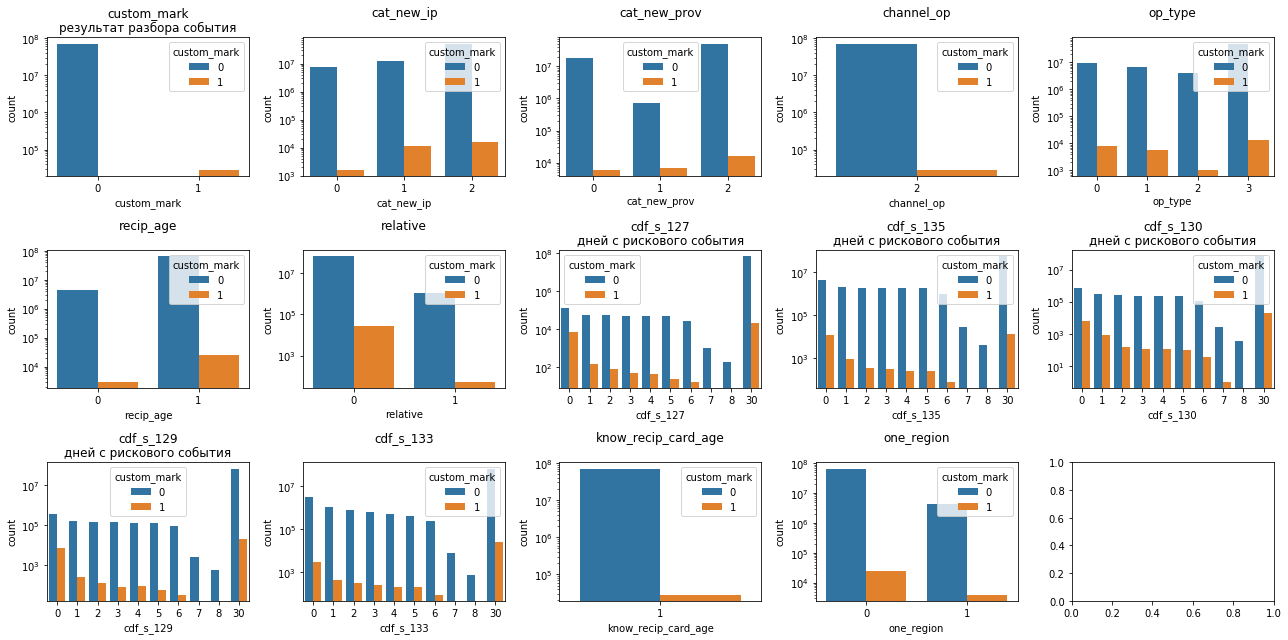

In [53]:
fig, axes = plt.subplots(3, 5, figsize=(18, 9))
#i = 0
for i, feature in enumerate(few_unique_overall):
    ax = axes[i // 5, i % 5]
    sns.countplot(x=feature, data=data, hue="custom_mark", ax=ax)
    ax.set_title(feature + '\n' + feature_descr.get(feature, ''))
    ax.set_yscale('log')
fig.tight_layout()

Countplot для обработанных признаков (без счетчиков для категориальных)

In [38]:
few_unique_overall = [c for c in data_train.columns.values if len(data_train[c].unique()) <= 10]
len(few_unique_overall)

13

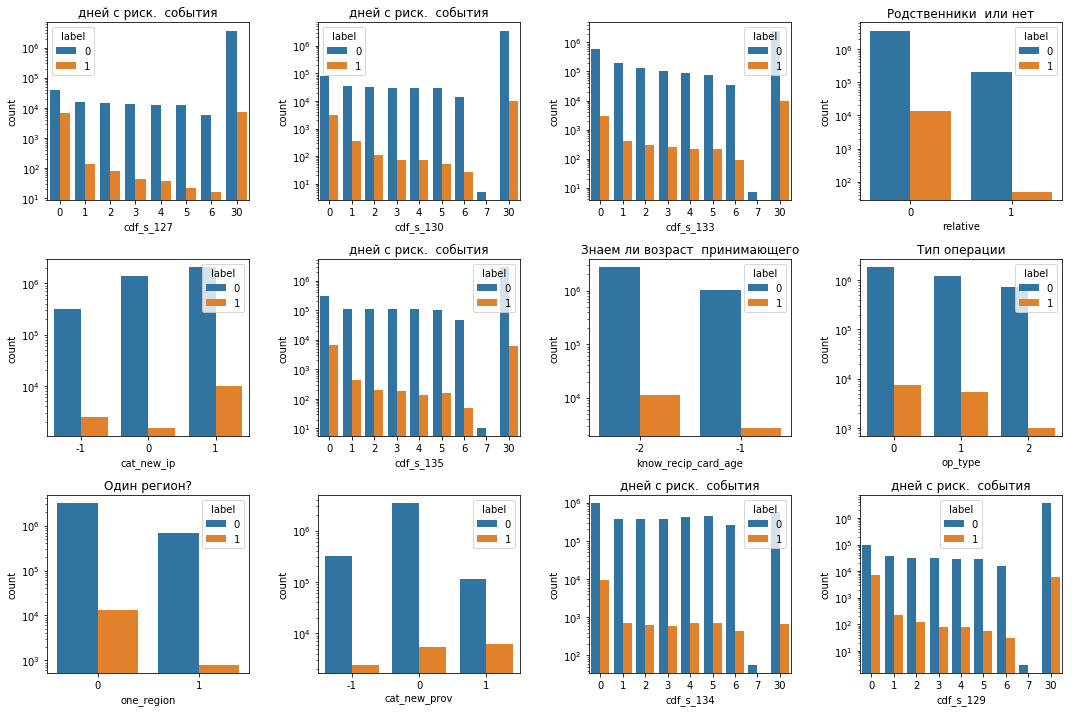

In [92]:
fig, axes = plt.subplots(3, 4, figsize=(15, 10))
#i = 0
for i, feature in enumerate(set(few_unique_overall) - set(['label'])):
    ax = axes[i // 4, i % 4]
    
    sns.countplot(x=feature, data=data_train, hue="label", ax=ax)
    ax.set_title(feature_descr.get(feature, '').replace('\n', ' '))
    #ax.xaxis.set_major_formatter(FormatStrFormatter('%2.5f'))
    ax.set_yscale('log')
    #ticks = ['%2.5f'%x for i,x in enumerate(data_train[feature].unique())]
    #ax.xaxis.set_ticklabels(ticks)
    
    
fig.tight_layout()

Корреляционная матрица для признаков

In [49]:
corr = data_train.corr(method='spearman')

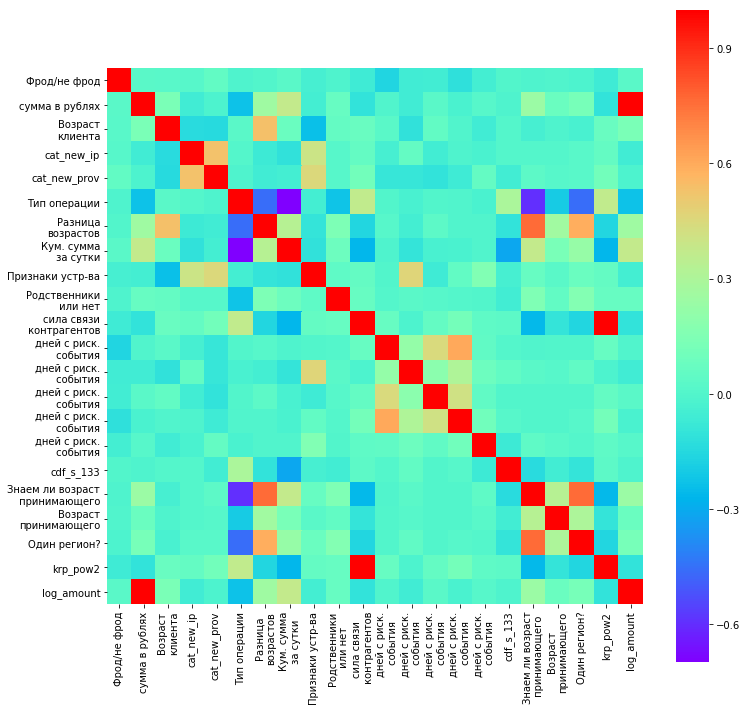

In [89]:
labels = [feature_descr.get(c, c) for c in data_train.columns.values]
plt.figure(figsize=(12, 12))
_ = sns.heatmap(corr, square=True, yticklabels=labels, xticklabels=labels, cmap='rainbow')
#plt.gca().set_xticklabels(labels, rotation=45)

In [69]:
labels = [c for c in data_train.columns.values if not feature_descr.get(c, False)]
print(labels)

['label', 'amount', 'client_age', 'cat_new_ip', 'cat_new_prov', 'op_type', 'age_diff', 'cumulative_sum_total', 'relative', 'know_recip_power', 'cdf_s_133', 'know_recip_card_age', 'recip_card_age', 'one_region', 'krp_pow2', 'log_amount']


In [71]:
d = 

In [64]:
feature_descr['log_amount']

KeyError: 'log_amount'

ValueError: incompatible dimensions for cross product
(dimension must be 2 or 3)

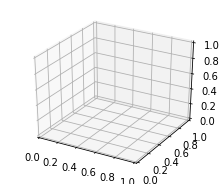

In [59]:
_x = np.arange(len(data_train.columns))
_y = np.arange(len(data_train.columns))
_xx, _yy = np.meshgrid(_x, _y)
x, y = _xx.ravel(), _yy.ravel()
fig = plt.figure(figsize=(8, 3))
ax1 = fig.add_subplot(121, projection='3d')
top = _x + _y
bottom = np.zeros_like(top)
width = depth = 1

ax1.bar3d(_x, _y, bottom, width, depth, corr, shade=True)

In [60]:
_xx.shape

(22, 22)

In [93]:
cols_to_plot = [c for c in data_train.columns.values if len(data_train[c].unique() > 2)]
len(cols_to_plot)

22

In [94]:
len(data_train.columns.values)

22

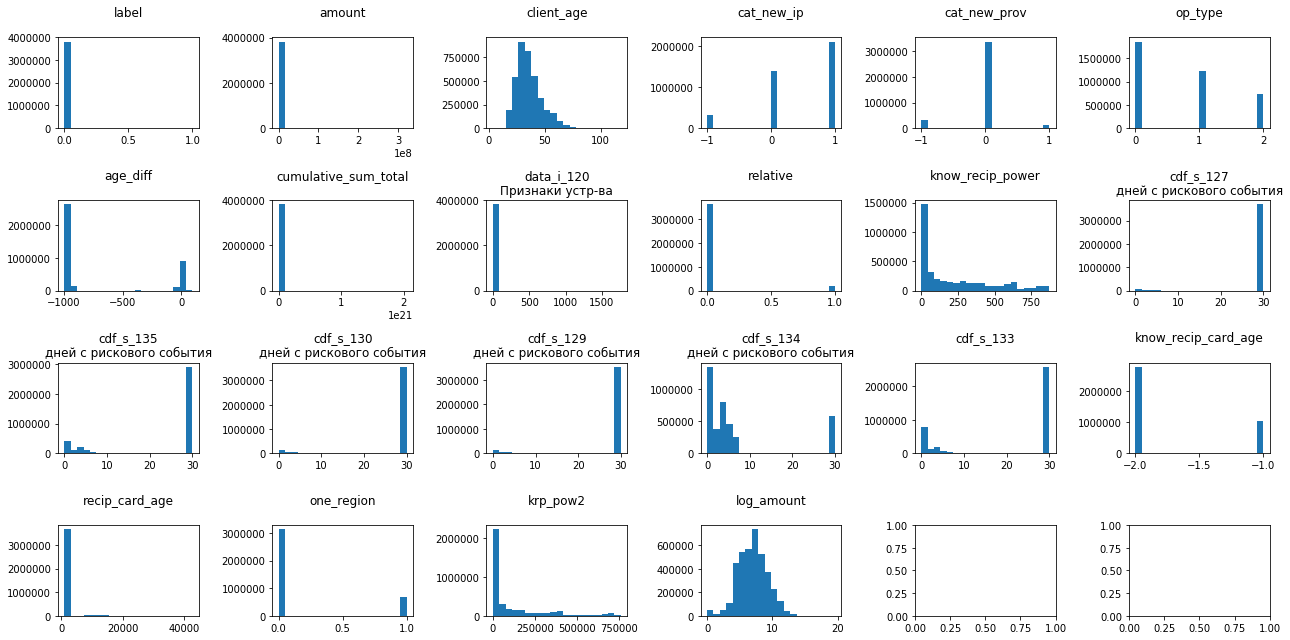

In [47]:
fig, axes = plt.subplots(4, 6, figsize=(18, 9))
#i = 0

for i, feature in enumerate(data_train.columns.values):
    #print(feature)
    #print(i // 5, i % 5)
    ax = axes[i // 6, i % 6]
    ax.hist(pd.to_numeric(data_train[feature], errors='coerce').dropna(), bins=20)
    #plt.figure()
    #plt.hist(pd.to_numeric(chunk[feature], errors='coerce').dropna(), bins=20)
    #plt.show()
    ax.set_title(feature + '\n' + feature_descr.get(feature, ''))
fig.tight_layout()

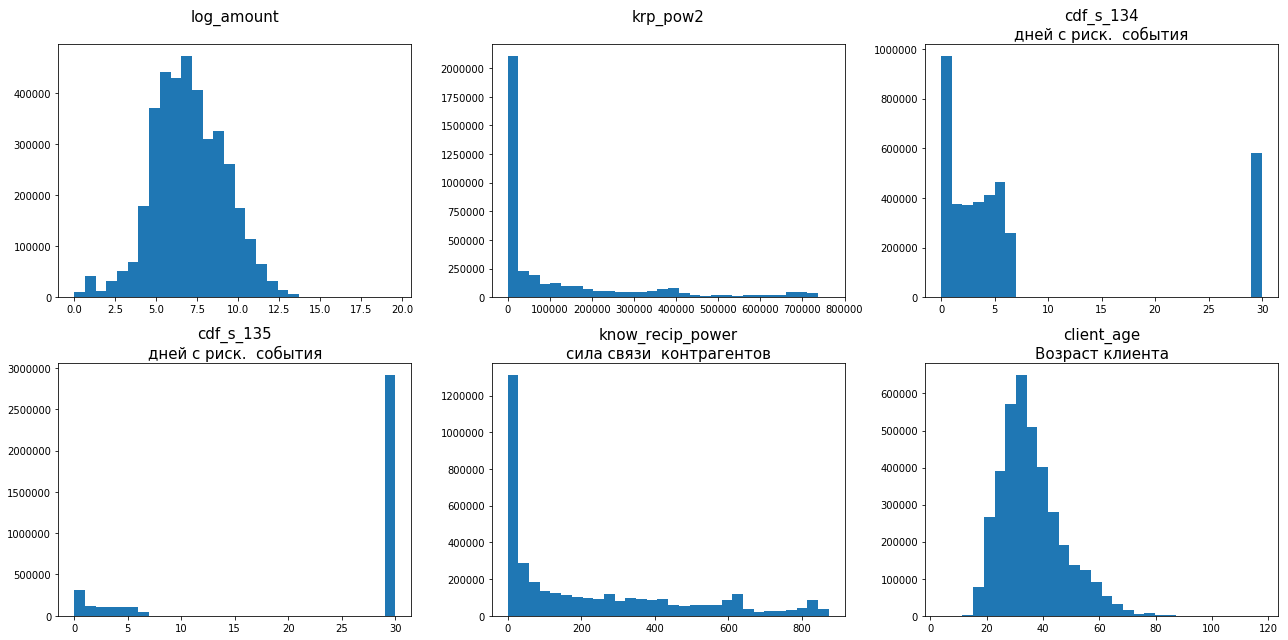

In [100]:
num_feats = ['log_amount', 'krp_pow2', 'cdf_s_134', 'cdf_s_135', 'know_recip_power', 'client_age']
fig, axes = plt.subplots(2, 3, figsize=(18, 9))
#i = 0

for i, feature in enumerate(num_feats):
    #print(feature)
    #print(i // 5, i % 5)
    ax = axes[i // 3, i % 3]
    ax.hist(pd.to_numeric(data_train[feature], errors='coerce').dropna(), bins=30)
    #plt.figure()
    #plt.hist(pd.to_numeric(chunk[feature], errors='coerce').dropna(), bins=20)
    #plt.show()
    ax.set_title(feature + '\n' + feature_descr.get(feature, '').replace('\n', ' '), fontsize=15)
fig.tight_layout()

In [29]:
feature_descr['cdf_s_20']

' Тер банк клиента'

In [30]:
data_train.columns

Index(['label', 'amount', 'client_age', 'cat_new_ip', 'cat_new_prov',
       'op_type', 'age_diff', 'cumulative_sum_total', 'data_i_120', 'relative',
       'know_recip_power', 'cdf_s_127', 'cdf_s_135', 'cdf_s_130', 'cdf_s_129',
       'cdf_s_134', 'cdf_s_133', 'know_recip_card_age', 'recip_card_age',
       'one_region', 'krp_pow2', 'log_amount'],
      dtype='object')

In [19]:
num_feats_log = ['cdf_s_127', 'cdf_s_129', 'cdf_s_130', 'cdf_s_133', 'cumulative_sum_total', 'amount', 'data_i_120' , 'recip_card_age', 
                'age_diff']
len(num_feats_log)

9

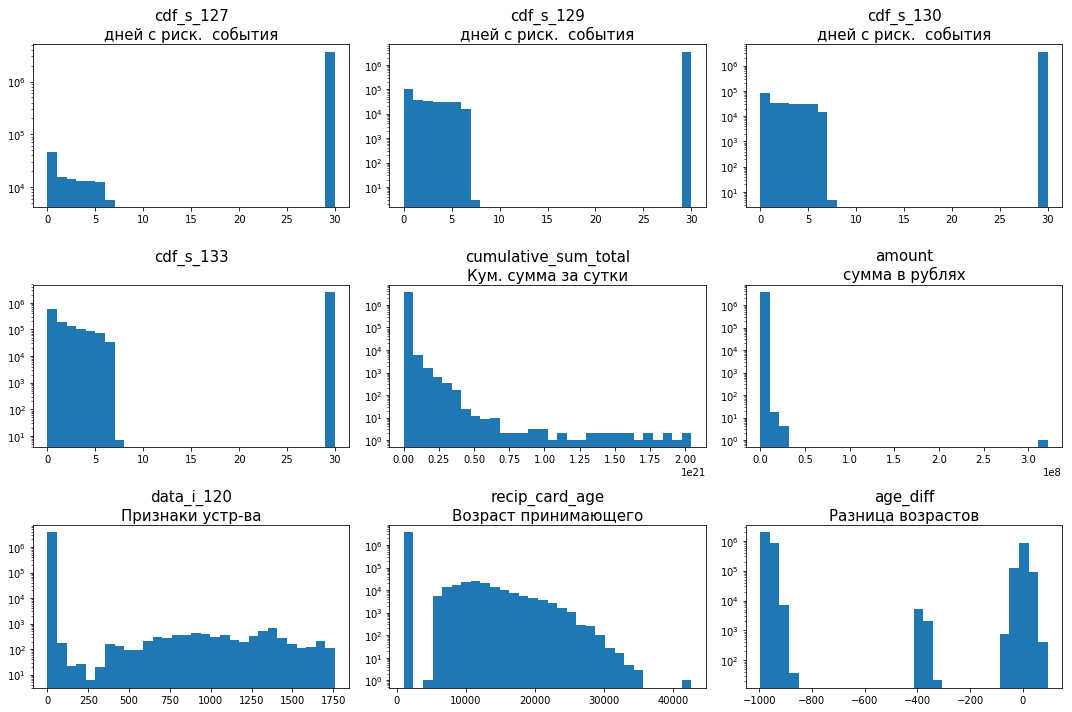

In [109]:

fig, axes = plt.subplots(3, 3, figsize=(15, 10))
#i = 0

for i, feature in enumerate(num_feats_log):
    #print(feature)
    #print(i // 5, i % 5)
    ax = axes[i // 3, i % 3]
    ax.hist(pd.to_numeric(data_train[feature], errors='coerce').dropna(), bins=30)
    #plt.figure()
    #plt.hist(pd.to_numeric(chunk[feature], errors='coerce').dropna(), bins=20)
    #plt.show()
    ax.set_title(feature + '\n' + feature_descr.get(feature, '').replace('\n', ' '), fontsize=15)
    ax.set_yscale('log')
fig.tight_layout()

In [20]:
cat_feats = set(data_train.columns.values) - set(num_feats) - set(num_feats_log)
len(cat_feats)

9

In [128]:
data_train['relative'].value_counts().index.values, data_train['relative'].value_counts().

AttributeError: 'memoryview' object has no attribute 'values'

In [130]:
cnt = data_train['relative'].value_counts()
cnt.values

array([3617521,  199134])

<Container object of 2 artists>

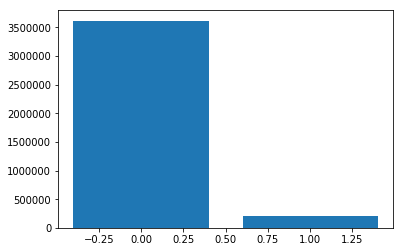

In [132]:
vals, bins = np.histogram(data_train['relative'])
to_plot = np.array([(v,b) for v, b in zip(vals, bins[:-1]) if v != 0])
plt.bar(cnt.index.values, cnt.values)

In [118]:
to_plot[0, :]

array([3617521.,       0.])

In [23]:
len(cat_feats)

9

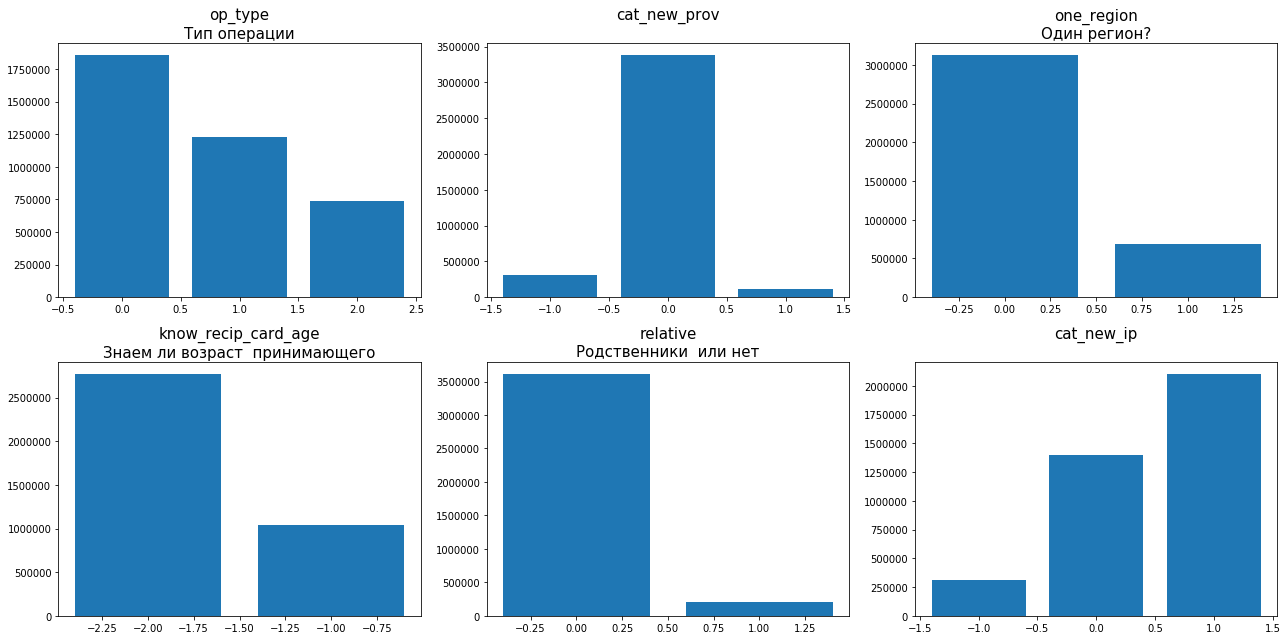

In [27]:

fig, axes = plt.subplots(2, 3, figsize=(18, 9))
#i = 0

for i, feature in enumerate(set(cat_feats) - set(['label', 'cdf_s_134', 'cdf_s_135'])):
    #print(feature)
    #print(i // 5, i % 5)
    ax = axes[i // 3, i % 3]
    #ax.hist(pd.to_numeric(data_train[feature], errors='coerce').dropna(), bins=30)
    #plt.figure()
    cnt = data_train[feature].value_counts()
    ax.bar(cnt.index.values, cnt.values)
    #plt.figure()
    #plt.hist(pd.to_numeric(chunk[feature], errors='coerce').dropna(), bins=20)
    #plt.show()
    ax.set_title(feature + '\n' + feature_descr.get(feature, '').replace('\n', ' '), fontsize=15)
    #ax.set_yscale('log')
fig.tight_layout()

<Container object of 3 artists>

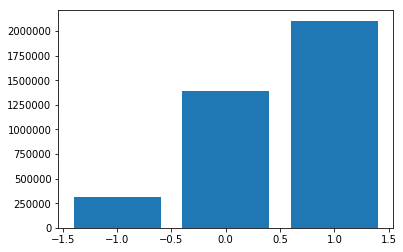

In [13]:
cnt = data_train[cat_feats[0]].value_counts()
plt.bar(cnt.index.values, cnt.values)

In [31]:
labels = ax.get_xticklabels()
for label in labels:
    print(label)

Text(0,0,'0.0011193114')
Text(1,0,'0.0011392046')
Text(2,0,'0.0012385836')
Text(3,0,'0.0041596446999999995')
Text(4,0,'0.0042503667')
Text(5,0,'0.0042682206')


In [28]:
data_train['op_type'].unique()

array([0.00135144, 0.00408331, 0.00451379, 0.0040842 , 0.00142966,
       0.00443277, 0.00126261, 0.00407287, 0.00441022])

In [54]:
del data, train_chunks

In [ ]:
%%time
with multiprocessing.Pool(processes=5) as pool:
    test_chunks = pool.map(load_test, test_files)

Грузим один чанк и отлаживаем на нем визуализацию

In [26]:
chunk = pd.read_feather(train_files[0])

In [27]:
data = transform_cols(chunk)
data = calc_base_features(data)

In [28]:
data.custom_mark = data.custom_mark.apply(cust_mark_to_class)

In [29]:
cdf_cols = [c for c in chunk.columns.values if c.startswith('cdf')]
#cdf_cols.remove('cdf_s_19', 'cdf_s_123', 'cdf_s_124')
len(cdf_cols)

20

In [30]:
num_cols = [c for c in data.columns.values if data[c].dtype in [np.int32, np.float64, np.int64]]
object_cols = [c for c in data.columns.values if data[c].dtype not in [np.int32, np.float64, np.int64]]

Выведем гистограммы для признаков, начинающихся на cdf

/home/alex/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


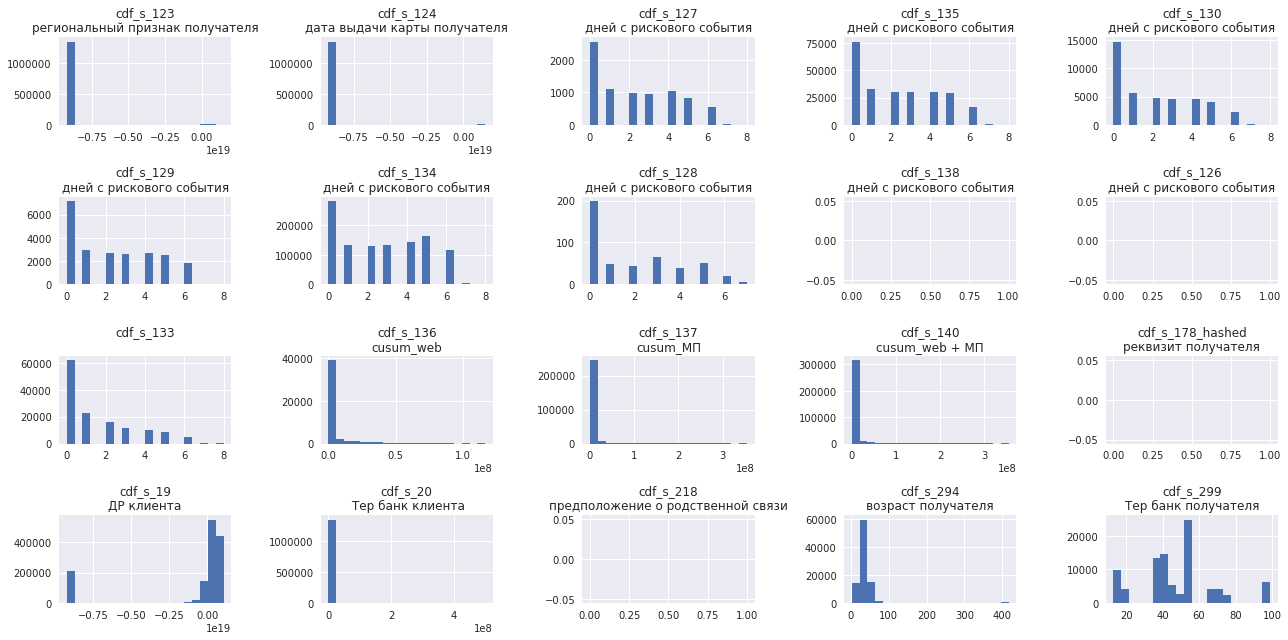

In [77]:
fig, axes = plt.subplots(4, 5, figsize=(18, 9))
#i = 0

for i, feature in enumerate(cdf_cols):
    #print(feature)
    #print(i // 5, i % 5)
    ax = axes[i // 5, i % 5]
    ax.hist(pd.to_numeric(chunk[feature], errors='coerce').dropna(), bins=20)
    #plt.figure()
    #plt.hist(pd.to_numeric(chunk[feature], errors='coerce').dropna(), bins=20)
    #plt.show()
    ax.set_title(feature + '\n' + feature_descr.get(feature, ''))
fig.tight_layout()

Выведем гистограммы для всех числовых признаков

In [34]:
len(num_cols)

26

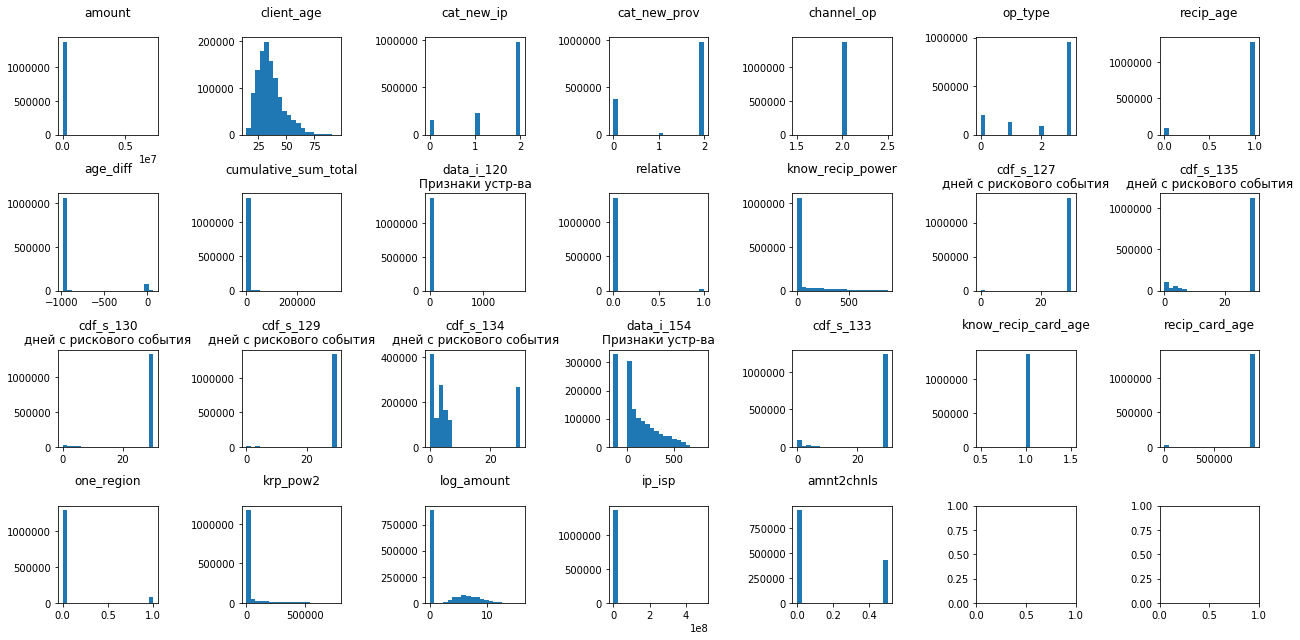

In [36]:
fig, axes = plt.subplots(4, 7, figsize=(18, 9))
#i = 0

for i, feature in enumerate(num_cols):
    ax = axes[i // 7, i % 7]
    ax.hist(pd.to_numeric(data[feature], errors='coerce').dropna(), bins=20)
    ax.set_title(feature + '\n' + feature_descr.get(feature, ''))
fig.tight_layout()

In [16]:
other_cols = set(chunk.columns.values) - set(cdf_cols) - {'custom_mark'}
len(other_cols)

23

/home/alex/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


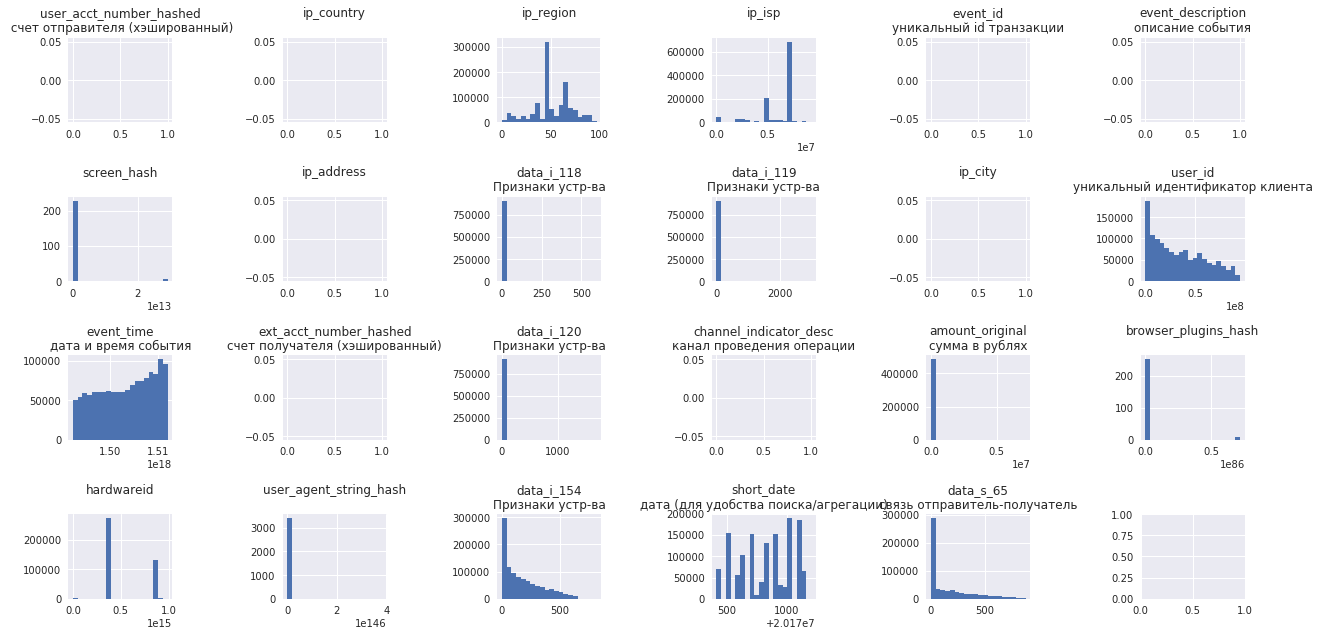

In [17]:
fig, axes = plt.subplots(4, 6, figsize=(18, 9))
#i = 0

for i, feature in enumerate(other_cols):
    ax = axes[i // 6, i % 6]
    ax.hist(pd.to_numeric(chunk[feature], errors='coerce').dropna(), bins=20)
    ax.set_title(feature + '\n' + feature_descr.get(feature, ''))
fig.tight_layout()

In [ ]:
sns.pairplot(chunk, vars=cdf_cols[0:3],
    hue="custom_mark", diag_kind="kde", dropna=True)

Выведем матрицу корреляций для признаков cdf*

/home/alex/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


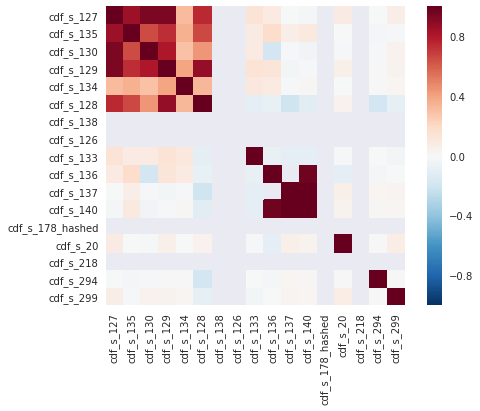

In [20]:
_ = sns.heatmap(chunk[cdf_cols].corr(), square=True)

Аналогично для всех числовых признаков после обработки

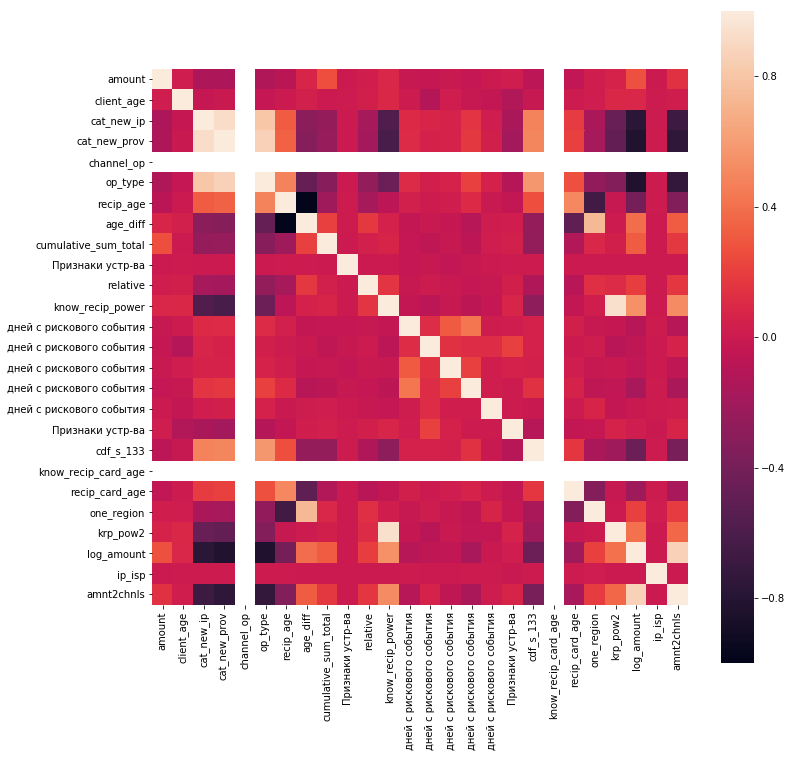

In [40]:
labels = [feature_descr.get(c, c) for c in num_cols]
plt.figure(figsize=(12,12))
_ = sns.heatmap(data[num_cols].corr(), square=True, yticklabels=labels, xticklabels=labels)

/home/alex/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


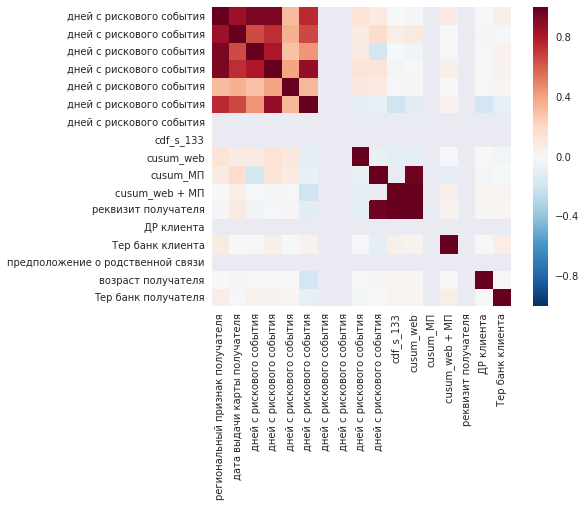

In [31]:
labels = [feature_descr.get(c, c) for c in cdf_cols]
_ = sns.heatmap(chunk[cdf_cols].corr(), square=True, yticklabels=labels, xticklabels=labels)

Сделаем аналогично для всех признаков

/home/alex/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


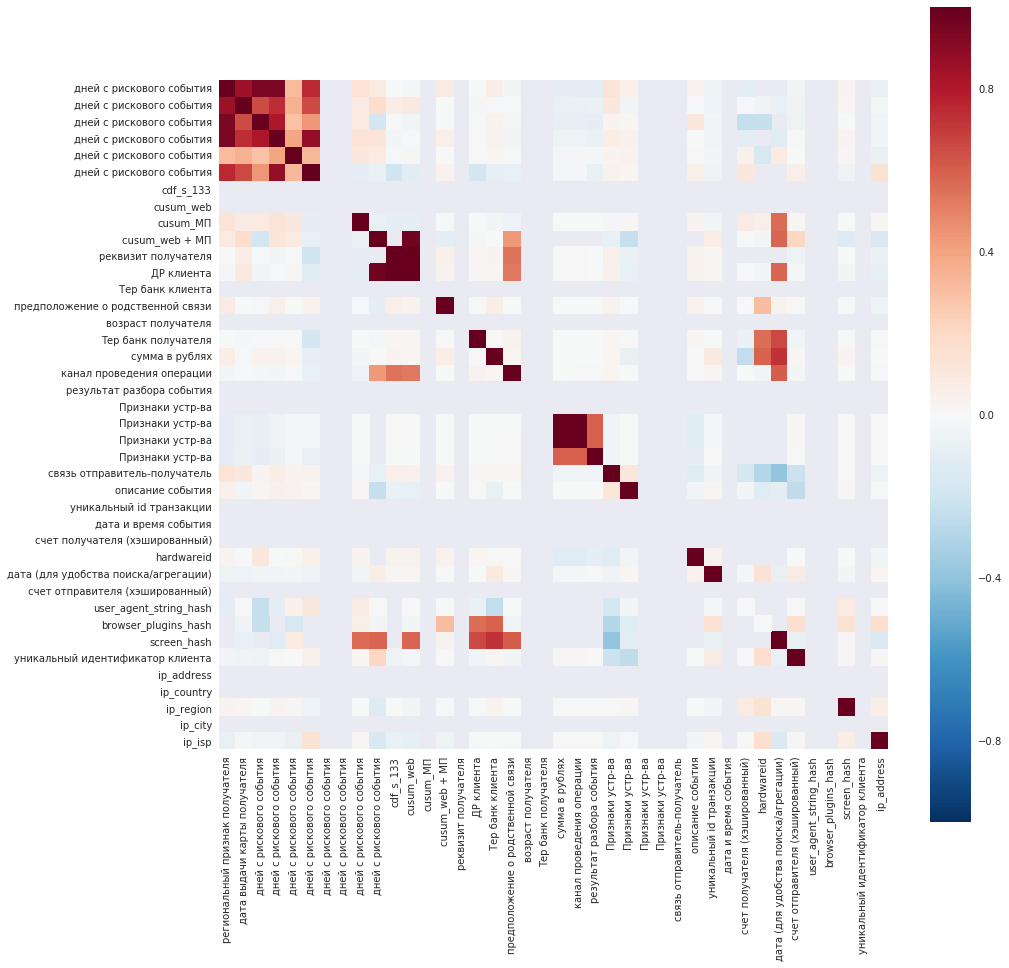

In [33]:
labels = [feature_descr.get(c, c) for c in chunk.columns.values]
plt.figure(figsize=(15,15))
_ = sns.heatmap(chunk.corr(), square=True, yticklabels=labels, xticklabels=labels)

Попробуем вывести счетчики. Берем признаки с числом уникальных значений не более 10 и убираем записи с custom_mark=-1

In [18]:
few_unique = [c for c in data.columns.values if len(data[c].unique()) < 11]

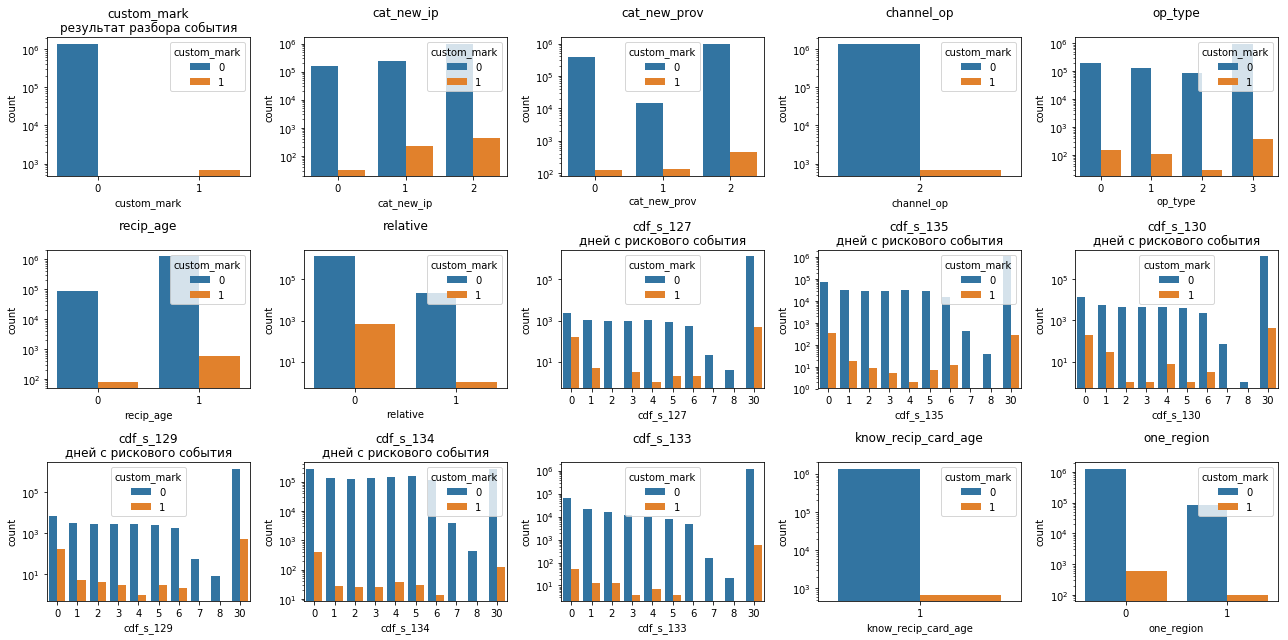

In [31]:
fig, axes = plt.subplots(3, 5, figsize=(18, 9))
#i = 0
data_def = data[data.custom_mark != -1]
for i, feature in enumerate(few_unique):
    ax = axes[i // 5, i % 5]
    sns.countplot(x=feature, data=data_def, hue="custom_mark", ax=ax)
    ax.set_title(feature + '\n' + feature_descr.get(feature, ''))
    ax.set_yscale('log')
fig.tight_layout()

In [23]:
data.custom_mark.value_counts()

-1    1366533
 0    2396   
 1    686    
Name: custom_mark, dtype: int64

Аналогично делаем, не убирая -1

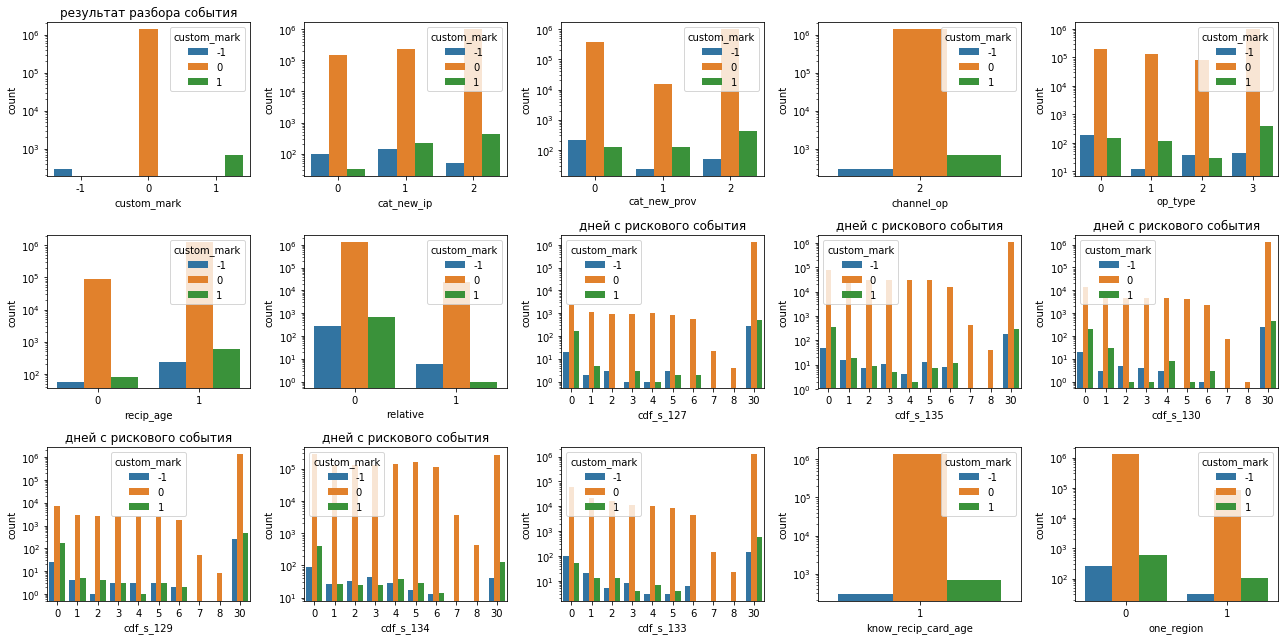

In [32]:
fig, axes = plt.subplots(3, 5, figsize=(18, 9))
#i = 0
for i, feature in enumerate(few_unique):
    ax = axes[i // 5, i % 5]
    sns.countplot(x=feature, data=data, hue="custom_mark", ax=ax)
    ax.set_title(feature_descr.get(feature, ''))
    ax.set_yscale('log')
fig.tight_layout()

In [34]:
train_chunks, test_chunks = [], []

In [33]:
FIRST_N

100

In [36]:
for fname in tqdm_notebook(train_files[:FIRST_N]):
    chunk = pd.read_feather(fname)
    data = transform_cols(chunk)
    data = calc_base_features(data)
    data.custom_mark = data.custom_mark.apply(cust_mark_to_class)
    train_chunks.append(data[few_unique].copy())

HBox(children=(IntProgress(value=0, max=51), HTML(value='')))

KeyboardInterrupt: 

In [ ]:
for fname in tqdm_notebook(test_files[:FIRST_N]):
    chunk = pd.read_feather(fname)
    test_chunks.append(chunk[['user_id', 'short_date']].copy())